In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (VGG16)

2024-02-21 16:05:20.461236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 16:05:20.461341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 16:05:20.586061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(VGG16(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("VGG16"+s+".keras")
    

    # save model to disk
    filename = "VGG16" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 4)                 94431044  


Total params: 94431044 (360.23 MB)


Trainable params: 94431044 (360.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708531545.885089      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 33:38 - loss: 1.2893 - accuracy: 0.1562

  2/140 [..............................] - ETA: 23s - loss: 26567.2461 - accuracy: 0.2500

  3/140 [..............................] - ETA: 23s - loss: 17712.1641 - accuracy: 0.2812

  4/140 [..............................] - ETA: 22s - loss: 13284.4561 - accuracy: 0.3125

  5/140 [>.............................] - ETA: 22s - loss: 10627.7246 - accuracy: 0.3750

  6/140 [>.............................] - ETA: 22s - loss: 8858.2666 - accuracy: 0.4062 

  7/140 [>.............................] - ETA: 22s - loss: 7593.0117 - accuracy: 0.3795

  8/140 [>.............................] - ETA: 22s - loss: 6644.0332 - accuracy: 0.3906

  9/140 [>.............................] - ETA: 22s - loss: 5906.0142 - accuracy: 0.3715

 10/140 [=>............................] - ETA: 21s - loss: 5315.5386 - accuracy: 0.3844

 11/140 [=>............................] - ETA: 21s - loss: 4832.4224 - accuracy: 0.3864

 12/140 [=>............................] - ETA: 21s - loss: 4429.8442 - accuracy: 0.3698

 13/140 [=>............................] - ETA: 21s - loss: 4089.1880 - accuracy: 0.3534

 14/140 [==>...........................] - ETA: 21s - loss: 3797.1895 - accuracy: 0.3549

 15/140 [==>...........................] - ETA: 20s - loss: 3544.1169 - accuracy: 0.3667

 16/140 [==>...........................] - ETA: 20s - loss: 3322.7158 - accuracy: 0.3789

 17/140 [==>...........................] - ETA: 20s - loss: 3127.3291 - accuracy: 0.3860

 18/140 [==>...........................] - ETA: 20s - loss: 2953.6501 - accuracy: 0.3802

 19/140 [===>..........................] - ETA: 20s - loss: 2798.2532 - accuracy: 0.3799

 20/140 [===>..........................] - ETA: 20s - loss: 2658.4028 - accuracy: 0.3781

 21/140 [===>..........................] - ETA: 19s - loss: 2531.8677 - accuracy: 0.3765

 22/140 [===>..........................] - ETA: 19s - loss: 2416.8333 - accuracy: 0.3764

 23/140 [===>..........................] - ETA: 19s - loss: 2311.8040 - accuracy: 0.3736

 24/140 [====>.........................] - ETA: 19s - loss: 2215.5232 - accuracy: 0.3776

 25/140 [====>.........................] - ETA: 19s - loss: 2126.9456 - accuracy: 0.3775

 26/140 [====>.........................] - ETA: 19s - loss: 2045.1876 - accuracy: 0.3738

 27/140 [====>.........................] - ETA: 18s - loss: 1969.4791 - accuracy: 0.3762

 28/140 [=====>........................] - ETA: 18s - loss: 1899.1801 - accuracy: 0.3750

 29/140 [=====>........................] - ETA: 18s - loss: 1833.7242 - accuracy: 0.3815

 30/140 [=====>........................] - ETA: 18s - loss: 1772.6305 - accuracy: 0.3885

 31/140 [=====>........................] - ETA: 18s - loss: 1715.4736 - accuracy: 0.3992

 32/140 [=====>........................] - ETA: 18s - loss: 1661.9199 - accuracy: 0.3994

 33/140 [======>.......................] - ETA: 17s - loss: 1611.5869 - accuracy: 0.4025

 34/140 [======>.......................] - ETA: 17s - loss: 1564.2198 - accuracy: 0.3989

 35/140 [======>.......................] - ETA: 17s - loss: 1519.5607 - accuracy: 0.3973

 36/140 [======>.......................] - ETA: 17s - loss: 1477.3823 - accuracy: 0.3958

 37/140 [======>.......................] - ETA: 17s - loss: 1437.4858 - accuracy: 0.3894

 38/140 [=======>......................] - ETA: 17s - loss: 1399.6875 - accuracy: 0.3882

 39/140 [=======>......................] - ETA: 16s - loss: 1363.8286 - accuracy: 0.3886

 40/140 [=======>......................] - ETA: 16s - loss: 1329.7600 - accuracy: 0.3883

 41/140 [=======>......................] - ETA: 16s - loss: 1297.3524 - accuracy: 0.3895

 42/140 [========>.....................] - ETA: 16s - loss: 1266.4879 - accuracy: 0.3899

 43/140 [========>.....................] - ETA: 16s - loss: 1237.0598 - accuracy: 0.3895

 44/140 [========>.....................] - ETA: 16s - loss: 1208.9673 - accuracy: 0.3906

 45/140 [========>.....................] - ETA: 15s - loss: 1182.1279 - accuracy: 0.3910

 46/140 [========>.....................] - ETA: 15s - loss: 1156.4567 - accuracy: 0.3893

 47/140 [=========>....................] - ETA: 15s - loss: 1131.8746 - accuracy: 0.3883

 48/140 [=========>....................] - ETA: 15s - loss: 1108.3160 - accuracy: 0.3887

 49/140 [=========>....................] - ETA: 15s - loss: 1085.7192 - accuracy: 0.3884

 50/140 [=========>....................] - ETA: 15s - loss: 1064.0247 - accuracy: 0.3913

 51/140 [=========>....................] - ETA: 14s - loss: 1043.1820 - accuracy: 0.3934

 52/140 [==========>...................] - ETA: 14s - loss: 1023.1382 - accuracy: 0.3960

 53/140 [==========>...................] - ETA: 14s - loss: 1003.8500 - accuracy: 0.3992

 54/140 [==========>...................] - ETA: 14s - loss: 985.2848 - accuracy: 0.3987 

 55/140 [==========>...................] - ETA: 14s - loss: 967.3876 - accuracy: 0.4011

 56/140 [===========>..................] - ETA: 14s - loss: 950.1303 - accuracy: 0.4035

 57/140 [===========>..................] - ETA: 13s - loss: 933.4787 - accuracy: 0.4041

 58/140 [===========>..................] - ETA: 13s - loss: 917.4012 - accuracy: 0.4062

 59/140 [===========>..................] - ETA: 13s - loss: 901.8732 - accuracy: 0.4047

 60/140 [===========>..................] - ETA: 13s - loss: 886.8596 - accuracy: 0.4057

 61/140 [============>.................] - ETA: 13s - loss: 872.3362 - accuracy: 0.4083

 62/140 [============>.................] - ETA: 13s - loss: 858.2816 - accuracy: 0.4088

 63/140 [============>.................] - ETA: 12s - loss: 844.6758 - accuracy: 0.4067

 64/140 [============>.................] - ETA: 12s - loss: 831.4933 - accuracy: 0.4077

 65/140 [============>.................] - ETA: 12s - loss: 818.7199 - accuracy: 0.4096

 66/140 [=============>................] - ETA: 12s - loss: 806.3301 - accuracy: 0.4110

 67/140 [=============>................] - ETA: 12s - loss: 794.3110 - accuracy: 0.4118

 68/140 [=============>................] - ETA: 12s - loss: 782.6501 - accuracy: 0.4099

 69/140 [=============>................] - ETA: 11s - loss: 771.3226 - accuracy: 0.4117

 70/140 [==============>...............] - ETA: 11s - loss: 760.3181 - accuracy: 0.4129

 71/140 [==============>...............] - ETA: 11s - loss: 749.6240 - accuracy: 0.4133

 72/140 [==============>...............] - ETA: 11s - loss: 739.2288 - accuracy: 0.4128

 73/140 [==============>...............] - ETA: 11s - loss: 729.1161 - accuracy: 0.4118

 74/140 [==============>...............] - ETA: 11s - loss: 719.2772 - accuracy: 0.4126

 75/140 [===============>..............] - ETA: 10s - loss: 709.7006 - accuracy: 0.4137

 76/140 [===============>..............] - ETA: 10s - loss: 700.3746 - accuracy: 0.4169

 77/140 [===============>..............] - ETA: 10s - loss: 691.2908 - accuracy: 0.4196

 78/140 [===============>..............] - ETA: 10s - loss: 682.4410 - accuracy: 0.4211

 79/140 [===============>..............] - ETA: 10s - loss: 673.8199 - accuracy: 0.4201

 80/140 [================>.............] - ETA: 10s - loss: 665.4085 - accuracy: 0.4223

 81/140 [================>.............] - ETA: 9s - loss: 657.2050 - accuracy: 0.4240 

 82/140 [================>.............] - ETA: 9s - loss: 649.2023 - accuracy: 0.4249

 83/140 [================>.............] - ETA: 9s - loss: 641.3944 - accuracy: 0.4258

 84/140 [=================>............] - ETA: 9s - loss: 633.7725 - accuracy: 0.4260

 85/140 [=================>............] - ETA: 9s - loss: 626.3271 - accuracy: 0.4276

 86/140 [=================>............] - ETA: 9s - loss: 619.0557 - accuracy: 0.4291

 87/140 [=================>............] - ETA: 8s - loss: 611.9525 - accuracy: 0.4307

 88/140 [=================>............] - ETA: 8s - loss: 605.0110 - accuracy: 0.4318

 89/140 [==================>...........] - ETA: 8s - loss: 598.2253 - accuracy: 0.4329

 90/140 [==================>...........] - ETA: 8s - loss: 591.5906 - accuracy: 0.4337

 91/140 [==================>...........] - ETA: 8s - loss: 585.1011 - accuracy: 0.4344

 92/140 [==================>...........] - ETA: 8s - loss: 578.7515 - accuracy: 0.4365

 93/140 [==================>...........] - ETA: 7s - loss: 572.5382 - accuracy: 0.4388

 94/140 [===================>..........] - ETA: 7s - loss: 566.4577 - accuracy: 0.4402

 95/140 [===================>..........] - ETA: 7s - loss: 560.5066 - accuracy: 0.4408

 96/140 [===================>..........] - ETA: 7s - loss: 554.6775 - accuracy: 0.4427

 97/140 [===================>..........] - ETA: 7s - loss: 548.9698 - accuracy: 0.4436

 98/140 [====================>.........] - ETA: 7s - loss: 543.3802 - accuracy: 0.4426

 99/140 [====================>.........] - ETA: 6s - loss: 537.8995 - accuracy: 0.4454

100/140 [====================>.........] - ETA: 6s - loss: 532.5327 - accuracy: 0.4450

101/140 [====================>.........] - ETA: 6s - loss: 527.2706 - accuracy: 0.4452

102/140 [====================>.........] - ETA: 6s - loss: 522.1105 - accuracy: 0.4464

103/140 [=====================>........] - ETA: 6s - loss: 517.0521 - accuracy: 0.4466

104/140 [=====================>........] - ETA: 6s - loss: 512.0896 - accuracy: 0.4483

105/140 [=====================>........] - ETA: 5s - loss: 507.2231 - accuracy: 0.4488

106/140 [=====================>........] - ETA: 5s - loss: 502.4468 - accuracy: 0.4502

107/140 [=====================>........] - ETA: 5s - loss: 497.7608 - accuracy: 0.4495

108/140 [======================>.......] - ETA: 5s - loss: 493.1626 - accuracy: 0.4502

109/140 [======================>.......] - ETA: 5s - loss: 488.6482 - accuracy: 0.4501

110/140 [======================>.......] - ETA: 5s - loss: 484.2156 - accuracy: 0.4509

111/140 [======================>.......] - ETA: 4s - loss: 479.8623 - accuracy: 0.4499

112/140 [=======================>......] - ETA: 4s - loss: 475.5876 - accuracy: 0.4489

113/140 [=======================>......] - ETA: 4s - loss: 471.3867 - accuracy: 0.4511

114/140 [=======================>......] - ETA: 4s - loss: 467.2607 - accuracy: 0.4515

115/140 [=======================>......] - ETA: 4s - loss: 463.2071 - accuracy: 0.4514

116/140 [=======================>......] - ETA: 4s - loss: 459.2220 - accuracy: 0.4526

117/140 [========================>.....] - ETA: 3s - loss: 455.3076 - accuracy: 0.4519

118/140 [========================>.....] - ETA: 3s - loss: 451.4572 - accuracy: 0.4537

119/140 [========================>.....] - ETA: 3s - loss: 447.6718 - accuracy: 0.4538

120/140 [========================>.....] - ETA: 3s - loss: 443.9510 - accuracy: 0.4539

121/140 [========================>.....] - ETA: 3s - loss: 440.2904 - accuracy: 0.4538

122/140 [=========================>....] - ETA: 3s - loss: 436.6896 - accuracy: 0.4541

123/140 [=========================>....] - ETA: 2s - loss: 433.1473 - accuracy: 0.4548

124/140 [=========================>....] - ETA: 2s - loss: 429.6636 - accuracy: 0.4546

125/140 [=========================>....] - ETA: 2s - loss: 426.2341 - accuracy: 0.4555

126/140 [==========================>...] - ETA: 2s - loss: 422.8588 - accuracy: 0.4568

127/140 [==========================>...] - ETA: 2s - loss: 419.5373 - accuracy: 0.4569

128/140 [==========================>...] - ETA: 2s - loss: 416.2681 - accuracy: 0.4565

129/140 [==========================>...] - ETA: 1s - loss: 413.0487 - accuracy: 0.4574

130/140 [==========================>...] - ETA: 1s - loss: 409.8799 - accuracy: 0.4563

131/140 [===========================>..] - ETA: 1s - loss: 406.7589 - accuracy: 0.4568

132/140 [===========================>..] - ETA: 1s - loss: 403.6868 - accuracy: 0.4562

133/140 [===========================>..] - ETA: 1s - loss: 400.6589 - accuracy: 0.4568

134/140 [===========================>..] - ETA: 1s - loss: 397.6761 - accuracy: 0.4580

135/140 [===========================>..] - ETA: 0s - loss: 394.7378 - accuracy: 0.4586

136/140 [============================>.] - ETA: 0s - loss: 391.8441 - accuracy: 0.4580

137/140 [============================>.] - ETA: 0s - loss: 388.9911 - accuracy: 0.4583

138/140 [============================>.] - ETA: 0s - loss: 386.1799 - accuracy: 0.4579

139/140 [============================>.] - ETA: 0s - loss: 383.4102 - accuracy: 0.4580

140/140 [==============================] - ETA: 0s - loss: 573.9213 - accuracy: 0.4578

140/140 [==============================] - 45s 221ms/step - loss: 573.9213 - accuracy: 0.4578 - val_loss: 1.0741 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 43s - loss: 1.0839 - accuracy: 0.4688

  2/140 [..............................] - ETA: 23s - loss: 1.0639 - accuracy: 0.5156

  3/140 [..............................] - ETA: 22s - loss: 1.0368 - accuracy: 0.5625

  4/140 [..............................] - ETA: 22s - loss: 1.0249 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 22s - loss: 1.1627 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 22s - loss: 1.2105 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 1.2078 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 22s - loss: 1.1734 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 21s - loss: 1.4926 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 21s - loss: 1.4577 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 21s - loss: 1.4365 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 21s - loss: 1.4211 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 21s - loss: 2.1196 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 21s - loss: 2.1931 - accuracy: 0.4442

 15/140 [==>...........................] - ETA: 20s - loss: 2.1293 - accuracy: 0.4271

 16/140 [==>...........................] - ETA: 20s - loss: 2.6299 - accuracy: 0.4297

 17/140 [==>...........................] - ETA: 20s - loss: 2.5411 - accuracy: 0.4301

 18/140 [==>...........................] - ETA: 20s - loss: 2.4638 - accuracy: 0.4323

 19/140 [===>..........................] - ETA: 20s - loss: 3.3907 - accuracy: 0.4194

 20/140 [===>..........................] - ETA: 20s - loss: 4.8926 - accuracy: 0.4094

 21/140 [===>..........................] - ETA: 19s - loss: 5.0092 - accuracy: 0.4152

 22/140 [===>..........................] - ETA: 19s - loss: 4.8525 - accuracy: 0.4134

 23/140 [===>..........................] - ETA: 19s - loss: 4.8163 - accuracy: 0.4049

 24/140 [====>.........................] - ETA: 19s - loss: 4.7720 - accuracy: 0.4102

 25/140 [====>.........................] - ETA: 19s - loss: 4.6837 - accuracy: 0.4100

 26/140 [====>.........................] - ETA: 19s - loss: 4.5435 - accuracy: 0.4087

 27/140 [====>.........................] - ETA: 18s - loss: 4.4168 - accuracy: 0.4120

 28/140 [=====>........................] - ETA: 18s - loss: 4.3138 - accuracy: 0.4152

 29/140 [=====>........................] - ETA: 18s - loss: 4.2084 - accuracy: 0.4127

 30/140 [=====>........................] - ETA: 18s - loss: 4.1061 - accuracy: 0.4062

 31/140 [=====>........................] - ETA: 18s - loss: 4.0101 - accuracy: 0.4012

 32/140 [=====>........................] - ETA: 18s - loss: 3.9818 - accuracy: 0.3965

 33/140 [======>.......................] - ETA: 17s - loss: 3.8995 - accuracy: 0.4006

 34/140 [======>.......................] - ETA: 17s - loss: 3.8196 - accuracy: 0.3998

 35/140 [======>.......................] - ETA: 17s - loss: 3.7484 - accuracy: 0.4027

 36/140 [======>.......................] - ETA: 17s - loss: 3.6711 - accuracy: 0.4028

 37/140 [======>.......................] - ETA: 17s - loss: 3.6003 - accuracy: 0.4037

 38/140 [=======>......................] - ETA: 17s - loss: 3.5293 - accuracy: 0.4054

 39/140 [=======>......................] - ETA: 16s - loss: 3.4766 - accuracy: 0.4014

 40/140 [=======>......................] - ETA: 16s - loss: 3.4216 - accuracy: 0.4016

 41/140 [=======>......................] - ETA: 16s - loss: 3.3593 - accuracy: 0.4085

 42/140 [========>.....................] - ETA: 16s - loss: 3.3223 - accuracy: 0.4092

 43/140 [========>.....................] - ETA: 16s - loss: 3.2683 - accuracy: 0.4106

 44/140 [========>.....................] - ETA: 16s - loss: 3.2749 - accuracy: 0.4141

 45/140 [========>.....................] - ETA: 15s - loss: 3.2278 - accuracy: 0.4146

 46/140 [========>.....................] - ETA: 15s - loss: 3.1797 - accuracy: 0.4158

 47/140 [=========>....................] - ETA: 15s - loss: 3.1382 - accuracy: 0.4149

 48/140 [=========>....................] - ETA: 15s - loss: 3.0988 - accuracy: 0.4115

 49/140 [=========>....................] - ETA: 15s - loss: 3.0557 - accuracy: 0.4088

 50/140 [=========>....................] - ETA: 15s - loss: 3.0142 - accuracy: 0.4137

 51/140 [=========>....................] - ETA: 14s - loss: 2.9774 - accuracy: 0.4130

 52/140 [==========>...................] - ETA: 14s - loss: 2.9385 - accuracy: 0.4135

 53/140 [==========>...................] - ETA: 14s - loss: 2.9829 - accuracy: 0.4116

 54/140 [==========>...................] - ETA: 14s - loss: 3.9678 - accuracy: 0.4132

 55/140 [==========>...................] - ETA: 14s - loss: 3.9267 - accuracy: 0.4114

 56/140 [===========>..................] - ETA: 14s - loss: 3.9130 - accuracy: 0.4102

 57/140 [===========>..................] - ETA: 13s - loss: 3.9560 - accuracy: 0.4052

 58/140 [===========>..................] - ETA: 13s - loss: 3.9046 - accuracy: 0.4073

 59/140 [===========>..................] - ETA: 13s - loss: 4.0638 - accuracy: 0.4062

 60/140 [===========>..................] - ETA: 13s - loss: 4.6486 - accuracy: 0.4052

 61/140 [============>.................] - ETA: 13s - loss: 5.0356 - accuracy: 0.4052

 62/140 [============>.................] - ETA: 13s - loss: 5.9596 - accuracy: 0.4068

 63/140 [============>.................] - ETA: 12s - loss: 7.2810 - accuracy: 0.4067

 64/140 [============>.................] - ETA: 12s - loss: 7.5234 - accuracy: 0.4023

 65/140 [============>.................] - ETA: 12s - loss: 8.7179 - accuracy: 0.4005

 66/140 [=============>................] - ETA: 12s - loss: 8.6943 - accuracy: 0.3982

 67/140 [=============>................] - ETA: 12s - loss: 8.6463 - accuracy: 0.3997

 68/140 [=============>................] - ETA: 12s - loss: 8.5641 - accuracy: 0.3948

 69/140 [=============>................] - ETA: 11s - loss: 8.4558 - accuracy: 0.3981

 70/140 [==============>...............] - ETA: 11s - loss: 8.3519 - accuracy: 0.3996

 71/140 [==============>...............] - ETA: 11s - loss: 8.2491 - accuracy: 0.3992

 72/140 [==============>...............] - ETA: 11s - loss: 8.1513 - accuracy: 0.3967

 73/140 [==============>...............] - ETA: 11s - loss: 8.0563 - accuracy: 0.3951

 74/140 [==============>...............] - ETA: 11s - loss: 7.9628 - accuracy: 0.3965

 75/140 [===============>..............] - ETA: 10s - loss: 7.8742 - accuracy: 0.3954

 76/140 [===============>..............] - ETA: 10s - loss: 7.7858 - accuracy: 0.3964

 77/140 [===============>..............] - ETA: 10s - loss: 7.6995 - accuracy: 0.3969

 78/140 [===============>..............] - ETA: 10s - loss: 7.6131 - accuracy: 0.3994

 79/140 [===============>..............] - ETA: 10s - loss: 7.5297 - accuracy: 0.4011

 80/140 [================>.............] - ETA: 10s - loss: 7.4501 - accuracy: 0.4016

 81/140 [================>.............] - ETA: 9s - loss: 7.3707 - accuracy: 0.4028 

 82/140 [================>.............] - ETA: 9s - loss: 7.2916 - accuracy: 0.4051

 83/140 [================>.............] - ETA: 9s - loss: 7.2152 - accuracy: 0.4036

 84/140 [=================>............] - ETA: 9s - loss: 7.1424 - accuracy: 0.4055

 85/140 [=================>............] - ETA: 9s - loss: 7.0710 - accuracy: 0.4070

 86/140 [=================>............] - ETA: 9s - loss: 7.0058 - accuracy: 0.4066

 87/140 [=================>............] - ETA: 8s - loss: 6.9366 - accuracy: 0.4084

 88/140 [=================>............] - ETA: 8s - loss: 6.8693 - accuracy: 0.4105

 89/140 [==================>...........] - ETA: 8s - loss: 6.8043 - accuracy: 0.4112

 90/140 [==================>...........] - ETA: 8s - loss: 6.7396 - accuracy: 0.4122

 91/140 [==================>...........] - ETA: 8s - loss: 6.6776 - accuracy: 0.4148

 92/140 [==================>...........] - ETA: 8s - loss: 6.6148 - accuracy: 0.4168

 93/140 [==================>...........] - ETA: 7s - loss: 6.5545 - accuracy: 0.4180

 94/140 [===================>..........] - ETA: 7s - loss: 6.4970 - accuracy: 0.4192

 95/140 [===================>..........] - ETA: 7s - loss: 6.4397 - accuracy: 0.4204

 96/140 [===================>..........] - ETA: 7s - loss: 6.3819 - accuracy: 0.4225

 97/140 [===================>..........] - ETA: 7s - loss: 6.3271 - accuracy: 0.4233

 98/140 [====================>.........] - ETA: 7s - loss: 6.2729 - accuracy: 0.4244

 99/140 [====================>.........] - ETA: 6s - loss: 6.2209 - accuracy: 0.4239

100/140 [====================>.........] - ETA: 6s - loss: 6.1688 - accuracy: 0.4247

101/140 [====================>.........] - ETA: 6s - loss: 6.1188 - accuracy: 0.4254

102/140 [====================>.........] - ETA: 6s - loss: 6.0686 - accuracy: 0.4259

103/140 [=====================>........] - ETA: 6s - loss: 6.0196 - accuracy: 0.4263

104/140 [=====================>........] - ETA: 6s - loss: 5.9699 - accuracy: 0.4282

105/140 [=====================>........] - ETA: 5s - loss: 5.9215 - accuracy: 0.4301

106/140 [=====================>........] - ETA: 5s - loss: 5.8745 - accuracy: 0.4307

107/140 [=====================>........] - ETA: 5s - loss: 5.8291 - accuracy: 0.4311

108/140 [======================>.......] - ETA: 5s - loss: 5.7849 - accuracy: 0.4323

109/140 [======================>.......] - ETA: 5s - loss: 5.7429 - accuracy: 0.4332

110/140 [======================>.......] - ETA: 5s - loss: 5.7003 - accuracy: 0.4344

111/140 [======================>.......] - ETA: 4s - loss: 5.6607 - accuracy: 0.4333

112/140 [=======================>......] - ETA: 4s - loss: 5.6190 - accuracy: 0.4342

113/140 [=======================>......] - ETA: 4s - loss: 5.5785 - accuracy: 0.4339

114/140 [=======================>......] - ETA: 4s - loss: 5.5400 - accuracy: 0.4342

115/140 [=======================>......] - ETA: 4s - loss: 5.5013 - accuracy: 0.4337

116/140 [=======================>......] - ETA: 4s - loss: 5.4628 - accuracy: 0.4351

117/140 [========================>.....] - ETA: 3s - loss: 5.4261 - accuracy: 0.4354

118/140 [========================>.....] - ETA: 3s - loss: 5.3893 - accuracy: 0.4354

119/140 [========================>.....] - ETA: 3s - loss: 5.3525 - accuracy: 0.4372

120/140 [========================>.....] - ETA: 3s - loss: 5.3163 - accuracy: 0.4385

121/140 [========================>.....] - ETA: 3s - loss: 5.2808 - accuracy: 0.4385

122/140 [=========================>....] - ETA: 3s - loss: 5.2478 - accuracy: 0.4370

123/140 [=========================>....] - ETA: 2s - loss: 5.2126 - accuracy: 0.4385

124/140 [=========================>....] - ETA: 2s - loss: 5.1799 - accuracy: 0.4390

125/140 [=========================>....] - ETA: 2s - loss: 5.1464 - accuracy: 0.4390

126/140 [==========================>...] - ETA: 2s - loss: 5.1156 - accuracy: 0.4377

127/140 [==========================>...] - ETA: 2s - loss: 5.0834 - accuracy: 0.4382

128/140 [==========================>...] - ETA: 2s - loss: 5.0518 - accuracy: 0.4387

129/140 [==========================>...] - ETA: 1s - loss: 5.0200 - accuracy: 0.4392

130/140 [==========================>...] - ETA: 1s - loss: 4.9881 - accuracy: 0.4401

131/140 [===========================>..] - ETA: 1s - loss: 4.9593 - accuracy: 0.4389

132/140 [===========================>..] - ETA: 1s - loss: 4.9297 - accuracy: 0.4392

133/140 [===========================>..] - ETA: 1s - loss: 4.9013 - accuracy: 0.4394

134/140 [===========================>..] - ETA: 1s - loss: 4.8731 - accuracy: 0.4401

135/140 [===========================>..] - ETA: 0s - loss: 4.8444 - accuracy: 0.4410

136/140 [============================>.] - ETA: 0s - loss: 4.8164 - accuracy: 0.4407

137/140 [============================>.] - ETA: 0s - loss: 4.7899 - accuracy: 0.4400

138/140 [============================>.] - ETA: 0s - loss: 4.7629 - accuracy: 0.4409

139/140 [============================>.] - ETA: 0s - loss: 4.7358 - accuracy: 0.4409

140/140 [==============================] - ETA: 0s - loss: 117735.4453 - accuracy: 0.4412

140/140 [==============================] - 26s 182ms/step - loss: 117735.4453 - accuracy: 0.4412 - val_loss: 1.1303 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 41s - loss: 1.1026 - accuracy: 0.4688

  2/140 [..............................] - ETA: 23s - loss: 1.0839 - accuracy: 0.4219

  3/140 [..............................] - ETA: 22s - loss: 2.2435 - accuracy: 0.3229

  4/140 [..............................] - ETA: 22s - loss: 2.0538 - accuracy: 0.3047

  5/140 [>.............................] - ETA: 22s - loss: 1.8347 - accuracy: 0.3250

  6/140 [>.............................] - ETA: 22s - loss: 4.8154 - accuracy: 0.3177

  7/140 [>.............................] - ETA: 22s - loss: 4.2956 - accuracy: 0.3259

  8/140 [>.............................] - ETA: 22s - loss: 3.9011 - accuracy: 0.3398

  9/140 [>.............................] - ETA: 21s - loss: 3.5718 - accuracy: 0.3750

 10/140 [=>............................] - ETA: 21s - loss: 3.2992 - accuracy: 0.4125

 11/140 [=>............................] - ETA: 21s - loss: 3.2135 - accuracy: 0.4091

 12/140 [=>............................] - ETA: 21s - loss: 3.0368 - accuracy: 0.4010

 13/140 [=>............................] - ETA: 21s - loss: 2.8968 - accuracy: 0.4062

 14/140 [==>...........................] - ETA: 21s - loss: 2.8088 - accuracy: 0.3906

 15/140 [==>...........................] - ETA: 20s - loss: 2.7094 - accuracy: 0.3938

 16/140 [==>...........................] - ETA: 20s - loss: 2.6150 - accuracy: 0.3926

 17/140 [==>...........................] - ETA: 20s - loss: 2.5318 - accuracy: 0.3915

 18/140 [==>...........................] - ETA: 20s - loss: 2.4489 - accuracy: 0.3976

 19/140 [===>..........................] - ETA: 20s - loss: 2.3777 - accuracy: 0.3980

 20/140 [===>..........................] - ETA: 20s - loss: 2.3180 - accuracy: 0.3969

 21/140 [===>..........................] - ETA: 19s - loss: 2.2586 - accuracy: 0.4033

 22/140 [===>..........................] - ETA: 19s - loss: 2.2028 - accuracy: 0.4020

 23/140 [===>..........................] - ETA: 19s - loss: 2.1892 - accuracy: 0.3954

 24/140 [====>.........................] - ETA: 19s - loss: 2.1536 - accuracy: 0.3997

 25/140 [====>.........................] - ETA: 19s - loss: 2.1083 - accuracy: 0.4050

 26/140 [====>.........................] - ETA: 19s - loss: 2.0685 - accuracy: 0.4075

 27/140 [====>.........................] - ETA: 18s - loss: 2.0351 - accuracy: 0.4109

 28/140 [=====>........................] - ETA: 18s - loss: 2.0044 - accuracy: 0.4118

 29/140 [=====>........................] - ETA: 18s - loss: 1.9724 - accuracy: 0.4181

 30/140 [=====>........................] - ETA: 18s - loss: 1.9418 - accuracy: 0.4219

 31/140 [=====>........................] - ETA: 18s - loss: 1.9167 - accuracy: 0.4224

 32/140 [=====>........................] - ETA: 18s - loss: 1.8899 - accuracy: 0.4229

 33/140 [======>.......................] - ETA: 17s - loss: 1.8646 - accuracy: 0.4261

 34/140 [======>.......................] - ETA: 17s - loss: 1.8385 - accuracy: 0.4292

 35/140 [======>.......................] - ETA: 17s - loss: 1.8170 - accuracy: 0.4321

 36/140 [======>.......................] - ETA: 17s - loss: 1.7990 - accuracy: 0.4314

 37/140 [======>.......................] - ETA: 17s - loss: 1.7780 - accuracy: 0.4316

 38/140 [=======>......................] - ETA: 17s - loss: 1.7605 - accuracy: 0.4293

 39/140 [=======>......................] - ETA: 16s - loss: 1.7412 - accuracy: 0.4311

 40/140 [=======>......................] - ETA: 16s - loss: 1.7226 - accuracy: 0.4320

 41/140 [=======>......................] - ETA: 16s - loss: 1.7104 - accuracy: 0.4314

 42/140 [========>.....................] - ETA: 16s - loss: 1.6912 - accuracy: 0.4375

 43/140 [========>.....................] - ETA: 16s - loss: 1.6774 - accuracy: 0.4368

 44/140 [========>.....................] - ETA: 16s - loss: 1.6599 - accuracy: 0.4375

 45/140 [========>.....................] - ETA: 15s - loss: 1.6424 - accuracy: 0.4410

 46/140 [========>.....................] - ETA: 15s - loss: 1.6281 - accuracy: 0.4423

 47/140 [=========>....................] - ETA: 15s - loss: 1.6168 - accuracy: 0.4402

 48/140 [=========>....................] - ETA: 15s - loss: 1.6039 - accuracy: 0.4401

 49/140 [=========>....................] - ETA: 15s - loss: 1.5911 - accuracy: 0.4401

 50/140 [=========>....................] - ETA: 15s - loss: 1.5782 - accuracy: 0.4412

 51/140 [=========>....................] - ETA: 14s - loss: 1.5671 - accuracy: 0.4400

 52/140 [==========>...................] - ETA: 14s - loss: 1.5580 - accuracy: 0.4363

 53/140 [==========>...................] - ETA: 14s - loss: 1.5500 - accuracy: 0.4351

 54/140 [==========>...................] - ETA: 14s - loss: 1.5416 - accuracy: 0.4340

 55/140 [==========>...................] - ETA: 14s - loss: 1.5306 - accuracy: 0.4375

 56/140 [===========>..................] - ETA: 14s - loss: 1.5211 - accuracy: 0.4381

 57/140 [===========>..................] - ETA: 13s - loss: 1.5120 - accuracy: 0.4397

 58/140 [===========>..................] - ETA: 13s - loss: 1.5023 - accuracy: 0.4418

 59/140 [===========>..................] - ETA: 13s - loss: 1.5006 - accuracy: 0.4396

 60/140 [===========>..................] - ETA: 13s - loss: 1.4924 - accuracy: 0.4427

 61/140 [============>.................] - ETA: 13s - loss: 1.4844 - accuracy: 0.4431

 62/140 [============>.................] - ETA: 13s - loss: 1.4788 - accuracy: 0.4425

 63/140 [============>.................] - ETA: 12s - loss: 1.4730 - accuracy: 0.4449

 64/140 [============>.................] - ETA: 12s - loss: 1.4676 - accuracy: 0.4453

 65/140 [============>.................] - ETA: 12s - loss: 1.4603 - accuracy: 0.4457

 66/140 [=============>................] - ETA: 12s - loss: 1.4546 - accuracy: 0.4455

 67/140 [=============>................] - ETA: 12s - loss: 1.4461 - accuracy: 0.4473

 68/140 [=============>................] - ETA: 12s - loss: 1.4402 - accuracy: 0.4476

 69/140 [=============>................] - ETA: 11s - loss: 1.4338 - accuracy: 0.4488

 70/140 [==============>...............] - ETA: 11s - loss: 1.4293 - accuracy: 0.4496

 71/140 [==============>...............] - ETA: 11s - loss: 1.4242 - accuracy: 0.4498

 72/140 [==============>...............] - ETA: 11s - loss: 1.4195 - accuracy: 0.4505

 73/140 [==============>...............] - ETA: 11s - loss: 1.4136 - accuracy: 0.4516

 74/140 [==============>...............] - ETA: 11s - loss: 1.4089 - accuracy: 0.4535

 75/140 [===============>..............] - ETA: 10s - loss: 1.4028 - accuracy: 0.4554

 76/140 [===============>..............] - ETA: 10s - loss: 1.3969 - accuracy: 0.4576

 77/140 [===============>..............] - ETA: 10s - loss: 1.3944 - accuracy: 0.4574

 78/140 [===============>..............] - ETA: 10s - loss: 1.3925 - accuracy: 0.4567

 79/140 [===============>..............] - ETA: 10s - loss: 1.3863 - accuracy: 0.4585

 80/140 [================>.............] - ETA: 10s - loss: 1.3823 - accuracy: 0.4578

 81/140 [================>.............] - ETA: 9s - loss: 1.3772 - accuracy: 0.4599 

 82/140 [================>.............] - ETA: 9s - loss: 1.3732 - accuracy: 0.4619

 83/140 [================>.............] - ETA: 9s - loss: 1.3684 - accuracy: 0.4623

 84/140 [=================>............] - ETA: 9s - loss: 1.3657 - accuracy: 0.4624

 85/140 [=================>............] - ETA: 9s - loss: 1.3615 - accuracy: 0.4632

 86/140 [=================>............] - ETA: 9s - loss: 1.3551 - accuracy: 0.4644

 87/140 [=================>............] - ETA: 8s - loss: 1.3532 - accuracy: 0.4641

 88/140 [=================>............] - ETA: 8s - loss: 1.3495 - accuracy: 0.4648

 89/140 [==================>...........] - ETA: 8s - loss: 1.3449 - accuracy: 0.4645

 90/140 [==================>...........] - ETA: 8s - loss: 1.3417 - accuracy: 0.4660

 91/140 [==================>...........] - ETA: 8s - loss: 1.3382 - accuracy: 0.4667

 92/140 [==================>...........] - ETA: 8s - loss: 1.3349 - accuracy: 0.4677

 93/140 [==================>...........] - ETA: 7s - loss: 1.3298 - accuracy: 0.4698

 94/140 [===================>..........] - ETA: 7s - loss: 1.3275 - accuracy: 0.4697

 95/140 [===================>..........] - ETA: 7s - loss: 1.3246 - accuracy: 0.4701

 96/140 [===================>..........] - ETA: 7s - loss: 1.3236 - accuracy: 0.4688

 97/140 [===================>..........] - ETA: 7s - loss: 1.3203 - accuracy: 0.4691

 98/140 [====================>.........] - ETA: 7s - loss: 1.3158 - accuracy: 0.4710

 99/140 [====================>.........] - ETA: 6s - loss: 1.3125 - accuracy: 0.4716

100/140 [====================>.........] - ETA: 6s - loss: 1.3085 - accuracy: 0.4734

101/140 [====================>.........] - ETA: 6s - loss: 1.3058 - accuracy: 0.4743

102/140 [====================>.........] - ETA: 6s - loss: 1.3043 - accuracy: 0.4740

103/140 [=====================>........] - ETA: 6s - loss: 1.3019 - accuracy: 0.4739

104/140 [=====================>........] - ETA: 6s - loss: 1.2982 - accuracy: 0.4745

105/140 [=====================>........] - ETA: 5s - loss: 1.2952 - accuracy: 0.4744

106/140 [=====================>........] - ETA: 5s - loss: 1.2933 - accuracy: 0.4749

107/140 [=====================>........] - ETA: 5s - loss: 1.2900 - accuracy: 0.4749

108/140 [======================>.......] - ETA: 5s - loss: 1.2882 - accuracy: 0.4760

109/140 [======================>.......] - ETA: 5s - loss: 1.2851 - accuracy: 0.4765

110/140 [======================>.......] - ETA: 5s - loss: 1.2826 - accuracy: 0.4776

111/140 [======================>.......] - ETA: 4s - loss: 1.2807 - accuracy: 0.4772

112/140 [=======================>......] - ETA: 4s - loss: 1.2786 - accuracy: 0.4760

113/140 [=======================>......] - ETA: 4s - loss: 1.2763 - accuracy: 0.4759

114/140 [=======================>......] - ETA: 4s - loss: 1.2753 - accuracy: 0.4751

115/140 [=======================>......] - ETA: 4s - loss: 1.2730 - accuracy: 0.4755

116/140 [=======================>......] - ETA: 4s - loss: 1.2709 - accuracy: 0.4763

117/140 [========================>.....] - ETA: 3s - loss: 1.2698 - accuracy: 0.4757

118/140 [========================>.....] - ETA: 3s - loss: 1.2669 - accuracy: 0.4767

119/140 [========================>.....] - ETA: 3s - loss: 1.2647 - accuracy: 0.4769

120/140 [========================>.....] - ETA: 3s - loss: 1.2651 - accuracy: 0.4758

121/140 [========================>.....] - ETA: 3s - loss: 1.2629 - accuracy: 0.4757

122/140 [=========================>....] - ETA: 3s - loss: 1.2604 - accuracy: 0.4759

123/140 [=========================>....] - ETA: 2s - loss: 1.2591 - accuracy: 0.4759

124/140 [=========================>....] - ETA: 2s - loss: 1.2575 - accuracy: 0.4761

125/140 [=========================>....] - ETA: 2s - loss: 1.2553 - accuracy: 0.4767

126/140 [==========================>...] - ETA: 2s - loss: 1.2533 - accuracy: 0.4772

127/140 [==========================>...] - ETA: 2s - loss: 1.2519 - accuracy: 0.4771

128/140 [==========================>...] - ETA: 2s - loss: 1.2507 - accuracy: 0.4771

129/140 [==========================>...] - ETA: 1s - loss: 1.2483 - accuracy: 0.4772

130/140 [==========================>...] - ETA: 1s - loss: 1.2463 - accuracy: 0.4781

131/140 [===========================>..] - ETA: 1s - loss: 1.2444 - accuracy: 0.4778

132/140 [===========================>..] - ETA: 1s - loss: 1.2440 - accuracy: 0.4775

133/140 [===========================>..] - ETA: 1s - loss: 1.2424 - accuracy: 0.4774

134/140 [===========================>..] - ETA: 1s - loss: 1.2400 - accuracy: 0.4785

135/140 [===========================>..] - ETA: 0s - loss: 1.2379 - accuracy: 0.4789

136/140 [============================>.] - ETA: 0s - loss: 1.2359 - accuracy: 0.4786

137/140 [============================>.] - ETA: 0s - loss: 1.2331 - accuracy: 0.4804

138/140 [============================>.] - ETA: 0s - loss: 1.2314 - accuracy: 0.4801

139/140 [============================>.] - ETA: 0s - loss: 1.2304 - accuracy: 0.4807

140/140 [==============================] - ETA: 0s - loss: 386386688.0000 - accuracy: 0.4805

140/140 [==============================] - 26s 182ms/step - loss: 386386688.0000 - accuracy: 0.4805 - val_loss: 1.3684 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 44s - loss: 1.3355 - accuracy: 0.3750

  2/140 [..............................] - ETA: 23s - loss: 316.3435 - accuracy: 0.2188

  3/140 [..............................] - ETA: 22s - loss: 211.5365 - accuracy: 0.2604

  4/140 [..............................] - ETA: 22s - loss: 165.0874 - accuracy: 0.2422

  5/140 [>.............................] - ETA: 22s - loss: 133.1075 - accuracy: 0.2313

  6/140 [>.............................] - ETA: 22s - loss: 112.9691 - accuracy: 0.2448

  7/140 [>.............................] - ETA: 22s - loss: 97.0845 - accuracy: 0.2589 

  8/140 [>.............................] - ETA: 22s - loss: 85.3731 - accuracy: 0.2383

  9/140 [>.............................] - ETA: 21s - loss: 101.7436 - accuracy: 0.2569

 10/140 [=>............................] - ETA: 21s - loss: 269.2471 - accuracy: 0.2625

 11/140 [=>............................] - ETA: 21s - loss: 344.9897 - accuracy: 0.2472

 12/140 [=>............................] - ETA: 21s - loss: 425.4152 - accuracy: 0.2578

 13/140 [=>............................] - ETA: 21s - loss: 1560.8413 - accuracy: 0.2933

 14/140 [==>...........................] - ETA: 21s - loss: 1482.5908 - accuracy: 0.2812

 15/140 [==>...........................] - ETA: 20s - loss: 1389.1891 - accuracy: 0.2667

 16/140 [==>...........................] - ETA: 20s - loss: 1303.7113 - accuracy: 0.2773

 17/140 [==>...........................] - ETA: 20s - loss: 1228.1411 - accuracy: 0.2610

 18/140 [==>...........................] - ETA: 20s - loss: 1161.6533 - accuracy: 0.2656

 19/140 [===>..........................] - ETA: 20s - loss: 1103.3044 - accuracy: 0.2533

 20/140 [===>..........................] - ETA: 20s - loss: 1048.9524 - accuracy: 0.2641

 21/140 [===>..........................] - ETA: 19s - loss: 999.5912 - accuracy: 0.2783 

 22/140 [===>..........................] - ETA: 19s - loss: 954.2766 - accuracy: 0.2869

 23/140 [===>..........................] - ETA: 19s - loss: 912.8444 - accuracy: 0.2989

 24/140 [====>.........................] - ETA: 19s - loss: 874.8879 - accuracy: 0.3086

 25/140 [====>.........................] - ETA: 19s - loss: 839.9449 - accuracy: 0.3050

 26/140 [====>.........................] - ETA: 19s - loss: 807.6899 - accuracy: 0.3137

 27/140 [====>.........................] - ETA: 18s - loss: 777.8230 - accuracy: 0.3218

 28/140 [=====>........................] - ETA: 18s - loss: 750.0895 - accuracy: 0.3281

 29/140 [=====>........................] - ETA: 18s - loss: 724.2814 - accuracy: 0.3330

 30/140 [=====>........................] - ETA: 18s - loss: 700.1808 - accuracy: 0.3365

 31/140 [=====>........................] - ETA: 18s - loss: 677.6356 - accuracy: 0.3377

 32/140 [=====>........................] - ETA: 18s - loss: 656.4991 - accuracy: 0.3389

 33/140 [======>.......................] - ETA: 17s - loss: 636.6431 - accuracy: 0.3428

 34/140 [======>.......................] - ETA: 17s - loss: 617.9550 - accuracy: 0.3438

 35/140 [======>.......................] - ETA: 17s - loss: 600.3337 - accuracy: 0.3455

 36/140 [======>.......................] - ETA: 17s - loss: 583.6903 - accuracy: 0.3490

 37/140 [======>.......................] - ETA: 17s - loss: 567.9467 - accuracy: 0.3514

 38/140 [=======>......................] - ETA: 17s - loss: 553.0327 - accuracy: 0.3479

 39/140 [=======>......................] - ETA: 16s - loss: 538.8818 - accuracy: 0.3478

 40/140 [=======>......................] - ETA: 16s - loss: 525.4377 - accuracy: 0.3555

 41/140 [=======>......................] - ETA: 16s - loss: 512.6490 - accuracy: 0.3598

 42/140 [========>.....................] - ETA: 16s - loss: 500.4693 - accuracy: 0.3653

 43/140 [========>.....................] - ETA: 16s - loss: 488.8562 - accuracy: 0.3670

 44/140 [========>.....................] - ETA: 16s - loss: 477.7696 - accuracy: 0.3693

 45/140 [========>.....................] - ETA: 15s - loss: 467.1776 - accuracy: 0.3694

 46/140 [========>.....................] - ETA: 15s - loss: 457.0459 - accuracy: 0.3730

 47/140 [=========>....................] - ETA: 15s - loss: 447.3435 - accuracy: 0.3757

 48/140 [=========>....................] - ETA: 15s - loss: 438.0463 - accuracy: 0.3796

 49/140 [=========>....................] - ETA: 15s - loss: 429.1278 - accuracy: 0.3827

 50/140 [=========>....................] - ETA: 15s - loss: 420.5678 - accuracy: 0.3831

 51/140 [=========>....................] - ETA: 14s - loss: 412.3426 - accuracy: 0.3842

 52/140 [==========>...................] - ETA: 14s - loss: 404.4311 - accuracy: 0.3870

 53/140 [==========>...................] - ETA: 14s - loss: 396.8207 - accuracy: 0.3874

 54/140 [==========>...................] - ETA: 14s - loss: 389.4902 - accuracy: 0.3889

 55/140 [==========>...................] - ETA: 14s - loss: 382.4278 - accuracy: 0.3903

 56/140 [===========>..................] - ETA: 14s - loss: 375.6186 - accuracy: 0.3906

 57/140 [===========>..................] - ETA: 13s - loss: 369.0465 - accuracy: 0.3931

 58/140 [===========>..................] - ETA: 13s - loss: 362.7007 - accuracy: 0.3944

 59/140 [===========>..................] - ETA: 13s - loss: 356.5688 - accuracy: 0.3978

 60/140 [===========>..................] - ETA: 13s - loss: 350.6437 - accuracy: 0.3969

 61/140 [============>.................] - ETA: 13s - loss: 344.9108 - accuracy: 0.3991

 62/140 [============>.................] - ETA: 13s - loss: 339.3664 - accuracy: 0.4002

 63/140 [============>.................] - ETA: 12s - loss: 333.9979 - accuracy: 0.3983

 64/140 [============>.................] - ETA: 12s - loss: 328.7954 - accuracy: 0.4004

 65/140 [============>.................] - ETA: 12s - loss: 323.7507 - accuracy: 0.4029

 66/140 [=============>................] - ETA: 12s - loss: 318.8612 - accuracy: 0.4044

 67/140 [=============>................] - ETA: 12s - loss: 314.1153 - accuracy: 0.4072

 68/140 [=============>................] - ETA: 12s - loss: 309.5171 - accuracy: 0.4085

 69/140 [=============>................] - ETA: 11s - loss: 305.0498 - accuracy: 0.4090

 70/140 [==============>...............] - ETA: 11s - loss: 300.7073 - accuracy: 0.4094

 71/140 [==============>...............] - ETA: 11s - loss: 296.4895 - accuracy: 0.4102

 72/140 [==============>...............] - ETA: 11s - loss: 292.3828 - accuracy: 0.4128

 73/140 [==============>...............] - ETA: 11s - loss: 288.3932 - accuracy: 0.4144

 74/140 [==============>...............] - ETA: 11s - loss: 284.5104 - accuracy: 0.4155

 75/140 [===============>..............] - ETA: 10s - loss: 280.7308 - accuracy: 0.4158

 76/140 [===============>..............] - ETA: 10s - loss: 277.0514 - accuracy: 0.4169

 77/140 [===============>..............] - ETA: 10s - loss: 273.4650 - accuracy: 0.4184

 78/140 [===============>..............] - ETA: 10s - loss: 269.9695 - accuracy: 0.4207

 79/140 [===============>..............] - ETA: 10s - loss: 266.5647 - accuracy: 0.4217

 80/140 [================>.............] - ETA: 10s - loss: 263.2448 - accuracy: 0.4230

 81/140 [================>.............] - ETA: 9s - loss: 260.0084 - accuracy: 0.4240 

 82/140 [================>.............] - ETA: 9s - loss: 256.8499 - accuracy: 0.4253

 83/140 [================>.............] - ETA: 9s - loss: 253.7699 - accuracy: 0.4255

 84/140 [=================>............] - ETA: 9s - loss: 250.7593 - accuracy: 0.4286

 85/140 [=================>............] - ETA: 9s - loss: 247.8199 - accuracy: 0.4298

 86/140 [=================>............] - ETA: 9s - loss: 244.9493 - accuracy: 0.4310

 87/140 [=================>............] - ETA: 8s - loss: 242.1452 - accuracy: 0.4325

 88/140 [=================>............] - ETA: 8s - loss: 239.4046 - accuracy: 0.4329

 89/140 [==================>...........] - ETA: 8s - loss: 236.7258 - accuracy: 0.4343

 90/140 [==================>...........] - ETA: 8s - loss: 234.1065 - accuracy: 0.4365

 91/140 [==================>...........] - ETA: 8s - loss: 231.5441 - accuracy: 0.4368

 92/140 [==================>...........] - ETA: 8s - loss: 229.0389 - accuracy: 0.4375

 93/140 [==================>...........] - ETA: 7s - loss: 226.5894 - accuracy: 0.4375

 94/140 [===================>..........] - ETA: 7s - loss: 224.1899 - accuracy: 0.4378

 95/140 [===================>..........] - ETA: 7s - loss: 221.8417 - accuracy: 0.4388

 96/140 [===================>..........] - ETA: 7s - loss: 219.5426 - accuracy: 0.4395

 97/140 [===================>..........] - ETA: 7s - loss: 217.2896 - accuracy: 0.4398

 98/140 [====================>.........] - ETA: 7s - loss: 215.0818 - accuracy: 0.4413

 99/140 [====================>.........] - ETA: 6s - loss: 212.9198 - accuracy: 0.4429

100/140 [====================>.........] - ETA: 6s - loss: 210.8004 - accuracy: 0.4437

101/140 [====================>.........] - ETA: 6s - loss: 208.7245 - accuracy: 0.4440

102/140 [====================>.........] - ETA: 6s - loss: 206.6884 - accuracy: 0.4439

103/140 [=====================>........] - ETA: 6s - loss: 204.6919 - accuracy: 0.4439

104/140 [=====================>........] - ETA: 6s - loss: 202.7342 - accuracy: 0.4441

105/140 [=====================>........] - ETA: 5s - loss: 200.8143 - accuracy: 0.4437

106/140 [=====================>........] - ETA: 5s - loss: 198.9300 - accuracy: 0.4443

107/140 [=====================>........] - ETA: 5s - loss: 197.0795 - accuracy: 0.4457

108/140 [======================>.......] - ETA: 5s - loss: 195.2640 - accuracy: 0.4456

109/140 [======================>.......] - ETA: 5s - loss: 193.4817 - accuracy: 0.4461

110/140 [======================>.......] - ETA: 5s - loss: 191.7322 - accuracy: 0.4474

111/140 [======================>.......] - ETA: 4s - loss: 190.0148 - accuracy: 0.4479

112/140 [=======================>......] - ETA: 4s - loss: 188.3273 - accuracy: 0.4487

113/140 [=======================>......] - ETA: 4s - loss: 186.6703 - accuracy: 0.4486

114/140 [=======================>......] - ETA: 4s - loss: 185.0416 - accuracy: 0.4496

115/140 [=======================>......] - ETA: 4s - loss: 183.4406 - accuracy: 0.4503

116/140 [=======================>......] - ETA: 4s - loss: 181.8684 - accuracy: 0.4507

117/140 [========================>.....] - ETA: 3s - loss: 180.3227 - accuracy: 0.4509

118/140 [========================>.....] - ETA: 3s - loss: 178.8045 - accuracy: 0.4502

119/140 [========================>.....] - ETA: 3s - loss: 177.3106 - accuracy: 0.4514

120/140 [========================>.....] - ETA: 3s - loss: 175.8415 - accuracy: 0.4516

121/140 [========================>.....] - ETA: 3s - loss: 174.3968 - accuracy: 0.4530

122/140 [=========================>....] - ETA: 3s - loss: 172.9760 - accuracy: 0.4541

123/140 [=========================>....] - ETA: 2s - loss: 171.5784 - accuracy: 0.4548

124/140 [=========================>....] - ETA: 2s - loss: 170.2031 - accuracy: 0.4549

125/140 [=========================>....] - ETA: 2s - loss: 168.8495 - accuracy: 0.4552

126/140 [==========================>...] - ETA: 2s - loss: 167.5185 - accuracy: 0.4549

127/140 [==========================>...] - ETA: 2s - loss: 166.2092 - accuracy: 0.4540

128/140 [==========================>...] - ETA: 2s - loss: 164.9190 - accuracy: 0.4543

129/140 [==========================>...] - ETA: 1s - loss: 163.6481 - accuracy: 0.4547

130/140 [==========================>...] - ETA: 1s - loss: 162.3973 - accuracy: 0.4548

131/140 [===========================>..] - ETA: 1s - loss: 161.1656 - accuracy: 0.4561

132/140 [===========================>..] - ETA: 1s - loss: 159.9518 - accuracy: 0.4569

133/140 [===========================>..] - ETA: 1s - loss: 158.7578 - accuracy: 0.4568

134/140 [===========================>..] - ETA: 1s - loss: 157.5811 - accuracy: 0.4559

135/140 [===========================>..] - ETA: 0s - loss: 156.4210 - accuracy: 0.4563

136/140 [============================>.] - ETA: 0s - loss: 155.2781 - accuracy: 0.4568

137/140 [============================>.] - ETA: 0s - loss: 154.1530 - accuracy: 0.4564

138/140 [============================>.] - ETA: 0s - loss: 153.0433 - accuracy: 0.4570

139/140 [============================>.] - ETA: 0s - loss: 151.9496 - accuracy: 0.4573

140/140 [==============================] - ETA: 0s - loss: 151.6786 - accuracy: 0.4574

140/140 [==============================] - 26s 182ms/step - loss: 151.6786 - accuracy: 0.4574 - val_loss: 1.0342 - val_accuracy: 0.5004


Epoch 5/30


  1/140 [..............................] - ETA: 44s - loss: 1.1830 - accuracy: 0.4062

  2/140 [..............................] - ETA: 23s - loss: 1.0774 - accuracy: 0.4844

  3/140 [..............................] - ETA: 22s - loss: 1.0635 - accuracy: 0.5000

  4/140 [..............................] - ETA: 22s - loss: 1.0547 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 1.0671 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 22s - loss: 1.0335 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 22s - loss: 1.0387 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0482 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 21s - loss: 1.0572 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 21s - loss: 1.0452 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 21s - loss: 1.0400 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 21s - loss: 1.0433 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 21s - loss: 1.0371 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 21s - loss: 1.0316 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 20s - loss: 1.0452 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 20s - loss: 1.0431 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 20s - loss: 1.0416 - accuracy: 0.5276

 18/140 [==>...........................] - ETA: 20s - loss: 1.0375 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 20s - loss: 1.0404 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 20s - loss: 1.0460 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 19s - loss: 1.0483 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 19s - loss: 1.0533 - accuracy: 0.5071

 23/140 [===>..........................] - ETA: 19s - loss: 1.0531 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0542 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 19s - loss: 1.0564 - accuracy: 0.5025

 26/140 [====>.........................] - ETA: 19s - loss: 1.0541 - accuracy: 0.5000

 27/140 [====>.........................] - ETA: 18s - loss: 1.0519 - accuracy: 0.4977

 28/140 [=====>........................] - ETA: 18s - loss: 1.0488 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 18s - loss: 1.0472 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 18s - loss: 1.0477 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 18s - loss: 1.0436 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 18s - loss: 1.0459 - accuracy: 0.4980

 33/140 [======>.......................] - ETA: 17s - loss: 1.0447 - accuracy: 0.4991

 34/140 [======>.......................] - ETA: 17s - loss: 1.0438 - accuracy: 0.4991

 35/140 [======>.......................] - ETA: 17s - loss: 1.0400 - accuracy: 0.4991

 36/140 [======>.......................] - ETA: 17s - loss: 1.0435 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 17s - loss: 1.0418 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0416 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 16s - loss: 1.0430 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 16s - loss: 1.0419 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 16s - loss: 1.0383 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 16s - loss: 1.0377 - accuracy: 0.4940

 43/140 [========>.....................] - ETA: 16s - loss: 1.0362 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 16s - loss: 1.0369 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 15s - loss: 1.0386 - accuracy: 0.4951

 46/140 [========>.....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4932

 47/140 [=========>....................] - ETA: 15s - loss: 1.0425 - accuracy: 0.4914

 48/140 [=========>....................] - ETA: 15s - loss: 1.0408 - accuracy: 0.4941

 49/140 [=========>....................] - ETA: 15s - loss: 1.0419 - accuracy: 0.4930

 50/140 [=========>....................] - ETA: 15s - loss: 1.0413 - accuracy: 0.4906

 51/140 [=========>....................] - ETA: 14s - loss: 1.0423 - accuracy: 0.4890

 52/140 [==========>...................] - ETA: 14s - loss: 1.0429 - accuracy: 0.4868

 53/140 [==========>...................] - ETA: 14s - loss: 1.0413 - accuracy: 0.4864

 54/140 [==========>...................] - ETA: 14s - loss: 1.0421 - accuracy: 0.4861

 55/140 [==========>...................] - ETA: 14s - loss: 1.0413 - accuracy: 0.4847

 56/140 [===========>..................] - ETA: 14s - loss: 1.0422 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 13s - loss: 1.0400 - accuracy: 0.4846

 58/140 [===========>..................] - ETA: 13s - loss: 1.0408 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 13s - loss: 1.0414 - accuracy: 0.4862

 60/140 [===========>..................] - ETA: 13s - loss: 1.0409 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 13s - loss: 1.0411 - accuracy: 0.4867

 62/140 [============>.................] - ETA: 13s - loss: 1.0418 - accuracy: 0.4889

 63/140 [============>.................] - ETA: 12s - loss: 1.0416 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 12s - loss: 1.0418 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 12s - loss: 1.0409 - accuracy: 0.4880

 66/140 [=============>................] - ETA: 12s - loss: 1.0410 - accuracy: 0.4896

 67/140 [=============>................] - ETA: 12s - loss: 1.0455 - accuracy: 0.4883

 68/140 [=============>................] - ETA: 12s - loss: 1.0436 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 11s - loss: 1.0415 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 11s - loss: 1.0411 - accuracy: 0.4888

 71/140 [==============>...............] - ETA: 11s - loss: 1.0425 - accuracy: 0.4872

 72/140 [==============>...............] - ETA: 11s - loss: 1.0452 - accuracy: 0.4865

 73/140 [==============>...............] - ETA: 11s - loss: 1.0438 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0432 - accuracy: 0.4894

 75/140 [===============>..............] - ETA: 10s - loss: 1.0421 - accuracy: 0.4892

 76/140 [===============>..............] - ETA: 10s - loss: 1.0432 - accuracy: 0.4881

 77/140 [===============>..............] - ETA: 10s - loss: 1.0417 - accuracy: 0.4894

 78/140 [===============>..............] - ETA: 10s - loss: 1.0412 - accuracy: 0.4900

 79/140 [===============>..............] - ETA: 10s - loss: 1.0411 - accuracy: 0.4885

 80/140 [================>.............] - ETA: 10s - loss: 1.0412 - accuracy: 0.4887

 81/140 [================>.............] - ETA: 9s - loss: 1.0418 - accuracy: 0.4888 

 82/140 [================>.............] - ETA: 9s - loss: 1.0414 - accuracy: 0.4893

 83/140 [================>.............] - ETA: 9s - loss: 1.0402 - accuracy: 0.4898

 84/140 [=================>............] - ETA: 9s - loss: 1.0401 - accuracy: 0.4907

 85/140 [=================>............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 9s - loss: 1.0391 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0379 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 8s - loss: 1.0396 - accuracy: 0.4940

 89/140 [==================>...........] - ETA: 8s - loss: 1.0392 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 8s - loss: 1.0406 - accuracy: 0.4938

 91/140 [==================>...........] - ETA: 8s - loss: 1.0388 - accuracy: 0.4959

 92/140 [==================>...........] - ETA: 8s - loss: 1.0386 - accuracy: 0.4976

 93/140 [==================>...........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4990

 94/140 [===================>..........] - ETA: 7s - loss: 1.0373 - accuracy: 0.5007

 95/140 [===================>..........] - ETA: 7s - loss: 1.0374 - accuracy: 0.5013

 96/140 [===================>..........] - ETA: 7s - loss: 1.0370 - accuracy: 0.5013

 97/140 [===================>..........] - ETA: 7s - loss: 1.0366 - accuracy: 0.5013

 98/140 [====================>.........] - ETA: 7s - loss: 1.0363 - accuracy: 0.5016

 99/140 [====================>.........] - ETA: 6s - loss: 1.0371 - accuracy: 0.5016

100/140 [====================>.........] - ETA: 6s - loss: 1.0389 - accuracy: 0.5000

101/140 [====================>.........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4997

102/140 [====================>.........] - ETA: 6s - loss: 1.0381 - accuracy: 0.4994

103/140 [=====================>........] - ETA: 6s - loss: 1.0380 - accuracy: 0.4994

104/140 [=====================>........] - ETA: 6s - loss: 1.0374 - accuracy: 0.5009

105/140 [=====================>........] - ETA: 5s - loss: 1.0370 - accuracy: 0.5009

106/140 [=====================>........] - ETA: 5s - loss: 1.0375 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 5s - loss: 1.0365 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 5s - loss: 1.0366 - accuracy: 0.5017

109/140 [======================>.......] - ETA: 5s - loss: 1.0355 - accuracy: 0.5026

110/140 [======================>.......] - ETA: 5s - loss: 1.0366 - accuracy: 0.5020

111/140 [======================>.......] - ETA: 4s - loss: 1.0373 - accuracy: 0.5003

112/140 [=======================>......] - ETA: 4s - loss: 1.0372 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 4s - loss: 1.0376 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 4s - loss: 1.0377 - accuracy: 0.4997

115/140 [=======================>......] - ETA: 4s - loss: 1.0378 - accuracy: 0.4997

116/140 [=======================>......] - ETA: 4s - loss: 1.0387 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4992

119/140 [========================>.....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4992

120/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.5003

121/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4992

122/140 [=========================>....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 2s - loss: 1.0377 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 2s - loss: 1.0371 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 2s - loss: 1.0374 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0375 - accuracy: 0.4980

127/140 [==========================>...] - ETA: 2s - loss: 1.0371 - accuracy: 0.4980

128/140 [==========================>...] - ETA: 2s - loss: 1.0375 - accuracy: 0.4976

129/140 [==========================>...] - ETA: 1s - loss: 1.0376 - accuracy: 0.4971

130/140 [==========================>...] - ETA: 1s - loss: 1.0390 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4962

132/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4969

133/140 [===========================>..] - ETA: 1s - loss: 1.0382 - accuracy: 0.4967

134/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4965

135/140 [===========================>..] - ETA: 0s - loss: 1.0383 - accuracy: 0.4958

136/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4961

137/140 [============================>.] - ETA: 0s - loss: 1.0373 - accuracy: 0.4970

138/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0387 - accuracy: 0.4966 - val_loss: 1.0353 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 45s - loss: 1.0025 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 0.9689 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.9589 - accuracy: 0.6146

  4/140 [..............................] - ETA: 22s - loss: 1.0426 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 22s - loss: 1.0208 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 22s - loss: 1.0031 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 22s - loss: 1.0127 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 22s - loss: 1.0119 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 21s - loss: 1.0029 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 21s - loss: 1.0218 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 21s - loss: 1.0313 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 21s - loss: 1.0286 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 21s - loss: 1.0385 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 21s - loss: 1.0369 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 20s - loss: 1.0336 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 20s - loss: 1.0361 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 20s - loss: 1.0366 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 20s - loss: 1.0291 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 20s - loss: 1.0299 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 20s - loss: 1.0361 - accuracy: 0.5141

 21/140 [===>..........................] - ETA: 19s - loss: 1.0338 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 19s - loss: 1.0380 - accuracy: 0.5071

 23/140 [===>..........................] - ETA: 19s - loss: 1.0413 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 19s - loss: 1.0441 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 19s - loss: 1.0492 - accuracy: 0.4963

 26/140 [====>.........................] - ETA: 19s - loss: 1.0503 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 18s - loss: 1.0549 - accuracy: 0.4873

 28/140 [=====>........................] - ETA: 18s - loss: 1.0535 - accuracy: 0.4877

 29/140 [=====>........................] - ETA: 18s - loss: 1.0531 - accuracy: 0.4849

 30/140 [=====>........................] - ETA: 18s - loss: 1.0565 - accuracy: 0.4812

 31/140 [=====>........................] - ETA: 18s - loss: 1.0541 - accuracy: 0.4829

 32/140 [=====>........................] - ETA: 18s - loss: 1.0550 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 17s - loss: 1.0552 - accuracy: 0.4877

 34/140 [======>.......................] - ETA: 17s - loss: 1.0523 - accuracy: 0.4862

 35/140 [======>.......................] - ETA: 17s - loss: 1.0497 - accuracy: 0.4875

 36/140 [======>.......................] - ETA: 17s - loss: 1.0491 - accuracy: 0.4861

 37/140 [======>.......................] - ETA: 17s - loss: 1.0473 - accuracy: 0.4848

 38/140 [=======>......................] - ETA: 17s - loss: 1.0464 - accuracy: 0.4860

 39/140 [=======>......................] - ETA: 16s - loss: 1.0453 - accuracy: 0.4848

 40/140 [=======>......................] - ETA: 16s - loss: 1.0442 - accuracy: 0.4875

 41/140 [=======>......................] - ETA: 16s - loss: 1.0417 - accuracy: 0.4909

 42/140 [========>.....................] - ETA: 16s - loss: 1.0400 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 16s - loss: 1.0384 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 16s - loss: 1.0387 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4917

 46/140 [========>.....................] - ETA: 15s - loss: 1.0377 - accuracy: 0.4905

 47/140 [=========>....................] - ETA: 15s - loss: 1.0381 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 15s - loss: 1.0420 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 15s - loss: 1.0389 - accuracy: 0.4911

 50/140 [=========>....................] - ETA: 15s - loss: 1.0407 - accuracy: 0.4919

 51/140 [=========>....................] - ETA: 14s - loss: 1.0392 - accuracy: 0.4914

 52/140 [==========>...................] - ETA: 14s - loss: 1.0373 - accuracy: 0.4904

 53/140 [==========>...................] - ETA: 14s - loss: 1.0389 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 14s - loss: 1.0400 - accuracy: 0.4896

 55/140 [==========>...................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4898

 56/140 [===========>..................] - ETA: 14s - loss: 1.0411 - accuracy: 0.4888

 57/140 [===========>..................] - ETA: 13s - loss: 1.0395 - accuracy: 0.4890

 58/140 [===========>..................] - ETA: 13s - loss: 1.0378 - accuracy: 0.4898

 59/140 [===========>..................] - ETA: 13s - loss: 1.0377 - accuracy: 0.4889

 60/140 [===========>..................] - ETA: 13s - loss: 1.0366 - accuracy: 0.4880

 61/140 [============>.................] - ETA: 13s - loss: 1.0344 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0358 - accuracy: 0.4884

 63/140 [============>.................] - ETA: 12s - loss: 1.0329 - accuracy: 0.4906

 64/140 [============>.................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4902

 65/140 [============>.................] - ETA: 12s - loss: 1.0339 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 12s - loss: 1.0358 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 12s - loss: 1.0379 - accuracy: 0.4930

 68/140 [=============>................] - ETA: 12s - loss: 1.0400 - accuracy: 0.4922

 69/140 [=============>................] - ETA: 11s - loss: 1.0378 - accuracy: 0.4937

 70/140 [==============>...............] - ETA: 11s - loss: 1.0374 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 11s - loss: 1.0393 - accuracy: 0.4925

 72/140 [==============>...............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 11s - loss: 1.0367 - accuracy: 0.4919

 74/140 [==============>...............] - ETA: 11s - loss: 1.0367 - accuracy: 0.4932

 75/140 [===============>..............] - ETA: 10s - loss: 1.0362 - accuracy: 0.4954

 76/140 [===============>..............] - ETA: 10s - loss: 1.0353 - accuracy: 0.4959

 77/140 [===============>..............] - ETA: 10s - loss: 1.0355 - accuracy: 0.4947

 78/140 [===============>..............] - ETA: 10s - loss: 1.0345 - accuracy: 0.4948

 79/140 [===============>..............] - ETA: 10s - loss: 1.0371 - accuracy: 0.4921

 80/140 [================>.............] - ETA: 10s - loss: 1.0359 - accuracy: 0.4938

 81/140 [================>.............] - ETA: 9s - loss: 1.0353 - accuracy: 0.4950 

 82/140 [================>.............] - ETA: 9s - loss: 1.0367 - accuracy: 0.4943

 83/140 [================>.............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4940

 84/140 [=================>............] - ETA: 9s - loss: 1.0404 - accuracy: 0.4948

 85/140 [=================>............] - ETA: 9s - loss: 1.0397 - accuracy: 0.4941

 86/140 [=================>............] - ETA: 9s - loss: 1.0406 - accuracy: 0.4931

 87/140 [=================>............] - ETA: 8s - loss: 1.0406 - accuracy: 0.4925

 88/140 [=================>............] - ETA: 8s - loss: 1.0397 - accuracy: 0.4933

 89/140 [==================>...........] - ETA: 8s - loss: 1.0404 - accuracy: 0.4926

 90/140 [==================>...........] - ETA: 8s - loss: 1.0405 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 8s - loss: 1.0415 - accuracy: 0.4935

 92/140 [==================>...........] - ETA: 8s - loss: 1.0412 - accuracy: 0.4946

 93/140 [==================>...........] - ETA: 7s - loss: 1.0407 - accuracy: 0.4946

 94/140 [===================>..........] - ETA: 7s - loss: 1.0394 - accuracy: 0.4950

 95/140 [===================>..........] - ETA: 7s - loss: 1.0380 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 7s - loss: 1.0395 - accuracy: 0.4958

 97/140 [===================>..........] - ETA: 7s - loss: 1.0394 - accuracy: 0.4968

 98/140 [====================>.........] - ETA: 7s - loss: 1.0386 - accuracy: 0.4962

 99/140 [====================>.........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4962

100/140 [====================>.........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4963

101/140 [====================>.........] - ETA: 6s - loss: 1.0383 - accuracy: 0.4966

102/140 [====================>.........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 6s - loss: 1.0368 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 6s - loss: 1.0356 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 5s - loss: 1.0372 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 5s - loss: 1.0366 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 5s - loss: 1.0370 - accuracy: 0.5000

108/140 [======================>.......] - ETA: 5s - loss: 1.0364 - accuracy: 0.5009

109/140 [======================>.......] - ETA: 5s - loss: 1.0352 - accuracy: 0.5023

110/140 [======================>.......] - ETA: 5s - loss: 1.0356 - accuracy: 0.5023

111/140 [======================>.......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5031

112/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.5028

113/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.5017

114/140 [=======================>......] - ETA: 4s - loss: 1.0374 - accuracy: 0.5005

115/140 [=======================>......] - ETA: 4s - loss: 1.0376 - accuracy: 0.4992

116/140 [=======================>......] - ETA: 4s - loss: 1.0385 - accuracy: 0.4989

117/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4979

118/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0394 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0379 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 2s - loss: 1.0390 - accuracy: 0.4982

124/140 [=========================>....] - ETA: 2s - loss: 1.0395 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 2s - loss: 1.0396 - accuracy: 0.4972

126/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4973

127/140 [==========================>...] - ETA: 2s - loss: 1.0387 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0381 - accuracy: 0.4976

129/140 [==========================>...] - ETA: 1s - loss: 1.0398 - accuracy: 0.4961

130/140 [==========================>...] - ETA: 1s - loss: 1.0395 - accuracy: 0.4969

131/140 [===========================>..] - ETA: 1s - loss: 1.0404 - accuracy: 0.4957

132/140 [===========================>..] - ETA: 1s - loss: 1.0419 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 1s - loss: 1.0426 - accuracy: 0.4948

134/140 [===========================>..] - ETA: 1s - loss: 1.0419 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 0s - loss: 1.0414 - accuracy: 0.4958

136/140 [============================>.] - ETA: 0s - loss: 1.0406 - accuracy: 0.4968

137/140 [============================>.] - ETA: 0s - loss: 1.0403 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0397 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0397 - accuracy: 0.4966 - val_loss: 1.0351 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 40s - loss: 0.9762 - accuracy: 0.4375

  2/140 [..............................] - ETA: 23s - loss: 1.0806 - accuracy: 0.4062

  3/140 [..............................] - ETA: 22s - loss: 1.0369 - accuracy: 0.4896

  4/140 [..............................] - ETA: 22s - loss: 1.0346 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 22s - loss: 1.0216 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 22s - loss: 1.0112 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 1.0170 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0131 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 21s - loss: 1.0320 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 21s - loss: 1.0269 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 21s - loss: 1.0326 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 21s - loss: 1.0313 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 21s - loss: 1.0248 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 21s - loss: 1.0308 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 20s - loss: 1.0216 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 20s - loss: 1.0223 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 20s - loss: 1.0169 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 20s - loss: 1.0106 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 20s - loss: 1.0134 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 20s - loss: 1.0223 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 19s - loss: 1.0211 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 19s - loss: 1.0223 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 19s - loss: 1.0260 - accuracy: 0.5136

 24/140 [====>.........................] - ETA: 19s - loss: 1.0322 - accuracy: 0.5091

 25/140 [====>.........................] - ETA: 19s - loss: 1.0384 - accuracy: 0.5038

 26/140 [====>.........................] - ETA: 19s - loss: 1.0325 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 18s - loss: 1.0365 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 18s - loss: 1.0411 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 18s - loss: 1.0397 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 18s - loss: 1.0445 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 18s - loss: 1.0442 - accuracy: 0.4950

 32/140 [=====>........................] - ETA: 18s - loss: 1.0424 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 17s - loss: 1.0395 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 17s - loss: 1.0358 - accuracy: 0.5009

 35/140 [======>.......................] - ETA: 17s - loss: 1.0389 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 17s - loss: 1.0377 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 17s - loss: 1.0377 - accuracy: 0.4958

 38/140 [=======>......................] - ETA: 17s - loss: 1.0385 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 16s - loss: 1.0347 - accuracy: 0.5008

 40/140 [=======>......................] - ETA: 16s - loss: 1.0360 - accuracy: 0.5023

 41/140 [=======>......................] - ETA: 16s - loss: 1.0333 - accuracy: 0.5008

 42/140 [========>.....................] - ETA: 16s - loss: 1.0384 - accuracy: 0.4978

 43/140 [========>.....................] - ETA: 16s - loss: 1.0355 - accuracy: 0.4993

 44/140 [========>.....................] - ETA: 16s - loss: 1.0377 - accuracy: 0.4972

 45/140 [========>.....................] - ETA: 15s - loss: 1.0395 - accuracy: 0.4931

 46/140 [========>.....................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4932

 47/140 [=========>....................] - ETA: 15s - loss: 1.0380 - accuracy: 0.4907

 48/140 [=========>....................] - ETA: 15s - loss: 1.0361 - accuracy: 0.4922

 49/140 [=========>....................] - ETA: 15s - loss: 1.0355 - accuracy: 0.4930

 50/140 [=========>....................] - ETA: 15s - loss: 1.0361 - accuracy: 0.4913

 51/140 [=========>....................] - ETA: 14s - loss: 1.0379 - accuracy: 0.4890

 52/140 [==========>...................] - ETA: 14s - loss: 1.0375 - accuracy: 0.4892

 53/140 [==========>...................] - ETA: 14s - loss: 1.0347 - accuracy: 0.4900

 54/140 [==========>...................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4907

 55/140 [==========>...................] - ETA: 14s - loss: 1.0332 - accuracy: 0.4920

 56/140 [===========>..................] - ETA: 14s - loss: 1.0333 - accuracy: 0.4900

 57/140 [===========>..................] - ETA: 13s - loss: 1.0322 - accuracy: 0.4885

 58/140 [===========>..................] - ETA: 13s - loss: 1.0340 - accuracy: 0.4892

 59/140 [===========>..................] - ETA: 13s - loss: 1.0329 - accuracy: 0.4905

 60/140 [===========>..................] - ETA: 13s - loss: 1.0342 - accuracy: 0.4906

 61/140 [============>.................] - ETA: 13s - loss: 1.0328 - accuracy: 0.4913

 62/140 [============>.................] - ETA: 13s - loss: 1.0335 - accuracy: 0.4914

 63/140 [============>.................] - ETA: 12s - loss: 1.0309 - accuracy: 0.4931

 64/140 [============>.................] - ETA: 12s - loss: 1.0365 - accuracy: 0.4912

 65/140 [============>.................] - ETA: 12s - loss: 1.0366 - accuracy: 0.4918

 66/140 [=============>................] - ETA: 12s - loss: 1.0351 - accuracy: 0.4924

 67/140 [=============>................] - ETA: 12s - loss: 1.0409 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 12s - loss: 1.0404 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 11s - loss: 1.0384 - accuracy: 0.4918

 70/140 [==============>...............] - ETA: 11s - loss: 1.0373 - accuracy: 0.4902

 71/140 [==============>...............] - ETA: 11s - loss: 1.0357 - accuracy: 0.4903

 72/140 [==============>...............] - ETA: 11s - loss: 1.0372 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 11s - loss: 1.0377 - accuracy: 0.4902

 74/140 [==============>...............] - ETA: 11s - loss: 1.0389 - accuracy: 0.4894

 75/140 [===============>..............] - ETA: 10s - loss: 1.0396 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 10s - loss: 1.0379 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 10s - loss: 1.0401 - accuracy: 0.4923

 78/140 [===============>..............] - ETA: 10s - loss: 1.0374 - accuracy: 0.4948

 79/140 [===============>..............] - ETA: 10s - loss: 1.0367 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 10s - loss: 1.0377 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 9s - loss: 1.0383 - accuracy: 0.4931 

 82/140 [================>.............] - ETA: 9s - loss: 1.0396 - accuracy: 0.4928

 83/140 [================>.............] - ETA: 9s - loss: 1.0394 - accuracy: 0.4944

 84/140 [=================>............] - ETA: 9s - loss: 1.0395 - accuracy: 0.4933

 85/140 [=================>............] - ETA: 9s - loss: 1.0403 - accuracy: 0.4938

 86/140 [=================>............] - ETA: 9s - loss: 1.0398 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0402 - accuracy: 0.4921

 88/140 [=================>............] - ETA: 8s - loss: 1.0385 - accuracy: 0.4933

 89/140 [==================>...........] - ETA: 8s - loss: 1.0399 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 8s - loss: 1.0363 - accuracy: 0.4969

 92/140 [==================>...........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 7s - loss: 1.0381 - accuracy: 0.4976

 94/140 [===================>..........] - ETA: 7s - loss: 1.0379 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 7s - loss: 1.0374 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 7s - loss: 1.0394 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 7s - loss: 1.0395 - accuracy: 0.4977

 98/140 [====================>.........] - ETA: 7s - loss: 1.0384 - accuracy: 0.4984

 99/140 [====================>.........] - ETA: 6s - loss: 1.0379 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 6s - loss: 1.0365 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 6s - loss: 1.0370 - accuracy: 0.4979

104/140 [=====================>........] - ETA: 6s - loss: 1.0354 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 5s - loss: 1.0351 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 5s - loss: 1.0366 - accuracy: 0.4973

107/140 [=====================>........] - ETA: 5s - loss: 1.0360 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 5s - loss: 1.0347 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 5s - loss: 1.0348 - accuracy: 0.4986

110/140 [======================>.......] - ETA: 5s - loss: 1.0353 - accuracy: 0.4986

111/140 [======================>.......] - ETA: 4s - loss: 1.0356 - accuracy: 0.4983

112/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0354 - accuracy: 0.4983

114/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.4989

115/140 [=======================>......] - ETA: 4s - loss: 1.0362 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 4s - loss: 1.0368 - accuracy: 0.4984

117/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 3s - loss: 1.0379 - accuracy: 0.4968

119/140 [========================>.....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4963

120/140 [========================>.....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4974

121/140 [========================>.....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4995

123/140 [=========================>....] - ETA: 2s - loss: 1.0367 - accuracy: 0.5008

124/140 [=========================>....] - ETA: 2s - loss: 1.0372 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 2s - loss: 1.0366 - accuracy: 0.5000

126/140 [==========================>...] - ETA: 2s - loss: 1.0360 - accuracy: 0.5000

127/140 [==========================>...] - ETA: 2s - loss: 1.0361 - accuracy: 0.4988

128/140 [==========================>...] - ETA: 2s - loss: 1.0371 - accuracy: 0.4976

129/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4973

130/140 [==========================>...] - ETA: 1s - loss: 1.0375 - accuracy: 0.4978

131/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4981

132/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4988

133/140 [===========================>..] - ETA: 1s - loss: 1.0377 - accuracy: 0.4986

134/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4979

135/140 [===========================>..] - ETA: 0s - loss: 1.0372 - accuracy: 0.4981

136/140 [============================>.] - ETA: 0s - loss: 1.0370 - accuracy: 0.4982

137/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0378 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4962

140/140 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0384 - accuracy: 0.4966 - val_loss: 1.0333 - val_accuracy: 0.5004


Epoch 8/30


  1/140 [..............................] - ETA: 42s - loss: 0.9721 - accuracy: 0.7188

  2/140 [..............................] - ETA: 23s - loss: 0.9720 - accuracy: 0.6719

  3/140 [..............................] - ETA: 22s - loss: 0.9976 - accuracy: 0.6354

  4/140 [..............................] - ETA: 22s - loss: 1.0207 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 22s - loss: 1.0539 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 22s - loss: 1.0518 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 22s - loss: 1.0320 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 22s - loss: 1.0283 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 21s - loss: 1.0214 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 21s - loss: 1.0220 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 21s - loss: 1.0143 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 21s - loss: 1.0175 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 21s - loss: 1.0235 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 21s - loss: 1.0239 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 20s - loss: 1.0357 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 20s - loss: 1.0305 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 20s - loss: 1.0263 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 20s - loss: 1.0299 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 20s - loss: 1.0509 - accuracy: 0.4918

 20/140 [===>..........................] - ETA: 20s - loss: 1.0523 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 19s - loss: 1.0509 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 19s - loss: 1.0480 - accuracy: 0.4943

 23/140 [===>..........................] - ETA: 19s - loss: 1.0498 - accuracy: 0.4918

 24/140 [====>.........................] - ETA: 19s - loss: 1.0457 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 19s - loss: 1.0486 - accuracy: 0.4875

 26/140 [====>.........................] - ETA: 19s - loss: 1.0444 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 18s - loss: 1.0481 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 18s - loss: 1.0491 - accuracy: 0.4944

 29/140 [=====>........................] - ETA: 18s - loss: 1.0508 - accuracy: 0.4881

 30/140 [=====>........................] - ETA: 18s - loss: 1.0528 - accuracy: 0.4865

 31/140 [=====>........................] - ETA: 18s - loss: 1.0524 - accuracy: 0.4869

 32/140 [=====>........................] - ETA: 18s - loss: 1.0488 - accuracy: 0.4902

 33/140 [======>.......................] - ETA: 17s - loss: 1.0451 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 17s - loss: 1.0452 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 17s - loss: 1.0447 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 17s - loss: 1.0485 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 17s - loss: 1.0457 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 17s - loss: 1.0448 - accuracy: 0.4942

 39/140 [=======>......................] - ETA: 16s - loss: 1.0440 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 16s - loss: 1.0401 - accuracy: 0.4969

 41/140 [=======>......................] - ETA: 16s - loss: 1.0371 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 16s - loss: 1.0354 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 16s - loss: 1.0346 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 16s - loss: 1.0357 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 15s - loss: 1.0338 - accuracy: 0.4958

 46/140 [========>.....................] - ETA: 15s - loss: 1.0322 - accuracy: 0.4959

 47/140 [=========>....................] - ETA: 15s - loss: 1.0330 - accuracy: 0.4967

 48/140 [=========>....................] - ETA: 15s - loss: 1.0335 - accuracy: 0.4941

 49/140 [=========>....................] - ETA: 15s - loss: 1.0329 - accuracy: 0.4930

 50/140 [=========>....................] - ETA: 15s - loss: 1.0312 - accuracy: 0.4938

 51/140 [=========>....................] - ETA: 14s - loss: 1.0322 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 14s - loss: 1.0331 - accuracy: 0.4874

 53/140 [==========>...................] - ETA: 14s - loss: 1.0305 - accuracy: 0.4876

 54/140 [==========>...................] - ETA: 14s - loss: 1.0336 - accuracy: 0.4861

 55/140 [==========>...................] - ETA: 14s - loss: 1.0329 - accuracy: 0.4875

 56/140 [===========>..................] - ETA: 14s - loss: 1.0328 - accuracy: 0.4894

 57/140 [===========>..................] - ETA: 13s - loss: 1.0345 - accuracy: 0.4879

 58/140 [===========>..................] - ETA: 13s - loss: 1.0411 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 13s - loss: 1.0441 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 13s - loss: 1.0446 - accuracy: 0.4854

 61/140 [============>.................] - ETA: 13s - loss: 1.0430 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0410 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 12s - loss: 1.0390 - accuracy: 0.4871

 64/140 [============>.................] - ETA: 12s - loss: 1.0388 - accuracy: 0.4888

 65/140 [============>.................] - ETA: 12s - loss: 1.0384 - accuracy: 0.4865

 66/140 [=============>................] - ETA: 12s - loss: 1.0393 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 12s - loss: 1.0386 - accuracy: 0.4874

 68/140 [=============>................] - ETA: 12s - loss: 1.0387 - accuracy: 0.4881

 69/140 [=============>................] - ETA: 11s - loss: 1.0383 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 11s - loss: 1.0391 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 11s - loss: 1.0410 - accuracy: 0.4894

 72/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4896

 73/140 [==============>...............] - ETA: 11s - loss: 1.0422 - accuracy: 0.4884

 74/140 [==============>...............] - ETA: 11s - loss: 1.0413 - accuracy: 0.4890

 75/140 [===============>..............] - ETA: 10s - loss: 1.0398 - accuracy: 0.4888

 76/140 [===============>..............] - ETA: 10s - loss: 1.0386 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 10s - loss: 1.0391 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 10s - loss: 1.0401 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0403 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 10s - loss: 1.0397 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 9s - loss: 1.0403 - accuracy: 0.4931 

 82/140 [================>.............] - ETA: 9s - loss: 1.0430 - accuracy: 0.4909

 83/140 [================>.............] - ETA: 9s - loss: 1.0428 - accuracy: 0.4898

 84/140 [=================>............] - ETA: 9s - loss: 1.0434 - accuracy: 0.4900

 85/140 [=================>............] - ETA: 9s - loss: 1.0417 - accuracy: 0.4901

 86/140 [=================>............] - ETA: 9s - loss: 1.0409 - accuracy: 0.4906

 87/140 [=================>............] - ETA: 8s - loss: 1.0431 - accuracy: 0.4899

 88/140 [=================>............] - ETA: 8s - loss: 1.0430 - accuracy: 0.4897

 89/140 [==================>...........] - ETA: 8s - loss: 1.0435 - accuracy: 0.4905

 90/140 [==================>...........] - ETA: 8s - loss: 1.0418 - accuracy: 0.4910

 91/140 [==================>...........] - ETA: 8s - loss: 1.0410 - accuracy: 0.4924

 92/140 [==================>...........] - ETA: 8s - loss: 1.0426 - accuracy: 0.4922

 93/140 [==================>...........] - ETA: 7s - loss: 1.0425 - accuracy: 0.4919

 94/140 [===================>..........] - ETA: 7s - loss: 1.0433 - accuracy: 0.4917

 95/140 [===================>..........] - ETA: 7s - loss: 1.0437 - accuracy: 0.4914

 96/140 [===================>..........] - ETA: 7s - loss: 1.0424 - accuracy: 0.4928

 97/140 [===================>..........] - ETA: 7s - loss: 1.0429 - accuracy: 0.4929

 98/140 [====================>.........] - ETA: 7s - loss: 1.0426 - accuracy: 0.4930

 99/140 [====================>.........] - ETA: 6s - loss: 1.0407 - accuracy: 0.4959

100/140 [====================>.........] - ETA: 6s - loss: 1.0387 - accuracy: 0.4969

101/140 [====================>.........] - ETA: 6s - loss: 1.0385 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 6s - loss: 1.0363 - accuracy: 0.4997

103/140 [=====================>........] - ETA: 6s - loss: 1.0368 - accuracy: 0.4997

104/140 [=====================>........] - ETA: 6s - loss: 1.0356 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 5s - loss: 1.0358 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 5s - loss: 1.0357 - accuracy: 0.4985

107/140 [=====================>........] - ETA: 5s - loss: 1.0372 - accuracy: 0.4974

108/140 [======================>.......] - ETA: 5s - loss: 1.0371 - accuracy: 0.4977

109/140 [======================>.......] - ETA: 5s - loss: 1.0381 - accuracy: 0.4974

110/140 [======================>.......] - ETA: 5s - loss: 1.0373 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 4s - loss: 1.0363 - accuracy: 0.4983

112/140 [=======================>......] - ETA: 4s - loss: 1.0367 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0360 - accuracy: 0.4997

114/140 [=======================>......] - ETA: 4s - loss: 1.0374 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 4s - loss: 1.0371 - accuracy: 0.4989

116/140 [=======================>......] - ETA: 4s - loss: 1.0383 - accuracy: 0.4976

117/140 [========================>.....] - ETA: 3s - loss: 1.0393 - accuracy: 0.4971

118/140 [========================>.....] - ETA: 3s - loss: 1.0398 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 3s - loss: 1.0394 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0397 - accuracy: 0.4984

121/140 [========================>.....] - ETA: 3s - loss: 1.0412 - accuracy: 0.4966

122/140 [=========================>....] - ETA: 3s - loss: 1.0401 - accuracy: 0.4972

123/140 [=========================>....] - ETA: 2s - loss: 1.0393 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 2s - loss: 1.0406 - accuracy: 0.4965

125/140 [=========================>....] - ETA: 2s - loss: 1.0399 - accuracy: 0.4963

126/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4968

127/140 [==========================>...] - ETA: 2s - loss: 1.0419 - accuracy: 0.4961

128/140 [==========================>...] - ETA: 2s - loss: 1.0427 - accuracy: 0.4951

129/140 [==========================>...] - ETA: 1s - loss: 1.0436 - accuracy: 0.4947

130/140 [==========================>...] - ETA: 1s - loss: 1.0428 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 1s - loss: 1.0420 - accuracy: 0.4962

132/140 [===========================>..] - ETA: 1s - loss: 1.0419 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0419 - accuracy: 0.4960

134/140 [===========================>..] - ETA: 1s - loss: 1.0416 - accuracy: 0.4958

135/140 [===========================>..] - ETA: 0s - loss: 1.0414 - accuracy: 0.4951

136/140 [============================>.] - ETA: 0s - loss: 1.0405 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0402 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4962

140/140 [==============================] - ETA: 0s - loss: 1.0391 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0391 - accuracy: 0.4966 - val_loss: 1.0340 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 40s - loss: 1.0065 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 1.0016 - accuracy: 0.5938

  3/140 [..............................] - ETA: 22s - loss: 1.0065 - accuracy: 0.5312

  4/140 [..............................] - ETA: 22s - loss: 1.0110 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 1.0589 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 22s - loss: 1.0545 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 22s - loss: 1.0420 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 22s - loss: 1.0414 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 21s - loss: 1.0367 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 21s - loss: 1.0603 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 21s - loss: 1.0608 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 21s - loss: 1.0465 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 21s - loss: 1.0409 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 21s - loss: 1.0441 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 20s - loss: 1.0384 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 20s - loss: 1.0344 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 20s - loss: 1.0407 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 20s - loss: 1.0480 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 20s - loss: 1.0448 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 20s - loss: 1.0490 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 19s - loss: 1.0581 - accuracy: 0.5030

 22/140 [===>..........................] - ETA: 19s - loss: 1.0585 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 19s - loss: 1.0507 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0477 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 19s - loss: 1.0481 - accuracy: 0.5025

 26/140 [====>.........................] - ETA: 19s - loss: 1.0468 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 18s - loss: 1.0437 - accuracy: 0.5023

 28/140 [=====>........................] - ETA: 18s - loss: 1.0426 - accuracy: 0.5022

 29/140 [=====>........................] - ETA: 18s - loss: 1.0459 - accuracy: 0.4968

 30/140 [=====>........................] - ETA: 18s - loss: 1.0465 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 18s - loss: 1.0486 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 18s - loss: 1.0482 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 17s - loss: 1.0483 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 17s - loss: 1.0473 - accuracy: 0.4890

 35/140 [======>.......................] - ETA: 17s - loss: 1.0496 - accuracy: 0.4893

 36/140 [======>.......................] - ETA: 17s - loss: 1.0481 - accuracy: 0.4887

 37/140 [======>.......................] - ETA: 17s - loss: 1.0443 - accuracy: 0.4916

 38/140 [=======>......................] - ETA: 17s - loss: 1.0450 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 16s - loss: 1.0470 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 16s - loss: 1.0453 - accuracy: 0.4938

 41/140 [=======>......................] - ETA: 16s - loss: 1.0466 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 16s - loss: 1.0472 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 16s - loss: 1.0482 - accuracy: 0.4869

 44/140 [========>.....................] - ETA: 16s - loss: 1.0459 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 15s - loss: 1.0446 - accuracy: 0.4889

 46/140 [========>.....................] - ETA: 15s - loss: 1.0420 - accuracy: 0.4898

 47/140 [=========>....................] - ETA: 15s - loss: 1.0467 - accuracy: 0.4860

 48/140 [=========>....................] - ETA: 15s - loss: 1.0454 - accuracy: 0.4863

 49/140 [=========>....................] - ETA: 15s - loss: 1.0433 - accuracy: 0.4853

 50/140 [=========>....................] - ETA: 15s - loss: 1.0419 - accuracy: 0.4869

 51/140 [=========>....................] - ETA: 14s - loss: 1.0390 - accuracy: 0.4877

 52/140 [==========>...................] - ETA: 14s - loss: 1.0378 - accuracy: 0.4886

 53/140 [==========>...................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4888

 54/140 [==========>...................] - ETA: 14s - loss: 1.0377 - accuracy: 0.4884

 55/140 [==========>...................] - ETA: 14s - loss: 1.0367 - accuracy: 0.4892

 56/140 [===========>..................] - ETA: 14s - loss: 1.0344 - accuracy: 0.4933

 57/140 [===========>..................] - ETA: 13s - loss: 1.0379 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 13s - loss: 1.0359 - accuracy: 0.4908

 59/140 [===========>..................] - ETA: 13s - loss: 1.0367 - accuracy: 0.4905

 60/140 [===========>..................] - ETA: 13s - loss: 1.0347 - accuracy: 0.4906

 61/140 [============>.................] - ETA: 13s - loss: 1.0330 - accuracy: 0.4898

 62/140 [============>.................] - ETA: 13s - loss: 1.0318 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 12s - loss: 1.0342 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 12s - loss: 1.0339 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 12s - loss: 1.0332 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 12s - loss: 1.0376 - accuracy: 0.4863

 67/140 [=============>................] - ETA: 12s - loss: 1.0373 - accuracy: 0.4860

 68/140 [=============>................] - ETA: 12s - loss: 1.0402 - accuracy: 0.4867

 69/140 [=============>................] - ETA: 11s - loss: 1.0381 - accuracy: 0.4878

 70/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4871

 71/140 [==============>...............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4872

 72/140 [==============>...............] - ETA: 11s - loss: 1.0376 - accuracy: 0.4878

 73/140 [==============>...............] - ETA: 11s - loss: 1.0376 - accuracy: 0.4889

 74/140 [==============>...............] - ETA: 11s - loss: 1.0353 - accuracy: 0.4899

 75/140 [===============>..............] - ETA: 10s - loss: 1.0360 - accuracy: 0.4913

 76/140 [===============>..............] - ETA: 10s - loss: 1.0352 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 10s - loss: 1.0352 - accuracy: 0.4935

 78/140 [===============>..............] - ETA: 10s - loss: 1.0348 - accuracy: 0.4940

 79/140 [===============>..............] - ETA: 10s - loss: 1.0355 - accuracy: 0.4937

 80/140 [================>.............] - ETA: 10s - loss: 1.0361 - accuracy: 0.4945

 81/140 [================>.............] - ETA: 9s - loss: 1.0359 - accuracy: 0.4942 

 82/140 [================>.............] - ETA: 9s - loss: 1.0357 - accuracy: 0.4943

 83/140 [================>.............] - ETA: 9s - loss: 1.0386 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 9s - loss: 1.0375 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 9s - loss: 1.0366 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 9s - loss: 1.0392 - accuracy: 0.4909

 87/140 [=================>............] - ETA: 8s - loss: 1.0415 - accuracy: 0.4910

 88/140 [=================>............] - ETA: 8s - loss: 1.0406 - accuracy: 0.4918

 89/140 [==================>...........] - ETA: 8s - loss: 1.0421 - accuracy: 0.4905

 90/140 [==================>...........] - ETA: 8s - loss: 1.0427 - accuracy: 0.4913

 91/140 [==================>...........] - ETA: 8s - loss: 1.0423 - accuracy: 0.4918

 92/140 [==================>...........] - ETA: 8s - loss: 1.0411 - accuracy: 0.4942

 93/140 [==================>...........] - ETA: 7s - loss: 1.0400 - accuracy: 0.4950

 94/140 [===================>..........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4967

 95/140 [===================>..........] - ETA: 7s - loss: 1.0363 - accuracy: 0.4987

 96/140 [===================>..........] - ETA: 7s - loss: 1.0361 - accuracy: 0.4987

 97/140 [===================>..........] - ETA: 7s - loss: 1.0368 - accuracy: 0.4990

 98/140 [====================>.........] - ETA: 7s - loss: 1.0363 - accuracy: 0.4987

 99/140 [====================>.........] - ETA: 6s - loss: 1.0357 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 6s - loss: 1.0349 - accuracy: 0.4997

101/140 [====================>.........] - ETA: 6s - loss: 1.0342 - accuracy: 0.4997

102/140 [====================>.........] - ETA: 6s - loss: 1.0339 - accuracy: 0.5000

103/140 [=====================>........] - ETA: 6s - loss: 1.0328 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 6s - loss: 1.0335 - accuracy: 0.5012

105/140 [=====================>........] - ETA: 5s - loss: 1.0337 - accuracy: 0.5015

106/140 [=====================>........] - ETA: 5s - loss: 1.0331 - accuracy: 0.5018

107/140 [=====================>........] - ETA: 5s - loss: 1.0334 - accuracy: 0.5015

108/140 [======================>.......] - ETA: 5s - loss: 1.0353 - accuracy: 0.5000

109/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.4994

110/140 [======================>.......] - ETA: 5s - loss: 1.0356 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 4s - loss: 1.0372 - accuracy: 0.4983

112/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4984

115/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4973

116/140 [=======================>......] - ETA: 4s - loss: 1.0372 - accuracy: 0.4981

117/140 [========================>.....] - ETA: 3s - loss: 1.0369 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4984

119/140 [========================>.....] - ETA: 3s - loss: 1.0371 - accuracy: 0.4984

120/140 [========================>.....] - ETA: 3s - loss: 1.0373 - accuracy: 0.4997

121/140 [========================>.....] - ETA: 3s - loss: 1.0372 - accuracy: 0.4997

122/140 [=========================>....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4990

123/140 [=========================>....] - ETA: 2s - loss: 1.0367 - accuracy: 0.4995

124/140 [=========================>....] - ETA: 2s - loss: 1.0372 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 2s - loss: 1.0373 - accuracy: 0.4992

126/140 [==========================>...] - ETA: 2s - loss: 1.0372 - accuracy: 0.4998

127/140 [==========================>...] - ETA: 2s - loss: 1.0364 - accuracy: 0.5005

128/140 [==========================>...] - ETA: 2s - loss: 1.0372 - accuracy: 0.4990

129/140 [==========================>...] - ETA: 1s - loss: 1.0371 - accuracy: 0.4988

130/140 [==========================>...] - ETA: 1s - loss: 1.0371 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4979

132/140 [===========================>..] - ETA: 1s - loss: 1.0367 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0370 - accuracy: 0.4977

134/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 0s - loss: 1.0389 - accuracy: 0.4965

136/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0378 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4962

140/140 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0386 - accuracy: 0.4966 - val_loss: 1.0339 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 41s - loss: 1.1699 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.1194 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 1.0759 - accuracy: 0.5417

  4/140 [..............................] - ETA: 22s - loss: 1.0399 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 22s - loss: 1.0270 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 22s - loss: 1.0230 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 22s - loss: 1.0201 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 22s - loss: 1.0345 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 22s - loss: 1.0352 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 21s - loss: 1.0477 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 21s - loss: 1.0479 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 21s - loss: 1.0431 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 21s - loss: 1.0404 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 21s - loss: 1.0341 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 20s - loss: 1.0262 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 20s - loss: 1.0236 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 20s - loss: 1.0282 - accuracy: 0.5276

 18/140 [==>...........................] - ETA: 20s - loss: 1.0330 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 20s - loss: 1.0379 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 20s - loss: 1.0359 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 19s - loss: 1.0349 - accuracy: 0.5164

 22/140 [===>..........................] - ETA: 19s - loss: 1.0286 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 19s - loss: 1.0340 - accuracy: 0.5177

 24/140 [====>.........................] - ETA: 19s - loss: 1.0410 - accuracy: 0.5091

 25/140 [====>.........................] - ETA: 19s - loss: 1.0409 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 19s - loss: 1.0404 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 18s - loss: 1.0382 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 18s - loss: 1.0353 - accuracy: 0.5100

 29/140 [=====>........................] - ETA: 18s - loss: 1.0359 - accuracy: 0.5097

 30/140 [=====>........................] - ETA: 18s - loss: 1.0367 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 18s - loss: 1.0355 - accuracy: 0.5030

 32/140 [=====>........................] - ETA: 18s - loss: 1.0336 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 17s - loss: 1.0394 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 17s - loss: 1.0398 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 17s - loss: 1.0421 - accuracy: 0.4938

 36/140 [======>.......................] - ETA: 17s - loss: 1.0393 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 17s - loss: 1.0406 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0404 - accuracy: 0.4934

 39/140 [=======>......................] - ETA: 16s - loss: 1.0409 - accuracy: 0.4952

 40/140 [=======>......................] - ETA: 16s - loss: 1.0425 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 16s - loss: 1.0431 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 16s - loss: 1.0416 - accuracy: 0.4963

 43/140 [========>.....................] - ETA: 16s - loss: 1.0390 - accuracy: 0.4964

 44/140 [========>.....................] - ETA: 16s - loss: 1.0361 - accuracy: 0.4986

 45/140 [========>.....................] - ETA: 15s - loss: 1.0390 - accuracy: 0.4979

 46/140 [========>.....................] - ETA: 15s - loss: 1.0386 - accuracy: 0.4973

 47/140 [=========>....................] - ETA: 15s - loss: 1.0412 - accuracy: 0.4973

 48/140 [=========>....................] - ETA: 15s - loss: 1.0395 - accuracy: 0.4974

 49/140 [=========>....................] - ETA: 15s - loss: 1.0407 - accuracy: 0.4930

 50/140 [=========>....................] - ETA: 15s - loss: 1.0401 - accuracy: 0.4913

 51/140 [=========>....................] - ETA: 14s - loss: 1.0389 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 14s - loss: 1.0394 - accuracy: 0.4880

 53/140 [==========>...................] - ETA: 14s - loss: 1.0381 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 14s - loss: 1.0376 - accuracy: 0.4873

 55/140 [==========>...................] - ETA: 14s - loss: 1.0359 - accuracy: 0.4886

 56/140 [===========>..................] - ETA: 14s - loss: 1.0347 - accuracy: 0.4872

 57/140 [===========>..................] - ETA: 13s - loss: 1.0353 - accuracy: 0.4852

 58/140 [===========>..................] - ETA: 13s - loss: 1.0353 - accuracy: 0.4833

 59/140 [===========>..................] - ETA: 13s - loss: 1.0365 - accuracy: 0.4846

 60/140 [===========>..................] - ETA: 13s - loss: 1.0361 - accuracy: 0.4854

 61/140 [============>.................] - ETA: 13s - loss: 1.0351 - accuracy: 0.4867

 62/140 [============>.................] - ETA: 13s - loss: 1.0353 - accuracy: 0.4869

 63/140 [============>.................] - ETA: 12s - loss: 1.0350 - accuracy: 0.4876

 64/140 [============>.................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 12s - loss: 1.0342 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 12s - loss: 1.0342 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 12s - loss: 1.0323 - accuracy: 0.4883

 68/140 [=============>................] - ETA: 12s - loss: 1.0299 - accuracy: 0.4894

 69/140 [=============>................] - ETA: 11s - loss: 1.0316 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 11s - loss: 1.0309 - accuracy: 0.4902

 71/140 [==============>...............] - ETA: 11s - loss: 1.0337 - accuracy: 0.4877

 72/140 [==============>...............] - ETA: 11s - loss: 1.0334 - accuracy: 0.4878

 73/140 [==============>...............] - ETA: 11s - loss: 1.0349 - accuracy: 0.4884

 74/140 [==============>...............] - ETA: 11s - loss: 1.0366 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 10s - loss: 1.0362 - accuracy: 0.4888

 76/140 [===============>..............] - ETA: 10s - loss: 1.0390 - accuracy: 0.4868

 77/140 [===============>..............] - ETA: 10s - loss: 1.0380 - accuracy: 0.4878

 78/140 [===============>..............] - ETA: 10s - loss: 1.0375 - accuracy: 0.4892

 79/140 [===============>..............] - ETA: 10s - loss: 1.0385 - accuracy: 0.4885

 80/140 [================>.............] - ETA: 10s - loss: 1.0376 - accuracy: 0.4895

 81/140 [================>.............] - ETA: 9s - loss: 1.0367 - accuracy: 0.4904 

 82/140 [================>.............] - ETA: 9s - loss: 1.0362 - accuracy: 0.4912

 83/140 [================>.............] - ETA: 9s - loss: 1.0346 - accuracy: 0.4921

 84/140 [=================>............] - ETA: 9s - loss: 1.0355 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 9s - loss: 1.0372 - accuracy: 0.4908

 86/140 [=================>............] - ETA: 9s - loss: 1.0383 - accuracy: 0.4909

 87/140 [=================>............] - ETA: 8s - loss: 1.0378 - accuracy: 0.4917

 88/140 [=================>............] - ETA: 8s - loss: 1.0388 - accuracy: 0.4925

 89/140 [==================>...........] - ETA: 8s - loss: 1.0371 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 8s - loss: 1.0358 - accuracy: 0.4948

 91/140 [==================>...........] - ETA: 8s - loss: 1.0345 - accuracy: 0.4959

 92/140 [==================>...........] - ETA: 8s - loss: 1.0374 - accuracy: 0.4949

 93/140 [==================>...........] - ETA: 7s - loss: 1.0380 - accuracy: 0.4950

 94/140 [===================>..........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4967

 95/140 [===================>..........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4961

 96/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4958

 97/140 [===================>..........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 7s - loss: 1.0386 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 6s - loss: 1.0370 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 6s - loss: 1.0359 - accuracy: 0.4991

101/140 [====================>.........] - ETA: 6s - loss: 1.0379 - accuracy: 0.4978

102/140 [====================>.........] - ETA: 6s - loss: 1.0377 - accuracy: 0.4979

103/140 [=====================>........] - ETA: 6s - loss: 1.0378 - accuracy: 0.4979

104/140 [=====================>........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4985

105/140 [=====================>........] - ETA: 5s - loss: 1.0360 - accuracy: 0.4997

106/140 [=====================>........] - ETA: 5s - loss: 1.0349 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0352 - accuracy: 0.4991

108/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.4986

110/140 [======================>.......] - ETA: 5s - loss: 1.0365 - accuracy: 0.4989

111/140 [======================>.......] - ETA: 4s - loss: 1.0372 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 4s - loss: 1.0371 - accuracy: 0.4980

113/140 [=======================>......] - ETA: 4s - loss: 1.0368 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 4s - loss: 1.0382 - accuracy: 0.4975

115/140 [=======================>......] - ETA: 4s - loss: 1.0394 - accuracy: 0.4970

116/140 [=======================>......] - ETA: 4s - loss: 1.0397 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 3s - loss: 1.0394 - accuracy: 0.4971

118/140 [========================>.....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 3s - loss: 1.0386 - accuracy: 0.4987

120/140 [========================>.....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4984

121/140 [========================>.....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 2s - loss: 1.0380 - accuracy: 0.4995

125/140 [=========================>....] - ETA: 2s - loss: 1.0386 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 2s - loss: 1.0371 - accuracy: 0.4995

128/140 [==========================>...] - ETA: 2s - loss: 1.0374 - accuracy: 0.4995

129/140 [==========================>...] - ETA: 1s - loss: 1.0369 - accuracy: 0.4998

130/140 [==========================>...] - ETA: 1s - loss: 1.0370 - accuracy: 0.4998

131/140 [===========================>..] - ETA: 1s - loss: 1.0367 - accuracy: 0.4990

132/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4981

133/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4984

135/140 [===========================>..] - ETA: 0s - loss: 1.0368 - accuracy: 0.4988

136/140 [============================>.] - ETA: 0s - loss: 1.0370 - accuracy: 0.4989

137/140 [============================>.] - ETA: 0s - loss: 1.0368 - accuracy: 0.4984

138/140 [============================>.] - ETA: 0s - loss: 1.0372 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4962

140/140 [==============================] - ETA: 0s - loss: 1.0378 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0378 - accuracy: 0.4966 - val_loss: 1.0332 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 42s - loss: 0.9080 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 0.9744 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.9910 - accuracy: 0.5417

  4/140 [..............................] - ETA: 22s - loss: 1.0232 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 22s - loss: 1.0176 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 22s - loss: 1.0271 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 22s - loss: 1.0519 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 22s - loss: 1.0371 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 21s - loss: 1.0291 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 21s - loss: 1.0499 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 21s - loss: 1.0529 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 21s - loss: 1.0588 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 21s - loss: 1.0500 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 21s - loss: 1.0395 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 20s - loss: 1.0406 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 20s - loss: 1.0395 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 20s - loss: 1.0403 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 20s - loss: 1.0396 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 20s - loss: 1.0447 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 20s - loss: 1.0468 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 19s - loss: 1.0486 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 19s - loss: 1.0566 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 19s - loss: 1.0520 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 19s - loss: 1.0504 - accuracy: 0.5039

 25/140 [====>.........................] - ETA: 19s - loss: 1.0449 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 19s - loss: 1.0427 - accuracy: 0.5060

 27/140 [====>.........................] - ETA: 18s - loss: 1.0439 - accuracy: 0.5023

 28/140 [=====>........................] - ETA: 18s - loss: 1.0451 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 18s - loss: 1.0479 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 18s - loss: 1.0533 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 18s - loss: 1.0547 - accuracy: 0.4879

 32/140 [=====>........................] - ETA: 18s - loss: 1.0569 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 17s - loss: 1.0574 - accuracy: 0.4877

 34/140 [======>.......................] - ETA: 17s - loss: 1.0564 - accuracy: 0.4871

 35/140 [======>.......................] - ETA: 17s - loss: 1.0561 - accuracy: 0.4848

 36/140 [======>.......................] - ETA: 17s - loss: 1.0543 - accuracy: 0.4852

 37/140 [======>.......................] - ETA: 17s - loss: 1.0514 - accuracy: 0.4899

 38/140 [=======>......................] - ETA: 17s - loss: 1.0474 - accuracy: 0.4893

 39/140 [=======>......................] - ETA: 16s - loss: 1.0466 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 16s - loss: 1.0458 - accuracy: 0.4898

 41/140 [=======>......................] - ETA: 16s - loss: 1.0430 - accuracy: 0.4909

 42/140 [========>.....................] - ETA: 16s - loss: 1.0419 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 16s - loss: 1.0437 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 16s - loss: 1.0437 - accuracy: 0.4865

 45/140 [========>.....................] - ETA: 15s - loss: 1.0463 - accuracy: 0.4833

 46/140 [========>.....................] - ETA: 15s - loss: 1.0442 - accuracy: 0.4844

 47/140 [=========>....................] - ETA: 15s - loss: 1.0443 - accuracy: 0.4840

 48/140 [=========>....................] - ETA: 15s - loss: 1.0440 - accuracy: 0.4831

 49/140 [=========>....................] - ETA: 15s - loss: 1.0418 - accuracy: 0.4828

 50/140 [=========>....................] - ETA: 15s - loss: 1.0405 - accuracy: 0.4837

 51/140 [=========>....................] - ETA: 14s - loss: 1.0424 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 14s - loss: 1.0403 - accuracy: 0.4850

 53/140 [==========>...................] - ETA: 14s - loss: 1.0396 - accuracy: 0.4829

 54/140 [==========>...................] - ETA: 14s - loss: 1.0380 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 14s - loss: 1.0382 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 14s - loss: 1.0379 - accuracy: 0.4833

 57/140 [===========>..................] - ETA: 13s - loss: 1.0357 - accuracy: 0.4841

 58/140 [===========>..................] - ETA: 13s - loss: 1.0342 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 13s - loss: 1.0348 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 13s - loss: 1.0350 - accuracy: 0.4833

 61/140 [============>.................] - ETA: 13s - loss: 1.0339 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 13s - loss: 1.0340 - accuracy: 0.4859

 63/140 [============>.................] - ETA: 12s - loss: 1.0371 - accuracy: 0.4851

 64/140 [============>.................] - ETA: 12s - loss: 1.0405 - accuracy: 0.4849

 65/140 [============>.................] - ETA: 12s - loss: 1.0373 - accuracy: 0.4861

 66/140 [=============>................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4853

 67/140 [=============>................] - ETA: 12s - loss: 1.0379 - accuracy: 0.4846

 68/140 [=============>................] - ETA: 12s - loss: 1.0416 - accuracy: 0.4858

 69/140 [=============>................] - ETA: 11s - loss: 1.0408 - accuracy: 0.4855

 70/140 [==============>...............] - ETA: 11s - loss: 1.0411 - accuracy: 0.4848

 71/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4850

 72/140 [==============>...............] - ETA: 11s - loss: 1.0393 - accuracy: 0.4861

 73/140 [==============>...............] - ETA: 11s - loss: 1.0387 - accuracy: 0.4876

 74/140 [==============>...............] - ETA: 11s - loss: 1.0404 - accuracy: 0.4882

 75/140 [===============>..............] - ETA: 10s - loss: 1.0406 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 10s - loss: 1.0421 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 10s - loss: 1.0405 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 10s - loss: 1.0390 - accuracy: 0.4920

 79/140 [===============>..............] - ETA: 10s - loss: 1.0414 - accuracy: 0.4913

 80/140 [================>.............] - ETA: 10s - loss: 1.0405 - accuracy: 0.4910

 81/140 [================>.............] - ETA: 9s - loss: 1.0404 - accuracy: 0.4911 

 82/140 [================>.............] - ETA: 9s - loss: 1.0393 - accuracy: 0.4924

 83/140 [================>.............] - ETA: 9s - loss: 1.0385 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 9s - loss: 1.0381 - accuracy: 0.4933

 85/140 [=================>............] - ETA: 9s - loss: 1.0375 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 9s - loss: 1.0385 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 8s - loss: 1.0388 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 8s - loss: 1.0373 - accuracy: 0.4954

 89/140 [==================>...........] - ETA: 8s - loss: 1.0359 - accuracy: 0.4965

 90/140 [==================>...........] - ETA: 8s - loss: 1.0354 - accuracy: 0.4965

 91/140 [==================>...........] - ETA: 8s - loss: 1.0364 - accuracy: 0.4966

 92/140 [==================>...........] - ETA: 8s - loss: 1.0364 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 7s - loss: 1.0386 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 7s - loss: 1.0379 - accuracy: 0.4970

 95/140 [===================>..........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4974

 96/140 [===================>..........] - ETA: 7s - loss: 1.0368 - accuracy: 0.4980

 97/140 [===================>..........] - ETA: 7s - loss: 1.0366 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 7s - loss: 1.0355 - accuracy: 0.4994

 99/140 [====================>.........] - ETA: 6s - loss: 1.0339 - accuracy: 0.5016

100/140 [====================>.........] - ETA: 6s - loss: 1.0355 - accuracy: 0.4984

101/140 [====================>.........] - ETA: 6s - loss: 1.0345 - accuracy: 0.5000

102/140 [====================>.........] - ETA: 6s - loss: 1.0347 - accuracy: 0.4994

103/140 [=====================>........] - ETA: 6s - loss: 1.0356 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4979

105/140 [=====================>........] - ETA: 5s - loss: 1.0349 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 5s - loss: 1.0351 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 5s - loss: 1.0352 - accuracy: 0.4988

108/140 [======================>.......] - ETA: 5s - loss: 1.0350 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 5s - loss: 1.0346 - accuracy: 0.4989

110/140 [======================>.......] - ETA: 5s - loss: 1.0356 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 4s - loss: 1.0360 - accuracy: 0.4977

112/140 [=======================>......] - ETA: 4s - loss: 1.0354 - accuracy: 0.4989

113/140 [=======================>......] - ETA: 4s - loss: 1.0370 - accuracy: 0.4981

114/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 4s - loss: 1.0357 - accuracy: 0.4986

116/140 [=======================>......] - ETA: 4s - loss: 1.0358 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4989

118/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 3s - loss: 1.0367 - accuracy: 0.4984

120/140 [========================>.....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0363 - accuracy: 0.4987

122/140 [=========================>....] - ETA: 3s - loss: 1.0366 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 2s - loss: 1.0366 - accuracy: 0.4980

124/140 [=========================>....] - ETA: 2s - loss: 1.0360 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 2s - loss: 1.0352 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 2s - loss: 1.0354 - accuracy: 0.4983

127/140 [==========================>...] - ETA: 2s - loss: 1.0354 - accuracy: 0.4985

128/140 [==========================>...] - ETA: 2s - loss: 1.0373 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 1s - loss: 1.0384 - accuracy: 0.4964

130/140 [==========================>...] - ETA: 1s - loss: 1.0387 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0389 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 1s - loss: 1.0394 - accuracy: 0.4948

134/140 [===========================>..] - ETA: 1s - loss: 1.0397 - accuracy: 0.4956

135/140 [===========================>..] - ETA: 0s - loss: 1.0394 - accuracy: 0.4965

136/140 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0388 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4957

139/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4962

140/140 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0381 - accuracy: 0.4966 - val_loss: 1.0342 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 41s - loss: 1.0610 - accuracy: 0.4375

  2/140 [..............................] - ETA: 23s - loss: 1.1381 - accuracy: 0.4531

  3/140 [..............................] - ETA: 22s - loss: 1.0819 - accuracy: 0.4896

  4/140 [..............................] - ETA: 22s - loss: 1.0744 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 22s - loss: 1.0645 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 22s - loss: 1.0466 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 22s - loss: 1.0819 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 22s - loss: 1.0701 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 21s - loss: 1.0647 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 21s - loss: 1.0662 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 21s - loss: 1.0601 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 21s - loss: 1.0721 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 21s - loss: 1.0609 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 21s - loss: 1.0567 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 20s - loss: 1.0504 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 20s - loss: 1.0587 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 20s - loss: 1.0538 - accuracy: 0.4982

 18/140 [==>...........................] - ETA: 20s - loss: 1.0473 - accuracy: 0.4983

 19/140 [===>..........................] - ETA: 20s - loss: 1.0520 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 20s - loss: 1.0501 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 19s - loss: 1.0551 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 19s - loss: 1.0510 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 19s - loss: 1.0541 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 19s - loss: 1.0540 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 19s - loss: 1.0527 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 19s - loss: 1.0467 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 18s - loss: 1.0484 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 18s - loss: 1.0452 - accuracy: 0.5033

 29/140 [=====>........................] - ETA: 18s - loss: 1.0505 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 18s - loss: 1.0458 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 18s - loss: 1.0493 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 18s - loss: 1.0511 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 17s - loss: 1.0506 - accuracy: 0.4924

 34/140 [======>.......................] - ETA: 17s - loss: 1.0525 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 17s - loss: 1.0510 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 17s - loss: 1.0513 - accuracy: 0.4913

 37/140 [======>.......................] - ETA: 17s - loss: 1.0470 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0448 - accuracy: 0.4967

 39/140 [=======>......................] - ETA: 16s - loss: 1.0421 - accuracy: 0.4984

 40/140 [=======>......................] - ETA: 16s - loss: 1.0393 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 16s - loss: 1.0408 - accuracy: 0.4962

 42/140 [========>.....................] - ETA: 16s - loss: 1.0389 - accuracy: 0.4963

 43/140 [========>.....................] - ETA: 16s - loss: 1.0401 - accuracy: 0.4956

 44/140 [========>.....................] - ETA: 16s - loss: 1.0399 - accuracy: 0.4943

 45/140 [========>.....................] - ETA: 15s - loss: 1.0425 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0390 - accuracy: 0.4907

 48/140 [=========>....................] - ETA: 15s - loss: 1.0376 - accuracy: 0.4896

 49/140 [=========>....................] - ETA: 15s - loss: 1.0374 - accuracy: 0.4885

 50/140 [=========>....................] - ETA: 15s - loss: 1.0365 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 14s - loss: 1.0376 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 14s - loss: 1.0355 - accuracy: 0.4853

 54/140 [==========>...................] - ETA: 14s - loss: 1.0345 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0366 - accuracy: 0.4852

 56/140 [===========>..................] - ETA: 14s - loss: 1.0371 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 13s - loss: 1.0383 - accuracy: 0.4857

 58/140 [===========>..................] - ETA: 13s - loss: 1.0391 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 13s - loss: 1.0384 - accuracy: 0.4846

 60/140 [===========>..................] - ETA: 13s - loss: 1.0375 - accuracy: 0.4849

 61/140 [============>.................] - ETA: 13s - loss: 1.0362 - accuracy: 0.4841

 62/140 [============>.................] - ETA: 13s - loss: 1.0377 - accuracy: 0.4839

 63/140 [============>.................] - ETA: 12s - loss: 1.0378 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 12s - loss: 1.0413 - accuracy: 0.4834

 65/140 [============>.................] - ETA: 12s - loss: 1.0434 - accuracy: 0.4827

 66/140 [=============>................] - ETA: 12s - loss: 1.0417 - accuracy: 0.4848

 67/140 [=============>................] - ETA: 12s - loss: 1.0414 - accuracy: 0.4851

 68/140 [=============>................] - ETA: 12s - loss: 1.0386 - accuracy: 0.4881

 69/140 [=============>................] - ETA: 11s - loss: 1.0391 - accuracy: 0.4887

 70/140 [==============>...............] - ETA: 11s - loss: 1.0409 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 11s - loss: 1.0394 - accuracy: 0.4903

 72/140 [==============>...............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4909

 73/140 [==============>...............] - ETA: 11s - loss: 1.0427 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0424 - accuracy: 0.4894

 75/140 [===============>..............] - ETA: 10s - loss: 1.0416 - accuracy: 0.4883

 76/140 [===============>..............] - ETA: 10s - loss: 1.0406 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 10s - loss: 1.0412 - accuracy: 0.4899

 78/140 [===============>..............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4900

 79/140 [===============>..............] - ETA: 10s - loss: 1.0416 - accuracy: 0.4901

 80/140 [================>.............] - ETA: 10s - loss: 1.0404 - accuracy: 0.4906

 81/140 [================>.............] - ETA: 9s - loss: 1.0399 - accuracy: 0.4904 

 82/140 [================>.............] - ETA: 9s - loss: 1.0380 - accuracy: 0.4928

 83/140 [================>.............] - ETA: 9s - loss: 1.0373 - accuracy: 0.4921

 84/140 [=================>............] - ETA: 9s - loss: 1.0381 - accuracy: 0.4929

 85/140 [=================>............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 9s - loss: 1.0381 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0368 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 8s - loss: 1.0357 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 8s - loss: 1.0343 - accuracy: 0.4972

 90/140 [==================>...........] - ETA: 8s - loss: 1.0350 - accuracy: 0.4965

 91/140 [==================>...........] - ETA: 8s - loss: 1.0340 - accuracy: 0.4969

 92/140 [==================>...........] - ETA: 8s - loss: 1.0337 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 7s - loss: 1.0327 - accuracy: 0.4976

 94/140 [===================>..........] - ETA: 7s - loss: 1.0325 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 7s - loss: 1.0354 - accuracy: 0.4964

 96/140 [===================>..........] - ETA: 7s - loss: 1.0352 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4948

 98/140 [====================>.........] - ETA: 7s - loss: 1.0371 - accuracy: 0.4949

 99/140 [====================>.........] - ETA: 6s - loss: 1.0368 - accuracy: 0.4962

100/140 [====================>.........] - ETA: 6s - loss: 1.0366 - accuracy: 0.4963

101/140 [====================>.........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4950

102/140 [====================>.........] - ETA: 6s - loss: 1.0355 - accuracy: 0.4979

103/140 [=====================>........] - ETA: 6s - loss: 1.0357 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 6s - loss: 1.0347 - accuracy: 0.4994

105/140 [=====================>........] - ETA: 5s - loss: 1.0339 - accuracy: 0.4997

106/140 [=====================>........] - ETA: 5s - loss: 1.0349 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0332 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0338 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 5s - loss: 1.0341 - accuracy: 0.4989

110/140 [======================>.......] - ETA: 5s - loss: 1.0336 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 4s - loss: 1.0347 - accuracy: 0.4997

112/140 [=======================>......] - ETA: 4s - loss: 1.0336 - accuracy: 0.5000

113/140 [=======================>......] - ETA: 4s - loss: 1.0342 - accuracy: 0.5000

114/140 [=======================>......] - ETA: 4s - loss: 1.0341 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 4s - loss: 1.0333 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0348 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 3s - loss: 1.0331 - accuracy: 0.5005

118/140 [========================>.....] - ETA: 3s - loss: 1.0352 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 3s - loss: 1.0342 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 3s - loss: 1.0342 - accuracy: 0.5008

121/140 [========================>.....] - ETA: 3s - loss: 1.0340 - accuracy: 0.5013

122/140 [=========================>....] - ETA: 3s - loss: 1.0338 - accuracy: 0.5015

123/140 [=========================>....] - ETA: 2s - loss: 1.0335 - accuracy: 0.5013

124/140 [=========================>....] - ETA: 2s - loss: 1.0329 - accuracy: 0.5008

125/140 [=========================>....] - ETA: 2s - loss: 1.0345 - accuracy: 0.5002

126/140 [==========================>...] - ETA: 2s - loss: 1.0338 - accuracy: 0.5005

127/140 [==========================>...] - ETA: 2s - loss: 1.0354 - accuracy: 0.4990

128/140 [==========================>...] - ETA: 2s - loss: 1.0357 - accuracy: 0.4978

129/140 [==========================>...] - ETA: 1s - loss: 1.0358 - accuracy: 0.4988

130/140 [==========================>...] - ETA: 1s - loss: 1.0363 - accuracy: 0.4976

131/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4952

132/140 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.4953

133/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4955

134/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4956

135/140 [===========================>..] - ETA: 0s - loss: 1.0392 - accuracy: 0.4947

136/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4947

137/140 [============================>.] - ETA: 0s - loss: 1.0388 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0381 - accuracy: 0.4966 - val_loss: 1.0356 - val_accuracy: 0.5004


Epoch 13/30


  1/140 [..............................] - ETA: 49s - loss: 0.9838 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0631 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 1.0072 - accuracy: 0.6042

  4/140 [..............................] - ETA: 22s - loss: 1.0119 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 22s - loss: 1.0414 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 22s - loss: 1.0610 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 22s - loss: 1.0665 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 22s - loss: 1.0581 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 21s - loss: 1.0630 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 21s - loss: 1.0663 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 21s - loss: 1.0684 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 21s - loss: 1.0569 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 21s - loss: 1.0494 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 21s - loss: 1.0615 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 20s - loss: 1.0539 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 20s - loss: 1.0461 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 20s - loss: 1.0566 - accuracy: 0.4963

 18/140 [==>...........................] - ETA: 20s - loss: 1.0603 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 20s - loss: 1.0614 - accuracy: 0.4868

 20/140 [===>..........................] - ETA: 20s - loss: 1.0605 - accuracy: 0.4875

 21/140 [===>..........................] - ETA: 19s - loss: 1.0579 - accuracy: 0.4896

 22/140 [===>..........................] - ETA: 19s - loss: 1.0530 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 19s - loss: 1.0547 - accuracy: 0.4891

 24/140 [====>.........................] - ETA: 19s - loss: 1.0515 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 19s - loss: 1.0529 - accuracy: 0.4925

 26/140 [====>.........................] - ETA: 19s - loss: 1.0574 - accuracy: 0.4904

 27/140 [====>.........................] - ETA: 18s - loss: 1.0560 - accuracy: 0.4931

 28/140 [=====>........................] - ETA: 18s - loss: 1.0526 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 18s - loss: 1.0535 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 18s - loss: 1.0509 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 18s - loss: 1.0477 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 18s - loss: 1.0458 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 17s - loss: 1.0490 - accuracy: 0.4924

 34/140 [======>.......................] - ETA: 17s - loss: 1.0461 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 17s - loss: 1.0481 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 17s - loss: 1.0460 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 17s - loss: 1.0481 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 17s - loss: 1.0508 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 16s - loss: 1.0485 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 16s - loss: 1.0457 - accuracy: 0.4898

 41/140 [=======>......................] - ETA: 16s - loss: 1.0425 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 16s - loss: 1.0382 - accuracy: 0.4933

 43/140 [========>.....................] - ETA: 16s - loss: 1.0384 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 16s - loss: 1.0427 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 15s - loss: 1.0412 - accuracy: 0.4896

 46/140 [========>.....................] - ETA: 15s - loss: 1.0410 - accuracy: 0.4864

 47/140 [=========>....................] - ETA: 15s - loss: 1.0416 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 15s - loss: 1.0402 - accuracy: 0.4857

 49/140 [=========>....................] - ETA: 15s - loss: 1.0430 - accuracy: 0.4872

 50/140 [=========>....................] - ETA: 15s - loss: 1.0412 - accuracy: 0.4875

 51/140 [=========>....................] - ETA: 14s - loss: 1.0436 - accuracy: 0.4859

 52/140 [==========>...................] - ETA: 14s - loss: 1.0436 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 14s - loss: 1.0413 - accuracy: 0.4864

 54/140 [==========>...................] - ETA: 14s - loss: 1.0390 - accuracy: 0.4873

 55/140 [==========>...................] - ETA: 14s - loss: 1.0385 - accuracy: 0.4875

 56/140 [===========>..................] - ETA: 14s - loss: 1.0395 - accuracy: 0.4866

 57/140 [===========>..................] - ETA: 13s - loss: 1.0371 - accuracy: 0.4879

 58/140 [===========>..................] - ETA: 13s - loss: 1.0372 - accuracy: 0.4887

 59/140 [===========>..................] - ETA: 13s - loss: 1.0366 - accuracy: 0.4873

 60/140 [===========>..................] - ETA: 13s - loss: 1.0376 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 13s - loss: 1.0394 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0379 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 12s - loss: 1.0407 - accuracy: 0.4861

 64/140 [============>.................] - ETA: 12s - loss: 1.0419 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 12s - loss: 1.0386 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 12s - loss: 1.0377 - accuracy: 0.4905

 67/140 [=============>................] - ETA: 12s - loss: 1.0380 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 12s - loss: 1.0368 - accuracy: 0.4913

 69/140 [=============>................] - ETA: 11s - loss: 1.0383 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 11s - loss: 1.0414 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 11s - loss: 1.0403 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 11s - loss: 1.0422 - accuracy: 0.4887

 73/140 [==============>...............] - ETA: 11s - loss: 1.0416 - accuracy: 0.4880

 74/140 [==============>...............] - ETA: 11s - loss: 1.0426 - accuracy: 0.4873

 75/140 [===============>..............] - ETA: 10s - loss: 1.0422 - accuracy: 0.4879

 76/140 [===============>..............] - ETA: 10s - loss: 1.0415 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 10s - loss: 1.0429 - accuracy: 0.4886

 78/140 [===============>..............] - ETA: 10s - loss: 1.0428 - accuracy: 0.4880

 79/140 [===============>..............] - ETA: 10s - loss: 1.0407 - accuracy: 0.4901

 80/140 [================>.............] - ETA: 10s - loss: 1.0407 - accuracy: 0.4895

 81/140 [================>.............] - ETA: 9s - loss: 1.0399 - accuracy: 0.4900 

 82/140 [================>.............] - ETA: 9s - loss: 1.0409 - accuracy: 0.4901

 83/140 [================>.............] - ETA: 9s - loss: 1.0402 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 9s - loss: 1.0406 - accuracy: 0.4911

 85/140 [=================>............] - ETA: 9s - loss: 1.0426 - accuracy: 0.4886

 86/140 [=================>............] - ETA: 9s - loss: 1.0421 - accuracy: 0.4895

 87/140 [=================>............] - ETA: 8s - loss: 1.0411 - accuracy: 0.4896

 88/140 [=================>............] - ETA: 8s - loss: 1.0427 - accuracy: 0.4904

 89/140 [==================>...........] - ETA: 8s - loss: 1.0419 - accuracy: 0.4919

 90/140 [==================>...........] - ETA: 8s - loss: 1.0422 - accuracy: 0.4920

 91/140 [==================>...........] - ETA: 8s - loss: 1.0432 - accuracy: 0.4924

 92/140 [==================>...........] - ETA: 8s - loss: 1.0413 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 7s - loss: 1.0410 - accuracy: 0.4956

 94/140 [===================>..........] - ETA: 7s - loss: 1.0409 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 7s - loss: 1.0413 - accuracy: 0.4957

 96/140 [===================>..........] - ETA: 7s - loss: 1.0395 - accuracy: 0.4967

 97/140 [===================>..........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4961

 98/140 [====================>.........] - ETA: 7s - loss: 1.0394 - accuracy: 0.4955

 99/140 [====================>.........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4962

100/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4975

101/140 [====================>.........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4975

102/140 [====================>.........] - ETA: 6s - loss: 1.0370 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 6s - loss: 1.0372 - accuracy: 0.4967

104/140 [=====================>........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 5s - loss: 1.0356 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 5s - loss: 1.0372 - accuracy: 0.4971

107/140 [=====================>........] - ETA: 5s - loss: 1.0360 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 5s - loss: 1.0358 - accuracy: 0.4983

110/140 [======================>.......] - ETA: 5s - loss: 1.0355 - accuracy: 0.4986

111/140 [======================>.......] - ETA: 4s - loss: 1.0355 - accuracy: 0.4989

112/140 [=======================>......] - ETA: 4s - loss: 1.0348 - accuracy: 0.4989

113/140 [=======================>......] - ETA: 4s - loss: 1.0362 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 4s - loss: 1.0392 - accuracy: 0.4978

115/140 [=======================>......] - ETA: 4s - loss: 1.0382 - accuracy: 0.4976

116/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4978

117/140 [========================>.....] - ETA: 3s - loss: 1.0382 - accuracy: 0.4981

118/140 [========================>.....] - ETA: 3s - loss: 1.0391 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 3s - loss: 1.0396 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 2s - loss: 1.0388 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 2s - loss: 1.0382 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 2s - loss: 1.0376 - accuracy: 0.4990

126/140 [==========================>...] - ETA: 2s - loss: 1.0389 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 2s - loss: 1.0402 - accuracy: 0.4968

128/140 [==========================>...] - ETA: 2s - loss: 1.0404 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 1s - loss: 1.0403 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 1s - loss: 1.0401 - accuracy: 0.4964

131/140 [===========================>..] - ETA: 1s - loss: 1.0403 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4955

133/140 [===========================>..] - ETA: 1s - loss: 1.0399 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 1s - loss: 1.0396 - accuracy: 0.4965

135/140 [===========================>..] - ETA: 0s - loss: 1.0393 - accuracy: 0.4963

136/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0383 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0383 - accuracy: 0.4966 - val_loss: 1.0335 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 44s - loss: 1.0406 - accuracy: 0.5938

  2/140 [..............................] - ETA: 23s - loss: 1.0371 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 1.0454 - accuracy: 0.5208

  4/140 [..............................] - ETA: 22s - loss: 1.0236 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 1.0154 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 22s - loss: 1.0112 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 22s - loss: 1.0424 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 22s - loss: 1.0380 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 21s - loss: 1.0283 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 21s - loss: 1.0350 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 21s - loss: 1.0367 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 21s - loss: 1.0425 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 21s - loss: 1.0358 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 21s - loss: 1.0404 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 20s - loss: 1.0363 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 20s - loss: 1.0371 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 20s - loss: 1.0452 - accuracy: 0.4945

 18/140 [==>...........................] - ETA: 20s - loss: 1.0473 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 20s - loss: 1.0466 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 20s - loss: 1.0501 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 19s - loss: 1.0607 - accuracy: 0.4926

 22/140 [===>..........................] - ETA: 19s - loss: 1.0598 - accuracy: 0.4929

 23/140 [===>..........................] - ETA: 19s - loss: 1.0551 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 19s - loss: 1.0502 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 19s - loss: 1.0566 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 19s - loss: 1.0557 - accuracy: 0.4892

 27/140 [====>.........................] - ETA: 18s - loss: 1.0561 - accuracy: 0.4896

 28/140 [=====>........................] - ETA: 18s - loss: 1.0562 - accuracy: 0.4877

 29/140 [=====>........................] - ETA: 18s - loss: 1.0558 - accuracy: 0.4903

 30/140 [=====>........................] - ETA: 18s - loss: 1.0527 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 18s - loss: 1.0519 - accuracy: 0.4919

 32/140 [=====>........................] - ETA: 18s - loss: 1.0599 - accuracy: 0.4854

 33/140 [======>.......................] - ETA: 17s - loss: 1.0578 - accuracy: 0.4858

 34/140 [======>.......................] - ETA: 17s - loss: 1.0586 - accuracy: 0.4835

 35/140 [======>.......................] - ETA: 17s - loss: 1.0544 - accuracy: 0.4848

 36/140 [======>.......................] - ETA: 17s - loss: 1.0533 - accuracy: 0.4852

 37/140 [======>.......................] - ETA: 17s - loss: 1.0526 - accuracy: 0.4865

 38/140 [=======>......................] - ETA: 17s - loss: 1.0526 - accuracy: 0.4836

 39/140 [=======>......................] - ETA: 16s - loss: 1.0508 - accuracy: 0.4808

 40/140 [=======>......................] - ETA: 16s - loss: 1.0470 - accuracy: 0.4828

 41/140 [=======>......................] - ETA: 16s - loss: 1.0428 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 16s - loss: 1.0424 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 16s - loss: 1.0443 - accuracy: 0.4891

 44/140 [========>.....................] - ETA: 16s - loss: 1.0442 - accuracy: 0.4893

 45/140 [========>.....................] - ETA: 15s - loss: 1.0448 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 15s - loss: 1.0476 - accuracy: 0.4905

 47/140 [=========>....................] - ETA: 15s - loss: 1.0455 - accuracy: 0.4914

 48/140 [=========>....................] - ETA: 15s - loss: 1.0464 - accuracy: 0.4909

 49/140 [=========>....................] - ETA: 15s - loss: 1.0463 - accuracy: 0.4911

 50/140 [=========>....................] - ETA: 15s - loss: 1.0434 - accuracy: 0.4913

 51/140 [=========>....................] - ETA: 14s - loss: 1.0406 - accuracy: 0.4914

 52/140 [==========>...................] - ETA: 14s - loss: 1.0402 - accuracy: 0.4910

 53/140 [==========>...................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4935

 54/140 [==========>...................] - ETA: 14s - loss: 1.0371 - accuracy: 0.4931

 55/140 [==========>...................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4898

 56/140 [===========>..................] - ETA: 14s - loss: 1.0347 - accuracy: 0.4911

 57/140 [===========>..................] - ETA: 13s - loss: 1.0317 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 13s - loss: 1.0311 - accuracy: 0.4898

 59/140 [===========>..................] - ETA: 13s - loss: 1.0318 - accuracy: 0.4899

 60/140 [===========>..................] - ETA: 13s - loss: 1.0321 - accuracy: 0.4896

 61/140 [============>.................] - ETA: 13s - loss: 1.0317 - accuracy: 0.4903

 62/140 [============>.................] - ETA: 13s - loss: 1.0329 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 12s - loss: 1.0318 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 12s - loss: 1.0319 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 12s - loss: 1.0309 - accuracy: 0.4909

 66/140 [=============>................] - ETA: 12s - loss: 1.0318 - accuracy: 0.4886

 67/140 [=============>................] - ETA: 12s - loss: 1.0341 - accuracy: 0.4879

 68/140 [=============>................] - ETA: 12s - loss: 1.0332 - accuracy: 0.4885

 69/140 [=============>................] - ETA: 11s - loss: 1.0345 - accuracy: 0.4882

 70/140 [==============>...............] - ETA: 11s - loss: 1.0340 - accuracy: 0.4911

 71/140 [==============>...............] - ETA: 11s - loss: 1.0342 - accuracy: 0.4912

 72/140 [==============>...............] - ETA: 11s - loss: 1.0355 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 11s - loss: 1.0371 - accuracy: 0.4902

 74/140 [==============>...............] - ETA: 11s - loss: 1.0384 - accuracy: 0.4899

 75/140 [===============>..............] - ETA: 10s - loss: 1.0377 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 10s - loss: 1.0363 - accuracy: 0.4905

 77/140 [===============>..............] - ETA: 10s - loss: 1.0391 - accuracy: 0.4894

 78/140 [===============>..............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4888

 79/140 [===============>..............] - ETA: 10s - loss: 1.0417 - accuracy: 0.4877

 80/140 [================>.............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4891

 81/140 [================>.............] - ETA: 9s - loss: 1.0389 - accuracy: 0.4900 

 82/140 [================>.............] - ETA: 9s - loss: 1.0391 - accuracy: 0.4912

 83/140 [================>.............] - ETA: 9s - loss: 1.0403 - accuracy: 0.4910

 84/140 [=================>............] - ETA: 9s - loss: 1.0420 - accuracy: 0.4911

 85/140 [=================>............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4923

 86/140 [=================>............] - ETA: 9s - loss: 1.0420 - accuracy: 0.4916

 87/140 [=================>............] - ETA: 8s - loss: 1.0419 - accuracy: 0.4899

 88/140 [=================>............] - ETA: 8s - loss: 1.0429 - accuracy: 0.4908

 89/140 [==================>...........] - ETA: 8s - loss: 1.0414 - accuracy: 0.4916

 90/140 [==================>...........] - ETA: 8s - loss: 1.0394 - accuracy: 0.4941

 91/140 [==================>...........] - ETA: 8s - loss: 1.0392 - accuracy: 0.4924

 92/140 [==================>...........] - ETA: 8s - loss: 1.0422 - accuracy: 0.4918

 93/140 [==================>...........] - ETA: 7s - loss: 1.0409 - accuracy: 0.4933

 94/140 [===================>..........] - ETA: 7s - loss: 1.0414 - accuracy: 0.4937

 95/140 [===================>..........] - ETA: 7s - loss: 1.0412 - accuracy: 0.4947

 96/140 [===================>..........] - ETA: 7s - loss: 1.0412 - accuracy: 0.4941

 97/140 [===================>..........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4952

 98/140 [====================>.........] - ETA: 7s - loss: 1.0387 - accuracy: 0.4955

 99/140 [====================>.........] - ETA: 6s - loss: 1.0385 - accuracy: 0.4956

100/140 [====================>.........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4963

101/140 [====================>.........] - ETA: 6s - loss: 1.0376 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 6s - loss: 1.0387 - accuracy: 0.4979

103/140 [=====================>........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 6s - loss: 1.0380 - accuracy: 0.4985

105/140 [=====================>........] - ETA: 5s - loss: 1.0373 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 5s - loss: 1.0359 - accuracy: 0.5000

107/140 [=====================>........] - ETA: 5s - loss: 1.0364 - accuracy: 0.4997

108/140 [======================>.......] - ETA: 5s - loss: 1.0365 - accuracy: 0.4997

109/140 [======================>.......] - ETA: 5s - loss: 1.0349 - accuracy: 0.5006

110/140 [======================>.......] - ETA: 5s - loss: 1.0340 - accuracy: 0.5011

111/140 [======================>.......] - ETA: 4s - loss: 1.0336 - accuracy: 0.5011

112/140 [=======================>......] - ETA: 4s - loss: 1.0335 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.5008

114/140 [=======================>......] - ETA: 4s - loss: 1.0361 - accuracy: 0.4995

115/140 [=======================>......] - ETA: 4s - loss: 1.0361 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 4s - loss: 1.0355 - accuracy: 0.5008

117/140 [========================>.....] - ETA: 3s - loss: 1.0350 - accuracy: 0.5005

118/140 [========================>.....] - ETA: 3s - loss: 1.0358 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4989

120/140 [========================>.....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 3s - loss: 1.0398 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 2s - loss: 1.0385 - accuracy: 0.4982

124/140 [=========================>....] - ETA: 2s - loss: 1.0383 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4965

126/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4958

127/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4948

128/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4949

129/140 [==========================>...] - ETA: 1s - loss: 1.0392 - accuracy: 0.4954

130/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4959

131/140 [===========================>..] - ETA: 1s - loss: 1.0370 - accuracy: 0.4967

132/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4960

133/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4962

134/140 [===========================>..] - ETA: 1s - loss: 1.0365 - accuracy: 0.4970

135/140 [===========================>..] - ETA: 0s - loss: 1.0379 - accuracy: 0.4968

136/140 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0391 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0391 - accuracy: 0.4966 - val_loss: 1.0343 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 45s - loss: 1.0164 - accuracy: 0.5000

  2/140 [..............................] - ETA: 23s - loss: 1.0671 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 1.0529 - accuracy: 0.5312

  4/140 [..............................] - ETA: 22s - loss: 1.0298 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 22s - loss: 1.0395 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 22s - loss: 1.0247 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 1.0287 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0317 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 21s - loss: 1.0222 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 21s - loss: 1.0215 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 21s - loss: 1.0365 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 21s - loss: 1.0293 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 21s - loss: 1.0384 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 21s - loss: 1.0330 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 20s - loss: 1.0325 - accuracy: 0.5104

 16/140 [==>...........................] - ETA: 20s - loss: 1.0375 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 20s - loss: 1.0316 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 20s - loss: 1.0313 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 20s - loss: 1.0311 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 20s - loss: 1.0264 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 19s - loss: 1.0257 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 19s - loss: 1.0240 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 19s - loss: 1.0235 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 19s - loss: 1.0203 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 19s - loss: 1.0326 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 19s - loss: 1.0333 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 18s - loss: 1.0326 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 18s - loss: 1.0346 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 18s - loss: 1.0370 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 18s - loss: 1.0357 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 18s - loss: 1.0337 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 18s - loss: 1.0309 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 17s - loss: 1.0412 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 17s - loss: 1.0406 - accuracy: 0.4862

 35/140 [======>.......................] - ETA: 17s - loss: 1.0387 - accuracy: 0.4875

 36/140 [======>.......................] - ETA: 17s - loss: 1.0362 - accuracy: 0.4887

 37/140 [======>.......................] - ETA: 17s - loss: 1.0392 - accuracy: 0.4840

 38/140 [=======>......................] - ETA: 17s - loss: 1.0399 - accuracy: 0.4844

 39/140 [=======>......................] - ETA: 16s - loss: 1.0396 - accuracy: 0.4832

 40/140 [=======>......................] - ETA: 16s - loss: 1.0375 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 16s - loss: 1.0399 - accuracy: 0.4870

 42/140 [========>.....................] - ETA: 16s - loss: 1.0376 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 16s - loss: 1.0349 - accuracy: 0.4927

 44/140 [========>.....................] - ETA: 16s - loss: 1.0342 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 15s - loss: 1.0363 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 15s - loss: 1.0393 - accuracy: 0.4891

 47/140 [=========>....................] - ETA: 15s - loss: 1.0446 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 15s - loss: 1.0458 - accuracy: 0.4857

 49/140 [=========>....................] - ETA: 15s - loss: 1.0449 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 15s - loss: 1.0462 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 14s - loss: 1.0447 - accuracy: 0.4865

 52/140 [==========>...................] - ETA: 14s - loss: 1.0436 - accuracy: 0.4868

 53/140 [==========>...................] - ETA: 14s - loss: 1.0427 - accuracy: 0.4864

 54/140 [==========>...................] - ETA: 14s - loss: 1.0402 - accuracy: 0.4861

 55/140 [==========>...................] - ETA: 14s - loss: 1.0397 - accuracy: 0.4847

 56/140 [===========>..................] - ETA: 14s - loss: 1.0372 - accuracy: 0.4849

 57/140 [===========>..................] - ETA: 13s - loss: 1.0374 - accuracy: 0.4846

 58/140 [===========>..................] - ETA: 13s - loss: 1.0368 - accuracy: 0.4838

 59/140 [===========>..................] - ETA: 13s - loss: 1.0397 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 13s - loss: 1.0404 - accuracy: 0.4823

 61/140 [============>.................] - ETA: 13s - loss: 1.0388 - accuracy: 0.4841

 62/140 [============>.................] - ETA: 13s - loss: 1.0395 - accuracy: 0.4834

 63/140 [============>.................] - ETA: 12s - loss: 1.0391 - accuracy: 0.4861

 64/140 [============>.................] - ETA: 12s - loss: 1.0391 - accuracy: 0.4868

 65/140 [============>.................] - ETA: 12s - loss: 1.0403 - accuracy: 0.4885

 66/140 [=============>................] - ETA: 12s - loss: 1.0428 - accuracy: 0.4896

 67/140 [=============>................] - ETA: 12s - loss: 1.0419 - accuracy: 0.4897

 68/140 [=============>................] - ETA: 12s - loss: 1.0400 - accuracy: 0.4926

 69/140 [=============>................] - ETA: 11s - loss: 1.0382 - accuracy: 0.4932

 70/140 [==============>...............] - ETA: 11s - loss: 1.0388 - accuracy: 0.4915

 71/140 [==============>...............] - ETA: 11s - loss: 1.0393 - accuracy: 0.4921

 72/140 [==============>...............] - ETA: 11s - loss: 1.0378 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 11s - loss: 1.0380 - accuracy: 0.4932

 74/140 [==============>...............] - ETA: 11s - loss: 1.0391 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 10s - loss: 1.0368 - accuracy: 0.4938

 76/140 [===============>..............] - ETA: 10s - loss: 1.0399 - accuracy: 0.4938

 77/140 [===============>..............] - ETA: 10s - loss: 1.0398 - accuracy: 0.4935

 78/140 [===============>..............] - ETA: 10s - loss: 1.0394 - accuracy: 0.4944

 79/140 [===============>..............] - ETA: 10s - loss: 1.0408 - accuracy: 0.4937

 80/140 [================>.............] - ETA: 10s - loss: 1.0395 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 9s - loss: 1.0399 - accuracy: 0.4919 

 82/140 [================>.............] - ETA: 9s - loss: 1.0386 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 9s - loss: 1.0390 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 9s - loss: 1.0396 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 9s - loss: 1.0397 - accuracy: 0.4919

 86/140 [=================>............] - ETA: 9s - loss: 1.0407 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0389 - accuracy: 0.4950

 88/140 [=================>............] - ETA: 8s - loss: 1.0383 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 8s - loss: 1.0400 - accuracy: 0.4940

 90/140 [==================>...........] - ETA: 8s - loss: 1.0383 - accuracy: 0.4944

 91/140 [==================>...........] - ETA: 8s - loss: 1.0375 - accuracy: 0.4945

 92/140 [==================>...........] - ETA: 8s - loss: 1.0369 - accuracy: 0.4946

 93/140 [==================>...........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4946

 94/140 [===================>..........] - ETA: 7s - loss: 1.0389 - accuracy: 0.4960

 95/140 [===================>..........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4951

 96/140 [===================>..........] - ETA: 7s - loss: 1.0380 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 7s - loss: 1.0375 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 7s - loss: 1.0370 - accuracy: 0.4965

 99/140 [====================>.........] - ETA: 6s - loss: 1.0396 - accuracy: 0.4956

100/140 [====================>.........] - ETA: 6s - loss: 1.0387 - accuracy: 0.4959

101/140 [====================>.........] - ETA: 6s - loss: 1.0377 - accuracy: 0.4975

102/140 [====================>.........] - ETA: 6s - loss: 1.0386 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 6s - loss: 1.0373 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 6s - loss: 1.0385 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 5s - loss: 1.0381 - accuracy: 0.4973

106/140 [=====================>........] - ETA: 5s - loss: 1.0365 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0362 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0375 - accuracy: 0.5003

109/140 [======================>.......] - ETA: 5s - loss: 1.0373 - accuracy: 0.5011

110/140 [======================>.......] - ETA: 5s - loss: 1.0386 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 4s - loss: 1.0385 - accuracy: 0.5000

112/140 [=======================>......] - ETA: 4s - loss: 1.0371 - accuracy: 0.5006

113/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4997

114/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.5003

115/140 [=======================>......] - ETA: 4s - loss: 1.0384 - accuracy: 0.4992

116/140 [=======================>......] - ETA: 4s - loss: 1.0385 - accuracy: 0.4981

117/140 [========================>.....] - ETA: 3s - loss: 1.0390 - accuracy: 0.4971

118/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4987

120/140 [========================>.....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0371 - accuracy: 0.5000

122/140 [=========================>....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 2s - loss: 1.0364 - accuracy: 0.5003

124/140 [=========================>....] - ETA: 2s - loss: 1.0374 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 2s - loss: 1.0372 - accuracy: 0.4997

126/140 [==========================>...] - ETA: 2s - loss: 1.0369 - accuracy: 0.4995

127/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4990

128/140 [==========================>...] - ETA: 2s - loss: 1.0386 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 1s - loss: 1.0387 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 1s - loss: 1.0384 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 1s - loss: 1.0385 - accuracy: 0.4986

132/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4981

133/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4995

134/140 [===========================>..] - ETA: 1s - loss: 1.0373 - accuracy: 0.4995

135/140 [===========================>..] - ETA: 0s - loss: 1.0382 - accuracy: 0.4981

136/140 [============================>.] - ETA: 0s - loss: 1.0388 - accuracy: 0.4977

137/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0377 - accuracy: 0.4977

139/140 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.4973

140/140 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0382 - accuracy: 0.4966 - val_loss: 1.0335 - val_accuracy: 0.5004


Epoch 16/30


  1/140 [..............................] - ETA: 40s - loss: 1.1326 - accuracy: 0.6562

  2/140 [..............................] - ETA: 23s - loss: 1.1442 - accuracy: 0.5312

  3/140 [..............................] - ETA: 23s - loss: 1.1199 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 1.1078 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 22s - loss: 1.0858 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 22s - loss: 1.0743 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 22s - loss: 1.0646 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0563 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 22s - loss: 1.0559 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 21s - loss: 1.0510 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 21s - loss: 1.0615 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 21s - loss: 1.0612 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 21s - loss: 1.0518 - accuracy: 0.4928

 14/140 [==>...........................] - ETA: 21s - loss: 1.0477 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 20s - loss: 1.0434 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 20s - loss: 1.0433 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 20s - loss: 1.0357 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 20s - loss: 1.0278 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 20s - loss: 1.0366 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 20s - loss: 1.0388 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 19s - loss: 1.0426 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 19s - loss: 1.0444 - accuracy: 0.4943

 23/140 [===>..........................] - ETA: 19s - loss: 1.0435 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 19s - loss: 1.0457 - accuracy: 0.4896

 25/140 [====>.........................] - ETA: 19s - loss: 1.0450 - accuracy: 0.4925

 26/140 [====>.........................] - ETA: 19s - loss: 1.0531 - accuracy: 0.4868

 27/140 [====>.........................] - ETA: 18s - loss: 1.0505 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 18s - loss: 1.0538 - accuracy: 0.4821

 29/140 [=====>........................] - ETA: 18s - loss: 1.0602 - accuracy: 0.4828

 30/140 [=====>........................] - ETA: 18s - loss: 1.0563 - accuracy: 0.4854

 31/140 [=====>........................] - ETA: 18s - loss: 1.0564 - accuracy: 0.4839

 32/140 [=====>........................] - ETA: 18s - loss: 1.0567 - accuracy: 0.4814

 33/140 [======>.......................] - ETA: 17s - loss: 1.0556 - accuracy: 0.4811

 34/140 [======>.......................] - ETA: 17s - loss: 1.0588 - accuracy: 0.4807

 35/140 [======>.......................] - ETA: 17s - loss: 1.0541 - accuracy: 0.4857

 36/140 [======>.......................] - ETA: 17s - loss: 1.0532 - accuracy: 0.4870

 37/140 [======>.......................] - ETA: 17s - loss: 1.0519 - accuracy: 0.4882

 38/140 [=======>......................] - ETA: 17s - loss: 1.0513 - accuracy: 0.4852

 39/140 [=======>......................] - ETA: 16s - loss: 1.0557 - accuracy: 0.4832

 40/140 [=======>......................] - ETA: 16s - loss: 1.0549 - accuracy: 0.4828

 41/140 [=======>......................] - ETA: 16s - loss: 1.0549 - accuracy: 0.4817

 42/140 [========>.....................] - ETA: 16s - loss: 1.0526 - accuracy: 0.4829

 43/140 [========>.....................] - ETA: 16s - loss: 1.0494 - accuracy: 0.4869

 44/140 [========>.....................] - ETA: 16s - loss: 1.0469 - accuracy: 0.4872

 45/140 [========>.....................] - ETA: 15s - loss: 1.0457 - accuracy: 0.4854

 46/140 [========>.....................] - ETA: 15s - loss: 1.0435 - accuracy: 0.4871

 47/140 [=========>....................] - ETA: 15s - loss: 1.0428 - accuracy: 0.4874

 48/140 [=========>....................] - ETA: 15s - loss: 1.0415 - accuracy: 0.4863

 49/140 [=========>....................] - ETA: 15s - loss: 1.0401 - accuracy: 0.4872

 50/140 [=========>....................] - ETA: 15s - loss: 1.0399 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 14s - loss: 1.0408 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 14s - loss: 1.0376 - accuracy: 0.4874

 53/140 [==========>...................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4882

 54/140 [==========>...................] - ETA: 14s - loss: 1.0373 - accuracy: 0.4907

 55/140 [==========>...................] - ETA: 14s - loss: 1.0370 - accuracy: 0.4886

 56/140 [===========>..................] - ETA: 14s - loss: 1.0360 - accuracy: 0.4888

 57/140 [===========>..................] - ETA: 13s - loss: 1.0365 - accuracy: 0.4885

 58/140 [===========>..................] - ETA: 13s - loss: 1.0352 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 13s - loss: 1.0351 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 13s - loss: 1.0343 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 13s - loss: 1.0346 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 13s - loss: 1.0354 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 12s - loss: 1.0348 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 12s - loss: 1.0338 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 12s - loss: 1.0335 - accuracy: 0.4880

 66/140 [=============>................] - ETA: 12s - loss: 1.0333 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 12s - loss: 1.0323 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 12s - loss: 1.0346 - accuracy: 0.4903

 69/140 [=============>................] - ETA: 11s - loss: 1.0354 - accuracy: 0.4932

 70/140 [==============>...............] - ETA: 11s - loss: 1.0341 - accuracy: 0.4946

 71/140 [==============>...............] - ETA: 11s - loss: 1.0363 - accuracy: 0.4930

 72/140 [==============>...............] - ETA: 11s - loss: 1.0381 - accuracy: 0.4909

 73/140 [==============>...............] - ETA: 11s - loss: 1.0411 - accuracy: 0.4889

 74/140 [==============>...............] - ETA: 11s - loss: 1.0428 - accuracy: 0.4878

 75/140 [===============>..............] - ETA: 10s - loss: 1.0440 - accuracy: 0.4871

 76/140 [===============>..............] - ETA: 10s - loss: 1.0434 - accuracy: 0.4889

 77/140 [===============>..............] - ETA: 10s - loss: 1.0414 - accuracy: 0.4890

 78/140 [===============>..............] - ETA: 10s - loss: 1.0407 - accuracy: 0.4892

 79/140 [===============>..............] - ETA: 10s - loss: 1.0410 - accuracy: 0.4909

 80/140 [================>.............] - ETA: 10s - loss: 1.0406 - accuracy: 0.4918

 81/140 [================>.............] - ETA: 9s - loss: 1.0405 - accuracy: 0.4915 

 82/140 [================>.............] - ETA: 9s - loss: 1.0394 - accuracy: 0.4916

 83/140 [================>.............] - ETA: 9s - loss: 1.0384 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 9s - loss: 1.0392 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 9s - loss: 1.0382 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 9s - loss: 1.0382 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 8s - loss: 1.0382 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 8s - loss: 1.0386 - accuracy: 0.4933

 89/140 [==================>...........] - ETA: 8s - loss: 1.0399 - accuracy: 0.4933

 90/140 [==================>...........] - ETA: 8s - loss: 1.0412 - accuracy: 0.4944

 91/140 [==================>...........] - ETA: 8s - loss: 1.0417 - accuracy: 0.4959

 92/140 [==================>...........] - ETA: 8s - loss: 1.0416 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 7s - loss: 1.0406 - accuracy: 0.4976

 94/140 [===================>..........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 7s - loss: 1.0415 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 7s - loss: 1.0416 - accuracy: 0.4980

 97/140 [===================>..........] - ETA: 7s - loss: 1.0415 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 7s - loss: 1.0415 - accuracy: 0.4981

 99/140 [====================>.........] - ETA: 6s - loss: 1.0405 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 6s - loss: 1.0402 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 6s - loss: 1.0416 - accuracy: 0.4960

102/140 [====================>.........] - ETA: 6s - loss: 1.0406 - accuracy: 0.4957

103/140 [=====================>........] - ETA: 6s - loss: 1.0386 - accuracy: 0.4973

104/140 [=====================>........] - ETA: 6s - loss: 1.0373 - accuracy: 0.4982

105/140 [=====================>........] - ETA: 5s - loss: 1.0363 - accuracy: 0.4994

106/140 [=====================>........] - ETA: 5s - loss: 1.0359 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0348 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0360 - accuracy: 0.4994

109/140 [======================>.......] - ETA: 5s - loss: 1.0350 - accuracy: 0.5011

110/140 [======================>.......] - ETA: 5s - loss: 1.0349 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 4s - loss: 1.0364 - accuracy: 0.5008

112/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.5006

113/140 [=======================>......] - ETA: 4s - loss: 1.0381 - accuracy: 0.5006

114/140 [=======================>......] - ETA: 4s - loss: 1.0384 - accuracy: 0.5005

115/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.5008

116/140 [=======================>......] - ETA: 4s - loss: 1.0377 - accuracy: 0.5008

117/140 [========================>.....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4992

118/140 [========================>.....] - ETA: 3s - loss: 1.0386 - accuracy: 0.4981

119/140 [========================>.....] - ETA: 3s - loss: 1.0379 - accuracy: 0.4989

120/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0380 - accuracy: 0.5000

122/140 [=========================>....] - ETA: 3s - loss: 1.0372 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 2s - loss: 1.0365 - accuracy: 0.5005

124/140 [=========================>....] - ETA: 2s - loss: 1.0382 - accuracy: 0.4992

125/140 [=========================>....] - ETA: 2s - loss: 1.0389 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 2s - loss: 1.0393 - accuracy: 0.4990

128/140 [==========================>...] - ETA: 2s - loss: 1.0394 - accuracy: 0.4993

129/140 [==========================>...] - ETA: 1s - loss: 1.0398 - accuracy: 0.4993

130/140 [==========================>...] - ETA: 1s - loss: 1.0397 - accuracy: 0.4990

131/140 [===========================>..] - ETA: 1s - loss: 1.0395 - accuracy: 0.4990

132/140 [===========================>..] - ETA: 1s - loss: 1.0399 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0406 - accuracy: 0.4969

134/140 [===========================>..] - ETA: 1s - loss: 1.0403 - accuracy: 0.4972

135/140 [===========================>..] - ETA: 0s - loss: 1.0403 - accuracy: 0.4963

136/140 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.4972

137/140 [============================>.] - ETA: 0s - loss: 1.0406 - accuracy: 0.4961

138/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4971

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1520.2245 - accuracy: 0.4964

140/140 [==============================] - 26s 182ms/step - loss: 1520.2245 - accuracy: 0.4964 - val_loss: 1.0451 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 42s - loss: 1.0713 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0176 - accuracy: 0.6094

  3/140 [..............................] - ETA: 22s - loss: 1.0258 - accuracy: 0.5938

  4/140 [..............................] - ETA: 22s - loss: 5.0142 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 22s - loss: 4.2761 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 22s - loss: 3.7079 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 22s - loss: 3.3145 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 22s - loss: 3.1085 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 21s - loss: 2.8974 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 21s - loss: 2.7670 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 21s - loss: 2.6474 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 21s - loss: 2.5151 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 21s - loss: 2.3937 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 21s - loss: 2.2961 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 20s - loss: 2.2098 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 20s - loss: 2.1386 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 20s - loss: 2.0723 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 20s - loss: 2.0184 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.9722 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 20s - loss: 1.9320 - accuracy: 0.4906

 21/140 [===>..........................] - ETA: 19s - loss: 1.8989 - accuracy: 0.4762

 22/140 [===>..........................] - ETA: 19s - loss: 1.8626 - accuracy: 0.4716

 23/140 [===>..........................] - ETA: 19s - loss: 1.8351 - accuracy: 0.4620

 24/140 [====>.........................] - ETA: 19s - loss: 1.8038 - accuracy: 0.4583

 25/140 [====>.........................] - ETA: 19s - loss: 1.7745 - accuracy: 0.4563

 26/140 [====>.........................] - ETA: 19s - loss: 1.7486 - accuracy: 0.4507

 27/140 [====>.........................] - ETA: 18s - loss: 1.7219 - accuracy: 0.4525

 28/140 [=====>........................] - ETA: 18s - loss: 1.7016 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 18s - loss: 1.6840 - accuracy: 0.4537

 30/140 [=====>........................] - ETA: 18s - loss: 1.6631 - accuracy: 0.4521

 31/140 [=====>........................] - ETA: 18s - loss: 1.6424 - accuracy: 0.4556

 32/140 [=====>........................] - ETA: 18s - loss: 1.6256 - accuracy: 0.4561

 33/140 [======>.......................] - ETA: 17s - loss: 1.6089 - accuracy: 0.4536

 34/140 [======>.......................] - ETA: 17s - loss: 1.5920 - accuracy: 0.4568

 35/140 [======>.......................] - ETA: 17s - loss: 1.5788 - accuracy: 0.4571

 36/140 [======>.......................] - ETA: 17s - loss: 1.5618 - accuracy: 0.4601

 37/140 [======>.......................] - ETA: 17s - loss: 1.5479 - accuracy: 0.4578

 38/140 [=======>......................] - ETA: 17s - loss: 1.5373 - accuracy: 0.4572

 39/140 [=======>......................] - ETA: 16s - loss: 1.5240 - accuracy: 0.4567

 40/140 [=======>......................] - ETA: 16s - loss: 1.5144 - accuracy: 0.4563

 41/140 [=======>......................] - ETA: 16s - loss: 1.4994 - accuracy: 0.4566

 42/140 [========>.....................] - ETA: 16s - loss: 1.4865 - accuracy: 0.4598

 43/140 [========>.....................] - ETA: 16s - loss: 1.4763 - accuracy: 0.4586

 44/140 [========>.....................] - ETA: 16s - loss: 1.4698 - accuracy: 0.4567

 45/140 [========>.....................] - ETA: 15s - loss: 1.4603 - accuracy: 0.4556

 46/140 [========>.....................] - ETA: 15s - loss: 1.4516 - accuracy: 0.4572

 47/140 [=========>....................] - ETA: 15s - loss: 1.4415 - accuracy: 0.4594

 48/140 [=========>....................] - ETA: 15s - loss: 1.4324 - accuracy: 0.4609

 49/140 [=========>....................] - ETA: 15s - loss: 1.4227 - accuracy: 0.4617

 50/140 [=========>....................] - ETA: 15s - loss: 1.4172 - accuracy: 0.4619

 51/140 [=========>....................] - ETA: 14s - loss: 1.4086 - accuracy: 0.4632

 52/140 [==========>...................] - ETA: 14s - loss: 1.4025 - accuracy: 0.4603

 53/140 [==========>...................] - ETA: 14s - loss: 1.3939 - accuracy: 0.4617

 54/140 [==========>...................] - ETA: 14s - loss: 1.3856 - accuracy: 0.4630

 55/140 [==========>...................] - ETA: 14s - loss: 1.3761 - accuracy: 0.4653

 56/140 [===========>..................] - ETA: 14s - loss: 1.3683 - accuracy: 0.4665

 57/140 [===========>..................] - ETA: 13s - loss: 1.3624 - accuracy: 0.4660

 58/140 [===========>..................] - ETA: 13s - loss: 1.3572 - accuracy: 0.4661

 59/140 [===========>..................] - ETA: 13s - loss: 1.3512 - accuracy: 0.4666

 60/140 [===========>..................] - ETA: 13s - loss: 1.3483 - accuracy: 0.4667

 61/140 [============>.................] - ETA: 13s - loss: 1.3427 - accuracy: 0.4688

 62/140 [============>.................] - ETA: 13s - loss: 1.3377 - accuracy: 0.4688

 63/140 [============>.................] - ETA: 12s - loss: 1.3341 - accuracy: 0.4688

 64/140 [============>.................] - ETA: 12s - loss: 1.3294 - accuracy: 0.4712

 65/140 [============>.................] - ETA: 12s - loss: 1.3225 - accuracy: 0.4726

 66/140 [=============>................] - ETA: 12s - loss: 1.3196 - accuracy: 0.4721

 67/140 [=============>................] - ETA: 12s - loss: 1.3147 - accuracy: 0.4739

 68/140 [=============>................] - ETA: 12s - loss: 1.3117 - accuracy: 0.4738

 69/140 [=============>................] - ETA: 11s - loss: 1.3073 - accuracy: 0.4733

 70/140 [==============>...............] - ETA: 11s - loss: 1.3049 - accuracy: 0.4737

 71/140 [==============>...............] - ETA: 11s - loss: 1.3007 - accuracy: 0.4745

 72/140 [==============>...............] - ETA: 11s - loss: 1.2972 - accuracy: 0.4753

 73/140 [==============>...............] - ETA: 11s - loss: 1.2931 - accuracy: 0.4765

 74/140 [==============>...............] - ETA: 11s - loss: 1.2887 - accuracy: 0.4776

 75/140 [===============>..............] - ETA: 10s - loss: 1.2842 - accuracy: 0.4792

 76/140 [===============>..............] - ETA: 10s - loss: 1.2819 - accuracy: 0.4786

 77/140 [===============>..............] - ETA: 10s - loss: 1.2791 - accuracy: 0.4797

 78/140 [===============>..............] - ETA: 10s - loss: 1.2751 - accuracy: 0.4808

 79/140 [===============>..............] - ETA: 10s - loss: 1.2721 - accuracy: 0.4794

 80/140 [================>.............] - ETA: 10s - loss: 1.2687 - accuracy: 0.4793

 81/140 [================>.............] - ETA: 9s - loss: 1.2659 - accuracy: 0.4780 

 82/140 [================>.............] - ETA: 9s - loss: 1.2628 - accuracy: 0.4794

 83/140 [================>.............] - ETA: 9s - loss: 1.2609 - accuracy: 0.4800

 84/140 [=================>............] - ETA: 9s - loss: 1.2578 - accuracy: 0.4814

 85/140 [=================>............] - ETA: 9s - loss: 1.2556 - accuracy: 0.4816

 86/140 [=================>............] - ETA: 9s - loss: 1.2525 - accuracy: 0.4829

 87/140 [=================>............] - ETA: 8s - loss: 1.2502 - accuracy: 0.4835

 88/140 [=================>............] - ETA: 8s - loss: 1.2522 - accuracy: 0.4826

 89/140 [==================>...........] - ETA: 8s - loss: 1.2498 - accuracy: 0.4835

 90/140 [==================>...........] - ETA: 8s - loss: 1.2489 - accuracy: 0.4830

 91/140 [==================>...........] - ETA: 8s - loss: 1.2467 - accuracy: 0.4825

 92/140 [==================>...........] - ETA: 8s - loss: 1.2437 - accuracy: 0.4820

 93/140 [==================>...........] - ETA: 7s - loss: 1.2407 - accuracy: 0.4835

 94/140 [===================>..........] - ETA: 7s - loss: 1.2394 - accuracy: 0.4824

 95/140 [===================>..........] - ETA: 7s - loss: 1.2364 - accuracy: 0.4832

 96/140 [===================>..........] - ETA: 7s - loss: 1.2340 - accuracy: 0.4837

 97/140 [===================>..........] - ETA: 7s - loss: 1.2317 - accuracy: 0.4842

 98/140 [====================>.........] - ETA: 7s - loss: 1.2288 - accuracy: 0.4850

 99/140 [====================>.........] - ETA: 6s - loss: 1.2258 - accuracy: 0.4855

100/140 [====================>.........] - ETA: 6s - loss: 1.2233 - accuracy: 0.4859

101/140 [====================>.........] - ETA: 6s - loss: 1.2206 - accuracy: 0.4864

102/140 [====================>.........] - ETA: 6s - loss: 1.2194 - accuracy: 0.4868

103/140 [=====================>........] - ETA: 6s - loss: 1.2181 - accuracy: 0.4857

104/140 [=====================>........] - ETA: 6s - loss: 1.2156 - accuracy: 0.4865

105/140 [=====================>........] - ETA: 5s - loss: 1.2144 - accuracy: 0.4866

106/140 [=====================>........] - ETA: 5s - loss: 1.2138 - accuracy: 0.4856

107/140 [=====================>........] - ETA: 5s - loss: 1.2110 - accuracy: 0.4860

108/140 [======================>.......] - ETA: 5s - loss: 1.2087 - accuracy: 0.4873

109/140 [======================>.......] - ETA: 5s - loss: 1.2069 - accuracy: 0.4874

110/140 [======================>.......] - ETA: 5s - loss: 1.2061 - accuracy: 0.4872

111/140 [======================>.......] - ETA: 4s - loss: 1.2055 - accuracy: 0.4868

112/140 [=======================>......] - ETA: 4s - loss: 1.2041 - accuracy: 0.4860

113/140 [=======================>......] - ETA: 4s - loss: 1.2034 - accuracy: 0.4862

114/140 [=======================>......] - ETA: 4s - loss: 1.2029 - accuracy: 0.4852

115/140 [=======================>......] - ETA: 4s - loss: 1.2008 - accuracy: 0.4859

116/140 [=======================>......] - ETA: 4s - loss: 1.1997 - accuracy: 0.4860

117/140 [========================>.....] - ETA: 3s - loss: 1.1978 - accuracy: 0.4864

118/140 [========================>.....] - ETA: 3s - loss: 1.1965 - accuracy: 0.4868

119/140 [========================>.....] - ETA: 3s - loss: 1.1946 - accuracy: 0.4874

120/140 [========================>.....] - ETA: 3s - loss: 1.1923 - accuracy: 0.4888

121/140 [========================>.....] - ETA: 3s - loss: 1.1905 - accuracy: 0.4894

122/140 [=========================>....] - ETA: 3s - loss: 1.1903 - accuracy: 0.4892

123/140 [=========================>....] - ETA: 2s - loss: 1.1894 - accuracy: 0.4891

124/140 [=========================>....] - ETA: 2s - loss: 1.1874 - accuracy: 0.4902

125/140 [=========================>....] - ETA: 2s - loss: 1.1852 - accuracy: 0.4905

126/140 [==========================>...] - ETA: 2s - loss: 1.1852 - accuracy: 0.4901

127/140 [==========================>...] - ETA: 2s - loss: 1.1852 - accuracy: 0.4892

128/140 [==========================>...] - ETA: 2s - loss: 1.1851 - accuracy: 0.4888

129/140 [==========================>...] - ETA: 1s - loss: 1.1836 - accuracy: 0.4884

130/140 [==========================>...] - ETA: 1s - loss: 1.1828 - accuracy: 0.4892

131/140 [===========================>..] - ETA: 1s - loss: 1.1819 - accuracy: 0.4888

132/140 [===========================>..] - ETA: 1s - loss: 1.1817 - accuracy: 0.4884

133/140 [===========================>..] - ETA: 1s - loss: 1.1800 - accuracy: 0.4892

134/140 [===========================>..] - ETA: 1s - loss: 1.1784 - accuracy: 0.4893

135/140 [===========================>..] - ETA: 0s - loss: 1.1770 - accuracy: 0.4898

136/140 [============================>.] - ETA: 0s - loss: 1.1757 - accuracy: 0.4887

137/140 [============================>.] - ETA: 0s - loss: 1.1747 - accuracy: 0.4884

138/140 [============================>.] - ETA: 0s - loss: 1.1736 - accuracy: 0.4889

139/140 [============================>.] - ETA: 0s - loss: 1.1725 - accuracy: 0.4883

140/140 [==============================] - ETA: 0s - loss: 1.1726 - accuracy: 0.4881

140/140 [==============================] - 26s 182ms/step - loss: 1.1726 - accuracy: 0.4881 - val_loss: 1.0340 - val_accuracy: 0.5004


Epoch 18/30


  1/140 [..............................] - ETA: 42s - loss: 1.1759 - accuracy: 0.5000

  2/140 [..............................] - ETA: 23s - loss: 1.1062 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 1.1028 - accuracy: 0.5729

  4/140 [..............................] - ETA: 22s - loss: 1.0833 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 22s - loss: 1.0786 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 22s - loss: 1.0531 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 22s - loss: 1.0543 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 22s - loss: 1.0554 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 21s - loss: 1.0508 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 21s - loss: 1.0471 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 21s - loss: 1.0419 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 21s - loss: 1.0364 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 21s - loss: 1.0278 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 21s - loss: 1.0409 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 20s - loss: 1.0457 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 20s - loss: 1.0436 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 20s - loss: 1.0453 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 20s - loss: 1.0449 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 20s - loss: 1.0541 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 20s - loss: 1.0528 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 19s - loss: 1.0504 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 19s - loss: 1.0479 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 19s - loss: 1.0445 - accuracy: 0.5068

 24/140 [====>.........................] - ETA: 19s - loss: 1.0422 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 19s - loss: 1.0410 - accuracy: 0.5063

 26/140 [====>.........................] - ETA: 19s - loss: 1.0429 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 18s - loss: 1.0492 - accuracy: 0.5000

 28/140 [=====>........................] - ETA: 18s - loss: 1.0471 - accuracy: 0.5022

 29/140 [=====>........................] - ETA: 18s - loss: 1.0489 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 18s - loss: 1.0452 - accuracy: 0.5063

 31/140 [=====>........................] - ETA: 18s - loss: 1.0430 - accuracy: 0.5071

 32/140 [=====>........................] - ETA: 18s - loss: 1.0431 - accuracy: 0.5039

 33/140 [======>.......................] - ETA: 17s - loss: 1.0436 - accuracy: 0.5019

 34/140 [======>.......................] - ETA: 17s - loss: 1.0455 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 17s - loss: 1.0439 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 17s - loss: 1.0482 - accuracy: 0.4913

 37/140 [======>.......................] - ETA: 17s - loss: 1.0500 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 17s - loss: 1.0493 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 16s - loss: 1.0470 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 16s - loss: 1.0458 - accuracy: 0.4898

 41/140 [=======>......................] - ETA: 16s - loss: 1.0454 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 16s - loss: 1.0430 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 16s - loss: 1.0419 - accuracy: 0.4906

 44/140 [========>.....................] - ETA: 16s - loss: 1.0411 - accuracy: 0.4893

 45/140 [========>.....................] - ETA: 15s - loss: 1.0418 - accuracy: 0.4861

 46/140 [========>.....................] - ETA: 15s - loss: 1.0418 - accuracy: 0.4864

 47/140 [=========>....................] - ETA: 15s - loss: 1.0427 - accuracy: 0.4854

 48/140 [=========>....................] - ETA: 15s - loss: 1.0425 - accuracy: 0.4837

 49/140 [=========>....................] - ETA: 15s - loss: 1.0406 - accuracy: 0.4815

 50/140 [=========>....................] - ETA: 15s - loss: 1.0380 - accuracy: 0.4837

 51/140 [=========>....................] - ETA: 14s - loss: 1.0430 - accuracy: 0.4859

 52/140 [==========>...................] - ETA: 14s - loss: 1.0436 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 14s - loss: 1.0416 - accuracy: 0.4847

 54/140 [==========>...................] - ETA: 14s - loss: 1.0409 - accuracy: 0.4867

 55/140 [==========>...................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4858

 56/140 [===========>..................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4866

 57/140 [===========>..................] - ETA: 13s - loss: 1.0382 - accuracy: 0.4857

 58/140 [===========>..................] - ETA: 13s - loss: 1.0380 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 13s - loss: 1.0384 - accuracy: 0.4841

 60/140 [===========>..................] - ETA: 13s - loss: 1.0376 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 13s - loss: 1.0388 - accuracy: 0.4867

 62/140 [============>.................] - ETA: 13s - loss: 1.0360 - accuracy: 0.4874

 63/140 [============>.................] - ETA: 12s - loss: 1.0372 - accuracy: 0.4861

 64/140 [============>.................] - ETA: 12s - loss: 1.0368 - accuracy: 0.4902

 65/140 [============>.................] - ETA: 12s - loss: 1.0354 - accuracy: 0.4904

 66/140 [=============>................] - ETA: 12s - loss: 1.0370 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 12s - loss: 1.0363 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 12s - loss: 1.0383 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 11s - loss: 1.0363 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 11s - loss: 1.0350 - accuracy: 0.4915

 71/140 [==============>...............] - ETA: 11s - loss: 1.0368 - accuracy: 0.4903

 72/140 [==============>...............] - ETA: 11s - loss: 1.0355 - accuracy: 0.4918

 73/140 [==============>...............] - ETA: 11s - loss: 1.0343 - accuracy: 0.4919

 74/140 [==============>...............] - ETA: 11s - loss: 1.0372 - accuracy: 0.4907

 75/140 [===============>..............] - ETA: 10s - loss: 1.0370 - accuracy: 0.4908

 76/140 [===============>..............] - ETA: 10s - loss: 1.0356 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 10s - loss: 1.0342 - accuracy: 0.4923

 78/140 [===============>..............] - ETA: 10s - loss: 1.0354 - accuracy: 0.4916

 79/140 [===============>..............] - ETA: 10s - loss: 1.0344 - accuracy: 0.4913

 80/140 [================>.............] - ETA: 10s - loss: 1.0331 - accuracy: 0.4922

 81/140 [================>.............] - ETA: 9s - loss: 1.0322 - accuracy: 0.4919 

 82/140 [================>.............] - ETA: 9s - loss: 1.0319 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 9s - loss: 1.0337 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 9s - loss: 1.0335 - accuracy: 0.4926

 85/140 [=================>............] - ETA: 9s - loss: 1.0355 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 9s - loss: 1.0355 - accuracy: 0.4906

 87/140 [=================>............] - ETA: 8s - loss: 1.0353 - accuracy: 0.4925

 88/140 [=================>............] - ETA: 8s - loss: 1.0376 - accuracy: 0.4922

 89/140 [==================>...........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4933

 90/140 [==================>...........] - ETA: 8s - loss: 1.0365 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 8s - loss: 1.0351 - accuracy: 0.4973

 92/140 [==================>...........] - ETA: 8s - loss: 1.0357 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 7s - loss: 1.0377 - accuracy: 0.4963

 94/140 [===================>..........] - ETA: 7s - loss: 1.0371 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 7s - loss: 1.0360 - accuracy: 0.4993

 96/140 [===================>..........] - ETA: 7s - loss: 1.0362 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 7s - loss: 1.0356 - accuracy: 0.5000

 98/140 [====================>.........] - ETA: 7s - loss: 1.0342 - accuracy: 0.5006

 99/140 [====================>.........] - ETA: 6s - loss: 1.0339 - accuracy: 0.5003

100/140 [====================>.........] - ETA: 6s - loss: 1.0341 - accuracy: 0.5003

101/140 [====================>.........] - ETA: 6s - loss: 1.0340 - accuracy: 0.5009

102/140 [====================>.........] - ETA: 6s - loss: 1.0350 - accuracy: 0.5006

103/140 [=====================>........] - ETA: 6s - loss: 1.0344 - accuracy: 0.5015

104/140 [=====================>........] - ETA: 6s - loss: 1.0337 - accuracy: 0.5021

105/140 [=====================>........] - ETA: 5s - loss: 1.0342 - accuracy: 0.5015

106/140 [=====================>........] - ETA: 5s - loss: 1.0344 - accuracy: 0.5018

107/140 [=====================>........] - ETA: 5s - loss: 1.0354 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 5s - loss: 1.0356 - accuracy: 0.4997

109/140 [======================>.......] - ETA: 5s - loss: 1.0345 - accuracy: 0.5006

110/140 [======================>.......] - ETA: 5s - loss: 1.0349 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 4s - loss: 1.0351 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 4s - loss: 1.0362 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0360 - accuracy: 0.4983

114/140 [=======================>......] - ETA: 4s - loss: 1.0357 - accuracy: 0.4975

115/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.4981

116/140 [=======================>......] - ETA: 4s - loss: 1.0377 - accuracy: 0.4970

117/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4971

118/140 [========================>.....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4963

119/140 [========================>.....] - ETA: 3s - loss: 1.0382 - accuracy: 0.4968

120/140 [========================>.....] - ETA: 3s - loss: 1.0386 - accuracy: 0.4966

121/140 [========================>.....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4966

122/140 [=========================>....] - ETA: 3s - loss: 1.0390 - accuracy: 0.4964

123/140 [=========================>....] - ETA: 2s - loss: 1.0379 - accuracy: 0.4980

124/140 [=========================>....] - ETA: 2s - loss: 1.0380 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 2s - loss: 1.0389 - accuracy: 0.4975

126/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4963

127/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4963

128/140 [==========================>...] - ETA: 2s - loss: 1.0394 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 1s - loss: 1.0391 - accuracy: 0.4964

130/140 [==========================>...] - ETA: 1s - loss: 1.0382 - accuracy: 0.4964

131/140 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.4969

132/140 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.4960

133/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4969

134/140 [===========================>..] - ETA: 1s - loss: 1.0366 - accuracy: 0.4974

135/140 [===========================>..] - ETA: 0s - loss: 1.0366 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.4956

137/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4952

138/140 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0390 - accuracy: 0.4966 - val_loss: 1.0330 - val_accuracy: 0.5004


Epoch 19/30


  1/140 [..............................] - ETA: 44s - loss: 0.9396 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 1.0202 - accuracy: 0.5625

  3/140 [..............................] - ETA: 23s - loss: 1.0806 - accuracy: 0.5312

  4/140 [..............................] - ETA: 22s - loss: 1.0630 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 22s - loss: 1.0622 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 22s - loss: 1.0428 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 22s - loss: 1.0304 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0208 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 22s - loss: 1.0237 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 21s - loss: 1.0314 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 21s - loss: 1.0443 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 21s - loss: 1.0507 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 21s - loss: 1.0426 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 21s - loss: 1.0385 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 20s - loss: 1.0313 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 20s - loss: 1.0276 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 20s - loss: 1.0303 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 20s - loss: 1.0247 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 20s - loss: 1.0249 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 20s - loss: 1.0364 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 19s - loss: 1.0425 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 19s - loss: 1.0444 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 19s - loss: 1.0490 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 19s - loss: 1.0458 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 19s - loss: 1.0489 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 19s - loss: 1.0498 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 18s - loss: 1.0541 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 18s - loss: 1.0534 - accuracy: 0.4900

 29/140 [=====>........................] - ETA: 18s - loss: 1.0522 - accuracy: 0.4903

 30/140 [=====>........................] - ETA: 18s - loss: 1.0511 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 18s - loss: 1.0485 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 18s - loss: 1.0467 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 17s - loss: 1.0456 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 17s - loss: 1.0455 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 17s - loss: 1.0450 - accuracy: 0.4955

 36/140 [======>.......................] - ETA: 17s - loss: 1.0473 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 17s - loss: 1.0437 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0403 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 16s - loss: 1.0429 - accuracy: 0.4944

 40/140 [=======>......................] - ETA: 16s - loss: 1.0420 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 16s - loss: 1.0437 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 16s - loss: 1.0424 - accuracy: 0.4926

 43/140 [========>.....................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 16s - loss: 1.0397 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4917

 46/140 [========>.....................] - ETA: 15s - loss: 1.0393 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0421 - accuracy: 0.4907

 48/140 [=========>....................] - ETA: 15s - loss: 1.0393 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 15s - loss: 1.0388 - accuracy: 0.4904

 50/140 [=========>....................] - ETA: 15s - loss: 1.0377 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 14s - loss: 1.0373 - accuracy: 0.4890

 52/140 [==========>...................] - ETA: 14s - loss: 1.0400 - accuracy: 0.4886

 53/140 [==========>...................] - ETA: 14s - loss: 1.0406 - accuracy: 0.4870

 54/140 [==========>...................] - ETA: 14s - loss: 1.0406 - accuracy: 0.4873

 55/140 [==========>...................] - ETA: 14s - loss: 1.0396 - accuracy: 0.4875

 56/140 [===========>..................] - ETA: 14s - loss: 1.0399 - accuracy: 0.4849

 57/140 [===========>..................] - ETA: 13s - loss: 1.0386 - accuracy: 0.4841

 58/140 [===========>..................] - ETA: 13s - loss: 1.0361 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 13s - loss: 1.0364 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 13s - loss: 1.0384 - accuracy: 0.4849

 61/140 [============>.................] - ETA: 13s - loss: 1.0375 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 13s - loss: 1.0383 - accuracy: 0.4869

 63/140 [============>.................] - ETA: 12s - loss: 1.0355 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 12s - loss: 1.0359 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 12s - loss: 1.0351 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 12s - loss: 1.0331 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 12s - loss: 1.0305 - accuracy: 0.4936

 69/140 [=============>................] - ETA: 11s - loss: 1.0312 - accuracy: 0.4937

 70/140 [==============>...............] - ETA: 11s - loss: 1.0321 - accuracy: 0.4946

 71/140 [==============>...............] - ETA: 11s - loss: 1.0307 - accuracy: 0.4952

 72/140 [==============>...............] - ETA: 11s - loss: 1.0313 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 11s - loss: 1.0295 - accuracy: 0.4949

 74/140 [==============>...............] - ETA: 11s - loss: 1.0303 - accuracy: 0.4970

 75/140 [===============>..............] - ETA: 10s - loss: 1.0304 - accuracy: 0.4971

 76/140 [===============>..............] - ETA: 10s - loss: 1.0322 - accuracy: 0.4955

 77/140 [===============>..............] - ETA: 10s - loss: 1.0346 - accuracy: 0.4943

 78/140 [===============>..............] - ETA: 10s - loss: 1.0345 - accuracy: 0.4948

 79/140 [===============>..............] - ETA: 10s - loss: 1.0364 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 10s - loss: 1.0390 - accuracy: 0.4926

 81/140 [================>.............] - ETA: 9s - loss: 1.0372 - accuracy: 0.4934 

 82/140 [================>.............] - ETA: 9s - loss: 1.0374 - accuracy: 0.4931

 83/140 [================>.............] - ETA: 9s - loss: 1.0369 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 9s - loss: 1.0362 - accuracy: 0.4933

 85/140 [=================>............] - ETA: 9s - loss: 1.0356 - accuracy: 0.4945

 86/140 [=================>............] - ETA: 9s - loss: 1.0362 - accuracy: 0.4938

 87/140 [=================>............] - ETA: 8s - loss: 1.0350 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 8s - loss: 1.0380 - accuracy: 0.4933

 89/140 [==================>...........] - ETA: 8s - loss: 1.0379 - accuracy: 0.4940

 90/140 [==================>...........] - ETA: 8s - loss: 1.0377 - accuracy: 0.4941

 91/140 [==================>...........] - ETA: 8s - loss: 1.0363 - accuracy: 0.4962

 92/140 [==================>...........] - ETA: 8s - loss: 1.0378 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4950

 94/140 [===================>..........] - ETA: 7s - loss: 1.0383 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4961

 96/140 [===================>..........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4974

 98/140 [====================>.........] - ETA: 7s - loss: 1.0401 - accuracy: 0.4971

 99/140 [====================>.........] - ETA: 6s - loss: 1.0385 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 6s - loss: 1.0393 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 6s - loss: 1.0394 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 6s - loss: 1.0385 - accuracy: 0.4975

103/140 [=====================>........] - ETA: 6s - loss: 1.0377 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 6s - loss: 1.0366 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 5s - loss: 1.0362 - accuracy: 0.4994

106/140 [=====================>........] - ETA: 5s - loss: 1.0357 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 5s - loss: 1.0354 - accuracy: 0.5006

108/140 [======================>.......] - ETA: 5s - loss: 1.0351 - accuracy: 0.5003

109/140 [======================>.......] - ETA: 5s - loss: 1.0341 - accuracy: 0.5011

110/140 [======================>.......] - ETA: 5s - loss: 1.0348 - accuracy: 0.5017

111/140 [======================>.......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5014

112/140 [=======================>......] - ETA: 4s - loss: 1.0352 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 4s - loss: 1.0356 - accuracy: 0.4992

114/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 4s - loss: 1.0377 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 4s - loss: 1.0376 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 3s - loss: 1.0393 - accuracy: 0.4961

120/140 [========================>.....] - ETA: 3s - loss: 1.0396 - accuracy: 0.4961

121/140 [========================>.....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4974

123/140 [=========================>....] - ETA: 2s - loss: 1.0395 - accuracy: 0.4972

124/140 [=========================>....] - ETA: 2s - loss: 1.0387 - accuracy: 0.4977

125/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0391 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4963

128/140 [==========================>...] - ETA: 2s - loss: 1.0393 - accuracy: 0.4963

129/140 [==========================>...] - ETA: 1s - loss: 1.0389 - accuracy: 0.4966

130/140 [==========================>...] - ETA: 1s - loss: 1.0393 - accuracy: 0.4959

131/140 [===========================>..] - ETA: 1s - loss: 1.0394 - accuracy: 0.4950

132/140 [===========================>..] - ETA: 1s - loss: 1.0409 - accuracy: 0.4941

133/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4944

134/140 [===========================>..] - ETA: 1s - loss: 1.0413 - accuracy: 0.4951

135/140 [===========================>..] - ETA: 0s - loss: 1.0407 - accuracy: 0.4954

136/140 [============================>.] - ETA: 0s - loss: 1.0409 - accuracy: 0.4949

137/140 [============================>.] - ETA: 0s - loss: 1.0405 - accuracy: 0.4950

138/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0394 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0394 - accuracy: 0.4966 - val_loss: 1.0341 - val_accuracy: 0.5004


Epoch 20/30


  1/140 [..............................] - ETA: 44s - loss: 1.0161 - accuracy: 0.5938

  2/140 [..............................] - ETA: 23s - loss: 1.0902 - accuracy: 0.4844

  3/140 [..............................] - ETA: 22s - loss: 1.0650 - accuracy: 0.4896

  4/140 [..............................] - ETA: 22s - loss: 1.0193 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 22s - loss: 1.0091 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 22s - loss: 1.0291 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 22s - loss: 1.0172 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 22s - loss: 1.0207 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 22s - loss: 1.0230 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 21s - loss: 1.0132 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 21s - loss: 1.0038 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 21s - loss: 1.0011 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 21s - loss: 1.0061 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 21s - loss: 0.9989 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 20s - loss: 1.0096 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 20s - loss: 1.0194 - accuracy: 0.5156

 17/140 [==>...........................] - ETA: 20s - loss: 1.0376 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 20s - loss: 1.0406 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 20s - loss: 1.0426 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 20s - loss: 1.0472 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 19s - loss: 1.0512 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 19s - loss: 1.0470 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 19s - loss: 1.0438 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 19s - loss: 1.0443 - accuracy: 0.5039

 25/140 [====>.........................] - ETA: 19s - loss: 1.0438 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 19s - loss: 1.0467 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 18s - loss: 1.0465 - accuracy: 0.5023

 28/140 [=====>........................] - ETA: 18s - loss: 1.0496 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 18s - loss: 1.0481 - accuracy: 0.5022

 30/140 [=====>........................] - ETA: 18s - loss: 1.0483 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 18s - loss: 1.0469 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 18s - loss: 1.0486 - accuracy: 0.4902

 33/140 [======>.......................] - ETA: 17s - loss: 1.0487 - accuracy: 0.4896

 34/140 [======>.......................] - ETA: 17s - loss: 1.0480 - accuracy: 0.4890

 35/140 [======>.......................] - ETA: 17s - loss: 1.0507 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 17s - loss: 1.0498 - accuracy: 0.4905

 37/140 [======>.......................] - ETA: 17s - loss: 1.0450 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0445 - accuracy: 0.4942

 39/140 [=======>......................] - ETA: 16s - loss: 1.0432 - accuracy: 0.4976

 40/140 [=======>......................] - ETA: 16s - loss: 1.0433 - accuracy: 0.4945

 41/140 [=======>......................] - ETA: 16s - loss: 1.0403 - accuracy: 0.4970

 42/140 [========>.....................] - ETA: 16s - loss: 1.0407 - accuracy: 0.4955

 43/140 [========>.....................] - ETA: 16s - loss: 1.0407 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4943

 45/140 [========>.....................] - ETA: 15s - loss: 1.0420 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 15s - loss: 1.0424 - accuracy: 0.4932

 47/140 [=========>....................] - ETA: 15s - loss: 1.0410 - accuracy: 0.4940

 48/140 [=========>....................] - ETA: 15s - loss: 1.0443 - accuracy: 0.4896

 49/140 [=========>....................] - ETA: 15s - loss: 1.0415 - accuracy: 0.4930

 50/140 [=========>....................] - ETA: 15s - loss: 1.0395 - accuracy: 0.4906

 51/140 [=========>....................] - ETA: 14s - loss: 1.0411 - accuracy: 0.4859

 52/140 [==========>...................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 14s - loss: 1.0396 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4867

 55/140 [==========>...................] - ETA: 14s - loss: 1.0370 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 14s - loss: 1.0377 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 13s - loss: 1.0359 - accuracy: 0.4857

 58/140 [===========>..................] - ETA: 13s - loss: 1.0384 - accuracy: 0.4855

 59/140 [===========>..................] - ETA: 13s - loss: 1.0401 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 13s - loss: 1.0414 - accuracy: 0.4854

 61/140 [============>.................] - ETA: 13s - loss: 1.0405 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 13s - loss: 1.0430 - accuracy: 0.4839

 63/140 [============>.................] - ETA: 12s - loss: 1.0442 - accuracy: 0.4836

 64/140 [============>.................] - ETA: 12s - loss: 1.0427 - accuracy: 0.4839

 65/140 [============>.................] - ETA: 12s - loss: 1.0412 - accuracy: 0.4846

 66/140 [=============>................] - ETA: 12s - loss: 1.0419 - accuracy: 0.4844

 67/140 [=============>................] - ETA: 12s - loss: 1.0406 - accuracy: 0.4865

 68/140 [=============>................] - ETA: 12s - loss: 1.0390 - accuracy: 0.4881

 69/140 [=============>................] - ETA: 11s - loss: 1.0381 - accuracy: 0.4887

 70/140 [==============>...............] - ETA: 11s - loss: 1.0384 - accuracy: 0.4884

 71/140 [==============>...............] - ETA: 11s - loss: 1.0387 - accuracy: 0.4890

 72/140 [==============>...............] - ETA: 11s - loss: 1.0361 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 11s - loss: 1.0360 - accuracy: 0.4923

 74/140 [==============>...............] - ETA: 11s - loss: 1.0380 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 10s - loss: 1.0398 - accuracy: 0.4917

 76/140 [===============>..............] - ETA: 10s - loss: 1.0406 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 10s - loss: 1.0410 - accuracy: 0.4931

 78/140 [===============>..............] - ETA: 10s - loss: 1.0429 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0450 - accuracy: 0.4897

 80/140 [================>.............] - ETA: 10s - loss: 1.0445 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 9s - loss: 1.0443 - accuracy: 0.4907 

 82/140 [================>.............] - ETA: 9s - loss: 1.0430 - accuracy: 0.4924

 83/140 [================>.............] - ETA: 9s - loss: 1.0427 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 9s - loss: 1.0429 - accuracy: 0.4937

 85/140 [=================>............] - ETA: 9s - loss: 1.0415 - accuracy: 0.4960

 86/140 [=================>............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4964

 87/140 [=================>............] - ETA: 8s - loss: 1.0399 - accuracy: 0.4960

 88/140 [=================>............] - ETA: 8s - loss: 1.0410 - accuracy: 0.4964

 89/140 [==================>...........] - ETA: 8s - loss: 1.0405 - accuracy: 0.4972

 90/140 [==================>...........] - ETA: 8s - loss: 1.0409 - accuracy: 0.4969

 91/140 [==================>...........] - ETA: 8s - loss: 1.0410 - accuracy: 0.4979

 92/140 [==================>...........] - ETA: 8s - loss: 1.0400 - accuracy: 0.4990

 93/140 [==================>...........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4987

 95/140 [===================>..........] - ETA: 7s - loss: 1.0386 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 7s - loss: 1.0378 - accuracy: 0.4980

 97/140 [===================>..........] - ETA: 7s - loss: 1.0364 - accuracy: 0.4994

 98/140 [====================>.........] - ETA: 7s - loss: 1.0367 - accuracy: 0.4987

 99/140 [====================>.........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 6s - loss: 1.0381 - accuracy: 0.4979

103/140 [=====================>........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4973

104/140 [=====================>........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4964

105/140 [=====================>........] - ETA: 5s - loss: 1.0369 - accuracy: 0.4970

106/140 [=====================>........] - ETA: 5s - loss: 1.0359 - accuracy: 0.4976

107/140 [=====================>........] - ETA: 5s - loss: 1.0366 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 5s - loss: 1.0364 - accuracy: 0.4986

109/140 [======================>.......] - ETA: 5s - loss: 1.0364 - accuracy: 0.4983

110/140 [======================>.......] - ETA: 5s - loss: 1.0367 - accuracy: 0.4972

111/140 [======================>.......] - ETA: 4s - loss: 1.0370 - accuracy: 0.4977

112/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4975

113/140 [=======================>......] - ETA: 4s - loss: 1.0354 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 4s - loss: 1.0362 - accuracy: 0.4978

115/140 [=======================>......] - ETA: 4s - loss: 1.0386 - accuracy: 0.4973

116/140 [=======================>......] - ETA: 4s - loss: 1.0386 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4976

118/140 [========================>.....] - ETA: 3s - loss: 1.0397 - accuracy: 0.4971

119/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4984

120/140 [========================>.....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4982

121/140 [========================>.....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4992

122/140 [=========================>....] - ETA: 3s - loss: 1.0366 - accuracy: 0.5010

123/140 [=========================>....] - ETA: 2s - loss: 1.0369 - accuracy: 0.5015

124/140 [=========================>....] - ETA: 2s - loss: 1.0389 - accuracy: 0.5008

125/140 [=========================>....] - ETA: 2s - loss: 1.0389 - accuracy: 0.5002

126/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4995

127/140 [==========================>...] - ETA: 2s - loss: 1.0387 - accuracy: 0.4983

128/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 1s - loss: 1.0392 - accuracy: 0.4971

130/140 [==========================>...] - ETA: 1s - loss: 1.0398 - accuracy: 0.4971

131/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4969

132/140 [===========================>..] - ETA: 1s - loss: 1.0404 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4965

134/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4974

135/140 [===========================>..] - ETA: 0s - loss: 1.0396 - accuracy: 0.4970

136/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4972

137/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4973

138/140 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0392 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0392 - accuracy: 0.4966 - val_loss: 1.0337 - val_accuracy: 0.5004


Epoch 21/30


  1/140 [..............................] - ETA: 41s - loss: 0.9788 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0376 - accuracy: 0.5156

  3/140 [..............................] - ETA: 23s - loss: 0.9799 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 0.9925 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 22s - loss: 0.9847 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 22s - loss: 1.0334 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 1.0467 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 22s - loss: 1.0582 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 22s - loss: 1.0605 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 21s - loss: 1.0630 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 21s - loss: 1.0586 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 21s - loss: 1.0451 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 21s - loss: 1.0406 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 21s - loss: 1.0418 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 21s - loss: 1.0409 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 20s - loss: 1.0402 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 20s - loss: 1.0363 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 20s - loss: 1.0351 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 20s - loss: 1.0391 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 20s - loss: 1.0331 - accuracy: 0.5109

 21/140 [===>..........................] - ETA: 20s - loss: 1.0368 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 19s - loss: 1.0433 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 19s - loss: 1.0398 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 19s - loss: 1.0421 - accuracy: 0.5026

 25/140 [====>.........................] - ETA: 19s - loss: 1.0435 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 19s - loss: 1.0442 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 18s - loss: 1.0433 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 18s - loss: 1.0447 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 18s - loss: 1.0460 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 18s - loss: 1.0412 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 18s - loss: 1.0400 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 18s - loss: 1.0417 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 17s - loss: 1.0425 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 17s - loss: 1.0400 - accuracy: 0.4862

 35/140 [======>.......................] - ETA: 17s - loss: 1.0434 - accuracy: 0.4821

 36/140 [======>.......................] - ETA: 17s - loss: 1.0403 - accuracy: 0.4835

 37/140 [======>.......................] - ETA: 17s - loss: 1.0387 - accuracy: 0.4848

 38/140 [=======>......................] - ETA: 17s - loss: 1.0390 - accuracy: 0.4844

 39/140 [=======>......................] - ETA: 16s - loss: 1.0392 - accuracy: 0.4888

 40/140 [=======>......................] - ETA: 16s - loss: 1.0386 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 16s - loss: 1.0361 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 16s - loss: 1.0346 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 16s - loss: 1.0363 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 16s - loss: 1.0381 - accuracy: 0.4893

 45/140 [========>.....................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4917

 46/140 [========>.....................] - ETA: 15s - loss: 1.0342 - accuracy: 0.4959

 47/140 [=========>....................] - ETA: 15s - loss: 1.0412 - accuracy: 0.4907

 48/140 [=========>....................] - ETA: 15s - loss: 1.0382 - accuracy: 0.4928

 49/140 [=========>....................] - ETA: 15s - loss: 1.0369 - accuracy: 0.4917

 50/140 [=========>....................] - ETA: 15s - loss: 1.0368 - accuracy: 0.4906

 51/140 [=========>....................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4933

 52/140 [==========>...................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4922

 53/140 [==========>...................] - ETA: 14s - loss: 1.0333 - accuracy: 0.4929

 54/140 [==========>...................] - ETA: 14s - loss: 1.0332 - accuracy: 0.4919

 55/140 [==========>...................] - ETA: 14s - loss: 1.0320 - accuracy: 0.4932

 56/140 [===========>..................] - ETA: 14s - loss: 1.0328 - accuracy: 0.4916

 57/140 [===========>..................] - ETA: 13s - loss: 1.0306 - accuracy: 0.4923

 58/140 [===========>..................] - ETA: 13s - loss: 1.0316 - accuracy: 0.4903

 59/140 [===========>..................] - ETA: 13s - loss: 1.0331 - accuracy: 0.4899

 60/140 [===========>..................] - ETA: 13s - loss: 1.0351 - accuracy: 0.4880

 61/140 [============>.................] - ETA: 13s - loss: 1.0379 - accuracy: 0.4867

 62/140 [============>.................] - ETA: 13s - loss: 1.0351 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 12s - loss: 1.0359 - accuracy: 0.4876

 64/140 [============>.................] - ETA: 12s - loss: 1.0328 - accuracy: 0.4902

 65/140 [============>.................] - ETA: 12s - loss: 1.0327 - accuracy: 0.4894

 66/140 [=============>................] - ETA: 12s - loss: 1.0340 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 12s - loss: 1.0337 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 12s - loss: 1.0359 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 11s - loss: 1.0338 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 11s - loss: 1.0343 - accuracy: 0.4911

 71/140 [==============>...............] - ETA: 11s - loss: 1.0342 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 11s - loss: 1.0353 - accuracy: 0.4874

 73/140 [==============>...............] - ETA: 11s - loss: 1.0355 - accuracy: 0.4876

 74/140 [==============>...............] - ETA: 11s - loss: 1.0359 - accuracy: 0.4882

 75/140 [===============>..............] - ETA: 10s - loss: 1.0366 - accuracy: 0.4888

 76/140 [===============>..............] - ETA: 10s - loss: 1.0414 - accuracy: 0.4873

 77/140 [===============>..............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4886

 78/140 [===============>..............] - ETA: 10s - loss: 1.0394 - accuracy: 0.4884

 79/140 [===============>..............] - ETA: 10s - loss: 1.0385 - accuracy: 0.4893

 80/140 [================>.............] - ETA: 10s - loss: 1.0377 - accuracy: 0.4902

 81/140 [================>.............] - ETA: 9s - loss: 1.0369 - accuracy: 0.4896 

 82/140 [================>.............] - ETA: 9s - loss: 1.0348 - accuracy: 0.4912

 83/140 [================>.............] - ETA: 9s - loss: 1.0349 - accuracy: 0.4921

 84/140 [=================>............] - ETA: 9s - loss: 1.0361 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 9s - loss: 1.0364 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 9s - loss: 1.0370 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0370 - accuracy: 0.4939

 88/140 [=================>............] - ETA: 8s - loss: 1.0379 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4954

 90/140 [==================>...........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 8s - loss: 1.0381 - accuracy: 0.4955

 92/140 [==================>...........] - ETA: 8s - loss: 1.0365 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 7s - loss: 1.0367 - accuracy: 0.4976

 94/140 [===================>..........] - ETA: 7s - loss: 1.0357 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 7s - loss: 1.0356 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 7s - loss: 1.0362 - accuracy: 0.4961

 97/140 [===================>..........] - ETA: 7s - loss: 1.0360 - accuracy: 0.4968

 98/140 [====================>.........] - ETA: 7s - loss: 1.0360 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 6s - loss: 1.0372 - accuracy: 0.4972

100/140 [====================>.........] - ETA: 6s - loss: 1.0368 - accuracy: 0.4969

101/140 [====================>.........] - ETA: 6s - loss: 1.0370 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 6s - loss: 1.0381 - accuracy: 0.4964

104/140 [=====================>........] - ETA: 6s - loss: 1.0370 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 5s - loss: 1.0371 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 5s - loss: 1.0382 - accuracy: 0.4979

107/140 [=====================>........] - ETA: 5s - loss: 1.0368 - accuracy: 0.4982

108/140 [======================>.......] - ETA: 5s - loss: 1.0366 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 5s - loss: 1.0364 - accuracy: 0.4991

110/140 [======================>.......] - ETA: 5s - loss: 1.0357 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 4s - loss: 1.0360 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 4s - loss: 1.0346 - accuracy: 0.4992

113/140 [=======================>......] - ETA: 4s - loss: 1.0348 - accuracy: 0.5008

114/140 [=======================>......] - ETA: 4s - loss: 1.0349 - accuracy: 0.5008

115/140 [=======================>......] - ETA: 4s - loss: 1.0360 - accuracy: 0.4997

116/140 [=======================>......] - ETA: 4s - loss: 1.0361 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4987

118/140 [========================>.....] - ETA: 3s - loss: 1.0371 - accuracy: 0.4981

119/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0379 - accuracy: 0.4984

121/140 [========================>.....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4987

122/140 [=========================>....] - ETA: 3s - loss: 1.0379 - accuracy: 0.4982

123/140 [=========================>....] - ETA: 2s - loss: 1.0370 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 2s - loss: 1.0361 - accuracy: 0.4992

125/140 [=========================>....] - ETA: 2s - loss: 1.0359 - accuracy: 0.4997

126/140 [==========================>...] - ETA: 2s - loss: 1.0358 - accuracy: 0.4998

127/140 [==========================>...] - ETA: 2s - loss: 1.0358 - accuracy: 0.4998

128/140 [==========================>...] - ETA: 2s - loss: 1.0354 - accuracy: 0.4993

129/140 [==========================>...] - ETA: 1s - loss: 1.0366 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 1s - loss: 1.0371 - accuracy: 0.4969

131/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4969

132/140 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.4960

133/140 [===========================>..] - ETA: 1s - loss: 1.0382 - accuracy: 0.4965

134/140 [===========================>..] - ETA: 1s - loss: 1.0377 - accuracy: 0.4970

135/140 [===========================>..] - ETA: 0s - loss: 1.0377 - accuracy: 0.4970

136/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4968

137/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4964

138/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0385 - accuracy: 0.4966 - val_loss: 1.0344 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 40s - loss: 1.0582 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 0.9483 - accuracy: 0.6406

  3/140 [..............................] - ETA: 22s - loss: 1.0089 - accuracy: 0.6146

  4/140 [..............................] - ETA: 22s - loss: 1.0180 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 22s - loss: 1.0222 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 22s - loss: 1.0411 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 22s - loss: 1.0436 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 22s - loss: 1.0359 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 21s - loss: 1.0181 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 21s - loss: 1.0233 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 21s - loss: 1.0313 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 21s - loss: 1.0356 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 21s - loss: 1.0256 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 21s - loss: 1.0375 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 20s - loss: 1.0307 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 20s - loss: 1.0296 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 20s - loss: 1.0206 - accuracy: 0.5276

 18/140 [==>...........................] - ETA: 20s - loss: 1.0241 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 20s - loss: 1.0243 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 20s - loss: 1.0296 - accuracy: 0.5203

 21/140 [===>..........................] - ETA: 19s - loss: 1.0316 - accuracy: 0.5193

 22/140 [===>..........................] - ETA: 19s - loss: 1.0333 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 19s - loss: 1.0366 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 19s - loss: 1.0367 - accuracy: 0.5026

 25/140 [====>.........................] - ETA: 19s - loss: 1.0405 - accuracy: 0.4963

 26/140 [====>.........................] - ETA: 19s - loss: 1.0415 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 18s - loss: 1.0368 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 18s - loss: 1.0362 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 18s - loss: 1.0381 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 18s - loss: 1.0401 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 18s - loss: 1.0401 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 18s - loss: 1.0376 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 17s - loss: 1.0359 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 17s - loss: 1.0419 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 17s - loss: 1.0426 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 17s - loss: 1.0421 - accuracy: 0.4913

 37/140 [======>.......................] - ETA: 17s - loss: 1.0422 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 17s - loss: 1.0414 - accuracy: 0.4942

 39/140 [=======>......................] - ETA: 16s - loss: 1.0391 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 16s - loss: 1.0386 - accuracy: 0.4969

 41/140 [=======>......................] - ETA: 16s - loss: 1.0356 - accuracy: 0.4992

 42/140 [========>.....................] - ETA: 16s - loss: 1.0335 - accuracy: 0.5007

 43/140 [========>.....................] - ETA: 16s - loss: 1.0361 - accuracy: 0.5015

 44/140 [========>.....................] - ETA: 16s - loss: 1.0366 - accuracy: 0.4979

 45/140 [========>.....................] - ETA: 15s - loss: 1.0358 - accuracy: 0.4931

 46/140 [========>.....................] - ETA: 15s - loss: 1.0399 - accuracy: 0.4878

 47/140 [=========>....................] - ETA: 15s - loss: 1.0366 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 15s - loss: 1.0385 - accuracy: 0.4863

 49/140 [=========>....................] - ETA: 15s - loss: 1.0348 - accuracy: 0.4898

 50/140 [=========>....................] - ETA: 15s - loss: 1.0359 - accuracy: 0.4869

 51/140 [=========>....................] - ETA: 14s - loss: 1.0388 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 14s - loss: 1.0404 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 14s - loss: 1.0394 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0372 - accuracy: 0.4830

 56/140 [===========>..................] - ETA: 14s - loss: 1.0345 - accuracy: 0.4866

 57/140 [===========>..................] - ETA: 13s - loss: 1.0331 - accuracy: 0.4890

 58/140 [===========>..................] - ETA: 13s - loss: 1.0320 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 13s - loss: 1.0338 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 13s - loss: 1.0350 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 13s - loss: 1.0356 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0335 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 12s - loss: 1.0343 - accuracy: 0.4901

 64/140 [============>.................] - ETA: 12s - loss: 1.0317 - accuracy: 0.4912

 65/140 [============>.................] - ETA: 12s - loss: 1.0324 - accuracy: 0.4913

 66/140 [=============>................] - ETA: 12s - loss: 1.0314 - accuracy: 0.4905

 67/140 [=============>................] - ETA: 12s - loss: 1.0320 - accuracy: 0.4893

 68/140 [=============>................] - ETA: 12s - loss: 1.0337 - accuracy: 0.4862

 69/140 [=============>................] - ETA: 11s - loss: 1.0328 - accuracy: 0.4887

 70/140 [==============>...............] - ETA: 11s - loss: 1.0331 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 11s - loss: 1.0362 - accuracy: 0.4894

 72/140 [==============>...............] - ETA: 11s - loss: 1.0388 - accuracy: 0.4900

 73/140 [==============>...............] - ETA: 11s - loss: 1.0391 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0386 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 10s - loss: 1.0379 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 10s - loss: 1.0355 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 10s - loss: 1.0350 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 10s - loss: 1.0356 - accuracy: 0.4924

 79/140 [===============>..............] - ETA: 10s - loss: 1.0361 - accuracy: 0.4921

 80/140 [================>.............] - ETA: 10s - loss: 1.0357 - accuracy: 0.4914

 81/140 [================>.............] - ETA: 9s - loss: 1.0344 - accuracy: 0.4923 

 82/140 [================>.............] - ETA: 9s - loss: 1.0361 - accuracy: 0.4909

 83/140 [================>.............] - ETA: 9s - loss: 1.0370 - accuracy: 0.4902

 84/140 [=================>............] - ETA: 9s - loss: 1.0362 - accuracy: 0.4911

 85/140 [=================>............] - ETA: 9s - loss: 1.0367 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 9s - loss: 1.0374 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 8s - loss: 1.0387 - accuracy: 0.4917

 88/140 [=================>............] - ETA: 8s - loss: 1.0393 - accuracy: 0.4901

 89/140 [==================>...........] - ETA: 8s - loss: 1.0374 - accuracy: 0.4923

 90/140 [==================>...........] - ETA: 8s - loss: 1.0388 - accuracy: 0.4920

 91/140 [==================>...........] - ETA: 8s - loss: 1.0402 - accuracy: 0.4928

 92/140 [==================>...........] - ETA: 8s - loss: 1.0412 - accuracy: 0.4925

 93/140 [==================>...........] - ETA: 7s - loss: 1.0404 - accuracy: 0.4923

 94/140 [===================>..........] - ETA: 7s - loss: 1.0406 - accuracy: 0.4924

 95/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4928

 96/140 [===================>..........] - ETA: 7s - loss: 1.0412 - accuracy: 0.4922

 97/140 [===================>..........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4936

 98/140 [====================>.........] - ETA: 7s - loss: 1.0395 - accuracy: 0.4939

 99/140 [====================>.........] - ETA: 6s - loss: 1.0404 - accuracy: 0.4934

100/140 [====================>.........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4947

101/140 [====================>.........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4944

102/140 [====================>.........] - ETA: 6s - loss: 1.0398 - accuracy: 0.4933

103/140 [=====================>........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4939

104/140 [=====================>........] - ETA: 6s - loss: 1.0376 - accuracy: 0.4952

105/140 [=====================>........] - ETA: 5s - loss: 1.0375 - accuracy: 0.4958

106/140 [=====================>........] - ETA: 5s - loss: 1.0367 - accuracy: 0.4968

107/140 [=====================>........] - ETA: 5s - loss: 1.0372 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 5s - loss: 1.0366 - accuracy: 0.4977

109/140 [======================>.......] - ETA: 5s - loss: 1.0357 - accuracy: 0.4980

110/140 [======================>.......] - ETA: 5s - loss: 1.0356 - accuracy: 0.4980

111/140 [======================>.......] - ETA: 4s - loss: 1.0360 - accuracy: 0.4966

112/140 [=======================>......] - ETA: 4s - loss: 1.0352 - accuracy: 0.4980

113/140 [=======================>......] - ETA: 4s - loss: 1.0356 - accuracy: 0.4975

114/140 [=======================>......] - ETA: 4s - loss: 1.0352 - accuracy: 0.4970

115/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4957

116/140 [=======================>......] - ETA: 4s - loss: 1.0355 - accuracy: 0.4978

117/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 3s - loss: 1.0362 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 3s - loss: 1.0353 - accuracy: 0.4987

120/140 [========================>.....] - ETA: 3s - loss: 1.0338 - accuracy: 0.5000

121/140 [========================>.....] - ETA: 3s - loss: 1.0350 - accuracy: 0.4997

122/140 [=========================>....] - ETA: 3s - loss: 1.0361 - accuracy: 0.4990

123/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 2s - loss: 1.0378 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 2s - loss: 1.0382 - accuracy: 0.4983

126/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4973

127/140 [==========================>...] - ETA: 2s - loss: 1.0383 - accuracy: 0.4973

128/140 [==========================>...] - ETA: 2s - loss: 1.0394 - accuracy: 0.4958

129/140 [==========================>...] - ETA: 1s - loss: 1.0390 - accuracy: 0.4964

130/140 [==========================>...] - ETA: 1s - loss: 1.0384 - accuracy: 0.4964

131/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0382 - accuracy: 0.4962

134/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4965

135/140 [===========================>..] - ETA: 0s - loss: 1.0391 - accuracy: 0.4956

136/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.4964

138/140 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0386 - accuracy: 0.4966 - val_loss: 1.0345 - val_accuracy: 0.5004


Epoch 23/30


  1/140 [..............................] - ETA: 42s - loss: 1.0366 - accuracy: 0.4375

  2/140 [..............................] - ETA: 23s - loss: 1.0383 - accuracy: 0.5156

  3/140 [..............................] - ETA: 22s - loss: 1.0129 - accuracy: 0.5417

  4/140 [..............................] - ETA: 22s - loss: 1.0433 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 22s - loss: 1.0465 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 22s - loss: 1.0249 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 1.0121 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 22s - loss: 1.0087 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 22s - loss: 1.0094 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 21s - loss: 1.0308 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 21s - loss: 1.0425 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 21s - loss: 1.0440 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 21s - loss: 1.0340 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 21s - loss: 1.0314 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 21s - loss: 1.0342 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 20s - loss: 1.0357 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 20s - loss: 1.0253 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 20s - loss: 1.0309 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 20s - loss: 1.0431 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 20s - loss: 1.0475 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 19s - loss: 1.0461 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 19s - loss: 1.0445 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 19s - loss: 1.0430 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0379 - accuracy: 0.5091

 25/140 [====>.........................] - ETA: 19s - loss: 1.0376 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 19s - loss: 1.0376 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 18s - loss: 1.0417 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 18s - loss: 1.0379 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 18s - loss: 1.0440 - accuracy: 0.5032

 30/140 [=====>........................] - ETA: 18s - loss: 1.0485 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 18s - loss: 1.0498 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 18s - loss: 1.0497 - accuracy: 0.4912

 33/140 [======>.......................] - ETA: 17s - loss: 1.0483 - accuracy: 0.4924

 34/140 [======>.......................] - ETA: 17s - loss: 1.0479 - accuracy: 0.4908

 35/140 [======>.......................] - ETA: 17s - loss: 1.0501 - accuracy: 0.4857

 36/140 [======>.......................] - ETA: 17s - loss: 1.0486 - accuracy: 0.4878

 37/140 [======>.......................] - ETA: 17s - loss: 1.0464 - accuracy: 0.4882

 38/140 [=======>......................] - ETA: 17s - loss: 1.0484 - accuracy: 0.4844

 39/140 [=======>......................] - ETA: 16s - loss: 1.0463 - accuracy: 0.4848

 40/140 [=======>......................] - ETA: 16s - loss: 1.0446 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 16s - loss: 1.0460 - accuracy: 0.4848

 42/140 [========>.....................] - ETA: 16s - loss: 1.0417 - accuracy: 0.4881

 43/140 [========>.....................] - ETA: 16s - loss: 1.0428 - accuracy: 0.4862

 44/140 [========>.....................] - ETA: 16s - loss: 1.0388 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4875

 46/140 [========>.....................] - ETA: 15s - loss: 1.0436 - accuracy: 0.4857

 47/140 [=========>....................] - ETA: 15s - loss: 1.0437 - accuracy: 0.4854

 48/140 [=========>....................] - ETA: 15s - loss: 1.0448 - accuracy: 0.4863

 49/140 [=========>....................] - ETA: 15s - loss: 1.0429 - accuracy: 0.4872

 50/140 [=========>....................] - ETA: 15s - loss: 1.0431 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 14s - loss: 1.0416 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 14s - loss: 1.0431 - accuracy: 0.4832

 53/140 [==========>...................] - ETA: 14s - loss: 1.0427 - accuracy: 0.4805

 54/140 [==========>...................] - ETA: 14s - loss: 1.0425 - accuracy: 0.4797

 55/140 [==========>...................] - ETA: 14s - loss: 1.0408 - accuracy: 0.4807

 56/140 [===========>..................] - ETA: 14s - loss: 1.0390 - accuracy: 0.4821

 57/140 [===========>..................] - ETA: 13s - loss: 1.0389 - accuracy: 0.4830

 58/140 [===========>..................] - ETA: 13s - loss: 1.0365 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 13s - loss: 1.0377 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 13s - loss: 1.0363 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 13s - loss: 1.0342 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 13s - loss: 1.0319 - accuracy: 0.4899

 63/140 [============>.................] - ETA: 12s - loss: 1.0333 - accuracy: 0.4896

 64/140 [============>.................] - ETA: 12s - loss: 1.0330 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 12s - loss: 1.0334 - accuracy: 0.4875

 66/140 [=============>................] - ETA: 12s - loss: 1.0338 - accuracy: 0.4872

 67/140 [=============>................] - ETA: 12s - loss: 1.0342 - accuracy: 0.4897

 68/140 [=============>................] - ETA: 12s - loss: 1.0396 - accuracy: 0.4903

 69/140 [=============>................] - ETA: 11s - loss: 1.0393 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 11s - loss: 1.0408 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 11s - loss: 1.0400 - accuracy: 0.4938

 72/140 [==============>...............] - ETA: 11s - loss: 1.0415 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 11s - loss: 1.0419 - accuracy: 0.4932

 74/140 [==============>...............] - ETA: 11s - loss: 1.0406 - accuracy: 0.4924

 75/140 [===============>..............] - ETA: 10s - loss: 1.0405 - accuracy: 0.4929

 76/140 [===============>..............] - ETA: 10s - loss: 1.0422 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 10s - loss: 1.0413 - accuracy: 0.4927

 78/140 [===============>..............] - ETA: 10s - loss: 1.0426 - accuracy: 0.4924

 79/140 [===============>..............] - ETA: 10s - loss: 1.0407 - accuracy: 0.4925

 80/140 [================>.............] - ETA: 10s - loss: 1.0383 - accuracy: 0.4941

 81/140 [================>.............] - ETA: 9s - loss: 1.0395 - accuracy: 0.4938 

 82/140 [================>.............] - ETA: 9s - loss: 1.0415 - accuracy: 0.4939

 83/140 [================>.............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 9s - loss: 1.0421 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 9s - loss: 1.0421 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 9s - loss: 1.0413 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0404 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 8s - loss: 1.0394 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 8s - loss: 1.0389 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 8s - loss: 1.0396 - accuracy: 0.4962

 92/140 [==================>...........] - ETA: 8s - loss: 1.0391 - accuracy: 0.4969

 93/140 [==================>...........] - ETA: 7s - loss: 1.0378 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 7s - loss: 1.0381 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4980

 97/140 [===================>..........] - ETA: 7s - loss: 1.0364 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 7s - loss: 1.0356 - accuracy: 0.4974

 99/140 [====================>.........] - ETA: 6s - loss: 1.0352 - accuracy: 0.4972

100/140 [====================>.........] - ETA: 6s - loss: 1.0350 - accuracy: 0.4972

101/140 [====================>.........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4960

102/140 [====================>.........] - ETA: 6s - loss: 1.0354 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 6s - loss: 1.0362 - accuracy: 0.4967

104/140 [=====================>........] - ETA: 6s - loss: 1.0360 - accuracy: 0.4967

105/140 [=====================>........] - ETA: 5s - loss: 1.0354 - accuracy: 0.4970

106/140 [=====================>........] - ETA: 5s - loss: 1.0344 - accuracy: 0.4985

107/140 [=====================>........] - ETA: 5s - loss: 1.0353 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 5s - loss: 1.0348 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 5s - loss: 1.0368 - accuracy: 0.4980

110/140 [======================>.......] - ETA: 5s - loss: 1.0361 - accuracy: 0.4980

111/140 [======================>.......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4980

112/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.4980

113/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4975

114/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.4970

115/140 [=======================>......] - ETA: 4s - loss: 1.0356 - accuracy: 0.4967

116/140 [=======================>......] - ETA: 4s - loss: 1.0344 - accuracy: 0.4976

117/140 [========================>.....] - ETA: 3s - loss: 1.0327 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 3s - loss: 1.0332 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 3s - loss: 1.0346 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 3s - loss: 1.0356 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0341 - accuracy: 0.5015

122/140 [=========================>....] - ETA: 3s - loss: 1.0351 - accuracy: 0.5013

123/140 [=========================>....] - ETA: 2s - loss: 1.0346 - accuracy: 0.5015

124/140 [=========================>....] - ETA: 2s - loss: 1.0340 - accuracy: 0.5020

125/140 [=========================>....] - ETA: 2s - loss: 1.0356 - accuracy: 0.5010

126/140 [==========================>...] - ETA: 2s - loss: 1.0358 - accuracy: 0.5002

127/140 [==========================>...] - ETA: 2s - loss: 1.0351 - accuracy: 0.5005

128/140 [==========================>...] - ETA: 2s - loss: 1.0353 - accuracy: 0.5000

129/140 [==========================>...] - ETA: 1s - loss: 1.0352 - accuracy: 0.4995

130/140 [==========================>...] - ETA: 1s - loss: 1.0352 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 1s - loss: 1.0348 - accuracy: 0.4993

132/140 [===========================>..] - ETA: 1s - loss: 1.0347 - accuracy: 0.4995

133/140 [===========================>..] - ETA: 1s - loss: 1.0348 - accuracy: 0.4991

134/140 [===========================>..] - ETA: 1s - loss: 1.0345 - accuracy: 0.4993

135/140 [===========================>..] - ETA: 0s - loss: 1.0346 - accuracy: 0.4998

136/140 [============================>.] - ETA: 0s - loss: 1.0353 - accuracy: 0.4993

137/140 [============================>.] - ETA: 0s - loss: 1.0359 - accuracy: 0.4989

138/140 [============================>.] - ETA: 0s - loss: 1.0366 - accuracy: 0.4982

139/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0384 - accuracy: 0.4966 - val_loss: 1.0339 - val_accuracy: 0.5004


Epoch 24/30


  1/140 [..............................] - ETA: 44s - loss: 0.8968 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 0.9671 - accuracy: 0.4844

  3/140 [..............................] - ETA: 22s - loss: 0.9304 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 0.9608 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 22s - loss: 0.9825 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 22s - loss: 0.9882 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 22s - loss: 0.9822 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 22s - loss: 0.9842 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 21s - loss: 1.0101 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 21s - loss: 1.0144 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 21s - loss: 1.0145 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 21s - loss: 1.0283 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 21s - loss: 1.0267 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 21s - loss: 1.0207 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 20s - loss: 1.0105 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 20s - loss: 1.0155 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 20s - loss: 1.0142 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 20s - loss: 1.0121 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 20s - loss: 1.0229 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 20s - loss: 1.0326 - accuracy: 0.5203

 21/140 [===>..........................] - ETA: 19s - loss: 1.0378 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 19s - loss: 1.0380 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 19s - loss: 1.0355 - accuracy: 0.5136

 24/140 [====>.........................] - ETA: 19s - loss: 1.0351 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 19s - loss: 1.0320 - accuracy: 0.5113

 26/140 [====>.........................] - ETA: 19s - loss: 1.0342 - accuracy: 0.5144

 27/140 [====>.........................] - ETA: 18s - loss: 1.0446 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 18s - loss: 1.0500 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 18s - loss: 1.0517 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 18s - loss: 1.0501 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 18s - loss: 1.0483 - accuracy: 0.4919

 32/140 [=====>........................] - ETA: 18s - loss: 1.0497 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 17s - loss: 1.0478 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 17s - loss: 1.0539 - accuracy: 0.4844

 35/140 [======>.......................] - ETA: 17s - loss: 1.0493 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 17s - loss: 1.0511 - accuracy: 0.4878

 37/140 [======>.......................] - ETA: 17s - loss: 1.0518 - accuracy: 0.4848

 38/140 [=======>......................] - ETA: 17s - loss: 1.0513 - accuracy: 0.4836

 39/140 [=======>......................] - ETA: 16s - loss: 1.0513 - accuracy: 0.4832

 40/140 [=======>......................] - ETA: 16s - loss: 1.0486 - accuracy: 0.4844

 41/140 [=======>......................] - ETA: 16s - loss: 1.0453 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 16s - loss: 1.0421 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 16s - loss: 1.0422 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 16s - loss: 1.0418 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 15s - loss: 1.0437 - accuracy: 0.4868

 46/140 [========>.....................] - ETA: 15s - loss: 1.0410 - accuracy: 0.4864

 47/140 [=========>....................] - ETA: 15s - loss: 1.0447 - accuracy: 0.4840

 48/140 [=========>....................] - ETA: 15s - loss: 1.0446 - accuracy: 0.4844

 49/140 [=========>....................] - ETA: 15s - loss: 1.0432 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 15s - loss: 1.0419 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 14s - loss: 1.0393 - accuracy: 0.4865

 52/140 [==========>...................] - ETA: 14s - loss: 1.0422 - accuracy: 0.4850

 53/140 [==========>...................] - ETA: 14s - loss: 1.0403 - accuracy: 0.4864

 54/140 [==========>...................] - ETA: 14s - loss: 1.0396 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0394 - accuracy: 0.4847

 56/140 [===========>..................] - ETA: 14s - loss: 1.0395 - accuracy: 0.4849

 57/140 [===========>..................] - ETA: 13s - loss: 1.0376 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 13s - loss: 1.0367 - accuracy: 0.4844

 59/140 [===========>..................] - ETA: 13s - loss: 1.0352 - accuracy: 0.4846

 60/140 [===========>..................] - ETA: 13s - loss: 1.0395 - accuracy: 0.4854

 61/140 [============>.................] - ETA: 13s - loss: 1.0397 - accuracy: 0.4872

 62/140 [============>.................] - ETA: 13s - loss: 1.0387 - accuracy: 0.4874

 63/140 [============>.................] - ETA: 12s - loss: 1.0375 - accuracy: 0.4886

 64/140 [============>.................] - ETA: 12s - loss: 1.0380 - accuracy: 0.4907

 65/140 [============>.................] - ETA: 12s - loss: 1.0365 - accuracy: 0.4913

 66/140 [=============>................] - ETA: 12s - loss: 1.0340 - accuracy: 0.4934

 67/140 [=============>................] - ETA: 12s - loss: 1.0324 - accuracy: 0.4930

 68/140 [=============>................] - ETA: 12s - loss: 1.0335 - accuracy: 0.4931

 69/140 [=============>................] - ETA: 11s - loss: 1.0318 - accuracy: 0.4932

 70/140 [==============>...............] - ETA: 11s - loss: 1.0350 - accuracy: 0.4915

 71/140 [==============>...............] - ETA: 11s - loss: 1.0336 - accuracy: 0.4934

 72/140 [==============>...............] - ETA: 11s - loss: 1.0364 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 11s - loss: 1.0375 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4937

 75/140 [===============>..............] - ETA: 10s - loss: 1.0389 - accuracy: 0.4929

 76/140 [===============>..............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4930

 77/140 [===============>..............] - ETA: 10s - loss: 1.0411 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 10s - loss: 1.0407 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0424 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 10s - loss: 1.0421 - accuracy: 0.4918

 81/140 [================>.............] - ETA: 9s - loss: 1.0405 - accuracy: 0.4934 

 82/140 [================>.............] - ETA: 9s - loss: 1.0398 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 9s - loss: 1.0385 - accuracy: 0.4944

 84/140 [=================>............] - ETA: 9s - loss: 1.0403 - accuracy: 0.4933

 85/140 [=================>............] - ETA: 9s - loss: 1.0396 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 9s - loss: 1.0386 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0381 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 8s - loss: 1.0399 - accuracy: 0.4933

 89/140 [==================>...........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4951

 90/140 [==================>...........] - ETA: 8s - loss: 1.0383 - accuracy: 0.4962

 91/140 [==================>...........] - ETA: 8s - loss: 1.0370 - accuracy: 0.4966

 92/140 [==================>...........] - ETA: 8s - loss: 1.0363 - accuracy: 0.4980

 93/140 [==================>...........] - ETA: 7s - loss: 1.0359 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4990

 95/140 [===================>..........] - ETA: 7s - loss: 1.0371 - accuracy: 0.5003

 96/140 [===================>..........] - ETA: 7s - loss: 1.0362 - accuracy: 0.5007

 97/140 [===================>..........] - ETA: 7s - loss: 1.0364 - accuracy: 0.5003

 98/140 [====================>.........] - ETA: 7s - loss: 1.0364 - accuracy: 0.5000

 99/140 [====================>.........] - ETA: 6s - loss: 1.0362 - accuracy: 0.5000

100/140 [====================>.........] - ETA: 6s - loss: 1.0362 - accuracy: 0.5009

101/140 [====================>.........] - ETA: 6s - loss: 1.0362 - accuracy: 0.5015

102/140 [====================>.........] - ETA: 6s - loss: 1.0366 - accuracy: 0.5012

103/140 [=====================>........] - ETA: 6s - loss: 1.0378 - accuracy: 0.5003

104/140 [=====================>........] - ETA: 6s - loss: 1.0373 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 5s - loss: 1.0371 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 5s - loss: 1.0356 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 5s - loss: 1.0366 - accuracy: 0.4997

108/140 [======================>.......] - ETA: 5s - loss: 1.0360 - accuracy: 0.5003

109/140 [======================>.......] - ETA: 5s - loss: 1.0356 - accuracy: 0.5000

110/140 [======================>.......] - ETA: 5s - loss: 1.0355 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 4s - loss: 1.0341 - accuracy: 0.5017

112/140 [=======================>......] - ETA: 4s - loss: 1.0334 - accuracy: 0.5022

113/140 [=======================>......] - ETA: 4s - loss: 1.0344 - accuracy: 0.5003

114/140 [=======================>......] - ETA: 4s - loss: 1.0355 - accuracy: 0.5003

115/140 [=======================>......] - ETA: 4s - loss: 1.0356 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0365 - accuracy: 0.4989

117/140 [========================>.....] - ETA: 3s - loss: 1.0373 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 3s - loss: 1.0363 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4992

122/140 [=========================>....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4987

123/140 [=========================>....] - ETA: 2s - loss: 1.0361 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 2s - loss: 1.0359 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 2s - loss: 1.0363 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0377 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 2s - loss: 1.0383 - accuracy: 0.4973

128/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4978

129/140 [==========================>...] - ETA: 1s - loss: 1.0403 - accuracy: 0.4964

130/140 [==========================>...] - ETA: 1s - loss: 1.0402 - accuracy: 0.4964

131/140 [===========================>..] - ETA: 1s - loss: 1.0403 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 1s - loss: 1.0402 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 1s - loss: 1.0393 - accuracy: 0.4965

134/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4956

135/140 [===========================>..] - ETA: 0s - loss: 1.0395 - accuracy: 0.4954

136/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4947

137/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0389 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0389 - accuracy: 0.4966 - val_loss: 1.0354 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 46s - loss: 0.9748 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 0.9829 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 0.9940 - accuracy: 0.5521

  4/140 [..............................] - ETA: 22s - loss: 1.0129 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 1.0260 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 22s - loss: 1.0137 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 22s - loss: 1.0077 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 22s - loss: 1.0030 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 21s - loss: 1.0017 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 21s - loss: 1.0073 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 21s - loss: 1.0228 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 21s - loss: 1.0405 - accuracy: 0.4792

 13/140 [=>............................] - ETA: 21s - loss: 1.0465 - accuracy: 0.4760

 14/140 [==>...........................] - ETA: 21s - loss: 1.0434 - accuracy: 0.4799

 15/140 [==>...........................] - ETA: 20s - loss: 1.0370 - accuracy: 0.4833

 16/140 [==>...........................] - ETA: 20s - loss: 1.0409 - accuracy: 0.4844

 17/140 [==>...........................] - ETA: 20s - loss: 1.0439 - accuracy: 0.4871

 18/140 [==>...........................] - ETA: 20s - loss: 1.0467 - accuracy: 0.4983

 19/140 [===>..........................] - ETA: 20s - loss: 1.0495 - accuracy: 0.4934

 20/140 [===>..........................] - ETA: 20s - loss: 1.0415 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 19s - loss: 1.0430 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 19s - loss: 1.0441 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 19s - loss: 1.0437 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 19s - loss: 1.0455 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 19s - loss: 1.0498 - accuracy: 0.4888

 26/140 [====>.........................] - ETA: 19s - loss: 1.0426 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 18s - loss: 1.0435 - accuracy: 0.4942

 28/140 [=====>........................] - ETA: 18s - loss: 1.0400 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 18s - loss: 1.0406 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 18s - loss: 1.0409 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 18s - loss: 1.0421 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 18s - loss: 1.0439 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 17s - loss: 1.0437 - accuracy: 0.4934

 34/140 [======>.......................] - ETA: 17s - loss: 1.0428 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 17s - loss: 1.0471 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 17s - loss: 1.0454 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 17s - loss: 1.0444 - accuracy: 0.4916

 38/140 [=======>......................] - ETA: 17s - loss: 1.0410 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 16s - loss: 1.0402 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 16s - loss: 1.0427 - accuracy: 0.4922

 41/140 [=======>......................] - ETA: 16s - loss: 1.0440 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 16s - loss: 1.0425 - accuracy: 0.4874

 43/140 [========>.....................] - ETA: 16s - loss: 1.0436 - accuracy: 0.4884

 44/140 [========>.....................] - ETA: 16s - loss: 1.0438 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 15s - loss: 1.0461 - accuracy: 0.4868

 46/140 [========>.....................] - ETA: 15s - loss: 1.0472 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 15s - loss: 1.0471 - accuracy: 0.4834

 48/140 [=========>....................] - ETA: 15s - loss: 1.0449 - accuracy: 0.4831

 49/140 [=========>....................] - ETA: 15s - loss: 1.0456 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 15s - loss: 1.0428 - accuracy: 0.4856

 51/140 [=========>....................] - ETA: 14s - loss: 1.0433 - accuracy: 0.4859

 52/140 [==========>...................] - ETA: 14s - loss: 1.0422 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 14s - loss: 1.0419 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 14s - loss: 1.0412 - accuracy: 0.4850

 55/140 [==========>...................] - ETA: 14s - loss: 1.0405 - accuracy: 0.4841

 56/140 [===========>..................] - ETA: 14s - loss: 1.0408 - accuracy: 0.4833

 57/140 [===========>..................] - ETA: 13s - loss: 1.0400 - accuracy: 0.4852

 58/140 [===========>..................] - ETA: 13s - loss: 1.0395 - accuracy: 0.4855

 59/140 [===========>..................] - ETA: 13s - loss: 1.0375 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 13s - loss: 1.0357 - accuracy: 0.4896

 61/140 [============>.................] - ETA: 13s - loss: 1.0355 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0354 - accuracy: 0.4919

 63/140 [============>.................] - ETA: 12s - loss: 1.0365 - accuracy: 0.4921

 64/140 [============>.................] - ETA: 12s - loss: 1.0357 - accuracy: 0.4951

 65/140 [============>.................] - ETA: 12s - loss: 1.0350 - accuracy: 0.4933

 66/140 [=============>................] - ETA: 12s - loss: 1.0354 - accuracy: 0.4915

 67/140 [=============>................] - ETA: 12s - loss: 1.0366 - accuracy: 0.4911

 68/140 [=============>................] - ETA: 12s - loss: 1.0364 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 11s - loss: 1.0384 - accuracy: 0.4896

 70/140 [==============>...............] - ETA: 11s - loss: 1.0382 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 11s - loss: 1.0364 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 11s - loss: 1.0372 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 11s - loss: 1.0363 - accuracy: 0.4910

 74/140 [==============>...............] - ETA: 11s - loss: 1.0351 - accuracy: 0.4911

 75/140 [===============>..............] - ETA: 10s - loss: 1.0348 - accuracy: 0.4913

 76/140 [===============>..............] - ETA: 10s - loss: 1.0346 - accuracy: 0.4889

 77/140 [===============>..............] - ETA: 10s - loss: 1.0338 - accuracy: 0.4894

 78/140 [===============>..............] - ETA: 10s - loss: 1.0309 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0307 - accuracy: 0.4901

 80/140 [================>.............] - ETA: 10s - loss: 1.0334 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 9s - loss: 1.0339 - accuracy: 0.4888 

 82/140 [================>.............] - ETA: 9s - loss: 1.0356 - accuracy: 0.4889

 83/140 [================>.............] - ETA: 9s - loss: 1.0371 - accuracy: 0.4883

 84/140 [=================>............] - ETA: 9s - loss: 1.0378 - accuracy: 0.4888

 85/140 [=================>............] - ETA: 9s - loss: 1.0356 - accuracy: 0.4904

 86/140 [=================>............] - ETA: 9s - loss: 1.0346 - accuracy: 0.4906

 87/140 [=================>............] - ETA: 8s - loss: 1.0354 - accuracy: 0.4896

 88/140 [=================>............] - ETA: 8s - loss: 1.0350 - accuracy: 0.4901

 89/140 [==================>...........] - ETA: 8s - loss: 1.0344 - accuracy: 0.4916

 90/140 [==================>...........] - ETA: 8s - loss: 1.0325 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 8s - loss: 1.0339 - accuracy: 0.4938

 92/140 [==================>...........] - ETA: 8s - loss: 1.0349 - accuracy: 0.4949

 93/140 [==================>...........] - ETA: 7s - loss: 1.0354 - accuracy: 0.4956

 94/140 [===================>..........] - ETA: 7s - loss: 1.0347 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 7s - loss: 1.0346 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 7s - loss: 1.0350 - accuracy: 0.4971

 97/140 [===================>..........] - ETA: 7s - loss: 1.0345 - accuracy: 0.4971

 98/140 [====================>.........] - ETA: 7s - loss: 1.0357 - accuracy: 0.4965

 99/140 [====================>.........] - ETA: 6s - loss: 1.0372 - accuracy: 0.4959

100/140 [====================>.........] - ETA: 6s - loss: 1.0359 - accuracy: 0.4963

101/140 [====================>.........] - ETA: 6s - loss: 1.0346 - accuracy: 0.4978

102/140 [====================>.........] - ETA: 6s - loss: 1.0352 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 6s - loss: 1.0355 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 6s - loss: 1.0341 - accuracy: 0.4994

105/140 [=====================>........] - ETA: 5s - loss: 1.0343 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 5s - loss: 1.0341 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0334 - accuracy: 0.5000

108/140 [======================>.......] - ETA: 5s - loss: 1.0327 - accuracy: 0.4994

109/140 [======================>.......] - ETA: 5s - loss: 1.0328 - accuracy: 0.5003

110/140 [======================>.......] - ETA: 5s - loss: 1.0323 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 4s - loss: 1.0341 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 4s - loss: 1.0342 - accuracy: 0.4994

113/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.4992

114/140 [=======================>......] - ETA: 4s - loss: 1.0355 - accuracy: 0.4997

115/140 [=======================>......] - ETA: 4s - loss: 1.0346 - accuracy: 0.5008

116/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.5003

117/140 [========================>.....] - ETA: 3s - loss: 1.0349 - accuracy: 0.5011

118/140 [========================>.....] - ETA: 3s - loss: 1.0344 - accuracy: 0.5008

119/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4997

121/140 [========================>.....] - ETA: 3s - loss: 1.0366 - accuracy: 0.4997

122/140 [=========================>....] - ETA: 3s - loss: 1.0358 - accuracy: 0.5003

123/140 [=========================>....] - ETA: 2s - loss: 1.0358 - accuracy: 0.4997

124/140 [=========================>....] - ETA: 2s - loss: 1.0378 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 2s - loss: 1.0379 - accuracy: 0.4990

126/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4983

127/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4983

128/140 [==========================>...] - ETA: 2s - loss: 1.0379 - accuracy: 0.4983

129/140 [==========================>...] - ETA: 1s - loss: 1.0381 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 1s - loss: 1.0370 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4979

132/140 [===========================>..] - ETA: 1s - loss: 1.0373 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4969

134/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4986

135/140 [===========================>..] - ETA: 0s - loss: 1.0375 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0369 - accuracy: 0.4982

137/140 [============================>.] - ETA: 0s - loss: 1.0368 - accuracy: 0.4984

138/140 [============================>.] - ETA: 0s - loss: 1.0365 - accuracy: 0.4984

139/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0380 - accuracy: 0.4966 - val_loss: 1.0341 - val_accuracy: 0.5004


Epoch 26/30


  1/140 [..............................] - ETA: 44s - loss: 0.8974 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 1.0223 - accuracy: 0.4844

  3/140 [..............................] - ETA: 23s - loss: 1.0237 - accuracy: 0.4792

  4/140 [..............................] - ETA: 22s - loss: 1.0376 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 22s - loss: 1.0611 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 22s - loss: 1.0692 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 1.0766 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 22s - loss: 1.0757 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 21s - loss: 1.0724 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 21s - loss: 1.0653 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 21s - loss: 1.0506 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 21s - loss: 1.0374 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 21s - loss: 1.0366 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 21s - loss: 1.0354 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 20s - loss: 1.0316 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 20s - loss: 1.0295 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 20s - loss: 1.0307 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 20s - loss: 1.0277 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 20s - loss: 1.0341 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 20s - loss: 1.0461 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 19s - loss: 1.0435 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 19s - loss: 1.0394 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 19s - loss: 1.0383 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 19s - loss: 1.0403 - accuracy: 0.4961

 25/140 [====>.........................] - ETA: 19s - loss: 1.0356 - accuracy: 0.5000

 26/140 [====>.........................] - ETA: 19s - loss: 1.0448 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 18s - loss: 1.0472 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 18s - loss: 1.0498 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 18s - loss: 1.0470 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 18s - loss: 1.0446 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 18s - loss: 1.0436 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 18s - loss: 1.0468 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 17s - loss: 1.0493 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 17s - loss: 1.0446 - accuracy: 0.4908

 35/140 [======>.......................] - ETA: 17s - loss: 1.0445 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 17s - loss: 1.0436 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 17s - loss: 1.0461 - accuracy: 0.4916

 38/140 [=======>......................] - ETA: 17s - loss: 1.0467 - accuracy: 0.4893

 39/140 [=======>......................] - ETA: 16s - loss: 1.0457 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 16s - loss: 1.0455 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 16s - loss: 1.0424 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 16s - loss: 1.0417 - accuracy: 0.4933

 43/140 [========>.....................] - ETA: 16s - loss: 1.0379 - accuracy: 0.4956

 44/140 [========>.....................] - ETA: 16s - loss: 1.0372 - accuracy: 0.4943

 45/140 [========>.....................] - ETA: 15s - loss: 1.0385 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 15s - loss: 1.0397 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 15s - loss: 1.0365 - accuracy: 0.4953

 48/140 [=========>....................] - ETA: 15s - loss: 1.0388 - accuracy: 0.4928

 49/140 [=========>....................] - ETA: 15s - loss: 1.0390 - accuracy: 0.4923

 50/140 [=========>....................] - ETA: 15s - loss: 1.0405 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 14s - loss: 1.0411 - accuracy: 0.4865

 52/140 [==========>...................] - ETA: 14s - loss: 1.0386 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 14s - loss: 1.0410 - accuracy: 0.4847

 54/140 [==========>...................] - ETA: 14s - loss: 1.0396 - accuracy: 0.4844

 55/140 [==========>...................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 14s - loss: 1.0358 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 13s - loss: 1.0337 - accuracy: 0.4885

 58/140 [===========>..................] - ETA: 13s - loss: 1.0346 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 13s - loss: 1.0336 - accuracy: 0.4889

 60/140 [===========>..................] - ETA: 13s - loss: 1.0369 - accuracy: 0.4891

 61/140 [============>.................] - ETA: 13s - loss: 1.0366 - accuracy: 0.4908

 62/140 [============>.................] - ETA: 13s - loss: 1.0363 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 12s - loss: 1.0359 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 12s - loss: 1.0374 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 12s - loss: 1.0354 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 12s - loss: 1.0376 - accuracy: 0.4867

 67/140 [=============>................] - ETA: 12s - loss: 1.0360 - accuracy: 0.4879

 68/140 [=============>................] - ETA: 12s - loss: 1.0362 - accuracy: 0.4862

 69/140 [=============>................] - ETA: 11s - loss: 1.0365 - accuracy: 0.4873

 70/140 [==============>...............] - ETA: 11s - loss: 1.0383 - accuracy: 0.4862

 71/140 [==============>...............] - ETA: 11s - loss: 1.0409 - accuracy: 0.4850

 72/140 [==============>...............] - ETA: 11s - loss: 1.0421 - accuracy: 0.4857

 73/140 [==============>...............] - ETA: 11s - loss: 1.0420 - accuracy: 0.4867

 74/140 [==============>...............] - ETA: 11s - loss: 1.0425 - accuracy: 0.4869

 75/140 [===============>..............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4871

 76/140 [===============>..............] - ETA: 10s - loss: 1.0403 - accuracy: 0.4881

 77/140 [===============>..............] - ETA: 10s - loss: 1.0397 - accuracy: 0.4878

 78/140 [===============>..............] - ETA: 10s - loss: 1.0394 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0389 - accuracy: 0.4905

 80/140 [================>.............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4902

 81/140 [================>.............] - ETA: 9s - loss: 1.0376 - accuracy: 0.4907 

 82/140 [================>.............] - ETA: 9s - loss: 1.0397 - accuracy: 0.4897

 83/140 [================>.............] - ETA: 9s - loss: 1.0413 - accuracy: 0.4891

 84/140 [=================>............] - ETA: 9s - loss: 1.0405 - accuracy: 0.4911

 85/140 [=================>............] - ETA: 9s - loss: 1.0420 - accuracy: 0.4908

 86/140 [=================>............] - ETA: 9s - loss: 1.0432 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 8s - loss: 1.0428 - accuracy: 0.4907

 88/140 [=================>............] - ETA: 8s - loss: 1.0430 - accuracy: 0.4918

 89/140 [==================>...........] - ETA: 8s - loss: 1.0425 - accuracy: 0.4916

 90/140 [==================>...........] - ETA: 8s - loss: 1.0409 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4955

 92/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4980

 93/140 [==================>...........] - ETA: 7s - loss: 1.0361 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 7s - loss: 1.0366 - accuracy: 0.4970

 95/140 [===================>..........] - ETA: 7s - loss: 1.0371 - accuracy: 0.4974

 96/140 [===================>..........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 7s - loss: 1.0374 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 7s - loss: 1.0363 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 6s - loss: 1.0358 - accuracy: 0.5003

100/140 [====================>.........] - ETA: 6s - loss: 1.0361 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4975

102/140 [====================>.........] - ETA: 6s - loss: 1.0361 - accuracy: 0.4979

103/140 [=====================>........] - ETA: 6s - loss: 1.0368 - accuracy: 0.4979

104/140 [=====================>........] - ETA: 6s - loss: 1.0347 - accuracy: 0.4994

105/140 [=====================>........] - ETA: 5s - loss: 1.0333 - accuracy: 0.5009

106/140 [=====================>........] - ETA: 5s - loss: 1.0342 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 5s - loss: 1.0341 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0358 - accuracy: 0.5000

109/140 [======================>.......] - ETA: 5s - loss: 1.0347 - accuracy: 0.5009

110/140 [======================>.......] - ETA: 5s - loss: 1.0347 - accuracy: 0.5000

111/140 [======================>.......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5000

112/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 4s - loss: 1.0349 - accuracy: 0.5011

114/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4995

115/140 [=======================>......] - ETA: 4s - loss: 1.0370 - accuracy: 0.4997

116/140 [=======================>......] - ETA: 4s - loss: 1.0380 - accuracy: 0.4984

117/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4981

119/140 [========================>.....] - ETA: 3s - loss: 1.0382 - accuracy: 0.4982

120/140 [========================>.....] - ETA: 3s - loss: 1.0386 - accuracy: 0.4984

121/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4997

122/140 [=========================>....] - ETA: 3s - loss: 1.0371 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 2s - loss: 1.0371 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 2s - loss: 1.0363 - accuracy: 0.4992

125/140 [=========================>....] - ETA: 2s - loss: 1.0375 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 2s - loss: 1.0374 - accuracy: 0.4983

127/140 [==========================>...] - ETA: 2s - loss: 1.0377 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0375 - accuracy: 0.4978

129/140 [==========================>...] - ETA: 1s - loss: 1.0377 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 1s - loss: 1.0370 - accuracy: 0.4988

131/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4986

132/140 [===========================>..] - ETA: 1s - loss: 1.0361 - accuracy: 0.4981

133/140 [===========================>..] - ETA: 1s - loss: 1.0366 - accuracy: 0.4981

134/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4974

135/140 [===========================>..] - ETA: 0s - loss: 1.0364 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 1.0377 - accuracy: 0.4970

138/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0382 - accuracy: 0.4966 - val_loss: 1.0339 - val_accuracy: 0.5004


Epoch 27/30


  1/140 [..............................] - ETA: 41s - loss: 1.0065 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0337 - accuracy: 0.4844

  3/140 [..............................] - ETA: 22s - loss: 1.0608 - accuracy: 0.4688

  4/140 [..............................] - ETA: 22s - loss: 1.0428 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 22s - loss: 1.0267 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 22s - loss: 1.0220 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 22s - loss: 1.0173 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0169 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 21s - loss: 0.9979 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 21s - loss: 1.0044 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 21s - loss: 0.9991 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 21s - loss: 1.0125 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 21s - loss: 1.0152 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 21s - loss: 1.0194 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 20s - loss: 1.0150 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 20s - loss: 1.0105 - accuracy: 0.5156

 17/140 [==>...........................] - ETA: 20s - loss: 1.0100 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 20s - loss: 1.0090 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 20s - loss: 1.0080 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 20s - loss: 1.0111 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 19s - loss: 1.0162 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 19s - loss: 1.0225 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 19s - loss: 1.0340 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 19s - loss: 1.0322 - accuracy: 0.5039

 25/140 [====>.........................] - ETA: 19s - loss: 1.0362 - accuracy: 0.5038

 26/140 [====>.........................] - ETA: 19s - loss: 1.0388 - accuracy: 0.5000

 27/140 [====>.........................] - ETA: 18s - loss: 1.0403 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 18s - loss: 1.0455 - accuracy: 0.4967

 29/140 [=====>........................] - ETA: 18s - loss: 1.0483 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 18s - loss: 1.0450 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 18s - loss: 1.0448 - accuracy: 0.4950

 32/140 [=====>........................] - ETA: 18s - loss: 1.0442 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 17s - loss: 1.0424 - accuracy: 0.4972

 34/140 [======>.......................] - ETA: 17s - loss: 1.0424 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 17s - loss: 1.0417 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 17s - loss: 1.0398 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 17s - loss: 1.0402 - accuracy: 0.4924

 38/140 [=======>......................] - ETA: 17s - loss: 1.0376 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 16s - loss: 1.0365 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 16s - loss: 1.0414 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 16s - loss: 1.0383 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 16s - loss: 1.0377 - accuracy: 0.4874

 43/140 [========>.....................] - ETA: 16s - loss: 1.0366 - accuracy: 0.4876

 44/140 [========>.....................] - ETA: 16s - loss: 1.0381 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 15s - loss: 1.0383 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 15s - loss: 1.0369 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 15s - loss: 1.0359 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 15s - loss: 1.0388 - accuracy: 0.4870

 49/140 [=========>....................] - ETA: 15s - loss: 1.0381 - accuracy: 0.4860

 50/140 [=========>....................] - ETA: 15s - loss: 1.0370 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 14s - loss: 1.0383 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 14s - loss: 1.0369 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 14s - loss: 1.0359 - accuracy: 0.4817

 54/140 [==========>...................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4826

 55/140 [==========>...................] - ETA: 14s - loss: 1.0348 - accuracy: 0.4841

 56/140 [===========>..................] - ETA: 14s - loss: 1.0339 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 13s - loss: 1.0313 - accuracy: 0.4874

 58/140 [===========>..................] - ETA: 13s - loss: 1.0326 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 13s - loss: 1.0312 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 13s - loss: 1.0314 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 13s - loss: 1.0322 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0347 - accuracy: 0.4834

 63/140 [============>.................] - ETA: 12s - loss: 1.0342 - accuracy: 0.4861

 64/140 [============>.................] - ETA: 12s - loss: 1.0354 - accuracy: 0.4863

 65/140 [============>.................] - ETA: 12s - loss: 1.0384 - accuracy: 0.4870

 66/140 [=============>................] - ETA: 12s - loss: 1.0399 - accuracy: 0.4872

 67/140 [=============>................] - ETA: 12s - loss: 1.0400 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 12s - loss: 1.0410 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 11s - loss: 1.0389 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4906

 71/140 [==============>...............] - ETA: 11s - loss: 1.0396 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 11s - loss: 1.0400 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4902

 74/140 [==============>...............] - ETA: 11s - loss: 1.0413 - accuracy: 0.4873

 75/140 [===============>..............] - ETA: 10s - loss: 1.0411 - accuracy: 0.4883

 76/140 [===============>..............] - ETA: 10s - loss: 1.0397 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 10s - loss: 1.0387 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4904

 79/140 [===============>..............] - ETA: 10s - loss: 1.0403 - accuracy: 0.4893

 80/140 [================>.............] - ETA: 10s - loss: 1.0404 - accuracy: 0.4914

 81/140 [================>.............] - ETA: 9s - loss: 1.0392 - accuracy: 0.4931 

 82/140 [================>.............] - ETA: 9s - loss: 1.0391 - accuracy: 0.4916

 83/140 [================>.............] - ETA: 9s - loss: 1.0397 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 9s - loss: 1.0412 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 9s - loss: 1.0387 - accuracy: 0.4941

 86/140 [=================>............] - ETA: 9s - loss: 1.0376 - accuracy: 0.4956

 87/140 [=================>............] - ETA: 8s - loss: 1.0385 - accuracy: 0.4939

 88/140 [=================>............] - ETA: 8s - loss: 1.0391 - accuracy: 0.4925

 89/140 [==================>...........] - ETA: 8s - loss: 1.0386 - accuracy: 0.4944

 90/140 [==================>...........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4934

 91/140 [==================>...........] - ETA: 8s - loss: 1.0394 - accuracy: 0.4942

 92/140 [==================>...........] - ETA: 8s - loss: 1.0401 - accuracy: 0.4939

 93/140 [==================>...........] - ETA: 7s - loss: 1.0407 - accuracy: 0.4940

 94/140 [===================>..........] - ETA: 7s - loss: 1.0399 - accuracy: 0.4953

 95/140 [===================>..........] - ETA: 7s - loss: 1.0387 - accuracy: 0.4964

 96/140 [===================>..........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4961

 97/140 [===================>..........] - ETA: 7s - loss: 1.0387 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 7s - loss: 1.0381 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 6s - loss: 1.0396 - accuracy: 0.4965

100/140 [====================>.........] - ETA: 6s - loss: 1.0394 - accuracy: 0.4959

101/140 [====================>.........] - ETA: 6s - loss: 1.0394 - accuracy: 0.4960

102/140 [====================>.........] - ETA: 6s - loss: 1.0386 - accuracy: 0.4966

103/140 [=====================>........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4961

104/140 [=====================>........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4961

105/140 [=====================>........] - ETA: 5s - loss: 1.0376 - accuracy: 0.4958

106/140 [=====================>........] - ETA: 5s - loss: 1.0367 - accuracy: 0.4956

107/140 [=====================>........] - ETA: 5s - loss: 1.0357 - accuracy: 0.4971

108/140 [======================>.......] - ETA: 5s - loss: 1.0339 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 5s - loss: 1.0338 - accuracy: 0.4989

110/140 [======================>.......] - ETA: 5s - loss: 1.0346 - accuracy: 0.4989

111/140 [======================>.......] - ETA: 4s - loss: 1.0345 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0342 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.4981

115/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.4976

116/140 [=======================>......] - ETA: 4s - loss: 1.0372 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4963

118/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4966

119/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4963

120/140 [========================>.....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4974

121/140 [========================>.....] - ETA: 3s - loss: 1.0379 - accuracy: 0.4969

122/140 [=========================>....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4972

123/140 [=========================>....] - ETA: 2s - loss: 1.0383 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 2s - loss: 1.0376 - accuracy: 0.4982

125/140 [=========================>....] - ETA: 2s - loss: 1.0366 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0366 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 2s - loss: 1.0369 - accuracy: 0.4963

128/140 [==========================>...] - ETA: 2s - loss: 1.0367 - accuracy: 0.4968

129/140 [==========================>...] - ETA: 1s - loss: 1.0372 - accuracy: 0.4976

130/140 [==========================>...] - ETA: 1s - loss: 1.0374 - accuracy: 0.4971

131/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4967

132/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4960

133/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4960

134/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 0s - loss: 1.0377 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0378 - accuracy: 0.4979

137/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.4975

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4962

140/140 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0385 - accuracy: 0.4966 - val_loss: 1.0334 - val_accuracy: 0.5004


Epoch 28/30


  1/140 [..............................] - ETA: 45s - loss: 0.9088 - accuracy: 0.6562

  2/140 [..............................] - ETA: 24s - loss: 0.9773 - accuracy: 0.6094

  3/140 [..............................] - ETA: 23s - loss: 0.9643 - accuracy: 0.5938

  4/140 [..............................] - ETA: 23s - loss: 0.9391 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 22s - loss: 0.9344 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 22s - loss: 0.9483 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 22s - loss: 0.9710 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 22s - loss: 0.9957 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 22s - loss: 0.9947 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 21s - loss: 1.0040 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 21s - loss: 0.9985 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 21s - loss: 0.9914 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 21s - loss: 0.9832 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 21s - loss: 0.9948 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 20s - loss: 1.0021 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 20s - loss: 1.0183 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 20s - loss: 1.0155 - accuracy: 0.5147

 18/140 [==>...........................] - ETA: 20s - loss: 1.0203 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.0254 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 20s - loss: 1.0278 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 19s - loss: 1.0306 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 19s - loss: 1.0374 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 19s - loss: 1.0417 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 19s - loss: 1.0390 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 19s - loss: 1.0351 - accuracy: 0.5000

 26/140 [====>.........................] - ETA: 19s - loss: 1.0361 - accuracy: 0.5012

 27/140 [====>.........................] - ETA: 18s - loss: 1.0400 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 18s - loss: 1.0391 - accuracy: 0.5022

 29/140 [=====>........................] - ETA: 18s - loss: 1.0430 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 18s - loss: 1.0428 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 18s - loss: 1.0462 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 18s - loss: 1.0464 - accuracy: 0.4902

 33/140 [======>.......................] - ETA: 17s - loss: 1.0449 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 17s - loss: 1.0422 - accuracy: 0.4972

 35/140 [======>.......................] - ETA: 17s - loss: 1.0429 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 17s - loss: 1.0416 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 17s - loss: 1.0402 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0404 - accuracy: 0.4967

 39/140 [=======>......................] - ETA: 16s - loss: 1.0384 - accuracy: 0.4976

 40/140 [=======>......................] - ETA: 16s - loss: 1.0377 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 16s - loss: 1.0361 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 16s - loss: 1.0369 - accuracy: 0.4993

 43/140 [========>.....................] - ETA: 16s - loss: 1.0357 - accuracy: 0.5015

 44/140 [========>.....................] - ETA: 16s - loss: 1.0326 - accuracy: 0.5021

 45/140 [========>.....................] - ETA: 15s - loss: 1.0317 - accuracy: 0.5000

 46/140 [========>.....................] - ETA: 15s - loss: 1.0327 - accuracy: 0.4959

 47/140 [=========>....................] - ETA: 15s - loss: 1.0358 - accuracy: 0.4940

 48/140 [=========>....................] - ETA: 15s - loss: 1.0402 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 15s - loss: 1.0386 - accuracy: 0.4936

 50/140 [=========>....................] - ETA: 15s - loss: 1.0408 - accuracy: 0.4894

 51/140 [=========>....................] - ETA: 14s - loss: 1.0400 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 14s - loss: 1.0388 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 14s - loss: 1.0414 - accuracy: 0.4870

 54/140 [==========>...................] - ETA: 14s - loss: 1.0417 - accuracy: 0.4878

 55/140 [==========>...................] - ETA: 14s - loss: 1.0394 - accuracy: 0.4892

 56/140 [===========>..................] - ETA: 14s - loss: 1.0395 - accuracy: 0.4888

 57/140 [===========>..................] - ETA: 13s - loss: 1.0390 - accuracy: 0.4874

 58/140 [===========>..................] - ETA: 13s - loss: 1.0386 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 13s - loss: 1.0391 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 13s - loss: 1.0380 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 13s - loss: 1.0378 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0379 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 12s - loss: 1.0388 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 12s - loss: 1.0377 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 12s - loss: 1.0374 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 12s - loss: 1.0352 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 12s - loss: 1.0362 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 11s - loss: 1.0391 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4884

 71/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4890

 72/140 [==============>...............] - ETA: 11s - loss: 1.0393 - accuracy: 0.4896

 73/140 [==============>...............] - ETA: 11s - loss: 1.0389 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0389 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 10s - loss: 1.0374 - accuracy: 0.4888

 76/140 [===============>..............] - ETA: 10s - loss: 1.0381 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 10s - loss: 1.0367 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4892

 79/140 [===============>..............] - ETA: 10s - loss: 1.0377 - accuracy: 0.4893

 80/140 [================>.............] - ETA: 10s - loss: 1.0395 - accuracy: 0.4887

 81/140 [================>.............] - ETA: 9s - loss: 1.0382 - accuracy: 0.4896 

 82/140 [================>.............] - ETA: 9s - loss: 1.0381 - accuracy: 0.4912

 83/140 [================>.............] - ETA: 9s - loss: 1.0401 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 9s - loss: 1.0392 - accuracy: 0.4903

 85/140 [=================>............] - ETA: 9s - loss: 1.0381 - accuracy: 0.4908

 86/140 [=================>............] - ETA: 9s - loss: 1.0383 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 8s - loss: 1.0376 - accuracy: 0.4907

 88/140 [=================>............] - ETA: 8s - loss: 1.0386 - accuracy: 0.4918

 89/140 [==================>...........] - ETA: 8s - loss: 1.0394 - accuracy: 0.4926

 90/140 [==================>...........] - ETA: 8s - loss: 1.0403 - accuracy: 0.4920

 91/140 [==================>...........] - ETA: 8s - loss: 1.0388 - accuracy: 0.4938

 92/140 [==================>...........] - ETA: 8s - loss: 1.0390 - accuracy: 0.4946

 93/140 [==================>...........] - ETA: 7s - loss: 1.0373 - accuracy: 0.4970

 94/140 [===================>..........] - ETA: 7s - loss: 1.0372 - accuracy: 0.4980

 95/140 [===================>..........] - ETA: 7s - loss: 1.0359 - accuracy: 0.4993

 96/140 [===================>..........] - ETA: 7s - loss: 1.0339 - accuracy: 0.5013

 97/140 [===================>..........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4997

 98/140 [====================>.........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4994

 99/140 [====================>.........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 6s - loss: 1.0364 - accuracy: 0.4988

103/140 [=====================>........] - ETA: 6s - loss: 1.0364 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 6s - loss: 1.0357 - accuracy: 0.4982

105/140 [=====================>........] - ETA: 5s - loss: 1.0361 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 5s - loss: 1.0381 - accuracy: 0.4979

107/140 [=====================>........] - ETA: 5s - loss: 1.0375 - accuracy: 0.4971

108/140 [======================>.......] - ETA: 5s - loss: 1.0373 - accuracy: 0.4971

109/140 [======================>.......] - ETA: 5s - loss: 1.0360 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 5s - loss: 1.0353 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 4s - loss: 1.0355 - accuracy: 0.4975

112/140 [=======================>......] - ETA: 4s - loss: 1.0368 - accuracy: 0.4969

113/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 4s - loss: 1.0370 - accuracy: 0.4973

115/140 [=======================>......] - ETA: 4s - loss: 1.0365 - accuracy: 0.4976

116/140 [=======================>......] - ETA: 4s - loss: 1.0361 - accuracy: 0.4989

117/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4979

118/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 3s - loss: 1.0374 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 3s - loss: 1.0373 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 2s - loss: 1.0395 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 2s - loss: 1.0390 - accuracy: 0.4995

125/140 [=========================>....] - ETA: 2s - loss: 1.0389 - accuracy: 0.4992

126/140 [==========================>...] - ETA: 2s - loss: 1.0387 - accuracy: 0.4988

127/140 [==========================>...] - ETA: 2s - loss: 1.0383 - accuracy: 0.4988

128/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4983

130/140 [==========================>...] - ETA: 1s - loss: 1.0379 - accuracy: 0.4969

131/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4969

132/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4969

133/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4969

134/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0374 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4968

138/140 [============================>.] - ETA: 0s - loss: 1.0372 - accuracy: 0.4977

139/140 [============================>.] - ETA: 0s - loss: 1.0372 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

140/140 [==============================] - 26s 181ms/step - loss: 1.0387 - accuracy: 0.4966 - val_loss: 1.0336 - val_accuracy: 0.5004


Epoch 29/30


  1/140 [..............................] - ETA: 42s - loss: 1.0008 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 1.0559 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 1.0121 - accuracy: 0.5938

  4/140 [..............................] - ETA: 22s - loss: 1.0229 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 22s - loss: 1.0737 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 22s - loss: 1.0538 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 22s - loss: 1.0449 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 22s - loss: 1.0538 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 21s - loss: 1.0525 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 21s - loss: 1.0680 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 21s - loss: 1.0647 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 21s - loss: 1.0619 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 21s - loss: 1.0605 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 21s - loss: 1.0553 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 20s - loss: 1.0585 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 20s - loss: 1.0513 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 20s - loss: 1.0543 - accuracy: 0.5018

 18/140 [==>...........................] - ETA: 20s - loss: 1.0475 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 20s - loss: 1.0461 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 20s - loss: 1.0456 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 19s - loss: 1.0470 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 19s - loss: 1.0448 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 19s - loss: 1.0448 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 19s - loss: 1.0461 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 19s - loss: 1.0471 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 19s - loss: 1.0454 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 18s - loss: 1.0417 - accuracy: 0.5012

 28/140 [=====>........................] - ETA: 18s - loss: 1.0426 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 18s - loss: 1.0395 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 18s - loss: 1.0425 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 18s - loss: 1.0418 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 18s - loss: 1.0459 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 17s - loss: 1.0480 - accuracy: 0.4915

 34/140 [======>.......................] - ETA: 17s - loss: 1.0448 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 17s - loss: 1.0468 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 17s - loss: 1.0454 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 17s - loss: 1.0471 - accuracy: 0.4890

 38/140 [=======>......................] - ETA: 17s - loss: 1.0464 - accuracy: 0.4868

 39/140 [=======>......................] - ETA: 16s - loss: 1.0474 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 16s - loss: 1.0516 - accuracy: 0.4836

 41/140 [=======>......................] - ETA: 16s - loss: 1.0473 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 16s - loss: 1.0468 - accuracy: 0.4859

 43/140 [========>.....................] - ETA: 16s - loss: 1.0467 - accuracy: 0.4840

 44/140 [========>.....................] - ETA: 16s - loss: 1.0468 - accuracy: 0.4815

 45/140 [========>.....................] - ETA: 15s - loss: 1.0467 - accuracy: 0.4840

 46/140 [========>.....................] - ETA: 15s - loss: 1.0466 - accuracy: 0.4844

 47/140 [=========>....................] - ETA: 15s - loss: 1.0470 - accuracy: 0.4854

 48/140 [=========>....................] - ETA: 15s - loss: 1.0461 - accuracy: 0.4844

 49/140 [=========>....................] - ETA: 15s - loss: 1.0452 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 15s - loss: 1.0435 - accuracy: 0.4819

 51/140 [=========>....................] - ETA: 14s - loss: 1.0411 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 14s - loss: 1.0398 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 14s - loss: 1.0377 - accuracy: 0.4847

 54/140 [==========>...................] - ETA: 14s - loss: 1.0367 - accuracy: 0.4850

 55/140 [==========>...................] - ETA: 14s - loss: 1.0355 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 14s - loss: 1.0333 - accuracy: 0.4872

 57/140 [===========>..................] - ETA: 13s - loss: 1.0360 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 13s - loss: 1.0350 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 13s - loss: 1.0322 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 13s - loss: 1.0318 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 13s - loss: 1.0314 - accuracy: 0.4887

 62/140 [============>.................] - ETA: 13s - loss: 1.0325 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 12s - loss: 1.0318 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 12s - loss: 1.0328 - accuracy: 0.4888

 65/140 [============>.................] - ETA: 12s - loss: 1.0327 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 12s - loss: 1.0325 - accuracy: 0.4896

 67/140 [=============>................] - ETA: 12s - loss: 1.0334 - accuracy: 0.4893

 68/140 [=============>................] - ETA: 12s - loss: 1.0333 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 11s - loss: 1.0326 - accuracy: 0.4932

 70/140 [==============>...............] - ETA: 11s - loss: 1.0345 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 11s - loss: 1.0345 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 11s - loss: 1.0354 - accuracy: 0.4909

 73/140 [==============>...............] - ETA: 11s - loss: 1.0336 - accuracy: 0.4914

 74/140 [==============>...............] - ETA: 11s - loss: 1.0360 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 10s - loss: 1.0378 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 10s - loss: 1.0381 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 10s - loss: 1.0381 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 10s - loss: 1.0380 - accuracy: 0.4896

 79/140 [===============>..............] - ETA: 10s - loss: 1.0395 - accuracy: 0.4889

 80/140 [================>.............] - ETA: 10s - loss: 1.0385 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 9s - loss: 1.0377 - accuracy: 0.4904 

 82/140 [================>.............] - ETA: 9s - loss: 1.0370 - accuracy: 0.4920

 83/140 [================>.............] - ETA: 9s - loss: 1.0368 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 9s - loss: 1.0356 - accuracy: 0.4948

 85/140 [=================>............] - ETA: 9s - loss: 1.0347 - accuracy: 0.4956

 86/140 [=================>............] - ETA: 9s - loss: 1.0349 - accuracy: 0.4953

 87/140 [=================>............] - ETA: 8s - loss: 1.0349 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 8s - loss: 1.0356 - accuracy: 0.4925

 89/140 [==================>...........] - ETA: 8s - loss: 1.0355 - accuracy: 0.4923

 90/140 [==================>...........] - ETA: 8s - loss: 1.0350 - accuracy: 0.4924

 91/140 [==================>...........] - ETA: 8s - loss: 1.0362 - accuracy: 0.4928

 92/140 [==================>...........] - ETA: 8s - loss: 1.0366 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4929

 94/140 [===================>..........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4924

 95/140 [===================>..........] - ETA: 7s - loss: 1.0401 - accuracy: 0.4931

 96/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4941

 97/140 [===================>..........] - ETA: 7s - loss: 1.0395 - accuracy: 0.4942

 98/140 [====================>.........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4955

 99/140 [====================>.........] - ETA: 6s - loss: 1.0395 - accuracy: 0.4953

100/140 [====================>.........] - ETA: 6s - loss: 1.0383 - accuracy: 0.4966

101/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4966

102/140 [====================>.........] - ETA: 6s - loss: 1.0376 - accuracy: 0.4957

103/140 [=====================>........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4958

104/140 [=====================>........] - ETA: 6s - loss: 1.0360 - accuracy: 0.4955

105/140 [=====================>........] - ETA: 5s - loss: 1.0353 - accuracy: 0.4961

106/140 [=====================>........] - ETA: 5s - loss: 1.0342 - accuracy: 0.4959

107/140 [=====================>........] - ETA: 5s - loss: 1.0345 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 5s - loss: 1.0337 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 5s - loss: 1.0333 - accuracy: 0.4983

110/140 [======================>.......] - ETA: 5s - loss: 1.0332 - accuracy: 0.4980

111/140 [======================>.......] - ETA: 4s - loss: 1.0332 - accuracy: 0.4983

112/140 [=======================>......] - ETA: 4s - loss: 1.0320 - accuracy: 0.4997

113/140 [=======================>......] - ETA: 4s - loss: 1.0324 - accuracy: 0.5003

114/140 [=======================>......] - ETA: 4s - loss: 1.0317 - accuracy: 0.5011

115/140 [=======================>......] - ETA: 4s - loss: 1.0352 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.5000

117/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.5000

118/140 [========================>.....] - ETA: 3s - loss: 1.0361 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 3s - loss: 1.0362 - accuracy: 0.4997

120/140 [========================>.....] - ETA: 3s - loss: 1.0374 - accuracy: 0.4997

121/140 [========================>.....] - ETA: 3s - loss: 1.0362 - accuracy: 0.5010

122/140 [=========================>....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 2s - loss: 1.0376 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 2s - loss: 1.0375 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 2s - loss: 1.0378 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0386 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.4976

129/140 [==========================>...] - ETA: 1s - loss: 1.0381 - accuracy: 0.4988

130/140 [==========================>...] - ETA: 1s - loss: 1.0377 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0380 - accuracy: 0.4983

133/140 [===========================>..] - ETA: 1s - loss: 1.0395 - accuracy: 0.4977

134/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4979

135/140 [===========================>..] - ETA: 0s - loss: 1.0389 - accuracy: 0.4970

136/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

140/140 [==============================] - 25s 181ms/step - loss: 1.0387 - accuracy: 0.4966 - val_loss: 1.0347 - val_accuracy: 0.5004


Epoch 30/30


  1/140 [..............................] - ETA: 47s - loss: 0.9103 - accuracy: 0.5938

  2/140 [..............................] - ETA: 23s - loss: 0.9511 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 1.0025 - accuracy: 0.5208

  4/140 [..............................] - ETA: 22s - loss: 1.0048 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 22s - loss: 1.0073 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 22s - loss: 0.9959 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 22s - loss: 0.9885 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 22s - loss: 0.9965 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 21s - loss: 1.0003 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 21s - loss: 1.0122 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 21s - loss: 1.0232 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 21s - loss: 1.0335 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 21s - loss: 1.0311 - accuracy: 0.5072

 14/140 [==>...........................] - ETA: 21s - loss: 1.0397 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 20s - loss: 1.0377 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 20s - loss: 1.0382 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 20s - loss: 1.0346 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 20s - loss: 1.0376 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 20s - loss: 1.0356 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 20s - loss: 1.0482 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 19s - loss: 1.0513 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 19s - loss: 1.0606 - accuracy: 0.4886

 23/140 [===>..........................] - ETA: 19s - loss: 1.0602 - accuracy: 0.4918

 24/140 [====>.........................] - ETA: 19s - loss: 1.0573 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 19s - loss: 1.0532 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 19s - loss: 1.0578 - accuracy: 0.4844

 27/140 [====>.........................] - ETA: 18s - loss: 1.0567 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 18s - loss: 1.0597 - accuracy: 0.4810

 29/140 [=====>........................] - ETA: 18s - loss: 1.0597 - accuracy: 0.4795

 30/140 [=====>........................] - ETA: 18s - loss: 1.0632 - accuracy: 0.4771

 31/140 [=====>........................] - ETA: 18s - loss: 1.0570 - accuracy: 0.4839

 32/140 [=====>........................] - ETA: 18s - loss: 1.0548 - accuracy: 0.4854

 33/140 [======>.......................] - ETA: 17s - loss: 1.0554 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 17s - loss: 1.0554 - accuracy: 0.4871

 35/140 [======>.......................] - ETA: 17s - loss: 1.0562 - accuracy: 0.4857

 36/140 [======>.......................] - ETA: 17s - loss: 1.0534 - accuracy: 0.4852

 37/140 [======>.......................] - ETA: 17s - loss: 1.0508 - accuracy: 0.4848

 38/140 [=======>......................] - ETA: 17s - loss: 1.0478 - accuracy: 0.4885

 39/140 [=======>......................] - ETA: 16s - loss: 1.0451 - accuracy: 0.4888

 40/140 [=======>......................] - ETA: 16s - loss: 1.0508 - accuracy: 0.4859

 41/140 [=======>......................] - ETA: 16s - loss: 1.0508 - accuracy: 0.4855

 42/140 [========>.....................] - ETA: 16s - loss: 1.0479 - accuracy: 0.4866

 43/140 [========>.....................] - ETA: 16s - loss: 1.0496 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 16s - loss: 1.0489 - accuracy: 0.4837

 45/140 [========>.....................] - ETA: 15s - loss: 1.0467 - accuracy: 0.4847

 46/140 [========>.....................] - ETA: 15s - loss: 1.0464 - accuracy: 0.4857

 47/140 [=========>....................] - ETA: 15s - loss: 1.0499 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 15s - loss: 1.0472 - accuracy: 0.4857

 49/140 [=========>....................] - ETA: 15s - loss: 1.0458 - accuracy: 0.4866

 50/140 [=========>....................] - ETA: 15s - loss: 1.0449 - accuracy: 0.4856

 51/140 [=========>....................] - ETA: 14s - loss: 1.0446 - accuracy: 0.4835

 52/140 [==========>...................] - ETA: 14s - loss: 1.0460 - accuracy: 0.4826

 53/140 [==========>...................] - ETA: 14s - loss: 1.0450 - accuracy: 0.4823

 54/140 [==========>...................] - ETA: 14s - loss: 1.0435 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 14s - loss: 1.0404 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 14s - loss: 1.0392 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 13s - loss: 1.0404 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 13s - loss: 1.0411 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 13s - loss: 1.0394 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 13s - loss: 1.0404 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 13s - loss: 1.0386 - accuracy: 0.4887

 62/140 [============>.................] - ETA: 13s - loss: 1.0356 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 12s - loss: 1.0341 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 12s - loss: 1.0353 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 12s - loss: 1.0356 - accuracy: 0.4909

 66/140 [=============>................] - ETA: 12s - loss: 1.0349 - accuracy: 0.4891

 67/140 [=============>................] - ETA: 12s - loss: 1.0383 - accuracy: 0.4883

 68/140 [=============>................] - ETA: 12s - loss: 1.0398 - accuracy: 0.4885

 69/140 [=============>................] - ETA: 11s - loss: 1.0370 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 11s - loss: 1.0396 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 11s - loss: 1.0404 - accuracy: 0.4903

 72/140 [==============>...............] - ETA: 11s - loss: 1.0381 - accuracy: 0.4922

 73/140 [==============>...............] - ETA: 11s - loss: 1.0381 - accuracy: 0.4914

 74/140 [==============>...............] - ETA: 11s - loss: 1.0382 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 10s - loss: 1.0363 - accuracy: 0.4925

 76/140 [===============>..............] - ETA: 10s - loss: 1.0353 - accuracy: 0.4922

 77/140 [===============>..............] - ETA: 10s - loss: 1.0353 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 10s - loss: 1.0338 - accuracy: 0.4940

 79/140 [===============>..............] - ETA: 10s - loss: 1.0340 - accuracy: 0.4941

 80/140 [================>.............] - ETA: 10s - loss: 1.0345 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 9s - loss: 1.0365 - accuracy: 0.4934 

 82/140 [================>.............] - ETA: 9s - loss: 1.0359 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 9s - loss: 1.0363 - accuracy: 0.4936

 84/140 [=================>............] - ETA: 9s - loss: 1.0363 - accuracy: 0.4929

 85/140 [=================>............] - ETA: 9s - loss: 1.0378 - accuracy: 0.4938

 86/140 [=================>............] - ETA: 9s - loss: 1.0400 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0396 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 8s - loss: 1.0392 - accuracy: 0.4936

 89/140 [==================>...........] - ETA: 8s - loss: 1.0386 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 8s - loss: 1.0377 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 8s - loss: 1.0397 - accuracy: 0.4945

 92/140 [==================>...........] - ETA: 8s - loss: 1.0389 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 7s - loss: 1.0375 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 7s - loss: 1.0385 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 7s - loss: 1.0379 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 7s - loss: 1.0392 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 7s - loss: 1.0379 - accuracy: 0.4984

 99/140 [====================>.........] - ETA: 6s - loss: 1.0373 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 6s - loss: 1.0360 - accuracy: 0.4997

102/140 [====================>.........] - ETA: 6s - loss: 1.0353 - accuracy: 0.4994

103/140 [=====================>........] - ETA: 6s - loss: 1.0344 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 6s - loss: 1.0336 - accuracy: 0.5012

105/140 [=====================>........] - ETA: 5s - loss: 1.0346 - accuracy: 0.4997

106/140 [=====================>........] - ETA: 5s - loss: 1.0335 - accuracy: 0.5006

107/140 [=====================>........] - ETA: 5s - loss: 1.0332 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0322 - accuracy: 0.5012

109/140 [======================>.......] - ETA: 5s - loss: 1.0329 - accuracy: 0.5006

110/140 [======================>.......] - ETA: 5s - loss: 1.0356 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 4s - loss: 1.0359 - accuracy: 0.5000

112/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4983

113/140 [=======================>......] - ETA: 4s - loss: 1.0367 - accuracy: 0.4981

114/140 [=======================>......] - ETA: 4s - loss: 1.0372 - accuracy: 0.4981

115/140 [=======================>......] - ETA: 4s - loss: 1.0386 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 4s - loss: 1.0374 - accuracy: 0.4984

117/140 [========================>.....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 3s - loss: 1.0371 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 3s - loss: 1.0371 - accuracy: 0.4992

120/140 [========================>.....] - ETA: 3s - loss: 1.0371 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0364 - accuracy: 0.5008

122/140 [=========================>....] - ETA: 3s - loss: 1.0359 - accuracy: 0.5005

123/140 [=========================>....] - ETA: 2s - loss: 1.0373 - accuracy: 0.4997

124/140 [=========================>....] - ETA: 2s - loss: 1.0370 - accuracy: 0.5003

125/140 [=========================>....] - ETA: 2s - loss: 1.0368 - accuracy: 0.5002

126/140 [==========================>...] - ETA: 2s - loss: 1.0357 - accuracy: 0.5010

127/140 [==========================>...] - ETA: 2s - loss: 1.0356 - accuracy: 0.5002

128/140 [==========================>...] - ETA: 2s - loss: 1.0365 - accuracy: 0.4993

129/140 [==========================>...] - ETA: 1s - loss: 1.0371 - accuracy: 0.4990

130/140 [==========================>...] - ETA: 1s - loss: 1.0370 - accuracy: 0.4993

131/140 [===========================>..] - ETA: 1s - loss: 1.0363 - accuracy: 0.4990

132/140 [===========================>..] - ETA: 1s - loss: 1.0360 - accuracy: 0.4995

133/140 [===========================>..] - ETA: 1s - loss: 1.0380 - accuracy: 0.4986

134/140 [===========================>..] - ETA: 1s - loss: 1.0382 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0370 - accuracy: 0.4984

136/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4975

137/140 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0377 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.4966

140/140 [==============================] - 26s 182ms/step - loss: 1.0380 - accuracy: 0.4966 - val_loss: 1.0336 - val_accuracy: 0.5004


Accuracy | Precision | Recall | F1 score
0.5218045112781955 0.8804511278195488 0.25 0.17144268774703558
(0.13045112781954887, 0.25, 0.17144268774703558, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.52      1.00      0.69       347
Very_Mild_Demented       0.00      0.00      0.00       222

          accuracy                           0.52       665
         macro avg       0.13      0.25      0.17       665
      weighted avg       0.27      0.52      0.36       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 39s - loss: 1.0385 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 1.0136 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 1.0533 - accuracy: 0.5208

  4/140 [..............................] - ETA: 7s - loss: 1.0212 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 7s - loss: 0.9993 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 7s - loss: 0.9924 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 6s - loss: 1.0054 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 6s - loss: 1.0087 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 6s - loss: 1.0344 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 6s - loss: 1.0379 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 6s - loss: 1.0261 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 6s - loss: 1.0293 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 6s - loss: 1.0275 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 6s - loss: 1.0240 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 6s - loss: 1.0221 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 6s - loss: 1.0290 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 6s - loss: 1.0278 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 6s - loss: 1.0298 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 6s - loss: 1.0320 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 6s - loss: 1.0354 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 6s - loss: 1.0322 - accuracy: 0.5074

 22/140 [===>..........................] - ETA: 6s - loss: 1.0370 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 6s - loss: 1.0420 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 6s - loss: 1.0430 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 6s - loss: 1.0422 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 5s - loss: 1.0390 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 5s - loss: 1.0393 - accuracy: 0.5000

 28/140 [=====>........................] - ETA: 5s - loss: 1.0375 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 5s - loss: 1.0444 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 5s - loss: 1.0482 - accuracy: 0.4875

 31/140 [=====>........................] - ETA: 5s - loss: 1.0464 - accuracy: 0.4849

 32/140 [=====>........................] - ETA: 5s - loss: 1.0462 - accuracy: 0.4805

 33/140 [======>.......................] - ETA: 5s - loss: 1.0438 - accuracy: 0.4830

 34/140 [======>.......................] - ETA: 5s - loss: 1.0446 - accuracy: 0.4835

 35/140 [======>.......................] - ETA: 5s - loss: 1.0407 - accuracy: 0.4884

 36/140 [======>.......................] - ETA: 5s - loss: 1.0398 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 5s - loss: 1.0407 - accuracy: 0.4873

 38/140 [=======>......................] - ETA: 5s - loss: 1.0403 - accuracy: 0.4868

 39/140 [=======>......................] - ETA: 5s - loss: 1.0363 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 5s - loss: 1.0398 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 5s - loss: 1.0360 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 5s - loss: 1.0369 - accuracy: 0.4970

 43/140 [========>.....................] - ETA: 5s - loss: 1.0342 - accuracy: 0.4964

 44/140 [========>.....................] - ETA: 5s - loss: 1.0348 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 4s - loss: 1.0360 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 4s - loss: 1.0396 - accuracy: 0.4905

 47/140 [=========>....................] - ETA: 4s - loss: 1.0395 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 4s - loss: 1.0383 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 4s - loss: 1.0367 - accuracy: 0.4904

 50/140 [=========>....................] - ETA: 4s - loss: 1.0374 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 4s - loss: 1.0363 - accuracy: 0.4877

 52/140 [==========>...................] - ETA: 4s - loss: 1.0361 - accuracy: 0.4874

 53/140 [==========>...................] - ETA: 4s - loss: 1.0374 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 4s - loss: 1.0372 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 4s - loss: 1.0359 - accuracy: 0.4852

 56/140 [===========>..................] - ETA: 4s - loss: 1.0364 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 4s - loss: 1.0367 - accuracy: 0.4841

 58/140 [===========>..................] - ETA: 4s - loss: 1.0393 - accuracy: 0.4822

 59/140 [===========>..................] - ETA: 4s - loss: 1.0372 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 4s - loss: 1.0372 - accuracy: 0.4854

 61/140 [============>.................] - ETA: 4s - loss: 1.0362 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 4s - loss: 1.0367 - accuracy: 0.4854

 63/140 [============>.................] - ETA: 4s - loss: 1.0348 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 3s - loss: 1.0344 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 3s - loss: 1.0328 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 3s - loss: 1.0349 - accuracy: 0.4915

 67/140 [=============>................] - ETA: 3s - loss: 1.0369 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 3s - loss: 1.0386 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 3s - loss: 1.0379 - accuracy: 0.4896

 70/140 [==============>...............] - ETA: 3s - loss: 1.0372 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 3s - loss: 1.0351 - accuracy: 0.4921

 72/140 [==============>...............] - ETA: 3s - loss: 1.0343 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 3s - loss: 1.0353 - accuracy: 0.4910

 74/140 [==============>...............] - ETA: 3s - loss: 1.0364 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 3s - loss: 1.0349 - accuracy: 0.4921

 76/140 [===============>..............] - ETA: 3s - loss: 1.0343 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 3s - loss: 1.0357 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 3s - loss: 1.0347 - accuracy: 0.4928

 79/140 [===============>..............] - ETA: 3s - loss: 1.0334 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 3s - loss: 1.0324 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 3s - loss: 1.0336 - accuracy: 0.4923

 82/140 [================>.............] - ETA: 3s - loss: 1.0356 - accuracy: 0.4916

 83/140 [================>.............] - ETA: 2s - loss: 1.0350 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 2s - loss: 1.0352 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 2s - loss: 1.0370 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 2s - loss: 1.0367 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 2s - loss: 1.0359 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 2s - loss: 1.0357 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 2s - loss: 1.0350 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 2s - loss: 1.0338 - accuracy: 0.4958

 91/140 [==================>...........] - ETA: 2s - loss: 1.0331 - accuracy: 0.4966

 92/140 [==================>...........] - ETA: 2s - loss: 1.0314 - accuracy: 0.4986

 93/140 [==================>...........] - ETA: 2s - loss: 1.0328 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 2s - loss: 1.0349 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 2s - loss: 1.0351 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 2s - loss: 1.0359 - accuracy: 0.4974

 97/140 [===================>..........] - ETA: 2s - loss: 1.0372 - accuracy: 0.4961

 98/140 [====================>.........] - ETA: 2s - loss: 1.0396 - accuracy: 0.4959

 99/140 [====================>.........] - ETA: 2s - loss: 1.0395 - accuracy: 0.4962

100/140 [====================>.........] - ETA: 2s - loss: 1.0385 - accuracy: 0.4969

101/140 [====================>.........] - ETA: 2s - loss: 1.0382 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 1s - loss: 1.0368 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 1s - loss: 1.0366 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 1s - loss: 1.0365 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 1s - loss: 1.0350 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 1s - loss: 1.0348 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 1s - loss: 1.0348 - accuracy: 0.4977

108/140 [======================>.......] - ETA: 1s - loss: 1.0353 - accuracy: 0.4971

109/140 [======================>.......] - ETA: 1s - loss: 1.0359 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 1s - loss: 1.0355 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 1s - loss: 1.0359 - accuracy: 0.4975

112/140 [=======================>......] - ETA: 1s - loss: 1.0362 - accuracy: 0.4975

113/140 [=======================>......] - ETA: 1s - loss: 1.0358 - accuracy: 0.4975

114/140 [=======================>......] - ETA: 1s - loss: 1.0358 - accuracy: 0.4970

115/140 [=======================>......] - ETA: 1s - loss: 1.0355 - accuracy: 0.4967

116/140 [=======================>......] - ETA: 1s - loss: 1.0364 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 1s - loss: 1.0370 - accuracy: 0.4960

118/140 [========================>.....] - ETA: 1s - loss: 1.0389 - accuracy: 0.4958

119/140 [========================>.....] - ETA: 1s - loss: 1.0390 - accuracy: 0.4950

120/140 [========================>.....] - ETA: 1s - loss: 1.0389 - accuracy: 0.4953

121/140 [========================>.....] - ETA: 0s - loss: 1.0386 - accuracy: 0.4951

122/140 [=========================>....] - ETA: 0s - loss: 1.0381 - accuracy: 0.4954

123/140 [=========================>....] - ETA: 0s - loss: 1.0379 - accuracy: 0.4954

124/140 [=========================>....] - ETA: 0s - loss: 1.0372 - accuracy: 0.4965

125/140 [=========================>....] - ETA: 0s - loss: 1.0372 - accuracy: 0.4952

126/140 [==========================>...] - ETA: 0s - loss: 1.0373 - accuracy: 0.4950

127/140 [==========================>...] - ETA: 0s - loss: 1.0368 - accuracy: 0.4943

128/140 [==========================>...] - ETA: 0s - loss: 1.0362 - accuracy: 0.4949

129/140 [==========================>...] - ETA: 0s - loss: 1.0360 - accuracy: 0.4959

130/140 [==========================>...] - ETA: 0s - loss: 1.0353 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 0s - loss: 1.0355 - accuracy: 0.4971

132/140 [===========================>..] - ETA: 0s - loss: 1.0353 - accuracy: 0.4974

133/140 [===========================>..] - ETA: 0s - loss: 1.0349 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 0s - loss: 1.0349 - accuracy: 0.4977

135/140 [===========================>..] - ETA: 0s - loss: 1.0351 - accuracy: 0.4984

136/140 [============================>.] - ETA: 0s - loss: 1.0352 - accuracy: 0.4984

137/140 [============================>.] - ETA: 0s - loss: 1.0354 - accuracy: 0.4979

138/140 [============================>.] - ETA: 0s - loss: 1.0360 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0360 - accuracy: 0.4969

140/140 [==============================] - 8s 52ms/step - loss: 1.0370 - accuracy: 0.4966


 1/40 [..............................] - ETA: 3s - loss: 1.9023 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 1s - loss: 1.9023 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 1s - loss: 1.9023 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 1s - loss: 1.9023 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 1s - loss: 1.9023 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 1s - loss: 2.0564 - accuracy: 0.0052    

 7/40 [====>.........................] - ETA: 1s - loss: 1.8654 - accuracy: 0.1473

 8/40 [=====>........................] - ETA: 1s - loss: 1.7221 - accuracy: 0.2539

 9/40 [=====>........................] - ETA: 1s - loss: 1.6107 - accuracy: 0.3368

10/40 [======>.......................] - ETA: 1s - loss: 1.5216 - accuracy: 0.4031

11/40 [=======>......................] - ETA: 1s - loss: 1.4487 - accuracy: 0.4574

12/40 [========>.....................] - ETA: 1s - loss: 1.3879 - accuracy: 0.5026

13/40 [========>.....................] - ETA: 1s - loss: 1.3365 - accuracy: 0.5409

14/40 [=========>....................] - ETA: 1s - loss: 1.2924 - accuracy: 0.5737

15/40 [==========>...................] - ETA: 1s - loss: 1.2542 - accuracy: 0.6021

16/40 [===========>..................] - ETA: 1s - loss: 1.2208 - accuracy: 0.6270

17/40 [===========>..................] - ETA: 1s - loss: 1.1913 - accuracy: 0.6489

18/40 [============>.................] - ETA: 1s - loss: 1.1650 - accuracy: 0.6684

19/40 [=============>................] - ETA: 1s - loss: 1.1416 - accuracy: 0.6859

20/40 [==============>...............] - ETA: 1s - loss: 1.1205 - accuracy: 0.7016

21/40 [==============>...............] - ETA: 0s - loss: 1.1014 - accuracy: 0.7158

22/40 [===============>..............] - ETA: 0s - loss: 1.0840 - accuracy: 0.7287

23/40 [================>.............] - ETA: 0s - loss: 1.0682 - accuracy: 0.7405

24/40 [=================>............] - ETA: 0s - loss: 1.0536 - accuracy: 0.7513

25/40 [=================>............] - ETA: 0s - loss: 1.0403 - accuracy: 0.7613

26/40 [==================>...........] - ETA: 0s - loss: 1.0283 - accuracy: 0.7692

27/40 [===================>..........] - ETA: 0s - loss: 1.0289 - accuracy: 0.7407

28/40 [====================>.........] - ETA: 0s - loss: 1.0294 - accuracy: 0.7143

29/40 [====================>.........] - ETA: 0s - loss: 1.0299 - accuracy: 0.6897

30/40 [=====================>........] - ETA: 0s - loss: 1.0303 - accuracy: 0.6667

31/40 [======================>.......] - ETA: 0s - loss: 1.0308 - accuracy: 0.6452

32/40 [=======================>......] - ETA: 0s - loss: 1.0312 - accuracy: 0.6250

33/40 [=======================>......] - ETA: 0s - loss: 1.0315 - accuracy: 0.6061

34/40 [========================>.....] - ETA: 0s - loss: 1.0319 - accuracy: 0.5882

35/40 [=========================>....] - ETA: 0s - loss: 1.0322 - accuracy: 0.5714

36/40 [==========================>...] - ETA: 0s - loss: 1.0325 - accuracy: 0.5556

37/40 [==========================>...] - ETA: 0s - loss: 1.0328 - accuracy: 0.5405

38/40 [===========================>..] - ETA: 0s - loss: 1.0331 - accuracy: 0.5263

39/40 [============================>.] - ETA: 0s - loss: 1.0334 - accuracy: 0.5128

40/40 [==============================] - ETA: 0s - loss: 1.0336 - accuracy: 0.5004

40/40 [==============================] - 2s 53ms/step - loss: 1.0336 - accuracy: 0.5004


 1/21 [>.............................] - ETA: 3s - loss: 0.9316 - accuracy: 0.5938

 2/21 [=>............................] - ETA: 0s - loss: 0.9417 - accuracy: 0.5625

 3/21 [===>..........................] - ETA: 0s - loss: 0.9908 - accuracy: 0.5208

 4/21 [====>.........................] - ETA: 0s - loss: 0.9911 - accuracy: 0.5547

 5/21 [======>.......................] - ETA: 0s - loss: 0.9953 - accuracy: 0.5625

 6/21 [=======>......................] - ETA: 0s - loss: 1.0105 - accuracy: 0.5156

 7/21 [=========>....................] - ETA: 0s - loss: 0.9925 - accuracy: 0.5357

 8/21 [==========>...................] - ETA: 0s - loss: 1.0222 - accuracy: 0.5000

 9/21 [===========>..................] - ETA: 0s - loss: 1.0275 - accuracy: 0.5000

10/21 [=============>................] - ETA: 0s - loss: 1.0376 - accuracy: 0.5063

11/21 [==============>...............] - ETA: 0s - loss: 1.0411 - accuracy: 0.5114

12/21 [================>.............] - ETA: 0s - loss: 1.0398 - accuracy: 0.5078

13/21 [=================>............] - ETA: 0s - loss: 1.0338 - accuracy: 0.5072

14/21 [===================>..........] - ETA: 0s - loss: 1.0329 - accuracy: 0.5112

15/21 [====================>.........] - ETA: 0s - loss: 1.0300 - accuracy: 0.5104

16/21 [=====================>........] - ETA: 0s - loss: 1.0209 - accuracy: 0.5195

17/21 [=======================>......] - ETA: 0s - loss: 1.0210 - accuracy: 0.5221

18/21 [========================>.....] - ETA: 0s - loss: 1.0242 - accuracy: 0.5191

19/21 [==========================>...] - ETA: 0s - loss: 1.0317 - accuracy: 0.5197

20/21 [===========================>..] - ETA: 0s - loss: 1.0274 - accuracy: 0.5172

21/21 [==============================] - 1s 53ms/step - loss: 1.0330 - accuracy: 0.5218


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 vgg16 (Functional)          (None, 4)                 94431044  


Total params: 94431044 (360.23 MB)


Trainable params: 94431044 (360.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 12:01 - loss: 1.3274 - accuracy: 0.0000e+00

  2/140 [..............................] - ETA: 23s - loss: 16668.7676 - accuracy: 0.2656  

  3/140 [..............................] - ETA: 23s - loss: 11113.1240 - accuracy: 0.3229

  4/140 [..............................] - ETA: 23s - loss: 8335.1797 - accuracy: 0.3516 

  5/140 [>.............................] - ETA: 22s - loss: 6668.4702 - accuracy: 0.3250

  6/140 [>.............................] - ETA: 22s - loss: 5557.2598 - accuracy: 0.3490

  7/140 [>.............................] - ETA: 22s - loss: 4763.6626 - accuracy: 0.3705

  8/140 [>.............................] - ETA: 22s - loss: 4168.3623 - accuracy: 0.3555

  9/140 [>.............................] - ETA: 22s - loss: 3705.3489 - accuracy: 0.3576

 10/140 [=>............................] - ETA: 22s - loss: 3334.9324 - accuracy: 0.3688

 11/140 [=>............................] - ETA: 21s - loss: 3031.8506 - accuracy: 0.3778

 12/140 [=>............................] - ETA: 21s - loss: 2779.3835 - accuracy: 0.3828

 13/140 [=>............................] - ETA: 21s - loss: 2565.6982 - accuracy: 0.3894

 14/140 [==>...........................] - ETA: 21s - loss: 2382.5256 - accuracy: 0.3884

 15/140 [==>...........................] - ETA: 21s - loss: 2223.7791 - accuracy: 0.3812

 16/140 [==>...........................] - ETA: 21s - loss: 2084.8772 - accuracy: 0.3711

 17/140 [==>...........................] - ETA: 20s - loss: 1962.3159 - accuracy: 0.3695

 18/140 [==>...........................] - ETA: 20s - loss: 1853.3722 - accuracy: 0.3681

 19/140 [===>..........................] - ETA: 20s - loss: 1755.8942 - accuracy: 0.3717

 20/140 [===>..........................] - ETA: 20s - loss: 1668.1617 - accuracy: 0.3750

 21/140 [===>..........................] - ETA: 20s - loss: 1588.7958 - accuracy: 0.3705

 22/140 [===>..........................] - ETA: 20s - loss: 1516.6366 - accuracy: 0.3679

 23/140 [===>..........................] - ETA: 19s - loss: 1450.7521 - accuracy: 0.3655

 24/140 [====>.........................] - ETA: 19s - loss: 1390.3569 - accuracy: 0.3659

 25/140 [====>.........................] - ETA: 19s - loss: 1334.7933 - accuracy: 0.3638

 26/140 [====>.........................] - ETA: 19s - loss: 1283.5034 - accuracy: 0.3654

 27/140 [====>.........................] - ETA: 19s - loss: 1236.0106 - accuracy: 0.3669

 28/140 [=====>........................] - ETA: 19s - loss: 1191.9103 - accuracy: 0.3638

 29/140 [=====>........................] - ETA: 18s - loss: 1150.8525 - accuracy: 0.3610

 30/140 [=====>........................] - ETA: 18s - loss: 1112.5310 - accuracy: 0.3604

 31/140 [=====>........................] - ETA: 18s - loss: 1076.6812 - accuracy: 0.3609

 32/140 [=====>........................] - ETA: 18s - loss: 1043.0688 - accuracy: 0.3613

 33/140 [======>.......................] - ETA: 18s - loss: 1011.4928 - accuracy: 0.3684

 34/140 [======>.......................] - ETA: 18s - loss: 981.7779 - accuracy: 0.3713 

 35/140 [======>.......................] - ETA: 17s - loss: 953.7586 - accuracy: 0.3714

 36/140 [======>.......................] - ETA: 17s - loss: 927.2952 - accuracy: 0.3733

 37/140 [======>.......................] - ETA: 17s - loss: 902.2632 - accuracy: 0.3767

 38/140 [=======>......................] - ETA: 17s - loss: 878.5468 - accuracy: 0.3808

 39/140 [=======>......................] - ETA: 17s - loss: 856.0469 - accuracy: 0.3822

 40/140 [=======>......................] - ETA: 16s - loss: 834.6688 - accuracy: 0.3828

 41/140 [=======>......................] - ETA: 16s - loss: 814.3364 - accuracy: 0.3803

 42/140 [========>.....................] - ETA: 16s - loss: 794.9764 - accuracy: 0.3817

 43/140 [========>.....................] - ETA: 16s - loss: 776.5086 - accuracy: 0.3874

 44/140 [========>.....................] - ETA: 16s - loss: 758.8793 - accuracy: 0.3913

 45/140 [========>.....................] - ETA: 16s - loss: 742.0385 - accuracy: 0.3917

 46/140 [========>.....................] - ETA: 15s - loss: 725.9330 - accuracy: 0.3920

 47/140 [=========>....................] - ETA: 15s - loss: 710.5096 - accuracy: 0.3930

 48/140 [=========>....................] - ETA: 15s - loss: 695.7300 - accuracy: 0.3939

 49/140 [=========>....................] - ETA: 15s - loss: 681.5529 - accuracy: 0.3960

 50/140 [=========>....................] - ETA: 15s - loss: 667.9448 - accuracy: 0.3981

 51/140 [=========>....................] - ETA: 15s - loss: 654.8684 - accuracy: 0.4001

 52/140 [==========>...................] - ETA: 14s - loss: 642.2949 - accuracy: 0.4026

 53/140 [==========>...................] - ETA: 14s - loss: 630.1960 - accuracy: 0.4015

 54/140 [==========>...................] - ETA: 14s - loss: 618.5442 - accuracy: 0.4045

 55/140 [==========>...................] - ETA: 14s - loss: 607.3189 - accuracy: 0.4034

 56/140 [===========>..................] - ETA: 14s - loss: 596.4932 - accuracy: 0.4040

 57/140 [===========>..................] - ETA: 14s - loss: 586.0450 - accuracy: 0.4062

 58/140 [===========>..................] - ETA: 13s - loss: 575.9577 - accuracy: 0.4095

 59/140 [===========>..................] - ETA: 13s - loss: 566.2141 - accuracy: 0.4100

 60/140 [===========>..................] - ETA: 13s - loss: 556.7938 - accuracy: 0.4104

 61/140 [============>.................] - ETA: 13s - loss: 547.6823 - accuracy: 0.4114

 62/140 [============>.................] - ETA: 13s - loss: 538.8679 - accuracy: 0.4128

 63/140 [============>.................] - ETA: 13s - loss: 530.3299 - accuracy: 0.4152

 64/140 [============>.................] - ETA: 12s - loss: 522.0608 - accuracy: 0.4175

 65/140 [============>.................] - ETA: 12s - loss: 514.0456 - accuracy: 0.4178

 66/140 [=============>................] - ETA: 12s - loss: 506.2726 - accuracy: 0.4176

 67/140 [=============>................] - ETA: 12s - loss: 498.7332 - accuracy: 0.4179

 68/140 [=============>................] - ETA: 12s - loss: 491.4130 - accuracy: 0.4200

 69/140 [=============>................] - ETA: 12s - loss: 484.3045 - accuracy: 0.4221

 70/140 [==============>...............] - ETA: 11s - loss: 477.3996 - accuracy: 0.4246

 71/140 [==============>...............] - ETA: 11s - loss: 470.6906 - accuracy: 0.4252

 72/140 [==============>...............] - ETA: 11s - loss: 464.1694 - accuracy: 0.4271

 73/140 [==============>...............] - ETA: 11s - loss: 457.8271 - accuracy: 0.4268

 74/140 [==============>...............] - ETA: 11s - loss: 451.6562 - accuracy: 0.4253

 75/140 [===============>..............] - ETA: 11s - loss: 445.6476 - accuracy: 0.4267

 76/140 [===============>..............] - ETA: 10s - loss: 439.7991 - accuracy: 0.4268

 77/140 [===============>..............] - ETA: 10s - loss: 434.0997 - accuracy: 0.4282

 78/140 [===============>..............] - ETA: 10s - loss: 428.5497 - accuracy: 0.4287

 79/140 [===============>..............] - ETA: 10s - loss: 423.1370 - accuracy: 0.4300

 80/140 [================>.............] - ETA: 10s - loss: 417.8612 - accuracy: 0.4305

 81/140 [================>.............] - ETA: 10s - loss: 412.7146 - accuracy: 0.4333

 82/140 [================>.............] - ETA: 9s - loss: 407.6935 - accuracy: 0.4345 

 83/140 [================>.............] - ETA: 9s - loss: 402.7934 - accuracy: 0.4349

 84/140 [=================>............] - ETA: 9s - loss: 398.0107 - accuracy: 0.4353

 85/140 [=================>............] - ETA: 9s - loss: 393.3408 - accuracy: 0.4346

 86/140 [=================>............] - ETA: 9s - loss: 388.7775 - accuracy: 0.4350

 87/140 [=================>............] - ETA: 9s - loss: 384.3205 - accuracy: 0.4371

 88/140 [=================>............] - ETA: 8s - loss: 379.9648 - accuracy: 0.4393

 89/140 [==================>...........] - ETA: 8s - loss: 375.7084 - accuracy: 0.4403

 90/140 [==================>...........] - ETA: 8s - loss: 371.5457 - accuracy: 0.4410

 91/140 [==================>...........] - ETA: 8s - loss: 367.4725 - accuracy: 0.4427

 92/140 [==================>...........] - ETA: 8s - loss: 363.4890 - accuracy: 0.4433

 93/140 [==================>...........] - ETA: 7s - loss: 359.5919 - accuracy: 0.4429

 94/140 [===================>..........] - ETA: 7s - loss: 355.7776 - accuracy: 0.4438

 95/140 [===================>..........] - ETA: 7s - loss: 352.0447 - accuracy: 0.4441

 96/140 [===================>..........] - ETA: 7s - loss: 348.3882 - accuracy: 0.4460

 97/140 [===================>..........] - ETA: 7s - loss: 344.8064 - accuracy: 0.4475

 98/140 [====================>.........] - ETA: 7s - loss: 341.2979 - accuracy: 0.4487

 99/140 [====================>.........] - ETA: 6s - loss: 337.8603 - accuracy: 0.4495

100/140 [====================>.........] - ETA: 6s - loss: 334.4925 - accuracy: 0.4494

101/140 [====================>.........] - ETA: 6s - loss: 331.1912 - accuracy: 0.4499

102/140 [====================>.........] - ETA: 6s - loss: 327.9537 - accuracy: 0.4510

103/140 [=====================>........] - ETA: 6s - loss: 324.7777 - accuracy: 0.4530

104/140 [=====================>........] - ETA: 6s - loss: 321.6639 - accuracy: 0.4537

105/140 [=====================>........] - ETA: 5s - loss: 318.6103 - accuracy: 0.4542

106/140 [=====================>........] - ETA: 5s - loss: 315.6134 - accuracy: 0.4555

107/140 [=====================>........] - ETA: 5s - loss: 312.6729 - accuracy: 0.4568

108/140 [======================>.......] - ETA: 5s - loss: 309.7888 - accuracy: 0.4563

109/140 [======================>.......] - ETA: 5s - loss: 306.9557 - accuracy: 0.4570

110/140 [======================>.......] - ETA: 5s - loss: 304.1739 - accuracy: 0.4574

111/140 [======================>.......] - ETA: 4s - loss: 301.4435 - accuracy: 0.4572

112/140 [=======================>......] - ETA: 4s - loss: 298.7616 - accuracy: 0.4573

113/140 [=======================>......] - ETA: 4s - loss: 296.1275 - accuracy: 0.4574

114/140 [=======================>......] - ETA: 4s - loss: 293.5396 - accuracy: 0.4575

115/140 [=======================>......] - ETA: 4s - loss: 290.9968 - accuracy: 0.4568

116/140 [=======================>......] - ETA: 4s - loss: 288.4975 - accuracy: 0.4564

117/140 [========================>.....] - ETA: 3s - loss: 286.0408 - accuracy: 0.4578

118/140 [========================>.....] - ETA: 3s - loss: 283.6252 - accuracy: 0.4592

119/140 [========================>.....] - ETA: 3s - loss: 281.2504 - accuracy: 0.4593

120/140 [========================>.....] - ETA: 3s - loss: 278.9163 - accuracy: 0.4596

121/140 [========================>.....] - ETA: 3s - loss: 276.6215 - accuracy: 0.4597

122/140 [=========================>....] - ETA: 3s - loss: 274.3623 - accuracy: 0.4606

123/140 [=========================>....] - ETA: 2s - loss: 272.1408 - accuracy: 0.4606

124/140 [=========================>....] - ETA: 2s - loss: 269.9552 - accuracy: 0.4607

125/140 [=========================>....] - ETA: 2s - loss: 267.8036 - accuracy: 0.4610

126/140 [==========================>...] - ETA: 2s - loss: 265.6858 - accuracy: 0.4621

127/140 [==========================>...] - ETA: 2s - loss: 263.6025 - accuracy: 0.4624

128/140 [==========================>...] - ETA: 2s - loss: 261.5514 - accuracy: 0.4626

129/140 [==========================>...] - ETA: 1s - loss: 259.5320 - accuracy: 0.4622

130/140 [==========================>...] - ETA: 1s - loss: 257.5434 - accuracy: 0.4620

131/140 [===========================>..] - ETA: 1s - loss: 255.5852 - accuracy: 0.4625

132/140 [===========================>..] - ETA: 1s - loss: 253.6564 - accuracy: 0.4626

133/140 [===========================>..] - ETA: 1s - loss: 251.7572 - accuracy: 0.4631

134/140 [===========================>..] - ETA: 1s - loss: 249.8856 - accuracy: 0.4641

135/140 [===========================>..] - ETA: 0s - loss: 248.0418 - accuracy: 0.4646

136/140 [============================>.] - ETA: 0s - loss: 246.2261 - accuracy: 0.4639

137/140 [============================>.] - ETA: 0s - loss: 244.4364 - accuracy: 0.4633

138/140 [============================>.] - ETA: 0s - loss: 242.6735 - accuracy: 0.4624

139/140 [============================>.] - ETA: 0s - loss: 240.9359 - accuracy: 0.4622

140/140 [==============================] - ETA: 0s - loss: 251.1818 - accuracy: 0.4618

140/140 [==============================] - 31s 186ms/step - loss: 251.1818 - accuracy: 0.4618 - val_loss: 1.0410 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 43s - loss: 0.9219 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 1.1198 - accuracy: 0.5312

  3/140 [..............................] - ETA: 23s - loss: 1.0864 - accuracy: 0.5625

  4/140 [..............................] - ETA: 23s - loss: 1.1092 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 22s - loss: 1.1254 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 22s - loss: 1.1535 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 22s - loss: 1.2645 - accuracy: 0.4464

  8/140 [>.............................] - ETA: 22s - loss: 1.4209 - accuracy: 0.4102

  9/140 [>.............................] - ETA: 22s - loss: 1.3747 - accuracy: 0.4236

 10/140 [=>............................] - ETA: 22s - loss: 1.3622 - accuracy: 0.4281

 11/140 [=>............................] - ETA: 22s - loss: 1.3650 - accuracy: 0.4318

 12/140 [=>............................] - ETA: 21s - loss: 1.3230 - accuracy: 0.4557

 13/140 [=>............................] - ETA: 21s - loss: 1.3300 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 21s - loss: 1.2978 - accuracy: 0.4710

 15/140 [==>...........................] - ETA: 21s - loss: 1.2914 - accuracy: 0.4604

 16/140 [==>...........................] - ETA: 21s - loss: 1.3452 - accuracy: 0.4531

 17/140 [==>...........................] - ETA: 21s - loss: 1.3396 - accuracy: 0.4467

 18/140 [==>...........................] - ETA: 20s - loss: 1.3341 - accuracy: 0.4375

 19/140 [===>..........................] - ETA: 20s - loss: 1.3273 - accuracy: 0.4309

 20/140 [===>..........................] - ETA: 20s - loss: 1.3159 - accuracy: 0.4344

 21/140 [===>..........................] - ETA: 20s - loss: 1.3021 - accuracy: 0.4420

 22/140 [===>..........................] - ETA: 20s - loss: 1.2946 - accuracy: 0.4432

 23/140 [===>..........................] - ETA: 20s - loss: 1.2866 - accuracy: 0.4416

 24/140 [====>.........................] - ETA: 19s - loss: 1.2830 - accuracy: 0.4362

 25/140 [====>.........................] - ETA: 19s - loss: 1.2759 - accuracy: 0.4375

 26/140 [====>.........................] - ETA: 19s - loss: 1.2749 - accuracy: 0.4339

 27/140 [====>.........................] - ETA: 19s - loss: 1.2643 - accuracy: 0.4387

 28/140 [=====>........................] - ETA: 19s - loss: 1.2576 - accuracy: 0.4420

 29/140 [=====>........................] - ETA: 18s - loss: 1.2486 - accuracy: 0.4440

 30/140 [=====>........................] - ETA: 18s - loss: 1.2512 - accuracy: 0.4458

 31/140 [=====>........................] - ETA: 18s - loss: 1.2477 - accuracy: 0.4415

 32/140 [=====>........................] - ETA: 18s - loss: 1.2432 - accuracy: 0.4453

 33/140 [======>.......................] - ETA: 18s - loss: 1.3227 - accuracy: 0.4413

 34/140 [======>.......................] - ETA: 18s - loss: 1.3164 - accuracy: 0.4412

 35/140 [======>.......................] - ETA: 17s - loss: 1.3846 - accuracy: 0.4437

 36/140 [======>.......................] - ETA: 17s - loss: 1.3781 - accuracy: 0.4444

 37/140 [======>.......................] - ETA: 17s - loss: 1.3712 - accuracy: 0.4459

 38/140 [=======>......................] - ETA: 17s - loss: 1.3631 - accuracy: 0.4441

 39/140 [=======>......................] - ETA: 17s - loss: 1.3574 - accuracy: 0.4407

 40/140 [=======>......................] - ETA: 17s - loss: 1.3531 - accuracy: 0.4375

 41/140 [=======>......................] - ETA: 16s - loss: 1.3426 - accuracy: 0.4428

 42/140 [========>.....................] - ETA: 16s - loss: 1.3382 - accuracy: 0.4405

 43/140 [========>.....................] - ETA: 16s - loss: 1.3373 - accuracy: 0.4382

 44/140 [========>.....................] - ETA: 16s - loss: 1.3340 - accuracy: 0.4354

 45/140 [========>.....................] - ETA: 16s - loss: 1.3271 - accuracy: 0.4389

 46/140 [========>.....................] - ETA: 16s - loss: 1.3209 - accuracy: 0.4395

 47/140 [=========>....................] - ETA: 15s - loss: 1.3179 - accuracy: 0.4408

 48/140 [=========>....................] - ETA: 15s - loss: 1.3129 - accuracy: 0.4414

 49/140 [=========>....................] - ETA: 15s - loss: 1.3091 - accuracy: 0.4401

 50/140 [=========>....................] - ETA: 15s - loss: 1.3039 - accuracy: 0.4394

 51/140 [=========>....................] - ETA: 15s - loss: 1.2987 - accuracy: 0.4406

 52/140 [==========>...................] - ETA: 14s - loss: 1.2929 - accuracy: 0.4405

 53/140 [==========>...................] - ETA: 14s - loss: 1.2859 - accuracy: 0.4393

 54/140 [==========>...................] - ETA: 14s - loss: 1.2835 - accuracy: 0.4392

 55/140 [==========>...................] - ETA: 14s - loss: 1.2792 - accuracy: 0.4392

 56/140 [===========>..................] - ETA: 14s - loss: 1.2737 - accuracy: 0.4408

 57/140 [===========>..................] - ETA: 14s - loss: 1.2735 - accuracy: 0.4391

 58/140 [===========>..................] - ETA: 13s - loss: 1.2684 - accuracy: 0.4402

 59/140 [===========>..................] - ETA: 13s - loss: 1.2641 - accuracy: 0.4417

 60/140 [===========>..................] - ETA: 13s - loss: 1.2591 - accuracy: 0.4427

 61/140 [============>.................] - ETA: 13s - loss: 1.2649 - accuracy: 0.4390

 62/140 [============>.................] - ETA: 13s - loss: 1.2627 - accuracy: 0.4385

 63/140 [============>.................] - ETA: 13s - loss: 1.2706 - accuracy: 0.4415

 64/140 [============>.................] - ETA: 12s - loss: 1.2697 - accuracy: 0.4399

 65/140 [============>.................] - ETA: 12s - loss: 1.2676 - accuracy: 0.4409

 66/140 [=============>................] - ETA: 12s - loss: 1.2666 - accuracy: 0.4413

 67/140 [=============>................] - ETA: 12s - loss: 1.2641 - accuracy: 0.4417

 68/140 [=============>................] - ETA: 12s - loss: 1.2642 - accuracy: 0.4416

 69/140 [=============>................] - ETA: 12s - loss: 1.2613 - accuracy: 0.4398

 70/140 [==============>...............] - ETA: 11s - loss: 1.2597 - accuracy: 0.4397

 71/140 [==============>...............] - ETA: 11s - loss: 1.2571 - accuracy: 0.4406

 72/140 [==============>...............] - ETA: 11s - loss: 1.2598 - accuracy: 0.4423

 73/140 [==============>...............] - ETA: 11s - loss: 1.2571 - accuracy: 0.4443

 74/140 [==============>...............] - ETA: 11s - loss: 1.3130 - accuracy: 0.4438

 75/140 [===============>..............] - ETA: 11s - loss: 1.3112 - accuracy: 0.4442

 76/140 [===============>..............] - ETA: 10s - loss: 1.3077 - accuracy: 0.4445

 77/140 [===============>..............] - ETA: 10s - loss: 1.3062 - accuracy: 0.4444

 78/140 [===============>..............] - ETA: 10s - loss: 1.3349 - accuracy: 0.4415

 79/140 [===============>..............] - ETA: 10s - loss: 1.3321 - accuracy: 0.4407

 80/140 [================>.............] - ETA: 10s - loss: 1.3279 - accuracy: 0.4422

 81/140 [================>.............] - ETA: 10s - loss: 1.3273 - accuracy: 0.4429

 82/140 [================>.............] - ETA: 9s - loss: 1.3255 - accuracy: 0.4417 

 83/140 [================>.............] - ETA: 9s - loss: 1.5087 - accuracy: 0.4398

 84/140 [=================>............] - ETA: 9s - loss: 1.5844 - accuracy: 0.4423

 85/140 [=================>............] - ETA: 9s - loss: 1.5798 - accuracy: 0.4426

 86/140 [=================>............] - ETA: 9s - loss: 1.5745 - accuracy: 0.4411

 87/140 [=================>............] - ETA: 9s - loss: 1.5695 - accuracy: 0.4407

 88/140 [=================>............] - ETA: 8s - loss: 1.5646 - accuracy: 0.4418

 89/140 [==================>...........] - ETA: 8s - loss: 1.5590 - accuracy: 0.4438

 90/140 [==================>...........] - ETA: 8s - loss: 1.5518 - accuracy: 0.4462

 91/140 [==================>...........] - ETA: 8s - loss: 1.5434 - accuracy: 0.4492

 92/140 [==================>...........] - ETA: 8s - loss: 1.5390 - accuracy: 0.4494

 93/140 [==================>...........] - ETA: 7s - loss: 1.5340 - accuracy: 0.4496

 94/140 [===================>..........] - ETA: 7s - loss: 1.5282 - accuracy: 0.4501

 95/140 [===================>..........] - ETA: 7s - loss: 1.5245 - accuracy: 0.4503

 96/140 [===================>..........] - ETA: 7s - loss: 1.5238 - accuracy: 0.4476

 97/140 [===================>..........] - ETA: 7s - loss: 1.5188 - accuracy: 0.4485

 98/140 [====================>.........] - ETA: 7s - loss: 1.5135 - accuracy: 0.4506

 99/140 [====================>.........] - ETA: 6s - loss: 1.5082 - accuracy: 0.4517

100/140 [====================>.........] - ETA: 6s - loss: 1.5092 - accuracy: 0.4512

101/140 [====================>.........] - ETA: 6s - loss: 1.5071 - accuracy: 0.4496

102/140 [====================>.........] - ETA: 6s - loss: 1.5023 - accuracy: 0.4510

103/140 [=====================>........] - ETA: 6s - loss: 1.6881 - accuracy: 0.4505

104/140 [=====================>........] - ETA: 6s - loss: 1.6824 - accuracy: 0.4507

105/140 [=====================>........] - ETA: 5s - loss: 1.6773 - accuracy: 0.4524

106/140 [=====================>........] - ETA: 5s - loss: 1.6760 - accuracy: 0.4514

107/140 [=====================>........] - ETA: 5s - loss: 1.7195 - accuracy: 0.4480

108/140 [======================>.......] - ETA: 5s - loss: 1.7227 - accuracy: 0.4442

109/140 [======================>.......] - ETA: 5s - loss: 1.7178 - accuracy: 0.4441

110/140 [======================>.......] - ETA: 5s - loss: 1.7568 - accuracy: 0.4406

111/140 [======================>.......] - ETA: 4s - loss: 1.8130 - accuracy: 0.4386

112/140 [=======================>......] - ETA: 4s - loss: 1.8194 - accuracy: 0.4369

113/140 [=======================>......] - ETA: 4s - loss: 1.8196 - accuracy: 0.4378

114/140 [=======================>......] - ETA: 4s - loss: 1.8135 - accuracy: 0.4383

115/140 [=======================>......] - ETA: 4s - loss: 1.8059 - accuracy: 0.4397

116/140 [=======================>......] - ETA: 4s - loss: 1.7990 - accuracy: 0.4391

117/140 [========================>.....] - ETA: 3s - loss: 1.7943 - accuracy: 0.4386

118/140 [========================>.....] - ETA: 3s - loss: 1.7889 - accuracy: 0.4383

119/140 [========================>.....] - ETA: 3s - loss: 1.7831 - accuracy: 0.4396

120/140 [========================>.....] - ETA: 3s - loss: 1.8006 - accuracy: 0.4372

121/140 [========================>.....] - ETA: 3s - loss: 1.7944 - accuracy: 0.4380

122/140 [=========================>....] - ETA: 3s - loss: 1.7962 - accuracy: 0.4375

123/140 [=========================>....] - ETA: 2s - loss: 1.7923 - accuracy: 0.4362

124/140 [=========================>....] - ETA: 2s - loss: 1.8348 - accuracy: 0.4378

125/140 [=========================>....] - ETA: 2s - loss: 1.8379 - accuracy: 0.4367

126/140 [==========================>...] - ETA: 2s - loss: 1.8345 - accuracy: 0.4370

127/140 [==========================>...] - ETA: 2s - loss: 1.8417 - accuracy: 0.4365

128/140 [==========================>...] - ETA: 2s - loss: 1.8452 - accuracy: 0.4368

129/140 [==========================>...] - ETA: 1s - loss: 1.8416 - accuracy: 0.4368

130/140 [==========================>...] - ETA: 1s - loss: 1.8349 - accuracy: 0.4370

131/140 [===========================>..] - ETA: 1s - loss: 1.8294 - accuracy: 0.4363

132/140 [===========================>..] - ETA: 1s - loss: 1.8222 - accuracy: 0.4384

133/140 [===========================>..] - ETA: 1s - loss: 1.8356 - accuracy: 0.4389

134/140 [===========================>..] - ETA: 1s - loss: 1.8307 - accuracy: 0.4382

135/140 [===========================>..] - ETA: 0s - loss: 1.8262 - accuracy: 0.4380

136/140 [============================>.] - ETA: 0s - loss: 1.8222 - accuracy: 0.4366

137/140 [============================>.] - ETA: 0s - loss: 1.8163 - accuracy: 0.4359

138/140 [============================>.] - ETA: 0s - loss: 1.8101 - accuracy: 0.4368

139/140 [============================>.] - ETA: 0s - loss: 1.8075 - accuracy: 0.4366

140/140 [==============================] - ETA: 0s - loss: 34830.1289 - accuracy: 0.4367

140/140 [==============================] - 26s 184ms/step - loss: 34830.1289 - accuracy: 0.4367 - val_loss: 1.2968 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 44s - loss: 1.2132 - accuracy: 0.5938

  2/140 [..............................] - ETA: 23s - loss: 2.2853 - accuracy: 0.3281

  3/140 [..............................] - ETA: 23s - loss: 2.2771 - accuracy: 0.3854

  4/140 [..............................] - ETA: 23s - loss: 3.7881 - accuracy: 0.3984

  5/140 [>.............................] - ETA: 23s - loss: 3.8901 - accuracy: 0.3375

  6/140 [>.............................] - ETA: 22s - loss: 3.7556 - accuracy: 0.3802

  7/140 [>.............................] - ETA: 22s - loss: 4.2119 - accuracy: 0.3750

  8/140 [>.............................] - ETA: 22s - loss: 232.7966 - accuracy: 0.3906

  9/140 [>.............................] - ETA: 22s - loss: 207.6022 - accuracy: 0.3819

 10/140 [=>............................] - ETA: 22s - loss: 188.0263 - accuracy: 0.4094

 11/140 [=>............................] - ETA: 21s - loss: 188.4838 - accuracy: 0.3920

 12/140 [=>............................] - ETA: 21s - loss: 176.4628 - accuracy: 0.3984

 13/140 [=>............................] - ETA: 21s - loss: 165.3143 - accuracy: 0.3798

 14/140 [==>...........................] - ETA: 21s - loss: 155.0350 - accuracy: 0.3750

 15/140 [==>...........................] - ETA: 21s - loss: 148.5514 - accuracy: 0.3771

 16/140 [==>...........................] - ETA: 21s - loss: 141.4846 - accuracy: 0.3867

 17/140 [==>...........................] - ETA: 20s - loss: 133.7543 - accuracy: 0.3897

 18/140 [==>...........................] - ETA: 20s - loss: 126.6058 - accuracy: 0.3837

 19/140 [===>..........................] - ETA: 20s - loss: 120.0966 - accuracy: 0.3734

 20/140 [===>..........................] - ETA: 20s - loss: 116.4472 - accuracy: 0.3734

 21/140 [===>..........................] - ETA: 20s - loss: 111.0190 - accuracy: 0.3661

 22/140 [===>..........................] - ETA: 20s - loss: 106.2213 - accuracy: 0.3580

 23/140 [===>..........................] - ETA: 19s - loss: 101.6818 - accuracy: 0.3587

 24/140 [====>.........................] - ETA: 19s - loss: 97.4936 - accuracy: 0.3659 

 25/140 [====>.........................] - ETA: 19s - loss: 93.6584 - accuracy: 0.3650

 26/140 [====>.........................] - ETA: 19s - loss: 90.1352 - accuracy: 0.3714

 27/140 [====>.........................] - ETA: 19s - loss: 86.8328 - accuracy: 0.3808

 28/140 [=====>........................] - ETA: 19s - loss: 83.7797 - accuracy: 0.3817

 29/140 [=====>........................] - ETA: 18s - loss: 80.9336 - accuracy: 0.3815

 30/140 [=====>........................] - ETA: 18s - loss: 78.2719 - accuracy: 0.3823

 31/140 [=====>........................] - ETA: 18s - loss: 75.7814 - accuracy: 0.3841

 32/140 [=====>........................] - ETA: 18s - loss: 73.4493 - accuracy: 0.3896

 33/140 [======>.......................] - ETA: 18s - loss: 71.2535 - accuracy: 0.3930

 34/140 [======>.......................] - ETA: 17s - loss: 69.1879 - accuracy: 0.3952

 35/140 [======>.......................] - ETA: 17s - loss: 67.2416 - accuracy: 0.3946

 36/140 [======>.......................] - ETA: 17s - loss: 65.4117 - accuracy: 0.3915

 37/140 [======>.......................] - ETA: 17s - loss: 63.6801 - accuracy: 0.3936

 38/140 [=======>......................] - ETA: 17s - loss: 62.0372 - accuracy: 0.3988

 39/140 [=======>......................] - ETA: 17s - loss: 60.4784 - accuracy: 0.3966

 40/140 [=======>......................] - ETA: 16s - loss: 58.9968 - accuracy: 0.3977

 41/140 [=======>......................] - ETA: 16s - loss: 57.5865 - accuracy: 0.4017

 42/140 [========>.....................] - ETA: 16s - loss: 56.2431 - accuracy: 0.4010

 43/140 [========>.....................] - ETA: 16s - loss: 54.9631 - accuracy: 0.3983

 44/140 [========>.....................] - ETA: 16s - loss: 53.7360 - accuracy: 0.3956

 45/140 [========>.....................] - ETA: 16s - loss: 52.5680 - accuracy: 0.3965

 46/140 [========>.....................] - ETA: 15s - loss: 51.4471 - accuracy: 0.4001

 47/140 [=========>....................] - ETA: 15s - loss: 50.3742 - accuracy: 0.4009

 48/140 [=========>....................] - ETA: 15s - loss: 49.3484 - accuracy: 0.4023

 49/140 [=========>....................] - ETA: 15s - loss: 48.3624 - accuracy: 0.4037

 50/140 [=========>....................] - ETA: 15s - loss: 47.4152 - accuracy: 0.4044

 51/140 [=========>....................] - ETA: 15s - loss: 46.5046 - accuracy: 0.4032

 52/140 [==========>...................] - ETA: 14s - loss: 45.6307 - accuracy: 0.4050

 53/140 [==========>...................] - ETA: 14s - loss: 44.7893 - accuracy: 0.4033

 54/140 [==========>...................] - ETA: 14s - loss: 43.9787 - accuracy: 0.4039

 55/140 [==========>...................] - ETA: 14s - loss: 43.1981 - accuracy: 0.4028

 56/140 [===========>..................] - ETA: 14s - loss: 42.4433 - accuracy: 0.4035

 57/140 [===========>..................] - ETA: 14s - loss: 41.7230 - accuracy: 0.4030

 58/140 [===========>..................] - ETA: 13s - loss: 41.0209 - accuracy: 0.4057

 59/140 [===========>..................] - ETA: 13s - loss: 40.3436 - accuracy: 0.4068

 60/140 [===========>..................] - ETA: 13s - loss: 39.6881 - accuracy: 0.4083

 61/140 [============>.................] - ETA: 13s - loss: 39.0534 - accuracy: 0.4114

 62/140 [============>.................] - ETA: 13s - loss: 38.4380 - accuracy: 0.4133

 63/140 [============>.................] - ETA: 13s - loss: 37.8440 - accuracy: 0.4147

 64/140 [============>.................] - ETA: 12s - loss: 37.2726 - accuracy: 0.4146

 65/140 [============>.................] - ETA: 12s - loss: 36.7165 - accuracy: 0.4178

 66/140 [=============>................] - ETA: 12s - loss: 36.1753 - accuracy: 0.4209

 67/140 [=============>................] - ETA: 12s - loss: 35.6509 - accuracy: 0.4230

 68/140 [=============>................] - ETA: 12s - loss: 35.1413 - accuracy: 0.4246

 69/140 [=============>................] - ETA: 12s - loss: 34.6476 - accuracy: 0.4248

 70/140 [==============>...............] - ETA: 11s - loss: 34.1684 - accuracy: 0.4254

 71/140 [==============>...............] - ETA: 11s - loss: 33.7018 - accuracy: 0.4278

 72/140 [==============>...............] - ETA: 11s - loss: 33.2492 - accuracy: 0.4275

 73/140 [==============>...............] - ETA: 11s - loss: 32.8074 - accuracy: 0.4294

 74/140 [==============>...............] - ETA: 11s - loss: 32.3781 - accuracy: 0.4299

 75/140 [===============>..............] - ETA: 11s - loss: 31.9631 - accuracy: 0.4300

 76/140 [===============>..............] - ETA: 10s - loss: 31.5560 - accuracy: 0.4309

 77/140 [===============>..............] - ETA: 10s - loss: 31.1592 - accuracy: 0.4326

 78/140 [===============>..............] - ETA: 10s - loss: 30.7717 - accuracy: 0.4351

 79/140 [===============>..............] - ETA: 10s - loss: 30.3964 - accuracy: 0.4347

 80/140 [================>.............] - ETA: 10s - loss: 30.0272 - accuracy: 0.4379

 81/140 [================>.............] - ETA: 10s - loss: 29.6745 - accuracy: 0.4363

 82/140 [================>.............] - ETA: 9s - loss: 29.3250 - accuracy: 0.4371 

 83/140 [================>.............] - ETA: 9s - loss: 28.9835 - accuracy: 0.4386

 84/140 [=================>............] - ETA: 9s - loss: 28.6510 - accuracy: 0.4405

 85/140 [=================>............] - ETA: 9s - loss: 28.3255 - accuracy: 0.4412

 86/140 [=================>............] - ETA: 9s - loss: 28.0076 - accuracy: 0.4415

 87/140 [=================>............] - ETA: 9s - loss: 27.6964 - accuracy: 0.4425

 88/140 [=================>............] - ETA: 8s - loss: 27.3944 - accuracy: 0.4439

 89/140 [==================>...........] - ETA: 8s - loss: 27.0971 - accuracy: 0.4445

 90/140 [==================>...........] - ETA: 8s - loss: 26.8068 - accuracy: 0.4451

 91/140 [==================>...........] - ETA: 8s - loss: 26.5254 - accuracy: 0.4464

 92/140 [==================>...........] - ETA: 8s - loss: 26.2470 - accuracy: 0.4484

 93/140 [==================>...........] - ETA: 7s - loss: 25.9777 - accuracy: 0.4496

 94/140 [===================>..........] - ETA: 7s - loss: 25.7120 - accuracy: 0.4495

 95/140 [===================>..........] - ETA: 7s - loss: 25.4520 - accuracy: 0.4507

 96/140 [===================>..........] - ETA: 7s - loss: 25.1961 - accuracy: 0.4531

 97/140 [===================>..........] - ETA: 7s - loss: 24.9469 - accuracy: 0.4539

 98/140 [====================>.........] - ETA: 7s - loss: 24.7007 - accuracy: 0.4560

 99/140 [====================>.........] - ETA: 6s - loss: 24.4616 - accuracy: 0.4561

100/140 [====================>.........] - ETA: 6s - loss: 24.2290 - accuracy: 0.4547

101/140 [====================>.........] - ETA: 6s - loss: 23.9987 - accuracy: 0.4561

102/140 [====================>.........] - ETA: 6s - loss: 23.7723 - accuracy: 0.4574

103/140 [=====================>........] - ETA: 6s - loss: 23.5512 - accuracy: 0.4581

104/140 [=====================>........] - ETA: 6s - loss: 23.3338 - accuracy: 0.4594

105/140 [=====================>........] - ETA: 5s - loss: 23.1212 - accuracy: 0.4598

106/140 [=====================>........] - ETA: 5s - loss: 22.9137 - accuracy: 0.4605

107/140 [=====================>........] - ETA: 5s - loss: 22.7092 - accuracy: 0.4609

108/140 [======================>.......] - ETA: 5s - loss: 22.5087 - accuracy: 0.4604

109/140 [======================>.......] - ETA: 5s - loss: 22.3113 - accuracy: 0.4613

110/140 [======================>.......] - ETA: 5s - loss: 22.1189 - accuracy: 0.4605

111/140 [======================>.......] - ETA: 4s - loss: 21.9287 - accuracy: 0.4609

112/140 [=======================>......] - ETA: 4s - loss: 21.7429 - accuracy: 0.4607

113/140 [=======================>......] - ETA: 4s - loss: 21.5603 - accuracy: 0.4613

114/140 [=======================>......] - ETA: 4s - loss: 21.3794 - accuracy: 0.4622

115/140 [=======================>......] - ETA: 4s - loss: 21.2032 - accuracy: 0.4611

116/140 [=======================>......] - ETA: 4s - loss: 21.0305 - accuracy: 0.4599

117/140 [========================>.....] - ETA: 3s - loss: 20.8613 - accuracy: 0.4594

118/140 [========================>.....] - ETA: 3s - loss: 20.6940 - accuracy: 0.4595

119/140 [========================>.....] - ETA: 3s - loss: 20.5290 - accuracy: 0.4603

120/140 [========================>.....] - ETA: 3s - loss: 20.3666 - accuracy: 0.4602

121/140 [========================>.....] - ETA: 3s - loss: 20.2073 - accuracy: 0.4602

122/140 [=========================>....] - ETA: 3s - loss: 20.0504 - accuracy: 0.4616

123/140 [=========================>....] - ETA: 2s - loss: 19.8952 - accuracy: 0.4624

124/140 [=========================>....] - ETA: 2s - loss: 19.7422 - accuracy: 0.4630

125/140 [=========================>....] - ETA: 2s - loss: 19.5936 - accuracy: 0.4625

126/140 [==========================>...] - ETA: 2s - loss: 19.4453 - accuracy: 0.4635

127/140 [==========================>...] - ETA: 2s - loss: 19.3000 - accuracy: 0.4636

128/140 [==========================>...] - ETA: 2s - loss: 19.1574 - accuracy: 0.4631

129/140 [==========================>...] - ETA: 1s - loss: 19.0156 - accuracy: 0.4634

130/140 [==========================>...] - ETA: 1s - loss: 18.8788 - accuracy: 0.4639

131/140 [===========================>..] - ETA: 1s - loss: 18.7440 - accuracy: 0.4637

132/140 [===========================>..] - ETA: 1s - loss: 18.6110 - accuracy: 0.4640

133/140 [===========================>..] - ETA: 1s - loss: 18.4784 - accuracy: 0.4638

134/140 [===========================>..] - ETA: 1s - loss: 18.3482 - accuracy: 0.4634

135/140 [===========================>..] - ETA: 0s - loss: 18.2201 - accuracy: 0.4637

136/140 [============================>.] - ETA: 0s - loss: 18.0944 - accuracy: 0.4628

137/140 [============================>.] - ETA: 0s - loss: 17.9700 - accuracy: 0.4630

138/140 [============================>.] - ETA: 0s - loss: 17.8476 - accuracy: 0.4635

139/140 [============================>.] - ETA: 0s - loss: 17.7268 - accuracy: 0.4643

140/140 [==============================] - ETA: 0s - loss: 8168596.0000 - accuracy: 0.4648

140/140 [==============================] - 26s 184ms/step - loss: 8168596.0000 - accuracy: 0.4648 - val_loss: 34.4526 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 42s - loss: 37.3538 - accuracy: 0.2500

  2/140 [..............................] - ETA: 23s - loss: 32.5715 - accuracy: 0.3281

  3/140 [..............................] - ETA: 23s - loss: 28.4917 - accuracy: 0.3438

  4/140 [..............................] - ETA: 23s - loss: 2918.7615 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 23s - loss: 2401.2056 - accuracy: 0.3500

  6/140 [>.............................] - ETA: 22s - loss: 2001.8691 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 22s - loss: 1766.9535 - accuracy: 0.3705

  8/140 [>.............................] - ETA: 22s - loss: 1547.0497 - accuracy: 0.3438

  9/140 [>.............................] - ETA: 22s - loss: 1375.3695 - accuracy: 0.3507

 10/140 [=>............................] - ETA: 22s - loss: 1241.5377 - accuracy: 0.3750

 11/140 [=>............................] - ETA: 21s - loss: 1138.4775 - accuracy: 0.3580

 12/140 [=>............................] - ETA: 21s - loss: 1062.5686 - accuracy: 0.3750

 13/140 [=>............................] - ETA: 21s - loss: 981.8499 - accuracy: 0.3510 

 14/140 [==>...........................] - ETA: 21s - loss: 915.6934 - accuracy: 0.3348

 15/140 [==>...........................] - ETA: 21s - loss: 855.2923 - accuracy: 0.3438

 16/140 [==>...........................] - ETA: 21s - loss: 804.6998 - accuracy: 0.3379

 17/140 [==>...........................] - ETA: 20s - loss: 759.4216 - accuracy: 0.3254

 18/140 [==>...........................] - ETA: 20s - loss: 728.0863 - accuracy: 0.3281

 19/140 [===>..........................] - ETA: 20s - loss: 690.4948 - accuracy: 0.3339

 20/140 [===>..........................] - ETA: 20s - loss: 656.3212 - accuracy: 0.3266

 21/140 [===>..........................] - ETA: 20s - loss: 625.8759 - accuracy: 0.3363

 22/140 [===>..........................] - ETA: 20s - loss: 597.8588 - accuracy: 0.3395

 23/140 [===>..........................] - ETA: 19s - loss: 572.0143 - accuracy: 0.3274

 24/140 [====>.........................] - ETA: 19s - loss: 548.3797 - accuracy: 0.3177

 25/140 [====>.........................] - ETA: 19s - loss: 526.6183 - accuracy: 0.3225

 26/140 [====>.........................] - ETA: 19s - loss: 506.4902 - accuracy: 0.3245

 27/140 [====>.........................] - ETA: 19s - loss: 487.9784 - accuracy: 0.3275

 28/140 [=====>........................] - ETA: 19s - loss: 470.7213 - accuracy: 0.3270

 29/140 [=====>........................] - ETA: 18s - loss: 454.7413 - accuracy: 0.3244

 30/140 [=====>........................] - ETA: 18s - loss: 439.6881 - accuracy: 0.3187

 31/140 [=====>........................] - ETA: 18s - loss: 425.5926 - accuracy: 0.3226

 32/140 [=====>........................] - ETA: 18s - loss: 412.3708 - accuracy: 0.3281

 33/140 [======>.......................] - ETA: 18s - loss: 399.9271 - accuracy: 0.3314

 34/140 [======>.......................] - ETA: 18s - loss: 388.1924 - accuracy: 0.3392

 35/140 [======>.......................] - ETA: 17s - loss: 377.1586 - accuracy: 0.3348

 36/140 [======>.......................] - ETA: 17s - loss: 366.7068 - accuracy: 0.3368

 37/140 [======>.......................] - ETA: 17s - loss: 356.8381 - accuracy: 0.3395

 38/140 [=======>......................] - ETA: 17s - loss: 347.5061 - accuracy: 0.3372

 39/140 [=======>......................] - ETA: 17s - loss: 338.6598 - accuracy: 0.3381

 40/140 [=======>......................] - ETA: 17s - loss: 330.2410 - accuracy: 0.3398

 41/140 [=======>......................] - ETA: 16s - loss: 322.2109 - accuracy: 0.3460

 42/140 [========>.....................] - ETA: 16s - loss: 314.5688 - accuracy: 0.3490

 43/140 [========>.....................] - ETA: 16s - loss: 307.2771 - accuracy: 0.3554

 44/140 [========>.....................] - ETA: 16s - loss: 300.3398 - accuracy: 0.3572

 45/140 [========>.....................] - ETA: 16s - loss: 293.8207 - accuracy: 0.3590

 46/140 [========>.....................] - ETA: 16s - loss: 287.4591 - accuracy: 0.3601

 47/140 [=========>....................] - ETA: 15s - loss: 281.3705 - accuracy: 0.3577

 48/140 [=========>....................] - ETA: 15s - loss: 275.7875 - accuracy: 0.3548

 49/140 [=========>....................] - ETA: 15s - loss: 270.1833 - accuracy: 0.3546

 50/140 [=========>....................] - ETA: 15s - loss: 264.9753 - accuracy: 0.3556

 51/140 [=========>....................] - ETA: 15s - loss: 259.8023 - accuracy: 0.3572

 52/140 [==========>...................] - ETA: 14s - loss: 254.8283 - accuracy: 0.3564

 53/140 [==========>...................] - ETA: 14s - loss: 250.0425 - accuracy: 0.3550

 54/140 [==========>...................] - ETA: 14s - loss: 245.4328 - accuracy: 0.3547

 55/140 [==========>...................] - ETA: 14s - loss: 240.9948 - accuracy: 0.3551

 56/140 [===========>..................] - ETA: 14s - loss: 236.7120 - accuracy: 0.3532

 57/140 [===========>..................] - ETA: 14s - loss: 232.5787 - accuracy: 0.3558

 58/140 [===========>..................] - ETA: 13s - loss: 228.5872 - accuracy: 0.3588

 59/140 [===========>..................] - ETA: 13s - loss: 224.7324 - accuracy: 0.3607

 60/140 [===========>..................] - ETA: 13s - loss: 221.0061 - accuracy: 0.3604

 61/140 [============>.................] - ETA: 13s - loss: 217.4003 - accuracy: 0.3642

 62/140 [============>.................] - ETA: 13s - loss: 213.9130 - accuracy: 0.3654

 63/140 [============>.................] - ETA: 13s - loss: 210.5339 - accuracy: 0.3695

 64/140 [============>.................] - ETA: 12s - loss: 207.2604 - accuracy: 0.3735

 65/140 [============>.................] - ETA: 12s - loss: 204.0868 - accuracy: 0.3779

 66/140 [=============>................] - ETA: 12s - loss: 201.0108 - accuracy: 0.3797

 67/140 [=============>................] - ETA: 12s - loss: 198.0240 - accuracy: 0.3843

 68/140 [=============>................] - ETA: 12s - loss: 195.1269 - accuracy: 0.3856

 69/140 [=============>................] - ETA: 12s - loss: 192.3140 - accuracy: 0.3872

 70/140 [==============>...............] - ETA: 11s - loss: 189.5818 - accuracy: 0.3888

 71/140 [==============>...............] - ETA: 11s - loss: 186.9243 - accuracy: 0.3922

 72/140 [==============>...............] - ETA: 11s - loss: 184.3436 - accuracy: 0.3932

 73/140 [==============>...............] - ETA: 11s - loss: 181.8319 - accuracy: 0.3964

 74/140 [==============>...............] - ETA: 11s - loss: 179.3942 - accuracy: 0.3936

 75/140 [===============>..............] - ETA: 11s - loss: 177.0141 - accuracy: 0.3963

 76/140 [===============>..............] - ETA: 10s - loss: 174.7015 - accuracy: 0.3964

 77/140 [===============>..............] - ETA: 10s - loss: 172.4429 - accuracy: 0.4002

 78/140 [===============>..............] - ETA: 10s - loss: 170.2484 - accuracy: 0.3998

 79/140 [===============>..............] - ETA: 10s - loss: 168.1079 - accuracy: 0.4019

 80/140 [================>.............] - ETA: 10s - loss: 166.0199 - accuracy: 0.4027

 81/140 [================>.............] - ETA: 10s - loss: 163.9830 - accuracy: 0.4035

 82/140 [================>.............] - ETA: 9s - loss: 161.9969 - accuracy: 0.4036 

 83/140 [================>.............] - ETA: 9s - loss: 160.0569 - accuracy: 0.4062

 84/140 [=================>............] - ETA: 9s - loss: 158.1647 - accuracy: 0.4077

 85/140 [=================>............] - ETA: 9s - loss: 156.3150 - accuracy: 0.4099

 86/140 [=================>............] - ETA: 9s - loss: 154.5087 - accuracy: 0.4095

 87/140 [=================>............] - ETA: 9s - loss: 152.7439 - accuracy: 0.4124

 88/140 [=================>............] - ETA: 8s - loss: 151.0202 - accuracy: 0.4137

 89/140 [==================>...........] - ETA: 8s - loss: 149.3340 - accuracy: 0.4147

 90/140 [==================>...........] - ETA: 8s - loss: 147.6897 - accuracy: 0.4170

 91/140 [==================>...........] - ETA: 8s - loss: 146.0773 - accuracy: 0.4186

 92/140 [==================>...........] - ETA: 8s - loss: 144.4995 - accuracy: 0.4209

 93/140 [==================>...........] - ETA: 8s - loss: 142.9557 - accuracy: 0.4224

 94/140 [===================>..........] - ETA: 7s - loss: 141.4460 - accuracy: 0.4229

 95/140 [===================>..........] - ETA: 7s - loss: 139.9680 - accuracy: 0.4240

 96/140 [===================>..........] - ETA: 7s - loss: 138.5216 - accuracy: 0.4235

 97/140 [===================>..........] - ETA: 7s - loss: 137.1050 - accuracy: 0.4236

 98/140 [====================>.........] - ETA: 7s - loss: 135.7159 - accuracy: 0.4254

 99/140 [====================>.........] - ETA: 6s - loss: 134.3570 - accuracy: 0.4255

100/140 [====================>.........] - ETA: 6s - loss: 133.0232 - accuracy: 0.4266

101/140 [====================>.........] - ETA: 6s - loss: 131.7164 - accuracy: 0.4267

102/140 [====================>.........] - ETA: 6s - loss: 130.4346 - accuracy: 0.4283

103/140 [=====================>........] - ETA: 6s - loss: 129.1777 - accuracy: 0.4299

104/140 [=====================>........] - ETA: 6s - loss: 127.9441 - accuracy: 0.4321

105/140 [=====================>........] - ETA: 5s - loss: 126.7365 - accuracy: 0.4330

106/140 [=====================>........] - ETA: 5s - loss: 125.5510 - accuracy: 0.4340

107/140 [=====================>........] - ETA: 5s - loss: 124.3872 - accuracy: 0.4337

108/140 [======================>.......] - ETA: 5s - loss: 123.2442 - accuracy: 0.4349

109/140 [======================>.......] - ETA: 5s - loss: 122.1227 - accuracy: 0.4358

110/140 [======================>.......] - ETA: 5s - loss: 121.0216 - accuracy: 0.4358

111/140 [======================>.......] - ETA: 4s - loss: 119.9424 - accuracy: 0.4347

112/140 [=======================>......] - ETA: 4s - loss: 118.8812 - accuracy: 0.4350

113/140 [=======================>......] - ETA: 4s - loss: 117.8373 - accuracy: 0.4364

114/140 [=======================>......] - ETA: 4s - loss: 116.8125 - accuracy: 0.4367

115/140 [=======================>......] - ETA: 4s - loss: 115.8052 - accuracy: 0.4375

116/140 [=======================>......] - ETA: 4s - loss: 114.8171 - accuracy: 0.4370

117/140 [========================>.....] - ETA: 3s - loss: 113.8444 - accuracy: 0.4375

118/140 [========================>.....] - ETA: 3s - loss: 112.8895 - accuracy: 0.4386

119/140 [========================>.....] - ETA: 3s - loss: 111.9508 - accuracy: 0.4393

120/140 [========================>.....] - ETA: 3s - loss: 111.0263 - accuracy: 0.4401

121/140 [========================>.....] - ETA: 3s - loss: 110.1171 - accuracy: 0.4393

122/140 [=========================>....] - ETA: 3s - loss: 109.2236 - accuracy: 0.4393

123/140 [=========================>....] - ETA: 2s - loss: 108.3457 - accuracy: 0.4390

124/140 [=========================>....] - ETA: 2s - loss: 107.4790 - accuracy: 0.4405

125/140 [=========================>....] - ETA: 2s - loss: 106.6270 - accuracy: 0.4417

126/140 [==========================>...] - ETA: 2s - loss: 105.7884 - accuracy: 0.4430

127/140 [==========================>...] - ETA: 2s - loss: 104.9636 - accuracy: 0.4437

128/140 [==========================>...] - ETA: 2s - loss: 104.1521 - accuracy: 0.4436

129/140 [==========================>...] - ETA: 1s - loss: 103.3519 - accuracy: 0.4445

130/140 [==========================>...] - ETA: 1s - loss: 102.5648 - accuracy: 0.4447

131/140 [===========================>..] - ETA: 1s - loss: 101.7897 - accuracy: 0.4458

132/140 [===========================>..] - ETA: 1s - loss: 101.0266 - accuracy: 0.4455

133/140 [===========================>..] - ETA: 1s - loss: 100.2752 - accuracy: 0.4455

134/140 [===========================>..] - ETA: 1s - loss: 99.5344 - accuracy: 0.4466 

135/140 [===========================>..] - ETA: 0s - loss: 98.8050 - accuracy: 0.4461

136/140 [============================>.] - ETA: 0s - loss: 98.0859 - accuracy: 0.4462

137/140 [============================>.] - ETA: 0s - loss: 97.3779 - accuracy: 0.4462

138/140 [============================>.] - ETA: 0s - loss: 96.6796 - accuracy: 0.4470

139/140 [============================>.] - ETA: 0s - loss: 95.9924 - accuracy: 0.4465

140/140 [==============================] - ETA: 0s - loss: 2769763.2500 - accuracy: 0.4461

140/140 [==============================] - 26s 184ms/step - loss: 2769763.2500 - accuracy: 0.4461 - val_loss: 7.9594 - val_accuracy: 0.5004


Epoch 5/30


  1/140 [..............................] - ETA: 48s - loss: 5.2370 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 9127.5020 - accuracy: 0.3750

  3/140 [..............................] - ETA: 23s - loss: 12454.2969 - accuracy: 0.4688

  4/140 [..............................] - ETA: 23s - loss: 10908.8711 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 22s - loss: 9907.2598 - accuracy: 0.4688 

  6/140 [>.............................] - ETA: 22s - loss: 8271.0430 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 22s - loss: 7103.9653 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 22s - loss: 6264.3623 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 22s - loss: 5569.2119 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 22s - loss: 5014.1602 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 21s - loss: 4558.7583 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 21s - loss: 4179.0483 - accuracy: 0.4583

 13/140 [=>............................] - ETA: 21s - loss: 3857.9832 - accuracy: 0.4471

 14/140 [==>...........................] - ETA: 21s - loss: 3583.0757 - accuracy: 0.4420

 15/140 [==>...........................] - ETA: 21s - loss: 3344.3215 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 21s - loss: 3135.3904 - accuracy: 0.4453

 17/140 [==>...........................] - ETA: 20s - loss: 2951.0142 - accuracy: 0.4522

 18/140 [==>...........................] - ETA: 20s - loss: 2787.2163 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 20s - loss: 2713.8481 - accuracy: 0.4507

 20/140 [===>..........................] - ETA: 20s - loss: 2578.7942 - accuracy: 0.4578

 21/140 [===>..........................] - ETA: 20s - loss: 2456.9185 - accuracy: 0.4568

 22/140 [===>..........................] - ETA: 20s - loss: 2345.2927 - accuracy: 0.4574

 23/140 [===>..........................] - ETA: 19s - loss: 2243.3716 - accuracy: 0.4592

 24/140 [====>.........................] - ETA: 19s - loss: 2149.9412 - accuracy: 0.4609

 25/140 [====>.........................] - ETA: 19s - loss: 2063.9917 - accuracy: 0.4600

 26/140 [====>.........................] - ETA: 19s - loss: 1984.8759 - accuracy: 0.4639

 27/140 [====>.........................] - ETA: 19s - loss: 1911.4019 - accuracy: 0.4653

 28/140 [=====>........................] - ETA: 19s - loss: 1843.1785 - accuracy: 0.4598

 29/140 [=====>........................] - ETA: 18s - loss: 1779.6588 - accuracy: 0.4547

 30/140 [=====>........................] - ETA: 18s - loss: 1720.3715 - accuracy: 0.4552

 31/140 [=====>........................] - ETA: 18s - loss: 1664.9106 - accuracy: 0.4496

 32/140 [=====>........................] - ETA: 18s - loss: 1612.9160 - accuracy: 0.4443

 33/140 [======>.......................] - ETA: 18s - loss: 1564.9752 - accuracy: 0.4441

 34/140 [======>.......................] - ETA: 18s - loss: 1518.9805 - accuracy: 0.4430

 35/140 [======>.......................] - ETA: 17s - loss: 1475.6113 - accuracy: 0.4411

 36/140 [======>.......................] - ETA: 17s - loss: 1434.6514 - accuracy: 0.4410

 37/140 [======>.......................] - ETA: 17s - loss: 1395.9084 - accuracy: 0.4392

 38/140 [=======>......................] - ETA: 17s - loss: 1359.2043 - accuracy: 0.4367

 39/140 [=======>......................] - ETA: 17s - loss: 1324.3771 - accuracy: 0.4367

 40/140 [=======>......................] - ETA: 17s - loss: 1291.2921 - accuracy: 0.4367

 41/140 [=======>......................] - ETA: 16s - loss: 1259.8201 - accuracy: 0.4375

 42/140 [========>.....................] - ETA: 16s - loss: 1229.8499 - accuracy: 0.4353

 43/140 [========>.....................] - ETA: 16s - loss: 1201.2744 - accuracy: 0.4346

 44/140 [========>.....................] - ETA: 16s - loss: 1173.9955 - accuracy: 0.4375

 45/140 [========>.....................] - ETA: 16s - loss: 1147.9279 - accuracy: 0.4368

 46/140 [========>.....................] - ETA: 15s - loss: 1122.9934 - accuracy: 0.4375

 47/140 [=========>....................] - ETA: 15s - loss: 1099.1217 - accuracy: 0.4382

 48/140 [=========>....................] - ETA: 15s - loss: 1076.2426 - accuracy: 0.4434

 49/140 [=========>....................] - ETA: 15s - loss: 1054.2974 - accuracy: 0.4445

 50/140 [=========>....................] - ETA: 15s - loss: 1033.2305 - accuracy: 0.4475

 51/140 [=========>....................] - ETA: 15s - loss: 1012.9901 - accuracy: 0.4491

 52/140 [==========>...................] - ETA: 14s - loss: 993.5322 - accuracy: 0.4471 

 53/140 [==========>...................] - ETA: 14s - loss: 974.8040 - accuracy: 0.4487

 54/140 [==========>...................] - ETA: 14s - loss: 956.7739 - accuracy: 0.4479

 55/140 [==========>...................] - ETA: 14s - loss: 939.3956 - accuracy: 0.4483

 56/140 [===========>..................] - ETA: 14s - loss: 922.6391 - accuracy: 0.4487

 57/140 [===========>..................] - ETA: 14s - loss: 906.4708 - accuracy: 0.4501

 58/140 [===========>..................] - ETA: 13s - loss: 890.8572 - accuracy: 0.4520

 59/140 [===========>..................] - ETA: 13s - loss: 875.7791 - accuracy: 0.4518

 60/140 [===========>..................] - ETA: 13s - loss: 861.2009 - accuracy: 0.4516

 61/140 [============>.................] - ETA: 13s - loss: 847.1003 - accuracy: 0.4524

 62/140 [============>.................] - ETA: 13s - loss: 833.4562 - accuracy: 0.4521

 63/140 [============>.................] - ETA: 13s - loss: 820.2445 - accuracy: 0.4524

 64/140 [============>.................] - ETA: 12s - loss: 807.4475 - accuracy: 0.4531

 65/140 [============>.................] - ETA: 12s - loss: 795.0388 - accuracy: 0.4558

 66/140 [=============>................] - ETA: 12s - loss: 783.0087 - accuracy: 0.4579

 67/140 [=============>................] - ETA: 12s - loss: 771.3353 - accuracy: 0.4599

 68/140 [=============>................] - ETA: 12s - loss: 760.0118 - accuracy: 0.4577

 69/140 [=============>................] - ETA: 12s - loss: 749.0132 - accuracy: 0.4611

 70/140 [==============>...............] - ETA: 11s - loss: 738.3270 - accuracy: 0.4607

 71/140 [==============>...............] - ETA: 11s - loss: 727.9398 - accuracy: 0.4621

 72/140 [==============>...............] - ETA: 11s - loss: 717.8420 - accuracy: 0.4635

 73/140 [==============>...............] - ETA: 11s - loss: 708.0215 - accuracy: 0.4636

 74/140 [==============>...............] - ETA: 11s - loss: 698.4689 - accuracy: 0.4633

 75/140 [===============>..............] - ETA: 11s - loss: 689.1689 - accuracy: 0.4642

 76/140 [===============>..............] - ETA: 10s - loss: 680.1141 - accuracy: 0.4646

 77/140 [===============>..............] - ETA: 10s - loss: 671.2950 - accuracy: 0.4643

 78/140 [===============>..............] - ETA: 10s - loss: 662.7066 - accuracy: 0.4631

 79/140 [===============>..............] - ETA: 10s - loss: 654.3310 - accuracy: 0.4644

 80/140 [================>.............] - ETA: 10s - loss: 646.1650 - accuracy: 0.4633

 81/140 [================>.............] - ETA: 10s - loss: 638.1993 - accuracy: 0.4641

 82/140 [================>.............] - ETA: 9s - loss: 630.4302 - accuracy: 0.4649 

 83/140 [================>.............] - ETA: 9s - loss: 622.8478 - accuracy: 0.4661

 84/140 [=================>............] - ETA: 9s - loss: 615.4475 - accuracy: 0.4650

 85/140 [=================>............] - ETA: 9s - loss: 608.2183 - accuracy: 0.4665

 86/140 [=================>............] - ETA: 9s - loss: 601.1563 - accuracy: 0.4688

 87/140 [=================>............] - ETA: 9s - loss: 594.2574 - accuracy: 0.4705

 88/140 [=================>............] - ETA: 8s - loss: 587.5178 - accuracy: 0.4702

 89/140 [==================>...........] - ETA: 8s - loss: 580.9291 - accuracy: 0.4691

 90/140 [==================>...........] - ETA: 8s - loss: 574.4856 - accuracy: 0.4691

 91/140 [==================>...........] - ETA: 8s - loss: 568.1843 - accuracy: 0.4712

 92/140 [==================>...........] - ETA: 8s - loss: 562.0182 - accuracy: 0.4732

 93/140 [==================>...........] - ETA: 7s - loss: 555.9874 - accuracy: 0.4724

 94/140 [===================>..........] - ETA: 7s - loss: 550.0837 - accuracy: 0.4724

 95/140 [===================>..........] - ETA: 7s - loss: 544.3059 - accuracy: 0.4711

 96/140 [===================>..........] - ETA: 7s - loss: 538.6467 - accuracy: 0.4723

 97/140 [===================>..........] - ETA: 7s - loss: 533.1039 - accuracy: 0.4739

 98/140 [====================>.........] - ETA: 7s - loss: 527.6741 - accuracy: 0.4745

 99/140 [====================>.........] - ETA: 6s - loss: 522.3564 - accuracy: 0.4729

100/140 [====================>.........] - ETA: 6s - loss: 517.1411 - accuracy: 0.4753

101/140 [====================>.........] - ETA: 6s - loss: 512.0314 - accuracy: 0.4759

102/140 [====================>.........] - ETA: 6s - loss: 507.0220 - accuracy: 0.4752

103/140 [=====================>........] - ETA: 6s - loss: 502.1086 - accuracy: 0.4751

104/140 [=====================>........] - ETA: 6s - loss: 497.2908 - accuracy: 0.4748

105/140 [=====================>........] - ETA: 5s - loss: 492.5643 - accuracy: 0.4741

106/140 [=====================>........] - ETA: 5s - loss: 487.9265 - accuracy: 0.4752

107/140 [=====================>........] - ETA: 5s - loss: 483.3760 - accuracy: 0.4755

108/140 [======================>.......] - ETA: 5s - loss: 478.9105 - accuracy: 0.4757

109/140 [======================>.......] - ETA: 5s - loss: 474.5259 - accuracy: 0.4762

110/140 [======================>.......] - ETA: 5s - loss: 470.2212 - accuracy: 0.4770

111/140 [======================>.......] - ETA: 4s - loss: 465.9935 - accuracy: 0.4780

112/140 [=======================>......] - ETA: 4s - loss: 461.8415 - accuracy: 0.4791

113/140 [=======================>......] - ETA: 4s - loss: 457.7633 - accuracy: 0.4787

114/140 [=======================>......] - ETA: 4s - loss: 453.7582 - accuracy: 0.4775

115/140 [=======================>......] - ETA: 4s - loss: 449.8204 - accuracy: 0.4796

116/140 [=======================>......] - ETA: 4s - loss: 445.9525 - accuracy: 0.4793

117/140 [========================>.....] - ETA: 3s - loss: 442.1508 - accuracy: 0.4794

118/140 [========================>.....] - ETA: 3s - loss: 438.4135 - accuracy: 0.4788

119/140 [========================>.....] - ETA: 3s - loss: 434.7388 - accuracy: 0.4772

120/140 [========================>.....] - ETA: 3s - loss: 431.1255 - accuracy: 0.4776

121/140 [========================>.....] - ETA: 3s - loss: 427.5709 - accuracy: 0.4778

122/140 [=========================>....] - ETA: 3s - loss: 424.0742 - accuracy: 0.4769

123/140 [=========================>....] - ETA: 2s - loss: 420.6348 - accuracy: 0.4769

124/140 [=========================>....] - ETA: 2s - loss: 417.2513 - accuracy: 0.4768

125/140 [=========================>....] - ETA: 2s - loss: 413.9223 - accuracy: 0.4773

126/140 [==========================>...] - ETA: 2s - loss: 410.6456 - accuracy: 0.4777

127/140 [==========================>...] - ETA: 2s - loss: 407.4203 - accuracy: 0.4771

128/140 [==========================>...] - ETA: 2s - loss: 404.2457 - accuracy: 0.4775

129/140 [==========================>...] - ETA: 1s - loss: 401.1200 - accuracy: 0.4775

130/140 [==========================>...] - ETA: 1s - loss: 398.0426 - accuracy: 0.4774

131/140 [===========================>..] - ETA: 1s - loss: 395.0119 - accuracy: 0.4773

132/140 [===========================>..] - ETA: 1s - loss: 392.0282 - accuracy: 0.4782

133/140 [===========================>..] - ETA: 1s - loss: 389.0882 - accuracy: 0.4784

134/140 [===========================>..] - ETA: 1s - loss: 386.1924 - accuracy: 0.4792

135/140 [===========================>..] - ETA: 0s - loss: 383.3394 - accuracy: 0.4787

136/140 [============================>.] - ETA: 0s - loss: 380.5281 - accuracy: 0.4786

137/140 [============================>.] - ETA: 0s - loss: 377.7581 - accuracy: 0.4788

138/140 [============================>.] - ETA: 0s - loss: 375.0280 - accuracy: 0.4794

139/140 [============================>.] - ETA: 0s - loss: 372.3368 - accuracy: 0.4795

140/140 [==============================] - ETA: 0s - loss: 31242956.0000 - accuracy: 0.4791

140/140 [==============================] - 26s 184ms/step - loss: 31242956.0000 - accuracy: 0.4791 - val_loss: 2.0279 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 47s - loss: 2.5846 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 10.7708 - accuracy: 0.5312

  3/140 [..............................] - ETA: 23s - loss: 18.3211 - accuracy: 0.5417

  4/140 [..............................] - ETA: 23s - loss: 23.5822 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 23s - loss: 19.1457 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 22s - loss: 67.2283 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 22s - loss: 57.7797 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 22s - loss: 50.7223 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 22s - loss: 45.2015 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 22s - loss: 40.8500 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 21s - loss: 37.2843 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 21s - loss: 34.2903 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 21s - loss: 31.7236 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 21s - loss: 29.5309 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 21s - loss: 27.6499 - accuracy: 0.5042

 16/140 [==>...........................] - ETA: 21s - loss: 25.9848 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 20s - loss: 24.5448 - accuracy: 0.4963

 18/140 [==>...........................] - ETA: 20s - loss: 23.2555 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 20s - loss: 22.0832 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 20s - loss: 21.0507 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 20s - loss: 161.7636 - accuracy: 0.4866

 22/140 [===>..........................] - ETA: 20s - loss: 154.4557 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 19s - loss: 147.7882 - accuracy: 0.4837

 24/140 [====>.........................] - ETA: 19s - loss: 141.6696 - accuracy: 0.4896

 25/140 [====>.........................] - ETA: 19s - loss: 314.1013 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 19s - loss: 302.0628 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 19s - loss: 290.9139 - accuracy: 0.5012

 28/140 [=====>........................] - ETA: 19s - loss: 280.5676 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 18s - loss: 270.9326 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 18s - loss: 261.9391 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 18s - loss: 253.5235 - accuracy: 0.4919

 32/140 [=====>........................] - ETA: 18s - loss: 245.6364 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 18s - loss: 238.2283 - accuracy: 0.4848

 34/140 [======>.......................] - ETA: 18s - loss: 231.2552 - accuracy: 0.4835

 35/140 [======>.......................] - ETA: 17s - loss: 224.6789 - accuracy: 0.4839

 36/140 [======>.......................] - ETA: 17s - loss: 218.4672 - accuracy: 0.4844

 37/140 [======>.......................] - ETA: 17s - loss: 212.5919 - accuracy: 0.4840

 38/140 [=======>......................] - ETA: 17s - loss: 207.0249 - accuracy: 0.4836

 39/140 [=======>......................] - ETA: 17s - loss: 201.7435 - accuracy: 0.4832

 40/140 [=======>......................] - ETA: 16s - loss: 196.7279 - accuracy: 0.4812

 41/140 [=======>......................] - ETA: 16s - loss: 191.9557 - accuracy: 0.4809

 42/140 [========>.....................] - ETA: 16s - loss: 187.4106 - accuracy: 0.4807

 43/140 [========>.....................] - ETA: 16s - loss: 183.0792 - accuracy: 0.4767

 44/140 [========>.....................] - ETA: 16s - loss: 178.9438 - accuracy: 0.4773

 45/140 [========>.....................] - ETA: 16s - loss: 174.9897 - accuracy: 0.4792

 46/140 [========>.....................] - ETA: 15s - loss: 171.2063 - accuracy: 0.4796

 47/140 [=========>....................] - ETA: 15s - loss: 167.5852 - accuracy: 0.4807

 48/140 [=========>....................] - ETA: 15s - loss: 164.1145 - accuracy: 0.4811

 49/140 [=========>....................] - ETA: 15s - loss: 160.7852 - accuracy: 0.4809

 50/140 [=========>....................] - ETA: 15s - loss: 157.5902 - accuracy: 0.4800

 51/140 [=========>....................] - ETA: 15s - loss: 154.5209 - accuracy: 0.4786

 52/140 [==========>...................] - ETA: 14s - loss: 151.5692 - accuracy: 0.4760

 53/140 [==========>...................] - ETA: 14s - loss: 148.7280 - accuracy: 0.4776

 54/140 [==========>...................] - ETA: 14s - loss: 145.9931 - accuracy: 0.4774

 55/140 [==========>...................] - ETA: 14s - loss: 143.3569 - accuracy: 0.4778

 56/140 [===========>..................] - ETA: 14s - loss: 140.8201 - accuracy: 0.4760

 57/140 [===========>..................] - ETA: 14s - loss: 138.3685 - accuracy: 0.4770

 58/140 [===========>..................] - ETA: 13s - loss: 135.9988 - accuracy: 0.4774

 59/140 [===========>..................] - ETA: 13s - loss: 133.7091 - accuracy: 0.4788

 60/140 [===========>..................] - ETA: 13s - loss: 131.4979 - accuracy: 0.4766

 61/140 [============>.................] - ETA: 13s - loss: 129.3568 - accuracy: 0.4790

 62/140 [============>.................] - ETA: 13s - loss: 127.2893 - accuracy: 0.4788

 63/140 [============>.................] - ETA: 13s - loss: 125.2846 - accuracy: 0.4802

 64/140 [============>.................] - ETA: 12s - loss: 123.3427 - accuracy: 0.4810

 65/140 [============>.................] - ETA: 12s - loss: 121.4603 - accuracy: 0.4817

 66/140 [=============>................] - ETA: 12s - loss: 119.6355 - accuracy: 0.4825

 67/140 [=============>................] - ETA: 12s - loss: 117.8640 - accuracy: 0.4832

 68/140 [=============>................] - ETA: 12s - loss: 116.1487 - accuracy: 0.4830

 69/140 [=============>................] - ETA: 12s - loss: 114.4812 - accuracy: 0.4814

 70/140 [==============>...............] - ETA: 11s - loss: 112.8641 - accuracy: 0.4812

 71/140 [==============>...............] - ETA: 11s - loss: 111.2907 - accuracy: 0.4806

 72/140 [==============>...............] - ETA: 11s - loss: 109.7588 - accuracy: 0.4809

 73/140 [==============>...............] - ETA: 11s - loss: 108.2691 - accuracy: 0.4829

 74/140 [==============>...............] - ETA: 11s - loss: 106.8192 - accuracy: 0.4840

 75/140 [===============>..............] - ETA: 11s - loss: 105.4070 - accuracy: 0.4846

 76/140 [===============>..............] - ETA: 10s - loss: 104.0331 - accuracy: 0.4848

 77/140 [===============>..............] - ETA: 10s - loss: 102.6942 - accuracy: 0.4858

 78/140 [===============>..............] - ETA: 10s - loss: 101.3927 - accuracy: 0.4868

 79/140 [===============>..............] - ETA: 10s - loss: 100.1228 - accuracy: 0.4854

 80/140 [================>.............] - ETA: 10s - loss: 98.8845 - accuracy: 0.4867 

 81/140 [================>.............] - ETA: 10s - loss: 97.6753 - accuracy: 0.4888

 82/140 [================>.............] - ETA: 9s - loss: 96.4969 - accuracy: 0.4889 

 83/140 [================>.............] - ETA: 9s - loss: 95.3469 - accuracy: 0.4895

 84/140 [=================>............] - ETA: 9s - loss: 94.2250 - accuracy: 0.4892

 85/140 [=================>............] - ETA: 9s - loss: 93.1285 - accuracy: 0.4886

 86/140 [=================>............] - ETA: 9s - loss: 92.0558 - accuracy: 0.4909

 87/140 [=================>............] - ETA: 9s - loss: 91.0093 - accuracy: 0.4914

 88/140 [=================>............] - ETA: 8s - loss: 89.9867 - accuracy: 0.4915

 89/140 [==================>...........] - ETA: 8s - loss: 88.9857 - accuracy: 0.4916

 90/140 [==================>...........] - ETA: 8s - loss: 88.0079 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 8s - loss: 87.0522 - accuracy: 0.4924

 92/140 [==================>...........] - ETA: 8s - loss: 86.1168 - accuracy: 0.4932

 93/140 [==================>...........] - ETA: 7s - loss: 85.2033 - accuracy: 0.4933

 94/140 [===================>..........] - ETA: 7s - loss: 84.3073 - accuracy: 0.4937

 95/140 [===================>..........] - ETA: 7s - loss: 83.4311 - accuracy: 0.4947

 96/140 [===================>..........] - ETA: 7s - loss: 82.5749 - accuracy: 0.4938

 97/140 [===================>..........] - ETA: 7s - loss: 81.7338 - accuracy: 0.4939

 98/140 [====================>.........] - ETA: 7s - loss: 80.9099 - accuracy: 0.4949

 99/140 [====================>.........] - ETA: 6s - loss: 80.1032 - accuracy: 0.4943

100/140 [====================>.........] - ETA: 6s - loss: 79.3129 - accuracy: 0.4934

101/140 [====================>.........] - ETA: 6s - loss: 78.5386 - accuracy: 0.4932

102/140 [====================>.........] - ETA: 6s - loss: 77.7790 - accuracy: 0.4933

103/140 [=====================>........] - ETA: 6s - loss: 77.0326 - accuracy: 0.4939

104/140 [=====================>........] - ETA: 6s - loss: 76.3027 - accuracy: 0.4937

105/140 [=====================>........] - ETA: 5s - loss: 75.5862 - accuracy: 0.4935

106/140 [=====================>........] - ETA: 5s - loss: 74.8821 - accuracy: 0.4938

107/140 [=====================>........] - ETA: 5s - loss: 74.1928 - accuracy: 0.4936

108/140 [======================>.......] - ETA: 5s - loss: 73.5169 - accuracy: 0.4931

109/140 [======================>.......] - ETA: 5s - loss: 72.8509 - accuracy: 0.4943

110/140 [======================>.......] - ETA: 5s - loss: 72.1966 - accuracy: 0.4957

111/140 [======================>.......] - ETA: 4s - loss: 71.5566 - accuracy: 0.4944

112/140 [=======================>......] - ETA: 4s - loss: 70.9269 - accuracy: 0.4941

113/140 [=======================>......] - ETA: 4s - loss: 70.3083 - accuracy: 0.4936

114/140 [=======================>......] - ETA: 4s - loss: 69.7014 - accuracy: 0.4942

115/140 [=======================>......] - ETA: 4s - loss: 69.1023 - accuracy: 0.4962

116/140 [=======================>......] - ETA: 4s - loss: 68.5160 - accuracy: 0.4952

117/140 [========================>.....] - ETA: 3s - loss: 67.9406 - accuracy: 0.4944

118/140 [========================>.....] - ETA: 3s - loss: 67.3736 - accuracy: 0.4942

119/140 [========================>.....] - ETA: 3s - loss: 66.8165 - accuracy: 0.4940

120/140 [========================>.....] - ETA: 3s - loss: 66.2690 - accuracy: 0.4938

121/140 [========================>.....] - ETA: 3s - loss: 65.7303 - accuracy: 0.4941

122/140 [=========================>....] - ETA: 3s - loss: 65.2003 - accuracy: 0.4944

123/140 [=========================>....] - ETA: 2s - loss: 64.6789 - accuracy: 0.4936

124/140 [=========================>....] - ETA: 2s - loss: 64.1660 - accuracy: 0.4934

125/140 [=========================>....] - ETA: 2s - loss: 63.6597 - accuracy: 0.4945

126/140 [==========================>...] - ETA: 2s - loss: 63.1625 - accuracy: 0.4945

127/140 [==========================>...] - ETA: 2s - loss: 62.6735 - accuracy: 0.4943

128/140 [==========================>...] - ETA: 2s - loss: 62.1926 - accuracy: 0.4937

129/140 [==========================>...] - ETA: 1s - loss: 61.7181 - accuracy: 0.4939

130/140 [==========================>...] - ETA: 1s - loss: 61.2509 - accuracy: 0.4942

131/140 [===========================>..] - ETA: 1s - loss: 60.7912 - accuracy: 0.4948

132/140 [===========================>..] - ETA: 1s - loss: 60.3391 - accuracy: 0.4938

133/140 [===========================>..] - ETA: 1s - loss: 59.8931 - accuracy: 0.4937

134/140 [===========================>..] - ETA: 1s - loss: 59.4546 - accuracy: 0.4930

135/140 [===========================>..] - ETA: 0s - loss: 59.0222 - accuracy: 0.4928

136/140 [============================>.] - ETA: 0s - loss: 58.5967 - accuracy: 0.4926

137/140 [============================>.] - ETA: 0s - loss: 58.1756 - accuracy: 0.4938

138/140 [============================>.] - ETA: 0s - loss: 57.7612 - accuracy: 0.4930

139/140 [============================>.] - ETA: 0s - loss: 57.3528 - accuracy: 0.4928

140/140 [==============================] - ETA: 0s - loss: 57.2512 - accuracy: 0.4935

140/140 [==============================] - 26s 184ms/step - loss: 57.2512 - accuracy: 0.4935 - val_loss: 1.0335 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 44s - loss: 1.0092 - accuracy: 0.5938

  2/140 [..............................] - ETA: 23s - loss: 0.9813 - accuracy: 0.5938

  3/140 [..............................] - ETA: 23s - loss: 1.0008 - accuracy: 0.5417

  4/140 [..............................] - ETA: 23s - loss: 1.0216 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 23s - loss: 1.0145 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 22s - loss: 1.0264 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 22s - loss: 1.0146 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0002 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 22s - loss: 1.0063 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 22s - loss: 1.0248 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 21s - loss: 1.0396 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 21s - loss: 1.0277 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 21s - loss: 1.0316 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 21s - loss: 1.0259 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 21s - loss: 1.0304 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 21s - loss: 1.0267 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 20s - loss: 1.0328 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 20s - loss: 1.0310 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.0349 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 20s - loss: 1.0518 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 20s - loss: 1.0470 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 20s - loss: 1.0515 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 19s - loss: 1.0548 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 19s - loss: 1.0548 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 19s - loss: 1.0581 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 19s - loss: 1.0589 - accuracy: 0.4904

 27/140 [====>.........................] - ETA: 19s - loss: 1.0545 - accuracy: 0.4873

 28/140 [=====>........................] - ETA: 19s - loss: 1.0504 - accuracy: 0.4877

 29/140 [=====>........................] - ETA: 18s - loss: 1.0481 - accuracy: 0.4892

 30/140 [=====>........................] - ETA: 18s - loss: 1.0471 - accuracy: 0.4896

 31/140 [=====>........................] - ETA: 18s - loss: 1.0475 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 18s - loss: 1.0466 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 18s - loss: 1.0477 - accuracy: 0.4934

 34/140 [======>.......................] - ETA: 18s - loss: 1.0461 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 17s - loss: 1.0463 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 17s - loss: 1.0484 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 17s - loss: 1.0471 - accuracy: 0.4890

 38/140 [=======>......................] - ETA: 17s - loss: 1.0435 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 17s - loss: 1.0437 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 17s - loss: 1.0433 - accuracy: 0.4898

 41/140 [=======>......................] - ETA: 16s - loss: 1.0428 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 16s - loss: 1.0436 - accuracy: 0.4918

 43/140 [========>.....................] - ETA: 16s - loss: 1.0427 - accuracy: 0.4927

 44/140 [========>.....................] - ETA: 16s - loss: 1.0421 - accuracy: 0.4929

 45/140 [========>.....................] - ETA: 16s - loss: 1.0429 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 16s - loss: 1.0426 - accuracy: 0.4898

 47/140 [=========>....................] - ETA: 15s - loss: 1.0438 - accuracy: 0.4880

 48/140 [=========>....................] - ETA: 15s - loss: 1.0452 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 15s - loss: 1.0484 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 15s - loss: 1.0473 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 15s - loss: 1.0448 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 14s - loss: 1.0447 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 14s - loss: 1.0443 - accuracy: 0.4835

 54/140 [==========>...................] - ETA: 14s - loss: 1.0438 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 14s - loss: 1.0440 - accuracy: 0.4830

 56/140 [===========>..................] - ETA: 14s - loss: 1.0434 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 14s - loss: 1.0438 - accuracy: 0.4825

 58/140 [===========>..................] - ETA: 13s - loss: 1.0429 - accuracy: 0.4844

 59/140 [===========>..................] - ETA: 13s - loss: 1.0406 - accuracy: 0.4862

 60/140 [===========>..................] - ETA: 13s - loss: 1.0380 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 13s - loss: 1.0373 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0371 - accuracy: 0.4859

 63/140 [============>.................] - ETA: 13s - loss: 1.0375 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 12s - loss: 1.0406 - accuracy: 0.4844

 65/140 [============>.................] - ETA: 12s - loss: 1.0411 - accuracy: 0.4846

 66/140 [=============>................] - ETA: 12s - loss: 1.0405 - accuracy: 0.4858

 67/140 [=============>................] - ETA: 12s - loss: 1.0438 - accuracy: 0.4860

 68/140 [=============>................] - ETA: 12s - loss: 1.0440 - accuracy: 0.4867

 69/140 [=============>................] - ETA: 12s - loss: 1.0450 - accuracy: 0.4855

 70/140 [==============>...............] - ETA: 11s - loss: 1.0455 - accuracy: 0.4857

 71/140 [==============>...............] - ETA: 11s - loss: 1.0444 - accuracy: 0.4868

 72/140 [==============>...............] - ETA: 11s - loss: 1.0435 - accuracy: 0.4874

 73/140 [==============>...............] - ETA: 11s - loss: 1.0419 - accuracy: 0.4889

 74/140 [==============>...............] - ETA: 11s - loss: 1.0446 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 11s - loss: 1.0434 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 10s - loss: 1.0424 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 10s - loss: 1.0411 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4913

 80/140 [================>.............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4902

 81/140 [================>.............] - ETA: 10s - loss: 1.0404 - accuracy: 0.4907

 82/140 [================>.............] - ETA: 9s - loss: 1.0409 - accuracy: 0.4905 

 83/140 [================>.............] - ETA: 9s - loss: 1.0406 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 9s - loss: 1.0413 - accuracy: 0.4907

 85/140 [=================>............] - ETA: 9s - loss: 1.0405 - accuracy: 0.4919

 86/140 [=================>............] - ETA: 9s - loss: 1.0397 - accuracy: 0.4924

 87/140 [=================>............] - ETA: 9s - loss: 1.0397 - accuracy: 0.4928

 88/140 [=================>............] - ETA: 8s - loss: 1.0385 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 8s - loss: 1.0378 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 8s - loss: 1.0374 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 8s - loss: 1.0367 - accuracy: 0.4959

 92/140 [==================>...........] - ETA: 8s - loss: 1.0365 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 8s - loss: 1.0358 - accuracy: 0.4963

 94/140 [===================>..........] - ETA: 7s - loss: 1.0356 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 7s - loss: 1.0361 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 7s - loss: 1.0347 - accuracy: 0.4974

 97/140 [===================>..........] - ETA: 7s - loss: 1.0354 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 7s - loss: 1.0360 - accuracy: 0.4971

 99/140 [====================>.........] - ETA: 6s - loss: 1.0356 - accuracy: 0.4975

100/140 [====================>.........] - ETA: 6s - loss: 1.0364 - accuracy: 0.4972

101/140 [====================>.........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 6s - loss: 1.0380 - accuracy: 0.4960

103/140 [=====================>........] - ETA: 6s - loss: 1.0393 - accuracy: 0.4958

104/140 [=====================>........] - ETA: 6s - loss: 1.0387 - accuracy: 0.4955

105/140 [=====================>........] - ETA: 5s - loss: 1.0375 - accuracy: 0.4958

106/140 [=====================>........] - ETA: 5s - loss: 1.0387 - accuracy: 0.4950

107/140 [=====================>........] - ETA: 5s - loss: 1.0387 - accuracy: 0.4953

108/140 [======================>.......] - ETA: 5s - loss: 1.0400 - accuracy: 0.4942

109/140 [======================>.......] - ETA: 5s - loss: 1.0393 - accuracy: 0.4948

110/140 [======================>.......] - ETA: 5s - loss: 1.0378 - accuracy: 0.4963

111/140 [======================>.......] - ETA: 4s - loss: 1.0376 - accuracy: 0.4969

112/140 [=======================>......] - ETA: 4s - loss: 1.0374 - accuracy: 0.4978

113/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4981

114/140 [=======================>......] - ETA: 4s - loss: 1.0348 - accuracy: 0.4997

115/140 [=======================>......] - ETA: 4s - loss: 1.0348 - accuracy: 0.4995

116/140 [=======================>......] - ETA: 4s - loss: 1.0363 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4989

118/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4989

119/140 [========================>.....] - ETA: 3s - loss: 1.0396 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4987

121/140 [========================>.....] - ETA: 3s - loss: 1.0395 - accuracy: 0.4982

122/140 [=========================>....] - ETA: 3s - loss: 1.0400 - accuracy: 0.4964

123/140 [=========================>....] - ETA: 2s - loss: 1.0408 - accuracy: 0.4957

124/140 [=========================>....] - ETA: 2s - loss: 1.0398 - accuracy: 0.4960

125/140 [=========================>....] - ETA: 2s - loss: 1.0399 - accuracy: 0.4960

126/140 [==========================>...] - ETA: 2s - loss: 1.0402 - accuracy: 0.4958

127/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4961

128/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4954

129/140 [==========================>...] - ETA: 1s - loss: 1.0389 - accuracy: 0.4956

130/140 [==========================>...] - ETA: 1s - loss: 1.0386 - accuracy: 0.4959

131/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4955

132/140 [===========================>..] - ETA: 1s - loss: 1.0380 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4958

134/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4958

135/140 [===========================>..] - ETA: 0s - loss: 1.0377 - accuracy: 0.4965

136/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4961

137/140 [============================>.] - ETA: 0s - loss: 1.0388 - accuracy: 0.4964

138/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0387 - accuracy: 0.4966 - val_loss: 1.0333 - val_accuracy: 0.5004


Epoch 8/30


  1/140 [..............................] - ETA: 40s - loss: 0.9755 - accuracy: 0.6250

  2/140 [..............................] - ETA: 24s - loss: 1.0841 - accuracy: 0.5000

  3/140 [..............................] - ETA: 23s - loss: 1.1076 - accuracy: 0.4688

  4/140 [..............................] - ETA: 23s - loss: 1.1117 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 23s - loss: 1.0944 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 22s - loss: 1.0675 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 22s - loss: 1.0556 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 22s - loss: 1.0436 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 22s - loss: 1.0437 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 22s - loss: 1.0323 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 22s - loss: 1.0407 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 21s - loss: 1.0362 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 21s - loss: 1.0346 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 21s - loss: 1.0446 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 21s - loss: 1.0455 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 21s - loss: 1.0407 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 21s - loss: 1.0362 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 20s - loss: 1.0327 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.0281 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 20s - loss: 1.0243 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 20s - loss: 1.0345 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 20s - loss: 1.0414 - accuracy: 0.4986

 23/140 [===>..........................] - ETA: 19s - loss: 1.0484 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 19s - loss: 1.0446 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 19s - loss: 1.0462 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 19s - loss: 1.0436 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 19s - loss: 1.0447 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 19s - loss: 1.0474 - accuracy: 0.4944

 29/140 [=====>........................] - ETA: 18s - loss: 1.0440 - accuracy: 0.4957

 30/140 [=====>........................] - ETA: 18s - loss: 1.0452 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 18s - loss: 1.0426 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 18s - loss: 1.0431 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 18s - loss: 1.0424 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 18s - loss: 1.0377 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 17s - loss: 1.0403 - accuracy: 0.4955

 36/140 [======>.......................] - ETA: 17s - loss: 1.0406 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 17s - loss: 1.0409 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 17s - loss: 1.0433 - accuracy: 0.4934

 39/140 [=======>......................] - ETA: 17s - loss: 1.0435 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 17s - loss: 1.0456 - accuracy: 0.4883

 41/140 [=======>......................] - ETA: 16s - loss: 1.0440 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 16s - loss: 1.0469 - accuracy: 0.4866

 43/140 [========>.....................] - ETA: 16s - loss: 1.0448 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 16s - loss: 1.0441 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 16s - loss: 1.0452 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 15s - loss: 1.0452 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0458 - accuracy: 0.4914

 48/140 [=========>....................] - ETA: 15s - loss: 1.0434 - accuracy: 0.4922

 49/140 [=========>....................] - ETA: 15s - loss: 1.0437 - accuracy: 0.4879

 50/140 [=========>....................] - ETA: 15s - loss: 1.0441 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 15s - loss: 1.0439 - accuracy: 0.4835

 52/140 [==========>...................] - ETA: 14s - loss: 1.0429 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 14s - loss: 1.0408 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 14s - loss: 1.0431 - accuracy: 0.4832

 55/140 [==========>...................] - ETA: 14s - loss: 1.0436 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 14s - loss: 1.0431 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 14s - loss: 1.0415 - accuracy: 0.4846

 58/140 [===========>..................] - ETA: 13s - loss: 1.0406 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 13s - loss: 1.0392 - accuracy: 0.4873

 60/140 [===========>..................] - ETA: 13s - loss: 1.0369 - accuracy: 0.4896

 61/140 [============>.................] - ETA: 13s - loss: 1.0356 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0343 - accuracy: 0.4914

 63/140 [============>.................] - ETA: 13s - loss: 1.0337 - accuracy: 0.4926

 64/140 [============>.................] - ETA: 12s - loss: 1.0339 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 12s - loss: 1.0341 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 12s - loss: 1.0345 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 12s - loss: 1.0377 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 12s - loss: 1.0351 - accuracy: 0.4928

 70/140 [==============>...............] - ETA: 11s - loss: 1.0351 - accuracy: 0.4946

 71/140 [==============>...............] - ETA: 11s - loss: 1.0359 - accuracy: 0.4943

 72/140 [==============>...............] - ETA: 11s - loss: 1.0337 - accuracy: 0.4957

 73/140 [==============>...............] - ETA: 11s - loss: 1.0352 - accuracy: 0.4949

 74/140 [==============>...............] - ETA: 11s - loss: 1.0349 - accuracy: 0.4970

 75/140 [===============>..............] - ETA: 11s - loss: 1.0353 - accuracy: 0.4963

 76/140 [===============>..............] - ETA: 10s - loss: 1.0381 - accuracy: 0.4971

 77/140 [===============>..............] - ETA: 10s - loss: 1.0373 - accuracy: 0.4963

 78/140 [===============>..............] - ETA: 10s - loss: 1.0372 - accuracy: 0.4960

 79/140 [===============>..............] - ETA: 10s - loss: 1.0392 - accuracy: 0.4953

 80/140 [================>.............] - ETA: 10s - loss: 1.0390 - accuracy: 0.4949

 81/140 [================>.............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 9s - loss: 1.0376 - accuracy: 0.4916 

 83/140 [================>.............] - ETA: 9s - loss: 1.0384 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 9s - loss: 1.0371 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 9s - loss: 1.0389 - accuracy: 0.4916

 87/140 [=================>............] - ETA: 9s - loss: 1.0396 - accuracy: 0.4907

 88/140 [=================>............] - ETA: 8s - loss: 1.0400 - accuracy: 0.4915

 89/140 [==================>...........] - ETA: 8s - loss: 1.0428 - accuracy: 0.4912

 90/140 [==================>...........] - ETA: 8s - loss: 1.0426 - accuracy: 0.4924

 91/140 [==================>...........] - ETA: 8s - loss: 1.0417 - accuracy: 0.4921

 92/140 [==================>...........] - ETA: 8s - loss: 1.0408 - accuracy: 0.4932

 93/140 [==================>...........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4940

 94/140 [===================>..........] - ETA: 7s - loss: 1.0415 - accuracy: 0.4927

 95/140 [===================>..........] - ETA: 7s - loss: 1.0416 - accuracy: 0.4928

 96/140 [===================>..........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4938

 97/140 [===================>..........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4952

 98/140 [====================>.........] - ETA: 7s - loss: 1.0399 - accuracy: 0.4949

 99/140 [====================>.........] - ETA: 6s - loss: 1.0387 - accuracy: 0.4962

100/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4975

101/140 [====================>.........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4991

103/140 [=====================>........] - ETA: 6s - loss: 1.0365 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 6s - loss: 1.0352 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 5s - loss: 1.0341 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 5s - loss: 1.0333 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 5s - loss: 1.0332 - accuracy: 0.4988

108/140 [======================>.......] - ETA: 5s - loss: 1.0340 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 5s - loss: 1.0342 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 5s - loss: 1.0341 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 4s - loss: 1.0335 - accuracy: 0.4989

112/140 [=======================>......] - ETA: 4s - loss: 1.0324 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 4s - loss: 1.0320 - accuracy: 0.4997

114/140 [=======================>......] - ETA: 4s - loss: 1.0323 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 4s - loss: 1.0335 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5003

117/140 [========================>.....] - ETA: 3s - loss: 1.0344 - accuracy: 0.5008

118/140 [========================>.....] - ETA: 3s - loss: 1.0344 - accuracy: 0.5000

119/140 [========================>.....] - ETA: 3s - loss: 1.0354 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 3s - loss: 1.0358 - accuracy: 0.5008

121/140 [========================>.....] - ETA: 3s - loss: 1.0366 - accuracy: 0.5003

122/140 [=========================>....] - ETA: 3s - loss: 1.0374 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 2s - loss: 1.0385 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4982

125/140 [=========================>....] - ETA: 2s - loss: 1.0383 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4980

127/140 [==========================>...] - ETA: 2s - loss: 1.0386 - accuracy: 0.4966

128/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4951

129/140 [==========================>...] - ETA: 1s - loss: 1.0387 - accuracy: 0.4954

130/140 [==========================>...] - ETA: 1s - loss: 1.0386 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4969

132/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0403 - accuracy: 0.4979

134/140 [===========================>..] - ETA: 1s - loss: 1.0402 - accuracy: 0.4977

135/140 [===========================>..] - ETA: 0s - loss: 1.0394 - accuracy: 0.4979

136/140 [============================>.] - ETA: 0s - loss: 1.0399 - accuracy: 0.4975

137/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4977

138/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0393 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0393 - accuracy: 0.4966 - val_loss: 1.0352 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 44s - loss: 0.9672 - accuracy: 0.5000

  2/140 [..............................] - ETA: 23s - loss: 0.9617 - accuracy: 0.5625

  3/140 [..............................] - ETA: 23s - loss: 0.9455 - accuracy: 0.5729

  4/140 [..............................] - ETA: 23s - loss: 0.9832 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 22s - loss: 1.0005 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 22s - loss: 1.0122 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 22s - loss: 1.0168 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 22s - loss: 1.0163 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 22s - loss: 1.0277 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 22s - loss: 1.0524 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 21s - loss: 1.0475 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 21s - loss: 1.0458 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 21s - loss: 1.0422 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 21s - loss: 1.0384 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 21s - loss: 1.0349 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 21s - loss: 1.0302 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 20s - loss: 1.0391 - accuracy: 0.4908

 18/140 [==>...........................] - ETA: 20s - loss: 1.0320 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 20s - loss: 1.0342 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 20s - loss: 1.0361 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 20s - loss: 1.0414 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 20s - loss: 1.0388 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 19s - loss: 1.0382 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 19s - loss: 1.0304 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 19s - loss: 1.0313 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 19s - loss: 1.0300 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 19s - loss: 1.0244 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 19s - loss: 1.0249 - accuracy: 0.5089

 29/140 [=====>........................] - ETA: 18s - loss: 1.0279 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 18s - loss: 1.0338 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 18s - loss: 1.0398 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 18s - loss: 1.0401 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 18s - loss: 1.0424 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 17s - loss: 1.0399 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 17s - loss: 1.0392 - accuracy: 0.4982

 36/140 [======>.......................] - ETA: 17s - loss: 1.0363 - accuracy: 0.4983

 37/140 [======>.......................] - ETA: 17s - loss: 1.0386 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0365 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 17s - loss: 1.0350 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 16s - loss: 1.0337 - accuracy: 0.4961

 41/140 [=======>......................] - ETA: 16s - loss: 1.0364 - accuracy: 0.4947

 42/140 [========>.....................] - ETA: 16s - loss: 1.0396 - accuracy: 0.4918

 43/140 [========>.....................] - ETA: 16s - loss: 1.0395 - accuracy: 0.4906

 44/140 [========>.....................] - ETA: 16s - loss: 1.0366 - accuracy: 0.4922

 45/140 [========>.....................] - ETA: 16s - loss: 1.0384 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4905

 47/140 [=========>....................] - ETA: 15s - loss: 1.0395 - accuracy: 0.4907

 48/140 [=========>....................] - ETA: 15s - loss: 1.0370 - accuracy: 0.4896

 49/140 [=========>....................] - ETA: 15s - loss: 1.0363 - accuracy: 0.4885

 50/140 [=========>....................] - ETA: 15s - loss: 1.0358 - accuracy: 0.4894

 51/140 [=========>....................] - ETA: 15s - loss: 1.0354 - accuracy: 0.4871

 52/140 [==========>...................] - ETA: 14s - loss: 1.0339 - accuracy: 0.4874

 53/140 [==========>...................] - ETA: 14s - loss: 1.0323 - accuracy: 0.4882

 54/140 [==========>...................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0326 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 14s - loss: 1.0336 - accuracy: 0.4866

 57/140 [===========>..................] - ETA: 14s - loss: 1.0345 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 13s - loss: 1.0360 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 13s - loss: 1.0372 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 13s - loss: 1.0373 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 13s - loss: 1.0338 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0343 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 13s - loss: 1.0309 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 12s - loss: 1.0317 - accuracy: 0.4927

 65/140 [============>.................] - ETA: 12s - loss: 1.0348 - accuracy: 0.4909

 66/140 [=============>................] - ETA: 12s - loss: 1.0345 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4922

 69/140 [=============>................] - ETA: 12s - loss: 1.0365 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 11s - loss: 1.0354 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 11s - loss: 1.0366 - accuracy: 0.4912

 72/140 [==============>...............] - ETA: 11s - loss: 1.0354 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 11s - loss: 1.0386 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0392 - accuracy: 0.4920

 75/140 [===============>..............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4892

 76/140 [===============>..............] - ETA: 10s - loss: 1.0395 - accuracy: 0.4905

 77/140 [===============>..............] - ETA: 10s - loss: 1.0386 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 10s - loss: 1.0390 - accuracy: 0.4904

 79/140 [===============>..............] - ETA: 10s - loss: 1.0399 - accuracy: 0.4901

 80/140 [================>.............] - ETA: 10s - loss: 1.0392 - accuracy: 0.4914

 81/140 [================>.............] - ETA: 10s - loss: 1.0371 - accuracy: 0.4934

 82/140 [================>.............] - ETA: 9s - loss: 1.0389 - accuracy: 0.4928 

 83/140 [================>.............] - ETA: 9s - loss: 1.0409 - accuracy: 0.4910

 84/140 [=================>............] - ETA: 9s - loss: 1.0417 - accuracy: 0.4900

 85/140 [=================>............] - ETA: 9s - loss: 1.0442 - accuracy: 0.4893

 86/140 [=================>............] - ETA: 9s - loss: 1.0434 - accuracy: 0.4909

 87/140 [=================>............] - ETA: 9s - loss: 1.0420 - accuracy: 0.4914

 88/140 [=================>............] - ETA: 8s - loss: 1.0403 - accuracy: 0.4929

 89/140 [==================>...........] - ETA: 8s - loss: 1.0399 - accuracy: 0.4933

 90/140 [==================>...........] - ETA: 8s - loss: 1.0386 - accuracy: 0.4938

 91/140 [==================>...........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4942

 92/140 [==================>...........] - ETA: 8s - loss: 1.0357 - accuracy: 0.4963

 93/140 [==================>...........] - ETA: 7s - loss: 1.0358 - accuracy: 0.4970

 94/140 [===================>..........] - ETA: 7s - loss: 1.0346 - accuracy: 0.4980

 95/140 [===================>..........] - ETA: 7s - loss: 1.0351 - accuracy: 0.4977

 96/140 [===================>..........] - ETA: 7s - loss: 1.0339 - accuracy: 0.5000

 97/140 [===================>..........] - ETA: 7s - loss: 1.0334 - accuracy: 0.4994

 98/140 [====================>.........] - ETA: 7s - loss: 1.0325 - accuracy: 0.5003

 99/140 [====================>.........] - ETA: 6s - loss: 1.0330 - accuracy: 0.5006

100/140 [====================>.........] - ETA: 6s - loss: 1.0332 - accuracy: 0.5006

101/140 [====================>.........] - ETA: 6s - loss: 1.0327 - accuracy: 0.5012

102/140 [====================>.........] - ETA: 6s - loss: 1.0329 - accuracy: 0.5000

103/140 [=====================>........] - ETA: 6s - loss: 1.0340 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 6s - loss: 1.0347 - accuracy: 0.4976

105/140 [=====================>........] - ETA: 5s - loss: 1.0338 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 5s - loss: 1.0318 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0319 - accuracy: 0.5006

108/140 [======================>.......] - ETA: 5s - loss: 1.0325 - accuracy: 0.5009

109/140 [======================>.......] - ETA: 5s - loss: 1.0328 - accuracy: 0.5009

110/140 [======================>.......] - ETA: 5s - loss: 1.0316 - accuracy: 0.5020

111/140 [======================>.......] - ETA: 4s - loss: 1.0321 - accuracy: 0.5017

112/140 [=======================>......] - ETA: 4s - loss: 1.0342 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 4s - loss: 1.0353 - accuracy: 0.5003

114/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.5005

115/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0363 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4992

118/140 [========================>.....] - ETA: 3s - loss: 1.0360 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 3s - loss: 1.0363 - accuracy: 0.4987

120/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4982

121/140 [========================>.....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0394 - accuracy: 0.4969

123/140 [=========================>....] - ETA: 2s - loss: 1.0391 - accuracy: 0.4967

124/140 [=========================>....] - ETA: 2s - loss: 1.0381 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 2s - loss: 1.0378 - accuracy: 0.4967

126/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.4965

127/140 [==========================>...] - ETA: 2s - loss: 1.0372 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0379 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 1s - loss: 1.0374 - accuracy: 0.4976

130/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4978

131/140 [===========================>..] - ETA: 1s - loss: 1.0394 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4960

134/140 [===========================>..] - ETA: 1s - loss: 1.0382 - accuracy: 0.4963

135/140 [===========================>..] - ETA: 0s - loss: 1.0391 - accuracy: 0.4961

136/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0387 - accuracy: 0.4966 - val_loss: 1.0349 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 42s - loss: 1.0265 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 0.9956 - accuracy: 0.5781

  3/140 [..............................] - ETA: 23s - loss: 1.0351 - accuracy: 0.5312

  4/140 [..............................] - ETA: 23s - loss: 0.9998 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 22s - loss: 1.0066 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 22s - loss: 0.9991 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 22s - loss: 1.0296 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 22s - loss: 1.0491 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 22s - loss: 1.0377 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 22s - loss: 1.0450 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 21s - loss: 1.0474 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 21s - loss: 1.0343 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 21s - loss: 1.0287 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 21s - loss: 1.0299 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 21s - loss: 1.0272 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 21s - loss: 1.0240 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 20s - loss: 1.0292 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 20s - loss: 1.0313 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 20s - loss: 1.0263 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 20s - loss: 1.0290 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 20s - loss: 1.0264 - accuracy: 0.5193

 22/140 [===>..........................] - ETA: 20s - loss: 1.0288 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 19s - loss: 1.0241 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 19s - loss: 1.0266 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 19s - loss: 1.0284 - accuracy: 0.5175

 26/140 [====>.........................] - ETA: 19s - loss: 1.0337 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 19s - loss: 1.0359 - accuracy: 0.5081

 28/140 [=====>........................] - ETA: 19s - loss: 1.0356 - accuracy: 0.5089

 29/140 [=====>........................] - ETA: 18s - loss: 1.0405 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 18s - loss: 1.0404 - accuracy: 0.5083

 31/140 [=====>........................] - ETA: 18s - loss: 1.0416 - accuracy: 0.5071

 32/140 [=====>........................] - ETA: 18s - loss: 1.0415 - accuracy: 0.5059

 33/140 [======>.......................] - ETA: 18s - loss: 1.0426 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 18s - loss: 1.0436 - accuracy: 0.5000

 35/140 [======>.......................] - ETA: 17s - loss: 1.0442 - accuracy: 0.4982

 36/140 [======>.......................] - ETA: 17s - loss: 1.0491 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 17s - loss: 1.0456 - accuracy: 0.5000

 38/140 [=======>......................] - ETA: 17s - loss: 1.0420 - accuracy: 0.5008

 39/140 [=======>......................] - ETA: 17s - loss: 1.0434 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 16s - loss: 1.0453 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 16s - loss: 1.0467 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 16s - loss: 1.0464 - accuracy: 0.4940

 43/140 [========>.....................] - ETA: 16s - loss: 1.0455 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 16s - loss: 1.0454 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 16s - loss: 1.0475 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 15s - loss: 1.0476 - accuracy: 0.4885

 47/140 [=========>....................] - ETA: 15s - loss: 1.0446 - accuracy: 0.4874

 48/140 [=========>....................] - ETA: 15s - loss: 1.0437 - accuracy: 0.4870

 49/140 [=========>....................] - ETA: 15s - loss: 1.0434 - accuracy: 0.4860

 50/140 [=========>....................] - ETA: 15s - loss: 1.0413 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 15s - loss: 1.0416 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4850

 53/140 [==========>...................] - ETA: 14s - loss: 1.0398 - accuracy: 0.4847

 54/140 [==========>...................] - ETA: 14s - loss: 1.0376 - accuracy: 0.4861

 55/140 [==========>...................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 14s - loss: 1.0345 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 14s - loss: 1.0330 - accuracy: 0.4852

 58/140 [===========>..................] - ETA: 13s - loss: 1.0314 - accuracy: 0.4871

 59/140 [===========>..................] - ETA: 13s - loss: 1.0310 - accuracy: 0.4894

 60/140 [===========>..................] - ETA: 13s - loss: 1.0360 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 13s - loss: 1.0357 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 13s - loss: 1.0350 - accuracy: 0.4874

 63/140 [============>.................] - ETA: 13s - loss: 1.0367 - accuracy: 0.4876

 64/140 [============>.................] - ETA: 12s - loss: 1.0352 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 12s - loss: 1.0363 - accuracy: 0.4901

 67/140 [=============>................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4911

 68/140 [=============>................] - ETA: 12s - loss: 1.0373 - accuracy: 0.4903

 69/140 [=============>................] - ETA: 12s - loss: 1.0393 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 11s - loss: 1.0373 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 11s - loss: 1.0415 - accuracy: 0.4894

 72/140 [==============>...............] - ETA: 11s - loss: 1.0419 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 11s - loss: 1.0406 - accuracy: 0.4906

 74/140 [==============>...............] - ETA: 11s - loss: 1.0404 - accuracy: 0.4928

 75/140 [===============>..............] - ETA: 11s - loss: 1.0447 - accuracy: 0.4908

 76/140 [===============>..............] - ETA: 10s - loss: 1.0444 - accuracy: 0.4922

 77/140 [===============>..............] - ETA: 10s - loss: 1.0444 - accuracy: 0.4899

 78/140 [===============>..............] - ETA: 10s - loss: 1.0420 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0415 - accuracy: 0.4905

 80/140 [================>.............] - ETA: 10s - loss: 1.0421 - accuracy: 0.4902

 81/140 [================>.............] - ETA: 10s - loss: 1.0433 - accuracy: 0.4911

 82/140 [================>.............] - ETA: 9s - loss: 1.0423 - accuracy: 0.4920 

 83/140 [================>.............] - ETA: 9s - loss: 1.0415 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 9s - loss: 1.0420 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 9s - loss: 1.0407 - accuracy: 0.4930

 86/140 [=================>............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4924

 87/140 [=================>............] - ETA: 9s - loss: 1.0398 - accuracy: 0.4939

 88/140 [=================>............] - ETA: 8s - loss: 1.0407 - accuracy: 0.4940

 89/140 [==================>...........] - ETA: 8s - loss: 1.0408 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 8s - loss: 1.0391 - accuracy: 0.4958

 91/140 [==================>...........] - ETA: 8s - loss: 1.0408 - accuracy: 0.4948

 92/140 [==================>...........] - ETA: 8s - loss: 1.0384 - accuracy: 0.4969

 93/140 [==================>...........] - ETA: 7s - loss: 1.0381 - accuracy: 0.4973

 94/140 [===================>..........] - ETA: 7s - loss: 1.0375 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 7s - loss: 1.0395 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4968

 98/140 [====================>.........] - ETA: 7s - loss: 1.0409 - accuracy: 0.4974

 99/140 [====================>.........] - ETA: 6s - loss: 1.0406 - accuracy: 0.4978

100/140 [====================>.........] - ETA: 6s - loss: 1.0396 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 6s - loss: 1.0407 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4991

103/140 [=====================>........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4991

104/140 [=====================>........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4982

105/140 [=====================>........] - ETA: 5s - loss: 1.0381 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 5s - loss: 1.0365 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0376 - accuracy: 0.4977

108/140 [======================>.......] - ETA: 5s - loss: 1.0381 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 5s - loss: 1.0384 - accuracy: 0.4980

110/140 [======================>.......] - ETA: 5s - loss: 1.0378 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 4s - loss: 1.0371 - accuracy: 0.4989

112/140 [=======================>......] - ETA: 4s - loss: 1.0365 - accuracy: 0.4992

113/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 4s - loss: 1.0375 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 4s - loss: 1.0379 - accuracy: 0.4976

117/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4981

118/140 [========================>.....] - ETA: 3s - loss: 1.0373 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0362 - accuracy: 0.4990

122/140 [=========================>....] - ETA: 3s - loss: 1.0352 - accuracy: 0.4995

123/140 [=========================>....] - ETA: 2s - loss: 1.0361 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 2s - loss: 1.0350 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 2s - loss: 1.0348 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 2s - loss: 1.0355 - accuracy: 0.4980

127/140 [==========================>...] - ETA: 2s - loss: 1.0364 - accuracy: 0.4983

128/140 [==========================>...] - ETA: 2s - loss: 1.0364 - accuracy: 0.4983

129/140 [==========================>...] - ETA: 1s - loss: 1.0361 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 1s - loss: 1.0359 - accuracy: 0.4976

131/140 [===========================>..] - ETA: 1s - loss: 1.0354 - accuracy: 0.4981

132/140 [===========================>..] - ETA: 1s - loss: 1.0364 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4967

134/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4970

135/140 [===========================>..] - ETA: 0s - loss: 1.0370 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0368 - accuracy: 0.4979

137/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4970

138/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0384 - accuracy: 0.4966 - val_loss: 1.0336 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 45s - loss: 1.2346 - accuracy: 0.4062

  2/140 [..............................] - ETA: 23s - loss: 1.0744 - accuracy: 0.5312

  3/140 [..............................] - ETA: 23s - loss: 1.0890 - accuracy: 0.4688

  4/140 [..............................] - ETA: 23s - loss: 1.0550 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 23s - loss: 1.0346 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 22s - loss: 1.0196 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 22s - loss: 1.0178 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 22s - loss: 1.0357 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 22s - loss: 1.0369 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 22s - loss: 1.0320 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 21s - loss: 1.0423 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 21s - loss: 1.0365 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 21s - loss: 1.0334 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 21s - loss: 1.0308 - accuracy: 0.4978

 15/140 [==>...........................] - ETA: 21s - loss: 1.0367 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 21s - loss: 1.0335 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 20s - loss: 1.0285 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 20s - loss: 1.0287 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 20s - loss: 1.0178 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 20s - loss: 1.0170 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 20s - loss: 1.0314 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 20s - loss: 1.0425 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 19s - loss: 1.0430 - accuracy: 0.5095

 24/140 [====>.........................] - ETA: 19s - loss: 1.0440 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 19s - loss: 1.0517 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 19s - loss: 1.0498 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 19s - loss: 1.0508 - accuracy: 0.4931

 28/140 [=====>........................] - ETA: 19s - loss: 1.0513 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 18s - loss: 1.0500 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 18s - loss: 1.0476 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 18s - loss: 1.0480 - accuracy: 0.4929

 32/140 [=====>........................] - ETA: 18s - loss: 1.0444 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 18s - loss: 1.0537 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 18s - loss: 1.0518 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 17s - loss: 1.0518 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 17s - loss: 1.0473 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 17s - loss: 1.0446 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0436 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 17s - loss: 1.0491 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 16s - loss: 1.0485 - accuracy: 0.4906

 41/140 [=======>......................] - ETA: 16s - loss: 1.0460 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 16s - loss: 1.0428 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 16s - loss: 1.0402 - accuracy: 0.4956

 44/140 [========>.....................] - ETA: 16s - loss: 1.0398 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 16s - loss: 1.0407 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 16s - loss: 1.0398 - accuracy: 0.4918

 47/140 [=========>....................] - ETA: 15s - loss: 1.0416 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 15s - loss: 1.0424 - accuracy: 0.4915

 49/140 [=========>....................] - ETA: 15s - loss: 1.0410 - accuracy: 0.4923

 50/140 [=========>....................] - ETA: 15s - loss: 1.0434 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 15s - loss: 1.0405 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 15s - loss: 1.0409 - accuracy: 0.4886

 53/140 [==========>...................] - ETA: 14s - loss: 1.0393 - accuracy: 0.4870

 54/140 [==========>...................] - ETA: 14s - loss: 1.0388 - accuracy: 0.4873

 55/140 [==========>...................] - ETA: 14s - loss: 1.0432 - accuracy: 0.4852

 56/140 [===========>..................] - ETA: 14s - loss: 1.0426 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 14s - loss: 1.0414 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 13s - loss: 1.0412 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 13s - loss: 1.0407 - accuracy: 0.4841

 60/140 [===========>..................] - ETA: 13s - loss: 1.0398 - accuracy: 0.4844

 61/140 [============>.................] - ETA: 13s - loss: 1.0395 - accuracy: 0.4841

 62/140 [============>.................] - ETA: 13s - loss: 1.0407 - accuracy: 0.4839

 63/140 [============>.................] - ETA: 13s - loss: 1.0397 - accuracy: 0.4846

 64/140 [============>.................] - ETA: 12s - loss: 1.0371 - accuracy: 0.4858

 65/140 [============>.................] - ETA: 12s - loss: 1.0398 - accuracy: 0.4846

 66/140 [=============>................] - ETA: 12s - loss: 1.0401 - accuracy: 0.4858

 67/140 [=============>................] - ETA: 12s - loss: 1.0384 - accuracy: 0.4879

 68/140 [=============>................] - ETA: 12s - loss: 1.0400 - accuracy: 0.4871

 69/140 [=============>................] - ETA: 12s - loss: 1.0408 - accuracy: 0.4869

 70/140 [==============>...............] - ETA: 11s - loss: 1.0386 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 11s - loss: 1.0364 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 11s - loss: 1.0383 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 11s - loss: 1.0378 - accuracy: 0.4923

 74/140 [==============>...............] - ETA: 11s - loss: 1.0395 - accuracy: 0.4928

 75/140 [===============>..............] - ETA: 11s - loss: 1.0400 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 10s - loss: 1.0380 - accuracy: 0.4930

 77/140 [===============>..............] - ETA: 10s - loss: 1.0387 - accuracy: 0.4943

 78/140 [===============>..............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4936

 79/140 [===============>..............] - ETA: 10s - loss: 1.0383 - accuracy: 0.4933

 80/140 [================>.............] - ETA: 10s - loss: 1.0350 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 10s - loss: 1.0359 - accuracy: 0.4942

 82/140 [================>.............] - ETA: 9s - loss: 1.0332 - accuracy: 0.4966 

 83/140 [================>.............] - ETA: 9s - loss: 1.0346 - accuracy: 0.4951

 84/140 [=================>............] - ETA: 9s - loss: 1.0350 - accuracy: 0.4948

 85/140 [=================>............] - ETA: 9s - loss: 1.0333 - accuracy: 0.4956

 86/140 [=================>............] - ETA: 9s - loss: 1.0354 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 9s - loss: 1.0371 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 8s - loss: 1.0376 - accuracy: 0.4954

 89/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 8s - loss: 1.0372 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 8s - loss: 1.0368 - accuracy: 0.4955

 92/140 [==================>...........] - ETA: 8s - loss: 1.0407 - accuracy: 0.4956

 93/140 [==================>...........] - ETA: 8s - loss: 1.0400 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4953

 95/140 [===================>..........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4954

 96/140 [===================>..........] - ETA: 7s - loss: 1.0390 - accuracy: 0.4954

 97/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4942

 98/140 [====================>.........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4939

 99/140 [====================>.........] - ETA: 6s - loss: 1.0393 - accuracy: 0.4956

100/140 [====================>.........] - ETA: 6s - loss: 1.0379 - accuracy: 0.4972

101/140 [====================>.........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 6s - loss: 1.0380 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 6s - loss: 1.0364 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 6s - loss: 1.0361 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 5s - loss: 1.0363 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 5s - loss: 1.0360 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 5s - loss: 1.0358 - accuracy: 0.4988

108/140 [======================>.......] - ETA: 5s - loss: 1.0347 - accuracy: 0.4991

109/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.5003

110/140 [======================>.......] - ETA: 5s - loss: 1.0355 - accuracy: 0.5014

111/140 [======================>.......] - ETA: 4s - loss: 1.0348 - accuracy: 0.5014

112/140 [=======================>......] - ETA: 4s - loss: 1.0340 - accuracy: 0.5017

113/140 [=======================>......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5014

114/140 [=======================>......] - ETA: 4s - loss: 1.0346 - accuracy: 0.5014

115/140 [=======================>......] - ETA: 4s - loss: 1.0340 - accuracy: 0.5022

116/140 [=======================>......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5019

117/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.5005

118/140 [========================>.....] - ETA: 3s - loss: 1.0373 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 3s - loss: 1.0363 - accuracy: 0.5000

120/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0382 - accuracy: 0.4995

122/140 [=========================>....] - ETA: 3s - loss: 1.0400 - accuracy: 0.4980

123/140 [=========================>....] - ETA: 2s - loss: 1.0403 - accuracy: 0.4980

124/140 [=========================>....] - ETA: 2s - loss: 1.0400 - accuracy: 0.4987

125/140 [=========================>....] - ETA: 2s - loss: 1.0396 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 2s - loss: 1.0395 - accuracy: 0.4990

127/140 [==========================>...] - ETA: 2s - loss: 1.0402 - accuracy: 0.4978

128/140 [==========================>...] - ETA: 2s - loss: 1.0403 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 1s - loss: 1.0391 - accuracy: 0.4983

130/140 [==========================>...] - ETA: 1s - loss: 1.0379 - accuracy: 0.4990

131/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4981

132/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4969

134/140 [===========================>..] - ETA: 1s - loss: 1.0389 - accuracy: 0.4965

135/140 [===========================>..] - ETA: 0s - loss: 1.0398 - accuracy: 0.4958

136/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4961

138/140 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0386 - accuracy: 0.4966 - val_loss: 1.0346 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 41s - loss: 1.0344 - accuracy: 0.4375

  2/140 [..............................] - ETA: 23s - loss: 0.9636 - accuracy: 0.5469

  3/140 [..............................] - ETA: 23s - loss: 0.9992 - accuracy: 0.5625

  4/140 [..............................] - ETA: 23s - loss: 0.9917 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 22s - loss: 0.9763 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 22s - loss: 0.9759 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 22s - loss: 0.9830 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 22s - loss: 0.9969 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 22s - loss: 1.0102 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 22s - loss: 1.0103 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 21s - loss: 1.0151 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 21s - loss: 1.0161 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 21s - loss: 1.0296 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 21s - loss: 1.0267 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 21s - loss: 1.0236 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 21s - loss: 1.0247 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 20s - loss: 1.0217 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 20s - loss: 1.0213 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 20s - loss: 1.0252 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 20s - loss: 1.0275 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 20s - loss: 1.0320 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 20s - loss: 1.0307 - accuracy: 0.5142

 23/140 [===>..........................] - ETA: 19s - loss: 1.0289 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 19s - loss: 1.0313 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 19s - loss: 1.0296 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 19s - loss: 1.0353 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 19s - loss: 1.0315 - accuracy: 0.5127

 28/140 [=====>........................] - ETA: 19s - loss: 1.0289 - accuracy: 0.5123

 29/140 [=====>........................] - ETA: 18s - loss: 1.0297 - accuracy: 0.5086

 30/140 [=====>........................] - ETA: 18s - loss: 1.0309 - accuracy: 0.5063

 31/140 [=====>........................] - ETA: 18s - loss: 1.0347 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 18s - loss: 1.0399 - accuracy: 0.5000

 33/140 [======>.......................] - ETA: 18s - loss: 1.0436 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 18s - loss: 1.0418 - accuracy: 0.4926

 35/140 [======>.......................] - ETA: 17s - loss: 1.0459 - accuracy: 0.4848

 36/140 [======>.......................] - ETA: 17s - loss: 1.0476 - accuracy: 0.4861

 37/140 [======>.......................] - ETA: 17s - loss: 1.0447 - accuracy: 0.4865

 38/140 [=======>......................] - ETA: 17s - loss: 1.0486 - accuracy: 0.4885

 39/140 [=======>......................] - ETA: 17s - loss: 1.0486 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 16s - loss: 1.0472 - accuracy: 0.4883

 41/140 [=======>......................] - ETA: 16s - loss: 1.0440 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 16s - loss: 1.0454 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 16s - loss: 1.0422 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 16s - loss: 1.0426 - accuracy: 0.4901

 45/140 [========>.....................] - ETA: 16s - loss: 1.0432 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0406 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 15s - loss: 1.0418 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 15s - loss: 1.0420 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 15s - loss: 1.0396 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 15s - loss: 1.0415 - accuracy: 0.4816

 52/140 [==========>...................] - ETA: 14s - loss: 1.0400 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 14s - loss: 1.0417 - accuracy: 0.4823

 54/140 [==========>...................] - ETA: 14s - loss: 1.0413 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0383 - accuracy: 0.4886

 56/140 [===========>..................] - ETA: 14s - loss: 1.0391 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 13s - loss: 1.0387 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 13s - loss: 1.0392 - accuracy: 0.4873

 60/140 [===========>..................] - ETA: 13s - loss: 1.0380 - accuracy: 0.4865

 61/140 [============>.................] - ETA: 13s - loss: 1.0367 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0344 - accuracy: 0.4884

 63/140 [============>.................] - ETA: 13s - loss: 1.0359 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 12s - loss: 1.0371 - accuracy: 0.4888

 65/140 [============>.................] - ETA: 12s - loss: 1.0356 - accuracy: 0.4894

 66/140 [=============>................] - ETA: 12s - loss: 1.0351 - accuracy: 0.4886

 67/140 [=============>................] - ETA: 12s - loss: 1.0327 - accuracy: 0.4911

 68/140 [=============>................] - ETA: 12s - loss: 1.0318 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 12s - loss: 1.0296 - accuracy: 0.4937

 70/140 [==============>...............] - ETA: 11s - loss: 1.0296 - accuracy: 0.4942

 71/140 [==============>...............] - ETA: 11s - loss: 1.0323 - accuracy: 0.4938

 72/140 [==============>...............] - ETA: 11s - loss: 1.0363 - accuracy: 0.4922

 73/140 [==============>...............] - ETA: 11s - loss: 1.0392 - accuracy: 0.4893

 74/140 [==============>...............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4878

 75/140 [===============>..............] - ETA: 11s - loss: 1.0406 - accuracy: 0.4863

 76/140 [===============>..............] - ETA: 10s - loss: 1.0412 - accuracy: 0.4864

 77/140 [===============>..............] - ETA: 10s - loss: 1.0403 - accuracy: 0.4886

 78/140 [===============>..............] - ETA: 10s - loss: 1.0389 - accuracy: 0.4880

 79/140 [===============>..............] - ETA: 10s - loss: 1.0381 - accuracy: 0.4885

 80/140 [================>.............] - ETA: 10s - loss: 1.0386 - accuracy: 0.4875

 81/140 [================>.............] - ETA: 10s - loss: 1.0371 - accuracy: 0.4888

 82/140 [================>.............] - ETA: 9s - loss: 1.0387 - accuracy: 0.4889 

 83/140 [================>.............] - ETA: 9s - loss: 1.0364 - accuracy: 0.4921

 84/140 [=================>............] - ETA: 9s - loss: 1.0356 - accuracy: 0.4926

 85/140 [=================>............] - ETA: 9s - loss: 1.0346 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 9s - loss: 1.0347 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 8s - loss: 1.0340 - accuracy: 0.4943

 88/140 [=================>............] - ETA: 8s - loss: 1.0371 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 8s - loss: 1.0388 - accuracy: 0.4954

 90/140 [==================>...........] - ETA: 8s - loss: 1.0400 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 8s - loss: 1.0419 - accuracy: 0.4952

 92/140 [==================>...........] - ETA: 8s - loss: 1.0425 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 7s - loss: 1.0424 - accuracy: 0.4956

 94/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4970

 95/140 [===================>..........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 7s - loss: 1.0386 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4977

 98/140 [====================>.........] - ETA: 7s - loss: 1.0384 - accuracy: 0.4984

 99/140 [====================>.........] - ETA: 6s - loss: 1.0390 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 6s - loss: 1.0395 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 6s - loss: 1.0398 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4988

103/140 [=====================>........] - ETA: 6s - loss: 1.0387 - accuracy: 0.4991

104/140 [=====================>........] - ETA: 6s - loss: 1.0391 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 5s - loss: 1.0390 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 5s - loss: 1.0385 - accuracy: 0.4988

107/140 [=====================>........] - ETA: 5s - loss: 1.0385 - accuracy: 0.4982

108/140 [======================>.......] - ETA: 5s - loss: 1.0383 - accuracy: 0.4983

109/140 [======================>.......] - ETA: 5s - loss: 1.0377 - accuracy: 0.4991

110/140 [======================>.......] - ETA: 5s - loss: 1.0375 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 4s - loss: 1.0380 - accuracy: 0.5003

112/140 [=======================>......] - ETA: 4s - loss: 1.0381 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 4s - loss: 1.0381 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 4s - loss: 1.0379 - accuracy: 0.4989

115/140 [=======================>......] - ETA: 4s - loss: 1.0378 - accuracy: 0.4986

116/140 [=======================>......] - ETA: 4s - loss: 1.0367 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 3s - loss: 1.0367 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4968

119/140 [========================>.....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4950

120/140 [========================>.....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4956

121/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4964

122/140 [=========================>....] - ETA: 3s - loss: 1.0374 - accuracy: 0.4967

123/140 [=========================>....] - ETA: 2s - loss: 1.0373 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 2s - loss: 1.0377 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 2s - loss: 1.0369 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 2s - loss: 1.0370 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0381 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4963

129/140 [==========================>...] - ETA: 1s - loss: 1.0394 - accuracy: 0.4959

130/140 [==========================>...] - ETA: 1s - loss: 1.0394 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 1s - loss: 1.0399 - accuracy: 0.4952

132/140 [===========================>..] - ETA: 1s - loss: 1.0406 - accuracy: 0.4943

133/140 [===========================>..] - ETA: 1s - loss: 1.0414 - accuracy: 0.4939

134/140 [===========================>..] - ETA: 1s - loss: 1.0419 - accuracy: 0.4942

135/140 [===========================>..] - ETA: 0s - loss: 1.0416 - accuracy: 0.4949

136/140 [============================>.] - ETA: 0s - loss: 1.0407 - accuracy: 0.4954

137/140 [============================>.] - ETA: 0s - loss: 1.0409 - accuracy: 0.4954

138/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0392 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0392 - accuracy: 0.4966 - val_loss: 1.0341 - val_accuracy: 0.5004


Epoch 13/30


  1/140 [..............................] - ETA: 40s - loss: 0.9545 - accuracy: 0.7188

  2/140 [..............................] - ETA: 23s - loss: 0.9853 - accuracy: 0.6094

  3/140 [..............................] - ETA: 23s - loss: 0.9635 - accuracy: 0.6146

  4/140 [..............................] - ETA: 23s - loss: 0.9528 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 22s - loss: 1.0052 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 22s - loss: 1.0244 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 22s - loss: 1.0464 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0435 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 22s - loss: 1.0480 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 22s - loss: 1.0464 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 21s - loss: 1.0435 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 21s - loss: 1.0456 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 21s - loss: 1.0495 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 21s - loss: 1.0468 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 21s - loss: 1.0403 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 21s - loss: 1.0344 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 20s - loss: 1.0416 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 20s - loss: 1.0363 - accuracy: 0.5052

 19/140 [===>..........................] - ETA: 20s - loss: 1.0402 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 20s - loss: 1.0437 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 20s - loss: 1.0540 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 20s - loss: 1.0491 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 19s - loss: 1.0498 - accuracy: 0.4946

 24/140 [====>.........................] - ETA: 19s - loss: 1.0568 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 19s - loss: 1.0558 - accuracy: 0.4863

 26/140 [====>.........................] - ETA: 19s - loss: 1.0495 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 19s - loss: 1.0487 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 19s - loss: 1.0482 - accuracy: 0.4967

 29/140 [=====>........................] - ETA: 18s - loss: 1.0478 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 18s - loss: 1.0515 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 18s - loss: 1.0494 - accuracy: 0.4919

 32/140 [=====>........................] - ETA: 18s - loss: 1.0499 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 18s - loss: 1.0478 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 18s - loss: 1.0473 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 17s - loss: 1.0480 - accuracy: 0.4875

 36/140 [======>.......................] - ETA: 17s - loss: 1.0438 - accuracy: 0.4913

 37/140 [======>.......................] - ETA: 17s - loss: 1.0408 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 17s - loss: 1.0416 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 17s - loss: 1.0423 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 16s - loss: 1.0398 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4848

 42/140 [========>.....................] - ETA: 16s - loss: 1.0411 - accuracy: 0.4836

 43/140 [========>.....................] - ETA: 16s - loss: 1.0390 - accuracy: 0.4869

 44/140 [========>.....................] - ETA: 16s - loss: 1.0360 - accuracy: 0.4872

 45/140 [========>.....................] - ETA: 16s - loss: 1.0333 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 15s - loss: 1.0322 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0332 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 15s - loss: 1.0373 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4879

 50/140 [=========>....................] - ETA: 15s - loss: 1.0385 - accuracy: 0.4875

 51/140 [=========>....................] - ETA: 15s - loss: 1.0384 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 14s - loss: 1.0393 - accuracy: 0.4814

 53/140 [==========>...................] - ETA: 14s - loss: 1.0390 - accuracy: 0.4811

 54/140 [==========>...................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4815

 55/140 [==========>...................] - ETA: 14s - loss: 1.0393 - accuracy: 0.4812

 56/140 [===========>..................] - ETA: 14s - loss: 1.0392 - accuracy: 0.4799

 57/140 [===========>..................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4819

 58/140 [===========>..................] - ETA: 13s - loss: 1.0414 - accuracy: 0.4811

 59/140 [===========>..................] - ETA: 13s - loss: 1.0401 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 13s - loss: 1.0384 - accuracy: 0.4818

 61/140 [============>.................] - ETA: 13s - loss: 1.0349 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 13s - loss: 1.0340 - accuracy: 0.4859

 63/140 [============>.................] - ETA: 13s - loss: 1.0343 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 12s - loss: 1.0336 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 12s - loss: 1.0324 - accuracy: 0.4904

 66/140 [=============>................] - ETA: 12s - loss: 1.0313 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 12s - loss: 1.0314 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 12s - loss: 1.0301 - accuracy: 0.4913

 69/140 [=============>................] - ETA: 12s - loss: 1.0313 - accuracy: 0.4909

 70/140 [==============>...............] - ETA: 11s - loss: 1.0329 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 11s - loss: 1.0343 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 11s - loss: 1.0356 - accuracy: 0.4900

 73/140 [==============>...............] - ETA: 11s - loss: 1.0354 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0368 - accuracy: 0.4907

 75/140 [===============>..............] - ETA: 11s - loss: 1.0356 - accuracy: 0.4925

 76/140 [===============>..............] - ETA: 10s - loss: 1.0337 - accuracy: 0.4947

 77/140 [===============>..............] - ETA: 10s - loss: 1.0343 - accuracy: 0.4935

 78/140 [===============>..............] - ETA: 10s - loss: 1.0334 - accuracy: 0.4944

 79/140 [===============>..............] - ETA: 10s - loss: 1.0343 - accuracy: 0.4937

 80/140 [================>.............] - ETA: 10s - loss: 1.0379 - accuracy: 0.4926

 81/140 [================>.............] - ETA: 10s - loss: 1.0378 - accuracy: 0.4923

 82/140 [================>.............] - ETA: 9s - loss: 1.0370 - accuracy: 0.4928 

 83/140 [================>.............] - ETA: 9s - loss: 1.0417 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 9s - loss: 1.0414 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 9s - loss: 1.0396 - accuracy: 0.4938

 86/140 [=================>............] - ETA: 9s - loss: 1.0390 - accuracy: 0.4938

 87/140 [=================>............] - ETA: 8s - loss: 1.0395 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 8s - loss: 1.0373 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 8s - loss: 1.0371 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 8s - loss: 1.0371 - accuracy: 0.4955

 92/140 [==================>...........] - ETA: 8s - loss: 1.0390 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 7s - loss: 1.0380 - accuracy: 0.4960

 95/140 [===================>..........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4971

 97/140 [===================>..........] - ETA: 7s - loss: 1.0353 - accuracy: 0.4974

 98/140 [====================>.........] - ETA: 7s - loss: 1.0346 - accuracy: 0.4971

 99/140 [====================>.........] - ETA: 6s - loss: 1.0335 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 6s - loss: 1.0345 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 6s - loss: 1.0344 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 6s - loss: 1.0331 - accuracy: 0.4994

103/140 [=====================>........] - ETA: 6s - loss: 1.0342 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 6s - loss: 1.0328 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 5s - loss: 1.0322 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 5s - loss: 1.0317 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 5s - loss: 1.0306 - accuracy: 0.5000

108/140 [======================>.......] - ETA: 5s - loss: 1.0306 - accuracy: 0.5003

109/140 [======================>.......] - ETA: 5s - loss: 1.0305 - accuracy: 0.5003

110/140 [======================>.......] - ETA: 5s - loss: 1.0318 - accuracy: 0.5000

111/140 [======================>.......] - ETA: 4s - loss: 1.0338 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 4s - loss: 1.0342 - accuracy: 0.4994

113/140 [=======================>......] - ETA: 4s - loss: 1.0343 - accuracy: 0.5000

114/140 [=======================>......] - ETA: 4s - loss: 1.0339 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 4s - loss: 1.0344 - accuracy: 0.5000

116/140 [=======================>......] - ETA: 4s - loss: 1.0339 - accuracy: 0.5013

117/140 [========================>.....] - ETA: 3s - loss: 1.0335 - accuracy: 0.5003

118/140 [========================>.....] - ETA: 3s - loss: 1.0345 - accuracy: 0.5003

119/140 [========================>.....] - ETA: 3s - loss: 1.0348 - accuracy: 0.4997

120/140 [========================>.....] - ETA: 3s - loss: 1.0348 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0351 - accuracy: 0.5000

122/140 [=========================>....] - ETA: 3s - loss: 1.0350 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 2s - loss: 1.0338 - accuracy: 0.5008

124/140 [=========================>....] - ETA: 2s - loss: 1.0345 - accuracy: 0.5008

125/140 [=========================>....] - ETA: 2s - loss: 1.0352 - accuracy: 0.4992

126/140 [==========================>...] - ETA: 2s - loss: 1.0376 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 2s - loss: 1.0383 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 1s - loss: 1.0381 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 1s - loss: 1.0391 - accuracy: 0.4964

131/140 [===========================>..] - ETA: 1s - loss: 1.0389 - accuracy: 0.4957

132/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4969

133/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 0s - loss: 1.0375 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0381 - accuracy: 0.4966 - val_loss: 1.0352 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 40s - loss: 1.0436 - accuracy: 0.5000

  2/140 [..............................] - ETA: 23s - loss: 1.1558 - accuracy: 0.4688

  3/140 [..............................] - ETA: 23s - loss: 1.1011 - accuracy: 0.5104

  4/140 [..............................] - ETA: 23s - loss: 1.1065 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 22s - loss: 1.0782 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 22s - loss: 1.0781 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 1.0708 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 22s - loss: 1.0568 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 22s - loss: 1.0509 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 22s - loss: 1.0464 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 21s - loss: 1.0437 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 21s - loss: 1.0519 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 21s - loss: 1.0429 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 21s - loss: 1.0330 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 21s - loss: 1.0367 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 21s - loss: 1.0355 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 20s - loss: 1.0357 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 20s - loss: 1.0345 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 20s - loss: 1.0301 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 20s - loss: 1.0400 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 20s - loss: 1.0400 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 20s - loss: 1.0400 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 19s - loss: 1.0458 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 19s - loss: 1.0439 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 19s - loss: 1.0437 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 19s - loss: 1.0509 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 19s - loss: 1.0485 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 19s - loss: 1.0486 - accuracy: 0.4911

 29/140 [=====>........................] - ETA: 18s - loss: 1.0451 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 18s - loss: 1.0412 - accuracy: 0.5010

 31/140 [=====>........................] - ETA: 18s - loss: 1.0434 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 18s - loss: 1.0445 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 18s - loss: 1.0456 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 18s - loss: 1.0436 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 17s - loss: 1.0405 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 17s - loss: 1.0395 - accuracy: 0.4974

 37/140 [======>.......................] - ETA: 17s - loss: 1.0404 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0416 - accuracy: 0.4934

 39/140 [=======>......................] - ETA: 17s - loss: 1.0484 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 16s - loss: 1.0466 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 16s - loss: 1.0468 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 16s - loss: 1.0446 - accuracy: 0.4896

 43/140 [========>.....................] - ETA: 16s - loss: 1.0431 - accuracy: 0.4884

 44/140 [========>.....................] - ETA: 16s - loss: 1.0436 - accuracy: 0.4908

 45/140 [========>.....................] - ETA: 16s - loss: 1.0450 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 15s - loss: 1.0473 - accuracy: 0.4891

 47/140 [=========>....................] - ETA: 15s - loss: 1.0468 - accuracy: 0.4867

 48/140 [=========>....................] - ETA: 15s - loss: 1.0434 - accuracy: 0.4889

 49/140 [=========>....................] - ETA: 15s - loss: 1.0431 - accuracy: 0.4879

 50/140 [=========>....................] - ETA: 15s - loss: 1.0399 - accuracy: 0.4900

 51/140 [=========>....................] - ETA: 15s - loss: 1.0394 - accuracy: 0.4884

 52/140 [==========>...................] - ETA: 14s - loss: 1.0392 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 14s - loss: 1.0373 - accuracy: 0.4870

 54/140 [==========>...................] - ETA: 14s - loss: 1.0379 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 14s - loss: 1.0339 - accuracy: 0.4883

 57/140 [===========>..................] - ETA: 14s - loss: 1.0329 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 13s - loss: 1.0349 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 13s - loss: 1.0361 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 13s - loss: 1.0359 - accuracy: 0.4891

 61/140 [============>.................] - ETA: 13s - loss: 1.0361 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0377 - accuracy: 0.4884

 63/140 [============>.................] - ETA: 13s - loss: 1.0366 - accuracy: 0.4896

 64/140 [============>.................] - ETA: 12s - loss: 1.0378 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 12s - loss: 1.0363 - accuracy: 0.4885

 66/140 [=============>................] - ETA: 12s - loss: 1.0343 - accuracy: 0.4915

 67/140 [=============>................] - ETA: 12s - loss: 1.0330 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 12s - loss: 1.0325 - accuracy: 0.4926

 69/140 [=============>................] - ETA: 12s - loss: 1.0322 - accuracy: 0.4941

 70/140 [==============>...............] - ETA: 11s - loss: 1.0345 - accuracy: 0.4933

 71/140 [==============>...............] - ETA: 11s - loss: 1.0371 - accuracy: 0.4925

 72/140 [==============>...............] - ETA: 11s - loss: 1.0365 - accuracy: 0.4922

 73/140 [==============>...............] - ETA: 11s - loss: 1.0366 - accuracy: 0.4919

 74/140 [==============>...............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 11s - loss: 1.0403 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 10s - loss: 1.0408 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 10s - loss: 1.0432 - accuracy: 0.4890

 78/140 [===============>..............] - ETA: 10s - loss: 1.0433 - accuracy: 0.4892

 79/140 [===============>..............] - ETA: 10s - loss: 1.0422 - accuracy: 0.4905

 80/140 [================>.............] - ETA: 10s - loss: 1.0458 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 10s - loss: 1.0447 - accuracy: 0.4896

 82/140 [================>.............] - ETA: 9s - loss: 1.0444 - accuracy: 0.4909 

 83/140 [================>.............] - ETA: 9s - loss: 1.0426 - accuracy: 0.4910

 84/140 [=================>............] - ETA: 9s - loss: 1.0425 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 9s - loss: 1.0435 - accuracy: 0.4904

 86/140 [=================>............] - ETA: 9s - loss: 1.0430 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 9s - loss: 1.0431 - accuracy: 0.4910

 88/140 [=================>............] - ETA: 8s - loss: 1.0439 - accuracy: 0.4911

 89/140 [==================>...........] - ETA: 8s - loss: 1.0424 - accuracy: 0.4930

 90/140 [==================>...........] - ETA: 8s - loss: 1.0405 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 8s - loss: 1.0404 - accuracy: 0.4955

 92/140 [==================>...........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4963

 93/140 [==================>...........] - ETA: 7s - loss: 1.0372 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 7s - loss: 1.0367 - accuracy: 0.4990

 97/140 [===================>..........] - ETA: 7s - loss: 1.0367 - accuracy: 0.4994

 98/140 [====================>.........] - ETA: 7s - loss: 1.0380 - accuracy: 0.5003

 99/140 [====================>.........] - ETA: 6s - loss: 1.0385 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 6s - loss: 1.0398 - accuracy: 0.4984

101/140 [====================>.........] - ETA: 6s - loss: 1.0396 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 6s - loss: 1.0412 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 6s - loss: 1.0405 - accuracy: 0.4973

104/140 [=====================>........] - ETA: 6s - loss: 1.0391 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 5s - loss: 1.0382 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 5s - loss: 1.0372 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 5s - loss: 1.0369 - accuracy: 0.4994

108/140 [======================>.......] - ETA: 5s - loss: 1.0351 - accuracy: 0.5012

109/140 [======================>.......] - ETA: 5s - loss: 1.0355 - accuracy: 0.5000

110/140 [======================>.......] - ETA: 5s - loss: 1.0350 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 4s - loss: 1.0339 - accuracy: 0.5014

112/140 [=======================>......] - ETA: 4s - loss: 1.0335 - accuracy: 0.5020

113/140 [=======================>......] - ETA: 4s - loss: 1.0350 - accuracy: 0.5017

114/140 [=======================>......] - ETA: 4s - loss: 1.0355 - accuracy: 0.5008

115/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 4s - loss: 1.0379 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 3s - loss: 1.0382 - accuracy: 0.4981

118/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4976

120/140 [========================>.....] - ETA: 3s - loss: 1.0366 - accuracy: 0.4984

121/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0355 - accuracy: 0.4987

123/140 [=========================>....] - ETA: 2s - loss: 1.0369 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 2s - loss: 1.0373 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 2s - loss: 1.0369 - accuracy: 0.4983

126/140 [==========================>...] - ETA: 2s - loss: 1.0366 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0373 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0375 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 1s - loss: 1.0365 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 1s - loss: 1.0386 - accuracy: 0.4966

131/140 [===========================>..] - ETA: 1s - loss: 1.0380 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0377 - accuracy: 0.4972

134/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4974

135/140 [===========================>..] - ETA: 0s - loss: 1.0392 - accuracy: 0.4968

136/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4972

137/140 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.4968

138/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

140/140 [==============================] - 26s 188ms/step - loss: 1.0385 - accuracy: 0.4966 - val_loss: 1.0342 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 49s - loss: 1.0074 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 0.9895 - accuracy: 0.5938

  3/140 [..............................] - ETA: 23s - loss: 1.0133 - accuracy: 0.5417

  4/140 [..............................] - ETA: 23s - loss: 1.0025 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 22s - loss: 0.9978 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 22s - loss: 0.9929 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 22s - loss: 1.0015 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 22s - loss: 1.0255 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 22s - loss: 1.0320 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 22s - loss: 1.0408 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 21s - loss: 1.0435 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 21s - loss: 1.0316 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 21s - loss: 1.0263 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 21s - loss: 1.0230 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 21s - loss: 1.0287 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 21s - loss: 1.0262 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 20s - loss: 1.0314 - accuracy: 0.5129

 18/140 [==>...........................] - ETA: 20s - loss: 1.0295 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 20s - loss: 1.0349 - accuracy: 0.5049

 20/140 [===>..........................] - ETA: 20s - loss: 1.0383 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 20s - loss: 1.0425 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 20s - loss: 1.0416 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 19s - loss: 1.0409 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 19s - loss: 1.0394 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 19s - loss: 1.0364 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 19s - loss: 1.0344 - accuracy: 0.5048

 27/140 [====>.........................] - ETA: 19s - loss: 1.0329 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 19s - loss: 1.0318 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 18s - loss: 1.0398 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 18s - loss: 1.0378 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 18s - loss: 1.0387 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 18s - loss: 1.0376 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 18s - loss: 1.0369 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 18s - loss: 1.0387 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 17s - loss: 1.0390 - accuracy: 0.4911

 36/140 [======>.......................] - ETA: 17s - loss: 1.0413 - accuracy: 0.4887

 37/140 [======>.......................] - ETA: 17s - loss: 1.0400 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 17s - loss: 1.0389 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 17s - loss: 1.0376 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 16s - loss: 1.0409 - accuracy: 0.4859

 41/140 [=======>......................] - ETA: 16s - loss: 1.0406 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 16s - loss: 1.0406 - accuracy: 0.4866

 43/140 [========>.....................] - ETA: 16s - loss: 1.0378 - accuracy: 0.4884

 44/140 [========>.....................] - ETA: 16s - loss: 1.0406 - accuracy: 0.4858

 45/140 [========>.....................] - ETA: 16s - loss: 1.0417 - accuracy: 0.4875

 46/140 [========>.....................] - ETA: 15s - loss: 1.0420 - accuracy: 0.4864

 47/140 [=========>....................] - ETA: 15s - loss: 1.0438 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 15s - loss: 1.0418 - accuracy: 0.4844

 49/140 [=========>....................] - ETA: 15s - loss: 1.0418 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 15s - loss: 1.0387 - accuracy: 0.4831

 51/140 [=========>....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 14s - loss: 1.0382 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 14s - loss: 1.0376 - accuracy: 0.4805

 54/140 [==========>...................] - ETA: 14s - loss: 1.0353 - accuracy: 0.4821

 55/140 [==========>...................] - ETA: 14s - loss: 1.0355 - accuracy: 0.4795

 56/140 [===========>..................] - ETA: 14s - loss: 1.0337 - accuracy: 0.4788

 57/140 [===========>..................] - ETA: 14s - loss: 1.0303 - accuracy: 0.4814

 58/140 [===========>..................] - ETA: 13s - loss: 1.0311 - accuracy: 0.4828

 59/140 [===========>..................] - ETA: 13s - loss: 1.0308 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 13s - loss: 1.0291 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 13s - loss: 1.0275 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 13s - loss: 1.0308 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 13s - loss: 1.0326 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 12s - loss: 1.0367 - accuracy: 0.4873

 65/140 [============>.................] - ETA: 12s - loss: 1.0375 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 12s - loss: 1.0383 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 12s - loss: 1.0355 - accuracy: 0.4897

 68/140 [=============>................] - ETA: 12s - loss: 1.0352 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 12s - loss: 1.0342 - accuracy: 0.4909

 70/140 [==============>...............] - ETA: 11s - loss: 1.0343 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 11s - loss: 1.0319 - accuracy: 0.4934

 72/140 [==============>...............] - ETA: 11s - loss: 1.0359 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 11s - loss: 1.0357 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 11s - loss: 1.0359 - accuracy: 0.4924

 75/140 [===============>..............] - ETA: 11s - loss: 1.0348 - accuracy: 0.4925

 76/140 [===============>..............] - ETA: 10s - loss: 1.0361 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 10s - loss: 1.0364 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 10s - loss: 1.0376 - accuracy: 0.4908

 79/140 [===============>..............] - ETA: 10s - loss: 1.0369 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 10s - loss: 1.0364 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 10s - loss: 1.0361 - accuracy: 0.4938

 82/140 [================>.............] - ETA: 9s - loss: 1.0374 - accuracy: 0.4935 

 83/140 [================>.............] - ETA: 9s - loss: 1.0400 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 9s - loss: 1.0396 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 9s - loss: 1.0389 - accuracy: 0.4919

 86/140 [=================>............] - ETA: 9s - loss: 1.0386 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 8s - loss: 1.0397 - accuracy: 0.4921

 88/140 [=================>............] - ETA: 8s - loss: 1.0400 - accuracy: 0.4922

 89/140 [==================>...........] - ETA: 8s - loss: 1.0389 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 8s - loss: 1.0411 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 8s - loss: 1.0416 - accuracy: 0.4924

 92/140 [==================>...........] - ETA: 8s - loss: 1.0408 - accuracy: 0.4939

 93/140 [==================>...........] - ETA: 7s - loss: 1.0395 - accuracy: 0.4943

 94/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4947

 95/140 [===================>..........] - ETA: 7s - loss: 1.0402 - accuracy: 0.4944

 96/140 [===================>..........] - ETA: 7s - loss: 1.0402 - accuracy: 0.4945

 97/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4929

 98/140 [====================>.........] - ETA: 7s - loss: 1.0390 - accuracy: 0.4943

 99/140 [====================>.........] - ETA: 6s - loss: 1.0378 - accuracy: 0.4953

100/140 [====================>.........] - ETA: 6s - loss: 1.0373 - accuracy: 0.4953

101/140 [====================>.........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4960

102/140 [====================>.........] - ETA: 6s - loss: 1.0366 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 6s - loss: 1.0361 - accuracy: 0.4979

104/140 [=====================>........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4979

105/140 [=====================>........] - ETA: 5s - loss: 1.0374 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 5s - loss: 1.0380 - accuracy: 0.4973

107/140 [=====================>........] - ETA: 5s - loss: 1.0361 - accuracy: 0.4994

108/140 [======================>.......] - ETA: 5s - loss: 1.0376 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 5s - loss: 1.0366 - accuracy: 0.4980

110/140 [======================>.......] - ETA: 5s - loss: 1.0363 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 4s - loss: 1.0368 - accuracy: 0.4980

112/140 [=======================>......] - ETA: 4s - loss: 1.0353 - accuracy: 0.4997

113/140 [=======================>......] - ETA: 4s - loss: 1.0362 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 4s - loss: 1.0371 - accuracy: 0.4973

115/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0375 - accuracy: 0.4981

117/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4989

118/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 3s - loss: 1.0386 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4974

122/140 [=========================>....] - ETA: 3s - loss: 1.0400 - accuracy: 0.4972

123/140 [=========================>....] - ETA: 2s - loss: 1.0391 - accuracy: 0.4982

124/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 2s - loss: 1.0391 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 2s - loss: 1.0389 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 1s - loss: 1.0396 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 1s - loss: 1.0399 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0394 - accuracy: 0.4971

132/140 [===========================>..] - ETA: 1s - loss: 1.0403 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 0s - loss: 1.0396 - accuracy: 0.4947

136/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4968

138/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0383 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0383 - accuracy: 0.4966 - val_loss: 1.0336 - val_accuracy: 0.5004


Epoch 16/30


  1/140 [..............................] - ETA: 45s - loss: 1.1391 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0450 - accuracy: 0.5312

  3/140 [..............................] - ETA: 23s - loss: 1.0492 - accuracy: 0.4792

  4/140 [..............................] - ETA: 23s - loss: 1.0703 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 23s - loss: 1.0691 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 22s - loss: 1.0637 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 22s - loss: 1.0427 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 22s - loss: 1.0349 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 22s - loss: 1.0220 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 22s - loss: 1.0253 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 21s - loss: 1.0416 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 21s - loss: 1.0564 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 21s - loss: 1.0496 - accuracy: 0.4856

 14/140 [==>...........................] - ETA: 21s - loss: 1.0442 - accuracy: 0.4888

 15/140 [==>...........................] - ETA: 21s - loss: 1.0463 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 21s - loss: 1.0473 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 20s - loss: 1.0426 - accuracy: 0.4945

 18/140 [==>...........................] - ETA: 20s - loss: 1.0479 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 20s - loss: 1.0502 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 20s - loss: 1.0543 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 20s - loss: 1.0526 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 20s - loss: 1.0504 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 19s - loss: 1.0501 - accuracy: 0.4959

 24/140 [====>.........................] - ETA: 19s - loss: 1.0484 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 19s - loss: 1.0501 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 19s - loss: 1.0471 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 19s - loss: 1.0465 - accuracy: 0.4977

 28/140 [=====>........................] - ETA: 19s - loss: 1.0427 - accuracy: 0.5022

 29/140 [=====>........................] - ETA: 18s - loss: 1.0406 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 18s - loss: 1.0414 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 18s - loss: 1.0471 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 18s - loss: 1.0440 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 18s - loss: 1.0457 - accuracy: 0.4867

 34/140 [======>.......................] - ETA: 17s - loss: 1.0448 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 17s - loss: 1.0487 - accuracy: 0.4938

 36/140 [======>.......................] - ETA: 17s - loss: 1.0471 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 17s - loss: 1.0471 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 17s - loss: 1.0468 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 17s - loss: 1.0474 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 16s - loss: 1.0517 - accuracy: 0.4852

 41/140 [=======>......................] - ETA: 16s - loss: 1.0491 - accuracy: 0.4870

 42/140 [========>.....................] - ETA: 16s - loss: 1.0462 - accuracy: 0.4881

 43/140 [========>.....................] - ETA: 16s - loss: 1.0444 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 16s - loss: 1.0470 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 16s - loss: 1.0432 - accuracy: 0.4889

 46/140 [========>.....................] - ETA: 15s - loss: 1.0408 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0389 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 15s - loss: 1.0437 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 15s - loss: 1.0441 - accuracy: 0.4853

 50/140 [=========>....................] - ETA: 15s - loss: 1.0433 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 15s - loss: 1.0404 - accuracy: 0.4871

 52/140 [==========>...................] - ETA: 14s - loss: 1.0382 - accuracy: 0.4898

 53/140 [==========>...................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 14s - loss: 1.0370 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 14s - loss: 1.0354 - accuracy: 0.4881

 56/140 [===========>..................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4860

 57/140 [===========>..................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4836

 58/140 [===========>..................] - ETA: 13s - loss: 1.0354 - accuracy: 0.4844

 59/140 [===========>..................] - ETA: 13s - loss: 1.0338 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 13s - loss: 1.0321 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 13s - loss: 1.0303 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 13s - loss: 1.0278 - accuracy: 0.4919

 63/140 [============>.................] - ETA: 13s - loss: 1.0274 - accuracy: 0.4931

 64/140 [============>.................] - ETA: 12s - loss: 1.0280 - accuracy: 0.4917

 65/140 [============>.................] - ETA: 12s - loss: 1.0270 - accuracy: 0.4928

 66/140 [=============>................] - ETA: 12s - loss: 1.0250 - accuracy: 0.4938

 67/140 [=============>................] - ETA: 12s - loss: 1.0300 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 12s - loss: 1.0325 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 12s - loss: 1.0334 - accuracy: 0.4928

 70/140 [==============>...............] - ETA: 11s - loss: 1.0309 - accuracy: 0.4951

 71/140 [==============>...............] - ETA: 11s - loss: 1.0338 - accuracy: 0.4960

 72/140 [==============>...............] - ETA: 11s - loss: 1.0339 - accuracy: 0.4952

 73/140 [==============>...............] - ETA: 11s - loss: 1.0332 - accuracy: 0.4953

 74/140 [==============>...............] - ETA: 11s - loss: 1.0358 - accuracy: 0.4945

 75/140 [===============>..............] - ETA: 11s - loss: 1.0342 - accuracy: 0.4971

 76/140 [===============>..............] - ETA: 10s - loss: 1.0383 - accuracy: 0.4967

 77/140 [===============>..............] - ETA: 10s - loss: 1.0378 - accuracy: 0.4959

 78/140 [===============>..............] - ETA: 10s - loss: 1.0394 - accuracy: 0.4952

 79/140 [===============>..............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4960

 80/140 [================>.............] - ETA: 10s - loss: 1.0381 - accuracy: 0.4969

 81/140 [================>.............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4950

 82/140 [================>.............] - ETA: 9s - loss: 1.0407 - accuracy: 0.4943 

 83/140 [================>.............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 9s - loss: 1.0402 - accuracy: 0.4933

 85/140 [=================>............] - ETA: 9s - loss: 1.0400 - accuracy: 0.4930

 86/140 [=================>............] - ETA: 9s - loss: 1.0407 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 8s - loss: 1.0399 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 8s - loss: 1.0396 - accuracy: 0.4947

 89/140 [==================>...........] - ETA: 8s - loss: 1.0402 - accuracy: 0.4944

 90/140 [==================>...........] - ETA: 8s - loss: 1.0397 - accuracy: 0.4931

 91/140 [==================>...........] - ETA: 8s - loss: 1.0398 - accuracy: 0.4938

 92/140 [==================>...........] - ETA: 8s - loss: 1.0388 - accuracy: 0.4942

 93/140 [==================>...........] - ETA: 7s - loss: 1.0375 - accuracy: 0.4956

 94/140 [===================>..........] - ETA: 7s - loss: 1.0361 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 7s - loss: 1.0362 - accuracy: 0.4964

 96/140 [===================>..........] - ETA: 7s - loss: 1.0342 - accuracy: 0.4980

 97/140 [===================>..........] - ETA: 7s - loss: 1.0333 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 7s - loss: 1.0339 - accuracy: 0.4978

 99/140 [====================>.........] - ETA: 6s - loss: 1.0332 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 6s - loss: 1.0332 - accuracy: 0.5000

101/140 [====================>.........] - ETA: 6s - loss: 1.0336 - accuracy: 0.4994

102/140 [====================>.........] - ETA: 6s - loss: 1.0345 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 6s - loss: 1.0342 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 6s - loss: 1.0345 - accuracy: 0.4994

105/140 [=====================>........] - ETA: 5s - loss: 1.0336 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 5s - loss: 1.0326 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 5s - loss: 1.0322 - accuracy: 0.4997

108/140 [======================>.......] - ETA: 5s - loss: 1.0316 - accuracy: 0.5000

109/140 [======================>.......] - ETA: 5s - loss: 1.0317 - accuracy: 0.4994

110/140 [======================>.......] - ETA: 5s - loss: 1.0320 - accuracy: 0.5003

111/140 [======================>.......] - ETA: 4s - loss: 1.0326 - accuracy: 0.4992

112/140 [=======================>......] - ETA: 4s - loss: 1.0340 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0344 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4975

115/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 3s - loss: 1.0369 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 3s - loss: 1.0373 - accuracy: 0.4971

119/140 [========================>.....] - ETA: 3s - loss: 1.0366 - accuracy: 0.4966

120/140 [========================>.....] - ETA: 3s - loss: 1.0358 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 3s - loss: 1.0352 - accuracy: 0.4982

122/140 [=========================>....] - ETA: 3s - loss: 1.0357 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 2s - loss: 1.0379 - accuracy: 0.4967

124/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4960

125/140 [=========================>....] - ETA: 2s - loss: 1.0378 - accuracy: 0.4960

126/140 [==========================>...] - ETA: 2s - loss: 1.0383 - accuracy: 0.4958

127/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.4958

128/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4951

129/140 [==========================>...] - ETA: 1s - loss: 1.0370 - accuracy: 0.4966

130/140 [==========================>...] - ETA: 1s - loss: 1.0373 - accuracy: 0.4957

131/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4953

133/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4951

134/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4958

135/140 [===========================>..] - ETA: 0s - loss: 1.0387 - accuracy: 0.4951

136/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4956

137/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0384 - accuracy: 0.4966 - val_loss: 1.0343 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 41s - loss: 1.0090 - accuracy: 0.4375

  2/140 [..............................] - ETA: 23s - loss: 1.0340 - accuracy: 0.5312

  3/140 [..............................] - ETA: 23s - loss: 1.0191 - accuracy: 0.5208

  4/140 [..............................] - ETA: 22s - loss: 1.0773 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 22s - loss: 1.0576 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 22s - loss: 1.0494 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 22s - loss: 1.0368 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 22s - loss: 1.0397 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 22s - loss: 1.0450 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 22s - loss: 1.0596 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 21s - loss: 1.0569 - accuracy: 0.4943

 12/140 [=>............................] - ETA: 21s - loss: 1.0449 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 21s - loss: 1.0418 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 21s - loss: 1.0298 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 21s - loss: 1.0361 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 21s - loss: 1.0316 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 20s - loss: 1.0296 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 20s - loss: 1.0304 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 20s - loss: 1.0290 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 20s - loss: 1.0379 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 20s - loss: 1.0382 - accuracy: 0.5030

 22/140 [===>..........................] - ETA: 19s - loss: 1.0377 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 19s - loss: 1.0414 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 19s - loss: 1.0294 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 19s - loss: 1.0278 - accuracy: 0.5138

 26/140 [====>.........................] - ETA: 19s - loss: 1.0314 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 19s - loss: 1.0296 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 18s - loss: 1.0359 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 18s - loss: 1.0405 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 18s - loss: 1.0392 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 18s - loss: 1.0374 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 18s - loss: 1.0375 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 18s - loss: 1.0329 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 17s - loss: 1.0320 - accuracy: 0.5037

 35/140 [======>.......................] - ETA: 17s - loss: 1.0284 - accuracy: 0.5054

 36/140 [======>.......................] - ETA: 17s - loss: 1.0299 - accuracy: 0.5043

 37/140 [======>.......................] - ETA: 17s - loss: 1.0332 - accuracy: 0.5025

 38/140 [=======>......................] - ETA: 17s - loss: 1.0341 - accuracy: 0.5008

 39/140 [=======>......................] - ETA: 17s - loss: 1.0341 - accuracy: 0.5032

 40/140 [=======>......................] - ETA: 16s - loss: 1.0325 - accuracy: 0.5023

 41/140 [=======>......................] - ETA: 16s - loss: 1.0342 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 16s - loss: 1.0359 - accuracy: 0.5000

 43/140 [========>.....................] - ETA: 16s - loss: 1.0372 - accuracy: 0.4971

 44/140 [========>.....................] - ETA: 16s - loss: 1.0343 - accuracy: 0.4986

 45/140 [========>.....................] - ETA: 16s - loss: 1.0336 - accuracy: 0.4958

 46/140 [========>.....................] - ETA: 15s - loss: 1.0350 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 15s - loss: 1.0333 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 15s - loss: 1.0359 - accuracy: 0.4909

 49/140 [=========>....................] - ETA: 15s - loss: 1.0380 - accuracy: 0.4904

 50/140 [=========>....................] - ETA: 15s - loss: 1.0347 - accuracy: 0.4944

 51/140 [=========>....................] - ETA: 15s - loss: 1.0325 - accuracy: 0.4969

 52/140 [==========>...................] - ETA: 14s - loss: 1.0307 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 14s - loss: 1.0314 - accuracy: 0.4965

 54/140 [==========>...................] - ETA: 14s - loss: 1.0306 - accuracy: 0.4965

 55/140 [==========>...................] - ETA: 14s - loss: 1.0309 - accuracy: 0.4943

 56/140 [===========>..................] - ETA: 14s - loss: 1.0346 - accuracy: 0.4916

 57/140 [===========>..................] - ETA: 14s - loss: 1.0362 - accuracy: 0.4885

 58/140 [===========>..................] - ETA: 13s - loss: 1.0365 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 13s - loss: 1.0369 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 13s - loss: 1.0388 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 13s - loss: 1.0380 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 13s - loss: 1.0401 - accuracy: 0.4849

 63/140 [============>.................] - ETA: 13s - loss: 1.0382 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 12s - loss: 1.0380 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 12s - loss: 1.0364 - accuracy: 0.4913

 66/140 [=============>................] - ETA: 12s - loss: 1.0384 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 12s - loss: 1.0364 - accuracy: 0.4930

 68/140 [=============>................] - ETA: 12s - loss: 1.0344 - accuracy: 0.4945

 69/140 [=============>................] - ETA: 12s - loss: 1.0327 - accuracy: 0.4950

 70/140 [==============>...............] - ETA: 11s - loss: 1.0345 - accuracy: 0.4942

 71/140 [==============>...............] - ETA: 11s - loss: 1.0369 - accuracy: 0.4947

 72/140 [==============>...............] - ETA: 11s - loss: 1.0358 - accuracy: 0.4948

 73/140 [==============>...............] - ETA: 11s - loss: 1.0370 - accuracy: 0.4923

 74/140 [==============>...............] - ETA: 11s - loss: 1.0393 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 11s - loss: 1.0377 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 10s - loss: 1.0379 - accuracy: 0.4905

 77/140 [===============>..............] - ETA: 10s - loss: 1.0361 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 10s - loss: 1.0352 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0354 - accuracy: 0.4909

 80/140 [================>.............] - ETA: 10s - loss: 1.0334 - accuracy: 0.4918

 81/140 [================>.............] - ETA: 10s - loss: 1.0317 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 9s - loss: 1.0322 - accuracy: 0.4920 

 83/140 [================>.............] - ETA: 9s - loss: 1.0355 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4903

 85/140 [=================>............] - ETA: 9s - loss: 1.0397 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 9s - loss: 1.0403 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 8s - loss: 1.0377 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 8s - loss: 1.0374 - accuracy: 0.4961

 89/140 [==================>...........] - ETA: 8s - loss: 1.0354 - accuracy: 0.4982

 90/140 [==================>...........] - ETA: 8s - loss: 1.0351 - accuracy: 0.4986

 91/140 [==================>...........] - ETA: 8s - loss: 1.0349 - accuracy: 0.4976

 92/140 [==================>...........] - ETA: 8s - loss: 1.0340 - accuracy: 0.4969

 93/140 [==================>...........] - ETA: 7s - loss: 1.0324 - accuracy: 0.4990

 94/140 [===================>..........] - ETA: 7s - loss: 1.0340 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 7s - loss: 1.0333 - accuracy: 0.4987

 96/140 [===================>..........] - ETA: 7s - loss: 1.0330 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 7s - loss: 1.0353 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 7s - loss: 1.0346 - accuracy: 0.4984

 99/140 [====================>.........] - ETA: 6s - loss: 1.0351 - accuracy: 0.4984

100/140 [====================>.........] - ETA: 6s - loss: 1.0342 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 6s - loss: 1.0358 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 6s - loss: 1.0342 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 6s - loss: 1.0327 - accuracy: 0.4997

104/140 [=====================>........] - ETA: 6s - loss: 1.0328 - accuracy: 0.4985

105/140 [=====================>........] - ETA: 5s - loss: 1.0327 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 5s - loss: 1.0331 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 5s - loss: 1.0324 - accuracy: 0.4988

108/140 [======================>.......] - ETA: 5s - loss: 1.0336 - accuracy: 0.4983

109/140 [======================>.......] - ETA: 5s - loss: 1.0327 - accuracy: 0.4986

110/140 [======================>.......] - ETA: 5s - loss: 1.0327 - accuracy: 0.4994

111/140 [======================>.......] - ETA: 4s - loss: 1.0327 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 4s - loss: 1.0322 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0326 - accuracy: 0.4992

114/140 [=======================>......] - ETA: 4s - loss: 1.0335 - accuracy: 0.4978

115/140 [=======================>......] - ETA: 4s - loss: 1.0338 - accuracy: 0.4981

116/140 [=======================>......] - ETA: 4s - loss: 1.0346 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 3s - loss: 1.0345 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 3s - loss: 1.0339 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 3s - loss: 1.0332 - accuracy: 0.4987

120/140 [========================>.....] - ETA: 3s - loss: 1.0332 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0351 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 3s - loss: 1.0350 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 2s - loss: 1.0335 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 2s - loss: 1.0325 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 2s - loss: 1.0334 - accuracy: 0.5000

126/140 [==========================>...] - ETA: 2s - loss: 1.0354 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 2s - loss: 1.0358 - accuracy: 0.4980

128/140 [==========================>...] - ETA: 2s - loss: 1.0352 - accuracy: 0.4985

129/140 [==========================>...] - ETA: 1s - loss: 1.0354 - accuracy: 0.4995

130/140 [==========================>...] - ETA: 1s - loss: 1.0362 - accuracy: 0.4986

131/140 [===========================>..] - ETA: 1s - loss: 1.0364 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0394 - accuracy: 0.4958

134/140 [===========================>..] - ETA: 1s - loss: 1.0392 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 0s - loss: 1.0388 - accuracy: 0.4956

136/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4952

137/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4957

139/140 [============================>.] - ETA: 0s - loss: 1.0373 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0380 - accuracy: 0.4966 - val_loss: 1.0350 - val_accuracy: 0.5004


Epoch 18/30


  1/140 [..............................] - ETA: 44s - loss: 1.1500 - accuracy: 0.4062

  2/140 [..............................] - ETA: 23s - loss: 1.0197 - accuracy: 0.5000

  3/140 [..............................] - ETA: 23s - loss: 1.0157 - accuracy: 0.5104

  4/140 [..............................] - ETA: 23s - loss: 1.0288 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 23s - loss: 1.0366 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 22s - loss: 1.0408 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 22s - loss: 1.0238 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 22s - loss: 1.0222 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 22s - loss: 1.0291 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 22s - loss: 1.0470 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 21s - loss: 1.0475 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 21s - loss: 1.0386 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 21s - loss: 1.0297 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 21s - loss: 1.0321 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 21s - loss: 1.0316 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 21s - loss: 1.0259 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 20s - loss: 1.0164 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 20s - loss: 1.0184 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 20s - loss: 1.0169 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 20s - loss: 1.0215 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 20s - loss: 1.0301 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 20s - loss: 1.0350 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 19s - loss: 1.0383 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0374 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 19s - loss: 1.0403 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 19s - loss: 1.0460 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 19s - loss: 1.0454 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 19s - loss: 1.0476 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 18s - loss: 1.0452 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 18s - loss: 1.0490 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 18s - loss: 1.0467 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 18s - loss: 1.0446 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 18s - loss: 1.0403 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 17s - loss: 1.0392 - accuracy: 0.5000

 35/140 [======>.......................] - ETA: 17s - loss: 1.0396 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 17s - loss: 1.0407 - accuracy: 0.4965

 37/140 [======>.......................] - ETA: 17s - loss: 1.0383 - accuracy: 0.4992

 38/140 [=======>......................] - ETA: 17s - loss: 1.0343 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 17s - loss: 1.0326 - accuracy: 0.5008

 40/140 [=======>......................] - ETA: 16s - loss: 1.0334 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 16s - loss: 1.0329 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 16s - loss: 1.0348 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 16s - loss: 1.0381 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 16s - loss: 1.0400 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 16s - loss: 1.0374 - accuracy: 0.4889

 46/140 [========>.....................] - ETA: 15s - loss: 1.0435 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 15s - loss: 1.0448 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 15s - loss: 1.0418 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 15s - loss: 1.0393 - accuracy: 0.4885

 50/140 [=========>....................] - ETA: 15s - loss: 1.0391 - accuracy: 0.4875

 51/140 [=========>....................] - ETA: 15s - loss: 1.0363 - accuracy: 0.4877

 52/140 [==========>...................] - ETA: 14s - loss: 1.0341 - accuracy: 0.4886

 53/140 [==========>...................] - ETA: 14s - loss: 1.0379 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0382 - accuracy: 0.4847

 56/140 [===========>..................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4849

 57/140 [===========>..................] - ETA: 14s - loss: 1.0366 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 13s - loss: 1.0360 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 13s - loss: 1.0358 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 13s - loss: 1.0416 - accuracy: 0.4839

 61/140 [============>.................] - ETA: 13s - loss: 1.0404 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0395 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 13s - loss: 1.0364 - accuracy: 0.4906

 64/140 [============>.................] - ETA: 12s - loss: 1.0359 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4942

 66/140 [=============>................] - ETA: 12s - loss: 1.0344 - accuracy: 0.4943

 67/140 [=============>................] - ETA: 12s - loss: 1.0345 - accuracy: 0.4911

 68/140 [=============>................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4913

 69/140 [=============>................] - ETA: 12s - loss: 1.0352 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 11s - loss: 1.0343 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 11s - loss: 1.0364 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 11s - loss: 1.0364 - accuracy: 0.4909

 73/140 [==============>...............] - ETA: 11s - loss: 1.0360 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4920

 75/140 [===============>..............] - ETA: 11s - loss: 1.0397 - accuracy: 0.4921

 76/140 [===============>..............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4926

 77/140 [===============>..............] - ETA: 10s - loss: 1.0376 - accuracy: 0.4919

 78/140 [===============>..............] - ETA: 10s - loss: 1.0366 - accuracy: 0.4928

 79/140 [===============>..............] - ETA: 10s - loss: 1.0378 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 10s - loss: 1.0379 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 10s - loss: 1.0387 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 9s - loss: 1.0393 - accuracy: 0.4905 

 83/140 [================>.............] - ETA: 9s - loss: 1.0376 - accuracy: 0.4913

 84/140 [=================>............] - ETA: 9s - loss: 1.0369 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 9s - loss: 1.0361 - accuracy: 0.4923

 86/140 [=================>............] - ETA: 9s - loss: 1.0353 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 9s - loss: 1.0357 - accuracy: 0.4950

 88/140 [=================>............] - ETA: 8s - loss: 1.0375 - accuracy: 0.4947

 89/140 [==================>...........] - ETA: 8s - loss: 1.0368 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4962

 92/140 [==================>...........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4973

 94/140 [===================>..........] - ETA: 7s - loss: 1.0368 - accuracy: 0.4980

 95/140 [===================>..........] - ETA: 7s - loss: 1.0370 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 7s - loss: 1.0362 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 7s - loss: 1.0360 - accuracy: 0.4990

 98/140 [====================>.........] - ETA: 7s - loss: 1.0348 - accuracy: 0.4994

 99/140 [====================>.........] - ETA: 6s - loss: 1.0346 - accuracy: 0.5006

100/140 [====================>.........] - ETA: 6s - loss: 1.0341 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 6s - loss: 1.0353 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 6s - loss: 1.0359 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 6s - loss: 1.0357 - accuracy: 0.4973

104/140 [=====================>........] - ETA: 6s - loss: 1.0355 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 5s - loss: 1.0364 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 5s - loss: 1.0375 - accuracy: 0.4985

107/140 [=====================>........] - ETA: 5s - loss: 1.0370 - accuracy: 0.4991

108/140 [======================>.......] - ETA: 5s - loss: 1.0367 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 5s - loss: 1.0390 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 5s - loss: 1.0394 - accuracy: 0.4963

111/140 [======================>.......] - ETA: 4s - loss: 1.0392 - accuracy: 0.4958

112/140 [=======================>......] - ETA: 4s - loss: 1.0381 - accuracy: 0.4975

113/140 [=======================>......] - ETA: 4s - loss: 1.0384 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 4s - loss: 1.0379 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0363 - accuracy: 0.5000

117/140 [========================>.....] - ETA: 3s - loss: 1.0375 - accuracy: 0.5000

118/140 [========================>.....] - ETA: 3s - loss: 1.0380 - accuracy: 0.4995

119/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4992

120/140 [========================>.....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4990

123/140 [=========================>....] - ETA: 2s - loss: 1.0388 - accuracy: 0.4985

124/140 [=========================>....] - ETA: 2s - loss: 1.0388 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 2s - loss: 1.0381 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 2s - loss: 1.0377 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 2s - loss: 1.0377 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0373 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4974

131/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4976

132/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4972

133/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4979

134/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4979

135/140 [===========================>..] - ETA: 0s - loss: 1.0364 - accuracy: 0.4981

136/140 [============================>.] - ETA: 0s - loss: 1.0363 - accuracy: 0.4984

137/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4979

138/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4975

139/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0384 - accuracy: 0.4966 - val_loss: 1.0332 - val_accuracy: 0.5004


Epoch 19/30


  1/140 [..............................] - ETA: 48s - loss: 1.0043 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0663 - accuracy: 0.4688

  3/140 [..............................] - ETA: 23s - loss: 1.0947 - accuracy: 0.4792

  4/140 [..............................] - ETA: 23s - loss: 1.0533 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 22s - loss: 1.0512 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 22s - loss: 1.0273 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 1.0146 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 22s - loss: 1.0064 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 22s - loss: 1.0079 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 22s - loss: 1.0023 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 21s - loss: 1.0281 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 21s - loss: 1.0244 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 21s - loss: 1.0210 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 21s - loss: 1.0181 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 21s - loss: 1.0277 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 21s - loss: 1.0266 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 20s - loss: 1.0344 - accuracy: 0.5018

 18/140 [==>...........................] - ETA: 20s - loss: 1.0396 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 20s - loss: 1.0392 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 20s - loss: 1.0416 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 20s - loss: 1.0395 - accuracy: 0.5030

 22/140 [===>..........................] - ETA: 20s - loss: 1.0371 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 19s - loss: 1.0383 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 19s - loss: 1.0465 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 19s - loss: 1.0447 - accuracy: 0.4925

 26/140 [====>.........................] - ETA: 19s - loss: 1.0482 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 19s - loss: 1.0472 - accuracy: 0.4884

 28/140 [=====>........................] - ETA: 18s - loss: 1.0506 - accuracy: 0.4866

 29/140 [=====>........................] - ETA: 18s - loss: 1.0489 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 18s - loss: 1.0456 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 18s - loss: 1.0442 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 18s - loss: 1.0432 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 18s - loss: 1.0404 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 17s - loss: 1.0407 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 17s - loss: 1.0422 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 17s - loss: 1.0429 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 17s - loss: 1.0409 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 17s - loss: 1.0426 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 17s - loss: 1.0420 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 16s - loss: 1.0402 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 16s - loss: 1.0367 - accuracy: 0.4962

 42/140 [========>.....................] - ETA: 16s - loss: 1.0354 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 16s - loss: 1.0418 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 16s - loss: 1.0408 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 16s - loss: 1.0387 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 15s - loss: 1.0392 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 15s - loss: 1.0391 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 15s - loss: 1.0368 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 15s - loss: 1.0329 - accuracy: 0.4943

 50/140 [=========>....................] - ETA: 15s - loss: 1.0342 - accuracy: 0.4906

 51/140 [=========>....................] - ETA: 15s - loss: 1.0331 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 14s - loss: 1.0314 - accuracy: 0.4904

 53/140 [==========>...................] - ETA: 14s - loss: 1.0305 - accuracy: 0.4906

 54/140 [==========>...................] - ETA: 14s - loss: 1.0329 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 14s - loss: 1.0352 - accuracy: 0.4875

 56/140 [===========>..................] - ETA: 14s - loss: 1.0338 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4852

 58/140 [===========>..................] - ETA: 13s - loss: 1.0363 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 13s - loss: 1.0389 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 13s - loss: 1.0389 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 13s - loss: 1.0377 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0358 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 13s - loss: 1.0347 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 12s - loss: 1.0320 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 12s - loss: 1.0324 - accuracy: 0.4928

 66/140 [=============>................] - ETA: 12s - loss: 1.0335 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 12s - loss: 1.0335 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 12s - loss: 1.0349 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 12s - loss: 1.0337 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 11s - loss: 1.0351 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 11s - loss: 1.0365 - accuracy: 0.4894

 72/140 [==============>...............] - ETA: 11s - loss: 1.0336 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 11s - loss: 1.0336 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 11s - loss: 1.0341 - accuracy: 0.4924

 75/140 [===============>..............] - ETA: 11s - loss: 1.0328 - accuracy: 0.4933

 76/140 [===============>..............] - ETA: 10s - loss: 1.0375 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 10s - loss: 1.0392 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 10s - loss: 1.0399 - accuracy: 0.4900

 79/140 [===============>..............] - ETA: 10s - loss: 1.0394 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 10s - loss: 1.0408 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 10s - loss: 1.0403 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 9s - loss: 1.0403 - accuracy: 0.4920 

 83/140 [================>.............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4929

 85/140 [=================>............] - ETA: 9s - loss: 1.0420 - accuracy: 0.4930

 86/140 [=================>............] - ETA: 9s - loss: 1.0424 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 8s - loss: 1.0420 - accuracy: 0.4914

 88/140 [=================>............] - ETA: 8s - loss: 1.0409 - accuracy: 0.4918

 89/140 [==================>...........] - ETA: 8s - loss: 1.0392 - accuracy: 0.4923

 90/140 [==================>...........] - ETA: 8s - loss: 1.0405 - accuracy: 0.4924

 91/140 [==================>...........] - ETA: 8s - loss: 1.0395 - accuracy: 0.4928

 92/140 [==================>...........] - ETA: 8s - loss: 1.0399 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4940

 94/140 [===================>..........] - ETA: 7s - loss: 1.0408 - accuracy: 0.4943

 95/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4957

 96/140 [===================>..........] - ETA: 7s - loss: 1.0417 - accuracy: 0.4945

 97/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4952

 98/140 [====================>.........] - ETA: 7s - loss: 1.0389 - accuracy: 0.4952

 99/140 [====================>.........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4959

100/140 [====================>.........] - ETA: 6s - loss: 1.0381 - accuracy: 0.4963

101/140 [====================>.........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 6s - loss: 1.0366 - accuracy: 0.4991

104/140 [=====================>........] - ETA: 6s - loss: 1.0354 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 5s - loss: 1.0349 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 5s - loss: 1.0342 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 5s - loss: 1.0354 - accuracy: 0.4985

108/140 [======================>.......] - ETA: 5s - loss: 1.0355 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 5s - loss: 1.0345 - accuracy: 0.4997

110/140 [======================>.......] - ETA: 5s - loss: 1.0347 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 4s - loss: 1.0347 - accuracy: 0.4992

112/140 [=======================>......] - ETA: 4s - loss: 1.0346 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0341 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 4s - loss: 1.0337 - accuracy: 0.4997

115/140 [=======================>......] - ETA: 4s - loss: 1.0344 - accuracy: 0.5000

116/140 [=======================>......] - ETA: 4s - loss: 1.0345 - accuracy: 0.5000

117/140 [========================>.....] - ETA: 3s - loss: 1.0347 - accuracy: 0.4992

118/140 [========================>.....] - ETA: 3s - loss: 1.0364 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4969

121/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4987

123/140 [=========================>....] - ETA: 2s - loss: 1.0374 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 2s - loss: 1.0386 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 2s - loss: 1.0382 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 2s - loss: 1.0372 - accuracy: 0.4988

127/140 [==========================>...] - ETA: 2s - loss: 1.0374 - accuracy: 0.4980

128/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 1s - loss: 1.0379 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4988

131/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4983

132/140 [===========================>..] - ETA: 1s - loss: 1.0377 - accuracy: 0.4983

133/140 [===========================>..] - ETA: 1s - loss: 1.0382 - accuracy: 0.4977

134/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0368 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0370 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0362 - accuracy: 0.4973

138/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0382 - accuracy: 0.4966 - val_loss: 1.0337 - val_accuracy: 0.5004


Epoch 20/30


  1/140 [..............................] - ETA: 42s - loss: 0.9739 - accuracy: 0.6250

  2/140 [..............................] - ETA: 23s - loss: 0.9347 - accuracy: 0.6250

  3/140 [..............................] - ETA: 23s - loss: 1.0219 - accuracy: 0.5625

  4/140 [..............................] - ETA: 23s - loss: 0.9847 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 22s - loss: 1.0190 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 22s - loss: 1.0040 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 22s - loss: 0.9985 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 22s - loss: 1.0051 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 22s - loss: 1.0091 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 22s - loss: 1.0082 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 21s - loss: 1.0280 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 21s - loss: 1.0204 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 21s - loss: 1.0239 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 21s - loss: 1.0279 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 21s - loss: 1.0227 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 21s - loss: 1.0246 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 20s - loss: 1.0289 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 20s - loss: 1.0444 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.0452 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 20s - loss: 1.0392 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 20s - loss: 1.0362 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 20s - loss: 1.0418 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 19s - loss: 1.0456 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 19s - loss: 1.0511 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 19s - loss: 1.0507 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 19s - loss: 1.0496 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 19s - loss: 1.0462 - accuracy: 0.4977

 28/140 [=====>........................] - ETA: 19s - loss: 1.0430 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 18s - loss: 1.0421 - accuracy: 0.4957

 30/140 [=====>........................] - ETA: 18s - loss: 1.0414 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 18s - loss: 1.0414 - accuracy: 0.4929

 32/140 [=====>........................] - ETA: 18s - loss: 1.0402 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 18s - loss: 1.0400 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 18s - loss: 1.0400 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 17s - loss: 1.0380 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 17s - loss: 1.0449 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 17s - loss: 1.0462 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 17s - loss: 1.0479 - accuracy: 0.4877

 39/140 [=======>......................] - ETA: 17s - loss: 1.0475 - accuracy: 0.4888

 40/140 [=======>......................] - ETA: 17s - loss: 1.0460 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 16s - loss: 1.0469 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 16s - loss: 1.0478 - accuracy: 0.4851

 43/140 [========>.....................] - ETA: 16s - loss: 1.0482 - accuracy: 0.4833

 44/140 [========>.....................] - ETA: 16s - loss: 1.0477 - accuracy: 0.4830

 45/140 [========>.....................] - ETA: 16s - loss: 1.0462 - accuracy: 0.4840

 46/140 [========>.....................] - ETA: 16s - loss: 1.0477 - accuracy: 0.4803

 47/140 [=========>....................] - ETA: 15s - loss: 1.0478 - accuracy: 0.4801

 48/140 [=========>....................] - ETA: 15s - loss: 1.0447 - accuracy: 0.4818

 49/140 [=========>....................] - ETA: 15s - loss: 1.0440 - accuracy: 0.4828

 50/140 [=========>....................] - ETA: 15s - loss: 1.0429 - accuracy: 0.4831

 51/140 [=========>....................] - ETA: 15s - loss: 1.0419 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 14s - loss: 1.0392 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 14s - loss: 1.0385 - accuracy: 0.4853

 54/140 [==========>...................] - ETA: 14s - loss: 1.0359 - accuracy: 0.4884

 55/140 [==========>...................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 14s - loss: 1.0340 - accuracy: 0.4879

 58/140 [===========>..................] - ETA: 13s - loss: 1.0345 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 13s - loss: 1.0331 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 13s - loss: 1.0348 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 13s - loss: 1.0342 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 13s - loss: 1.0342 - accuracy: 0.4874

 63/140 [============>.................] - ETA: 13s - loss: 1.0353 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 12s - loss: 1.0330 - accuracy: 0.4907

 65/140 [============>.................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4894

 66/140 [=============>................] - ETA: 12s - loss: 1.0372 - accuracy: 0.4882

 67/140 [=============>................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 12s - loss: 1.0355 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 12s - loss: 1.0355 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 11s - loss: 1.0332 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 11s - loss: 1.0395 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 11s - loss: 1.0400 - accuracy: 0.4906

 74/140 [==============>...............] - ETA: 11s - loss: 1.0414 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 11s - loss: 1.0447 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 10s - loss: 1.0439 - accuracy: 0.4897

 77/140 [===============>..............] - ETA: 10s - loss: 1.0434 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 10s - loss: 1.0445 - accuracy: 0.4896

 79/140 [===============>..............] - ETA: 10s - loss: 1.0417 - accuracy: 0.4925

 80/140 [================>.............] - ETA: 10s - loss: 1.0422 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 10s - loss: 1.0413 - accuracy: 0.4915

 82/140 [================>.............] - ETA: 9s - loss: 1.0401 - accuracy: 0.4920 

 83/140 [================>.............] - ETA: 9s - loss: 1.0400 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 9s - loss: 1.0399 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 9s - loss: 1.0385 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 9s - loss: 1.0398 - accuracy: 0.4945

 87/140 [=================>............] - ETA: 9s - loss: 1.0379 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 8s - loss: 1.0387 - accuracy: 0.4954

 89/140 [==================>...........] - ETA: 8s - loss: 1.0400 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 8s - loss: 1.0400 - accuracy: 0.4969

 91/140 [==================>...........] - ETA: 8s - loss: 1.0407 - accuracy: 0.4976

 92/140 [==================>...........] - ETA: 8s - loss: 1.0398 - accuracy: 0.4983

 93/140 [==================>...........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 7s - loss: 1.0381 - accuracy: 0.4990

 95/140 [===================>..........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 7s - loss: 1.0390 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 7s - loss: 1.0395 - accuracy: 0.5000

 98/140 [====================>.........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 6s - loss: 1.0396 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4991

101/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4994

102/140 [====================>.........] - ETA: 6s - loss: 1.0372 - accuracy: 0.4991

103/140 [=====================>........] - ETA: 6s - loss: 1.0360 - accuracy: 0.4994

104/140 [=====================>........] - ETA: 6s - loss: 1.0364 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 5s - loss: 1.0359 - accuracy: 0.4994

106/140 [=====================>........] - ETA: 5s - loss: 1.0355 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0380 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 5s - loss: 1.0381 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 5s - loss: 1.0379 - accuracy: 0.4980

110/140 [======================>.......] - ETA: 5s - loss: 1.0367 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 4s - loss: 1.0378 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 4s - loss: 1.0365 - accuracy: 0.4994

113/140 [=======================>......] - ETA: 4s - loss: 1.0363 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4995

115/140 [=======================>......] - ETA: 4s - loss: 1.0367 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0362 - accuracy: 0.5011

117/140 [========================>.....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4984

119/140 [========================>.....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4984

120/140 [========================>.....] - ETA: 3s - loss: 1.0394 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0393 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4990

123/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4997

124/140 [=========================>....] - ETA: 2s - loss: 1.0379 - accuracy: 0.4995

125/140 [=========================>....] - ETA: 2s - loss: 1.0381 - accuracy: 0.5000

126/140 [==========================>...] - ETA: 2s - loss: 1.0372 - accuracy: 0.5007

127/140 [==========================>...] - ETA: 2s - loss: 1.0376 - accuracy: 0.5000

128/140 [==========================>...] - ETA: 2s - loss: 1.0377 - accuracy: 0.5007

129/140 [==========================>...] - ETA: 1s - loss: 1.0383 - accuracy: 0.4993

130/140 [==========================>...] - ETA: 1s - loss: 1.0396 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 1s - loss: 1.0392 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4993

133/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4984

134/140 [===========================>..] - ETA: 1s - loss: 1.0393 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0394 - accuracy: 0.4970

136/140 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0382 - accuracy: 0.4966 - val_loss: 1.0341 - val_accuracy: 0.5004


Epoch 21/30


  1/140 [..............................] - ETA: 41s - loss: 1.0449 - accuracy: 0.5000

  2/140 [..............................] - ETA: 23s - loss: 0.9985 - accuracy: 0.5625

  3/140 [..............................] - ETA: 23s - loss: 0.9651 - accuracy: 0.6146

  4/140 [..............................] - ETA: 23s - loss: 1.0118 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 22s - loss: 0.9997 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 22s - loss: 0.9961 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 22s - loss: 1.0105 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 22s - loss: 1.0122 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 22s - loss: 1.0083 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 22s - loss: 1.0069 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 21s - loss: 1.0164 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 21s - loss: 1.0195 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 21s - loss: 1.0086 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 21s - loss: 1.0207 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 21s - loss: 1.0354 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 21s - loss: 1.0363 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 20s - loss: 1.0431 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 20s - loss: 1.0459 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 20s - loss: 1.0436 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 20s - loss: 1.0421 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 20s - loss: 1.0485 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 20s - loss: 1.0442 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 19s - loss: 1.0475 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 19s - loss: 1.0464 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 19s - loss: 1.0474 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 19s - loss: 1.0466 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 19s - loss: 1.0478 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 18s - loss: 1.0459 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 18s - loss: 1.0430 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 18s - loss: 1.0444 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 18s - loss: 1.0446 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 18s - loss: 1.0457 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 18s - loss: 1.0444 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 17s - loss: 1.0436 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 17s - loss: 1.0465 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 17s - loss: 1.0459 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 17s - loss: 1.0434 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 17s - loss: 1.0413 - accuracy: 0.4910

 39/140 [=======>......................] - ETA: 17s - loss: 1.0389 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 16s - loss: 1.0420 - accuracy: 0.4852

 41/140 [=======>......................] - ETA: 16s - loss: 1.0428 - accuracy: 0.4848

 42/140 [========>.....................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4836

 43/140 [========>.....................] - ETA: 16s - loss: 1.0425 - accuracy: 0.4826

 44/140 [========>.....................] - ETA: 16s - loss: 1.0409 - accuracy: 0.4844

 45/140 [========>.....................] - ETA: 16s - loss: 1.0397 - accuracy: 0.4847

 46/140 [========>.....................] - ETA: 15s - loss: 1.0397 - accuracy: 0.4830

 47/140 [=========>....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4827

 48/140 [=========>....................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4792

 49/140 [=========>....................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 15s - loss: 1.0405 - accuracy: 0.4831

 51/140 [=========>....................] - ETA: 15s - loss: 1.0414 - accuracy: 0.4822

 52/140 [==========>...................] - ETA: 14s - loss: 1.0403 - accuracy: 0.4832

 53/140 [==========>...................] - ETA: 14s - loss: 1.0414 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 14s - loss: 1.0411 - accuracy: 0.4832

 55/140 [==========>...................] - ETA: 14s - loss: 1.0402 - accuracy: 0.4801

 56/140 [===========>..................] - ETA: 14s - loss: 1.0388 - accuracy: 0.4799

 57/140 [===========>..................] - ETA: 14s - loss: 1.0377 - accuracy: 0.4808

 58/140 [===========>..................] - ETA: 13s - loss: 1.0350 - accuracy: 0.4822

 59/140 [===========>..................] - ETA: 13s - loss: 1.0357 - accuracy: 0.4820

 60/140 [===========>..................] - ETA: 13s - loss: 1.0333 - accuracy: 0.4849

 61/140 [============>.................] - ETA: 13s - loss: 1.0317 - accuracy: 0.4867

 62/140 [============>.................] - ETA: 13s - loss: 1.0324 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 13s - loss: 1.0350 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 12s - loss: 1.0353 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 12s - loss: 1.0376 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 12s - loss: 1.0359 - accuracy: 0.4905

 67/140 [=============>................] - ETA: 12s - loss: 1.0345 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 12s - loss: 1.0369 - accuracy: 0.4876

 69/140 [=============>................] - ETA: 12s - loss: 1.0376 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 11s - loss: 1.0359 - accuracy: 0.4906

 71/140 [==============>...............] - ETA: 11s - loss: 1.0345 - accuracy: 0.4930

 72/140 [==============>...............] - ETA: 11s - loss: 1.0347 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 11s - loss: 1.0365 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 11s - loss: 1.0358 - accuracy: 0.4941

 75/140 [===============>..............] - ETA: 11s - loss: 1.0376 - accuracy: 0.4950

 76/140 [===============>..............] - ETA: 10s - loss: 1.0373 - accuracy: 0.4951

 77/140 [===============>..............] - ETA: 10s - loss: 1.0368 - accuracy: 0.4963

 78/140 [===============>..............] - ETA: 10s - loss: 1.0357 - accuracy: 0.4964

 79/140 [===============>..............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4949

 80/140 [================>.............] - ETA: 10s - loss: 1.0380 - accuracy: 0.4938

 81/140 [================>.............] - ETA: 10s - loss: 1.0366 - accuracy: 0.4938

 82/140 [================>.............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4924 

 83/140 [================>.............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4932

 84/140 [=================>............] - ETA: 9s - loss: 1.0389 - accuracy: 0.4940

 85/140 [=================>............] - ETA: 9s - loss: 1.0374 - accuracy: 0.4952

 86/140 [=================>............] - ETA: 9s - loss: 1.0362 - accuracy: 0.4960

 87/140 [=================>............] - ETA: 9s - loss: 1.0377 - accuracy: 0.4943

 88/140 [=================>............] - ETA: 8s - loss: 1.0374 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 8s - loss: 1.0368 - accuracy: 0.4958

 90/140 [==================>...........] - ETA: 8s - loss: 1.0370 - accuracy: 0.4965

 91/140 [==================>...........] - ETA: 8s - loss: 1.0367 - accuracy: 0.4966

 92/140 [==================>...........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4969

 93/140 [==================>...........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4963

 94/140 [===================>..........] - ETA: 7s - loss: 1.0381 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 7s - loss: 1.0383 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 7s - loss: 1.0374 - accuracy: 0.4984

 97/140 [===================>..........] - ETA: 7s - loss: 1.0375 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 7s - loss: 1.0364 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 6s - loss: 1.0373 - accuracy: 0.5000

101/140 [====================>.........] - ETA: 6s - loss: 1.0375 - accuracy: 0.5003

102/140 [====================>.........] - ETA: 6s - loss: 1.0376 - accuracy: 0.5003

103/140 [=====================>........] - ETA: 6s - loss: 1.0374 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 6s - loss: 1.0366 - accuracy: 0.5006

105/140 [=====================>........] - ETA: 5s - loss: 1.0360 - accuracy: 0.5009

106/140 [=====================>........] - ETA: 5s - loss: 1.0355 - accuracy: 0.5009

107/140 [=====================>........] - ETA: 5s - loss: 1.0356 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.4994

109/140 [======================>.......] - ETA: 5s - loss: 1.0352 - accuracy: 0.4994

110/140 [======================>.......] - ETA: 5s - loss: 1.0340 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 4s - loss: 1.0343 - accuracy: 0.5006

112/140 [=======================>......] - ETA: 4s - loss: 1.0345 - accuracy: 0.4992

113/140 [=======================>......] - ETA: 4s - loss: 1.0341 - accuracy: 0.4997

114/140 [=======================>......] - ETA: 4s - loss: 1.0342 - accuracy: 0.4992

115/140 [=======================>......] - ETA: 4s - loss: 1.0343 - accuracy: 0.4989

116/140 [=======================>......] - ETA: 4s - loss: 1.0354 - accuracy: 0.4984

117/140 [========================>.....] - ETA: 3s - loss: 1.0355 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 3s - loss: 1.0345 - accuracy: 0.4992

119/140 [========================>.....] - ETA: 3s - loss: 1.0342 - accuracy: 0.4989

120/140 [========================>.....] - ETA: 3s - loss: 1.0339 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0348 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0354 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 2s - loss: 1.0350 - accuracy: 0.4977

124/140 [=========================>....] - ETA: 2s - loss: 1.0364 - accuracy: 0.4970

125/140 [=========================>....] - ETA: 2s - loss: 1.0361 - accuracy: 0.4975

126/140 [==========================>...] - ETA: 2s - loss: 1.0369 - accuracy: 0.4968

127/140 [==========================>...] - ETA: 2s - loss: 1.0362 - accuracy: 0.4978

128/140 [==========================>...] - ETA: 2s - loss: 1.0367 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 1s - loss: 1.0371 - accuracy: 0.4973

130/140 [==========================>...] - ETA: 1s - loss: 1.0371 - accuracy: 0.4966

131/140 [===========================>..] - ETA: 1s - loss: 1.0366 - accuracy: 0.4971

132/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4967

133/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4965

134/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4970

135/140 [===========================>..] - ETA: 0s - loss: 1.0365 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0359 - accuracy: 0.4977

137/140 [============================>.] - ETA: 0s - loss: 1.0360 - accuracy: 0.4970

138/140 [============================>.] - ETA: 0s - loss: 1.0371 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0381 - accuracy: 0.4966 - val_loss: 1.0337 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 43s - loss: 0.9947 - accuracy: 0.6562

  2/140 [..............................] - ETA: 23s - loss: 0.9881 - accuracy: 0.5469

  3/140 [..............................] - ETA: 23s - loss: 0.9992 - accuracy: 0.5521

  4/140 [..............................] - ETA: 23s - loss: 0.9805 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 22s - loss: 0.9963 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 22s - loss: 0.9931 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 22s - loss: 1.0047 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 22s - loss: 1.0190 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 22s - loss: 1.0303 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 22s - loss: 1.0346 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 21s - loss: 1.0218 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 21s - loss: 1.0346 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 21s - loss: 1.0373 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 21s - loss: 1.0368 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 21s - loss: 1.0457 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 21s - loss: 1.0438 - accuracy: 0.4941

 17/140 [==>...........................] - ETA: 20s - loss: 1.0339 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 20s - loss: 1.0346 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.0350 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 20s - loss: 1.0400 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 20s - loss: 1.0357 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 20s - loss: 1.0432 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 19s - loss: 1.0471 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 19s - loss: 1.0442 - accuracy: 0.5026

 25/140 [====>.........................] - ETA: 19s - loss: 1.0430 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 19s - loss: 1.0448 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 19s - loss: 1.0451 - accuracy: 0.5012

 28/140 [=====>........................] - ETA: 18s - loss: 1.0422 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 18s - loss: 1.0472 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 18s - loss: 1.0530 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 18s - loss: 1.0529 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 18s - loss: 1.0517 - accuracy: 0.4902

 33/140 [======>.......................] - ETA: 18s - loss: 1.0506 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 17s - loss: 1.0485 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 17s - loss: 1.0433 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 17s - loss: 1.0409 - accuracy: 0.4974

 37/140 [======>.......................] - ETA: 17s - loss: 1.0396 - accuracy: 0.4958

 38/140 [=======>......................] - ETA: 17s - loss: 1.0411 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 17s - loss: 1.0436 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 16s - loss: 1.0439 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 16s - loss: 1.0440 - accuracy: 0.4909

 42/140 [========>.....................] - ETA: 16s - loss: 1.0445 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 16s - loss: 1.0426 - accuracy: 0.4876

 44/140 [========>.....................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4865

 45/140 [========>.....................] - ETA: 16s - loss: 1.0397 - accuracy: 0.4882

 46/140 [========>.....................] - ETA: 15s - loss: 1.0447 - accuracy: 0.4864

 47/140 [=========>....................] - ETA: 15s - loss: 1.0439 - accuracy: 0.4834

 48/140 [=========>....................] - ETA: 15s - loss: 1.0440 - accuracy: 0.4831

 49/140 [=========>....................] - ETA: 15s - loss: 1.0452 - accuracy: 0.4790

 50/140 [=========>....................] - ETA: 15s - loss: 1.0449 - accuracy: 0.4781

 51/140 [=========>....................] - ETA: 15s - loss: 1.0456 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 14s - loss: 1.0448 - accuracy: 0.4742

 53/140 [==========>...................] - ETA: 14s - loss: 1.0422 - accuracy: 0.4770

 54/140 [==========>...................] - ETA: 14s - loss: 1.0434 - accuracy: 0.4774

 55/140 [==========>...................] - ETA: 14s - loss: 1.0423 - accuracy: 0.4784

 56/140 [===========>..................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4799

 57/140 [===========>..................] - ETA: 14s - loss: 1.0395 - accuracy: 0.4814

 58/140 [===========>..................] - ETA: 13s - loss: 1.0382 - accuracy: 0.4838

 59/140 [===========>..................] - ETA: 13s - loss: 1.0396 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 13s - loss: 1.0395 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 13s - loss: 1.0393 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 13s - loss: 1.0385 - accuracy: 0.4884

 63/140 [============>.................] - ETA: 13s - loss: 1.0403 - accuracy: 0.4876

 64/140 [============>.................] - ETA: 12s - loss: 1.0385 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 12s - loss: 1.0373 - accuracy: 0.4928

 66/140 [=============>................] - ETA: 12s - loss: 1.0379 - accuracy: 0.4905

 67/140 [=============>................] - ETA: 12s - loss: 1.0371 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 12s - loss: 1.0385 - accuracy: 0.4876

 69/140 [=============>................] - ETA: 12s - loss: 1.0392 - accuracy: 0.4887

 70/140 [==============>...............] - ETA: 11s - loss: 1.0376 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 11s - loss: 1.0352 - accuracy: 0.4921

 72/140 [==============>...............] - ETA: 11s - loss: 1.0345 - accuracy: 0.4922

 73/140 [==============>...............] - ETA: 11s - loss: 1.0348 - accuracy: 0.4906

 74/140 [==============>...............] - ETA: 11s - loss: 1.0356 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 11s - loss: 1.0348 - accuracy: 0.4921

 76/140 [===============>..............] - ETA: 10s - loss: 1.0326 - accuracy: 0.4926

 77/140 [===============>..............] - ETA: 10s - loss: 1.0328 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 10s - loss: 1.0349 - accuracy: 0.4908

 79/140 [===============>..............] - ETA: 10s - loss: 1.0341 - accuracy: 0.4913

 80/140 [================>.............] - ETA: 10s - loss: 1.0385 - accuracy: 0.4902

 81/140 [================>.............] - ETA: 10s - loss: 1.0375 - accuracy: 0.4911

 82/140 [================>.............] - ETA: 9s - loss: 1.0373 - accuracy: 0.4924 

 83/140 [================>.............] - ETA: 9s - loss: 1.0383 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 9s - loss: 1.0370 - accuracy: 0.4937

 85/140 [=================>............] - ETA: 9s - loss: 1.0370 - accuracy: 0.4930

 86/140 [=================>............] - ETA: 9s - loss: 1.0403 - accuracy: 0.4916

 87/140 [=================>............] - ETA: 8s - loss: 1.0393 - accuracy: 0.4917

 88/140 [=================>............] - ETA: 8s - loss: 1.0392 - accuracy: 0.4929

 89/140 [==================>...........] - ETA: 8s - loss: 1.0389 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 8s - loss: 1.0395 - accuracy: 0.4941

 91/140 [==================>...........] - ETA: 8s - loss: 1.0400 - accuracy: 0.4945

 92/140 [==================>...........] - ETA: 8s - loss: 1.0399 - accuracy: 0.4949

 93/140 [==================>...........] - ETA: 7s - loss: 1.0419 - accuracy: 0.4950

 94/140 [===================>..........] - ETA: 7s - loss: 1.0421 - accuracy: 0.4960

 95/140 [===================>..........] - ETA: 7s - loss: 1.0406 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 7s - loss: 1.0408 - accuracy: 0.4971

 97/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4977

 98/140 [====================>.........] - ETA: 7s - loss: 1.0408 - accuracy: 0.4952

 99/140 [====================>.........] - ETA: 6s - loss: 1.0420 - accuracy: 0.4959

100/140 [====================>.........] - ETA: 6s - loss: 1.0412 - accuracy: 0.4966

101/140 [====================>.........] - ETA: 6s - loss: 1.0410 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 6s - loss: 1.0395 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4973

104/140 [=====================>........] - ETA: 6s - loss: 1.0384 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 5s - loss: 1.0368 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 5s - loss: 1.0371 - accuracy: 0.4976

107/140 [=====================>........] - ETA: 5s - loss: 1.0379 - accuracy: 0.4959

108/140 [======================>.......] - ETA: 5s - loss: 1.0390 - accuracy: 0.4965

109/140 [======================>.......] - ETA: 5s - loss: 1.0386 - accuracy: 0.4968

110/140 [======================>.......] - ETA: 5s - loss: 1.0375 - accuracy: 0.4972

111/140 [======================>.......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4977

112/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.4978

113/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 4s - loss: 1.0355 - accuracy: 0.4992

115/140 [=======================>......] - ETA: 4s - loss: 1.0352 - accuracy: 0.4995

116/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.5003

117/140 [========================>.....] - ETA: 3s - loss: 1.0351 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 3s - loss: 1.0356 - accuracy: 0.4992

119/140 [========================>.....] - ETA: 3s - loss: 1.0349 - accuracy: 0.4992

120/140 [========================>.....] - ETA: 3s - loss: 1.0341 - accuracy: 0.5003

121/140 [========================>.....] - ETA: 3s - loss: 1.0345 - accuracy: 0.4995

122/140 [=========================>....] - ETA: 3s - loss: 1.0346 - accuracy: 0.4995

123/140 [=========================>....] - ETA: 2s - loss: 1.0359 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 2s - loss: 1.0358 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 2s - loss: 1.0369 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 2s - loss: 1.0387 - accuracy: 0.4973

127/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4966

128/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4968

129/140 [==========================>...] - ETA: 1s - loss: 1.0393 - accuracy: 0.4961

130/140 [==========================>...] - ETA: 1s - loss: 1.0404 - accuracy: 0.4950

131/140 [===========================>..] - ETA: 1s - loss: 1.0404 - accuracy: 0.4950

132/140 [===========================>..] - ETA: 1s - loss: 1.0407 - accuracy: 0.4938

133/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4948

134/140 [===========================>..] - ETA: 1s - loss: 1.0396 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 0s - loss: 1.0395 - accuracy: 0.4958

136/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4952

138/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0388 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0388 - accuracy: 0.4966 - val_loss: 1.0342 - val_accuracy: 0.5004


Epoch 23/30


  1/140 [..............................] - ETA: 46s - loss: 0.9934 - accuracy: 0.7500

  2/140 [..............................] - ETA: 23s - loss: 0.9074 - accuracy: 0.7656

  3/140 [..............................] - ETA: 23s - loss: 0.9224 - accuracy: 0.6875

  4/140 [..............................] - ETA: 23s - loss: 0.9698 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 22s - loss: 1.0052 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 22s - loss: 1.0237 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 22s - loss: 1.0092 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 22s - loss: 1.0083 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 22s - loss: 1.0119 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 22s - loss: 1.0302 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 21s - loss: 1.0239 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 21s - loss: 1.0209 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 21s - loss: 1.0267 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 21s - loss: 1.0309 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 21s - loss: 1.0334 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 21s - loss: 1.0331 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 20s - loss: 1.0321 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 20s - loss: 1.0456 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 20s - loss: 1.0432 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 20s - loss: 1.0431 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 20s - loss: 1.0412 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 20s - loss: 1.0430 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 19s - loss: 1.0429 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0427 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 19s - loss: 1.0400 - accuracy: 0.5038

 26/140 [====>.........................] - ETA: 19s - loss: 1.0398 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 19s - loss: 1.0442 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 19s - loss: 1.0422 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 18s - loss: 1.0417 - accuracy: 0.5022

 30/140 [=====>........................] - ETA: 18s - loss: 1.0484 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 18s - loss: 1.0442 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 18s - loss: 1.0427 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 18s - loss: 1.0404 - accuracy: 0.5009

 34/140 [======>.......................] - ETA: 18s - loss: 1.0413 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 17s - loss: 1.0455 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 17s - loss: 1.0419 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 17s - loss: 1.0414 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 17s - loss: 1.0414 - accuracy: 0.4942

 39/140 [=======>......................] - ETA: 17s - loss: 1.0389 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 16s - loss: 1.0369 - accuracy: 0.4984

 41/140 [=======>......................] - ETA: 16s - loss: 1.0371 - accuracy: 0.4962

 42/140 [========>.....................] - ETA: 16s - loss: 1.0359 - accuracy: 0.4963

 43/140 [========>.....................] - ETA: 16s - loss: 1.0369 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 16s - loss: 1.0383 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 16s - loss: 1.0360 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 15s - loss: 1.0354 - accuracy: 0.4946

 47/140 [=========>....................] - ETA: 15s - loss: 1.0398 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 15s - loss: 1.0401 - accuracy: 0.4922

 49/140 [=========>....................] - ETA: 15s - loss: 1.0397 - accuracy: 0.4917

 50/140 [=========>....................] - ETA: 15s - loss: 1.0367 - accuracy: 0.4925

 51/140 [=========>....................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4945

 52/140 [==========>...................] - ETA: 14s - loss: 1.0346 - accuracy: 0.4934

 53/140 [==========>...................] - ETA: 14s - loss: 1.0361 - accuracy: 0.4906

 54/140 [==========>...................] - ETA: 14s - loss: 1.0336 - accuracy: 0.4902

 55/140 [==========>...................] - ETA: 14s - loss: 1.0316 - accuracy: 0.4926

 56/140 [===========>..................] - ETA: 14s - loss: 1.0314 - accuracy: 0.4922

 57/140 [===========>..................] - ETA: 14s - loss: 1.0316 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 13s - loss: 1.0320 - accuracy: 0.4903

 59/140 [===========>..................] - ETA: 13s - loss: 1.0320 - accuracy: 0.4894

 60/140 [===========>..................] - ETA: 13s - loss: 1.0341 - accuracy: 0.4880

 61/140 [============>.................] - ETA: 13s - loss: 1.0345 - accuracy: 0.4872

 62/140 [============>.................] - ETA: 13s - loss: 1.0341 - accuracy: 0.4859

 63/140 [============>.................] - ETA: 13s - loss: 1.0334 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 12s - loss: 1.0338 - accuracy: 0.4849

 65/140 [============>.................] - ETA: 12s - loss: 1.0329 - accuracy: 0.4875

 66/140 [=============>................] - ETA: 12s - loss: 1.0338 - accuracy: 0.4886

 67/140 [=============>................] - ETA: 12s - loss: 1.0355 - accuracy: 0.4883

 68/140 [=============>................] - ETA: 12s - loss: 1.0357 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 12s - loss: 1.0347 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 11s - loss: 1.0336 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 11s - loss: 1.0344 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 11s - loss: 1.0352 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 11s - loss: 1.0376 - accuracy: 0.4906

 74/140 [==============>...............] - ETA: 11s - loss: 1.0392 - accuracy: 0.4878

 75/140 [===============>..............] - ETA: 11s - loss: 1.0391 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 10s - loss: 1.0373 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 10s - loss: 1.0371 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 10s - loss: 1.0365 - accuracy: 0.4920

 79/140 [===============>..............] - ETA: 10s - loss: 1.0368 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 10s - loss: 1.0387 - accuracy: 0.4914

 81/140 [================>.............] - ETA: 10s - loss: 1.0386 - accuracy: 0.4911

 82/140 [================>.............] - ETA: 9s - loss: 1.0367 - accuracy: 0.4928 

 83/140 [================>.............] - ETA: 9s - loss: 1.0378 - accuracy: 0.4921

 84/140 [=================>............] - ETA: 9s - loss: 1.0378 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 9s - loss: 1.0376 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 9s - loss: 1.0370 - accuracy: 0.4938

 87/140 [=================>............] - ETA: 9s - loss: 1.0367 - accuracy: 0.4939

 88/140 [=================>............] - ETA: 8s - loss: 1.0349 - accuracy: 0.4957

 89/140 [==================>...........] - ETA: 8s - loss: 1.0355 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 8s - loss: 1.0346 - accuracy: 0.4969

 91/140 [==================>...........] - ETA: 8s - loss: 1.0341 - accuracy: 0.4969

 92/140 [==================>...........] - ETA: 8s - loss: 1.0341 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 7s - loss: 1.0338 - accuracy: 0.4990

 94/140 [===================>..........] - ETA: 7s - loss: 1.0327 - accuracy: 0.5003

 95/140 [===================>..........] - ETA: 7s - loss: 1.0337 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 7s - loss: 1.0317 - accuracy: 0.5003

 97/140 [===================>..........] - ETA: 7s - loss: 1.0320 - accuracy: 0.5013

 98/140 [====================>.........] - ETA: 7s - loss: 1.0318 - accuracy: 0.5019

 99/140 [====================>.........] - ETA: 6s - loss: 1.0309 - accuracy: 0.5016

100/140 [====================>.........] - ETA: 6s - loss: 1.0320 - accuracy: 0.5009

101/140 [====================>.........] - ETA: 6s - loss: 1.0321 - accuracy: 0.5009

102/140 [====================>.........] - ETA: 6s - loss: 1.0328 - accuracy: 0.5009

103/140 [=====================>........] - ETA: 6s - loss: 1.0319 - accuracy: 0.5012

104/140 [=====================>........] - ETA: 6s - loss: 1.0328 - accuracy: 0.5003

105/140 [=====================>........] - ETA: 5s - loss: 1.0323 - accuracy: 0.5003

106/140 [=====================>........] - ETA: 5s - loss: 1.0322 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 5s - loss: 1.0320 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 5s - loss: 1.0323 - accuracy: 0.5006

109/140 [======================>.......] - ETA: 5s - loss: 1.0308 - accuracy: 0.5023

110/140 [======================>.......] - ETA: 5s - loss: 1.0318 - accuracy: 0.5020

111/140 [======================>.......] - ETA: 4s - loss: 1.0318 - accuracy: 0.5011

112/140 [=======================>......] - ETA: 4s - loss: 1.0329 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 4s - loss: 1.0324 - accuracy: 0.5008

114/140 [=======================>......] - ETA: 4s - loss: 1.0325 - accuracy: 0.5014

115/140 [=======================>......] - ETA: 4s - loss: 1.0314 - accuracy: 0.5024

116/140 [=======================>......] - ETA: 4s - loss: 1.0327 - accuracy: 0.5019

117/140 [========================>.....] - ETA: 3s - loss: 1.0336 - accuracy: 0.5016

118/140 [========================>.....] - ETA: 3s - loss: 1.0345 - accuracy: 0.5003

119/140 [========================>.....] - ETA: 3s - loss: 1.0355 - accuracy: 0.5003

120/140 [========================>.....] - ETA: 3s - loss: 1.0353 - accuracy: 0.5005

121/140 [========================>.....] - ETA: 3s - loss: 1.0367 - accuracy: 0.5005

122/140 [=========================>....] - ETA: 3s - loss: 1.0375 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 2s - loss: 1.0364 - accuracy: 0.5003

124/140 [=========================>....] - ETA: 2s - loss: 1.0381 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 2s - loss: 1.0390 - accuracy: 0.4983

126/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4973

128/140 [==========================>...] - ETA: 2s - loss: 1.0386 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 1s - loss: 1.0387 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 1s - loss: 1.0385 - accuracy: 0.4974

131/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 1s - loss: 1.0389 - accuracy: 0.4972

135/140 [===========================>..] - ETA: 0s - loss: 1.0384 - accuracy: 0.4979

136/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4972

137/140 [============================>.] - ETA: 0s - loss: 1.0378 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0378 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0379 - accuracy: 0.4966 - val_loss: 1.0352 - val_accuracy: 0.5004


Epoch 24/30


  1/140 [..............................] - ETA: 40s - loss: 1.3036 - accuracy: 0.4062

  2/140 [..............................] - ETA: 23s - loss: 1.1910 - accuracy: 0.4844

  3/140 [..............................] - ETA: 23s - loss: 1.1128 - accuracy: 0.5312

  4/140 [..............................] - ETA: 23s - loss: 1.0757 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 22s - loss: 1.0570 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 22s - loss: 1.0513 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 1.0411 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 22s - loss: 1.0473 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 22s - loss: 1.0547 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 22s - loss: 1.0480 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 21s - loss: 1.0390 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 21s - loss: 1.0421 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 21s - loss: 1.0438 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 21s - loss: 1.0313 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 21s - loss: 1.0249 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 21s - loss: 1.0256 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 20s - loss: 1.0356 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 20s - loss: 1.0413 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 20s - loss: 1.0502 - accuracy: 0.4901

 20/140 [===>..........................] - ETA: 20s - loss: 1.0458 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 20s - loss: 1.0457 - accuracy: 0.4985

 22/140 [===>..........................] - ETA: 20s - loss: 1.0448 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 19s - loss: 1.0483 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 19s - loss: 1.0497 - accuracy: 0.4896

 25/140 [====>.........................] - ETA: 19s - loss: 1.0448 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 19s - loss: 1.0483 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 19s - loss: 1.0474 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 19s - loss: 1.0462 - accuracy: 0.4922

 29/140 [=====>........................] - ETA: 18s - loss: 1.0469 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 18s - loss: 1.0465 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 18s - loss: 1.0514 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 18s - loss: 1.0525 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 18s - loss: 1.0513 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 18s - loss: 1.0520 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 17s - loss: 1.0499 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 17s - loss: 1.0476 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 17s - loss: 1.0476 - accuracy: 0.4924

 38/140 [=======>......................] - ETA: 17s - loss: 1.0449 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 17s - loss: 1.0440 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 17s - loss: 1.0421 - accuracy: 0.4945

 41/140 [=======>......................] - ETA: 16s - loss: 1.0447 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 16s - loss: 1.0467 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 16s - loss: 1.0472 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 16s - loss: 1.0485 - accuracy: 0.4858

 45/140 [========>.....................] - ETA: 16s - loss: 1.0482 - accuracy: 0.4847

 46/140 [========>.....................] - ETA: 15s - loss: 1.0463 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 15s - loss: 1.0484 - accuracy: 0.4860

 48/140 [=========>....................] - ETA: 15s - loss: 1.0460 - accuracy: 0.4831

 49/140 [=========>....................] - ETA: 15s - loss: 1.0462 - accuracy: 0.4802

 50/140 [=========>....................] - ETA: 15s - loss: 1.0449 - accuracy: 0.4812

 51/140 [=========>....................] - ETA: 15s - loss: 1.0421 - accuracy: 0.4816

 52/140 [==========>...................] - ETA: 14s - loss: 1.0425 - accuracy: 0.4784

 53/140 [==========>...................] - ETA: 14s - loss: 1.0414 - accuracy: 0.4788

 54/140 [==========>...................] - ETA: 14s - loss: 1.0417 - accuracy: 0.4780

 55/140 [==========>...................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4784

 56/140 [===========>..................] - ETA: 14s - loss: 1.0386 - accuracy: 0.4788

 57/140 [===========>..................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4781

 58/140 [===========>..................] - ETA: 13s - loss: 1.0400 - accuracy: 0.4790

 59/140 [===========>..................] - ETA: 13s - loss: 1.0370 - accuracy: 0.4820

 60/140 [===========>..................] - ETA: 13s - loss: 1.0373 - accuracy: 0.4823

 61/140 [============>.................] - ETA: 13s - loss: 1.0370 - accuracy: 0.4821

 62/140 [============>.................] - ETA: 13s - loss: 1.0369 - accuracy: 0.4849

 63/140 [============>.................] - ETA: 13s - loss: 1.0354 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 12s - loss: 1.0344 - accuracy: 0.4873

 65/140 [============>.................] - ETA: 12s - loss: 1.0343 - accuracy: 0.4865

 66/140 [=============>................] - ETA: 12s - loss: 1.0364 - accuracy: 0.4872

 67/140 [=============>................] - ETA: 12s - loss: 1.0387 - accuracy: 0.4851

 68/140 [=============>................] - ETA: 12s - loss: 1.0396 - accuracy: 0.4858

 69/140 [=============>................] - ETA: 12s - loss: 1.0390 - accuracy: 0.4873

 70/140 [==============>...............] - ETA: 11s - loss: 1.0367 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 11s - loss: 1.0354 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 11s - loss: 1.0400 - accuracy: 0.4891

 73/140 [==============>...............] - ETA: 11s - loss: 1.0410 - accuracy: 0.4889

 74/140 [==============>...............] - ETA: 11s - loss: 1.0394 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 11s - loss: 1.0389 - accuracy: 0.4879

 76/140 [===============>..............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4881

 77/140 [===============>..............] - ETA: 10s - loss: 1.0403 - accuracy: 0.4882

 78/140 [===============>..............] - ETA: 10s - loss: 1.0410 - accuracy: 0.4880

 79/140 [===============>..............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4889

 80/140 [================>.............] - ETA: 10s - loss: 1.0393 - accuracy: 0.4891

 81/140 [================>.............] - ETA: 10s - loss: 1.0404 - accuracy: 0.4888

 82/140 [================>.............] - ETA: 9s - loss: 1.0418 - accuracy: 0.4893 

 83/140 [================>.............] - ETA: 9s - loss: 1.0417 - accuracy: 0.4902

 84/140 [=================>............] - ETA: 9s - loss: 1.0404 - accuracy: 0.4911

 85/140 [=================>............] - ETA: 9s - loss: 1.0393 - accuracy: 0.4923

 86/140 [=================>............] - ETA: 9s - loss: 1.0386 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 9s - loss: 1.0386 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 8s - loss: 1.0381 - accuracy: 0.4929

 89/140 [==================>...........] - ETA: 8s - loss: 1.0396 - accuracy: 0.4926

 90/140 [==================>...........] - ETA: 8s - loss: 1.0402 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 8s - loss: 1.0386 - accuracy: 0.4945

 92/140 [==================>...........] - ETA: 8s - loss: 1.0379 - accuracy: 0.4959

 93/140 [==================>...........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4967

 95/140 [===================>..........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 7s - loss: 1.0383 - accuracy: 0.4967

 97/140 [===================>..........] - ETA: 7s - loss: 1.0390 - accuracy: 0.4971

 98/140 [====================>.........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 6s - loss: 1.0403 - accuracy: 0.4965

100/140 [====================>.........] - ETA: 6s - loss: 1.0407 - accuracy: 0.4966

101/140 [====================>.........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 6s - loss: 1.0390 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 6s - loss: 1.0390 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4985

105/140 [=====================>........] - ETA: 5s - loss: 1.0376 - accuracy: 0.4976

106/140 [=====================>........] - ETA: 5s - loss: 1.0391 - accuracy: 0.4973

107/140 [=====================>........] - ETA: 5s - loss: 1.0400 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 5s - loss: 1.0390 - accuracy: 0.4977

109/140 [======================>.......] - ETA: 5s - loss: 1.0388 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 5s - loss: 1.0399 - accuracy: 0.4960

111/140 [======================>.......] - ETA: 4s - loss: 1.0399 - accuracy: 0.4955

112/140 [=======================>......] - ETA: 4s - loss: 1.0392 - accuracy: 0.4961

113/140 [=======================>......] - ETA: 4s - loss: 1.0374 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 4s - loss: 1.0386 - accuracy: 0.4978

115/140 [=======================>......] - ETA: 4s - loss: 1.0380 - accuracy: 0.4981

116/140 [=======================>......] - ETA: 4s - loss: 1.0382 - accuracy: 0.4978

117/140 [========================>.....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4979

118/140 [========================>.....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4981

119/140 [========================>.....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0395 - accuracy: 0.4971

121/140 [========================>.....] - ETA: 3s - loss: 1.0413 - accuracy: 0.4966

122/140 [=========================>....] - ETA: 3s - loss: 1.0405 - accuracy: 0.4964

123/140 [=========================>....] - ETA: 2s - loss: 1.0391 - accuracy: 0.4970

124/140 [=========================>....] - ETA: 2s - loss: 1.0393 - accuracy: 0.4970

125/140 [=========================>....] - ETA: 2s - loss: 1.0396 - accuracy: 0.4963

126/140 [==========================>...] - ETA: 2s - loss: 1.0405 - accuracy: 0.4953

127/140 [==========================>...] - ETA: 2s - loss: 1.0397 - accuracy: 0.4958

128/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 1s - loss: 1.0388 - accuracy: 0.4966

130/140 [==========================>...] - ETA: 1s - loss: 1.0396 - accuracy: 0.4952

131/140 [===========================>..] - ETA: 1s - loss: 1.0389 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4948

134/140 [===========================>..] - ETA: 1s - loss: 1.0395 - accuracy: 0.4951

135/140 [===========================>..] - ETA: 0s - loss: 1.0392 - accuracy: 0.4949

136/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4949

137/140 [============================>.] - ETA: 0s - loss: 1.0388 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0378 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0386 - accuracy: 0.4966 - val_loss: 1.0334 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 51s - loss: 0.8411 - accuracy: 0.7812

  2/140 [..............................] - ETA: 23s - loss: 1.0013 - accuracy: 0.6250

  3/140 [..............................] - ETA: 23s - loss: 1.0075 - accuracy: 0.6042

  4/140 [..............................] - ETA: 23s - loss: 1.0455 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 22s - loss: 1.0195 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 22s - loss: 1.0449 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 22s - loss: 1.0385 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 22s - loss: 1.0357 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 22s - loss: 1.0305 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 22s - loss: 1.0250 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 22s - loss: 1.0265 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 21s - loss: 1.0277 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 21s - loss: 1.0268 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 21s - loss: 1.0309 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 21s - loss: 1.0324 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 21s - loss: 1.0313 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 20s - loss: 1.0287 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 20s - loss: 1.0309 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 20s - loss: 1.0286 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 20s - loss: 1.0316 - accuracy: 0.5109

 21/140 [===>..........................] - ETA: 20s - loss: 1.0365 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 20s - loss: 1.0401 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 19s - loss: 1.0392 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 19s - loss: 1.0382 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 19s - loss: 1.0425 - accuracy: 0.5063

 26/140 [====>.........................] - ETA: 19s - loss: 1.0412 - accuracy: 0.5012

 27/140 [====>.........................] - ETA: 19s - loss: 1.0342 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 19s - loss: 1.0400 - accuracy: 0.5045

 29/140 [=====>........................] - ETA: 18s - loss: 1.0433 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 18s - loss: 1.0445 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 18s - loss: 1.0448 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 18s - loss: 1.0442 - accuracy: 0.4980

 33/140 [======>.......................] - ETA: 18s - loss: 1.0462 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 18s - loss: 1.0450 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 17s - loss: 1.0436 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 17s - loss: 1.0406 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 17s - loss: 1.0393 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 17s - loss: 1.0402 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 17s - loss: 1.0394 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 17s - loss: 1.0405 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 16s - loss: 1.0396 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 16s - loss: 1.0386 - accuracy: 0.4918

 43/140 [========>.....................] - ETA: 16s - loss: 1.0379 - accuracy: 0.4906

 44/140 [========>.....................] - ETA: 16s - loss: 1.0355 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 16s - loss: 1.0373 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 15s - loss: 1.0390 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 15s - loss: 1.0391 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 15s - loss: 1.0386 - accuracy: 0.4928

 49/140 [=========>....................] - ETA: 15s - loss: 1.0387 - accuracy: 0.4911

 50/140 [=========>....................] - ETA: 15s - loss: 1.0365 - accuracy: 0.4931

 51/140 [=========>....................] - ETA: 15s - loss: 1.0358 - accuracy: 0.4902

 52/140 [==========>...................] - ETA: 14s - loss: 1.0344 - accuracy: 0.4898

 53/140 [==========>...................] - ETA: 14s - loss: 1.0353 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 14s - loss: 1.0351 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4881

 56/140 [===========>..................] - ETA: 14s - loss: 1.0322 - accuracy: 0.4894

 57/140 [===========>..................] - ETA: 14s - loss: 1.0340 - accuracy: 0.4879

 58/140 [===========>..................] - ETA: 13s - loss: 1.0335 - accuracy: 0.4887

 59/140 [===========>..................] - ETA: 13s - loss: 1.0333 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 13s - loss: 1.0329 - accuracy: 0.4906

 61/140 [============>.................] - ETA: 13s - loss: 1.0318 - accuracy: 0.4923

 62/140 [============>.................] - ETA: 13s - loss: 1.0296 - accuracy: 0.4919

 63/140 [============>.................] - ETA: 13s - loss: 1.0344 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 12s - loss: 1.0319 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 12s - loss: 1.0340 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 12s - loss: 1.0330 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 12s - loss: 1.0334 - accuracy: 0.4939

 68/140 [=============>................] - ETA: 12s - loss: 1.0374 - accuracy: 0.4931

 69/140 [=============>................] - ETA: 12s - loss: 1.0361 - accuracy: 0.4950

 70/140 [==============>...............] - ETA: 11s - loss: 1.0357 - accuracy: 0.4938

 71/140 [==============>...............] - ETA: 11s - loss: 1.0365 - accuracy: 0.4943

 72/140 [==============>...............] - ETA: 11s - loss: 1.0350 - accuracy: 0.4939

 73/140 [==============>...............] - ETA: 11s - loss: 1.0355 - accuracy: 0.4944

 74/140 [==============>...............] - ETA: 11s - loss: 1.0382 - accuracy: 0.4928

 75/140 [===============>..............] - ETA: 11s - loss: 1.0381 - accuracy: 0.4929

 76/140 [===============>..............] - ETA: 10s - loss: 1.0378 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 10s - loss: 1.0374 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 10s - loss: 1.0360 - accuracy: 0.4908

 79/140 [===============>..............] - ETA: 10s - loss: 1.0343 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 10s - loss: 1.0321 - accuracy: 0.4957

 81/140 [================>.............] - ETA: 10s - loss: 1.0337 - accuracy: 0.4946

 82/140 [================>.............] - ETA: 9s - loss: 1.0356 - accuracy: 0.4935 

 83/140 [================>.............] - ETA: 9s - loss: 1.0389 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 9s - loss: 1.0380 - accuracy: 0.4926

 85/140 [=================>............] - ETA: 9s - loss: 1.0379 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 9s - loss: 1.0372 - accuracy: 0.4949

 87/140 [=================>............] - ETA: 9s - loss: 1.0360 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 8s - loss: 1.0399 - accuracy: 0.4936

 89/140 [==================>...........] - ETA: 8s - loss: 1.0398 - accuracy: 0.4933

 90/140 [==================>...........] - ETA: 8s - loss: 1.0401 - accuracy: 0.4934

 91/140 [==================>...........] - ETA: 8s - loss: 1.0413 - accuracy: 0.4924

 92/140 [==================>...........] - ETA: 8s - loss: 1.0407 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4950

 94/140 [===================>..........] - ETA: 7s - loss: 1.0399 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4974

 96/140 [===================>..........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 7s - loss: 1.0400 - accuracy: 0.4958

 98/140 [====================>.........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 6s - loss: 1.0404 - accuracy: 0.4956

100/140 [====================>.........] - ETA: 6s - loss: 1.0389 - accuracy: 0.4969

101/140 [====================>.........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 6s - loss: 1.0386 - accuracy: 0.4966

103/140 [=====================>........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4967

105/140 [=====================>........] - ETA: 5s - loss: 1.0362 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 5s - loss: 1.0356 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 5s - loss: 1.0360 - accuracy: 0.4991

108/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.4991

109/140 [======================>.......] - ETA: 5s - loss: 1.0349 - accuracy: 0.5003

110/140 [======================>.......] - ETA: 5s - loss: 1.0334 - accuracy: 0.5023

111/140 [======================>.......] - ETA: 4s - loss: 1.0326 - accuracy: 0.5020

112/140 [=======================>......] - ETA: 4s - loss: 1.0335 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 4s - loss: 1.0332 - accuracy: 0.5011

114/140 [=======================>......] - ETA: 4s - loss: 1.0336 - accuracy: 0.5019

115/140 [=======================>......] - ETA: 4s - loss: 1.0356 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.5005

117/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.5011

118/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.5003

119/140 [========================>.....] - ETA: 3s - loss: 1.0343 - accuracy: 0.5008

120/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.5000

121/140 [========================>.....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4997

122/140 [=========================>....] - ETA: 3s - loss: 1.0358 - accuracy: 0.5000

123/140 [=========================>....] - ETA: 2s - loss: 1.0350 - accuracy: 0.5005

124/140 [=========================>....] - ETA: 2s - loss: 1.0362 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 2s - loss: 1.0361 - accuracy: 0.4997

126/140 [==========================>...] - ETA: 2s - loss: 1.0362 - accuracy: 0.5002

127/140 [==========================>...] - ETA: 2s - loss: 1.0360 - accuracy: 0.4998

128/140 [==========================>...] - ETA: 2s - loss: 1.0372 - accuracy: 0.4990

129/140 [==========================>...] - ETA: 1s - loss: 1.0366 - accuracy: 0.4985

130/140 [==========================>...] - ETA: 1s - loss: 1.0361 - accuracy: 0.4990

131/140 [===========================>..] - ETA: 1s - loss: 1.0364 - accuracy: 0.4979

132/140 [===========================>..] - ETA: 1s - loss: 1.0365 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0361 - accuracy: 0.4979

134/140 [===========================>..] - ETA: 1s - loss: 1.0364 - accuracy: 0.4970

135/140 [===========================>..] - ETA: 0s - loss: 1.0358 - accuracy: 0.4972

136/140 [============================>.] - ETA: 0s - loss: 1.0351 - accuracy: 0.4977

137/140 [============================>.] - ETA: 0s - loss: 1.0354 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0362 - accuracy: 0.4971

139/140 [============================>.] - ETA: 0s - loss: 1.0377 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0379 - accuracy: 0.4966 - val_loss: 1.0337 - val_accuracy: 0.5004


Epoch 26/30


  1/140 [..............................] - ETA: 43s - loss: 0.9050 - accuracy: 0.5938

  2/140 [..............................] - ETA: 23s - loss: 1.0008 - accuracy: 0.5000

  3/140 [..............................] - ETA: 23s - loss: 1.0121 - accuracy: 0.5104

  4/140 [..............................] - ETA: 23s - loss: 1.0015 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 22s - loss: 1.0099 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 22s - loss: 1.0348 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 22s - loss: 1.0286 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 22s - loss: 1.0206 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 22s - loss: 1.0402 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 22s - loss: 1.0404 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 21s - loss: 1.0300 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 21s - loss: 1.0282 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 21s - loss: 1.0343 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 21s - loss: 1.0396 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 21s - loss: 1.0415 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 21s - loss: 1.0463 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 20s - loss: 1.0456 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 20s - loss: 1.0429 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 20s - loss: 1.0400 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 20s - loss: 1.0370 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 20s - loss: 1.0351 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 20s - loss: 1.0333 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 19s - loss: 1.0340 - accuracy: 0.5068

 24/140 [====>.........................] - ETA: 19s - loss: 1.0287 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 19s - loss: 1.0285 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 19s - loss: 1.0296 - accuracy: 0.5060

 27/140 [====>.........................] - ETA: 19s - loss: 1.0307 - accuracy: 0.5069

 28/140 [=====>........................] - ETA: 19s - loss: 1.0322 - accuracy: 0.5033

 29/140 [=====>........................] - ETA: 18s - loss: 1.0324 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 18s - loss: 1.0369 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 18s - loss: 1.0377 - accuracy: 0.5000

 32/140 [=====>........................] - ETA: 18s - loss: 1.0394 - accuracy: 0.5000

 33/140 [======>.......................] - ETA: 18s - loss: 1.0374 - accuracy: 0.4972

 34/140 [======>.......................] - ETA: 18s - loss: 1.0451 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 17s - loss: 1.0448 - accuracy: 0.4884

 36/140 [======>.......................] - ETA: 17s - loss: 1.0440 - accuracy: 0.4905

 37/140 [======>.......................] - ETA: 17s - loss: 1.0435 - accuracy: 0.4916

 38/140 [=======>......................] - ETA: 17s - loss: 1.0407 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 17s - loss: 1.0420 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 17s - loss: 1.0385 - accuracy: 0.4906

 41/140 [=======>......................] - ETA: 16s - loss: 1.0362 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 16s - loss: 1.0356 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 16s - loss: 1.0371 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 16s - loss: 1.0375 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 16s - loss: 1.0367 - accuracy: 0.4896

 46/140 [========>.....................] - ETA: 15s - loss: 1.0357 - accuracy: 0.4878

 47/140 [=========>....................] - ETA: 15s - loss: 1.0350 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4863

 49/140 [=========>....................] - ETA: 15s - loss: 1.0370 - accuracy: 0.4853

 50/140 [=========>....................] - ETA: 15s - loss: 1.0353 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 15s - loss: 1.0359 - accuracy: 0.4847

 52/140 [==========>...................] - ETA: 14s - loss: 1.0333 - accuracy: 0.4868

 53/140 [==========>...................] - ETA: 14s - loss: 1.0366 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 14s - loss: 1.0358 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0349 - accuracy: 0.4881

 56/140 [===========>..................] - ETA: 14s - loss: 1.0336 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 14s - loss: 1.0304 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 13s - loss: 1.0303 - accuracy: 0.4903

 59/140 [===========>..................] - ETA: 13s - loss: 1.0291 - accuracy: 0.4899

 60/140 [===========>..................] - ETA: 13s - loss: 1.0270 - accuracy: 0.4911

 61/140 [============>.................] - ETA: 13s - loss: 1.0260 - accuracy: 0.4903

 62/140 [============>.................] - ETA: 13s - loss: 1.0286 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 13s - loss: 1.0302 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 12s - loss: 1.0317 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 12s - loss: 1.0372 - accuracy: 0.4875

 66/140 [=============>................] - ETA: 12s - loss: 1.0373 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 12s - loss: 1.0363 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 12s - loss: 1.0355 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 12s - loss: 1.0339 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 11s - loss: 1.0335 - accuracy: 0.4911

 71/140 [==============>...............] - ETA: 11s - loss: 1.0374 - accuracy: 0.4912

 72/140 [==============>...............] - ETA: 11s - loss: 1.0375 - accuracy: 0.4900

 73/140 [==============>...............] - ETA: 11s - loss: 1.0382 - accuracy: 0.4910

 74/140 [==============>...............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 11s - loss: 1.0377 - accuracy: 0.4917

 76/140 [===============>..............] - ETA: 10s - loss: 1.0375 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 10s - loss: 1.0372 - accuracy: 0.4931

 78/140 [===============>..............] - ETA: 10s - loss: 1.0372 - accuracy: 0.4924

 79/140 [===============>..............] - ETA: 10s - loss: 1.0364 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 10s - loss: 1.0378 - accuracy: 0.4938

 81/140 [================>.............] - ETA: 10s - loss: 1.0371 - accuracy: 0.4938

 82/140 [================>.............] - ETA: 9s - loss: 1.0383 - accuracy: 0.4943 

 83/140 [================>.............] - ETA: 9s - loss: 1.0396 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 9s - loss: 1.0390 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 9s - loss: 1.0387 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 9s - loss: 1.0383 - accuracy: 0.4931

 87/140 [=================>............] - ETA: 9s - loss: 1.0369 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 8s - loss: 1.0382 - accuracy: 0.4947

 89/140 [==================>...........] - ETA: 8s - loss: 1.0391 - accuracy: 0.4951

 90/140 [==================>...........] - ETA: 8s - loss: 1.0380 - accuracy: 0.4962

 91/140 [==================>...........] - ETA: 8s - loss: 1.0383 - accuracy: 0.4973

 92/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4976

 93/140 [==================>...........] - ETA: 7s - loss: 1.0370 - accuracy: 0.4987

 94/140 [===================>..........] - ETA: 7s - loss: 1.0372 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 7s - loss: 1.0358 - accuracy: 0.4997

 96/140 [===================>..........] - ETA: 7s - loss: 1.0356 - accuracy: 0.5003

 97/140 [===================>..........] - ETA: 7s - loss: 1.0352 - accuracy: 0.5013

 98/140 [====================>.........] - ETA: 7s - loss: 1.0349 - accuracy: 0.5010

 99/140 [====================>.........] - ETA: 6s - loss: 1.0353 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 6s - loss: 1.0344 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 6s - loss: 1.0349 - accuracy: 0.4997

102/140 [====================>.........] - ETA: 6s - loss: 1.0340 - accuracy: 0.5006

103/140 [=====================>........] - ETA: 6s - loss: 1.0329 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 6s - loss: 1.0320 - accuracy: 0.5024

105/140 [=====================>........] - ETA: 5s - loss: 1.0328 - accuracy: 0.5021

106/140 [=====================>........] - ETA: 5s - loss: 1.0328 - accuracy: 0.5012

107/140 [=====================>........] - ETA: 5s - loss: 1.0339 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0331 - accuracy: 0.5006

109/140 [======================>.......] - ETA: 5s - loss: 1.0317 - accuracy: 0.5014

110/140 [======================>.......] - ETA: 5s - loss: 1.0328 - accuracy: 0.5011

111/140 [======================>.......] - ETA: 4s - loss: 1.0340 - accuracy: 0.5008

112/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.5003

114/140 [=======================>......] - ETA: 4s - loss: 1.0359 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 4s - loss: 1.0348 - accuracy: 0.5008

116/140 [=======================>......] - ETA: 4s - loss: 1.0358 - accuracy: 0.4995

117/140 [========================>.....] - ETA: 3s - loss: 1.0356 - accuracy: 0.5005

118/140 [========================>.....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 3s - loss: 1.0364 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 3s - loss: 1.0367 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0363 - accuracy: 0.4990

122/140 [=========================>....] - ETA: 3s - loss: 1.0369 - accuracy: 0.4987

123/140 [=========================>....] - ETA: 2s - loss: 1.0377 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 2s - loss: 1.0383 - accuracy: 0.4970

125/140 [=========================>....] - ETA: 2s - loss: 1.0391 - accuracy: 0.4960

126/140 [==========================>...] - ETA: 2s - loss: 1.0395 - accuracy: 0.4950

127/140 [==========================>...] - ETA: 2s - loss: 1.0403 - accuracy: 0.4938

128/140 [==========================>...] - ETA: 2s - loss: 1.0405 - accuracy: 0.4946

129/140 [==========================>...] - ETA: 1s - loss: 1.0393 - accuracy: 0.4956

130/140 [==========================>...] - ETA: 1s - loss: 1.0396 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 1s - loss: 1.0392 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 1s - loss: 1.0396 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 1s - loss: 1.0392 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 0s - loss: 1.0386 - accuracy: 0.4956

136/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4954

137/140 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0385 - accuracy: 0.4966 - val_loss: 1.0348 - val_accuracy: 0.5004


Epoch 27/30


  1/140 [..............................] - ETA: 43s - loss: 1.0532 - accuracy: 0.5625

  2/140 [..............................] - ETA: 23s - loss: 1.0216 - accuracy: 0.5312

  3/140 [..............................] - ETA: 23s - loss: 1.0139 - accuracy: 0.5104

  4/140 [..............................] - ETA: 23s - loss: 1.0256 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 23s - loss: 1.0579 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 22s - loss: 1.0356 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 22s - loss: 1.0494 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 22s - loss: 1.0426 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 22s - loss: 1.0328 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 22s - loss: 1.0148 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 21s - loss: 1.0117 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 21s - loss: 1.0209 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 21s - loss: 1.0213 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 21s - loss: 1.0208 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 21s - loss: 1.0177 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 21s - loss: 1.0127 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 20s - loss: 1.0205 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 20s - loss: 1.0285 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 20s - loss: 1.0200 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 20s - loss: 1.0322 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 20s - loss: 1.0306 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 20s - loss: 1.0279 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 19s - loss: 1.0285 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 19s - loss: 1.0307 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 19s - loss: 1.0399 - accuracy: 0.5000

 26/140 [====>.........................] - ETA: 19s - loss: 1.0432 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 19s - loss: 1.0446 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 19s - loss: 1.0439 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 18s - loss: 1.0458 - accuracy: 0.4903

 30/140 [=====>........................] - ETA: 18s - loss: 1.0459 - accuracy: 0.4875

 31/140 [=====>........................] - ETA: 18s - loss: 1.0466 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 18s - loss: 1.0418 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 18s - loss: 1.0420 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 18s - loss: 1.0415 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 17s - loss: 1.0397 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 17s - loss: 1.0414 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 17s - loss: 1.0436 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 17s - loss: 1.0393 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 17s - loss: 1.0386 - accuracy: 0.4992

 40/140 [=======>......................] - ETA: 16s - loss: 1.0404 - accuracy: 0.4977

 41/140 [=======>......................] - ETA: 16s - loss: 1.0379 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 16s - loss: 1.0357 - accuracy: 0.4993

 43/140 [========>.....................] - ETA: 16s - loss: 1.0377 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 16s - loss: 1.0392 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 16s - loss: 1.0406 - accuracy: 0.4951

 46/140 [========>.....................] - ETA: 15s - loss: 1.0397 - accuracy: 0.4946

 47/140 [=========>....................] - ETA: 15s - loss: 1.0398 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4915

 49/140 [=========>....................] - ETA: 15s - loss: 1.0385 - accuracy: 0.4898

 50/140 [=========>....................] - ETA: 15s - loss: 1.0369 - accuracy: 0.4900

 51/140 [=========>....................] - ETA: 15s - loss: 1.0366 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 14s - loss: 1.0378 - accuracy: 0.4880

 53/140 [==========>...................] - ETA: 14s - loss: 1.0361 - accuracy: 0.4888

 54/140 [==========>...................] - ETA: 14s - loss: 1.0346 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 14s - loss: 1.0354 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 14s - loss: 1.0353 - accuracy: 0.4890

 58/140 [===========>..................] - ETA: 13s - loss: 1.0370 - accuracy: 0.4892

 59/140 [===========>..................] - ETA: 13s - loss: 1.0348 - accuracy: 0.4905

 60/140 [===========>..................] - ETA: 13s - loss: 1.0372 - accuracy: 0.4896

 61/140 [============>.................] - ETA: 13s - loss: 1.0377 - accuracy: 0.4903

 62/140 [============>.................] - ETA: 13s - loss: 1.0388 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 13s - loss: 1.0384 - accuracy: 0.4921

 64/140 [============>.................] - ETA: 12s - loss: 1.0413 - accuracy: 0.4907

 65/140 [============>.................] - ETA: 12s - loss: 1.0393 - accuracy: 0.4913

 66/140 [=============>................] - ETA: 12s - loss: 1.0372 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 12s - loss: 1.0393 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 12s - loss: 1.0403 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 12s - loss: 1.0386 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 11s - loss: 1.0378 - accuracy: 0.4902

 71/140 [==============>...............] - ETA: 11s - loss: 1.0368 - accuracy: 0.4912

 72/140 [==============>...............] - ETA: 11s - loss: 1.0388 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 11s - loss: 1.0388 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0413 - accuracy: 0.4882

 75/140 [===============>..............] - ETA: 11s - loss: 1.0418 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 10s - loss: 1.0405 - accuracy: 0.4901

 77/140 [===============>..............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 10s - loss: 1.0399 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4897

 80/140 [================>.............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 10s - loss: 1.0398 - accuracy: 0.4904

 82/140 [================>.............] - ETA: 9s - loss: 1.0407 - accuracy: 0.4897 

 83/140 [================>.............] - ETA: 9s - loss: 1.0421 - accuracy: 0.4872

 84/140 [=================>............] - ETA: 9s - loss: 1.0410 - accuracy: 0.4888

 85/140 [=================>............] - ETA: 9s - loss: 1.0386 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 9s - loss: 1.0383 - accuracy: 0.4916

 87/140 [=================>............] - ETA: 9s - loss: 1.0371 - accuracy: 0.4925

 88/140 [=================>............] - ETA: 8s - loss: 1.0381 - accuracy: 0.4929

 89/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 8s - loss: 1.0358 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 8s - loss: 1.0372 - accuracy: 0.4938

 92/140 [==================>...........] - ETA: 8s - loss: 1.0368 - accuracy: 0.4939

 93/140 [==================>...........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4966

 94/140 [===================>..........] - ETA: 7s - loss: 1.0361 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4961

 96/140 [===================>..........] - ETA: 7s - loss: 1.0374 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 7s - loss: 1.0372 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 7s - loss: 1.0366 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 6s - loss: 1.0364 - accuracy: 0.4972

100/140 [====================>.........] - ETA: 6s - loss: 1.0358 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 6s - loss: 1.0349 - accuracy: 0.4985

102/140 [====================>.........] - ETA: 6s - loss: 1.0348 - accuracy: 0.4991

103/140 [=====================>........] - ETA: 6s - loss: 1.0344 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 6s - loss: 1.0336 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 5s - loss: 1.0330 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 5s - loss: 1.0333 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 5s - loss: 1.0329 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 5s - loss: 1.0336 - accuracy: 0.4994

109/140 [======================>.......] - ETA: 5s - loss: 1.0328 - accuracy: 0.4997

110/140 [======================>.......] - ETA: 5s - loss: 1.0315 - accuracy: 0.5009

111/140 [======================>.......] - ETA: 4s - loss: 1.0324 - accuracy: 0.5006

112/140 [=======================>......] - ETA: 4s - loss: 1.0337 - accuracy: 0.4997

113/140 [=======================>......] - ETA: 4s - loss: 1.0332 - accuracy: 0.5000

114/140 [=======================>......] - ETA: 4s - loss: 1.0348 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 4s - loss: 1.0347 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0353 - accuracy: 0.4973

117/140 [========================>.....] - ETA: 3s - loss: 1.0345 - accuracy: 0.4987

118/140 [========================>.....] - ETA: 3s - loss: 1.0337 - accuracy: 0.4984

119/140 [========================>.....] - ETA: 3s - loss: 1.0343 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0341 - accuracy: 0.4974

121/140 [========================>.....] - ETA: 3s - loss: 1.0334 - accuracy: 0.4987

122/140 [=========================>....] - ETA: 3s - loss: 1.0344 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 2s - loss: 1.0345 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 2s - loss: 1.0356 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 2s - loss: 1.0374 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0375 - accuracy: 0.4973

128/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 1s - loss: 1.0384 - accuracy: 0.4961

130/140 [==========================>...] - ETA: 1s - loss: 1.0385 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4940

132/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4943

133/140 [===========================>..] - ETA: 1s - loss: 1.0366 - accuracy: 0.4965

134/140 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.4960

135/140 [===========================>..] - ETA: 0s - loss: 1.0387 - accuracy: 0.4963

136/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0388 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0381 - accuracy: 0.4966 - val_loss: 1.0347 - val_accuracy: 0.5004


Epoch 28/30


  1/140 [..............................] - ETA: 39s - loss: 1.0075 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0790 - accuracy: 0.4219

  3/140 [..............................] - ETA: 23s - loss: 1.0848 - accuracy: 0.4479

  4/140 [..............................] - ETA: 23s - loss: 1.1102 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 22s - loss: 1.0786 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 22s - loss: 1.0665 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 22s - loss: 1.0736 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 22s - loss: 1.0563 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 22s - loss: 1.0489 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 22s - loss: 1.0409 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 21s - loss: 1.0526 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 21s - loss: 1.0501 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 21s - loss: 1.0408 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 21s - loss: 1.0299 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 21s - loss: 1.0367 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 21s - loss: 1.0330 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 20s - loss: 1.0359 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 20s - loss: 1.0465 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 20s - loss: 1.0455 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 20s - loss: 1.0446 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 20s - loss: 1.0446 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 20s - loss: 1.0445 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 19s - loss: 1.0443 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 19s - loss: 1.0403 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 19s - loss: 1.0435 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 19s - loss: 1.0466 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 19s - loss: 1.0484 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 19s - loss: 1.0463 - accuracy: 0.5033

 29/140 [=====>........................] - ETA: 18s - loss: 1.0451 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 18s - loss: 1.0440 - accuracy: 0.5052

 31/140 [=====>........................] - ETA: 18s - loss: 1.0473 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 18s - loss: 1.0463 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 18s - loss: 1.0466 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 18s - loss: 1.0441 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 17s - loss: 1.0423 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 17s - loss: 1.0459 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 17s - loss: 1.0457 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 17s - loss: 1.0443 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 17s - loss: 1.0472 - accuracy: 0.4864

 40/140 [=======>......................] - ETA: 16s - loss: 1.0446 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 16s - loss: 1.0447 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 16s - loss: 1.0419 - accuracy: 0.4874

 43/140 [========>.....................] - ETA: 16s - loss: 1.0396 - accuracy: 0.4891

 44/140 [========>.....................] - ETA: 16s - loss: 1.0404 - accuracy: 0.4893

 45/140 [========>.....................] - ETA: 16s - loss: 1.0408 - accuracy: 0.4882

 46/140 [========>.....................] - ETA: 15s - loss: 1.0408 - accuracy: 0.4885

 47/140 [=========>....................] - ETA: 15s - loss: 1.0383 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 15s - loss: 1.0400 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 15s - loss: 1.0370 - accuracy: 0.4892

 50/140 [=========>....................] - ETA: 15s - loss: 1.0375 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 15s - loss: 1.0370 - accuracy: 0.4884

 52/140 [==========>...................] - ETA: 14s - loss: 1.0357 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 14s - loss: 1.0363 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 14s - loss: 1.0334 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 14s - loss: 1.0350 - accuracy: 0.4847

 56/140 [===========>..................] - ETA: 14s - loss: 1.0323 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 14s - loss: 1.0324 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 13s - loss: 1.0306 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 13s - loss: 1.0296 - accuracy: 0.4894

 60/140 [===========>..................] - ETA: 13s - loss: 1.0316 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 13s - loss: 1.0300 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 13s - loss: 1.0283 - accuracy: 0.4899

 63/140 [============>.................] - ETA: 13s - loss: 1.0284 - accuracy: 0.4906

 64/140 [============>.................] - ETA: 12s - loss: 1.0300 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 12s - loss: 1.0283 - accuracy: 0.4918

 66/140 [=============>................] - ETA: 12s - loss: 1.0296 - accuracy: 0.4896

 67/140 [=============>................] - ETA: 12s - loss: 1.0287 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 12s - loss: 1.0289 - accuracy: 0.4922

 69/140 [=============>................] - ETA: 12s - loss: 1.0295 - accuracy: 0.4909

 70/140 [==============>...............] - ETA: 11s - loss: 1.0309 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 11s - loss: 1.0308 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 11s - loss: 1.0325 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 11s - loss: 1.0323 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 11s - loss: 1.0327 - accuracy: 0.4932

 75/140 [===============>..............] - ETA: 11s - loss: 1.0317 - accuracy: 0.4929

 76/140 [===============>..............] - ETA: 10s - loss: 1.0317 - accuracy: 0.4922

 77/140 [===============>..............] - ETA: 10s - loss: 1.0321 - accuracy: 0.4927

 78/140 [===============>..............] - ETA: 10s - loss: 1.0322 - accuracy: 0.4940

 79/140 [===============>..............] - ETA: 10s - loss: 1.0331 - accuracy: 0.4933

 80/140 [================>.............] - ETA: 10s - loss: 1.0331 - accuracy: 0.4926

 81/140 [================>.............] - ETA: 10s - loss: 1.0353 - accuracy: 0.4923

 82/140 [================>.............] - ETA: 9s - loss: 1.0359 - accuracy: 0.4924 

 83/140 [================>.............] - ETA: 9s - loss: 1.0367 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 9s - loss: 1.0361 - accuracy: 0.4940

 85/140 [=================>............] - ETA: 9s - loss: 1.0350 - accuracy: 0.4963

 86/140 [=================>............] - ETA: 9s - loss: 1.0343 - accuracy: 0.4967

 87/140 [=================>............] - ETA: 9s - loss: 1.0353 - accuracy: 0.4968

 88/140 [=================>............] - ETA: 8s - loss: 1.0356 - accuracy: 0.4972

 89/140 [==================>...........] - ETA: 8s - loss: 1.0375 - accuracy: 0.4982

 90/140 [==================>...........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4983

 91/140 [==================>...........] - ETA: 8s - loss: 1.0353 - accuracy: 0.5010

 92/140 [==================>...........] - ETA: 8s - loss: 1.0365 - accuracy: 0.5000

 93/140 [==================>...........] - ETA: 7s - loss: 1.0369 - accuracy: 0.5000

 94/140 [===================>..........] - ETA: 7s - loss: 1.0365 - accuracy: 0.5003

 95/140 [===================>..........] - ETA: 7s - loss: 1.0355 - accuracy: 0.5007

 96/140 [===================>..........] - ETA: 7s - loss: 1.0353 - accuracy: 0.5007

 97/140 [===================>..........] - ETA: 7s - loss: 1.0354 - accuracy: 0.5006

 98/140 [====================>.........] - ETA: 7s - loss: 1.0360 - accuracy: 0.5000

 99/140 [====================>.........] - ETA: 6s - loss: 1.0361 - accuracy: 0.5000

100/140 [====================>.........] - ETA: 6s - loss: 1.0341 - accuracy: 0.5016

101/140 [====================>.........] - ETA: 6s - loss: 1.0341 - accuracy: 0.5022

102/140 [====================>.........] - ETA: 6s - loss: 1.0352 - accuracy: 0.5018

103/140 [=====================>........] - ETA: 6s - loss: 1.0365 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 6s - loss: 1.0364 - accuracy: 0.5006

105/140 [=====================>........] - ETA: 5s - loss: 1.0372 - accuracy: 0.5003

106/140 [=====================>........] - ETA: 5s - loss: 1.0367 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 5s - loss: 1.0367 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 5s - loss: 1.0368 - accuracy: 0.5020

109/140 [======================>.......] - ETA: 5s - loss: 1.0367 - accuracy: 0.5011

110/140 [======================>.......] - ETA: 5s - loss: 1.0366 - accuracy: 0.5020

111/140 [======================>.......] - ETA: 4s - loss: 1.0362 - accuracy: 0.5020

112/140 [=======================>......] - ETA: 4s - loss: 1.0375 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 4s - loss: 1.0371 - accuracy: 0.4995

115/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4995

116/140 [=======================>......] - ETA: 4s - loss: 1.0373 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4989

118/140 [========================>.....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 3s - loss: 1.0387 - accuracy: 0.4982

120/140 [========================>.....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 3s - loss: 1.0371 - accuracy: 0.4992

122/140 [=========================>....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 2s - loss: 1.0381 - accuracy: 0.4980

124/140 [=========================>....] - ETA: 2s - loss: 1.0374 - accuracy: 0.4987

125/140 [=========================>....] - ETA: 2s - loss: 1.0375 - accuracy: 0.4983

126/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 1s - loss: 1.0380 - accuracy: 0.4966

130/140 [==========================>...] - ETA: 1s - loss: 1.0377 - accuracy: 0.4957

131/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4962

132/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4967

134/140 [===========================>..] - ETA: 1s - loss: 1.0377 - accuracy: 0.4965

135/140 [===========================>..] - ETA: 0s - loss: 1.0371 - accuracy: 0.4972

136/140 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4977

139/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0382 - accuracy: 0.4966 - val_loss: 1.0336 - val_accuracy: 0.5004


Epoch 29/30


  1/140 [..............................] - ETA: 39s - loss: 0.9934 - accuracy: 0.6562

  2/140 [..............................] - ETA: 23s - loss: 1.0260 - accuracy: 0.6406

  3/140 [..............................] - ETA: 23s - loss: 1.0131 - accuracy: 0.6250

  4/140 [..............................] - ETA: 23s - loss: 0.9882 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 22s - loss: 0.9937 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 22s - loss: 1.0040 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 22s - loss: 0.9850 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 22s - loss: 1.0038 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 22s - loss: 1.0018 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 22s - loss: 1.0033 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 21s - loss: 1.0244 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 21s - loss: 1.0204 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 21s - loss: 1.0162 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 21s - loss: 1.0219 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 21s - loss: 1.0235 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 21s - loss: 1.0255 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 20s - loss: 1.0333 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 20s - loss: 1.0391 - accuracy: 0.4983

 19/140 [===>..........................] - ETA: 20s - loss: 1.0384 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 20s - loss: 1.0323 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 20s - loss: 1.0305 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 20s - loss: 1.0348 - accuracy: 0.4986

 23/140 [===>..........................] - ETA: 19s - loss: 1.0365 - accuracy: 0.4946

 24/140 [====>.........................] - ETA: 19s - loss: 1.0496 - accuracy: 0.4883

 25/140 [====>.........................] - ETA: 19s - loss: 1.0513 - accuracy: 0.4863

 26/140 [====>.........................] - ETA: 19s - loss: 1.0499 - accuracy: 0.4868

 27/140 [====>.........................] - ETA: 19s - loss: 1.0473 - accuracy: 0.4884

 28/140 [=====>........................] - ETA: 19s - loss: 1.0491 - accuracy: 0.4888

 29/140 [=====>........................] - ETA: 18s - loss: 1.0507 - accuracy: 0.4828

 30/140 [=====>........................] - ETA: 18s - loss: 1.0490 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 18s - loss: 1.0505 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 18s - loss: 1.0510 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 18s - loss: 1.0502 - accuracy: 0.4858

 34/140 [======>.......................] - ETA: 18s - loss: 1.0509 - accuracy: 0.4853

 35/140 [======>.......................] - ETA: 17s - loss: 1.0449 - accuracy: 0.4911

 36/140 [======>.......................] - ETA: 17s - loss: 1.0423 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 17s - loss: 1.0390 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 17s - loss: 1.0377 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 17s - loss: 1.0349 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 16s - loss: 1.0354 - accuracy: 0.4938

 41/140 [=======>......................] - ETA: 16s - loss: 1.0362 - accuracy: 0.4947

 42/140 [========>.....................] - ETA: 16s - loss: 1.0354 - accuracy: 0.4955

 43/140 [========>.....................] - ETA: 16s - loss: 1.0362 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 16s - loss: 1.0388 - accuracy: 0.4922

 45/140 [========>.....................] - ETA: 16s - loss: 1.0358 - accuracy: 0.4944

 46/140 [========>.....................] - ETA: 15s - loss: 1.0368 - accuracy: 0.4918

 47/140 [=========>....................] - ETA: 15s - loss: 1.0366 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 15s - loss: 1.0389 - accuracy: 0.4857

 49/140 [=========>....................] - ETA: 15s - loss: 1.0436 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 15s - loss: 1.0432 - accuracy: 0.4825

 51/140 [=========>....................] - ETA: 15s - loss: 1.0426 - accuracy: 0.4810

 52/140 [==========>...................] - ETA: 14s - loss: 1.0423 - accuracy: 0.4808

 53/140 [==========>...................] - ETA: 14s - loss: 1.0417 - accuracy: 0.4811

 54/140 [==========>...................] - ETA: 14s - loss: 1.0426 - accuracy: 0.4803

 55/140 [==========>...................] - ETA: 14s - loss: 1.0403 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 14s - loss: 1.0393 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 14s - loss: 1.0360 - accuracy: 0.4874

 58/140 [===========>..................] - ETA: 13s - loss: 1.0355 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 13s - loss: 1.0350 - accuracy: 0.4889

 60/140 [===========>..................] - ETA: 13s - loss: 1.0348 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 13s - loss: 1.0349 - accuracy: 0.4908

 62/140 [============>.................] - ETA: 13s - loss: 1.0355 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 13s - loss: 1.0362 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 12s - loss: 1.0325 - accuracy: 0.4927

 65/140 [============>.................] - ETA: 12s - loss: 1.0356 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 12s - loss: 1.0363 - accuracy: 0.4905

 67/140 [=============>................] - ETA: 12s - loss: 1.0365 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 12s - loss: 1.0349 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 12s - loss: 1.0355 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 11s - loss: 1.0378 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 11s - loss: 1.0375 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 11s - loss: 1.0396 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 11s - loss: 1.0372 - accuracy: 0.4932

 75/140 [===============>..............] - ETA: 11s - loss: 1.0351 - accuracy: 0.4950

 76/140 [===============>..............] - ETA: 10s - loss: 1.0327 - accuracy: 0.4975

 77/140 [===============>..............] - ETA: 10s - loss: 1.0336 - accuracy: 0.4980

 78/140 [===============>..............] - ETA: 10s - loss: 1.0336 - accuracy: 0.4976

 79/140 [===============>..............] - ETA: 10s - loss: 1.0353 - accuracy: 0.4964

 80/140 [================>.............] - ETA: 10s - loss: 1.0375 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 10s - loss: 1.0383 - accuracy: 0.4965

 82/140 [================>.............] - ETA: 9s - loss: 1.0379 - accuracy: 0.4973 

 83/140 [================>.............] - ETA: 9s - loss: 1.0387 - accuracy: 0.4959

 84/140 [=================>............] - ETA: 9s - loss: 1.0365 - accuracy: 0.4978

 85/140 [=================>............] - ETA: 9s - loss: 1.0405 - accuracy: 0.4967

 86/140 [=================>............] - ETA: 9s - loss: 1.0402 - accuracy: 0.4960

 87/140 [=================>............] - ETA: 9s - loss: 1.0388 - accuracy: 0.4971

 88/140 [=================>............] - ETA: 8s - loss: 1.0378 - accuracy: 0.4972

 89/140 [==================>...........] - ETA: 8s - loss: 1.0382 - accuracy: 0.4965

 90/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4972

 91/140 [==================>...........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4966

 92/140 [==================>...........] - ETA: 8s - loss: 1.0357 - accuracy: 0.4976

 93/140 [==================>...........] - ETA: 7s - loss: 1.0368 - accuracy: 0.4973

 94/140 [===================>..........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 7s - loss: 1.0402 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4967

 97/140 [===================>..........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4965

 99/140 [====================>.........] - ETA: 6s - loss: 1.0389 - accuracy: 0.4975

100/140 [====================>.........] - ETA: 6s - loss: 1.0383 - accuracy: 0.4975

101/140 [====================>.........] - ETA: 6s - loss: 1.0397 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 6s - loss: 1.0391 - accuracy: 0.4967

104/140 [=====================>........] - ETA: 6s - loss: 1.0392 - accuracy: 0.4958

105/140 [=====================>........] - ETA: 5s - loss: 1.0373 - accuracy: 0.4967

106/140 [=====================>........] - ETA: 5s - loss: 1.0371 - accuracy: 0.4968

107/140 [=====================>........] - ETA: 5s - loss: 1.0367 - accuracy: 0.4968

108/140 [======================>.......] - ETA: 5s - loss: 1.0362 - accuracy: 0.4983

109/140 [======================>.......] - ETA: 5s - loss: 1.0368 - accuracy: 0.4986

110/140 [======================>.......] - ETA: 5s - loss: 1.0362 - accuracy: 0.4989

111/140 [======================>.......] - ETA: 4s - loss: 1.0356 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 4s - loss: 1.0368 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 4s - loss: 1.0381 - accuracy: 0.4981

115/140 [=======================>......] - ETA: 4s - loss: 1.0383 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0401 - accuracy: 0.4970

117/140 [========================>.....] - ETA: 3s - loss: 1.0400 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 3s - loss: 1.0391 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 3s - loss: 1.0392 - accuracy: 0.4966

121/140 [========================>.....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 2s - loss: 1.0396 - accuracy: 0.4977

124/140 [=========================>....] - ETA: 2s - loss: 1.0396 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 2s - loss: 1.0391 - accuracy: 0.4970

126/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4960

127/140 [==========================>...] - ETA: 2s - loss: 1.0389 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0389 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 1s - loss: 1.0386 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 1s - loss: 1.0375 - accuracy: 0.4974

131/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4974

132/140 [===========================>..] - ETA: 1s - loss: 1.0385 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4977

134/140 [===========================>..] - ETA: 1s - loss: 1.0393 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 0s - loss: 1.0391 - accuracy: 0.4968

136/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0373 - accuracy: 0.4971

139/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0384 - accuracy: 0.4966 - val_loss: 1.0332 - val_accuracy: 0.5004


Epoch 30/30


  1/140 [..............................] - ETA: 42s - loss: 1.1958 - accuracy: 0.5312

  2/140 [..............................] - ETA: 23s - loss: 1.0918 - accuracy: 0.5156

  3/140 [..............................] - ETA: 23s - loss: 1.0251 - accuracy: 0.5521

  4/140 [..............................] - ETA: 23s - loss: 1.0106 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 1.0429 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 22s - loss: 1.0141 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 22s - loss: 1.0101 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 22s - loss: 1.0191 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 22s - loss: 1.0136 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 22s - loss: 1.0106 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 21s - loss: 1.0177 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 21s - loss: 1.0165 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 21s - loss: 1.0188 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 21s - loss: 1.0242 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 21s - loss: 1.0259 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 21s - loss: 1.0252 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 20s - loss: 1.0299 - accuracy: 0.5055

 18/140 [==>...........................] - ETA: 20s - loss: 1.0334 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 20s - loss: 1.0344 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 20s - loss: 1.0380 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 20s - loss: 1.0357 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 20s - loss: 1.0398 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 19s - loss: 1.0365 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.0414 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 19s - loss: 1.0357 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 19s - loss: 1.0329 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 19s - loss: 1.0394 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 19s - loss: 1.0367 - accuracy: 0.5056

 29/140 [=====>........................] - ETA: 18s - loss: 1.0424 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 18s - loss: 1.0443 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 18s - loss: 1.0437 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 18s - loss: 1.0454 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 18s - loss: 1.0447 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 18s - loss: 1.0457 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 17s - loss: 1.0428 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 17s - loss: 1.0426 - accuracy: 0.4965

 37/140 [======>.......................] - ETA: 17s - loss: 1.0418 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 17s - loss: 1.0395 - accuracy: 0.4959

 39/140 [=======>......................] - ETA: 17s - loss: 1.0391 - accuracy: 0.4936

 40/140 [=======>......................] - ETA: 16s - loss: 1.0382 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 16s - loss: 1.0397 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 16s - loss: 1.0417 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 16s - loss: 1.0395 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 16s - loss: 1.0401 - accuracy: 0.4865

 45/140 [========>.....................] - ETA: 16s - loss: 1.0411 - accuracy: 0.4854

 46/140 [========>.....................] - ETA: 15s - loss: 1.0414 - accuracy: 0.4844

 47/140 [=========>....................] - ETA: 15s - loss: 1.0414 - accuracy: 0.4834

 48/140 [=========>....................] - ETA: 15s - loss: 1.0392 - accuracy: 0.4837

 49/140 [=========>....................] - ETA: 15s - loss: 1.0381 - accuracy: 0.4841

 50/140 [=========>....................] - ETA: 15s - loss: 1.0377 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 15s - loss: 1.0376 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 14s - loss: 1.0361 - accuracy: 0.4808

 53/140 [==========>...................] - ETA: 14s - loss: 1.0348 - accuracy: 0.4800

 54/140 [==========>...................] - ETA: 14s - loss: 1.0334 - accuracy: 0.4797

 55/140 [==========>...................] - ETA: 14s - loss: 1.0328 - accuracy: 0.4818

 56/140 [===========>..................] - ETA: 14s - loss: 1.0355 - accuracy: 0.4805

 57/140 [===========>..................] - ETA: 14s - loss: 1.0370 - accuracy: 0.4830

 58/140 [===========>..................] - ETA: 13s - loss: 1.0360 - accuracy: 0.4838

 59/140 [===========>..................] - ETA: 13s - loss: 1.0358 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 13s - loss: 1.0359 - accuracy: 0.4812

 61/140 [============>.................] - ETA: 13s - loss: 1.0363 - accuracy: 0.4805

 62/140 [============>.................] - ETA: 13s - loss: 1.0352 - accuracy: 0.4824

 63/140 [============>.................] - ETA: 13s - loss: 1.0349 - accuracy: 0.4826

 64/140 [============>.................] - ETA: 12s - loss: 1.0370 - accuracy: 0.4824

 65/140 [============>.................] - ETA: 12s - loss: 1.0373 - accuracy: 0.4841

 66/140 [=============>................] - ETA: 12s - loss: 1.0401 - accuracy: 0.4848

 67/140 [=============>................] - ETA: 12s - loss: 1.0420 - accuracy: 0.4851

 68/140 [=============>................] - ETA: 12s - loss: 1.0416 - accuracy: 0.4853

 69/140 [=============>................] - ETA: 12s - loss: 1.0441 - accuracy: 0.4864

 70/140 [==============>...............] - ETA: 11s - loss: 1.0429 - accuracy: 0.4879

 71/140 [==============>...............] - ETA: 11s - loss: 1.0421 - accuracy: 0.4881

 72/140 [==============>...............] - ETA: 11s - loss: 1.0442 - accuracy: 0.4887

 73/140 [==============>...............] - ETA: 11s - loss: 1.0436 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 11s - loss: 1.0441 - accuracy: 0.4882

 75/140 [===============>..............] - ETA: 11s - loss: 1.0425 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 10s - loss: 1.0428 - accuracy: 0.4885

 77/140 [===============>..............] - ETA: 10s - loss: 1.0436 - accuracy: 0.4882

 78/140 [===============>..............] - ETA: 10s - loss: 1.0435 - accuracy: 0.4888

 79/140 [===============>..............] - ETA: 10s - loss: 1.0423 - accuracy: 0.4881

 80/140 [================>.............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4895

 81/140 [================>.............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4892

 82/140 [================>.............] - ETA: 9s - loss: 1.0391 - accuracy: 0.4909 

 83/140 [================>.............] - ETA: 9s - loss: 1.0398 - accuracy: 0.4913

 84/140 [=================>............] - ETA: 9s - loss: 1.0385 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 9s - loss: 1.0379 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 9s - loss: 1.0367 - accuracy: 0.4949

 87/140 [=================>............] - ETA: 9s - loss: 1.0364 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 8s - loss: 1.0358 - accuracy: 0.4968

 89/140 [==================>...........] - ETA: 8s - loss: 1.0360 - accuracy: 0.4972

 90/140 [==================>...........] - ETA: 8s - loss: 1.0342 - accuracy: 0.4993

 91/140 [==================>...........] - ETA: 8s - loss: 1.0341 - accuracy: 0.5003

 92/140 [==================>...........] - ETA: 8s - loss: 1.0352 - accuracy: 0.5010

 93/140 [==================>...........] - ETA: 7s - loss: 1.0344 - accuracy: 0.5003

 94/140 [===================>..........] - ETA: 7s - loss: 1.0369 - accuracy: 0.5010

 95/140 [===================>..........] - ETA: 7s - loss: 1.0361 - accuracy: 0.5023

 96/140 [===================>..........] - ETA: 7s - loss: 1.0364 - accuracy: 0.5013

 97/140 [===================>..........] - ETA: 7s - loss: 1.0385 - accuracy: 0.4987

 98/140 [====================>.........] - ETA: 7s - loss: 1.0374 - accuracy: 0.4994

 99/140 [====================>.........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 6s - loss: 1.0376 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 6s - loss: 1.0378 - accuracy: 0.4975

102/140 [====================>.........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 6s - loss: 1.0379 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 6s - loss: 1.0387 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 5s - loss: 1.0375 - accuracy: 0.4988

106/140 [=====================>........] - ETA: 5s - loss: 1.0365 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 5s - loss: 1.0375 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 5s - loss: 1.0371 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 5s - loss: 1.0380 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 5s - loss: 1.0379 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 4s - loss: 1.0374 - accuracy: 0.4997

112/140 [=======================>......] - ETA: 4s - loss: 1.0378 - accuracy: 0.4983

113/140 [=======================>......] - ETA: 4s - loss: 1.0365 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4992

115/140 [=======================>......] - ETA: 4s - loss: 1.0375 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.4978

117/140 [========================>.....] - ETA: 3s - loss: 1.0372 - accuracy: 0.4976

118/140 [========================>.....] - ETA: 3s - loss: 1.0372 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 3s - loss: 1.0369 - accuracy: 0.4976

120/140 [========================>.....] - ETA: 3s - loss: 1.0366 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4974

122/140 [=========================>....] - ETA: 3s - loss: 1.0372 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 2s - loss: 1.0378 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 2s - loss: 1.0374 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 2s - loss: 1.0384 - accuracy: 0.4965

126/140 [==========================>...] - ETA: 2s - loss: 1.0391 - accuracy: 0.4960

127/140 [==========================>...] - ETA: 2s - loss: 1.0393 - accuracy: 0.4948

128/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4939

129/140 [==========================>...] - ETA: 1s - loss: 1.0391 - accuracy: 0.4944

130/140 [==========================>...] - ETA: 1s - loss: 1.0392 - accuracy: 0.4942

131/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4950

132/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4953

133/140 [===========================>..] - ETA: 1s - loss: 1.0397 - accuracy: 0.4951

134/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4944

135/140 [===========================>..] - ETA: 0s - loss: 1.0398 - accuracy: 0.4949

136/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4954

137/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - 26s 184ms/step - loss: 1.0386 - accuracy: 0.4966 - val_loss: 1.0339 - val_accuracy: 0.5004


Accuracy | Precision | Recall | F1 score
0.5218045112781955 0.8804511278195488 0.25 0.17144268774703558
(0.13045112781954887, 0.25, 0.17144268774703558, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.52      1.00      0.69       347
Very_Mild_Demented       0.00      0.00      0.00       222

          accuracy                           0.52       665
         macro avg       0.13      0.25      0.17       665
      weighted avg       0.27      0.52      0.36       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 29s - loss: 1.0162 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 0.9978 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 7s - loss: 0.9917 - accuracy: 0.5208

  4/140 [..............................] - ETA: 7s - loss: 0.9773 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 7s - loss: 0.9924 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 7s - loss: 1.0157 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 7s - loss: 1.0142 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 7s - loss: 1.0393 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 7s - loss: 1.0456 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 7s - loss: 1.0525 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 6s - loss: 1.0359 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 6s - loss: 1.0320 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 6s - loss: 1.0329 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 6s - loss: 1.0328 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 6s - loss: 1.0311 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 6s - loss: 1.0340 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 6s - loss: 1.0260 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 6s - loss: 1.0275 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 6s - loss: 1.0293 - accuracy: 0.5115

 20/140 [===>..........................] - ETA: 6s - loss: 1.0359 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 6s - loss: 1.0306 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 6s - loss: 1.0353 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 6s - loss: 1.0353 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 6s - loss: 1.0398 - accuracy: 0.4948

 25/140 [====>.........................] - ETA: 6s - loss: 1.0389 - accuracy: 0.4950

 26/140 [====>.........................] - ETA: 6s - loss: 1.0383 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 5s - loss: 1.0389 - accuracy: 0.5000

 28/140 [=====>........................] - ETA: 5s - loss: 1.0390 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 5s - loss: 1.0367 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 5s - loss: 1.0351 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 5s - loss: 1.0362 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 5s - loss: 1.0393 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 5s - loss: 1.0399 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 5s - loss: 1.0400 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 5s - loss: 1.0430 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 5s - loss: 1.0427 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 5s - loss: 1.0408 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 5s - loss: 1.0382 - accuracy: 0.4967

 39/140 [=======>......................] - ETA: 5s - loss: 1.0388 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 5s - loss: 1.0387 - accuracy: 0.4938

 41/140 [=======>......................] - ETA: 5s - loss: 1.0403 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 5s - loss: 1.0386 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 5s - loss: 1.0339 - accuracy: 0.5007

 44/140 [========>.....................] - ETA: 5s - loss: 1.0343 - accuracy: 0.5021

 45/140 [========>.....................] - ETA: 5s - loss: 1.0320 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 4s - loss: 1.0362 - accuracy: 0.4986

 47/140 [=========>....................] - ETA: 4s - loss: 1.0375 - accuracy: 0.4947

 48/140 [=========>....................] - ETA: 4s - loss: 1.0369 - accuracy: 0.4954

 49/140 [=========>....................] - ETA: 4s - loss: 1.0357 - accuracy: 0.4962

 50/140 [=========>....................] - ETA: 4s - loss: 1.0340 - accuracy: 0.4950

 51/140 [=========>....................] - ETA: 4s - loss: 1.0314 - accuracy: 0.4957

 52/140 [==========>...................] - ETA: 4s - loss: 1.0300 - accuracy: 0.4976

 53/140 [==========>...................] - ETA: 4s - loss: 1.0299 - accuracy: 0.4953

 54/140 [==========>...................] - ETA: 4s - loss: 1.0312 - accuracy: 0.4936

 55/140 [==========>...................] - ETA: 4s - loss: 1.0310 - accuracy: 0.4932

 56/140 [===========>..................] - ETA: 4s - loss: 1.0353 - accuracy: 0.4911

 57/140 [===========>..................] - ETA: 4s - loss: 1.0351 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 4s - loss: 1.0357 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 4s - loss: 1.0334 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 4s - loss: 1.0326 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 4s - loss: 1.0326 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 4s - loss: 1.0328 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 4s - loss: 1.0320 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 4s - loss: 1.0319 - accuracy: 0.4937

 65/140 [============>.................] - ETA: 3s - loss: 1.0333 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 3s - loss: 1.0344 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 3s - loss: 1.0379 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 3s - loss: 1.0361 - accuracy: 0.4926

 69/140 [=============>................] - ETA: 3s - loss: 1.0344 - accuracy: 0.4950

 70/140 [==============>...............] - ETA: 3s - loss: 1.0346 - accuracy: 0.4946

 71/140 [==============>...............] - ETA: 3s - loss: 1.0327 - accuracy: 0.4965

 72/140 [==============>...............] - ETA: 3s - loss: 1.0333 - accuracy: 0.4948

 73/140 [==============>...............] - ETA: 3s - loss: 1.0352 - accuracy: 0.4940

 74/140 [==============>...............] - ETA: 3s - loss: 1.0365 - accuracy: 0.4937

 75/140 [===============>..............] - ETA: 3s - loss: 1.0360 - accuracy: 0.4946

 76/140 [===============>..............] - ETA: 3s - loss: 1.0363 - accuracy: 0.4926

 77/140 [===============>..............] - ETA: 3s - loss: 1.0369 - accuracy: 0.4935

 78/140 [===============>..............] - ETA: 3s - loss: 1.0364 - accuracy: 0.4932

 79/140 [===============>..............] - ETA: 3s - loss: 1.0349 - accuracy: 0.4953

 80/140 [================>.............] - ETA: 3s - loss: 1.0352 - accuracy: 0.4945

 81/140 [================>.............] - ETA: 3s - loss: 1.0331 - accuracy: 0.4950

 82/140 [================>.............] - ETA: 3s - loss: 1.0339 - accuracy: 0.4939

 83/140 [================>.............] - ETA: 2s - loss: 1.0334 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 2s - loss: 1.0325 - accuracy: 0.4952

 85/140 [=================>............] - ETA: 2s - loss: 1.0337 - accuracy: 0.4949

 86/140 [=================>............] - ETA: 2s - loss: 1.0330 - accuracy: 0.4945

 87/140 [=================>............] - ETA: 2s - loss: 1.0324 - accuracy: 0.4950

 88/140 [=================>............] - ETA: 2s - loss: 1.0317 - accuracy: 0.4957

 89/140 [==================>...........] - ETA: 2s - loss: 1.0317 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 2s - loss: 1.0347 - accuracy: 0.4965

 91/140 [==================>...........] - ETA: 2s - loss: 1.0344 - accuracy: 0.4979

 92/140 [==================>...........] - ETA: 2s - loss: 1.0339 - accuracy: 0.4980

 93/140 [==================>...........] - ETA: 2s - loss: 1.0327 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 2s - loss: 1.0333 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 2s - loss: 1.0360 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 2s - loss: 1.0361 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 2s - loss: 1.0368 - accuracy: 0.4971

 98/140 [====================>.........] - ETA: 2s - loss: 1.0352 - accuracy: 0.4981

 99/140 [====================>.........] - ETA: 2s - loss: 1.0347 - accuracy: 0.4984

100/140 [====================>.........] - ETA: 2s - loss: 1.0341 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 2s - loss: 1.0331 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 1s - loss: 1.0323 - accuracy: 0.5003

103/140 [=====================>........] - ETA: 1s - loss: 1.0325 - accuracy: 0.5006

104/140 [=====================>........] - ETA: 1s - loss: 1.0341 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 1s - loss: 1.0336 - accuracy: 0.4994

106/140 [=====================>........] - ETA: 1s - loss: 1.0331 - accuracy: 0.4985

107/140 [=====================>........] - ETA: 1s - loss: 1.0327 - accuracy: 0.4985

108/140 [======================>.......] - ETA: 1s - loss: 1.0329 - accuracy: 0.4991

109/140 [======================>.......] - ETA: 1s - loss: 1.0327 - accuracy: 0.4991

110/140 [======================>.......] - ETA: 1s - loss: 1.0340 - accuracy: 0.4994

111/140 [======================>.......] - ETA: 1s - loss: 1.0342 - accuracy: 0.4997

112/140 [=======================>......] - ETA: 1s - loss: 1.0342 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 1s - loss: 1.0354 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 1s - loss: 1.0351 - accuracy: 0.4992

115/140 [=======================>......] - ETA: 1s - loss: 1.0359 - accuracy: 0.4992

116/140 [=======================>......] - ETA: 1s - loss: 1.0356 - accuracy: 0.4995

117/140 [========================>.....] - ETA: 1s - loss: 1.0356 - accuracy: 0.4981

118/140 [========================>.....] - ETA: 1s - loss: 1.0360 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 1s - loss: 1.0364 - accuracy: 0.4976

120/140 [========================>.....] - ETA: 1s - loss: 1.0362 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 0s - loss: 1.0359 - accuracy: 0.4995

122/140 [=========================>....] - ETA: 0s - loss: 1.0364 - accuracy: 0.5003

123/140 [=========================>....] - ETA: 0s - loss: 1.0366 - accuracy: 0.5000

124/140 [=========================>....] - ETA: 0s - loss: 1.0366 - accuracy: 0.5008

125/140 [=========================>....] - ETA: 0s - loss: 1.0361 - accuracy: 0.5013

126/140 [==========================>...] - ETA: 0s - loss: 1.0369 - accuracy: 0.5007

127/140 [==========================>...] - ETA: 0s - loss: 1.0360 - accuracy: 0.5010

128/140 [==========================>...] - ETA: 0s - loss: 1.0366 - accuracy: 0.5000

129/140 [==========================>...] - ETA: 0s - loss: 1.0363 - accuracy: 0.5005

130/140 [==========================>...] - ETA: 0s - loss: 1.0360 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 0s - loss: 1.0354 - accuracy: 0.5002

132/140 [===========================>..] - ETA: 0s - loss: 1.0356 - accuracy: 0.4993

133/140 [===========================>..] - ETA: 0s - loss: 1.0361 - accuracy: 0.4984

134/140 [===========================>..] - ETA: 0s - loss: 1.0360 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0366 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4975

137/140 [============================>.] - ETA: 0s - loss: 1.0369 - accuracy: 0.4977

138/140 [============================>.] - ETA: 0s - loss: 1.0377 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0371 - accuracy: 0.4966

140/140 [==============================] - 8s 52ms/step - loss: 1.0372 - accuracy: 0.4966


 1/40 [..............................] - ETA: 3s - loss: 1.9018 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 2s - loss: 1.9018 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 1s - loss: 1.9018 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 1s - loss: 1.9018 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 1s - loss: 1.9018 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 1s - loss: 2.0562 - accuracy: 0.0052    

 7/40 [====>.........................] - ETA: 1s - loss: 1.8672 - accuracy: 0.1473

 8/40 [=====>........................] - ETA: 1s - loss: 1.7255 - accuracy: 0.2539

 9/40 [=====>........................] - ETA: 1s - loss: 1.6153 - accuracy: 0.3368

10/40 [======>.......................] - ETA: 1s - loss: 1.5271 - accuracy: 0.4031

11/40 [=======>......................] - ETA: 1s - loss: 1.4550 - accuracy: 0.4574

12/40 [========>.....................] - ETA: 1s - loss: 1.3949 - accuracy: 0.5026

13/40 [========>.....................] - ETA: 1s - loss: 1.3440 - accuracy: 0.5409

14/40 [=========>....................] - ETA: 1s - loss: 1.3004 - accuracy: 0.5737

15/40 [==========>...................] - ETA: 1s - loss: 1.2626 - accuracy: 0.6021

16/40 [===========>..................] - ETA: 1s - loss: 1.2295 - accuracy: 0.6270

17/40 [===========>..................] - ETA: 1s - loss: 1.2004 - accuracy: 0.6489

18/40 [============>.................] - ETA: 1s - loss: 1.1744 - accuracy: 0.6684

19/40 [=============>................] - ETA: 1s - loss: 1.1512 - accuracy: 0.6859

20/40 [==============>...............] - ETA: 1s - loss: 1.1304 - accuracy: 0.7016

21/40 [==============>...............] - ETA: 1s - loss: 1.1115 - accuracy: 0.7158

22/40 [===============>..............] - ETA: 0s - loss: 1.0943 - accuracy: 0.7287

23/40 [================>.............] - ETA: 0s - loss: 1.0786 - accuracy: 0.7405

24/40 [=================>............] - ETA: 0s - loss: 1.0642 - accuracy: 0.7513

25/40 [=================>............] - ETA: 0s - loss: 1.0510 - accuracy: 0.7613

26/40 [==================>...........] - ETA: 0s - loss: 1.0391 - accuracy: 0.7692

27/40 [===================>..........] - ETA: 0s - loss: 1.0386 - accuracy: 0.7407

28/40 [====================>.........] - ETA: 0s - loss: 1.0381 - accuracy: 0.7143

29/40 [====================>.........] - ETA: 0s - loss: 1.0376 - accuracy: 0.6897

30/40 [=====================>........] - ETA: 0s - loss: 1.0372 - accuracy: 0.6667

31/40 [======================>.......] - ETA: 0s - loss: 1.0367 - accuracy: 0.6452

32/40 [=======================>......] - ETA: 0s - loss: 1.0364 - accuracy: 0.6250

33/40 [=======================>......] - ETA: 0s - loss: 1.0360 - accuracy: 0.6061

34/40 [========================>.....] - ETA: 0s - loss: 1.0356 - accuracy: 0.5882

35/40 [=========================>....] - ETA: 0s - loss: 1.0353 - accuracy: 0.5714

36/40 [==========================>...] - ETA: 0s - loss: 1.0350 - accuracy: 0.5556

37/40 [==========================>...] - ETA: 0s - loss: 1.0347 - accuracy: 0.5405

38/40 [===========================>..] - ETA: 0s - loss: 1.0344 - accuracy: 0.5263

39/40 [============================>.] - ETA: 0s - loss: 1.0342 - accuracy: 0.5128

40/40 [==============================] - ETA: 0s - loss: 1.0339 - accuracy: 0.5004

40/40 [==============================] - 2s 53ms/step - loss: 1.0339 - accuracy: 0.5004


 1/21 [>.............................] - ETA: 4s - loss: 0.9703 - accuracy: 0.4688

 2/21 [=>............................] - ETA: 1s - loss: 1.0022 - accuracy: 0.4531

 3/21 [===>..........................] - ETA: 0s - loss: 1.0184 - accuracy: 0.4896

 4/21 [====>.........................] - ETA: 0s - loss: 1.0087 - accuracy: 0.5234

 5/21 [======>.......................] - ETA: 0s - loss: 1.0463 - accuracy: 0.5063

 6/21 [=======>......................] - ETA: 0s - loss: 1.0306 - accuracy: 0.5104

 7/21 [=========>....................] - ETA: 0s - loss: 1.0025 - accuracy: 0.5312

 8/21 [==========>...................] - ETA: 0s - loss: 0.9973 - accuracy: 0.5391

 9/21 [===========>..................] - ETA: 0s - loss: 0.9832 - accuracy: 0.5486

10/21 [=============>................] - ETA: 0s - loss: 0.9810 - accuracy: 0.5531

11/21 [==============>...............] - ETA: 0s - loss: 0.9975 - accuracy: 0.5369

12/21 [================>.............] - ETA: 0s - loss: 0.9952 - accuracy: 0.5391

13/21 [=================>............] - ETA: 0s - loss: 1.0030 - accuracy: 0.5433

14/21 [===================>..........] - ETA: 0s - loss: 1.0309 - accuracy: 0.5335

15/21 [====================>.........] - ETA: 0s - loss: 1.0238 - accuracy: 0.5333

16/21 [=====================>........] - ETA: 0s - loss: 1.0340 - accuracy: 0.5234

17/21 [=======================>......] - ETA: 0s - loss: 1.0362 - accuracy: 0.5165

18/21 [========================>.....] - ETA: 0s - loss: 1.0440 - accuracy: 0.5156

19/21 [==========================>...] - ETA: 0s - loss: 1.0377 - accuracy: 0.5214

20/21 [===========================>..] - ETA: 0s - loss: 1.0348 - accuracy: 0.5219

21/21 [==============================] - 1s 53ms/step - loss: 1.0340 - accuracy: 0.5218


  ## training with transfer learning


    8192/58889256 [..............................] - ETA: 0s

 6627328/58889256 [==>...........................] - ETA: 0s

18989056/58889256 [========>.....................] - ETA: 0s

32227328/58889256 [===============>..............] - ETA: 0s

44818432/58889256 [=====================>........] - ETA: 0s

56975360/58889256 [============================>.] - ETA: 0s

58889256/58889256 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 5, 6, 512)         14714688  


 flatten (Flatten)           (None, 15360)             0         


 dropout (Dropout)           (None, 15360)             0         


 dense (Dense)               (None, 4)                 61444     


Total params: 14776132 (56.37 MB)


Trainable params: 61444 (240.02 KB)


Non-trainable params: 14714688 (56.13 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 4:19 - loss: 76.6453 - accuracy: 0.2188

  2/140 [..............................] - ETA: 7s - loss: 64.9287 - accuracy: 0.3750  

  3/140 [..............................] - ETA: 7s - loss: 63.8803 - accuracy: 0.3958

  4/140 [..............................] - ETA: 7s - loss: 62.8274 - accuracy: 0.3906

  5/140 [>.............................] - ETA: 7s - loss: 62.0441 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 7s - loss: 62.5847 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 6s - loss: 61.2313 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 6s - loss: 61.4000 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 6s - loss: 60.5568 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 6s - loss: 59.5351 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 6s - loss: 60.6305 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 6s - loss: 59.1661 - accuracy: 0.4427

 13/140 [=>............................] - ETA: 6s - loss: 57.0830 - accuracy: 0.4543

 14/140 [==>...........................] - ETA: 6s - loss: 58.6328 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 6s - loss: 57.7973 - accuracy: 0.4500

 16/140 [==>...........................] - ETA: 6s - loss: 58.5763 - accuracy: 0.4414

 17/140 [==>...........................] - ETA: 6s - loss: 57.4041 - accuracy: 0.4449

 18/140 [==>...........................] - ETA: 6s - loss: 57.1473 - accuracy: 0.4462

 19/140 [===>..........................] - ETA: 6s - loss: 56.5775 - accuracy: 0.4424

 20/140 [===>..........................] - ETA: 6s - loss: 55.8309 - accuracy: 0.4422

 21/140 [===>..........................] - ETA: 6s - loss: 55.5263 - accuracy: 0.4390

 22/140 [===>..........................] - ETA: 6s - loss: 54.3617 - accuracy: 0.4446

 23/140 [===>..........................] - ETA: 6s - loss: 53.6469 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 6s - loss: 53.5795 - accuracy: 0.4479

 25/140 [====>.........................] - ETA: 5s - loss: 53.2552 - accuracy: 0.4500

 26/140 [====>.........................] - ETA: 5s - loss: 53.7504 - accuracy: 0.4471

 27/140 [====>.........................] - ETA: 5s - loss: 52.7953 - accuracy: 0.4560

 28/140 [=====>........................] - ETA: 5s - loss: 52.3586 - accuracy: 0.4598

 29/140 [=====>........................] - ETA: 5s - loss: 51.7927 - accuracy: 0.4644

 30/140 [=====>........................] - ETA: 5s - loss: 51.4702 - accuracy: 0.4646

 31/140 [=====>........................] - ETA: 5s - loss: 50.7225 - accuracy: 0.4688

 32/140 [=====>........................] - ETA: 5s - loss: 50.6557 - accuracy: 0.4697

 33/140 [======>.......................] - ETA: 5s - loss: 49.7045 - accuracy: 0.4763

 34/140 [======>.......................] - ETA: 5s - loss: 49.4178 - accuracy: 0.4752

 35/140 [======>.......................] - ETA: 5s - loss: 49.0873 - accuracy: 0.4768

 36/140 [======>.......................] - ETA: 5s - loss: 48.9694 - accuracy: 0.4774

 37/140 [======>.......................] - ETA: 5s - loss: 48.6836 - accuracy: 0.4797

 38/140 [=======>......................] - ETA: 5s - loss: 48.7943 - accuracy: 0.4745

 39/140 [=======>......................] - ETA: 5s - loss: 49.0904 - accuracy: 0.4712

 40/140 [=======>......................] - ETA: 5s - loss: 48.5534 - accuracy: 0.4742

 41/140 [=======>......................] - ETA: 5s - loss: 48.3121 - accuracy: 0.4726

 42/140 [========>.....................] - ETA: 5s - loss: 48.2592 - accuracy: 0.4732

 43/140 [========>.....................] - ETA: 5s - loss: 48.1097 - accuracy: 0.4724

 44/140 [========>.....................] - ETA: 4s - loss: 47.6015 - accuracy: 0.4751

 45/140 [========>.....................] - ETA: 4s - loss: 47.2196 - accuracy: 0.4764

 46/140 [========>.....................] - ETA: 4s - loss: 47.1697 - accuracy: 0.4749

 47/140 [=========>....................] - ETA: 4s - loss: 46.9543 - accuracy: 0.4754

 48/140 [=========>....................] - ETA: 4s - loss: 46.4708 - accuracy: 0.4805

 49/140 [=========>....................] - ETA: 4s - loss: 46.1269 - accuracy: 0.4802

 50/140 [=========>....................] - ETA: 4s - loss: 46.3597 - accuracy: 0.4787

 51/140 [=========>....................] - ETA: 4s - loss: 46.0653 - accuracy: 0.4798

 52/140 [==========>...................] - ETA: 4s - loss: 45.9409 - accuracy: 0.4790

 53/140 [==========>...................] - ETA: 4s - loss: 45.5277 - accuracy: 0.4794

 54/140 [==========>...................] - ETA: 4s - loss: 45.0780 - accuracy: 0.4832

 55/140 [==========>...................] - ETA: 4s - loss: 44.6897 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 4s - loss: 44.4284 - accuracy: 0.4894

 57/140 [===========>..................] - ETA: 4s - loss: 44.3402 - accuracy: 0.4890

 58/140 [===========>..................] - ETA: 4s - loss: 44.4368 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 4s - loss: 44.7104 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 4s - loss: 44.3454 - accuracy: 0.4865

 61/140 [============>.................] - ETA: 4s - loss: 44.1242 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 4s - loss: 43.7890 - accuracy: 0.4899

 63/140 [============>.................] - ETA: 4s - loss: 43.7610 - accuracy: 0.4921

 64/140 [============>.................] - ETA: 3s - loss: 43.6506 - accuracy: 0.4941

 65/140 [============>.................] - ETA: 3s - loss: 43.5928 - accuracy: 0.4938

 66/140 [=============>................] - ETA: 3s - loss: 43.5871 - accuracy: 0.4943

 67/140 [=============>................] - ETA: 3s - loss: 43.2964 - accuracy: 0.4963

 68/140 [=============>................] - ETA: 3s - loss: 43.0971 - accuracy: 0.4982

 69/140 [=============>................] - ETA: 3s - loss: 43.2628 - accuracy: 0.4977

 70/140 [==============>...............] - ETA: 3s - loss: 43.2907 - accuracy: 0.4987

 71/140 [==============>...............] - ETA: 3s - loss: 43.3214 - accuracy: 0.4978

 72/140 [==============>...............] - ETA: 3s - loss: 43.1594 - accuracy: 0.4983

 73/140 [==============>...............] - ETA: 3s - loss: 43.1030 - accuracy: 0.4983

 74/140 [==============>...............] - ETA: 3s - loss: 43.1697 - accuracy: 0.4970

 75/140 [===============>..............] - ETA: 3s - loss: 43.0545 - accuracy: 0.4963

 76/140 [===============>..............] - ETA: 3s - loss: 42.9153 - accuracy: 0.4967

 77/140 [===============>..............] - ETA: 3s - loss: 42.7340 - accuracy: 0.4988

 78/140 [===============>..............] - ETA: 3s - loss: 42.7337 - accuracy: 0.5008

 79/140 [===============>..............] - ETA: 3s - loss: 42.5607 - accuracy: 0.5016

 80/140 [================>.............] - ETA: 3s - loss: 42.3480 - accuracy: 0.5043

 81/140 [================>.............] - ETA: 3s - loss: 42.2265 - accuracy: 0.5062

 82/140 [================>.............] - ETA: 3s - loss: 42.0876 - accuracy: 0.5065

 83/140 [================>.............] - ETA: 2s - loss: 41.9359 - accuracy: 0.5090

 84/140 [=================>............] - ETA: 2s - loss: 41.8954 - accuracy: 0.5089

 85/140 [=================>............] - ETA: 2s - loss: 42.0983 - accuracy: 0.5077

 86/140 [=================>............] - ETA: 2s - loss: 41.7663 - accuracy: 0.5098

 87/140 [=================>............] - ETA: 2s - loss: 41.6294 - accuracy: 0.5093

 88/140 [=================>............] - ETA: 2s - loss: 41.5829 - accuracy: 0.5099

 89/140 [==================>...........] - ETA: 2s - loss: 41.4843 - accuracy: 0.5098

 90/140 [==================>...........] - ETA: 2s - loss: 41.4316 - accuracy: 0.5108

 91/140 [==================>...........] - ETA: 2s - loss: 41.2428 - accuracy: 0.5106

 92/140 [==================>...........] - ETA: 2s - loss: 41.0097 - accuracy: 0.5126

 93/140 [==================>...........] - ETA: 2s - loss: 40.9614 - accuracy: 0.5128

 94/140 [===================>..........] - ETA: 2s - loss: 41.0420 - accuracy: 0.5130

 95/140 [===================>..........] - ETA: 2s - loss: 40.8259 - accuracy: 0.5151

 96/140 [===================>..........] - ETA: 2s - loss: 40.8227 - accuracy: 0.5150

 97/140 [===================>..........] - ETA: 2s - loss: 40.6852 - accuracy: 0.5155

 98/140 [====================>.........] - ETA: 2s - loss: 40.5559 - accuracy: 0.5150

 99/140 [====================>.........] - ETA: 2s - loss: 40.4732 - accuracy: 0.5158

100/140 [====================>.........] - ETA: 2s - loss: 40.2974 - accuracy: 0.5150

101/140 [====================>.........] - ETA: 2s - loss: 40.1153 - accuracy: 0.5164

102/140 [====================>.........] - ETA: 1s - loss: 40.1573 - accuracy: 0.5172

103/140 [=====================>........] - ETA: 1s - loss: 40.0538 - accuracy: 0.5185

104/140 [=====================>........] - ETA: 1s - loss: 39.9613 - accuracy: 0.5192

105/140 [=====================>........] - ETA: 1s - loss: 39.8071 - accuracy: 0.5205

106/140 [=====================>........] - ETA: 1s - loss: 39.6592 - accuracy: 0.5209

107/140 [=====================>........] - ETA: 1s - loss: 39.5537 - accuracy: 0.5207

108/140 [======================>.......] - ETA: 1s - loss: 39.3666 - accuracy: 0.5208

109/140 [======================>.......] - ETA: 1s - loss: 39.2050 - accuracy: 0.5212

110/140 [======================>.......] - ETA: 1s - loss: 39.0920 - accuracy: 0.5219

111/140 [======================>.......] - ETA: 1s - loss: 39.0207 - accuracy: 0.5217

112/140 [=======================>......] - ETA: 1s - loss: 39.0405 - accuracy: 0.5218

113/140 [=======================>......] - ETA: 1s - loss: 39.0803 - accuracy: 0.5210

114/140 [=======================>......] - ETA: 1s - loss: 39.0548 - accuracy: 0.5206

115/140 [=======================>......] - ETA: 1s - loss: 38.9223 - accuracy: 0.5223

116/140 [=======================>......] - ETA: 1s - loss: 39.0695 - accuracy: 0.5226

117/140 [========================>.....] - ETA: 1s - loss: 39.0351 - accuracy: 0.5227

118/140 [========================>.....] - ETA: 1s - loss: 38.8609 - accuracy: 0.5238

119/140 [========================>.....] - ETA: 1s - loss: 38.8858 - accuracy: 0.5228

120/140 [========================>.....] - ETA: 1s - loss: 38.8793 - accuracy: 0.5232

121/140 [========================>.....] - ETA: 0s - loss: 38.7716 - accuracy: 0.5243

122/140 [=========================>....] - ETA: 0s - loss: 38.7376 - accuracy: 0.5248

123/140 [=========================>....] - ETA: 0s - loss: 38.6783 - accuracy: 0.5262

124/140 [=========================>....] - ETA: 0s - loss: 38.5876 - accuracy: 0.5267

125/140 [=========================>....] - ETA: 0s - loss: 38.5206 - accuracy: 0.5275

126/140 [==========================>...] - ETA: 0s - loss: 38.4152 - accuracy: 0.5283

127/140 [==========================>...] - ETA: 0s - loss: 38.4732 - accuracy: 0.5276

128/140 [==========================>...] - ETA: 0s - loss: 38.3861 - accuracy: 0.5278

129/140 [==========================>...] - ETA: 0s - loss: 38.1446 - accuracy: 0.5300

130/140 [==========================>...] - ETA: 0s - loss: 38.0684 - accuracy: 0.5300

131/140 [===========================>..] - ETA: 0s - loss: 38.0221 - accuracy: 0.5310

132/140 [===========================>..] - ETA: 0s - loss: 38.0401 - accuracy: 0.5296

133/140 [===========================>..] - ETA: 0s - loss: 37.9653 - accuracy: 0.5303

134/140 [===========================>..] - ETA: 0s - loss: 37.8871 - accuracy: 0.5303

135/140 [===========================>..] - ETA: 0s - loss: 37.6563 - accuracy: 0.5322

136/140 [============================>.] - ETA: 0s - loss: 37.6481 - accuracy: 0.5317

137/140 [============================>.] - ETA: 0s - loss: 37.5825 - accuracy: 0.5319

138/140 [============================>.] - ETA: 0s - loss: 37.5046 - accuracy: 0.5331

139/140 [============================>.] - ETA: 0s - loss: 37.3643 - accuracy: 0.5339

140/140 [==============================] - 11s 68ms/step - loss: 37.6119 - accuracy: 0.5337 - val_loss: 45.5739 - val_accuracy: 0.5551


Epoch 2/30


  1/140 [..............................] - ETA: 27s - loss: 27.8112 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 37.6684 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 7s - loss: 42.8680 - accuracy: 0.6562

  4/140 [..............................] - ETA: 7s - loss: 47.1932 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 6s - loss: 47.2650 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 6s - loss: 46.6032 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 6s - loss: 48.8741 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 6s - loss: 48.5401 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 6s - loss: 50.0352 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 6s - loss: 48.9984 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 6s - loss: 46.5970 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 6s - loss: 45.9699 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 6s - loss: 44.6026 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 6s - loss: 43.0089 - accuracy: 0.6339

 15/140 [==>...........................] - ETA: 6s - loss: 41.9138 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 6s - loss: 42.5515 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 6s - loss: 42.5797 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 6s - loss: 41.1569 - accuracy: 0.6372

 19/140 [===>..........................] - ETA: 6s - loss: 39.8704 - accuracy: 0.6431

 20/140 [===>..........................] - ETA: 6s - loss: 39.3622 - accuracy: 0.6391

 21/140 [===>..........................] - ETA: 6s - loss: 38.6820 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 6s - loss: 38.1182 - accuracy: 0.6378

 23/140 [===>..........................] - ETA: 6s - loss: 37.6426 - accuracy: 0.6427

 24/140 [====>.........................] - ETA: 5s - loss: 37.4583 - accuracy: 0.6380

 25/140 [====>.........................] - ETA: 5s - loss: 36.5406 - accuracy: 0.6388

 26/140 [====>.........................] - ETA: 5s - loss: 36.4626 - accuracy: 0.6382

 27/140 [====>.........................] - ETA: 5s - loss: 35.6769 - accuracy: 0.6435

 28/140 [=====>........................] - ETA: 5s - loss: 35.0969 - accuracy: 0.6440

 29/140 [=====>........................] - ETA: 5s - loss: 35.2043 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 5s - loss: 34.6151 - accuracy: 0.6406

 31/140 [=====>........................] - ETA: 5s - loss: 34.3764 - accuracy: 0.6421

 32/140 [=====>........................] - ETA: 5s - loss: 33.7376 - accuracy: 0.6455

 33/140 [======>.......................] - ETA: 5s - loss: 33.3914 - accuracy: 0.6458

 34/140 [======>.......................] - ETA: 5s - loss: 32.9338 - accuracy: 0.6498

 35/140 [======>.......................] - ETA: 5s - loss: 32.8450 - accuracy: 0.6491

 36/140 [======>.......................] - ETA: 5s - loss: 32.5862 - accuracy: 0.6493

 37/140 [======>.......................] - ETA: 5s - loss: 32.2193 - accuracy: 0.6520

 38/140 [=======>......................] - ETA: 5s - loss: 31.7405 - accuracy: 0.6546

 39/140 [=======>......................] - ETA: 5s - loss: 31.9635 - accuracy: 0.6538

 40/140 [=======>......................] - ETA: 5s - loss: 31.7041 - accuracy: 0.6539

 41/140 [=======>......................] - ETA: 5s - loss: 31.7422 - accuracy: 0.6532

 42/140 [========>.....................] - ETA: 5s - loss: 31.4150 - accuracy: 0.6533

 43/140 [========>.....................] - ETA: 5s - loss: 31.1293 - accuracy: 0.6512

 44/140 [========>.....................] - ETA: 4s - loss: 30.9196 - accuracy: 0.6520

 45/140 [========>.....................] - ETA: 4s - loss: 30.9598 - accuracy: 0.6507

 46/140 [========>.....................] - ETA: 4s - loss: 30.8168 - accuracy: 0.6522

 47/140 [=========>....................] - ETA: 4s - loss: 30.3915 - accuracy: 0.6523

 48/140 [=========>....................] - ETA: 4s - loss: 30.0399 - accuracy: 0.6549

 49/140 [=========>....................] - ETA: 4s - loss: 29.8276 - accuracy: 0.6562

 50/140 [=========>....................] - ETA: 4s - loss: 29.5233 - accuracy: 0.6575

 51/140 [=========>....................] - ETA: 4s - loss: 29.6987 - accuracy: 0.6562

 52/140 [==========>...................] - ETA: 4s - loss: 29.5460 - accuracy: 0.6562

 53/140 [==========>...................] - ETA: 4s - loss: 29.4210 - accuracy: 0.6545

 54/140 [==========>...................] - ETA: 4s - loss: 29.2315 - accuracy: 0.6534

 55/140 [==========>...................] - ETA: 4s - loss: 29.0117 - accuracy: 0.6557

 56/140 [===========>..................] - ETA: 4s - loss: 28.9444 - accuracy: 0.6546

 57/140 [===========>..................] - ETA: 4s - loss: 28.9020 - accuracy: 0.6552

 58/140 [===========>..................] - ETA: 4s - loss: 28.8408 - accuracy: 0.6536

 59/140 [===========>..................] - ETA: 4s - loss: 28.6664 - accuracy: 0.6547

 60/140 [===========>..................] - ETA: 4s - loss: 28.5074 - accuracy: 0.6536

 61/140 [============>.................] - ETA: 4s - loss: 28.4608 - accuracy: 0.6532

 62/140 [============>.................] - ETA: 4s - loss: 28.5582 - accuracy: 0.6532

 63/140 [============>.................] - ETA: 3s - loss: 28.5446 - accuracy: 0.6543

 64/140 [============>.................] - ETA: 3s - loss: 28.5682 - accuracy: 0.6543

 65/140 [============>.................] - ETA: 3s - loss: 28.4979 - accuracy: 0.6553

 66/140 [=============>................] - ETA: 3s - loss: 28.3369 - accuracy: 0.6548

 67/140 [=============>................] - ETA: 3s - loss: 28.3008 - accuracy: 0.6544

 68/140 [=============>................] - ETA: 3s - loss: 28.2504 - accuracy: 0.6549

 69/140 [=============>................] - ETA: 3s - loss: 28.1890 - accuracy: 0.6540

 70/140 [==============>...............] - ETA: 3s - loss: 28.0900 - accuracy: 0.6545

 71/140 [==============>...............] - ETA: 3s - loss: 28.1437 - accuracy: 0.6545

 72/140 [==============>...............] - ETA: 3s - loss: 28.1931 - accuracy: 0.6545

 73/140 [==============>...............] - ETA: 3s - loss: 28.0020 - accuracy: 0.6562

 74/140 [==============>...............] - ETA: 3s - loss: 27.7705 - accuracy: 0.6579

 75/140 [===============>..............] - ETA: 3s - loss: 27.6308 - accuracy: 0.6583

 76/140 [===============>..............] - ETA: 3s - loss: 27.5048 - accuracy: 0.6595

 77/140 [===============>..............] - ETA: 3s - loss: 27.3356 - accuracy: 0.6603

 78/140 [===============>..............] - ETA: 3s - loss: 27.4760 - accuracy: 0.6587

 79/140 [===============>..............] - ETA: 3s - loss: 27.3097 - accuracy: 0.6594

 80/140 [================>.............] - ETA: 3s - loss: 27.3567 - accuracy: 0.6582

 81/140 [================>.............] - ETA: 3s - loss: 27.1976 - accuracy: 0.6586

 82/140 [================>.............] - ETA: 3s - loss: 27.4339 - accuracy: 0.6578

 83/140 [================>.............] - ETA: 2s - loss: 27.4837 - accuracy: 0.6570

 84/140 [=================>............] - ETA: 2s - loss: 27.3223 - accuracy: 0.6585

 85/140 [=================>............] - ETA: 2s - loss: 27.2741 - accuracy: 0.6570

 86/140 [=================>............] - ETA: 2s - loss: 27.2338 - accuracy: 0.6559

 87/140 [=================>............] - ETA: 2s - loss: 27.2551 - accuracy: 0.6552

 88/140 [=================>............] - ETA: 2s - loss: 27.1284 - accuracy: 0.6555

 89/140 [==================>...........] - ETA: 2s - loss: 27.0373 - accuracy: 0.6552

 90/140 [==================>...........] - ETA: 2s - loss: 26.9548 - accuracy: 0.6549

 91/140 [==================>...........] - ETA: 2s - loss: 26.8228 - accuracy: 0.6559

 92/140 [==================>...........] - ETA: 2s - loss: 26.8017 - accuracy: 0.6539

 93/140 [==================>...........] - ETA: 2s - loss: 26.7288 - accuracy: 0.6542

 94/140 [===================>..........] - ETA: 2s - loss: 26.8404 - accuracy: 0.6536

 95/140 [===================>..........] - ETA: 2s - loss: 26.7668 - accuracy: 0.6539

 96/140 [===================>..........] - ETA: 2s - loss: 26.6307 - accuracy: 0.6543

 97/140 [===================>..........] - ETA: 2s - loss: 26.5634 - accuracy: 0.6540

 98/140 [====================>.........] - ETA: 2s - loss: 26.5332 - accuracy: 0.6547

 99/140 [====================>.........] - ETA: 2s - loss: 26.5613 - accuracy: 0.6550

100/140 [====================>.........] - ETA: 2s - loss: 26.3717 - accuracy: 0.6559

101/140 [====================>.........] - ETA: 2s - loss: 26.3216 - accuracy: 0.6559

102/140 [====================>.........] - ETA: 1s - loss: 26.2204 - accuracy: 0.6562

103/140 [=====================>........] - ETA: 1s - loss: 26.2415 - accuracy: 0.6559

104/140 [=====================>........] - ETA: 1s - loss: 26.2902 - accuracy: 0.6535

105/140 [=====================>........] - ETA: 1s - loss: 26.3331 - accuracy: 0.6530

106/140 [=====================>........] - ETA: 1s - loss: 26.2188 - accuracy: 0.6539

107/140 [=====================>........] - ETA: 1s - loss: 26.2046 - accuracy: 0.6533

108/140 [======================>.......] - ETA: 1s - loss: 26.3219 - accuracy: 0.6539

109/140 [======================>.......] - ETA: 1s - loss: 26.2401 - accuracy: 0.6540

110/140 [======================>.......] - ETA: 1s - loss: 26.1773 - accuracy: 0.6543

111/140 [======================>.......] - ETA: 1s - loss: 26.1725 - accuracy: 0.6540

112/140 [=======================>......] - ETA: 1s - loss: 26.1311 - accuracy: 0.6543

113/140 [=======================>......] - ETA: 1s - loss: 26.0192 - accuracy: 0.6549

114/140 [=======================>......] - ETA: 1s - loss: 25.9596 - accuracy: 0.6552

115/140 [=======================>......] - ETA: 1s - loss: 25.8478 - accuracy: 0.6554

116/140 [=======================>......] - ETA: 1s - loss: 25.9197 - accuracy: 0.6549

117/140 [========================>.....] - ETA: 1s - loss: 25.8611 - accuracy: 0.6546

118/140 [========================>.....] - ETA: 1s - loss: 25.7765 - accuracy: 0.6555

119/140 [========================>.....] - ETA: 1s - loss: 25.6898 - accuracy: 0.6560

120/140 [========================>.....] - ETA: 1s - loss: 25.5825 - accuracy: 0.6552

121/140 [========================>.....] - ETA: 0s - loss: 25.5712 - accuracy: 0.6560

122/140 [=========================>....] - ETA: 0s - loss: 25.4708 - accuracy: 0.6557

123/140 [=========================>....] - ETA: 0s - loss: 25.3540 - accuracy: 0.6568

124/140 [=========================>....] - ETA: 0s - loss: 25.3006 - accuracy: 0.6568

125/140 [=========================>....] - ETA: 0s - loss: 25.1923 - accuracy: 0.6575

126/140 [==========================>...] - ETA: 0s - loss: 25.1380 - accuracy: 0.6582

127/140 [==========================>...] - ETA: 0s - loss: 25.0915 - accuracy: 0.6580

128/140 [==========================>...] - ETA: 0s - loss: 25.0247 - accuracy: 0.6582

129/140 [==========================>...] - ETA: 0s - loss: 24.9969 - accuracy: 0.6577

130/140 [==========================>...] - ETA: 0s - loss: 24.9721 - accuracy: 0.6570

131/140 [===========================>..] - ETA: 0s - loss: 24.9069 - accuracy: 0.6574

132/140 [===========================>..] - ETA: 0s - loss: 24.8092 - accuracy: 0.6584

133/140 [===========================>..] - ETA: 0s - loss: 24.8030 - accuracy: 0.6584

134/140 [===========================>..] - ETA: 0s - loss: 24.8362 - accuracy: 0.6581

135/140 [===========================>..] - ETA: 0s - loss: 24.7753 - accuracy: 0.6588

136/140 [============================>.] - ETA: 0s - loss: 24.8696 - accuracy: 0.6576

137/140 [============================>.] - ETA: 0s - loss: 24.7560 - accuracy: 0.6583

138/140 [============================>.] - ETA: 0s - loss: 24.7518 - accuracy: 0.6583

139/140 [============================>.] - ETA: 0s - loss: 24.7389 - accuracy: 0.6580

140/140 [==============================] - 9s 66ms/step - loss: 28.9165 - accuracy: 0.6573 - val_loss: 32.6789 - val_accuracy: 0.5356


Epoch 3/30


  1/140 [..............................] - ETA: 25s - loss: 27.3507 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 31.6867 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 38.3116 - accuracy: 0.5000

  4/140 [..............................] - ETA: 7s - loss: 39.1714 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 7s - loss: 35.5210 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 6s - loss: 32.3192 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 6s - loss: 32.2750 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 6s - loss: 32.9249 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 6s - loss: 34.5320 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 6s - loss: 34.1557 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 6s - loss: 33.2008 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 6s - loss: 32.2068 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 6s - loss: 33.4826 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 6s - loss: 33.1823 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 6s - loss: 33.7433 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 6s - loss: 34.9400 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 6s - loss: 33.5126 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 6s - loss: 33.1225 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 6s - loss: 32.9850 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 6s - loss: 33.1541 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 6s - loss: 33.0512 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 6s - loss: 33.1095 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 6s - loss: 32.4497 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 6s - loss: 31.5306 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 5s - loss: 31.9566 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 5s - loss: 32.2827 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 5s - loss: 31.7240 - accuracy: 0.6007

 28/140 [=====>........................] - ETA: 5s - loss: 32.0075 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 5s - loss: 31.9318 - accuracy: 0.6013

 30/140 [=====>........................] - ETA: 5s - loss: 32.1572 - accuracy: 0.6010

 31/140 [=====>........................] - ETA: 5s - loss: 31.8998 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 5s - loss: 31.6923 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 5s - loss: 31.3140 - accuracy: 0.6089

 34/140 [======>.......................] - ETA: 5s - loss: 31.1155 - accuracy: 0.6085

 35/140 [======>.......................] - ETA: 5s - loss: 30.7679 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 5s - loss: 31.1517 - accuracy: 0.6068

 37/140 [======>.......................] - ETA: 5s - loss: 31.3932 - accuracy: 0.6039

 38/140 [=======>......................] - ETA: 5s - loss: 31.0885 - accuracy: 0.6077

 39/140 [=======>......................] - ETA: 5s - loss: 30.9223 - accuracy: 0.6090

 40/140 [=======>......................] - ETA: 5s - loss: 31.2416 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 5s - loss: 30.9286 - accuracy: 0.6052

 42/140 [========>.....................] - ETA: 5s - loss: 30.4393 - accuracy: 0.6116

 43/140 [========>.....................] - ETA: 5s - loss: 30.1507 - accuracy: 0.6156

 44/140 [========>.....................] - ETA: 4s - loss: 29.7752 - accuracy: 0.6200

 45/140 [========>.....................] - ETA: 4s - loss: 29.6240 - accuracy: 0.6229

 46/140 [========>.....................] - ETA: 4s - loss: 29.3674 - accuracy: 0.6270

 47/140 [=========>....................] - ETA: 4s - loss: 29.3955 - accuracy: 0.6270

 48/140 [=========>....................] - ETA: 4s - loss: 29.0293 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 4s - loss: 28.9556 - accuracy: 0.6301

 50/140 [=========>....................] - ETA: 4s - loss: 29.3093 - accuracy: 0.6288

 51/140 [=========>....................] - ETA: 4s - loss: 29.5202 - accuracy: 0.6250

 52/140 [==========>...................] - ETA: 4s - loss: 29.4201 - accuracy: 0.6262

 53/140 [==========>...................] - ETA: 4s - loss: 29.0859 - accuracy: 0.6291

 54/140 [==========>...................] - ETA: 4s - loss: 29.1518 - accuracy: 0.6279

 55/140 [==========>...................] - ETA: 4s - loss: 29.3266 - accuracy: 0.6284

 56/140 [===========>..................] - ETA: 4s - loss: 29.3629 - accuracy: 0.6300

 57/140 [===========>..................] - ETA: 4s - loss: 29.1448 - accuracy: 0.6316

 58/140 [===========>..................] - ETA: 4s - loss: 28.9931 - accuracy: 0.6315

 59/140 [===========>..................] - ETA: 4s - loss: 28.7350 - accuracy: 0.6335

 60/140 [===========>..................] - ETA: 4s - loss: 28.6144 - accuracy: 0.6354

 61/140 [============>.................] - ETA: 4s - loss: 28.9124 - accuracy: 0.6342

 62/140 [============>.................] - ETA: 4s - loss: 28.8616 - accuracy: 0.6341

 63/140 [============>.................] - ETA: 3s - loss: 28.6288 - accuracy: 0.6364

 64/140 [============>.................] - ETA: 3s - loss: 28.4182 - accuracy: 0.6377

 65/140 [============>.................] - ETA: 3s - loss: 28.2799 - accuracy: 0.6380

 66/140 [=============>................] - ETA: 3s - loss: 28.1358 - accuracy: 0.6402

 67/140 [=============>................] - ETA: 3s - loss: 28.0460 - accuracy: 0.6395

 68/140 [=============>................] - ETA: 3s - loss: 28.1405 - accuracy: 0.6397

 69/140 [=============>................] - ETA: 3s - loss: 27.9051 - accuracy: 0.6422

 70/140 [==============>...............] - ETA: 3s - loss: 27.8847 - accuracy: 0.6420

 71/140 [==============>...............] - ETA: 3s - loss: 27.6980 - accuracy: 0.6430

 72/140 [==============>...............] - ETA: 3s - loss: 27.5478 - accuracy: 0.6437

 73/140 [==============>...............] - ETA: 3s - loss: 27.3872 - accuracy: 0.6447

 74/140 [==============>...............] - ETA: 3s - loss: 27.2966 - accuracy: 0.6457

 75/140 [===============>..............] - ETA: 3s - loss: 27.3250 - accuracy: 0.6450

 76/140 [===============>..............] - ETA: 3s - loss: 27.0894 - accuracy: 0.6460

 77/140 [===============>..............] - ETA: 3s - loss: 27.1778 - accuracy: 0.6437

 78/140 [===============>..............] - ETA: 3s - loss: 26.9591 - accuracy: 0.6450

 79/140 [===============>..............] - ETA: 3s - loss: 27.0177 - accuracy: 0.6444

 80/140 [================>.............] - ETA: 3s - loss: 27.0725 - accuracy: 0.6445

 81/140 [================>.............] - ETA: 3s - loss: 26.9658 - accuracy: 0.6451

 82/140 [================>.............] - ETA: 2s - loss: 26.8597 - accuracy: 0.6460

 83/140 [================>.............] - ETA: 2s - loss: 26.6651 - accuracy: 0.6472

 84/140 [=================>............] - ETA: 2s - loss: 26.5603 - accuracy: 0.6484

 85/140 [=================>............] - ETA: 2s - loss: 26.4533 - accuracy: 0.6482

 86/140 [=================>............] - ETA: 2s - loss: 26.3611 - accuracy: 0.6490

 87/140 [=================>............] - ETA: 2s - loss: 26.3205 - accuracy: 0.6487

 88/140 [=================>............] - ETA: 2s - loss: 26.3130 - accuracy: 0.6491

 89/140 [==================>...........] - ETA: 2s - loss: 26.1321 - accuracy: 0.6510

 90/140 [==================>...........] - ETA: 2s - loss: 26.1425 - accuracy: 0.6507

 91/140 [==================>...........] - ETA: 2s - loss: 26.0220 - accuracy: 0.6521

 92/140 [==================>...........] - ETA: 2s - loss: 25.9821 - accuracy: 0.6529

 93/140 [==================>...........] - ETA: 2s - loss: 25.8168 - accuracy: 0.6542

 94/140 [===================>..........] - ETA: 2s - loss: 25.7800 - accuracy: 0.6553

 95/140 [===================>..........] - ETA: 2s - loss: 25.8284 - accuracy: 0.6549

 96/140 [===================>..........] - ETA: 2s - loss: 25.9316 - accuracy: 0.6543

 97/140 [===================>..........] - ETA: 2s - loss: 25.9249 - accuracy: 0.6537

 98/140 [====================>.........] - ETA: 2s - loss: 26.0012 - accuracy: 0.6534

 99/140 [====================>.........] - ETA: 2s - loss: 25.9214 - accuracy: 0.6534

100/140 [====================>.........] - ETA: 2s - loss: 25.9293 - accuracy: 0.6550

101/140 [====================>.........] - ETA: 2s - loss: 25.8932 - accuracy: 0.6544

102/140 [====================>.........] - ETA: 1s - loss: 25.6947 - accuracy: 0.6566

103/140 [=====================>........] - ETA: 1s - loss: 25.6766 - accuracy: 0.6562

104/140 [=====================>........] - ETA: 1s - loss: 25.7024 - accuracy: 0.6566

105/140 [=====================>........] - ETA: 1s - loss: 25.6665 - accuracy: 0.6568

106/140 [=====================>........] - ETA: 1s - loss: 25.7136 - accuracy: 0.6568

107/140 [=====================>........] - ETA: 1s - loss: 25.6018 - accuracy: 0.6571

108/140 [======================>.......] - ETA: 1s - loss: 25.6240 - accuracy: 0.6568

109/140 [======================>.......] - ETA: 1s - loss: 25.5210 - accuracy: 0.6574

110/140 [======================>.......] - ETA: 1s - loss: 25.7237 - accuracy: 0.6562

111/140 [======================>.......] - ETA: 1s - loss: 25.8082 - accuracy: 0.6557

112/140 [=======================>......] - ETA: 1s - loss: 25.7210 - accuracy: 0.6560

113/140 [=======================>......] - ETA: 1s - loss: 25.6403 - accuracy: 0.6574

114/140 [=======================>......] - ETA: 1s - loss: 25.7120 - accuracy: 0.6573

115/140 [=======================>......] - ETA: 1s - loss: 25.6413 - accuracy: 0.6582

116/140 [=======================>......] - ETA: 1s - loss: 25.6167 - accuracy: 0.6592

117/140 [========================>.....] - ETA: 1s - loss: 25.5467 - accuracy: 0.6600

118/140 [========================>.....] - ETA: 1s - loss: 25.6172 - accuracy: 0.6581

119/140 [========================>.....] - ETA: 1s - loss: 25.5010 - accuracy: 0.6589

120/140 [========================>.....] - ETA: 1s - loss: 25.4665 - accuracy: 0.6589

121/140 [========================>.....] - ETA: 0s - loss: 25.5621 - accuracy: 0.6593

122/140 [=========================>....] - ETA: 0s - loss: 25.4374 - accuracy: 0.6603

123/140 [=========================>....] - ETA: 0s - loss: 25.3360 - accuracy: 0.6603

124/140 [=========================>....] - ETA: 0s - loss: 25.1625 - accuracy: 0.6620

125/140 [=========================>....] - ETA: 0s - loss: 25.1999 - accuracy: 0.6625

126/140 [==========================>...] - ETA: 0s - loss: 25.1084 - accuracy: 0.6627

127/140 [==========================>...] - ETA: 0s - loss: 24.9763 - accuracy: 0.6634

128/140 [==========================>...] - ETA: 0s - loss: 24.9385 - accuracy: 0.6636

129/140 [==========================>...] - ETA: 0s - loss: 24.8920 - accuracy: 0.6645

130/140 [==========================>...] - ETA: 0s - loss: 24.8259 - accuracy: 0.6649

131/140 [===========================>..] - ETA: 0s - loss: 24.7002 - accuracy: 0.6660

132/140 [===========================>..] - ETA: 0s - loss: 24.6043 - accuracy: 0.6674

133/140 [===========================>..] - ETA: 0s - loss: 24.5274 - accuracy: 0.6678

134/140 [===========================>..] - ETA: 0s - loss: 24.5146 - accuracy: 0.6681

135/140 [===========================>..] - ETA: 0s - loss: 24.5117 - accuracy: 0.6681

136/140 [============================>.] - ETA: 0s - loss: 24.4842 - accuracy: 0.6689

137/140 [============================>.] - ETA: 0s - loss: 24.3890 - accuracy: 0.6695

138/140 [============================>.] - ETA: 0s - loss: 24.2419 - accuracy: 0.6712

139/140 [============================>.] - ETA: 0s - loss: 24.2136 - accuracy: 0.6718

140/140 [==============================] - 9s 66ms/step - loss: 34.8314 - accuracy: 0.6710 - val_loss: 41.7153 - val_accuracy: 0.5801


Epoch 4/30


  1/140 [..............................] - ETA: 26s - loss: 48.3575 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 48.6714 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 7s - loss: 57.6567 - accuracy: 0.5938

  4/140 [..............................] - ETA: 7s - loss: 57.9824 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 6s - loss: 53.6333 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 6s - loss: 48.7324 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 6s - loss: 45.0874 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 6s - loss: 40.7140 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 6s - loss: 39.5510 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 6s - loss: 39.5841 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 6s - loss: 38.5428 - accuracy: 0.6477

 12/140 [=>............................] - ETA: 6s - loss: 39.3909 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 6s - loss: 37.9079 - accuracy: 0.6418

 14/140 [==>...........................] - ETA: 6s - loss: 37.2428 - accuracy: 0.6451

 15/140 [==>...........................] - ETA: 6s - loss: 36.0530 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 6s - loss: 36.0668 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 6s - loss: 36.2397 - accuracy: 0.6434

 18/140 [==>...........................] - ETA: 6s - loss: 35.1664 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 6s - loss: 34.1604 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 6s - loss: 33.3658 - accuracy: 0.6594

 21/140 [===>..........................] - ETA: 6s - loss: 34.0180 - accuracy: 0.6518

 22/140 [===>..........................] - ETA: 6s - loss: 33.5345 - accuracy: 0.6534

 23/140 [===>..........................] - ETA: 6s - loss: 33.1582 - accuracy: 0.6549

 24/140 [====>.........................] - ETA: 6s - loss: 33.3328 - accuracy: 0.6562

 25/140 [====>.........................] - ETA: 5s - loss: 33.0555 - accuracy: 0.6587

 26/140 [====>.........................] - ETA: 5s - loss: 32.3202 - accuracy: 0.6635

 27/140 [====>.........................] - ETA: 5s - loss: 32.0801 - accuracy: 0.6620

 28/140 [=====>........................] - ETA: 5s - loss: 31.7878 - accuracy: 0.6663

 29/140 [=====>........................] - ETA: 5s - loss: 31.5306 - accuracy: 0.6627

 30/140 [=====>........................] - ETA: 5s - loss: 30.7785 - accuracy: 0.6646

 31/140 [=====>........................] - ETA: 5s - loss: 30.0508 - accuracy: 0.6694

 32/140 [=====>........................] - ETA: 5s - loss: 29.8591 - accuracy: 0.6719

 33/140 [======>.......................] - ETA: 5s - loss: 29.3840 - accuracy: 0.6733

 34/140 [======>.......................] - ETA: 5s - loss: 28.9753 - accuracy: 0.6774

 35/140 [======>.......................] - ETA: 5s - loss: 28.5694 - accuracy: 0.6804

 36/140 [======>.......................] - ETA: 5s - loss: 28.5643 - accuracy: 0.6788

 37/140 [======>.......................] - ETA: 5s - loss: 28.2880 - accuracy: 0.6807

 38/140 [=======>......................] - ETA: 5s - loss: 27.8759 - accuracy: 0.6826

 39/140 [=======>......................] - ETA: 5s - loss: 27.6482 - accuracy: 0.6851

 40/140 [=======>......................] - ETA: 5s - loss: 27.3291 - accuracy: 0.6859

 41/140 [=======>......................] - ETA: 5s - loss: 27.4134 - accuracy: 0.6822

 42/140 [========>.....................] - ETA: 5s - loss: 27.5884 - accuracy: 0.6815

 43/140 [========>.....................] - ETA: 5s - loss: 27.4070 - accuracy: 0.6802

 44/140 [========>.....................] - ETA: 4s - loss: 27.8837 - accuracy: 0.6776

 45/140 [========>.....................] - ETA: 4s - loss: 27.7550 - accuracy: 0.6771

 46/140 [========>.....................] - ETA: 4s - loss: 27.4603 - accuracy: 0.6787

 47/140 [=========>....................] - ETA: 4s - loss: 27.2218 - accuracy: 0.6802

 48/140 [=========>....................] - ETA: 4s - loss: 26.7637 - accuracy: 0.6836

 49/140 [=========>....................] - ETA: 4s - loss: 26.5753 - accuracy: 0.6843

 50/140 [=========>....................] - ETA: 4s - loss: 26.5338 - accuracy: 0.6844

 51/140 [=========>....................] - ETA: 4s - loss: 26.5439 - accuracy: 0.6826

 52/140 [==========>...................] - ETA: 4s - loss: 26.2670 - accuracy: 0.6827

 53/140 [==========>...................] - ETA: 4s - loss: 26.1858 - accuracy: 0.6840

 54/140 [==========>...................] - ETA: 4s - loss: 26.1865 - accuracy: 0.6823

 55/140 [==========>...................] - ETA: 4s - loss: 26.4887 - accuracy: 0.6812

 56/140 [===========>..................] - ETA: 4s - loss: 26.2897 - accuracy: 0.6830

 57/140 [===========>..................] - ETA: 4s - loss: 25.9381 - accuracy: 0.6859

 58/140 [===========>..................] - ETA: 4s - loss: 25.7524 - accuracy: 0.6870

 59/140 [===========>..................] - ETA: 4s - loss: 25.5241 - accuracy: 0.6891

 60/140 [===========>..................] - ETA: 4s - loss: 25.3854 - accuracy: 0.6901

 61/140 [============>.................] - ETA: 4s - loss: 25.2530 - accuracy: 0.6901

 62/140 [============>.................] - ETA: 4s - loss: 25.1015 - accuracy: 0.6900

 63/140 [============>.................] - ETA: 3s - loss: 24.9857 - accuracy: 0.6915

 64/140 [============>.................] - ETA: 3s - loss: 24.9533 - accuracy: 0.6914

 65/140 [============>.................] - ETA: 3s - loss: 24.9356 - accuracy: 0.6899

 66/140 [=============>................] - ETA: 3s - loss: 24.8616 - accuracy: 0.6899

 67/140 [=============>................] - ETA: 3s - loss: 24.6165 - accuracy: 0.6908

 68/140 [=============>................] - ETA: 3s - loss: 24.4964 - accuracy: 0.6893

 69/140 [=============>................] - ETA: 3s - loss: 24.4831 - accuracy: 0.6898

 70/140 [==============>...............] - ETA: 3s - loss: 24.3054 - accuracy: 0.6920

 71/140 [==============>...............] - ETA: 3s - loss: 24.0911 - accuracy: 0.6937

 72/140 [==============>...............] - ETA: 3s - loss: 23.9143 - accuracy: 0.6953

 73/140 [==============>...............] - ETA: 3s - loss: 23.7236 - accuracy: 0.6961

 74/140 [==============>...............] - ETA: 3s - loss: 23.6410 - accuracy: 0.6955

 75/140 [===============>..............] - ETA: 3s - loss: 23.6356 - accuracy: 0.6950

 76/140 [===============>..............] - ETA: 3s - loss: 23.6823 - accuracy: 0.6949

 77/140 [===============>..............] - ETA: 3s - loss: 23.7057 - accuracy: 0.6944

 78/140 [===============>..............] - ETA: 3s - loss: 23.5491 - accuracy: 0.6947

 79/140 [===============>..............] - ETA: 3s - loss: 23.3972 - accuracy: 0.6966

 80/140 [================>.............] - ETA: 3s - loss: 23.3808 - accuracy: 0.6961

 81/140 [================>.............] - ETA: 3s - loss: 23.2476 - accuracy: 0.6971

 82/140 [================>.............] - ETA: 2s - loss: 23.0426 - accuracy: 0.6993

 83/140 [================>.............] - ETA: 2s - loss: 22.8934 - accuracy: 0.7007

 84/140 [=================>............] - ETA: 2s - loss: 22.7697 - accuracy: 0.7013

 85/140 [=================>............] - ETA: 2s - loss: 22.6938 - accuracy: 0.7022

 86/140 [=================>............] - ETA: 2s - loss: 22.5645 - accuracy: 0.7028

 87/140 [=================>............] - ETA: 2s - loss: 22.5163 - accuracy: 0.7033

 88/140 [=================>............] - ETA: 2s - loss: 22.4861 - accuracy: 0.7031

 89/140 [==================>...........] - ETA: 2s - loss: 22.3392 - accuracy: 0.7044

 90/140 [==================>...........] - ETA: 2s - loss: 22.4175 - accuracy: 0.7038

 91/140 [==================>...........] - ETA: 2s - loss: 22.3375 - accuracy: 0.7043

 92/140 [==================>...........] - ETA: 2s - loss: 22.5187 - accuracy: 0.7021

 93/140 [==================>...........] - ETA: 2s - loss: 22.4382 - accuracy: 0.7030

 94/140 [===================>..........] - ETA: 2s - loss: 22.5479 - accuracy: 0.7011

 95/140 [===================>..........] - ETA: 2s - loss: 22.3969 - accuracy: 0.7016

 96/140 [===================>..........] - ETA: 2s - loss: 22.2429 - accuracy: 0.7031

 97/140 [===================>..........] - ETA: 2s - loss: 22.0824 - accuracy: 0.7046

 98/140 [====================>.........] - ETA: 2s - loss: 21.9435 - accuracy: 0.7057

 99/140 [====================>.........] - ETA: 2s - loss: 21.8701 - accuracy: 0.7068

100/140 [====================>.........] - ETA: 2s - loss: 22.0319 - accuracy: 0.7056

101/140 [====================>.........] - ETA: 2s - loss: 21.9981 - accuracy: 0.7051

102/140 [====================>.........] - ETA: 1s - loss: 21.8648 - accuracy: 0.7056

103/140 [=====================>........] - ETA: 1s - loss: 21.8001 - accuracy: 0.7063

104/140 [=====================>........] - ETA: 1s - loss: 21.7687 - accuracy: 0.7064

105/140 [=====================>........] - ETA: 1s - loss: 21.8434 - accuracy: 0.7063

106/140 [=====================>........] - ETA: 1s - loss: 21.8279 - accuracy: 0.7058

107/140 [=====================>........] - ETA: 1s - loss: 21.7821 - accuracy: 0.7059

108/140 [======================>.......] - ETA: 1s - loss: 21.6271 - accuracy: 0.7072

109/140 [======================>.......] - ETA: 1s - loss: 21.7165 - accuracy: 0.7067

110/140 [======================>.......] - ETA: 1s - loss: 21.5563 - accuracy: 0.7080

111/140 [======================>.......] - ETA: 1s - loss: 21.4745 - accuracy: 0.7086

112/140 [=======================>......] - ETA: 1s - loss: 21.4033 - accuracy: 0.7093

113/140 [=======================>......] - ETA: 1s - loss: 21.2755 - accuracy: 0.7099

114/140 [=======================>......] - ETA: 1s - loss: 21.2208 - accuracy: 0.7105

115/140 [=======================>......] - ETA: 1s - loss: 21.2222 - accuracy: 0.7111

116/140 [=======================>......] - ETA: 1s - loss: 21.4029 - accuracy: 0.7099

117/140 [========================>.....] - ETA: 1s - loss: 21.3595 - accuracy: 0.7097

118/140 [========================>.....] - ETA: 1s - loss: 21.3771 - accuracy: 0.7084

119/140 [========================>.....] - ETA: 1s - loss: 21.3693 - accuracy: 0.7090

120/140 [========================>.....] - ETA: 1s - loss: 21.3753 - accuracy: 0.7091

121/140 [========================>.....] - ETA: 0s - loss: 21.4548 - accuracy: 0.7082

122/140 [=========================>....] - ETA: 0s - loss: 21.3988 - accuracy: 0.7093

123/140 [=========================>....] - ETA: 0s - loss: 21.3703 - accuracy: 0.7096

124/140 [=========================>....] - ETA: 0s - loss: 21.4040 - accuracy: 0.7097

125/140 [=========================>....] - ETA: 0s - loss: 21.3238 - accuracy: 0.7105

126/140 [==========================>...] - ETA: 0s - loss: 21.4222 - accuracy: 0.7098

127/140 [==========================>...] - ETA: 0s - loss: 21.4351 - accuracy: 0.7094

128/140 [==========================>...] - ETA: 0s - loss: 21.5293 - accuracy: 0.7092

129/140 [==========================>...] - ETA: 0s - loss: 21.5735 - accuracy: 0.7081

130/140 [==========================>...] - ETA: 0s - loss: 21.5574 - accuracy: 0.7087

131/140 [===========================>..] - ETA: 0s - loss: 21.6638 - accuracy: 0.7071

132/140 [===========================>..] - ETA: 0s - loss: 21.5163 - accuracy: 0.7086

133/140 [===========================>..] - ETA: 0s - loss: 21.4877 - accuracy: 0.7086

134/140 [===========================>..] - ETA: 0s - loss: 21.4810 - accuracy: 0.7090

135/140 [===========================>..] - ETA: 0s - loss: 21.4423 - accuracy: 0.7093

136/140 [============================>.] - ETA: 0s - loss: 21.3965 - accuracy: 0.7098

137/140 [============================>.] - ETA: 0s - loss: 21.4339 - accuracy: 0.7099

138/140 [============================>.] - ETA: 0s - loss: 21.5414 - accuracy: 0.7088

139/140 [============================>.] - ETA: 0s - loss: 21.5922 - accuracy: 0.7086

140/140 [==============================] - 9s 66ms/step - loss: 25.8266 - accuracy: 0.7076 - val_loss: 40.6157 - val_accuracy: 0.6005


Epoch 5/30


  1/140 [..............................] - ETA: 28s - loss: 23.4374 - accuracy: 0.7188

  2/140 [..............................] - ETA: 7s - loss: 27.3169 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 7s - loss: 26.7620 - accuracy: 0.6875

  4/140 [..............................] - ETA: 7s - loss: 28.1842 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 6s - loss: 41.0980 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 6s - loss: 38.8478 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 6s - loss: 42.8500 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 6s - loss: 43.0986 - accuracy: 0.6836

  9/140 [>.............................] - ETA: 6s - loss: 43.9797 - accuracy: 0.6806

 10/140 [=>............................] - ETA: 6s - loss: 44.8632 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 6s - loss: 43.7329 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 6s - loss: 42.2895 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 6s - loss: 41.9076 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 6s - loss: 41.6705 - accuracy: 0.6629

 15/140 [==>...........................] - ETA: 6s - loss: 41.9886 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 6s - loss: 43.1324 - accuracy: 0.6367

 17/140 [==>...........................] - ETA: 6s - loss: 42.7541 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 6s - loss: 41.0468 - accuracy: 0.6406

 19/140 [===>..........................] - ETA: 6s - loss: 40.6090 - accuracy: 0.6398

 20/140 [===>..........................] - ETA: 6s - loss: 39.6515 - accuracy: 0.6453

 21/140 [===>..........................] - ETA: 6s - loss: 39.9815 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 6s - loss: 39.8283 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 6s - loss: 39.9727 - accuracy: 0.6454

 24/140 [====>.........................] - ETA: 5s - loss: 40.8652 - accuracy: 0.6471

 25/140 [====>.........................] - ETA: 5s - loss: 40.7691 - accuracy: 0.6488

 26/140 [====>.........................] - ETA: 5s - loss: 41.0564 - accuracy: 0.6430

 27/140 [====>.........................] - ETA: 5s - loss: 40.6040 - accuracy: 0.6447

 28/140 [=====>........................] - ETA: 5s - loss: 39.9094 - accuracy: 0.6462

 29/140 [=====>........................] - ETA: 5s - loss: 39.1213 - accuracy: 0.6487

 30/140 [=====>........................] - ETA: 5s - loss: 38.2736 - accuracy: 0.6510

 31/140 [=====>........................] - ETA: 5s - loss: 37.6024 - accuracy: 0.6522

 32/140 [=====>........................] - ETA: 5s - loss: 37.6188 - accuracy: 0.6484

 33/140 [======>.......................] - ETA: 5s - loss: 37.2987 - accuracy: 0.6506

 34/140 [======>.......................] - ETA: 5s - loss: 37.2951 - accuracy: 0.6489

 35/140 [======>.......................] - ETA: 5s - loss: 36.9231 - accuracy: 0.6491

 36/140 [======>.......................] - ETA: 5s - loss: 36.4017 - accuracy: 0.6519

 37/140 [======>.......................] - ETA: 5s - loss: 36.1293 - accuracy: 0.6512

 38/140 [=======>......................] - ETA: 5s - loss: 35.9286 - accuracy: 0.6521

 39/140 [=======>......................] - ETA: 5s - loss: 35.6141 - accuracy: 0.6562

 40/140 [=======>......................] - ETA: 5s - loss: 35.7712 - accuracy: 0.6531

 41/140 [=======>......................] - ETA: 5s - loss: 35.3174 - accuracy: 0.6578

 42/140 [========>.....................] - ETA: 5s - loss: 34.7784 - accuracy: 0.6600

 43/140 [========>.....................] - ETA: 5s - loss: 34.2322 - accuracy: 0.6621

 44/140 [========>.....................] - ETA: 4s - loss: 33.7227 - accuracy: 0.6648

 45/140 [========>.....................] - ETA: 4s - loss: 33.3552 - accuracy: 0.6667

 46/140 [========>.....................] - ETA: 4s - loss: 33.3184 - accuracy: 0.6658

 47/140 [=========>....................] - ETA: 4s - loss: 33.0654 - accuracy: 0.6676

 48/140 [=========>....................] - ETA: 4s - loss: 32.7970 - accuracy: 0.6693

 49/140 [=========>....................] - ETA: 4s - loss: 32.4860 - accuracy: 0.6709

 50/140 [=========>....................] - ETA: 4s - loss: 32.1961 - accuracy: 0.6719

 51/140 [=========>....................] - ETA: 4s - loss: 32.0147 - accuracy: 0.6710

 52/140 [==========>...................] - ETA: 4s - loss: 31.9018 - accuracy: 0.6695

 53/140 [==========>...................] - ETA: 4s - loss: 31.4982 - accuracy: 0.6704

 54/140 [==========>...................] - ETA: 4s - loss: 31.0191 - accuracy: 0.6748

 55/140 [==========>...................] - ETA: 4s - loss: 30.8026 - accuracy: 0.6761

 56/140 [===========>..................] - ETA: 4s - loss: 30.5100 - accuracy: 0.6769

 57/140 [===========>..................] - ETA: 4s - loss: 30.2832 - accuracy: 0.6782

 58/140 [===========>..................] - ETA: 4s - loss: 30.1869 - accuracy: 0.6794

 59/140 [===========>..................] - ETA: 4s - loss: 30.0415 - accuracy: 0.6774

 60/140 [===========>..................] - ETA: 4s - loss: 29.8868 - accuracy: 0.6786

 61/140 [============>.................] - ETA: 4s - loss: 29.6818 - accuracy: 0.6803

 62/140 [============>.................] - ETA: 4s - loss: 29.6938 - accuracy: 0.6804

 63/140 [============>.................] - ETA: 4s - loss: 29.7135 - accuracy: 0.6786

 64/140 [============>.................] - ETA: 3s - loss: 29.5563 - accuracy: 0.6792

 65/140 [============>.................] - ETA: 3s - loss: 29.4337 - accuracy: 0.6788

 66/140 [=============>................] - ETA: 3s - loss: 29.2678 - accuracy: 0.6785

 67/140 [=============>................] - ETA: 3s - loss: 29.3091 - accuracy: 0.6777

 68/140 [=============>................] - ETA: 3s - loss: 29.0074 - accuracy: 0.6797

 69/140 [=============>................] - ETA: 3s - loss: 28.9039 - accuracy: 0.6789

 70/140 [==============>...............] - ETA: 3s - loss: 28.7642 - accuracy: 0.6795

 71/140 [==============>...............] - ETA: 3s - loss: 28.4156 - accuracy: 0.6822

 72/140 [==============>...............] - ETA: 3s - loss: 28.3940 - accuracy: 0.6797

 73/140 [==============>...............] - ETA: 3s - loss: 28.3249 - accuracy: 0.6798

 74/140 [==============>...............] - ETA: 3s - loss: 28.2296 - accuracy: 0.6803

 75/140 [===============>..............] - ETA: 3s - loss: 28.1424 - accuracy: 0.6808

 76/140 [===============>..............] - ETA: 3s - loss: 27.9695 - accuracy: 0.6817

 77/140 [===============>..............] - ETA: 3s - loss: 27.8315 - accuracy: 0.6830

 78/140 [===============>..............] - ETA: 3s - loss: 27.7034 - accuracy: 0.6839

 79/140 [===============>..............] - ETA: 3s - loss: 27.6153 - accuracy: 0.6843

 80/140 [================>.............] - ETA: 3s - loss: 27.6883 - accuracy: 0.6848

 81/140 [================>.............] - ETA: 3s - loss: 27.6074 - accuracy: 0.6852

 82/140 [================>.............] - ETA: 3s - loss: 27.5306 - accuracy: 0.6841

 83/140 [================>.............] - ETA: 2s - loss: 27.4241 - accuracy: 0.6849

 84/140 [=================>............] - ETA: 2s - loss: 27.2492 - accuracy: 0.6856

 85/140 [=================>............] - ETA: 2s - loss: 27.2447 - accuracy: 0.6853

 86/140 [=================>............] - ETA: 2s - loss: 27.2393 - accuracy: 0.6846

 87/140 [=================>............] - ETA: 2s - loss: 27.0517 - accuracy: 0.6857

 88/140 [=================>............] - ETA: 2s - loss: 27.0058 - accuracy: 0.6850

 89/140 [==================>...........] - ETA: 2s - loss: 26.7988 - accuracy: 0.6864

 90/140 [==================>...........] - ETA: 2s - loss: 26.8579 - accuracy: 0.6872

 91/140 [==================>...........] - ETA: 2s - loss: 26.7747 - accuracy: 0.6878

 92/140 [==================>...........] - ETA: 2s - loss: 26.7336 - accuracy: 0.6875

 93/140 [==================>...........] - ETA: 2s - loss: 26.6686 - accuracy: 0.6882

 94/140 [===================>..........] - ETA: 2s - loss: 26.5598 - accuracy: 0.6878

 95/140 [===================>..........] - ETA: 2s - loss: 26.5841 - accuracy: 0.6865

 96/140 [===================>..........] - ETA: 2s - loss: 26.5094 - accuracy: 0.6868

 97/140 [===================>..........] - ETA: 2s - loss: 26.3659 - accuracy: 0.6878

 98/140 [====================>.........] - ETA: 2s - loss: 26.3114 - accuracy: 0.6885

 99/140 [====================>.........] - ETA: 2s - loss: 26.1722 - accuracy: 0.6894

100/140 [====================>.........] - ETA: 2s - loss: 26.4620 - accuracy: 0.6875

101/140 [====================>.........] - ETA: 2s - loss: 26.3820 - accuracy: 0.6884

102/140 [====================>.........] - ETA: 1s - loss: 26.3083 - accuracy: 0.6890

103/140 [=====================>........] - ETA: 1s - loss: 26.1624 - accuracy: 0.6893

104/140 [=====================>........] - ETA: 1s - loss: 26.1163 - accuracy: 0.6890

105/140 [=====================>........] - ETA: 1s - loss: 25.9899 - accuracy: 0.6899

106/140 [=====================>........] - ETA: 1s - loss: 25.8238 - accuracy: 0.6910

107/140 [=====================>........] - ETA: 1s - loss: 25.6945 - accuracy: 0.6916

108/140 [======================>.......] - ETA: 1s - loss: 25.5076 - accuracy: 0.6921

109/140 [======================>.......] - ETA: 1s - loss: 25.4372 - accuracy: 0.6924

110/140 [======================>.......] - ETA: 1s - loss: 25.2776 - accuracy: 0.6932

111/140 [======================>.......] - ETA: 1s - loss: 25.1683 - accuracy: 0.6943

112/140 [=======================>......] - ETA: 1s - loss: 25.2606 - accuracy: 0.6928

113/140 [=======================>......] - ETA: 1s - loss: 25.1722 - accuracy: 0.6930

114/140 [=======================>......] - ETA: 1s - loss: 25.1997 - accuracy: 0.6930

115/140 [=======================>......] - ETA: 1s - loss: 25.1839 - accuracy: 0.6929

116/140 [=======================>......] - ETA: 1s - loss: 25.0151 - accuracy: 0.6940

117/140 [========================>.....] - ETA: 1s - loss: 24.9742 - accuracy: 0.6936

118/140 [========================>.....] - ETA: 1s - loss: 24.8898 - accuracy: 0.6941

119/140 [========================>.....] - ETA: 1s - loss: 24.9048 - accuracy: 0.6938

120/140 [========================>.....] - ETA: 1s - loss: 24.8657 - accuracy: 0.6938

121/140 [========================>.....] - ETA: 0s - loss: 24.8061 - accuracy: 0.6937

122/140 [=========================>....] - ETA: 0s - loss: 24.6652 - accuracy: 0.6947

123/140 [=========================>....] - ETA: 0s - loss: 24.5954 - accuracy: 0.6946

124/140 [=========================>....] - ETA: 0s - loss: 24.4844 - accuracy: 0.6951

125/140 [=========================>....] - ETA: 0s - loss: 24.5218 - accuracy: 0.6942

126/140 [==========================>...] - ETA: 0s - loss: 24.4557 - accuracy: 0.6939

127/140 [==========================>...] - ETA: 0s - loss: 24.3673 - accuracy: 0.6939

128/140 [==========================>...] - ETA: 0s - loss: 24.2789 - accuracy: 0.6941

129/140 [==========================>...] - ETA: 0s - loss: 24.1964 - accuracy: 0.6940

130/140 [==========================>...] - ETA: 0s - loss: 24.1421 - accuracy: 0.6950

131/140 [===========================>..] - ETA: 0s - loss: 24.0711 - accuracy: 0.6958

132/140 [===========================>..] - ETA: 0s - loss: 24.0444 - accuracy: 0.6965

133/140 [===========================>..] - ETA: 0s - loss: 23.9569 - accuracy: 0.6971

134/140 [===========================>..] - ETA: 0s - loss: 23.8749 - accuracy: 0.6978

135/140 [===========================>..] - ETA: 0s - loss: 23.7335 - accuracy: 0.6991

136/140 [============================>.] - ETA: 0s - loss: 23.5718 - accuracy: 0.7006

137/140 [============================>.] - ETA: 0s - loss: 23.5613 - accuracy: 0.7007

138/140 [============================>.] - ETA: 0s - loss: 23.4375 - accuracy: 0.7018

139/140 [============================>.] - ETA: 0s - loss: 23.3245 - accuracy: 0.7023

140/140 [==============================] - 9s 66ms/step - loss: 25.6452 - accuracy: 0.7020 - val_loss: 24.6469 - val_accuracy: 0.6560


Epoch 6/30


  1/140 [..............................] - ETA: 27s - loss: 10.6304 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 11.3918 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 7s - loss: 19.1304 - accuracy: 0.7083

  4/140 [..............................] - ETA: 7s - loss: 20.4397 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 6s - loss: 19.4909 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 6s - loss: 20.0986 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 6s - loss: 19.4650 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 6s - loss: 17.7760 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 6s - loss: 18.0238 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 6s - loss: 18.3841 - accuracy: 0.7188

 11/140 [=>............................] - ETA: 6s - loss: 19.0228 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 6s - loss: 18.5343 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 6s - loss: 18.6236 - accuracy: 0.7236

 14/140 [==>...........................] - ETA: 6s - loss: 18.3480 - accuracy: 0.7254

 15/140 [==>...........................] - ETA: 6s - loss: 19.5141 - accuracy: 0.7188

 16/140 [==>...........................] - ETA: 6s - loss: 19.9139 - accuracy: 0.7168

 17/140 [==>...........................] - ETA: 6s - loss: 19.9555 - accuracy: 0.7169

 18/140 [==>...........................] - ETA: 6s - loss: 19.9742 - accuracy: 0.7170

 19/140 [===>..........................] - ETA: 6s - loss: 20.9541 - accuracy: 0.7105

 20/140 [===>..........................] - ETA: 6s - loss: 20.8858 - accuracy: 0.7125

 21/140 [===>..........................] - ETA: 6s - loss: 21.3078 - accuracy: 0.7098

 22/140 [===>..........................] - ETA: 6s - loss: 21.7174 - accuracy: 0.7060

 23/140 [===>..........................] - ETA: 6s - loss: 21.6040 - accuracy: 0.7133

 24/140 [====>.........................] - ETA: 5s - loss: 21.6078 - accuracy: 0.7122

 25/140 [====>.........................] - ETA: 5s - loss: 21.8939 - accuracy: 0.7138

 26/140 [====>.........................] - ETA: 5s - loss: 22.2378 - accuracy: 0.7115

 27/140 [====>.........................] - ETA: 5s - loss: 22.4014 - accuracy: 0.7118

 28/140 [=====>........................] - ETA: 5s - loss: 22.4290 - accuracy: 0.7109

 29/140 [=====>........................] - ETA: 5s - loss: 22.0876 - accuracy: 0.7112

 30/140 [=====>........................] - ETA: 5s - loss: 21.5941 - accuracy: 0.7177

 31/140 [=====>........................] - ETA: 5s - loss: 21.5678 - accuracy: 0.7177

 32/140 [=====>........................] - ETA: 5s - loss: 21.5814 - accuracy: 0.7197

 33/140 [======>.......................] - ETA: 5s - loss: 22.0934 - accuracy: 0.7150

 34/140 [======>.......................] - ETA: 5s - loss: 22.2085 - accuracy: 0.7151

 35/140 [======>.......................] - ETA: 5s - loss: 22.1076 - accuracy: 0.7170

 36/140 [======>.......................] - ETA: 5s - loss: 22.2550 - accuracy: 0.7179

 37/140 [======>.......................] - ETA: 5s - loss: 22.0742 - accuracy: 0.7188

 38/140 [=======>......................] - ETA: 5s - loss: 22.2740 - accuracy: 0.7171

 39/140 [=======>......................] - ETA: 5s - loss: 22.3778 - accuracy: 0.7171

 40/140 [=======>......................] - ETA: 5s - loss: 22.5537 - accuracy: 0.7141

 41/140 [=======>......................] - ETA: 5s - loss: 22.5693 - accuracy: 0.7165

 42/140 [========>.....................] - ETA: 5s - loss: 22.4717 - accuracy: 0.7135

 43/140 [========>.....................] - ETA: 4s - loss: 22.6349 - accuracy: 0.7129

 44/140 [========>.....................] - ETA: 4s - loss: 22.5464 - accuracy: 0.7131

 45/140 [========>.....................] - ETA: 4s - loss: 22.5955 - accuracy: 0.7125

 46/140 [========>.....................] - ETA: 4s - loss: 22.9881 - accuracy: 0.7106

 47/140 [=========>....................] - ETA: 4s - loss: 23.0617 - accuracy: 0.7094

 48/140 [=========>....................] - ETA: 4s - loss: 23.2599 - accuracy: 0.7077

 49/140 [=========>....................] - ETA: 4s - loss: 23.1815 - accuracy: 0.7092

 50/140 [=========>....................] - ETA: 4s - loss: 23.2377 - accuracy: 0.7075

 51/140 [=========>....................] - ETA: 4s - loss: 23.0820 - accuracy: 0.7059

 52/140 [==========>...................] - ETA: 4s - loss: 23.0228 - accuracy: 0.7067

 53/140 [==========>...................] - ETA: 4s - loss: 22.6205 - accuracy: 0.7111

 54/140 [==========>...................] - ETA: 4s - loss: 22.4195 - accuracy: 0.7112

 55/140 [==========>...................] - ETA: 4s - loss: 22.4143 - accuracy: 0.7108

 56/140 [===========>..................] - ETA: 4s - loss: 22.3160 - accuracy: 0.7115

 57/140 [===========>..................] - ETA: 4s - loss: 22.2187 - accuracy: 0.7133

 58/140 [===========>..................] - ETA: 4s - loss: 22.1794 - accuracy: 0.7134

 59/140 [===========>..................] - ETA: 4s - loss: 22.2357 - accuracy: 0.7135

 60/140 [===========>..................] - ETA: 4s - loss: 22.1335 - accuracy: 0.7130

 61/140 [============>.................] - ETA: 4s - loss: 22.0536 - accuracy: 0.7116

 62/140 [============>.................] - ETA: 4s - loss: 22.1394 - accuracy: 0.7117

 63/140 [============>.................] - ETA: 3s - loss: 22.1247 - accuracy: 0.7108

 64/140 [============>.................] - ETA: 3s - loss: 21.8561 - accuracy: 0.7124

 65/140 [============>.................] - ETA: 3s - loss: 21.8478 - accuracy: 0.7125

 66/140 [=============>................] - ETA: 3s - loss: 21.8101 - accuracy: 0.7131

 67/140 [=============>................] - ETA: 3s - loss: 21.7656 - accuracy: 0.7141

 68/140 [=============>................] - ETA: 3s - loss: 21.6630 - accuracy: 0.7142

 69/140 [=============>................] - ETA: 3s - loss: 21.8510 - accuracy: 0.7115

 70/140 [==============>...............] - ETA: 3s - loss: 21.6215 - accuracy: 0.7138

 71/140 [==============>...............] - ETA: 3s - loss: 21.6332 - accuracy: 0.7135

 72/140 [==============>...............] - ETA: 3s - loss: 21.8087 - accuracy: 0.7127

 73/140 [==============>...............] - ETA: 3s - loss: 21.7408 - accuracy: 0.7145

 74/140 [==============>...............] - ETA: 3s - loss: 21.6497 - accuracy: 0.7145

 75/140 [===============>..............] - ETA: 3s - loss: 21.5897 - accuracy: 0.7146

 76/140 [===============>..............] - ETA: 3s - loss: 21.6202 - accuracy: 0.7142

 77/140 [===============>..............] - ETA: 3s - loss: 21.6477 - accuracy: 0.7147

 78/140 [===============>..............] - ETA: 3s - loss: 21.7160 - accuracy: 0.7143

 79/140 [===============>..............] - ETA: 3s - loss: 21.6081 - accuracy: 0.7160

 80/140 [================>.............] - ETA: 3s - loss: 21.5334 - accuracy: 0.7164

 81/140 [================>.............] - ETA: 3s - loss: 21.4830 - accuracy: 0.7176

 82/140 [================>.............] - ETA: 2s - loss: 21.3647 - accuracy: 0.7191

 83/140 [================>.............] - ETA: 2s - loss: 21.3606 - accuracy: 0.7199

 84/140 [=================>............] - ETA: 2s - loss: 21.3146 - accuracy: 0.7206

 85/140 [=================>............] - ETA: 2s - loss: 21.2160 - accuracy: 0.7210

 86/140 [=================>............] - ETA: 2s - loss: 21.3347 - accuracy: 0.7198

 87/140 [=================>............] - ETA: 2s - loss: 21.2301 - accuracy: 0.7205

 88/140 [=================>............] - ETA: 2s - loss: 21.0778 - accuracy: 0.7219

 89/140 [==================>...........] - ETA: 2s - loss: 21.0798 - accuracy: 0.7212

 90/140 [==================>...........] - ETA: 2s - loss: 20.9972 - accuracy: 0.7215

 91/140 [==================>...........] - ETA: 2s - loss: 20.8071 - accuracy: 0.7232

 92/140 [==================>...........] - ETA: 2s - loss: 20.7214 - accuracy: 0.7232

 93/140 [==================>...........] - ETA: 2s - loss: 20.6083 - accuracy: 0.7235

 94/140 [===================>..........] - ETA: 2s - loss: 20.6543 - accuracy: 0.7231

 95/140 [===================>..........] - ETA: 2s - loss: 20.5600 - accuracy: 0.7240

 96/140 [===================>..........] - ETA: 2s - loss: 20.4996 - accuracy: 0.7243

 97/140 [===================>..........] - ETA: 2s - loss: 20.4421 - accuracy: 0.7249

 98/140 [====================>.........] - ETA: 2s - loss: 20.3535 - accuracy: 0.7254

 99/140 [====================>.........] - ETA: 2s - loss: 20.1997 - accuracy: 0.7260

100/140 [====================>.........] - ETA: 2s - loss: 20.1968 - accuracy: 0.7256

101/140 [====================>.........] - ETA: 2s - loss: 20.0873 - accuracy: 0.7262

102/140 [====================>.........] - ETA: 1s - loss: 20.0187 - accuracy: 0.7264

103/140 [=====================>........] - ETA: 1s - loss: 19.9030 - accuracy: 0.7269

104/140 [=====================>........] - ETA: 1s - loss: 19.8474 - accuracy: 0.7281

105/140 [=====================>........] - ETA: 1s - loss: 19.7989 - accuracy: 0.7286

106/140 [=====================>........] - ETA: 1s - loss: 19.6999 - accuracy: 0.7291

107/140 [=====================>........] - ETA: 1s - loss: 19.6246 - accuracy: 0.7290

108/140 [======================>.......] - ETA: 1s - loss: 19.5491 - accuracy: 0.7292

109/140 [======================>.......] - ETA: 1s - loss: 19.5895 - accuracy: 0.7294

110/140 [======================>.......] - ETA: 1s - loss: 19.5519 - accuracy: 0.7295

111/140 [======================>.......] - ETA: 1s - loss: 19.5169 - accuracy: 0.7294

112/140 [=======================>......] - ETA: 1s - loss: 19.4988 - accuracy: 0.7296

113/140 [=======================>......] - ETA: 1s - loss: 19.4628 - accuracy: 0.7298

114/140 [=======================>......] - ETA: 1s - loss: 19.4869 - accuracy: 0.7294

115/140 [=======================>......] - ETA: 1s - loss: 19.5230 - accuracy: 0.7285

116/140 [=======================>......] - ETA: 1s - loss: 19.5022 - accuracy: 0.7284

117/140 [========================>.....] - ETA: 1s - loss: 19.4590 - accuracy: 0.7278

118/140 [========================>.....] - ETA: 1s - loss: 19.4359 - accuracy: 0.7278

119/140 [========================>.....] - ETA: 1s - loss: 19.4237 - accuracy: 0.7277

120/140 [========================>.....] - ETA: 1s - loss: 19.3767 - accuracy: 0.7276

121/140 [========================>.....] - ETA: 0s - loss: 19.2863 - accuracy: 0.7288

122/140 [=========================>....] - ETA: 0s - loss: 19.2978 - accuracy: 0.7282

123/140 [=========================>....] - ETA: 0s - loss: 19.2200 - accuracy: 0.7294

124/140 [=========================>....] - ETA: 0s - loss: 19.2028 - accuracy: 0.7291

125/140 [=========================>....] - ETA: 0s - loss: 19.1688 - accuracy: 0.7293

126/140 [==========================>...] - ETA: 0s - loss: 19.1377 - accuracy: 0.7287

127/140 [==========================>...] - ETA: 0s - loss: 19.1473 - accuracy: 0.7288

128/140 [==========================>...] - ETA: 0s - loss: 19.1184 - accuracy: 0.7283

129/140 [==========================>...] - ETA: 0s - loss: 19.1350 - accuracy: 0.7292

130/140 [==========================>...] - ETA: 0s - loss: 19.1425 - accuracy: 0.7291

131/140 [===========================>..] - ETA: 0s - loss: 19.1896 - accuracy: 0.7281

132/140 [===========================>..] - ETA: 0s - loss: 19.1531 - accuracy: 0.7285

133/140 [===========================>..] - ETA: 0s - loss: 19.0782 - accuracy: 0.7296

134/140 [===========================>..] - ETA: 0s - loss: 18.9919 - accuracy: 0.7304

135/140 [===========================>..] - ETA: 0s - loss: 18.9574 - accuracy: 0.7301

136/140 [============================>.] - ETA: 0s - loss: 18.9045 - accuracy: 0.7305

137/140 [============================>.] - ETA: 0s - loss: 18.8984 - accuracy: 0.7308

138/140 [============================>.] - ETA: 0s - loss: 18.8519 - accuracy: 0.7305

139/140 [============================>.] - ETA: 0s - loss: 18.8412 - accuracy: 0.7316

140/140 [==============================] - 9s 66ms/step - loss: 26.7822 - accuracy: 0.7309 - val_loss: 30.5783 - val_accuracy: 0.6388


Epoch 7/30


  1/140 [..............................] - ETA: 24s - loss: 10.0042 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 14.9790 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 7s - loss: 26.8120 - accuracy: 0.7500

  4/140 [..............................] - ETA: 7s - loss: 33.5172 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 6s - loss: 35.1690 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 6s - loss: 31.7237 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 6s - loss: 28.6178 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 6s - loss: 27.9908 - accuracy: 0.7109

  9/140 [>.............................] - ETA: 6s - loss: 26.2619 - accuracy: 0.7222

 10/140 [=>............................] - ETA: 6s - loss: 25.1195 - accuracy: 0.7188

 11/140 [=>............................] - ETA: 6s - loss: 24.4304 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 6s - loss: 23.4056 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 6s - loss: 23.1564 - accuracy: 0.7212

 14/140 [==>...........................] - ETA: 6s - loss: 22.3245 - accuracy: 0.7210

 15/140 [==>...........................] - ETA: 6s - loss: 22.2241 - accuracy: 0.7208

 16/140 [==>...........................] - ETA: 6s - loss: 21.8701 - accuracy: 0.7266

 17/140 [==>...........................] - ETA: 6s - loss: 21.5718 - accuracy: 0.7279

 18/140 [==>...........................] - ETA: 6s - loss: 21.0648 - accuracy: 0.7274

 19/140 [===>..........................] - ETA: 6s - loss: 21.4244 - accuracy: 0.7237

 20/140 [===>..........................] - ETA: 6s - loss: 20.6180 - accuracy: 0.7266

 21/140 [===>..........................] - ETA: 6s - loss: 20.0229 - accuracy: 0.7336

 22/140 [===>..........................] - ETA: 6s - loss: 20.0419 - accuracy: 0.7372

 23/140 [===>..........................] - ETA: 6s - loss: 20.5077 - accuracy: 0.7351

 24/140 [====>.........................] - ETA: 5s - loss: 20.1113 - accuracy: 0.7331

 25/140 [====>.........................] - ETA: 5s - loss: 20.3014 - accuracy: 0.7300

 26/140 [====>.........................] - ETA: 5s - loss: 20.3383 - accuracy: 0.7296

 27/140 [====>.........................] - ETA: 5s - loss: 20.0602 - accuracy: 0.7326

 28/140 [=====>........................] - ETA: 5s - loss: 19.8091 - accuracy: 0.7333

 29/140 [=====>........................] - ETA: 5s - loss: 19.4749 - accuracy: 0.7349

 30/140 [=====>........................] - ETA: 5s - loss: 19.2410 - accuracy: 0.7365

 31/140 [=====>........................] - ETA: 5s - loss: 19.1921 - accuracy: 0.7399

 32/140 [=====>........................] - ETA: 5s - loss: 19.0049 - accuracy: 0.7383

 33/140 [======>.......................] - ETA: 5s - loss: 19.1394 - accuracy: 0.7377

 34/140 [======>.......................] - ETA: 5s - loss: 19.1124 - accuracy: 0.7371

 35/140 [======>.......................] - ETA: 5s - loss: 18.7921 - accuracy: 0.7393

 36/140 [======>.......................] - ETA: 5s - loss: 18.7979 - accuracy: 0.7387

 37/140 [======>.......................] - ETA: 5s - loss: 18.4509 - accuracy: 0.7416

 38/140 [=======>......................] - ETA: 5s - loss: 18.4667 - accuracy: 0.7426

 39/140 [=======>......................] - ETA: 5s - loss: 18.2442 - accuracy: 0.7444

 40/140 [=======>......................] - ETA: 5s - loss: 18.2446 - accuracy: 0.7437

 41/140 [=======>......................] - ETA: 5s - loss: 18.1804 - accuracy: 0.7439

 42/140 [========>.....................] - ETA: 5s - loss: 18.1150 - accuracy: 0.7448

 43/140 [========>.....................] - ETA: 4s - loss: 18.2544 - accuracy: 0.7449

 44/140 [========>.....................] - ETA: 4s - loss: 18.5720 - accuracy: 0.7408

 45/140 [========>.....................] - ETA: 4s - loss: 18.4604 - accuracy: 0.7417

 46/140 [========>.....................] - ETA: 4s - loss: 18.3535 - accuracy: 0.7412

 47/140 [=========>....................] - ETA: 4s - loss: 18.3523 - accuracy: 0.7387

 48/140 [=========>....................] - ETA: 4s - loss: 18.0911 - accuracy: 0.7396

 49/140 [=========>....................] - ETA: 4s - loss: 18.3595 - accuracy: 0.7385

 50/140 [=========>....................] - ETA: 4s - loss: 18.6574 - accuracy: 0.7381

 51/140 [=========>....................] - ETA: 4s - loss: 18.7244 - accuracy: 0.7365

 52/140 [==========>...................] - ETA: 4s - loss: 19.0022 - accuracy: 0.7332

 53/140 [==========>...................] - ETA: 4s - loss: 18.9705 - accuracy: 0.7335

 54/140 [==========>...................] - ETA: 4s - loss: 19.0155 - accuracy: 0.7344

 55/140 [==========>...................] - ETA: 4s - loss: 19.1690 - accuracy: 0.7307

 56/140 [===========>..................] - ETA: 4s - loss: 19.4702 - accuracy: 0.7288

 57/140 [===========>..................] - ETA: 4s - loss: 19.3772 - accuracy: 0.7292

 58/140 [===========>..................] - ETA: 4s - loss: 19.1605 - accuracy: 0.7317

 59/140 [===========>..................] - ETA: 4s - loss: 19.2081 - accuracy: 0.7309

 60/140 [===========>..................] - ETA: 4s - loss: 19.5438 - accuracy: 0.7292

 61/140 [============>.................] - ETA: 4s - loss: 19.4927 - accuracy: 0.7269

 62/140 [============>.................] - ETA: 4s - loss: 19.3518 - accuracy: 0.7273

 63/140 [============>.................] - ETA: 3s - loss: 19.3121 - accuracy: 0.7267

 64/140 [============>.................] - ETA: 3s - loss: 19.2630 - accuracy: 0.7261

 65/140 [============>.................] - ETA: 3s - loss: 19.0558 - accuracy: 0.7269

 66/140 [=============>................] - ETA: 3s - loss: 19.0397 - accuracy: 0.7268

 67/140 [=============>................] - ETA: 3s - loss: 19.0878 - accuracy: 0.7271

 68/140 [=============>................] - ETA: 3s - loss: 19.0038 - accuracy: 0.7284

 69/140 [=============>................] - ETA: 3s - loss: 19.0643 - accuracy: 0.7269

 70/140 [==============>...............] - ETA: 3s - loss: 19.0503 - accuracy: 0.7263

 71/140 [==============>...............] - ETA: 3s - loss: 18.9988 - accuracy: 0.7271

 72/140 [==============>...............] - ETA: 3s - loss: 18.9724 - accuracy: 0.7279

 73/140 [==============>...............] - ETA: 3s - loss: 18.9342 - accuracy: 0.7286

 74/140 [==============>...............] - ETA: 3s - loss: 18.8968 - accuracy: 0.7285

 75/140 [===============>..............] - ETA: 3s - loss: 18.8287 - accuracy: 0.7296

 76/140 [===============>..............] - ETA: 3s - loss: 18.9312 - accuracy: 0.7286

 77/140 [===============>..............] - ETA: 3s - loss: 18.8161 - accuracy: 0.7297

 78/140 [===============>..............] - ETA: 3s - loss: 18.8034 - accuracy: 0.7292

 79/140 [===============>..............] - ETA: 3s - loss: 18.6820 - accuracy: 0.7306

 80/140 [================>.............] - ETA: 3s - loss: 18.5461 - accuracy: 0.7324

 81/140 [================>.............] - ETA: 3s - loss: 18.4176 - accuracy: 0.7330

 82/140 [================>.............] - ETA: 2s - loss: 18.3916 - accuracy: 0.7336

 83/140 [================>.............] - ETA: 2s - loss: 18.3755 - accuracy: 0.7342

 84/140 [=================>............] - ETA: 2s - loss: 18.4072 - accuracy: 0.7340

 85/140 [=================>............] - ETA: 2s - loss: 18.3145 - accuracy: 0.7357

 86/140 [=================>............] - ETA: 2s - loss: 18.3741 - accuracy: 0.7362

 87/140 [=================>............] - ETA: 2s - loss: 18.2491 - accuracy: 0.7374

 88/140 [=================>............] - ETA: 2s - loss: 18.2917 - accuracy: 0.7365

 89/140 [==================>...........] - ETA: 2s - loss: 18.1853 - accuracy: 0.7374

 90/140 [==================>...........] - ETA: 2s - loss: 18.1910 - accuracy: 0.7368

 91/140 [==================>...........] - ETA: 2s - loss: 18.2949 - accuracy: 0.7359

 92/140 [==================>...........] - ETA: 2s - loss: 18.4108 - accuracy: 0.7347

 93/140 [==================>...........] - ETA: 2s - loss: 18.4610 - accuracy: 0.7345

 94/140 [===================>..........] - ETA: 2s - loss: 18.3835 - accuracy: 0.7350

 95/140 [===================>..........] - ETA: 2s - loss: 18.6789 - accuracy: 0.7332

 96/140 [===================>..........] - ETA: 2s - loss: 18.7746 - accuracy: 0.7327

 97/140 [===================>..........] - ETA: 2s - loss: 18.7213 - accuracy: 0.7339

 98/140 [====================>.........] - ETA: 2s - loss: 18.6383 - accuracy: 0.7357

 99/140 [====================>.........] - ETA: 2s - loss: 18.7555 - accuracy: 0.7348

100/140 [====================>.........] - ETA: 2s - loss: 18.8320 - accuracy: 0.7344

101/140 [====================>.........] - ETA: 2s - loss: 18.7527 - accuracy: 0.7351

102/140 [====================>.........] - ETA: 1s - loss: 18.6980 - accuracy: 0.7353

103/140 [=====================>........] - ETA: 1s - loss: 18.6845 - accuracy: 0.7351

104/140 [=====================>........] - ETA: 1s - loss: 18.7199 - accuracy: 0.7353

105/140 [=====================>........] - ETA: 1s - loss: 18.7176 - accuracy: 0.7351

106/140 [=====================>........] - ETA: 1s - loss: 18.7581 - accuracy: 0.7353

107/140 [=====================>........] - ETA: 1s - loss: 18.7201 - accuracy: 0.7363

108/140 [======================>.......] - ETA: 1s - loss: 18.7241 - accuracy: 0.7355

109/140 [======================>.......] - ETA: 1s - loss: 18.6090 - accuracy: 0.7362

110/140 [======================>.......] - ETA: 1s - loss: 18.6379 - accuracy: 0.7352

111/140 [======================>.......] - ETA: 1s - loss: 18.5902 - accuracy: 0.7354

112/140 [=======================>......] - ETA: 1s - loss: 18.6503 - accuracy: 0.7347

113/140 [=======================>......] - ETA: 1s - loss: 18.5316 - accuracy: 0.7362

114/140 [=======================>......] - ETA: 1s - loss: 18.5484 - accuracy: 0.7363

115/140 [=======================>......] - ETA: 1s - loss: 18.6431 - accuracy: 0.7356

116/140 [=======================>......] - ETA: 1s - loss: 18.5976 - accuracy: 0.7357

117/140 [========================>.....] - ETA: 1s - loss: 18.5033 - accuracy: 0.7364

118/140 [========================>.....] - ETA: 1s - loss: 18.4668 - accuracy: 0.7362

119/140 [========================>.....] - ETA: 1s - loss: 18.4311 - accuracy: 0.7361

120/140 [========================>.....] - ETA: 1s - loss: 18.4745 - accuracy: 0.7352

121/140 [========================>.....] - ETA: 0s - loss: 18.4837 - accuracy: 0.7342

122/140 [=========================>....] - ETA: 0s - loss: 18.5317 - accuracy: 0.7336

123/140 [=========================>....] - ETA: 0s - loss: 18.5261 - accuracy: 0.7330

124/140 [=========================>....] - ETA: 0s - loss: 18.6282 - accuracy: 0.7324

125/140 [=========================>....] - ETA: 0s - loss: 18.6269 - accuracy: 0.7315

126/140 [==========================>...] - ETA: 0s - loss: 18.6085 - accuracy: 0.7312

127/140 [==========================>...] - ETA: 0s - loss: 18.6275 - accuracy: 0.7311

128/140 [==========================>...] - ETA: 0s - loss: 18.6186 - accuracy: 0.7307

129/140 [==========================>...] - ETA: 0s - loss: 18.6444 - accuracy: 0.7304

130/140 [==========================>...] - ETA: 0s - loss: 18.6269 - accuracy: 0.7308

131/140 [===========================>..] - ETA: 0s - loss: 18.6120 - accuracy: 0.7309

132/140 [===========================>..] - ETA: 0s - loss: 18.5015 - accuracy: 0.7322

133/140 [===========================>..] - ETA: 0s - loss: 18.5340 - accuracy: 0.7324

134/140 [===========================>..] - ETA: 0s - loss: 18.6123 - accuracy: 0.7320

135/140 [===========================>..] - ETA: 0s - loss: 18.5714 - accuracy: 0.7333

136/140 [============================>.] - ETA: 0s - loss: 18.7902 - accuracy: 0.7321

137/140 [============================>.] - ETA: 0s - loss: 18.7032 - accuracy: 0.7329

138/140 [============================>.] - ETA: 0s - loss: 18.6427 - accuracy: 0.7330

139/140 [============================>.] - ETA: 0s - loss: 18.7004 - accuracy: 0.7325

140/140 [==============================] - 10s 68ms/step - loss: 21.1180 - accuracy: 0.7320 - val_loss: 36.2156 - val_accuracy: 0.6388


Epoch 8/30


  1/140 [..............................] - ETA: 26s - loss: 16.5936 - accuracy: 0.8438

  2/140 [..............................] - ETA: 7s - loss: 14.8398 - accuracy: 0.8281 

  3/140 [..............................] - ETA: 7s - loss: 14.7859 - accuracy: 0.8333

  4/140 [..............................] - ETA: 7s - loss: 13.8937 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 7s - loss: 13.4429 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 7s - loss: 14.6531 - accuracy: 0.7917

  7/140 [>.............................] - ETA: 6s - loss: 16.1982 - accuracy: 0.7857

  8/140 [>.............................] - ETA: 6s - loss: 15.8959 - accuracy: 0.7812

  9/140 [>.............................] - ETA: 6s - loss: 17.0762 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 6s - loss: 16.7027 - accuracy: 0.7812

 11/140 [=>............................] - ETA: 6s - loss: 16.5377 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 6s - loss: 17.8323 - accuracy: 0.7708

 13/140 [=>............................] - ETA: 6s - loss: 18.4472 - accuracy: 0.7716

 14/140 [==>...........................] - ETA: 6s - loss: 17.8874 - accuracy: 0.7723

 15/140 [==>...........................] - ETA: 6s - loss: 17.1464 - accuracy: 0.7792

 16/140 [==>...........................] - ETA: 6s - loss: 16.6963 - accuracy: 0.7812

 17/140 [==>...........................] - ETA: 6s - loss: 16.0734 - accuracy: 0.7831

 18/140 [==>...........................] - ETA: 6s - loss: 16.4880 - accuracy: 0.7726

 19/140 [===>..........................] - ETA: 6s - loss: 18.0483 - accuracy: 0.7599

 20/140 [===>..........................] - ETA: 6s - loss: 17.7435 - accuracy: 0.7609

 21/140 [===>..........................] - ETA: 6s - loss: 17.4618 - accuracy: 0.7649

 22/140 [===>..........................] - ETA: 6s - loss: 18.4385 - accuracy: 0.7599

 23/140 [===>..........................] - ETA: 6s - loss: 17.9641 - accuracy: 0.7636

 24/140 [====>.........................] - ETA: 6s - loss: 17.8472 - accuracy: 0.7656

 25/140 [====>.........................] - ETA: 5s - loss: 18.1265 - accuracy: 0.7613

 26/140 [====>.........................] - ETA: 5s - loss: 18.1409 - accuracy: 0.7632

 27/140 [====>.........................] - ETA: 5s - loss: 18.2371 - accuracy: 0.7593

 28/140 [=====>........................] - ETA: 5s - loss: 17.8740 - accuracy: 0.7600

 29/140 [=====>........................] - ETA: 5s - loss: 17.6489 - accuracy: 0.7608

 30/140 [=====>........................] - ETA: 5s - loss: 17.7981 - accuracy: 0.7583

 31/140 [=====>........................] - ETA: 5s - loss: 17.7153 - accuracy: 0.7581

 32/140 [=====>........................] - ETA: 5s - loss: 17.4899 - accuracy: 0.7607

 33/140 [======>.......................] - ETA: 5s - loss: 17.3958 - accuracy: 0.7595

 34/140 [======>.......................] - ETA: 5s - loss: 17.3199 - accuracy: 0.7619

 35/140 [======>.......................] - ETA: 5s - loss: 17.1034 - accuracy: 0.7661

 36/140 [======>.......................] - ETA: 5s - loss: 17.0851 - accuracy: 0.7674

 37/140 [======>.......................] - ETA: 5s - loss: 16.9923 - accuracy: 0.7677

 38/140 [=======>......................] - ETA: 5s - loss: 17.0807 - accuracy: 0.7656

 39/140 [=======>......................] - ETA: 5s - loss: 16.7938 - accuracy: 0.7676

 40/140 [=======>......................] - ETA: 5s - loss: 16.6813 - accuracy: 0.7672

 41/140 [=======>......................] - ETA: 5s - loss: 16.5441 - accuracy: 0.7675

 42/140 [========>.....................] - ETA: 5s - loss: 16.5619 - accuracy: 0.7649

 43/140 [========>.....................] - ETA: 5s - loss: 16.9628 - accuracy: 0.7616

 44/140 [========>.....................] - ETA: 4s - loss: 16.8923 - accuracy: 0.7614

 45/140 [========>.....................] - ETA: 4s - loss: 16.8165 - accuracy: 0.7625

 46/140 [========>.....................] - ETA: 4s - loss: 16.9206 - accuracy: 0.7615

 47/140 [=========>....................] - ETA: 4s - loss: 16.9051 - accuracy: 0.7626

 48/140 [=========>....................] - ETA: 4s - loss: 16.7597 - accuracy: 0.7650

 49/140 [=========>....................] - ETA: 4s - loss: 16.9706 - accuracy: 0.7628

 50/140 [=========>....................] - ETA: 4s - loss: 17.2298 - accuracy: 0.7625

 51/140 [=========>....................] - ETA: 4s - loss: 17.2418 - accuracy: 0.7623

 52/140 [==========>...................] - ETA: 4s - loss: 17.3695 - accuracy: 0.7602

 53/140 [==========>...................] - ETA: 4s - loss: 17.5906 - accuracy: 0.7571

 54/140 [==========>...................] - ETA: 4s - loss: 17.5303 - accuracy: 0.7581

 55/140 [==========>...................] - ETA: 4s - loss: 17.6321 - accuracy: 0.7585

 56/140 [===========>..................] - ETA: 4s - loss: 17.6627 - accuracy: 0.7595

 57/140 [===========>..................] - ETA: 4s - loss: 17.8756 - accuracy: 0.7577

 58/140 [===========>..................] - ETA: 4s - loss: 17.9516 - accuracy: 0.7586

 59/140 [===========>..................] - ETA: 4s - loss: 18.0605 - accuracy: 0.7585

 60/140 [===========>..................] - ETA: 4s - loss: 17.9783 - accuracy: 0.7594

 61/140 [============>.................] - ETA: 4s - loss: 17.7862 - accuracy: 0.7602

 62/140 [============>.................] - ETA: 4s - loss: 17.7005 - accuracy: 0.7606

 63/140 [============>.................] - ETA: 3s - loss: 17.6590 - accuracy: 0.7619

 64/140 [============>.................] - ETA: 3s - loss: 17.5879 - accuracy: 0.7627

 65/140 [============>.................] - ETA: 3s - loss: 17.4796 - accuracy: 0.7635

 66/140 [=============>................] - ETA: 3s - loss: 17.5037 - accuracy: 0.7633

 67/140 [=============>................] - ETA: 3s - loss: 17.4029 - accuracy: 0.7649

 68/140 [=============>................] - ETA: 3s - loss: 17.2270 - accuracy: 0.7665

 69/140 [=============>................] - ETA: 3s - loss: 17.2873 - accuracy: 0.7645

 70/140 [==============>...............] - ETA: 3s - loss: 17.2623 - accuracy: 0.7647

 71/140 [==============>...............] - ETA: 3s - loss: 17.2848 - accuracy: 0.7645

 72/140 [==============>...............] - ETA: 3s - loss: 17.4923 - accuracy: 0.7635

 73/140 [==============>...............] - ETA: 3s - loss: 17.4136 - accuracy: 0.7641

 74/140 [==============>...............] - ETA: 3s - loss: 17.2574 - accuracy: 0.7652

 75/140 [===============>..............] - ETA: 3s - loss: 17.3494 - accuracy: 0.7638

 76/140 [===============>..............] - ETA: 3s - loss: 17.1522 - accuracy: 0.7660

 77/140 [===============>..............] - ETA: 3s - loss: 17.1220 - accuracy: 0.7658

 78/140 [===============>..............] - ETA: 3s - loss: 16.9958 - accuracy: 0.7672

 79/140 [===============>..............] - ETA: 3s - loss: 16.9365 - accuracy: 0.7666

 80/140 [================>.............] - ETA: 3s - loss: 16.9543 - accuracy: 0.7660

 81/140 [================>.............] - ETA: 3s - loss: 16.7802 - accuracy: 0.7681

 82/140 [================>.............] - ETA: 2s - loss: 17.0856 - accuracy: 0.7652

 83/140 [================>.............] - ETA: 2s - loss: 17.1205 - accuracy: 0.7643

 84/140 [=================>............] - ETA: 2s - loss: 17.0780 - accuracy: 0.7645

 85/140 [=================>............] - ETA: 2s - loss: 17.0017 - accuracy: 0.7654

 86/140 [=================>............] - ETA: 2s - loss: 16.8385 - accuracy: 0.7674

 87/140 [=================>............] - ETA: 2s - loss: 16.7668 - accuracy: 0.7669

 88/140 [=================>............] - ETA: 2s - loss: 16.6854 - accuracy: 0.7674

 89/140 [==================>...........] - ETA: 2s - loss: 16.8779 - accuracy: 0.7658

 90/140 [==================>...........] - ETA: 2s - loss: 16.8142 - accuracy: 0.7670

 91/140 [==================>...........] - ETA: 2s - loss: 16.8661 - accuracy: 0.7665

 92/140 [==================>...........] - ETA: 2s - loss: 16.8783 - accuracy: 0.7663

 93/140 [==================>...........] - ETA: 2s - loss: 16.9000 - accuracy: 0.7655

 94/140 [===================>..........] - ETA: 2s - loss: 16.9396 - accuracy: 0.7643

 95/140 [===================>..........] - ETA: 2s - loss: 16.9005 - accuracy: 0.7641

 96/140 [===================>..........] - ETA: 2s - loss: 16.9296 - accuracy: 0.7643

 97/140 [===================>..........] - ETA: 2s - loss: 16.8471 - accuracy: 0.7651

 98/140 [====================>.........] - ETA: 2s - loss: 16.8147 - accuracy: 0.7647

 99/140 [====================>.........] - ETA: 2s - loss: 16.8135 - accuracy: 0.7639

100/140 [====================>.........] - ETA: 2s - loss: 16.7216 - accuracy: 0.7650

101/140 [====================>.........] - ETA: 2s - loss: 16.6360 - accuracy: 0.7661

102/140 [====================>.........] - ETA: 1s - loss: 16.5472 - accuracy: 0.7672

103/140 [=====================>........] - ETA: 1s - loss: 16.6685 - accuracy: 0.7652

104/140 [=====================>........] - ETA: 1s - loss: 16.6667 - accuracy: 0.7647

105/140 [=====================>........] - ETA: 1s - loss: 16.6484 - accuracy: 0.7655

106/140 [=====================>........] - ETA: 1s - loss: 16.6211 - accuracy: 0.7653

107/140 [=====================>........] - ETA: 1s - loss: 16.6433 - accuracy: 0.7646

108/140 [======================>.......] - ETA: 1s - loss: 16.5503 - accuracy: 0.7653

109/140 [======================>.......] - ETA: 1s - loss: 16.5679 - accuracy: 0.7655

110/140 [======================>.......] - ETA: 1s - loss: 16.5372 - accuracy: 0.7656

111/140 [======================>.......] - ETA: 1s - loss: 16.5018 - accuracy: 0.7652

112/140 [=======================>......] - ETA: 1s - loss: 16.5009 - accuracy: 0.7648

113/140 [=======================>......] - ETA: 1s - loss: 16.4673 - accuracy: 0.7647

114/140 [=======================>......] - ETA: 1s - loss: 16.5086 - accuracy: 0.7634

115/140 [=======================>......] - ETA: 1s - loss: 16.5285 - accuracy: 0.7630

116/140 [=======================>......] - ETA: 1s - loss: 16.4627 - accuracy: 0.7637

117/140 [========================>.....] - ETA: 1s - loss: 16.4528 - accuracy: 0.7639

118/140 [========================>.....] - ETA: 1s - loss: 16.3720 - accuracy: 0.7646

119/140 [========================>.....] - ETA: 1s - loss: 16.4015 - accuracy: 0.7639

120/140 [========================>.....] - ETA: 1s - loss: 16.3987 - accuracy: 0.7638

121/140 [========================>.....] - ETA: 0s - loss: 16.3291 - accuracy: 0.7645

122/140 [=========================>....] - ETA: 0s - loss: 16.3495 - accuracy: 0.7651

123/140 [=========================>....] - ETA: 0s - loss: 16.3824 - accuracy: 0.7647

124/140 [=========================>....] - ETA: 0s - loss: 16.4105 - accuracy: 0.7651

125/140 [=========================>....] - ETA: 0s - loss: 16.3538 - accuracy: 0.7653

126/140 [==========================>...] - ETA: 0s - loss: 16.2642 - accuracy: 0.7656

127/140 [==========================>...] - ETA: 0s - loss: 16.2456 - accuracy: 0.7657

128/140 [==========================>...] - ETA: 0s - loss: 16.2552 - accuracy: 0.7651

129/140 [==========================>...] - ETA: 0s - loss: 16.3763 - accuracy: 0.7633

130/140 [==========================>...] - ETA: 0s - loss: 16.3020 - accuracy: 0.7639

131/140 [===========================>..] - ETA: 0s - loss: 16.2404 - accuracy: 0.7646

132/140 [===========================>..] - ETA: 0s - loss: 16.2070 - accuracy: 0.7647

133/140 [===========================>..] - ETA: 0s - loss: 16.2288 - accuracy: 0.7650

134/140 [===========================>..] - ETA: 0s - loss: 16.1795 - accuracy: 0.7652

135/140 [===========================>..] - ETA: 0s - loss: 16.1358 - accuracy: 0.7657

136/140 [============================>.] - ETA: 0s - loss: 16.1180 - accuracy: 0.7654

137/140 [============================>.] - ETA: 0s - loss: 16.1085 - accuracy: 0.7648

138/140 [============================>.] - ETA: 0s - loss: 16.0598 - accuracy: 0.7656

139/140 [============================>.] - ETA: 0s - loss: 16.1429 - accuracy: 0.7651

140/140 [==============================] - 9s 66ms/step - loss: 18.9280 - accuracy: 0.7650 - val_loss: 30.6315 - val_accuracy: 0.6349


Epoch 9/30


  1/140 [..............................] - ETA: 25s - loss: 10.0400 - accuracy: 0.7812

  2/140 [..............................] - ETA: 7s - loss: 9.2111 - accuracy: 0.7812  

  3/140 [..............................] - ETA: 7s - loss: 8.0083 - accuracy: 0.8021

  4/140 [..............................] - ETA: 7s - loss: 10.1603 - accuracy: 0.7891

  5/140 [>.............................] - ETA: 6s - loss: 10.4069 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 6s - loss: 12.1390 - accuracy: 0.7917

  7/140 [>.............................] - ETA: 6s - loss: 14.4136 - accuracy: 0.7857

  8/140 [>.............................] - ETA: 6s - loss: 14.6189 - accuracy: 0.7773

  9/140 [>.............................] - ETA: 6s - loss: 16.0004 - accuracy: 0.7674

 10/140 [=>............................] - ETA: 6s - loss: 15.6376 - accuracy: 0.7656

 11/140 [=>............................] - ETA: 6s - loss: 15.1733 - accuracy: 0.7642

 12/140 [=>............................] - ETA: 6s - loss: 15.2374 - accuracy: 0.7656

 13/140 [=>............................] - ETA: 6s - loss: 15.3527 - accuracy: 0.7620

 14/140 [==>...........................] - ETA: 6s - loss: 15.1409 - accuracy: 0.7589

 15/140 [==>...........................] - ETA: 6s - loss: 14.3719 - accuracy: 0.7688

 16/140 [==>...........................] - ETA: 6s - loss: 14.1807 - accuracy: 0.7695

 17/140 [==>...........................] - ETA: 6s - loss: 14.6002 - accuracy: 0.7665

 18/140 [==>...........................] - ETA: 6s - loss: 14.1644 - accuracy: 0.7726

 19/140 [===>..........................] - ETA: 6s - loss: 14.2025 - accuracy: 0.7697

 20/140 [===>..........................] - ETA: 6s - loss: 14.2606 - accuracy: 0.7688

 21/140 [===>..........................] - ETA: 6s - loss: 14.1791 - accuracy: 0.7723

 22/140 [===>..........................] - ETA: 6s - loss: 14.0397 - accuracy: 0.7727

 23/140 [===>..........................] - ETA: 6s - loss: 14.0519 - accuracy: 0.7717

 24/140 [====>.........................] - ETA: 5s - loss: 14.0841 - accuracy: 0.7734

 25/140 [====>.........................] - ETA: 5s - loss: 14.0533 - accuracy: 0.7800

 26/140 [====>.........................] - ETA: 5s - loss: 14.3685 - accuracy: 0.7764

 27/140 [====>.........................] - ETA: 5s - loss: 14.3767 - accuracy: 0.7778

 28/140 [=====>........................] - ETA: 5s - loss: 14.4516 - accuracy: 0.7779

 29/140 [=====>........................] - ETA: 5s - loss: 14.6013 - accuracy: 0.7759

 30/140 [=====>........................] - ETA: 5s - loss: 14.4208 - accuracy: 0.7750

 31/140 [=====>........................] - ETA: 5s - loss: 14.1065 - accuracy: 0.7782

 32/140 [=====>........................] - ETA: 5s - loss: 14.2007 - accuracy: 0.7764

 33/140 [======>.......................] - ETA: 5s - loss: 14.3827 - accuracy: 0.7775

 34/140 [======>.......................] - ETA: 5s - loss: 14.0668 - accuracy: 0.7794

 35/140 [======>.......................] - ETA: 5s - loss: 14.1958 - accuracy: 0.7812

 36/140 [======>.......................] - ETA: 5s - loss: 14.2595 - accuracy: 0.7839

 37/140 [======>.......................] - ETA: 5s - loss: 14.2642 - accuracy: 0.7829

 38/140 [=======>......................] - ETA: 5s - loss: 14.3034 - accuracy: 0.7788

 39/140 [=======>......................] - ETA: 5s - loss: 14.4142 - accuracy: 0.7796

 40/140 [=======>......................] - ETA: 5s - loss: 14.3905 - accuracy: 0.7805

 41/140 [=======>......................] - ETA: 5s - loss: 14.2713 - accuracy: 0.7820

 42/140 [========>.....................] - ETA: 5s - loss: 14.2627 - accuracy: 0.7798

 43/140 [========>.....................] - ETA: 4s - loss: 14.4109 - accuracy: 0.7791

 44/140 [========>.....................] - ETA: 4s - loss: 14.4775 - accuracy: 0.7777

 45/140 [========>.....................] - ETA: 4s - loss: 14.3126 - accuracy: 0.7792

 46/140 [========>.....................] - ETA: 4s - loss: 14.1870 - accuracy: 0.7792

 47/140 [=========>....................] - ETA: 4s - loss: 14.5763 - accuracy: 0.7753

 48/140 [=========>....................] - ETA: 4s - loss: 14.5522 - accuracy: 0.7747

 49/140 [=========>....................] - ETA: 4s - loss: 14.6218 - accuracy: 0.7742

 50/140 [=========>....................] - ETA: 4s - loss: 14.6116 - accuracy: 0.7738

 51/140 [=========>....................] - ETA: 4s - loss: 14.5593 - accuracy: 0.7739

 52/140 [==========>...................] - ETA: 4s - loss: 14.5894 - accuracy: 0.7734

 53/140 [==========>...................] - ETA: 4s - loss: 14.4973 - accuracy: 0.7748

 54/140 [==========>...................] - ETA: 4s - loss: 14.5142 - accuracy: 0.7743

 55/140 [==========>...................] - ETA: 4s - loss: 14.3740 - accuracy: 0.7761

 56/140 [===========>..................] - ETA: 4s - loss: 14.4627 - accuracy: 0.7751

 57/140 [===========>..................] - ETA: 4s - loss: 14.8521 - accuracy: 0.7730

 58/140 [===========>..................] - ETA: 4s - loss: 14.8543 - accuracy: 0.7732

 59/140 [===========>..................] - ETA: 4s - loss: 14.7402 - accuracy: 0.7733

 60/140 [===========>..................] - ETA: 4s - loss: 14.6695 - accuracy: 0.7745

 61/140 [============>.................] - ETA: 4s - loss: 14.6462 - accuracy: 0.7746

 62/140 [============>.................] - ETA: 4s - loss: 14.6723 - accuracy: 0.7752

 63/140 [============>.................] - ETA: 3s - loss: 14.7191 - accuracy: 0.7753

 64/140 [============>.................] - ETA: 3s - loss: 14.8092 - accuracy: 0.7744

 65/140 [============>.................] - ETA: 3s - loss: 14.8110 - accuracy: 0.7750

 66/140 [=============>................] - ETA: 3s - loss: 14.7405 - accuracy: 0.7756

 67/140 [=============>................] - ETA: 3s - loss: 14.7129 - accuracy: 0.7761

 68/140 [=============>................] - ETA: 3s - loss: 14.7376 - accuracy: 0.7744

 69/140 [=============>................] - ETA: 3s - loss: 14.9249 - accuracy: 0.7736

 70/140 [==============>...............] - ETA: 3s - loss: 14.9485 - accuracy: 0.7728

 71/140 [==============>...............] - ETA: 3s - loss: 14.9174 - accuracy: 0.7720

 72/140 [==============>...............] - ETA: 3s - loss: 14.8477 - accuracy: 0.7704

 73/140 [==============>...............] - ETA: 3s - loss: 14.7686 - accuracy: 0.7710

 74/140 [==============>...............] - ETA: 3s - loss: 14.7378 - accuracy: 0.7715

 75/140 [===============>..............] - ETA: 3s - loss: 14.7861 - accuracy: 0.7717

 76/140 [===============>..............] - ETA: 3s - loss: 14.7480 - accuracy: 0.7722

 77/140 [===============>..............] - ETA: 3s - loss: 14.7821 - accuracy: 0.7711

 78/140 [===============>..............] - ETA: 3s - loss: 14.7910 - accuracy: 0.7704

 79/140 [===============>..............] - ETA: 3s - loss: 14.7575 - accuracy: 0.7706

 80/140 [================>.............] - ETA: 3s - loss: 14.8081 - accuracy: 0.7707

 81/140 [================>.............] - ETA: 3s - loss: 14.9466 - accuracy: 0.7701

 82/140 [================>.............] - ETA: 2s - loss: 14.9712 - accuracy: 0.7710

 83/140 [================>.............] - ETA: 2s - loss: 14.9257 - accuracy: 0.7726

 84/140 [=================>............] - ETA: 2s - loss: 14.8982 - accuracy: 0.7723

 85/140 [=================>............] - ETA: 2s - loss: 14.9123 - accuracy: 0.7717

 86/140 [=================>............] - ETA: 2s - loss: 14.8634 - accuracy: 0.7729

 87/140 [=================>............] - ETA: 2s - loss: 14.8669 - accuracy: 0.7737

 88/140 [=================>............] - ETA: 2s - loss: 14.9718 - accuracy: 0.7731

 89/140 [==================>...........] - ETA: 2s - loss: 15.1678 - accuracy: 0.7718

 90/140 [==================>...........] - ETA: 2s - loss: 15.1687 - accuracy: 0.7712

 91/140 [==================>...........] - ETA: 2s - loss: 15.1534 - accuracy: 0.7716

 92/140 [==================>...........] - ETA: 2s - loss: 15.1931 - accuracy: 0.7704

 93/140 [==================>...........] - ETA: 2s - loss: 15.1430 - accuracy: 0.7708

 94/140 [===================>..........] - ETA: 2s - loss: 15.1144 - accuracy: 0.7709

 95/140 [===================>..........] - ETA: 2s - loss: 15.2881 - accuracy: 0.7678

 96/140 [===================>..........] - ETA: 2s - loss: 15.1918 - accuracy: 0.7682

 97/140 [===================>..........] - ETA: 2s - loss: 15.0967 - accuracy: 0.7697

 98/140 [====================>.........] - ETA: 2s - loss: 15.1097 - accuracy: 0.7707

 99/140 [====================>.........] - ETA: 2s - loss: 15.0274 - accuracy: 0.7721

100/140 [====================>.........] - ETA: 2s - loss: 15.0691 - accuracy: 0.7713

101/140 [====================>.........] - ETA: 2s - loss: 15.0454 - accuracy: 0.7710

102/140 [====================>.........] - ETA: 1s - loss: 15.0476 - accuracy: 0.7711

103/140 [=====================>........] - ETA: 1s - loss: 14.9949 - accuracy: 0.7706

104/140 [=====================>........] - ETA: 1s - loss: 15.0418 - accuracy: 0.7701

105/140 [=====================>........] - ETA: 1s - loss: 14.9322 - accuracy: 0.7711

106/140 [=====================>........] - ETA: 1s - loss: 14.8633 - accuracy: 0.7712

107/140 [=====================>........] - ETA: 1s - loss: 14.9078 - accuracy: 0.7704

108/140 [======================>.......] - ETA: 1s - loss: 14.9517 - accuracy: 0.7708

109/140 [======================>.......] - ETA: 1s - loss: 14.8962 - accuracy: 0.7715

110/140 [======================>.......] - ETA: 1s - loss: 14.8653 - accuracy: 0.7716

111/140 [======================>.......] - ETA: 1s - loss: 14.8644 - accuracy: 0.7720

112/140 [=======================>......] - ETA: 1s - loss: 14.8236 - accuracy: 0.7729

113/140 [=======================>......] - ETA: 1s - loss: 14.8039 - accuracy: 0.7721

114/140 [=======================>......] - ETA: 1s - loss: 14.8515 - accuracy: 0.7722

115/140 [=======================>......] - ETA: 1s - loss: 14.7991 - accuracy: 0.7720

116/140 [=======================>......] - ETA: 1s - loss: 14.7501 - accuracy: 0.7721

117/140 [========================>.....] - ETA: 1s - loss: 14.7040 - accuracy: 0.7730

118/140 [========================>.....] - ETA: 1s - loss: 14.6126 - accuracy: 0.7733

119/140 [========================>.....] - ETA: 1s - loss: 14.5719 - accuracy: 0.7734

120/140 [========================>.....] - ETA: 1s - loss: 14.5154 - accuracy: 0.7732

121/140 [========================>.....] - ETA: 0s - loss: 14.5427 - accuracy: 0.7735

122/140 [=========================>....] - ETA: 0s - loss: 14.5377 - accuracy: 0.7725

123/140 [=========================>....] - ETA: 0s - loss: 14.4742 - accuracy: 0.7734

124/140 [=========================>....] - ETA: 0s - loss: 14.4352 - accuracy: 0.7737

125/140 [=========================>....] - ETA: 0s - loss: 14.4191 - accuracy: 0.7732

126/140 [==========================>...] - ETA: 0s - loss: 14.3659 - accuracy: 0.7741

127/140 [==========================>...] - ETA: 0s - loss: 14.3176 - accuracy: 0.7746

128/140 [==========================>...] - ETA: 0s - loss: 14.3382 - accuracy: 0.7744

129/140 [==========================>...] - ETA: 0s - loss: 14.3056 - accuracy: 0.7747

130/140 [==========================>...] - ETA: 0s - loss: 14.2414 - accuracy: 0.7755

131/140 [===========================>..] - ETA: 0s - loss: 14.2523 - accuracy: 0.7748

132/140 [===========================>..] - ETA: 0s - loss: 14.3303 - accuracy: 0.7739

133/140 [===========================>..] - ETA: 0s - loss: 14.2955 - accuracy: 0.7742

134/140 [===========================>..] - ETA: 0s - loss: 14.3056 - accuracy: 0.7740

135/140 [===========================>..] - ETA: 0s - loss: 14.3349 - accuracy: 0.7741

136/140 [============================>.] - ETA: 0s - loss: 14.3417 - accuracy: 0.7741

137/140 [============================>.] - ETA: 0s - loss: 14.3558 - accuracy: 0.7737

138/140 [============================>.] - ETA: 0s - loss: 14.3854 - accuracy: 0.7733

139/140 [============================>.] - ETA: 0s - loss: 14.3642 - accuracy: 0.7738

140/140 [==============================] - 9s 66ms/step - loss: 17.1094 - accuracy: 0.7733 - val_loss: 26.6478 - val_accuracy: 0.6607


Epoch 10/30


  1/140 [..............................] - ETA: 36s - loss: 9.2555 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 11.2019 - accuracy: 0.8125

  3/140 [..............................] - ETA: 7s - loss: 22.1148 - accuracy: 0.7396

  4/140 [..............................] - ETA: 7s - loss: 22.7625 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 7s - loss: 20.1632 - accuracy: 0.7563

  6/140 [>.............................] - ETA: 6s - loss: 20.0232 - accuracy: 0.7604

  7/140 [>.............................] - ETA: 6s - loss: 20.5398 - accuracy: 0.7634

  8/140 [>.............................] - ETA: 6s - loss: 18.9289 - accuracy: 0.7734

  9/140 [>.............................] - ETA: 6s - loss: 21.0752 - accuracy: 0.7604

 10/140 [=>............................] - ETA: 6s - loss: 19.4827 - accuracy: 0.7781

 11/140 [=>............................] - ETA: 6s - loss: 19.0760 - accuracy: 0.7784

 12/140 [=>............................] - ETA: 6s - loss: 18.1777 - accuracy: 0.7865

 13/140 [=>............................] - ETA: 6s - loss: 18.1616 - accuracy: 0.7788

 14/140 [==>...........................] - ETA: 6s - loss: 18.2292 - accuracy: 0.7701

 15/140 [==>...........................] - ETA: 6s - loss: 18.2738 - accuracy: 0.7667

 16/140 [==>...........................] - ETA: 6s - loss: 17.9896 - accuracy: 0.7695

 17/140 [==>...........................] - ETA: 6s - loss: 17.7612 - accuracy: 0.7665

 18/140 [==>...........................] - ETA: 6s - loss: 18.0268 - accuracy: 0.7656

 19/140 [===>..........................] - ETA: 6s - loss: 17.9530 - accuracy: 0.7664

 20/140 [===>..........................] - ETA: 6s - loss: 17.4527 - accuracy: 0.7656

 21/140 [===>..........................] - ETA: 6s - loss: 17.0744 - accuracy: 0.7649

 22/140 [===>..........................] - ETA: 6s - loss: 16.8925 - accuracy: 0.7656

 23/140 [===>..........................] - ETA: 6s - loss: 16.7801 - accuracy: 0.7663

 24/140 [====>.........................] - ETA: 6s - loss: 16.4993 - accuracy: 0.7708

 25/140 [====>.........................] - ETA: 5s - loss: 17.1709 - accuracy: 0.7675

 26/140 [====>.........................] - ETA: 5s - loss: 16.9440 - accuracy: 0.7728

 27/140 [====>.........................] - ETA: 5s - loss: 16.9177 - accuracy: 0.7731

 28/140 [=====>........................] - ETA: 5s - loss: 16.8006 - accuracy: 0.7712

 29/140 [=====>........................] - ETA: 5s - loss: 17.3154 - accuracy: 0.7705

 30/140 [=====>........................] - ETA: 5s - loss: 16.9458 - accuracy: 0.7729

 31/140 [=====>........................] - ETA: 5s - loss: 16.8199 - accuracy: 0.7742

 32/140 [=====>........................] - ETA: 5s - loss: 16.7227 - accuracy: 0.7744

 33/140 [======>.......................] - ETA: 5s - loss: 16.7457 - accuracy: 0.7727

 34/140 [======>.......................] - ETA: 5s - loss: 16.8616 - accuracy: 0.7711

 35/140 [======>.......................] - ETA: 5s - loss: 16.6008 - accuracy: 0.7723

 36/140 [======>.......................] - ETA: 5s - loss: 16.5527 - accuracy: 0.7726

 37/140 [======>.......................] - ETA: 5s - loss: 16.3546 - accuracy: 0.7728

 38/140 [=======>......................] - ETA: 5s - loss: 15.9716 - accuracy: 0.7763

 39/140 [=======>......................] - ETA: 5s - loss: 15.9639 - accuracy: 0.7764

 40/140 [=======>......................] - ETA: 5s - loss: 15.8485 - accuracy: 0.7781

 41/140 [=======>......................] - ETA: 5s - loss: 15.7431 - accuracy: 0.7790

 42/140 [========>.....................] - ETA: 5s - loss: 15.5099 - accuracy: 0.7812

 43/140 [========>.....................] - ETA: 5s - loss: 15.5604 - accuracy: 0.7805

 44/140 [========>.....................] - ETA: 4s - loss: 15.7203 - accuracy: 0.7805

 45/140 [========>.....................] - ETA: 4s - loss: 15.6107 - accuracy: 0.7819

 46/140 [========>.....................] - ETA: 4s - loss: 15.7985 - accuracy: 0.7799

 47/140 [=========>....................] - ETA: 4s - loss: 16.0220 - accuracy: 0.7773

 48/140 [=========>....................] - ETA: 4s - loss: 15.9532 - accuracy: 0.7773

 49/140 [=========>....................] - ETA: 4s - loss: 15.8636 - accuracy: 0.7781

 50/140 [=========>....................] - ETA: 4s - loss: 15.9440 - accuracy: 0.7781

 51/140 [=========>....................] - ETA: 4s - loss: 16.0888 - accuracy: 0.7788

 52/140 [==========>...................] - ETA: 4s - loss: 16.1505 - accuracy: 0.7776

 53/140 [==========>...................] - ETA: 4s - loss: 16.1443 - accuracy: 0.7795

 54/140 [==========>...................] - ETA: 4s - loss: 16.0795 - accuracy: 0.7784

 55/140 [==========>...................] - ETA: 4s - loss: 16.1429 - accuracy: 0.7784

 56/140 [===========>..................] - ETA: 4s - loss: 16.1007 - accuracy: 0.7790

 57/140 [===========>..................] - ETA: 4s - loss: 16.2015 - accuracy: 0.7791

 58/140 [===========>..................] - ETA: 4s - loss: 16.0074 - accuracy: 0.7791

 59/140 [===========>..................] - ETA: 4s - loss: 15.9810 - accuracy: 0.7797

 60/140 [===========>..................] - ETA: 4s - loss: 16.1531 - accuracy: 0.7792

 61/140 [============>.................] - ETA: 4s - loss: 16.1754 - accuracy: 0.7802

 62/140 [============>.................] - ETA: 4s - loss: 16.1997 - accuracy: 0.7787

 63/140 [============>.................] - ETA: 3s - loss: 16.2356 - accuracy: 0.7783

 64/140 [============>.................] - ETA: 3s - loss: 16.3438 - accuracy: 0.7773

 65/140 [============>.................] - ETA: 3s - loss: 16.3427 - accuracy: 0.7779

 66/140 [=============>................] - ETA: 3s - loss: 16.2106 - accuracy: 0.7789

 67/140 [=============>................] - ETA: 3s - loss: 16.1624 - accuracy: 0.7799

 68/140 [=============>................] - ETA: 3s - loss: 16.0627 - accuracy: 0.7803

 69/140 [=============>................] - ETA: 3s - loss: 15.9641 - accuracy: 0.7812

 70/140 [==============>...............] - ETA: 3s - loss: 15.9668 - accuracy: 0.7804

 71/140 [==============>...............] - ETA: 3s - loss: 16.0225 - accuracy: 0.7808

 72/140 [==============>...............] - ETA: 3s - loss: 16.1131 - accuracy: 0.7808

 73/140 [==============>...............] - ETA: 3s - loss: 16.0016 - accuracy: 0.7800

 74/140 [==============>...............] - ETA: 3s - loss: 15.9078 - accuracy: 0.7800

 75/140 [===============>..............] - ETA: 3s - loss: 16.0482 - accuracy: 0.7796

 76/140 [===============>..............] - ETA: 3s - loss: 16.0344 - accuracy: 0.7796

 77/140 [===============>..............] - ETA: 3s - loss: 16.0932 - accuracy: 0.7780

 78/140 [===============>..............] - ETA: 3s - loss: 16.0254 - accuracy: 0.7768

 79/140 [===============>..............] - ETA: 3s - loss: 15.9895 - accuracy: 0.7781

 80/140 [================>.............] - ETA: 3s - loss: 15.8822 - accuracy: 0.7789

 81/140 [================>.............] - ETA: 3s - loss: 15.8880 - accuracy: 0.7797

 82/140 [================>.............] - ETA: 2s - loss: 15.9268 - accuracy: 0.7790

 83/140 [================>.............] - ETA: 2s - loss: 15.8348 - accuracy: 0.7801

 84/140 [=================>............] - ETA: 2s - loss: 15.8345 - accuracy: 0.7809

 85/140 [=================>............] - ETA: 2s - loss: 15.8272 - accuracy: 0.7801

 86/140 [=================>............] - ETA: 2s - loss: 15.8083 - accuracy: 0.7805

 87/140 [=================>............] - ETA: 2s - loss: 15.8038 - accuracy: 0.7812

 88/140 [=================>............] - ETA: 2s - loss: 15.9549 - accuracy: 0.7809

 89/140 [==================>...........] - ETA: 2s - loss: 15.8684 - accuracy: 0.7816

 90/140 [==================>...........] - ETA: 2s - loss: 15.8169 - accuracy: 0.7819

 91/140 [==================>...........] - ETA: 2s - loss: 15.8848 - accuracy: 0.7823

 92/140 [==================>...........] - ETA: 2s - loss: 15.9659 - accuracy: 0.7819

 93/140 [==================>...........] - ETA: 2s - loss: 16.0054 - accuracy: 0.7806

 94/140 [===================>..........] - ETA: 2s - loss: 16.1208 - accuracy: 0.7789

 95/140 [===================>..........] - ETA: 2s - loss: 16.1299 - accuracy: 0.7789

 96/140 [===================>..........] - ETA: 2s - loss: 16.2138 - accuracy: 0.7783

 97/140 [===================>..........] - ETA: 2s - loss: 16.1386 - accuracy: 0.7787

 98/140 [====================>.........] - ETA: 2s - loss: 16.2508 - accuracy: 0.7787

 99/140 [====================>.........] - ETA: 2s - loss: 16.1820 - accuracy: 0.7790

100/140 [====================>.........] - ETA: 2s - loss: 16.2432 - accuracy: 0.7784

101/140 [====================>.........] - ETA: 2s - loss: 16.2642 - accuracy: 0.7785

102/140 [====================>.........] - ETA: 1s - loss: 16.2752 - accuracy: 0.7782

103/140 [=====================>........] - ETA: 1s - loss: 16.1937 - accuracy: 0.7788

104/140 [=====================>........] - ETA: 1s - loss: 16.3090 - accuracy: 0.7782

105/140 [=====================>........] - ETA: 1s - loss: 16.3620 - accuracy: 0.7783

106/140 [=====================>........] - ETA: 1s - loss: 16.4454 - accuracy: 0.7771

107/140 [=====================>........] - ETA: 1s - loss: 16.4605 - accuracy: 0.7772

108/140 [======================>.......] - ETA: 1s - loss: 16.4693 - accuracy: 0.7769

109/140 [======================>.......] - ETA: 1s - loss: 16.5542 - accuracy: 0.7764

110/140 [======================>.......] - ETA: 1s - loss: 16.5435 - accuracy: 0.7761

111/140 [======================>.......] - ETA: 1s - loss: 16.4525 - accuracy: 0.7770

112/140 [=======================>......] - ETA: 1s - loss: 16.4277 - accuracy: 0.7776

113/140 [=======================>......] - ETA: 1s - loss: 16.4865 - accuracy: 0.7768

114/140 [=======================>......] - ETA: 1s - loss: 16.4299 - accuracy: 0.7774

115/140 [=======================>......] - ETA: 1s - loss: 16.3748 - accuracy: 0.7772

116/140 [=======================>......] - ETA: 1s - loss: 16.6472 - accuracy: 0.7756

117/140 [========================>.....] - ETA: 1s - loss: 16.6114 - accuracy: 0.7756

118/140 [========================>.....] - ETA: 1s - loss: 16.6485 - accuracy: 0.7754

119/140 [========================>.....] - ETA: 1s - loss: 16.7603 - accuracy: 0.7744

120/140 [========================>.....] - ETA: 1s - loss: 16.8990 - accuracy: 0.7724

121/140 [========================>.....] - ETA: 0s - loss: 16.8914 - accuracy: 0.7725

122/140 [=========================>....] - ETA: 0s - loss: 16.8744 - accuracy: 0.7731

123/140 [=========================>....] - ETA: 0s - loss: 16.9688 - accuracy: 0.7724

124/140 [=========================>....] - ETA: 0s - loss: 17.0056 - accuracy: 0.7724

125/140 [=========================>....] - ETA: 0s - loss: 17.0959 - accuracy: 0.7715

126/140 [==========================>...] - ETA: 0s - loss: 17.2371 - accuracy: 0.7703

127/140 [==========================>...] - ETA: 0s - loss: 17.1805 - accuracy: 0.7702

128/140 [==========================>...] - ETA: 0s - loss: 17.1846 - accuracy: 0.7700

129/140 [==========================>...] - ETA: 0s - loss: 17.2217 - accuracy: 0.7689

130/140 [==========================>...] - ETA: 0s - loss: 17.1898 - accuracy: 0.7690

131/140 [===========================>..] - ETA: 0s - loss: 17.1248 - accuracy: 0.7696

132/140 [===========================>..] - ETA: 0s - loss: 17.0996 - accuracy: 0.7699

133/140 [===========================>..] - ETA: 0s - loss: 17.1326 - accuracy: 0.7697

134/140 [===========================>..] - ETA: 0s - loss: 17.1699 - accuracy: 0.7696

135/140 [===========================>..] - ETA: 0s - loss: 17.0909 - accuracy: 0.7697

136/140 [============================>.] - ETA: 0s - loss: 17.0398 - accuracy: 0.7702

137/140 [============================>.] - ETA: 0s - loss: 17.0265 - accuracy: 0.7703

138/140 [============================>.] - ETA: 0s - loss: 17.1257 - accuracy: 0.7697

139/140 [============================>.] - ETA: 0s - loss: 17.0929 - accuracy: 0.7698

140/140 [==============================] - 9s 66ms/step - loss: 18.6594 - accuracy: 0.7693 - val_loss: 27.9425 - val_accuracy: 0.6513


Epoch 11/30


  1/140 [..............................] - ETA: 25s - loss: 6.7505 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 27.3292 - accuracy: 0.7031

  3/140 [..............................] - ETA: 7s - loss: 30.9778 - accuracy: 0.6771

  4/140 [..............................] - ETA: 7s - loss: 32.7773 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 6s - loss: 31.2709 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 6s - loss: 27.9436 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 6s - loss: 26.6977 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 6s - loss: 26.0219 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 6s - loss: 24.2139 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 6s - loss: 26.8716 - accuracy: 0.7125

 11/140 [=>............................] - ETA: 6s - loss: 26.8936 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 6s - loss: 26.4320 - accuracy: 0.7240

 13/140 [=>............................] - ETA: 6s - loss: 26.1693 - accuracy: 0.7308

 14/140 [==>...........................] - ETA: 6s - loss: 26.1371 - accuracy: 0.7254

 15/140 [==>...........................] - ETA: 6s - loss: 25.7931 - accuracy: 0.7312

 16/140 [==>...........................] - ETA: 6s - loss: 26.2398 - accuracy: 0.7227

 17/140 [==>...........................] - ETA: 6s - loss: 26.3377 - accuracy: 0.7206

 18/140 [==>...........................] - ETA: 6s - loss: 25.5461 - accuracy: 0.7205

 19/140 [===>..........................] - ETA: 6s - loss: 25.2561 - accuracy: 0.7237

 20/140 [===>..........................] - ETA: 6s - loss: 24.7348 - accuracy: 0.7250

 21/140 [===>..........................] - ETA: 6s - loss: 24.1541 - accuracy: 0.7307

 22/140 [===>..........................] - ETA: 6s - loss: 24.5367 - accuracy: 0.7273

 23/140 [===>..........................] - ETA: 6s - loss: 24.4968 - accuracy: 0.7296

 24/140 [====>.........................] - ETA: 5s - loss: 24.4048 - accuracy: 0.7292

 25/140 [====>.........................] - ETA: 5s - loss: 23.9224 - accuracy: 0.7300

 26/140 [====>.........................] - ETA: 5s - loss: 23.7939 - accuracy: 0.7296

 27/140 [====>.........................] - ETA: 5s - loss: 23.5286 - accuracy: 0.7303

 28/140 [=====>........................] - ETA: 5s - loss: 23.3741 - accuracy: 0.7310

 29/140 [=====>........................] - ETA: 5s - loss: 23.1316 - accuracy: 0.7338

 30/140 [=====>........................] - ETA: 5s - loss: 22.6760 - accuracy: 0.7365

 31/140 [=====>........................] - ETA: 5s - loss: 22.5682 - accuracy: 0.7349

 32/140 [=====>........................] - ETA: 5s - loss: 22.2230 - accuracy: 0.7373

 33/140 [======>.......................] - ETA: 5s - loss: 22.4231 - accuracy: 0.7367

 34/140 [======>.......................] - ETA: 5s - loss: 22.1149 - accuracy: 0.7408

 35/140 [======>.......................] - ETA: 5s - loss: 21.8804 - accuracy: 0.7411

 36/140 [======>.......................] - ETA: 5s - loss: 21.5104 - accuracy: 0.7431

 37/140 [======>.......................] - ETA: 5s - loss: 21.2209 - accuracy: 0.7449

 38/140 [=======>......................] - ETA: 5s - loss: 21.1892 - accuracy: 0.7459

 39/140 [=======>......................] - ETA: 5s - loss: 21.0748 - accuracy: 0.7476

 40/140 [=======>......................] - ETA: 5s - loss: 21.1364 - accuracy: 0.7477

 41/140 [=======>......................] - ETA: 5s - loss: 21.1621 - accuracy: 0.7477

 42/140 [========>.....................] - ETA: 5s - loss: 20.8999 - accuracy: 0.7493

 43/140 [========>.....................] - ETA: 4s - loss: 20.5947 - accuracy: 0.7500

 44/140 [========>.....................] - ETA: 4s - loss: 20.3367 - accuracy: 0.7514

 45/140 [========>.....................] - ETA: 4s - loss: 20.3310 - accuracy: 0.7521

 46/140 [========>.....................] - ETA: 4s - loss: 20.3493 - accuracy: 0.7514

 47/140 [=========>....................] - ETA: 4s - loss: 20.4171 - accuracy: 0.7507

 48/140 [=========>....................] - ETA: 4s - loss: 20.5711 - accuracy: 0.7487

 49/140 [=========>....................] - ETA: 4s - loss: 20.6803 - accuracy: 0.7474

 50/140 [=========>....................] - ETA: 4s - loss: 20.5402 - accuracy: 0.7487

 51/140 [=========>....................] - ETA: 4s - loss: 20.5498 - accuracy: 0.7488

 52/140 [==========>...................] - ETA: 4s - loss: 20.4578 - accuracy: 0.7482

 53/140 [==========>...................] - ETA: 4s - loss: 20.5186 - accuracy: 0.7476

 54/140 [==========>...................] - ETA: 4s - loss: 20.6921 - accuracy: 0.7465

 55/140 [==========>...................] - ETA: 4s - loss: 20.7097 - accuracy: 0.7455

 56/140 [===========>..................] - ETA: 4s - loss: 20.7046 - accuracy: 0.7455

 57/140 [===========>..................] - ETA: 4s - loss: 20.7311 - accuracy: 0.7456

 58/140 [===========>..................] - ETA: 4s - loss: 20.6300 - accuracy: 0.7457

 59/140 [===========>..................] - ETA: 4s - loss: 20.7166 - accuracy: 0.7447

 60/140 [===========>..................] - ETA: 4s - loss: 20.6435 - accuracy: 0.7464

 61/140 [============>.................] - ETA: 4s - loss: 20.8961 - accuracy: 0.7449

 62/140 [============>.................] - ETA: 4s - loss: 20.7852 - accuracy: 0.7455

 63/140 [============>.................] - ETA: 3s - loss: 20.5957 - accuracy: 0.7465

 64/140 [============>.................] - ETA: 3s - loss: 20.7062 - accuracy: 0.7451

 65/140 [============>.................] - ETA: 3s - loss: 21.1267 - accuracy: 0.7442

 66/140 [=============>................] - ETA: 3s - loss: 21.3165 - accuracy: 0.7429

 67/140 [=============>................] - ETA: 3s - loss: 21.3005 - accuracy: 0.7444

 68/140 [=============>................] - ETA: 3s - loss: 21.2892 - accuracy: 0.7436

 69/140 [=============>................] - ETA: 3s - loss: 21.2397 - accuracy: 0.7437

 70/140 [==============>...............] - ETA: 3s - loss: 21.0098 - accuracy: 0.7446

 71/140 [==============>...............] - ETA: 3s - loss: 20.7796 - accuracy: 0.7456

 72/140 [==============>...............] - ETA: 3s - loss: 20.7901 - accuracy: 0.7448

 73/140 [==============>...............] - ETA: 3s - loss: 20.9062 - accuracy: 0.7440

 74/140 [==============>...............] - ETA: 3s - loss: 20.7457 - accuracy: 0.7449

 75/140 [===============>..............] - ETA: 3s - loss: 20.6478 - accuracy: 0.7454

 76/140 [===============>..............] - ETA: 3s - loss: 20.5239 - accuracy: 0.7467

 77/140 [===============>..............] - ETA: 3s - loss: 20.3728 - accuracy: 0.7488

 78/140 [===============>..............] - ETA: 3s - loss: 20.2953 - accuracy: 0.7484

 79/140 [===============>..............] - ETA: 3s - loss: 20.5875 - accuracy: 0.7472

 80/140 [================>.............] - ETA: 3s - loss: 20.3903 - accuracy: 0.7473

 81/140 [================>.............] - ETA: 3s - loss: 20.2498 - accuracy: 0.7477

 82/140 [================>.............] - ETA: 2s - loss: 20.3096 - accuracy: 0.7481

 83/140 [================>.............] - ETA: 2s - loss: 20.3948 - accuracy: 0.7474

 84/140 [=================>............] - ETA: 2s - loss: 20.3556 - accuracy: 0.7481

 85/140 [=================>............] - ETA: 2s - loss: 20.1444 - accuracy: 0.7504

 86/140 [=================>............] - ETA: 2s - loss: 20.0996 - accuracy: 0.7504

 87/140 [=================>............] - ETA: 2s - loss: 20.1668 - accuracy: 0.7493

 88/140 [=================>............] - ETA: 2s - loss: 20.1753 - accuracy: 0.7493

 89/140 [==================>...........] - ETA: 2s - loss: 20.2471 - accuracy: 0.7482

 90/140 [==================>...........] - ETA: 2s - loss: 20.1487 - accuracy: 0.7497

 91/140 [==================>...........] - ETA: 2s - loss: 20.0972 - accuracy: 0.7500

 92/140 [==================>...........] - ETA: 2s - loss: 19.9660 - accuracy: 0.7503

 93/140 [==================>...........] - ETA: 2s - loss: 19.9239 - accuracy: 0.7507

 94/140 [===================>..........] - ETA: 2s - loss: 19.8740 - accuracy: 0.7513

 95/140 [===================>..........] - ETA: 2s - loss: 19.9638 - accuracy: 0.7510

 96/140 [===================>..........] - ETA: 2s - loss: 19.7922 - accuracy: 0.7526

 97/140 [===================>..........] - ETA: 2s - loss: 19.8078 - accuracy: 0.7523

 98/140 [====================>.........] - ETA: 2s - loss: 19.7889 - accuracy: 0.7532

 99/140 [====================>.........] - ETA: 2s - loss: 19.7420 - accuracy: 0.7532

100/140 [====================>.........] - ETA: 2s - loss: 19.6661 - accuracy: 0.7544

101/140 [====================>.........] - ETA: 2s - loss: 19.5197 - accuracy: 0.7543

102/140 [====================>.........] - ETA: 1s - loss: 19.4271 - accuracy: 0.7546

103/140 [=====================>........] - ETA: 1s - loss: 19.4545 - accuracy: 0.7542

104/140 [=====================>........] - ETA: 1s - loss: 19.4253 - accuracy: 0.7542

105/140 [=====================>........] - ETA: 1s - loss: 19.3768 - accuracy: 0.7548

106/140 [=====================>........] - ETA: 1s - loss: 19.3266 - accuracy: 0.7550

107/140 [=====================>........] - ETA: 1s - loss: 19.2940 - accuracy: 0.7555

108/140 [======================>.......] - ETA: 1s - loss: 19.3022 - accuracy: 0.7546

109/140 [======================>.......] - ETA: 1s - loss: 19.3130 - accuracy: 0.7543

110/140 [======================>.......] - ETA: 1s - loss: 19.3090 - accuracy: 0.7540

111/140 [======================>.......] - ETA: 1s - loss: 19.2124 - accuracy: 0.7551

112/140 [=======================>......] - ETA: 1s - loss: 19.2248 - accuracy: 0.7539

113/140 [=======================>......] - ETA: 1s - loss: 19.2148 - accuracy: 0.7536

114/140 [=======================>......] - ETA: 1s - loss: 19.2140 - accuracy: 0.7533

115/140 [=======================>......] - ETA: 1s - loss: 19.1565 - accuracy: 0.7549

116/140 [=======================>......] - ETA: 1s - loss: 19.0798 - accuracy: 0.7551

117/140 [========================>.....] - ETA: 1s - loss: 19.1781 - accuracy: 0.7543

118/140 [========================>.....] - ETA: 1s - loss: 19.1809 - accuracy: 0.7540

119/140 [========================>.....] - ETA: 1s - loss: 19.0816 - accuracy: 0.7550

120/140 [========================>.....] - ETA: 1s - loss: 19.0103 - accuracy: 0.7557

121/140 [========================>.....] - ETA: 0s - loss: 18.9741 - accuracy: 0.7562

122/140 [=========================>....] - ETA: 0s - loss: 18.8565 - accuracy: 0.7574

123/140 [=========================>....] - ETA: 0s - loss: 18.8499 - accuracy: 0.7579

124/140 [=========================>....] - ETA: 0s - loss: 18.7752 - accuracy: 0.7583

125/140 [=========================>....] - ETA: 0s - loss: 18.7062 - accuracy: 0.7582

126/140 [==========================>...] - ETA: 0s - loss: 18.5904 - accuracy: 0.7594

127/140 [==========================>...] - ETA: 0s - loss: 18.5777 - accuracy: 0.7594

128/140 [==========================>...] - ETA: 0s - loss: 18.5798 - accuracy: 0.7583

129/140 [==========================>...] - ETA: 0s - loss: 18.5550 - accuracy: 0.7582

130/140 [==========================>...] - ETA: 0s - loss: 18.5709 - accuracy: 0.7579

131/140 [===========================>..] - ETA: 0s - loss: 18.5443 - accuracy: 0.7581

132/140 [===========================>..] - ETA: 0s - loss: 18.4651 - accuracy: 0.7585

133/140 [===========================>..] - ETA: 0s - loss: 18.4108 - accuracy: 0.7589

134/140 [===========================>..] - ETA: 0s - loss: 18.3721 - accuracy: 0.7593

135/140 [===========================>..] - ETA: 0s - loss: 18.2753 - accuracy: 0.7602

136/140 [============================>.] - ETA: 0s - loss: 18.2381 - accuracy: 0.7608

137/140 [============================>.] - ETA: 0s - loss: 18.1817 - accuracy: 0.7605

138/140 [============================>.] - ETA: 0s - loss: 18.1462 - accuracy: 0.7609

139/140 [============================>.] - ETA: 0s - loss: 18.1412 - accuracy: 0.7610

140/140 [==============================] - 9s 66ms/step - loss: 27.2890 - accuracy: 0.7601 - val_loss: 58.9109 - val_accuracy: 0.5872


Epoch 12/30


  1/140 [..............................] - ETA: 25s - loss: 31.0760 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 32.0990 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 7s - loss: 48.0816 - accuracy: 0.6562

  4/140 [..............................] - ETA: 7s - loss: 44.6419 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 6s - loss: 41.4077 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 6s - loss: 38.8025 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 6s - loss: 35.0521 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 6s - loss: 33.2575 - accuracy: 0.7305

  9/140 [>.............................] - ETA: 6s - loss: 31.6315 - accuracy: 0.7292

 10/140 [=>............................] - ETA: 6s - loss: 33.4370 - accuracy: 0.7219

 11/140 [=>............................] - ETA: 6s - loss: 31.8756 - accuracy: 0.7301

 12/140 [=>............................] - ETA: 6s - loss: 32.6010 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 6s - loss: 31.0881 - accuracy: 0.7260

 14/140 [==>...........................] - ETA: 6s - loss: 30.6257 - accuracy: 0.7232

 15/140 [==>...........................] - ETA: 6s - loss: 30.6424 - accuracy: 0.7208

 16/140 [==>...........................] - ETA: 6s - loss: 30.7048 - accuracy: 0.7227

 17/140 [==>...........................] - ETA: 6s - loss: 30.4871 - accuracy: 0.7224

 18/140 [==>...........................] - ETA: 6s - loss: 30.4718 - accuracy: 0.7222

 19/140 [===>..........................] - ETA: 6s - loss: 29.5769 - accuracy: 0.7237

 20/140 [===>..........................] - ETA: 6s - loss: 28.7950 - accuracy: 0.7266

 21/140 [===>..........................] - ETA: 6s - loss: 29.1628 - accuracy: 0.7232

 22/140 [===>..........................] - ETA: 6s - loss: 29.0031 - accuracy: 0.7230

 23/140 [===>..........................] - ETA: 6s - loss: 28.7318 - accuracy: 0.7215

 24/140 [====>.........................] - ETA: 5s - loss: 28.1661 - accuracy: 0.7201

 25/140 [====>.........................] - ETA: 5s - loss: 27.9075 - accuracy: 0.7200

 26/140 [====>.........................] - ETA: 5s - loss: 27.5481 - accuracy: 0.7212

 27/140 [====>.........................] - ETA: 5s - loss: 27.2294 - accuracy: 0.7245

 28/140 [=====>........................] - ETA: 5s - loss: 26.8935 - accuracy: 0.7254

 29/140 [=====>........................] - ETA: 5s - loss: 26.1799 - accuracy: 0.7317

 30/140 [=====>........................] - ETA: 5s - loss: 25.5957 - accuracy: 0.7344

 31/140 [=====>........................] - ETA: 5s - loss: 25.1313 - accuracy: 0.7359

 32/140 [=====>........................] - ETA: 5s - loss: 25.2164 - accuracy: 0.7363

 33/140 [======>.......................] - ETA: 5s - loss: 25.0219 - accuracy: 0.7358

 34/140 [======>.......................] - ETA: 5s - loss: 24.7456 - accuracy: 0.7371

 35/140 [======>.......................] - ETA: 5s - loss: 24.3102 - accuracy: 0.7411

 36/140 [======>.......................] - ETA: 5s - loss: 24.1601 - accuracy: 0.7431

 37/140 [======>.......................] - ETA: 5s - loss: 23.9003 - accuracy: 0.7449

 38/140 [=======>......................] - ETA: 5s - loss: 23.8336 - accuracy: 0.7459

 39/140 [=======>......................] - ETA: 5s - loss: 23.8187 - accuracy: 0.7444

 40/140 [=======>......................] - ETA: 5s - loss: 23.2969 - accuracy: 0.7477

 41/140 [=======>......................] - ETA: 5s - loss: 23.3512 - accuracy: 0.7454

 42/140 [========>.....................] - ETA: 5s - loss: 23.4359 - accuracy: 0.7455

 43/140 [========>.....................] - ETA: 5s - loss: 23.4032 - accuracy: 0.7464

 44/140 [========>.....................] - ETA: 4s - loss: 23.0559 - accuracy: 0.7464

 45/140 [========>.....................] - ETA: 4s - loss: 23.1743 - accuracy: 0.7465

 46/140 [========>.....................] - ETA: 4s - loss: 23.4080 - accuracy: 0.7425

 47/140 [=========>....................] - ETA: 4s - loss: 23.4585 - accuracy: 0.7427

 48/140 [=========>....................] - ETA: 4s - loss: 23.2128 - accuracy: 0.7441

 49/140 [=========>....................] - ETA: 4s - loss: 22.9767 - accuracy: 0.7468

 50/140 [=========>....................] - ETA: 4s - loss: 23.0732 - accuracy: 0.7462

 51/140 [=========>....................] - ETA: 4s - loss: 23.4824 - accuracy: 0.7420

 52/140 [==========>...................] - ETA: 4s - loss: 23.6172 - accuracy: 0.7404

 53/140 [==========>...................] - ETA: 4s - loss: 23.4766 - accuracy: 0.7400

 54/140 [==========>...................] - ETA: 4s - loss: 23.4099 - accuracy: 0.7396

 55/140 [==========>...................] - ETA: 4s - loss: 23.6984 - accuracy: 0.7386

 56/140 [===========>..................] - ETA: 4s - loss: 23.7349 - accuracy: 0.7383

 57/140 [===========>..................] - ETA: 4s - loss: 24.1050 - accuracy: 0.7374

 58/140 [===========>..................] - ETA: 4s - loss: 23.8891 - accuracy: 0.7376

 59/140 [===========>..................] - ETA: 4s - loss: 23.7187 - accuracy: 0.7389

 60/140 [===========>..................] - ETA: 4s - loss: 23.6880 - accuracy: 0.7401

 61/140 [============>.................] - ETA: 4s - loss: 23.7990 - accuracy: 0.7398

 62/140 [============>.................] - ETA: 4s - loss: 23.5819 - accuracy: 0.7419

 63/140 [============>.................] - ETA: 3s - loss: 23.5645 - accuracy: 0.7416

 64/140 [============>.................] - ETA: 3s - loss: 23.4281 - accuracy: 0.7412

 65/140 [============>.................] - ETA: 3s - loss: 23.3484 - accuracy: 0.7418

 66/140 [=============>................] - ETA: 3s - loss: 23.2559 - accuracy: 0.7424

 67/140 [=============>................] - ETA: 3s - loss: 23.0343 - accuracy: 0.7449

 68/140 [=============>................] - ETA: 3s - loss: 22.7904 - accuracy: 0.7468

 69/140 [=============>................] - ETA: 3s - loss: 22.7075 - accuracy: 0.7477

 70/140 [==============>...............] - ETA: 3s - loss: 22.8874 - accuracy: 0.7469

 71/140 [==============>...............] - ETA: 3s - loss: 22.8520 - accuracy: 0.7456

 72/140 [==============>...............] - ETA: 3s - loss: 22.7390 - accuracy: 0.7457

 73/140 [==============>...............] - ETA: 3s - loss: 22.7532 - accuracy: 0.7440

 74/140 [==============>...............] - ETA: 3s - loss: 22.6589 - accuracy: 0.7445

 75/140 [===============>..............] - ETA: 3s - loss: 22.6125 - accuracy: 0.7458

 76/140 [===============>..............] - ETA: 3s - loss: 22.4993 - accuracy: 0.7479

 77/140 [===============>..............] - ETA: 3s - loss: 22.6441 - accuracy: 0.7463

 78/140 [===============>..............] - ETA: 3s - loss: 22.5874 - accuracy: 0.7472

 79/140 [===============>..............] - ETA: 3s - loss: 22.4158 - accuracy: 0.7480

 80/140 [================>.............] - ETA: 3s - loss: 22.3569 - accuracy: 0.7496

 81/140 [================>.............] - ETA: 3s - loss: 22.4674 - accuracy: 0.7488

 82/140 [================>.............] - ETA: 2s - loss: 22.6857 - accuracy: 0.7462

 83/140 [================>.............] - ETA: 2s - loss: 22.6915 - accuracy: 0.7459

 84/140 [=================>............] - ETA: 2s - loss: 22.7481 - accuracy: 0.7463

 85/140 [=================>............] - ETA: 2s - loss: 22.5270 - accuracy: 0.7478

 86/140 [=================>............] - ETA: 2s - loss: 22.8161 - accuracy: 0.7456

 87/140 [=================>............] - ETA: 2s - loss: 22.9371 - accuracy: 0.7453

 88/140 [=================>............] - ETA: 2s - loss: 22.8879 - accuracy: 0.7454

 89/140 [==================>...........] - ETA: 2s - loss: 22.9777 - accuracy: 0.7451

 90/140 [==================>...........] - ETA: 2s - loss: 23.0607 - accuracy: 0.7441

 91/140 [==================>...........] - ETA: 2s - loss: 22.9934 - accuracy: 0.7442

 92/140 [==================>...........] - ETA: 2s - loss: 22.8866 - accuracy: 0.7449

 93/140 [==================>...........] - ETA: 2s - loss: 22.7479 - accuracy: 0.7460

 94/140 [===================>..........] - ETA: 2s - loss: 22.6134 - accuracy: 0.7463

 95/140 [===================>..........] - ETA: 2s - loss: 22.6760 - accuracy: 0.7461

 96/140 [===================>..........] - ETA: 2s - loss: 22.6168 - accuracy: 0.7471

 97/140 [===================>..........] - ETA: 2s - loss: 22.4474 - accuracy: 0.7484

 98/140 [====================>.........] - ETA: 2s - loss: 22.4461 - accuracy: 0.7481

 99/140 [====================>.........] - ETA: 2s - loss: 22.3257 - accuracy: 0.7481

100/140 [====================>.........] - ETA: 2s - loss: 22.2404 - accuracy: 0.7497

101/140 [====================>.........] - ETA: 2s - loss: 22.1906 - accuracy: 0.7503

102/140 [====================>.........] - ETA: 1s - loss: 22.1716 - accuracy: 0.7503

103/140 [=====================>........] - ETA: 1s - loss: 22.1094 - accuracy: 0.7506

104/140 [=====================>........] - ETA: 1s - loss: 21.9830 - accuracy: 0.7518

105/140 [=====================>........] - ETA: 1s - loss: 21.9410 - accuracy: 0.7527

106/140 [=====================>........] - ETA: 1s - loss: 21.9296 - accuracy: 0.7524

107/140 [=====================>........] - ETA: 1s - loss: 21.8355 - accuracy: 0.7535

108/140 [======================>.......] - ETA: 1s - loss: 21.9613 - accuracy: 0.7529

109/140 [======================>.......] - ETA: 1s - loss: 21.9262 - accuracy: 0.7532

110/140 [======================>.......] - ETA: 1s - loss: 21.7510 - accuracy: 0.7543

111/140 [======================>.......] - ETA: 1s - loss: 21.6003 - accuracy: 0.7556

112/140 [=======================>......] - ETA: 1s - loss: 21.6036 - accuracy: 0.7553

113/140 [=======================>......] - ETA: 1s - loss: 21.5912 - accuracy: 0.7555

114/140 [=======================>......] - ETA: 1s - loss: 21.4471 - accuracy: 0.7563

115/140 [=======================>......] - ETA: 1s - loss: 21.4258 - accuracy: 0.7554

116/140 [=======================>......] - ETA: 1s - loss: 21.3154 - accuracy: 0.7559

117/140 [========================>.....] - ETA: 1s - loss: 21.2174 - accuracy: 0.7561

118/140 [========================>.....] - ETA: 1s - loss: 21.1610 - accuracy: 0.7561

119/140 [========================>.....] - ETA: 1s - loss: 21.1283 - accuracy: 0.7566

120/140 [========================>.....] - ETA: 1s - loss: 21.0122 - accuracy: 0.7576

121/140 [========================>.....] - ETA: 0s - loss: 21.1659 - accuracy: 0.7572

122/140 [=========================>....] - ETA: 0s - loss: 21.1337 - accuracy: 0.7567

123/140 [=========================>....] - ETA: 0s - loss: 21.1913 - accuracy: 0.7556

124/140 [=========================>....] - ETA: 0s - loss: 21.2172 - accuracy: 0.7553

125/140 [=========================>....] - ETA: 0s - loss: 21.1774 - accuracy: 0.7552

126/140 [==========================>...] - ETA: 0s - loss: 21.0912 - accuracy: 0.7560

127/140 [==========================>...] - ETA: 0s - loss: 21.0581 - accuracy: 0.7554

128/140 [==========================>...] - ETA: 0s - loss: 20.9716 - accuracy: 0.7561

129/140 [==========================>...] - ETA: 0s - loss: 20.8657 - accuracy: 0.7570

130/140 [==========================>...] - ETA: 0s - loss: 20.7951 - accuracy: 0.7572

131/140 [===========================>..] - ETA: 0s - loss: 20.7876 - accuracy: 0.7572

132/140 [===========================>..] - ETA: 0s - loss: 20.7592 - accuracy: 0.7569

133/140 [===========================>..] - ETA: 0s - loss: 20.7726 - accuracy: 0.7568

134/140 [===========================>..] - ETA: 0s - loss: 20.8004 - accuracy: 0.7565

135/140 [===========================>..] - ETA: 0s - loss: 20.7063 - accuracy: 0.7569

136/140 [============================>.] - ETA: 0s - loss: 20.6548 - accuracy: 0.7569

137/140 [============================>.] - ETA: 0s - loss: 20.5785 - accuracy: 0.7573

138/140 [============================>.] - ETA: 0s - loss: 20.5653 - accuracy: 0.7579

139/140 [============================>.] - ETA: 0s - loss: 20.5535 - accuracy: 0.7581

140/140 [==============================] - 9s 66ms/step - loss: 24.9475 - accuracy: 0.7574 - val_loss: 37.4359 - val_accuracy: 0.6247


Epoch 13/30


  1/140 [..............................] - ETA: 26s - loss: 19.4817 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 27.4417 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 7s - loss: 25.6201 - accuracy: 0.7188

  4/140 [..............................] - ETA: 7s - loss: 22.7131 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 7s - loss: 18.3361 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 6s - loss: 19.1152 - accuracy: 0.7865

  7/140 [>.............................] - ETA: 6s - loss: 16.9930 - accuracy: 0.8036

  8/140 [>.............................] - ETA: 6s - loss: 18.4471 - accuracy: 0.7930

  9/140 [>.............................] - ETA: 6s - loss: 18.3289 - accuracy: 0.7882

 10/140 [=>............................] - ETA: 6s - loss: 18.8195 - accuracy: 0.7844

 11/140 [=>............................] - ETA: 6s - loss: 18.4155 - accuracy: 0.7898

 12/140 [=>............................] - ETA: 6s - loss: 18.5730 - accuracy: 0.7812

 13/140 [=>............................] - ETA: 6s - loss: 18.2360 - accuracy: 0.7861

 14/140 [==>...........................] - ETA: 6s - loss: 18.1056 - accuracy: 0.7835

 15/140 [==>...........................] - ETA: 6s - loss: 17.6808 - accuracy: 0.7875

 16/140 [==>...........................] - ETA: 6s - loss: 17.1794 - accuracy: 0.7910

 17/140 [==>...........................] - ETA: 6s - loss: 18.0961 - accuracy: 0.7849

 18/140 [==>...........................] - ETA: 6s - loss: 18.1542 - accuracy: 0.7760

 19/140 [===>..........................] - ETA: 6s - loss: 18.1094 - accuracy: 0.7780

 20/140 [===>..........................] - ETA: 6s - loss: 17.4324 - accuracy: 0.7859

 21/140 [===>..........................] - ETA: 6s - loss: 18.7019 - accuracy: 0.7693

 22/140 [===>..........................] - ETA: 6s - loss: 18.2661 - accuracy: 0.7713

 23/140 [===>..........................] - ETA: 6s - loss: 17.8271 - accuracy: 0.7758

 24/140 [====>.........................] - ETA: 5s - loss: 17.7393 - accuracy: 0.7799

 25/140 [====>.........................] - ETA: 5s - loss: 17.6043 - accuracy: 0.7812

 26/140 [====>.........................] - ETA: 5s - loss: 17.3127 - accuracy: 0.7837

 27/140 [====>.........................] - ETA: 5s - loss: 17.7300 - accuracy: 0.7766

 28/140 [=====>........................] - ETA: 5s - loss: 17.3130 - accuracy: 0.7801

 29/140 [=====>........................] - ETA: 5s - loss: 17.0174 - accuracy: 0.7845

 30/140 [=====>........................] - ETA: 5s - loss: 16.9733 - accuracy: 0.7844

 31/140 [=====>........................] - ETA: 5s - loss: 17.1663 - accuracy: 0.7843

 32/140 [=====>........................] - ETA: 5s - loss: 17.0228 - accuracy: 0.7832

 33/140 [======>.......................] - ETA: 5s - loss: 16.9044 - accuracy: 0.7831

 34/140 [======>.......................] - ETA: 5s - loss: 17.0359 - accuracy: 0.7840

 35/140 [======>.......................] - ETA: 5s - loss: 16.8603 - accuracy: 0.7839

 36/140 [======>.......................] - ETA: 5s - loss: 16.7353 - accuracy: 0.7865

 37/140 [======>.......................] - ETA: 5s - loss: 17.0998 - accuracy: 0.7855

 38/140 [=======>......................] - ETA: 5s - loss: 16.8797 - accuracy: 0.7887

 39/140 [=======>......................] - ETA: 5s - loss: 16.9665 - accuracy: 0.7893

 40/140 [=======>......................] - ETA: 5s - loss: 16.6943 - accuracy: 0.7914

 41/140 [=======>......................] - ETA: 5s - loss: 16.9242 - accuracy: 0.7912

 42/140 [========>.....................] - ETA: 5s - loss: 17.1074 - accuracy: 0.7909

 43/140 [========>.....................] - ETA: 4s - loss: 17.0612 - accuracy: 0.7914

 44/140 [========>.....................] - ETA: 4s - loss: 16.9891 - accuracy: 0.7898

 45/140 [========>.....................] - ETA: 4s - loss: 16.7628 - accuracy: 0.7910

 46/140 [========>.....................] - ETA: 4s - loss: 16.9091 - accuracy: 0.7894

 47/140 [=========>....................] - ETA: 4s - loss: 16.9725 - accuracy: 0.7892

 48/140 [=========>....................] - ETA: 4s - loss: 17.0176 - accuracy: 0.7897

 49/140 [=========>....................] - ETA: 4s - loss: 17.4021 - accuracy: 0.7870

 50/140 [=========>....................] - ETA: 4s - loss: 17.5237 - accuracy: 0.7856

 51/140 [=========>....................] - ETA: 4s - loss: 17.4030 - accuracy: 0.7868

 52/140 [==========>...................] - ETA: 4s - loss: 17.3911 - accuracy: 0.7873

 53/140 [==========>...................] - ETA: 4s - loss: 17.3124 - accuracy: 0.7883

 54/140 [==========>...................] - ETA: 4s - loss: 17.3038 - accuracy: 0.7882

 55/140 [==========>...................] - ETA: 4s - loss: 17.5760 - accuracy: 0.7847

 56/140 [===========>..................] - ETA: 4s - loss: 17.6211 - accuracy: 0.7846

 57/140 [===========>..................] - ETA: 4s - loss: 17.5857 - accuracy: 0.7840

 58/140 [===========>..................] - ETA: 4s - loss: 17.4436 - accuracy: 0.7850

 59/140 [===========>..................] - ETA: 4s - loss: 17.4695 - accuracy: 0.7850

 60/140 [===========>..................] - ETA: 4s - loss: 17.4161 - accuracy: 0.7859

 61/140 [============>.................] - ETA: 4s - loss: 17.3369 - accuracy: 0.7869

 62/140 [============>.................] - ETA: 4s - loss: 17.2777 - accuracy: 0.7863

 63/140 [============>.................] - ETA: 3s - loss: 17.1522 - accuracy: 0.7867

 64/140 [============>.................] - ETA: 3s - loss: 16.9636 - accuracy: 0.7891

 65/140 [============>.................] - ETA: 3s - loss: 16.8055 - accuracy: 0.7909

 66/140 [=============>................] - ETA: 3s - loss: 16.7368 - accuracy: 0.7917

 67/140 [=============>................] - ETA: 3s - loss: 16.6873 - accuracy: 0.7910

 68/140 [=============>................] - ETA: 3s - loss: 16.5736 - accuracy: 0.7932

 69/140 [=============>................] - ETA: 3s - loss: 16.5181 - accuracy: 0.7935

 70/140 [==============>...............] - ETA: 3s - loss: 16.5554 - accuracy: 0.7920

 71/140 [==============>...............] - ETA: 3s - loss: 16.3874 - accuracy: 0.7931

 72/140 [==============>...............] - ETA: 3s - loss: 16.3324 - accuracy: 0.7938

 73/140 [==============>...............] - ETA: 3s - loss: 16.2589 - accuracy: 0.7941

 74/140 [==============>...............] - ETA: 3s - loss: 16.2620 - accuracy: 0.7943

 75/140 [===============>..............] - ETA: 3s - loss: 16.5545 - accuracy: 0.7937

 76/140 [===============>..............] - ETA: 3s - loss: 16.4741 - accuracy: 0.7952

 77/140 [===============>..............] - ETA: 3s - loss: 16.5619 - accuracy: 0.7942

 78/140 [===============>..............] - ETA: 3s - loss: 16.5251 - accuracy: 0.7933

 79/140 [===============>..............] - ETA: 3s - loss: 16.3315 - accuracy: 0.7955

 80/140 [================>.............] - ETA: 3s - loss: 16.4452 - accuracy: 0.7953

 81/140 [================>.............] - ETA: 3s - loss: 16.5609 - accuracy: 0.7944

 82/140 [================>.............] - ETA: 2s - loss: 16.4702 - accuracy: 0.7950

 83/140 [================>.............] - ETA: 2s - loss: 16.5569 - accuracy: 0.7944

 84/140 [=================>............] - ETA: 2s - loss: 16.4568 - accuracy: 0.7950

 85/140 [=================>............] - ETA: 2s - loss: 16.3909 - accuracy: 0.7949

 86/140 [=================>............] - ETA: 2s - loss: 16.3780 - accuracy: 0.7951

 87/140 [=================>............] - ETA: 2s - loss: 16.3016 - accuracy: 0.7956

 88/140 [=================>............] - ETA: 2s - loss: 16.2725 - accuracy: 0.7965

 89/140 [==================>...........] - ETA: 2s - loss: 16.1493 - accuracy: 0.7974

 90/140 [==================>...........] - ETA: 2s - loss: 16.1597 - accuracy: 0.7979

 91/140 [==================>...........] - ETA: 2s - loss: 16.0957 - accuracy: 0.7977

 92/140 [==================>...........] - ETA: 2s - loss: 16.0909 - accuracy: 0.7972

 93/140 [==================>...........] - ETA: 2s - loss: 15.9414 - accuracy: 0.7984

 94/140 [===================>..........] - ETA: 2s - loss: 15.8714 - accuracy: 0.7992

 95/140 [===================>..........] - ETA: 2s - loss: 15.9402 - accuracy: 0.7984

 96/140 [===================>..........] - ETA: 2s - loss: 15.8851 - accuracy: 0.7985

 97/140 [===================>..........] - ETA: 2s - loss: 15.7239 - accuracy: 0.7999

 98/140 [====================>.........] - ETA: 2s - loss: 15.6269 - accuracy: 0.8004

 99/140 [====================>.........] - ETA: 2s - loss: 15.6348 - accuracy: 0.8002

100/140 [====================>.........] - ETA: 2s - loss: 15.6607 - accuracy: 0.7991

101/140 [====================>.........] - ETA: 2s - loss: 15.5797 - accuracy: 0.7995

102/140 [====================>.........] - ETA: 2s - loss: 15.6207 - accuracy: 0.7990

103/140 [=====================>........] - ETA: 1s - loss: 15.5458 - accuracy: 0.7988

104/140 [=====================>........] - ETA: 1s - loss: 15.6190 - accuracy: 0.7978

105/140 [=====================>........] - ETA: 1s - loss: 15.6035 - accuracy: 0.7973

106/140 [=====================>........] - ETA: 1s - loss: 15.7397 - accuracy: 0.7957

107/140 [=====================>........] - ETA: 1s - loss: 15.8674 - accuracy: 0.7941

108/140 [======================>.......] - ETA: 1s - loss: 15.8464 - accuracy: 0.7943

109/140 [======================>.......] - ETA: 1s - loss: 15.8333 - accuracy: 0.7939

110/140 [======================>.......] - ETA: 1s - loss: 15.8704 - accuracy: 0.7932

111/140 [======================>.......] - ETA: 1s - loss: 16.0446 - accuracy: 0.7928

112/140 [=======================>......] - ETA: 1s - loss: 16.1958 - accuracy: 0.7916

113/140 [=======================>......] - ETA: 1s - loss: 16.2382 - accuracy: 0.7915

114/140 [=======================>......] - ETA: 1s - loss: 16.2359 - accuracy: 0.7911

115/140 [=======================>......] - ETA: 1s - loss: 16.1258 - accuracy: 0.7921

116/140 [=======================>......] - ETA: 1s - loss: 16.1286 - accuracy: 0.7920

117/140 [========================>.....] - ETA: 1s - loss: 16.1678 - accuracy: 0.7911

118/140 [========================>.....] - ETA: 1s - loss: 16.1517 - accuracy: 0.7908

119/140 [========================>.....] - ETA: 1s - loss: 16.1299 - accuracy: 0.7910

120/140 [========================>.....] - ETA: 1s - loss: 16.1649 - accuracy: 0.7901

121/140 [========================>.....] - ETA: 1s - loss: 16.2445 - accuracy: 0.7898

122/140 [=========================>....] - ETA: 0s - loss: 16.2633 - accuracy: 0.7897

123/140 [=========================>....] - ETA: 0s - loss: 16.1449 - accuracy: 0.7907

124/140 [=========================>....] - ETA: 0s - loss: 16.1066 - accuracy: 0.7908

125/140 [=========================>....] - ETA: 0s - loss: 16.1797 - accuracy: 0.7905

126/140 [==========================>...] - ETA: 0s - loss: 16.1803 - accuracy: 0.7912

127/140 [==========================>...] - ETA: 0s - loss: 16.1883 - accuracy: 0.7904

128/140 [==========================>...] - ETA: 0s - loss: 16.2101 - accuracy: 0.7903

129/140 [==========================>...] - ETA: 0s - loss: 16.2248 - accuracy: 0.7900

130/140 [==========================>...] - ETA: 0s - loss: 16.1620 - accuracy: 0.7906

131/140 [===========================>..] - ETA: 0s - loss: 16.1401 - accuracy: 0.7903

132/140 [===========================>..] - ETA: 0s - loss: 16.0526 - accuracy: 0.7910

133/140 [===========================>..] - ETA: 0s - loss: 16.0406 - accuracy: 0.7914

134/140 [===========================>..] - ETA: 0s - loss: 16.1280 - accuracy: 0.7910

135/140 [===========================>..] - ETA: 0s - loss: 16.1403 - accuracy: 0.7903

136/140 [============================>.] - ETA: 0s - loss: 16.1413 - accuracy: 0.7907

137/140 [============================>.] - ETA: 0s - loss: 16.1198 - accuracy: 0.7908

138/140 [============================>.] - ETA: 0s - loss: 16.0841 - accuracy: 0.7912

139/140 [============================>.] - ETA: 0s - loss: 16.0692 - accuracy: 0.7911

140/140 [==============================] - 10s 67ms/step - loss: 20.5006 - accuracy: 0.7902 - val_loss: 33.7120 - val_accuracy: 0.6583


Epoch 14/30


  1/140 [..............................] - ETA: 26s - loss: 10.0024 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 14.6891 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 7s - loss: 12.3518 - accuracy: 0.8125

  4/140 [..............................] - ETA: 7s - loss: 13.7161 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 7s - loss: 27.0987 - accuracy: 0.7500

  6/140 [>.............................] - ETA: 6s - loss: 28.5936 - accuracy: 0.7448

  7/140 [>.............................] - ETA: 6s - loss: 31.0924 - accuracy: 0.7455

  8/140 [>.............................] - ETA: 6s - loss: 30.7187 - accuracy: 0.7344

  9/140 [>.............................] - ETA: 6s - loss: 31.1607 - accuracy: 0.7361

 10/140 [=>............................] - ETA: 6s - loss: 32.6211 - accuracy: 0.7281

 11/140 [=>............................] - ETA: 6s - loss: 32.2411 - accuracy: 0.7244

 12/140 [=>............................] - ETA: 6s - loss: 30.1131 - accuracy: 0.7370

 13/140 [=>............................] - ETA: 6s - loss: 29.1044 - accuracy: 0.7452

 14/140 [==>...........................] - ETA: 6s - loss: 28.3475 - accuracy: 0.7545

 15/140 [==>...........................] - ETA: 6s - loss: 28.9844 - accuracy: 0.7417

 16/140 [==>...........................] - ETA: 6s - loss: 29.6382 - accuracy: 0.7324

 17/140 [==>...........................] - ETA: 6s - loss: 29.3051 - accuracy: 0.7316

 18/140 [==>...........................] - ETA: 6s - loss: 28.0227 - accuracy: 0.7361

 19/140 [===>..........................] - ETA: 6s - loss: 26.8717 - accuracy: 0.7418

 20/140 [===>..........................] - ETA: 6s - loss: 26.5972 - accuracy: 0.7469

 21/140 [===>..........................] - ETA: 6s - loss: 26.4495 - accuracy: 0.7500

 22/140 [===>..........................] - ETA: 6s - loss: 26.1654 - accuracy: 0.7486

 23/140 [===>..........................] - ETA: 6s - loss: 26.1369 - accuracy: 0.7500

 24/140 [====>.........................] - ETA: 5s - loss: 25.5966 - accuracy: 0.7539

 25/140 [====>.........................] - ETA: 5s - loss: 25.4787 - accuracy: 0.7550

 26/140 [====>.........................] - ETA: 5s - loss: 24.9974 - accuracy: 0.7572

 27/140 [====>.........................] - ETA: 5s - loss: 24.1531 - accuracy: 0.7627

 28/140 [=====>........................] - ETA: 5s - loss: 24.1627 - accuracy: 0.7623

 29/140 [=====>........................] - ETA: 5s - loss: 23.8015 - accuracy: 0.7672

 30/140 [=====>........................] - ETA: 5s - loss: 23.8876 - accuracy: 0.7677

 31/140 [=====>........................] - ETA: 5s - loss: 24.3345 - accuracy: 0.7621

 32/140 [=====>........................] - ETA: 5s - loss: 24.1307 - accuracy: 0.7627

 33/140 [======>.......................] - ETA: 5s - loss: 23.8796 - accuracy: 0.7623

 34/140 [======>.......................] - ETA: 5s - loss: 24.0267 - accuracy: 0.7619

 35/140 [======>.......................] - ETA: 5s - loss: 23.5793 - accuracy: 0.7661

 36/140 [======>.......................] - ETA: 5s - loss: 23.0659 - accuracy: 0.7700

 37/140 [======>.......................] - ETA: 5s - loss: 22.9707 - accuracy: 0.7703

 38/140 [=======>......................] - ETA: 5s - loss: 22.8831 - accuracy: 0.7714

 39/140 [=======>......................] - ETA: 5s - loss: 22.7591 - accuracy: 0.7700

 40/140 [=======>......................] - ETA: 5s - loss: 22.6032 - accuracy: 0.7695

 41/140 [=======>......................] - ETA: 5s - loss: 22.7255 - accuracy: 0.7675

 42/140 [========>.....................] - ETA: 5s - loss: 22.5213 - accuracy: 0.7671

 43/140 [========>.....................] - ETA: 5s - loss: 22.6225 - accuracy: 0.7645

 44/140 [========>.....................] - ETA: 4s - loss: 22.7155 - accuracy: 0.7642

 45/140 [========>.....................] - ETA: 4s - loss: 22.5072 - accuracy: 0.7646

 46/140 [========>.....................] - ETA: 4s - loss: 22.2754 - accuracy: 0.7643

 47/140 [=========>....................] - ETA: 4s - loss: 22.1242 - accuracy: 0.7653

 48/140 [=========>....................] - ETA: 4s - loss: 22.1271 - accuracy: 0.7656

 49/140 [=========>....................] - ETA: 4s - loss: 21.8326 - accuracy: 0.7672

 50/140 [=========>....................] - ETA: 4s - loss: 21.6261 - accuracy: 0.7694

 51/140 [=========>....................] - ETA: 4s - loss: 21.3880 - accuracy: 0.7702

 52/140 [==========>...................] - ETA: 4s - loss: 21.3739 - accuracy: 0.7704

 53/140 [==========>...................] - ETA: 4s - loss: 21.4970 - accuracy: 0.7700

 54/140 [==========>...................] - ETA: 4s - loss: 21.4099 - accuracy: 0.7708

 55/140 [==========>...................] - ETA: 4s - loss: 21.4463 - accuracy: 0.7710

 56/140 [===========>..................] - ETA: 4s - loss: 21.4477 - accuracy: 0.7701

 57/140 [===========>..................] - ETA: 4s - loss: 21.6066 - accuracy: 0.7686

 58/140 [===========>..................] - ETA: 4s - loss: 21.4490 - accuracy: 0.7694

 59/140 [===========>..................] - ETA: 4s - loss: 21.4038 - accuracy: 0.7685

 60/140 [===========>..................] - ETA: 4s - loss: 21.4521 - accuracy: 0.7682

 61/140 [============>.................] - ETA: 4s - loss: 21.3801 - accuracy: 0.7695

 62/140 [============>.................] - ETA: 4s - loss: 21.4206 - accuracy: 0.7681

 63/140 [============>.................] - ETA: 3s - loss: 21.1875 - accuracy: 0.7693

 64/140 [============>.................] - ETA: 3s - loss: 21.2213 - accuracy: 0.7681

 65/140 [============>.................] - ETA: 3s - loss: 21.3289 - accuracy: 0.7678

 66/140 [=============>................] - ETA: 3s - loss: 21.3122 - accuracy: 0.7666

 67/140 [=============>................] - ETA: 3s - loss: 21.2593 - accuracy: 0.7668

 68/140 [=============>................] - ETA: 3s - loss: 21.0371 - accuracy: 0.7684

 69/140 [=============>................] - ETA: 3s - loss: 20.8832 - accuracy: 0.7695

 70/140 [==============>...............] - ETA: 3s - loss: 20.9561 - accuracy: 0.7674

 71/140 [==============>...............] - ETA: 3s - loss: 20.9517 - accuracy: 0.7685

 72/140 [==============>...............] - ETA: 3s - loss: 20.9809 - accuracy: 0.7695

 73/140 [==============>...............] - ETA: 3s - loss: 20.8424 - accuracy: 0.7705

 74/140 [==============>...............] - ETA: 3s - loss: 21.0439 - accuracy: 0.7690

 75/140 [===============>..............] - ETA: 3s - loss: 20.9848 - accuracy: 0.7683

 76/140 [===============>..............] - ETA: 3s - loss: 20.8676 - accuracy: 0.7697

 77/140 [===============>..............] - ETA: 3s - loss: 20.6276 - accuracy: 0.7707

 78/140 [===============>..............] - ETA: 3s - loss: 20.6114 - accuracy: 0.7700

 79/140 [===============>..............] - ETA: 3s - loss: 20.5857 - accuracy: 0.7690

 80/140 [================>.............] - ETA: 3s - loss: 20.4931 - accuracy: 0.7688

 81/140 [================>.............] - ETA: 3s - loss: 20.5657 - accuracy: 0.7681

 82/140 [================>.............] - ETA: 2s - loss: 20.5097 - accuracy: 0.7687

 83/140 [================>.............] - ETA: 2s - loss: 20.7061 - accuracy: 0.7681

 84/140 [=================>............] - ETA: 2s - loss: 20.8514 - accuracy: 0.7675

 85/140 [=================>............] - ETA: 2s - loss: 21.0815 - accuracy: 0.7665

 86/140 [=================>............] - ETA: 2s - loss: 21.1602 - accuracy: 0.7664

 87/140 [=================>............] - ETA: 2s - loss: 21.1045 - accuracy: 0.7669

 88/140 [=================>............] - ETA: 2s - loss: 21.3906 - accuracy: 0.7646

 89/140 [==================>...........] - ETA: 2s - loss: 21.2584 - accuracy: 0.7647

 90/140 [==================>...........] - ETA: 2s - loss: 21.2162 - accuracy: 0.7642

 91/140 [==================>...........] - ETA: 2s - loss: 21.3100 - accuracy: 0.7627

 92/140 [==================>...........] - ETA: 2s - loss: 21.2774 - accuracy: 0.7619

 93/140 [==================>...........] - ETA: 2s - loss: 21.1766 - accuracy: 0.7628

 94/140 [===================>..........] - ETA: 2s - loss: 21.1259 - accuracy: 0.7620

 95/140 [===================>..........] - ETA: 2s - loss: 21.1537 - accuracy: 0.7618

 96/140 [===================>..........] - ETA: 2s - loss: 21.1370 - accuracy: 0.7627

 97/140 [===================>..........] - ETA: 2s - loss: 21.2478 - accuracy: 0.7616

 98/140 [====================>.........] - ETA: 2s - loss: 21.2236 - accuracy: 0.7615

 99/140 [====================>.........] - ETA: 2s - loss: 21.1009 - accuracy: 0.7629

100/140 [====================>.........] - ETA: 2s - loss: 21.1121 - accuracy: 0.7628

101/140 [====================>.........] - ETA: 2s - loss: 20.9489 - accuracy: 0.7639

102/140 [====================>.........] - ETA: 1s - loss: 20.9551 - accuracy: 0.7638

103/140 [=====================>........] - ETA: 1s - loss: 20.9414 - accuracy: 0.7640

104/140 [=====================>........] - ETA: 1s - loss: 20.8691 - accuracy: 0.7641

105/140 [=====================>........] - ETA: 1s - loss: 20.7775 - accuracy: 0.7643

106/140 [=====================>........] - ETA: 1s - loss: 20.6794 - accuracy: 0.7653

107/140 [=====================>........] - ETA: 1s - loss: 20.5819 - accuracy: 0.7666

108/140 [======================>.......] - ETA: 1s - loss: 20.5144 - accuracy: 0.7668

109/140 [======================>.......] - ETA: 1s - loss: 20.4773 - accuracy: 0.7675

110/140 [======================>.......] - ETA: 1s - loss: 20.5478 - accuracy: 0.7676

111/140 [======================>.......] - ETA: 1s - loss: 20.5955 - accuracy: 0.7669

112/140 [=======================>......] - ETA: 1s - loss: 20.5093 - accuracy: 0.7667

113/140 [=======================>......] - ETA: 1s - loss: 20.4916 - accuracy: 0.7671

114/140 [=======================>......] - ETA: 1s - loss: 20.5641 - accuracy: 0.7670

115/140 [=======================>......] - ETA: 1s - loss: 20.5483 - accuracy: 0.7668

116/140 [=======================>......] - ETA: 1s - loss: 20.5519 - accuracy: 0.7670

117/140 [========================>.....] - ETA: 1s - loss: 20.4384 - accuracy: 0.7674

118/140 [========================>.....] - ETA: 1s - loss: 20.3425 - accuracy: 0.7683

119/140 [========================>.....] - ETA: 1s - loss: 20.3539 - accuracy: 0.7681

120/140 [========================>.....] - ETA: 1s - loss: 20.3286 - accuracy: 0.7685

121/140 [========================>.....] - ETA: 0s - loss: 20.2461 - accuracy: 0.7691

122/140 [=========================>....] - ETA: 0s - loss: 20.2230 - accuracy: 0.7687

123/140 [=========================>....] - ETA: 0s - loss: 20.1176 - accuracy: 0.7701

124/140 [=========================>....] - ETA: 0s - loss: 20.0360 - accuracy: 0.7712

125/140 [=========================>....] - ETA: 0s - loss: 19.9674 - accuracy: 0.7715

126/140 [==========================>...] - ETA: 0s - loss: 19.8790 - accuracy: 0.7723

127/140 [==========================>...] - ETA: 0s - loss: 19.7610 - accuracy: 0.7731

128/140 [==========================>...] - ETA: 0s - loss: 19.6952 - accuracy: 0.7727

129/140 [==========================>...] - ETA: 0s - loss: 19.6390 - accuracy: 0.7723

130/140 [==========================>...] - ETA: 0s - loss: 19.6382 - accuracy: 0.7726

131/140 [===========================>..] - ETA: 0s - loss: 19.6062 - accuracy: 0.7719

132/140 [===========================>..] - ETA: 0s - loss: 19.5233 - accuracy: 0.7723

133/140 [===========================>..] - ETA: 0s - loss: 19.5186 - accuracy: 0.7716

134/140 [===========================>..] - ETA: 0s - loss: 19.4802 - accuracy: 0.7719

135/140 [===========================>..] - ETA: 0s - loss: 19.4033 - accuracy: 0.7725

136/140 [============================>.] - ETA: 0s - loss: 19.3375 - accuracy: 0.7732

137/140 [============================>.] - ETA: 0s - loss: 19.2855 - accuracy: 0.7733

138/140 [============================>.] - ETA: 0s - loss: 19.1898 - accuracy: 0.7738

139/140 [============================>.] - ETA: 0s - loss: 19.1201 - accuracy: 0.7741

140/140 [==============================] - 9s 66ms/step - loss: 21.3086 - accuracy: 0.7733 - val_loss: 60.2597 - val_accuracy: 0.6106


Epoch 15/30


  1/140 [..............................] - ETA: 23s - loss: 9.1034 - accuracy: 0.8438

  2/140 [..............................] - ETA: 7s - loss: 12.0987 - accuracy: 0.8281

  3/140 [..............................] - ETA: 7s - loss: 34.2365 - accuracy: 0.7812

  4/140 [..............................] - ETA: 7s - loss: 44.8617 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 6s - loss: 41.0457 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 6s - loss: 42.0257 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 6s - loss: 40.6350 - accuracy: 0.7277

  8/140 [>.............................] - ETA: 6s - loss: 38.6808 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 6s - loss: 36.5439 - accuracy: 0.7257

 10/140 [=>............................] - ETA: 6s - loss: 34.4047 - accuracy: 0.7312

 11/140 [=>............................] - ETA: 6s - loss: 39.1916 - accuracy: 0.7074

 12/140 [=>............................] - ETA: 6s - loss: 39.6512 - accuracy: 0.7005

 13/140 [=>............................] - ETA: 6s - loss: 37.0974 - accuracy: 0.7091

 14/140 [==>...........................] - ETA: 6s - loss: 36.0021 - accuracy: 0.7143

 15/140 [==>...........................] - ETA: 6s - loss: 33.8139 - accuracy: 0.7292

 16/140 [==>...........................] - ETA: 6s - loss: 33.3122 - accuracy: 0.7344

 17/140 [==>...........................] - ETA: 6s - loss: 32.5136 - accuracy: 0.7390

 18/140 [==>...........................] - ETA: 6s - loss: 31.6128 - accuracy: 0.7413

 19/140 [===>..........................] - ETA: 6s - loss: 32.1755 - accuracy: 0.7385

 20/140 [===>..........................] - ETA: 6s - loss: 32.7418 - accuracy: 0.7328

 21/140 [===>..........................] - ETA: 6s - loss: 32.6031 - accuracy: 0.7351

 22/140 [===>..........................] - ETA: 6s - loss: 32.7497 - accuracy: 0.7301

 23/140 [===>..........................] - ETA: 6s - loss: 32.1534 - accuracy: 0.7323

 24/140 [====>.........................] - ETA: 5s - loss: 32.0871 - accuracy: 0.7318

 25/140 [====>.........................] - ETA: 5s - loss: 31.1083 - accuracy: 0.7350

 26/140 [====>.........................] - ETA: 5s - loss: 30.0873 - accuracy: 0.7416

 27/140 [====>.........................] - ETA: 5s - loss: 29.7728 - accuracy: 0.7396

 28/140 [=====>........................] - ETA: 5s - loss: 29.0284 - accuracy: 0.7422

 29/140 [=====>........................] - ETA: 5s - loss: 28.5735 - accuracy: 0.7435

 30/140 [=====>........................] - ETA: 5s - loss: 28.5030 - accuracy: 0.7448

 31/140 [=====>........................] - ETA: 5s - loss: 28.3817 - accuracy: 0.7450

 32/140 [=====>........................] - ETA: 5s - loss: 28.1534 - accuracy: 0.7441

 33/140 [======>.......................] - ETA: 5s - loss: 27.9129 - accuracy: 0.7472

 34/140 [======>.......................] - ETA: 5s - loss: 27.7785 - accuracy: 0.7491

 35/140 [======>.......................] - ETA: 5s - loss: 27.4584 - accuracy: 0.7491

 36/140 [======>.......................] - ETA: 5s - loss: 27.2091 - accuracy: 0.7500

 37/140 [======>.......................] - ETA: 5s - loss: 26.7968 - accuracy: 0.7534

 38/140 [=======>......................] - ETA: 5s - loss: 26.6396 - accuracy: 0.7516

 39/140 [=======>......................] - ETA: 5s - loss: 26.3785 - accuracy: 0.7524

 40/140 [=======>......................] - ETA: 5s - loss: 26.4341 - accuracy: 0.7516

 41/140 [=======>......................] - ETA: 5s - loss: 26.3757 - accuracy: 0.7523

 42/140 [========>.....................] - ETA: 5s - loss: 26.4752 - accuracy: 0.7507

 43/140 [========>.....................] - ETA: 5s - loss: 26.1403 - accuracy: 0.7515

 44/140 [========>.....................] - ETA: 5s - loss: 26.3912 - accuracy: 0.7500

 45/140 [========>.....................] - ETA: 4s - loss: 26.1463 - accuracy: 0.7493

 46/140 [========>.....................] - ETA: 4s - loss: 25.8303 - accuracy: 0.7520

 47/140 [=========>....................] - ETA: 4s - loss: 25.7251 - accuracy: 0.7527

 48/140 [=========>....................] - ETA: 4s - loss: 25.5414 - accuracy: 0.7533

 49/140 [=========>....................] - ETA: 4s - loss: 25.5205 - accuracy: 0.7545

 50/140 [=========>....................] - ETA: 4s - loss: 25.2786 - accuracy: 0.7563

 51/140 [=========>....................] - ETA: 4s - loss: 25.5233 - accuracy: 0.7543

 52/140 [==========>...................] - ETA: 4s - loss: 25.5137 - accuracy: 0.7542

 53/140 [==========>...................] - ETA: 4s - loss: 25.3445 - accuracy: 0.7547

 54/140 [==========>...................] - ETA: 4s - loss: 25.1131 - accuracy: 0.7552

 55/140 [==========>...................] - ETA: 4s - loss: 25.0573 - accuracy: 0.7557

 56/140 [===========>..................] - ETA: 4s - loss: 24.8112 - accuracy: 0.7561

 57/140 [===========>..................] - ETA: 4s - loss: 24.5097 - accuracy: 0.7577

 58/140 [===========>..................] - ETA: 4s - loss: 24.5068 - accuracy: 0.7570

 59/140 [===========>..................] - ETA: 4s - loss: 24.1526 - accuracy: 0.7606

 60/140 [===========>..................] - ETA: 4s - loss: 23.9657 - accuracy: 0.7604

 61/140 [============>.................] - ETA: 4s - loss: 23.9252 - accuracy: 0.7587

 62/140 [============>.................] - ETA: 4s - loss: 23.9066 - accuracy: 0.7586

 63/140 [============>.................] - ETA: 4s - loss: 23.9262 - accuracy: 0.7589

 64/140 [============>.................] - ETA: 3s - loss: 23.7656 - accuracy: 0.7593

 65/140 [============>.................] - ETA: 3s - loss: 23.5974 - accuracy: 0.7606

 66/140 [=============>................] - ETA: 3s - loss: 23.2850 - accuracy: 0.7628

 67/140 [=============>................] - ETA: 3s - loss: 23.3929 - accuracy: 0.7603

 68/140 [=============>................] - ETA: 3s - loss: 23.1209 - accuracy: 0.7619

 69/140 [=============>................] - ETA: 3s - loss: 23.0033 - accuracy: 0.7631

 70/140 [==============>...............] - ETA: 3s - loss: 22.7551 - accuracy: 0.7656

 71/140 [==============>...............] - ETA: 3s - loss: 22.8133 - accuracy: 0.7654

 72/140 [==============>...............] - ETA: 3s - loss: 22.6733 - accuracy: 0.7656

 73/140 [==============>...............] - ETA: 3s - loss: 22.5731 - accuracy: 0.7658

 74/140 [==============>...............] - ETA: 3s - loss: 22.5749 - accuracy: 0.7660

 75/140 [===============>..............] - ETA: 3s - loss: 22.3629 - accuracy: 0.7675

 76/140 [===============>..............] - ETA: 3s - loss: 22.3144 - accuracy: 0.7677

 77/140 [===============>..............] - ETA: 3s - loss: 22.2683 - accuracy: 0.7675

 78/140 [===============>..............] - ETA: 3s - loss: 22.1990 - accuracy: 0.7680

 79/140 [===============>..............] - ETA: 3s - loss: 22.1644 - accuracy: 0.7658

 80/140 [================>.............] - ETA: 3s - loss: 21.9488 - accuracy: 0.7680

 81/140 [================>.............] - ETA: 3s - loss: 21.8332 - accuracy: 0.7681

 82/140 [================>.............] - ETA: 3s - loss: 21.6672 - accuracy: 0.7687

 83/140 [================>.............] - ETA: 2s - loss: 21.6861 - accuracy: 0.7684

 84/140 [=================>............] - ETA: 2s - loss: 21.4340 - accuracy: 0.7705

 85/140 [=================>............] - ETA: 2s - loss: 21.3773 - accuracy: 0.7695

 86/140 [=================>............] - ETA: 2s - loss: 21.5897 - accuracy: 0.7689

 87/140 [=================>............] - ETA: 2s - loss: 21.6688 - accuracy: 0.7680

 88/140 [=================>............] - ETA: 2s - loss: 21.6185 - accuracy: 0.7688

 89/140 [==================>...........] - ETA: 2s - loss: 21.5955 - accuracy: 0.7683

 90/140 [==================>...........] - ETA: 2s - loss: 21.3669 - accuracy: 0.7698

 91/140 [==================>...........] - ETA: 2s - loss: 21.5395 - accuracy: 0.7696

 92/140 [==================>...........] - ETA: 2s - loss: 21.5677 - accuracy: 0.7690

 93/140 [==================>...........] - ETA: 2s - loss: 21.5196 - accuracy: 0.7695

 94/140 [===================>..........] - ETA: 2s - loss: 21.6753 - accuracy: 0.7683

 95/140 [===================>..........] - ETA: 2s - loss: 21.5550 - accuracy: 0.7694

 96/140 [===================>..........] - ETA: 2s - loss: 21.4949 - accuracy: 0.7699

 97/140 [===================>..........] - ETA: 2s - loss: 21.4889 - accuracy: 0.7693

 98/140 [====================>.........] - ETA: 2s - loss: 21.3843 - accuracy: 0.7701

 99/140 [====================>.........] - ETA: 2s - loss: 21.2262 - accuracy: 0.7715

100/140 [====================>.........] - ETA: 2s - loss: 21.1811 - accuracy: 0.7713

101/140 [====================>.........] - ETA: 2s - loss: 21.2191 - accuracy: 0.7713

102/140 [====================>.........] - ETA: 1s - loss: 21.3767 - accuracy: 0.7708

103/140 [=====================>........] - ETA: 1s - loss: 21.3802 - accuracy: 0.7706

104/140 [=====================>........] - ETA: 1s - loss: 21.4061 - accuracy: 0.7695

105/140 [=====================>........] - ETA: 1s - loss: 21.3550 - accuracy: 0.7696

106/140 [=====================>........] - ETA: 1s - loss: 21.3281 - accuracy: 0.7700

107/140 [=====================>........] - ETA: 1s - loss: 21.3152 - accuracy: 0.7693

108/140 [======================>.......] - ETA: 1s - loss: 21.2928 - accuracy: 0.7694

109/140 [======================>.......] - ETA: 1s - loss: 21.3115 - accuracy: 0.7698

110/140 [======================>.......] - ETA: 1s - loss: 21.3717 - accuracy: 0.7699

111/140 [======================>.......] - ETA: 1s - loss: 21.2220 - accuracy: 0.7706

112/140 [=======================>......] - ETA: 1s - loss: 21.1857 - accuracy: 0.7706

113/140 [=======================>......] - ETA: 1s - loss: 21.2495 - accuracy: 0.7705

114/140 [=======================>......] - ETA: 1s - loss: 21.3195 - accuracy: 0.7708

115/140 [=======================>......] - ETA: 1s - loss: 21.2248 - accuracy: 0.7712

116/140 [=======================>......] - ETA: 1s - loss: 21.1651 - accuracy: 0.7710

117/140 [========================>.....] - ETA: 1s - loss: 21.1826 - accuracy: 0.7714

118/140 [========================>.....] - ETA: 1s - loss: 21.1386 - accuracy: 0.7717

119/140 [========================>.....] - ETA: 1s - loss: 21.0094 - accuracy: 0.7728

120/140 [========================>.....] - ETA: 1s - loss: 21.0766 - accuracy: 0.7724

121/140 [========================>.....] - ETA: 0s - loss: 21.0658 - accuracy: 0.7720

122/140 [=========================>....] - ETA: 0s - loss: 21.0065 - accuracy: 0.7718

123/140 [=========================>....] - ETA: 0s - loss: 21.0272 - accuracy: 0.7713

124/140 [=========================>....] - ETA: 0s - loss: 20.9748 - accuracy: 0.7712

125/140 [=========================>....] - ETA: 0s - loss: 21.0117 - accuracy: 0.7703

126/140 [==========================>...] - ETA: 0s - loss: 21.0194 - accuracy: 0.7698

127/140 [==========================>...] - ETA: 0s - loss: 20.9377 - accuracy: 0.7707

128/140 [==========================>...] - ETA: 0s - loss: 20.9730 - accuracy: 0.7705

129/140 [==========================>...] - ETA: 0s - loss: 20.9090 - accuracy: 0.7708

130/140 [==========================>...] - ETA: 0s - loss: 20.9205 - accuracy: 0.7709

131/140 [===========================>..] - ETA: 0s - loss: 20.7806 - accuracy: 0.7719

132/140 [===========================>..] - ETA: 0s - loss: 20.7286 - accuracy: 0.7720

133/140 [===========================>..] - ETA: 0s - loss: 20.7901 - accuracy: 0.7719

134/140 [===========================>..] - ETA: 0s - loss: 20.7437 - accuracy: 0.7724

135/140 [===========================>..] - ETA: 0s - loss: 20.7554 - accuracy: 0.7725

136/140 [============================>.] - ETA: 0s - loss: 20.7631 - accuracy: 0.7723

137/140 [============================>.] - ETA: 0s - loss: 20.6976 - accuracy: 0.7730

138/140 [============================>.] - ETA: 0s - loss: 20.7285 - accuracy: 0.7731

139/140 [============================>.] - ETA: 0s - loss: 20.6961 - accuracy: 0.7729

140/140 [==============================] - 9s 66ms/step - loss: 34.7276 - accuracy: 0.7720 - val_loss: 40.9718 - val_accuracy: 0.6380


Epoch 16/30


  1/140 [..............................] - ETA: 26s - loss: 37.6421 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 44.4840 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 46.8609 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 42.8543 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 6s - loss: 36.8714 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 6s - loss: 34.0741 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 6s - loss: 31.7106 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 6s - loss: 29.5414 - accuracy: 0.6992

  9/140 [>.............................] - ETA: 6s - loss: 30.8764 - accuracy: 0.6910

 10/140 [=>............................] - ETA: 6s - loss: 30.7857 - accuracy: 0.6969

 11/140 [=>............................] - ETA: 6s - loss: 29.4781 - accuracy: 0.7102

 12/140 [=>............................] - ETA: 6s - loss: 28.1482 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 6s - loss: 27.6768 - accuracy: 0.7284

 14/140 [==>...........................] - ETA: 6s - loss: 26.8462 - accuracy: 0.7321

 15/140 [==>...........................] - ETA: 6s - loss: 25.9995 - accuracy: 0.7333

 16/140 [==>...........................] - ETA: 6s - loss: 25.1112 - accuracy: 0.7422

 17/140 [==>...........................] - ETA: 6s - loss: 24.6615 - accuracy: 0.7426

 18/140 [==>...........................] - ETA: 6s - loss: 24.9952 - accuracy: 0.7413

 19/140 [===>..........................] - ETA: 6s - loss: 24.8264 - accuracy: 0.7401

 20/140 [===>..........................] - ETA: 6s - loss: 25.1973 - accuracy: 0.7359

 21/140 [===>..........................] - ETA: 6s - loss: 24.7352 - accuracy: 0.7396

 22/140 [===>..........................] - ETA: 6s - loss: 24.5008 - accuracy: 0.7401

 23/140 [===>..........................] - ETA: 6s - loss: 24.7858 - accuracy: 0.7378

 24/140 [====>.........................] - ETA: 5s - loss: 24.6745 - accuracy: 0.7357

 25/140 [====>.........................] - ETA: 5s - loss: 24.2072 - accuracy: 0.7425

 26/140 [====>.........................] - ETA: 5s - loss: 24.1760 - accuracy: 0.7404

 27/140 [====>.........................] - ETA: 5s - loss: 24.6684 - accuracy: 0.7384

 28/140 [=====>........................] - ETA: 5s - loss: 24.2299 - accuracy: 0.7422

 29/140 [=====>........................] - ETA: 5s - loss: 25.1829 - accuracy: 0.7381

 30/140 [=====>........................] - ETA: 5s - loss: 24.6048 - accuracy: 0.7417

 31/140 [=====>........................] - ETA: 5s - loss: 24.7042 - accuracy: 0.7460

 32/140 [=====>........................] - ETA: 5s - loss: 24.3839 - accuracy: 0.7480

 33/140 [======>.......................] - ETA: 5s - loss: 24.7097 - accuracy: 0.7462

 34/140 [======>.......................] - ETA: 5s - loss: 24.3860 - accuracy: 0.7491

 35/140 [======>.......................] - ETA: 5s - loss: 24.1836 - accuracy: 0.7500

 36/140 [======>.......................] - ETA: 5s - loss: 23.8537 - accuracy: 0.7543

 37/140 [======>.......................] - ETA: 5s - loss: 23.9387 - accuracy: 0.7525

 38/140 [=======>......................] - ETA: 5s - loss: 23.8502 - accuracy: 0.7541

 39/140 [=======>......................] - ETA: 5s - loss: 23.3901 - accuracy: 0.7596

 40/140 [=======>......................] - ETA: 5s - loss: 22.9723 - accuracy: 0.7609

 41/140 [=======>......................] - ETA: 5s - loss: 22.4519 - accuracy: 0.7645

 42/140 [========>.....................] - ETA: 5s - loss: 22.4223 - accuracy: 0.7641

 43/140 [========>.....................] - ETA: 4s - loss: 21.9155 - accuracy: 0.7682

 44/140 [========>.....................] - ETA: 4s - loss: 21.7431 - accuracy: 0.7699

 45/140 [========>.....................] - ETA: 4s - loss: 21.4427 - accuracy: 0.7729

 46/140 [========>.....................] - ETA: 4s - loss: 21.4808 - accuracy: 0.7724

 47/140 [=========>....................] - ETA: 4s - loss: 21.1606 - accuracy: 0.7753

 48/140 [=========>....................] - ETA: 4s - loss: 21.3840 - accuracy: 0.7734

 49/140 [=========>....................] - ETA: 4s - loss: 21.3736 - accuracy: 0.7730

 50/140 [=========>....................] - ETA: 4s - loss: 21.4728 - accuracy: 0.7719

 51/140 [=========>....................] - ETA: 4s - loss: 21.4368 - accuracy: 0.7708

 52/140 [==========>...................] - ETA: 4s - loss: 21.3193 - accuracy: 0.7704

 53/140 [==========>...................] - ETA: 4s - loss: 21.2569 - accuracy: 0.7712

 54/140 [==========>...................] - ETA: 4s - loss: 21.0451 - accuracy: 0.7737

 55/140 [==========>...................] - ETA: 4s - loss: 21.1689 - accuracy: 0.7727

 56/140 [===========>..................] - ETA: 4s - loss: 21.1782 - accuracy: 0.7718

 57/140 [===========>..................] - ETA: 4s - loss: 20.9720 - accuracy: 0.7719

 58/140 [===========>..................] - ETA: 4s - loss: 21.0323 - accuracy: 0.7721

 59/140 [===========>..................] - ETA: 4s - loss: 20.8985 - accuracy: 0.7717

 60/140 [===========>..................] - ETA: 4s - loss: 20.8275 - accuracy: 0.7724

 61/140 [============>.................] - ETA: 4s - loss: 20.8392 - accuracy: 0.7710

 62/140 [============>.................] - ETA: 4s - loss: 20.8416 - accuracy: 0.7717

 63/140 [============>.................] - ETA: 3s - loss: 20.7067 - accuracy: 0.7733

 64/140 [============>.................] - ETA: 3s - loss: 20.6729 - accuracy: 0.7729

 65/140 [============>.................] - ETA: 3s - loss: 20.6830 - accuracy: 0.7740

 66/140 [=============>................] - ETA: 3s - loss: 20.6231 - accuracy: 0.7741

 67/140 [=============>................] - ETA: 3s - loss: 20.6001 - accuracy: 0.7747

 68/140 [=============>................] - ETA: 3s - loss: 20.7633 - accuracy: 0.7734

 69/140 [=============>................] - ETA: 3s - loss: 20.4692 - accuracy: 0.7758

 70/140 [==============>...............] - ETA: 3s - loss: 20.4644 - accuracy: 0.7754

 71/140 [==============>...............] - ETA: 3s - loss: 20.2431 - accuracy: 0.7773

 72/140 [==============>...............] - ETA: 3s - loss: 20.1783 - accuracy: 0.7773

 73/140 [==============>...............] - ETA: 3s - loss: 19.9743 - accuracy: 0.7774

 74/140 [==============>...............] - ETA: 3s - loss: 20.0782 - accuracy: 0.7762

 75/140 [===============>..............] - ETA: 3s - loss: 19.9979 - accuracy: 0.7763

 76/140 [===============>..............] - ETA: 3s - loss: 19.8559 - accuracy: 0.7759

 77/140 [===============>..............] - ETA: 3s - loss: 19.6573 - accuracy: 0.7780

 78/140 [===============>..............] - ETA: 3s - loss: 19.5957 - accuracy: 0.7780

 79/140 [===============>..............] - ETA: 3s - loss: 19.4813 - accuracy: 0.7793

 80/140 [================>.............] - ETA: 3s - loss: 19.4913 - accuracy: 0.7797

 81/140 [================>.............] - ETA: 3s - loss: 19.4105 - accuracy: 0.7809

 82/140 [================>.............] - ETA: 2s - loss: 19.2070 - accuracy: 0.7828

 83/140 [================>.............] - ETA: 2s - loss: 19.4068 - accuracy: 0.7812

 84/140 [=================>............] - ETA: 2s - loss: 19.5325 - accuracy: 0.7801

 85/140 [=================>............] - ETA: 2s - loss: 19.4179 - accuracy: 0.7812

 86/140 [=================>............] - ETA: 2s - loss: 19.3205 - accuracy: 0.7809

 87/140 [=================>............] - ETA: 2s - loss: 19.3590 - accuracy: 0.7805

 88/140 [=================>............] - ETA: 2s - loss: 19.2544 - accuracy: 0.7816

 89/140 [==================>...........] - ETA: 2s - loss: 19.1288 - accuracy: 0.7816

 90/140 [==================>...........] - ETA: 2s - loss: 19.0111 - accuracy: 0.7823

 91/140 [==================>...........] - ETA: 2s - loss: 19.0036 - accuracy: 0.7816

 92/140 [==================>...........] - ETA: 2s - loss: 19.0513 - accuracy: 0.7812

 93/140 [==================>...........] - ETA: 2s - loss: 18.9390 - accuracy: 0.7819

 94/140 [===================>..........] - ETA: 2s - loss: 18.8616 - accuracy: 0.7822

 95/140 [===================>..........] - ETA: 2s - loss: 18.8093 - accuracy: 0.7829

 96/140 [===================>..........] - ETA: 2s - loss: 18.7163 - accuracy: 0.7835

 97/140 [===================>..........] - ETA: 2s - loss: 18.6585 - accuracy: 0.7845

 98/140 [====================>.........] - ETA: 2s - loss: 18.5920 - accuracy: 0.7851

 99/140 [====================>.........] - ETA: 2s - loss: 18.4967 - accuracy: 0.7863

100/140 [====================>.........] - ETA: 2s - loss: 18.4914 - accuracy: 0.7856

101/140 [====================>.........] - ETA: 2s - loss: 18.4746 - accuracy: 0.7865

102/140 [====================>.........] - ETA: 1s - loss: 18.5016 - accuracy: 0.7862

103/140 [=====================>........] - ETA: 1s - loss: 18.5538 - accuracy: 0.7858

104/140 [=====================>........] - ETA: 1s - loss: 18.5534 - accuracy: 0.7855

105/140 [=====================>........] - ETA: 1s - loss: 18.5123 - accuracy: 0.7863

106/140 [=====================>........] - ETA: 1s - loss: 18.3928 - accuracy: 0.7869

107/140 [=====================>........] - ETA: 1s - loss: 18.3151 - accuracy: 0.7877

108/140 [======================>.......] - ETA: 1s - loss: 18.3304 - accuracy: 0.7876

109/140 [======================>.......] - ETA: 1s - loss: 18.2415 - accuracy: 0.7881

110/140 [======================>.......] - ETA: 1s - loss: 18.2370 - accuracy: 0.7881

111/140 [======================>.......] - ETA: 1s - loss: 18.2512 - accuracy: 0.7874

112/140 [=======================>......] - ETA: 1s - loss: 18.2276 - accuracy: 0.7882

113/140 [=======================>......] - ETA: 1s - loss: 18.2173 - accuracy: 0.7879

114/140 [=======================>......] - ETA: 1s - loss: 18.2599 - accuracy: 0.7873

115/140 [=======================>......] - ETA: 1s - loss: 18.2066 - accuracy: 0.7880

116/140 [=======================>......] - ETA: 1s - loss: 18.2046 - accuracy: 0.7877

117/140 [========================>.....] - ETA: 1s - loss: 18.2628 - accuracy: 0.7871

118/140 [========================>.....] - ETA: 1s - loss: 18.2292 - accuracy: 0.7865

119/140 [========================>.....] - ETA: 1s - loss: 18.1696 - accuracy: 0.7868

120/140 [========================>.....] - ETA: 1s - loss: 18.2044 - accuracy: 0.7862

121/140 [========================>.....] - ETA: 0s - loss: 18.1103 - accuracy: 0.7862

122/140 [=========================>....] - ETA: 0s - loss: 18.0156 - accuracy: 0.7869

123/140 [=========================>....] - ETA: 0s - loss: 17.9302 - accuracy: 0.7876

124/140 [=========================>....] - ETA: 0s - loss: 17.9754 - accuracy: 0.7868

125/140 [=========================>....] - ETA: 0s - loss: 17.8811 - accuracy: 0.7872

126/140 [==========================>...] - ETA: 0s - loss: 17.8484 - accuracy: 0.7872

127/140 [==========================>...] - ETA: 0s - loss: 17.8516 - accuracy: 0.7876

128/140 [==========================>...] - ETA: 0s - loss: 17.8433 - accuracy: 0.7881

129/140 [==========================>...] - ETA: 0s - loss: 17.8386 - accuracy: 0.7883

130/140 [==========================>...] - ETA: 0s - loss: 17.8982 - accuracy: 0.7870

131/140 [===========================>..] - ETA: 0s - loss: 17.7961 - accuracy: 0.7882

132/140 [===========================>..] - ETA: 0s - loss: 17.7529 - accuracy: 0.7884

133/140 [===========================>..] - ETA: 0s - loss: 17.9488 - accuracy: 0.7876

134/140 [===========================>..] - ETA: 0s - loss: 17.9266 - accuracy: 0.7880

135/140 [===========================>..] - ETA: 0s - loss: 17.8947 - accuracy: 0.7877

136/140 [============================>.] - ETA: 0s - loss: 17.9127 - accuracy: 0.7872

137/140 [============================>.] - ETA: 0s - loss: 17.8462 - accuracy: 0.7872

138/140 [============================>.] - ETA: 0s - loss: 17.7715 - accuracy: 0.7876

139/140 [============================>.] - ETA: 0s - loss: 17.7036 - accuracy: 0.7880

140/140 [==============================] - 9s 66ms/step - loss: 20.7989 - accuracy: 0.7866 - val_loss: 37.1051 - val_accuracy: 0.6560


Epoch 17/30


  1/140 [..............................] - ETA: 28s - loss: 26.5203 - accuracy: 0.7812

  2/140 [..............................] - ETA: 7s - loss: 17.3413 - accuracy: 0.8281 

  3/140 [..............................] - ETA: 7s - loss: 22.6180 - accuracy: 0.8021

  4/140 [..............................] - ETA: 7s - loss: 22.0031 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 7s - loss: 24.2271 - accuracy: 0.7625

  6/140 [>.............................] - ETA: 6s - loss: 25.4006 - accuracy: 0.7604

  7/140 [>.............................] - ETA: 6s - loss: 26.8423 - accuracy: 0.7545

  8/140 [>.............................] - ETA: 6s - loss: 24.4723 - accuracy: 0.7695

  9/140 [>.............................] - ETA: 6s - loss: 22.9818 - accuracy: 0.7778

 10/140 [=>............................] - ETA: 6s - loss: 22.1892 - accuracy: 0.7812

 11/140 [=>............................] - ETA: 6s - loss: 21.7998 - accuracy: 0.7670

 12/140 [=>............................] - ETA: 6s - loss: 22.9690 - accuracy: 0.7578

 13/140 [=>............................] - ETA: 6s - loss: 23.4721 - accuracy: 0.7572

 14/140 [==>...........................] - ETA: 6s - loss: 23.4219 - accuracy: 0.7567

 15/140 [==>...........................] - ETA: 6s - loss: 22.6765 - accuracy: 0.7583

 16/140 [==>...........................] - ETA: 6s - loss: 22.2032 - accuracy: 0.7637

 17/140 [==>...........................] - ETA: 6s - loss: 22.1361 - accuracy: 0.7647

 18/140 [==>...........................] - ETA: 6s - loss: 22.1316 - accuracy: 0.7622

 19/140 [===>..........................] - ETA: 6s - loss: 21.6863 - accuracy: 0.7615

 20/140 [===>..........................] - ETA: 6s - loss: 21.4011 - accuracy: 0.7688

 21/140 [===>..........................] - ETA: 6s - loss: 21.8466 - accuracy: 0.7589

 22/140 [===>..........................] - ETA: 6s - loss: 21.6413 - accuracy: 0.7628

 23/140 [===>..........................] - ETA: 6s - loss: 21.6735 - accuracy: 0.7636

 24/140 [====>.........................] - ETA: 5s - loss: 21.4167 - accuracy: 0.7656

 25/140 [====>.........................] - ETA: 5s - loss: 22.2702 - accuracy: 0.7575

 26/140 [====>.........................] - ETA: 5s - loss: 22.4160 - accuracy: 0.7500

 27/140 [====>.........................] - ETA: 5s - loss: 21.8229 - accuracy: 0.7558

 28/140 [=====>........................] - ETA: 5s - loss: 21.2503 - accuracy: 0.7612

 29/140 [=====>........................] - ETA: 5s - loss: 21.7736 - accuracy: 0.7575

 30/140 [=====>........................] - ETA: 5s - loss: 22.0774 - accuracy: 0.7573

 31/140 [=====>........................] - ETA: 5s - loss: 22.3296 - accuracy: 0.7571

 32/140 [=====>........................] - ETA: 5s - loss: 22.8569 - accuracy: 0.7568

 33/140 [======>.......................] - ETA: 5s - loss: 22.6377 - accuracy: 0.7585

 34/140 [======>.......................] - ETA: 5s - loss: 22.1965 - accuracy: 0.7629

 35/140 [======>.......................] - ETA: 5s - loss: 21.8045 - accuracy: 0.7670

 36/140 [======>.......................] - ETA: 5s - loss: 21.5688 - accuracy: 0.7691

 37/140 [======>.......................] - ETA: 5s - loss: 21.2906 - accuracy: 0.7728

 38/140 [=======>......................] - ETA: 5s - loss: 20.8960 - accuracy: 0.7763

 39/140 [=======>......................] - ETA: 5s - loss: 21.2137 - accuracy: 0.7748

 40/140 [=======>......................] - ETA: 5s - loss: 21.3021 - accuracy: 0.7742

 41/140 [=======>......................] - ETA: 5s - loss: 21.1665 - accuracy: 0.7752

 42/140 [========>.....................] - ETA: 5s - loss: 21.0492 - accuracy: 0.7723

 43/140 [========>.....................] - ETA: 5s - loss: 21.1753 - accuracy: 0.7718

 44/140 [========>.....................] - ETA: 4s - loss: 21.0042 - accuracy: 0.7720

 45/140 [========>.....................] - ETA: 4s - loss: 20.9513 - accuracy: 0.7715

 46/140 [========>.....................] - ETA: 4s - loss: 20.7343 - accuracy: 0.7738

 47/140 [=========>....................] - ETA: 4s - loss: 20.8280 - accuracy: 0.7726

 48/140 [=========>....................] - ETA: 4s - loss: 20.9433 - accuracy: 0.7715

 49/140 [=========>....................] - ETA: 4s - loss: 20.7874 - accuracy: 0.7730

 50/140 [=========>....................] - ETA: 4s - loss: 21.3206 - accuracy: 0.7706

 51/140 [=========>....................] - ETA: 4s - loss: 21.1479 - accuracy: 0.7702

 52/140 [==========>...................] - ETA: 4s - loss: 21.1033 - accuracy: 0.7704

 53/140 [==========>...................] - ETA: 4s - loss: 21.3158 - accuracy: 0.7700

 54/140 [==========>...................] - ETA: 4s - loss: 21.6452 - accuracy: 0.7691

 55/140 [==========>...................] - ETA: 4s - loss: 21.6036 - accuracy: 0.7699

 56/140 [===========>..................] - ETA: 4s - loss: 21.6501 - accuracy: 0.7690

 57/140 [===========>..................] - ETA: 4s - loss: 21.3113 - accuracy: 0.7725

 58/140 [===========>..................] - ETA: 4s - loss: 21.1266 - accuracy: 0.7737

 59/140 [===========>..................] - ETA: 4s - loss: 21.2987 - accuracy: 0.7728

 60/140 [===========>..................] - ETA: 4s - loss: 21.4040 - accuracy: 0.7714

 61/140 [============>.................] - ETA: 4s - loss: 21.4591 - accuracy: 0.7705

 62/140 [============>.................] - ETA: 4s - loss: 21.4595 - accuracy: 0.7717

 63/140 [============>.................] - ETA: 3s - loss: 21.2334 - accuracy: 0.7738

 64/140 [============>.................] - ETA: 3s - loss: 21.1794 - accuracy: 0.7739

 65/140 [============>.................] - ETA: 3s - loss: 21.2513 - accuracy: 0.7745

 66/140 [=============>................] - ETA: 3s - loss: 21.0801 - accuracy: 0.7760

 67/140 [=============>................] - ETA: 3s - loss: 20.9169 - accuracy: 0.7757

 68/140 [=============>................] - ETA: 3s - loss: 20.8048 - accuracy: 0.7762

 69/140 [=============>................] - ETA: 3s - loss: 20.6658 - accuracy: 0.7781

 70/140 [==============>...............] - ETA: 3s - loss: 20.7536 - accuracy: 0.7768

 71/140 [==============>...............] - ETA: 3s - loss: 20.6770 - accuracy: 0.7777

 72/140 [==============>...............] - ETA: 3s - loss: 20.7298 - accuracy: 0.7773

 73/140 [==============>...............] - ETA: 3s - loss: 20.6602 - accuracy: 0.7765

 74/140 [==============>...............] - ETA: 3s - loss: 20.5278 - accuracy: 0.7779

 75/140 [===============>..............] - ETA: 3s - loss: 20.6337 - accuracy: 0.7775

 76/140 [===============>..............] - ETA: 3s - loss: 20.7419 - accuracy: 0.7780

 77/140 [===============>..............] - ETA: 3s - loss: 20.5861 - accuracy: 0.7800

 78/140 [===============>..............] - ETA: 3s - loss: 20.5979 - accuracy: 0.7792

 79/140 [===============>..............] - ETA: 3s - loss: 20.6061 - accuracy: 0.7793

 80/140 [================>.............] - ETA: 3s - loss: 20.4458 - accuracy: 0.7801

 81/140 [================>.............] - ETA: 3s - loss: 20.6193 - accuracy: 0.7801

 82/140 [================>.............] - ETA: 2s - loss: 20.4615 - accuracy: 0.7816

 83/140 [================>.............] - ETA: 2s - loss: 20.3656 - accuracy: 0.7824

 84/140 [=================>............] - ETA: 2s - loss: 20.3768 - accuracy: 0.7820

 85/140 [=================>............] - ETA: 2s - loss: 20.3237 - accuracy: 0.7827

 86/140 [=================>............] - ETA: 2s - loss: 20.3556 - accuracy: 0.7812

 87/140 [=================>............] - ETA: 2s - loss: 20.2535 - accuracy: 0.7812

 88/140 [=================>............] - ETA: 2s - loss: 20.2024 - accuracy: 0.7805

 89/140 [==================>...........] - ETA: 2s - loss: 20.1589 - accuracy: 0.7805

 90/140 [==================>...........] - ETA: 2s - loss: 20.0934 - accuracy: 0.7799

 91/140 [==================>...........] - ETA: 2s - loss: 20.0168 - accuracy: 0.7802

 92/140 [==================>...........] - ETA: 2s - loss: 19.9179 - accuracy: 0.7809

 93/140 [==================>...........] - ETA: 2s - loss: 19.8756 - accuracy: 0.7802

 94/140 [===================>..........] - ETA: 2s - loss: 19.9490 - accuracy: 0.7803

 95/140 [===================>..........] - ETA: 2s - loss: 19.9515 - accuracy: 0.7803

 96/140 [===================>..........] - ETA: 2s - loss: 19.9444 - accuracy: 0.7803

 97/140 [===================>..........] - ETA: 2s - loss: 19.8159 - accuracy: 0.7816

 98/140 [====================>.........] - ETA: 2s - loss: 19.8109 - accuracy: 0.7819

 99/140 [====================>.........] - ETA: 2s - loss: 19.7572 - accuracy: 0.7822

100/140 [====================>.........] - ETA: 2s - loss: 19.6392 - accuracy: 0.7831

101/140 [====================>.........] - ETA: 2s - loss: 19.5402 - accuracy: 0.7843

102/140 [====================>.........] - ETA: 1s - loss: 19.4083 - accuracy: 0.7855

103/140 [=====================>........] - ETA: 1s - loss: 19.3666 - accuracy: 0.7849

104/140 [=====================>........] - ETA: 1s - loss: 19.2785 - accuracy: 0.7858

105/140 [=====================>........] - ETA: 1s - loss: 19.3014 - accuracy: 0.7857

106/140 [=====================>........] - ETA: 1s - loss: 19.1984 - accuracy: 0.7869

107/140 [=====================>........] - ETA: 1s - loss: 19.0859 - accuracy: 0.7874

108/140 [======================>.......] - ETA: 1s - loss: 19.3623 - accuracy: 0.7865

109/140 [======================>.......] - ETA: 1s - loss: 19.3141 - accuracy: 0.7867

110/140 [======================>.......] - ETA: 1s - loss: 19.3360 - accuracy: 0.7866

111/140 [======================>.......] - ETA: 1s - loss: 19.2346 - accuracy: 0.7874

112/140 [=======================>......] - ETA: 1s - loss: 19.2409 - accuracy: 0.7877

113/140 [=======================>......] - ETA: 1s - loss: 19.1259 - accuracy: 0.7887

114/140 [=======================>......] - ETA: 1s - loss: 19.1037 - accuracy: 0.7889

115/140 [=======================>......] - ETA: 1s - loss: 19.0149 - accuracy: 0.7886

116/140 [=======================>......] - ETA: 1s - loss: 18.9109 - accuracy: 0.7891

117/140 [========================>.....] - ETA: 1s - loss: 18.8152 - accuracy: 0.7895

118/140 [========================>.....] - ETA: 1s - loss: 18.7695 - accuracy: 0.7889

119/140 [========================>.....] - ETA: 1s - loss: 18.6915 - accuracy: 0.7886

120/140 [========================>.....] - ETA: 1s - loss: 18.6367 - accuracy: 0.7888

121/140 [========================>.....] - ETA: 0s - loss: 18.6292 - accuracy: 0.7893

122/140 [=========================>....] - ETA: 0s - loss: 18.5400 - accuracy: 0.7900

123/140 [=========================>....] - ETA: 0s - loss: 18.4842 - accuracy: 0.7907

124/140 [=========================>....] - ETA: 0s - loss: 18.5057 - accuracy: 0.7906

125/140 [=========================>....] - ETA: 0s - loss: 18.5053 - accuracy: 0.7912

126/140 [==========================>...] - ETA: 0s - loss: 18.5763 - accuracy: 0.7912

127/140 [==========================>...] - ETA: 0s - loss: 18.6033 - accuracy: 0.7908

128/140 [==========================>...] - ETA: 0s - loss: 18.7614 - accuracy: 0.7893

129/140 [==========================>...] - ETA: 0s - loss: 18.8078 - accuracy: 0.7897

130/140 [==========================>...] - ETA: 0s - loss: 18.7875 - accuracy: 0.7909

131/140 [===========================>..] - ETA: 0s - loss: 18.6804 - accuracy: 0.7917

132/140 [===========================>..] - ETA: 0s - loss: 18.5767 - accuracy: 0.7921

133/140 [===========================>..] - ETA: 0s - loss: 18.5269 - accuracy: 0.7921

134/140 [===========================>..] - ETA: 0s - loss: 18.5153 - accuracy: 0.7913

135/140 [===========================>..] - ETA: 0s - loss: 18.5280 - accuracy: 0.7917

136/140 [============================>.] - ETA: 0s - loss: 18.4293 - accuracy: 0.7927

137/140 [============================>.] - ETA: 0s - loss: 18.3933 - accuracy: 0.7931

138/140 [============================>.] - ETA: 0s - loss: 18.4757 - accuracy: 0.7923

139/140 [============================>.] - ETA: 0s - loss: 18.4715 - accuracy: 0.7920

140/140 [==============================] - 9s 66ms/step - loss: 25.6717 - accuracy: 0.7915 - val_loss: 42.6682 - val_accuracy: 0.6349


Epoch 18/30


  1/140 [..............................] - ETA: 24s - loss: 33.9311 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 26.0501 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 7s - loss: 22.9112 - accuracy: 0.6979

  4/140 [..............................] - ETA: 7s - loss: 24.6649 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 6s - loss: 20.6708 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 6s - loss: 18.9595 - accuracy: 0.7552

  7/140 [>.............................] - ETA: 6s - loss: 18.3226 - accuracy: 0.7679

  8/140 [>.............................] - ETA: 6s - loss: 18.3368 - accuracy: 0.7695

  9/140 [>.............................] - ETA: 6s - loss: 16.8864 - accuracy: 0.7847

 10/140 [=>............................] - ETA: 6s - loss: 17.1047 - accuracy: 0.7812

 11/140 [=>............................] - ETA: 6s - loss: 17.7047 - accuracy: 0.7727

 12/140 [=>............................] - ETA: 6s - loss: 17.0436 - accuracy: 0.7839

 13/140 [=>............................] - ETA: 6s - loss: 17.2916 - accuracy: 0.7909

 14/140 [==>...........................] - ETA: 6s - loss: 16.9474 - accuracy: 0.7969

 15/140 [==>...........................] - ETA: 6s - loss: 17.7671 - accuracy: 0.7875

 16/140 [==>...........................] - ETA: 6s - loss: 18.4136 - accuracy: 0.7812

 17/140 [==>...........................] - ETA: 6s - loss: 19.7216 - accuracy: 0.7776

 18/140 [==>...........................] - ETA: 6s - loss: 19.6094 - accuracy: 0.7760

 19/140 [===>..........................] - ETA: 6s - loss: 19.7714 - accuracy: 0.7763

 20/140 [===>..........................] - ETA: 6s - loss: 19.3379 - accuracy: 0.7828

 21/140 [===>..........................] - ETA: 6s - loss: 19.3270 - accuracy: 0.7798

 22/140 [===>..........................] - ETA: 6s - loss: 19.5626 - accuracy: 0.7756

 23/140 [===>..........................] - ETA: 6s - loss: 19.4564 - accuracy: 0.7772

 24/140 [====>.........................] - ETA: 5s - loss: 19.0236 - accuracy: 0.7773

 25/140 [====>.........................] - ETA: 5s - loss: 18.8058 - accuracy: 0.7800

 26/140 [====>.........................] - ETA: 5s - loss: 18.5851 - accuracy: 0.7825

 27/140 [====>.........................] - ETA: 5s - loss: 18.2910 - accuracy: 0.7836

 28/140 [=====>........................] - ETA: 5s - loss: 17.9511 - accuracy: 0.7868

 29/140 [=====>........................] - ETA: 5s - loss: 18.2572 - accuracy: 0.7845

 30/140 [=====>........................] - ETA: 5s - loss: 18.2808 - accuracy: 0.7854

 31/140 [=====>........................] - ETA: 5s - loss: 18.4315 - accuracy: 0.7883

 32/140 [=====>........................] - ETA: 5s - loss: 18.2358 - accuracy: 0.7881

 33/140 [======>.......................] - ETA: 5s - loss: 18.0659 - accuracy: 0.7888

 34/140 [======>.......................] - ETA: 5s - loss: 18.3168 - accuracy: 0.7895

 35/140 [======>.......................] - ETA: 5s - loss: 18.5306 - accuracy: 0.7848

 36/140 [======>.......................] - ETA: 5s - loss: 18.3931 - accuracy: 0.7865

 37/140 [======>.......................] - ETA: 5s - loss: 18.0692 - accuracy: 0.7897

 38/140 [=======>......................] - ETA: 5s - loss: 18.2651 - accuracy: 0.7887

 39/140 [=======>......................] - ETA: 5s - loss: 18.5498 - accuracy: 0.7869

 40/140 [=======>......................] - ETA: 5s - loss: 18.2990 - accuracy: 0.7867

 41/140 [=======>......................] - ETA: 5s - loss: 18.1357 - accuracy: 0.7896

 42/140 [========>.....................] - ETA: 5s - loss: 18.1726 - accuracy: 0.7902

 43/140 [========>.....................] - ETA: 4s - loss: 18.1377 - accuracy: 0.7900

 44/140 [========>.....................] - ETA: 4s - loss: 17.9630 - accuracy: 0.7912

 45/140 [========>.....................] - ETA: 4s - loss: 17.9113 - accuracy: 0.7917

 46/140 [========>.....................] - ETA: 4s - loss: 17.8606 - accuracy: 0.7942

 47/140 [=========>....................] - ETA: 4s - loss: 17.8557 - accuracy: 0.7959

 48/140 [=========>....................] - ETA: 4s - loss: 18.2495 - accuracy: 0.7949

 49/140 [=========>....................] - ETA: 4s - loss: 18.1788 - accuracy: 0.7940

 50/140 [=========>....................] - ETA: 4s - loss: 18.0848 - accuracy: 0.7925

 51/140 [=========>....................] - ETA: 4s - loss: 18.1112 - accuracy: 0.7917

 52/140 [==========>...................] - ETA: 4s - loss: 18.1633 - accuracy: 0.7921

 53/140 [==========>...................] - ETA: 4s - loss: 18.1564 - accuracy: 0.7919

 54/140 [==========>...................] - ETA: 4s - loss: 18.0689 - accuracy: 0.7934

 55/140 [==========>...................] - ETA: 4s - loss: 17.8519 - accuracy: 0.7943

 56/140 [===========>..................] - ETA: 4s - loss: 17.7129 - accuracy: 0.7946

 57/140 [===========>..................] - ETA: 4s - loss: 17.6382 - accuracy: 0.7939

 58/140 [===========>..................] - ETA: 4s - loss: 17.3575 - accuracy: 0.7963

 59/140 [===========>..................] - ETA: 4s - loss: 17.1289 - accuracy: 0.7982

 60/140 [===========>..................] - ETA: 4s - loss: 17.3565 - accuracy: 0.7974

 61/140 [============>.................] - ETA: 4s - loss: 17.3670 - accuracy: 0.7976

 62/140 [============>.................] - ETA: 4s - loss: 17.2493 - accuracy: 0.7979

 63/140 [============>.................] - ETA: 3s - loss: 17.2967 - accuracy: 0.7981

 64/140 [============>.................] - ETA: 3s - loss: 17.3911 - accuracy: 0.7988

 65/140 [============>.................] - ETA: 3s - loss: 17.3082 - accuracy: 0.7995

 66/140 [=============>................] - ETA: 3s - loss: 17.4343 - accuracy: 0.7978

 67/140 [=============>................] - ETA: 3s - loss: 17.4243 - accuracy: 0.7990

 68/140 [=============>................] - ETA: 3s - loss: 17.1959 - accuracy: 0.8010

 69/140 [=============>................] - ETA: 3s - loss: 17.1561 - accuracy: 0.8003

 70/140 [==============>...............] - ETA: 3s - loss: 17.0616 - accuracy: 0.8009

 71/140 [==============>...............] - ETA: 3s - loss: 17.0399 - accuracy: 0.8006

 72/140 [==============>...............] - ETA: 3s - loss: 17.0111 - accuracy: 0.8021

 73/140 [==============>...............] - ETA: 3s - loss: 16.9187 - accuracy: 0.8027

 74/140 [==============>...............] - ETA: 3s - loss: 17.2680 - accuracy: 0.8011

 75/140 [===============>..............] - ETA: 3s - loss: 17.2774 - accuracy: 0.8012

 76/140 [===============>..............] - ETA: 3s - loss: 17.1599 - accuracy: 0.8022

 77/140 [===============>..............] - ETA: 3s - loss: 17.0840 - accuracy: 0.8036

 78/140 [===============>..............] - ETA: 3s - loss: 17.1271 - accuracy: 0.8041

 79/140 [===============>..............] - ETA: 3s - loss: 17.2756 - accuracy: 0.8038

 80/140 [================>.............] - ETA: 3s - loss: 17.3610 - accuracy: 0.8035

 81/140 [================>.............] - ETA: 3s - loss: 17.2607 - accuracy: 0.8048

 82/140 [================>.............] - ETA: 2s - loss: 17.1639 - accuracy: 0.8045

 83/140 [================>.............] - ETA: 2s - loss: 17.1099 - accuracy: 0.8050

 84/140 [=================>............] - ETA: 2s - loss: 17.0187 - accuracy: 0.8054

 85/140 [=================>............] - ETA: 2s - loss: 17.0443 - accuracy: 0.8044

 86/140 [=================>............] - ETA: 2s - loss: 16.8559 - accuracy: 0.8056

 87/140 [=================>............] - ETA: 2s - loss: 16.7643 - accuracy: 0.8057

 88/140 [=================>............] - ETA: 2s - loss: 16.6624 - accuracy: 0.8072

 89/140 [==================>...........] - ETA: 2s - loss: 16.6182 - accuracy: 0.8076

 90/140 [==================>...........] - ETA: 2s - loss: 16.5966 - accuracy: 0.8073

 91/140 [==================>...........] - ETA: 2s - loss: 16.6188 - accuracy: 0.8067

 92/140 [==================>...........] - ETA: 2s - loss: 16.4931 - accuracy: 0.8074

 93/140 [==================>...........] - ETA: 2s - loss: 16.5289 - accuracy: 0.8075

 94/140 [===================>..........] - ETA: 2s - loss: 16.5680 - accuracy: 0.8078

 95/140 [===================>..........] - ETA: 2s - loss: 16.4343 - accuracy: 0.8089

 96/140 [===================>..........] - ETA: 2s - loss: 16.4718 - accuracy: 0.8079

 97/140 [===================>..........] - ETA: 2s - loss: 16.3809 - accuracy: 0.8093

 98/140 [====================>.........] - ETA: 2s - loss: 16.4427 - accuracy: 0.8087

 99/140 [====================>.........] - ETA: 2s - loss: 16.5482 - accuracy: 0.8078

100/140 [====================>.........] - ETA: 2s - loss: 16.4658 - accuracy: 0.8084

101/140 [====================>.........] - ETA: 2s - loss: 16.3864 - accuracy: 0.8088

102/140 [====================>.........] - ETA: 1s - loss: 16.4218 - accuracy: 0.8079

103/140 [=====================>........] - ETA: 1s - loss: 16.4281 - accuracy: 0.8076

104/140 [=====================>........] - ETA: 1s - loss: 16.4069 - accuracy: 0.8080

105/140 [=====================>........] - ETA: 1s - loss: 16.3376 - accuracy: 0.8077

106/140 [=====================>........] - ETA: 1s - loss: 16.2618 - accuracy: 0.8084

107/140 [=====================>........] - ETA: 1s - loss: 16.4465 - accuracy: 0.8072

108/140 [======================>.......] - ETA: 1s - loss: 16.4344 - accuracy: 0.8067

109/140 [======================>.......] - ETA: 1s - loss: 16.5428 - accuracy: 0.8053

110/140 [======================>.......] - ETA: 1s - loss: 16.4844 - accuracy: 0.8057

111/140 [======================>.......] - ETA: 1s - loss: 16.4520 - accuracy: 0.8049

112/140 [=======================>......] - ETA: 1s - loss: 16.4307 - accuracy: 0.8041

113/140 [=======================>......] - ETA: 1s - loss: 16.4725 - accuracy: 0.8028

114/140 [=======================>......] - ETA: 1s - loss: 16.4390 - accuracy: 0.8024

115/140 [=======================>......] - ETA: 1s - loss: 16.3904 - accuracy: 0.8022

116/140 [=======================>......] - ETA: 1s - loss: 16.3673 - accuracy: 0.8028

117/140 [========================>.....] - ETA: 1s - loss: 16.5071 - accuracy: 0.8021

118/140 [========================>.....] - ETA: 1s - loss: 16.3911 - accuracy: 0.8030

119/140 [========================>.....] - ETA: 1s - loss: 16.4395 - accuracy: 0.8028

120/140 [========================>.....] - ETA: 1s - loss: 16.3561 - accuracy: 0.8031

121/140 [========================>.....] - ETA: 0s - loss: 16.3304 - accuracy: 0.8040

122/140 [=========================>....] - ETA: 0s - loss: 16.3269 - accuracy: 0.8033

123/140 [=========================>....] - ETA: 0s - loss: 16.2688 - accuracy: 0.8041

124/140 [=========================>....] - ETA: 0s - loss: 16.2857 - accuracy: 0.8027

125/140 [=========================>....] - ETA: 0s - loss: 16.2829 - accuracy: 0.8027

126/140 [==========================>...] - ETA: 0s - loss: 16.2452 - accuracy: 0.8038

127/140 [==========================>...] - ETA: 0s - loss: 16.2500 - accuracy: 0.8039

128/140 [==========================>...] - ETA: 0s - loss: 16.2689 - accuracy: 0.8037

129/140 [==========================>...] - ETA: 0s - loss: 16.2217 - accuracy: 0.8035

130/140 [==========================>...] - ETA: 0s - loss: 16.2025 - accuracy: 0.8036

131/140 [===========================>..] - ETA: 0s - loss: 16.1397 - accuracy: 0.8042

132/140 [===========================>..] - ETA: 0s - loss: 16.1640 - accuracy: 0.8047

133/140 [===========================>..] - ETA: 0s - loss: 16.1143 - accuracy: 0.8045

134/140 [===========================>..] - ETA: 0s - loss: 16.0758 - accuracy: 0.8048

135/140 [===========================>..] - ETA: 0s - loss: 16.0750 - accuracy: 0.8046

136/140 [============================>.] - ETA: 0s - loss: 16.0132 - accuracy: 0.8047

137/140 [============================>.] - ETA: 0s - loss: 16.0328 - accuracy: 0.8047

138/140 [============================>.] - ETA: 0s - loss: 15.9497 - accuracy: 0.8057

139/140 [============================>.] - ETA: 0s - loss: 15.9208 - accuracy: 0.8062

140/140 [==============================] - 9s 66ms/step - loss: 17.1496 - accuracy: 0.8059 - val_loss: 46.3202 - val_accuracy: 0.6341


Epoch 19/30


  1/140 [..............................] - ETA: 25s - loss: 14.6360 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 18.0259 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 7s - loss: 15.5230 - accuracy: 0.8021

  4/140 [..............................] - ETA: 7s - loss: 13.3044 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 7s - loss: 13.3766 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 7s - loss: 13.0142 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 6s - loss: 14.1575 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 6s - loss: 13.1577 - accuracy: 0.8281

  9/140 [>.............................] - ETA: 6s - loss: 12.7185 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 6s - loss: 12.8858 - accuracy: 0.8313

 11/140 [=>............................] - ETA: 6s - loss: 13.9659 - accuracy: 0.8210

 12/140 [=>............................] - ETA: 6s - loss: 13.8391 - accuracy: 0.8229

 13/140 [=>............................] - ETA: 6s - loss: 13.8554 - accuracy: 0.8245

 14/140 [==>...........................] - ETA: 6s - loss: 13.6627 - accuracy: 0.8259

 15/140 [==>...........................] - ETA: 6s - loss: 13.6360 - accuracy: 0.8271

 16/140 [==>...........................] - ETA: 6s - loss: 14.5426 - accuracy: 0.8223

 17/140 [==>...........................] - ETA: 6s - loss: 16.1788 - accuracy: 0.8125

 18/140 [==>...........................] - ETA: 6s - loss: 16.1881 - accuracy: 0.8142

 19/140 [===>..........................] - ETA: 6s - loss: 16.6377 - accuracy: 0.8109

 20/140 [===>..........................] - ETA: 6s - loss: 17.6465 - accuracy: 0.8047

 21/140 [===>..........................] - ETA: 6s - loss: 17.5266 - accuracy: 0.8065

 22/140 [===>..........................] - ETA: 6s - loss: 17.8815 - accuracy: 0.8068

 23/140 [===>..........................] - ETA: 6s - loss: 17.4063 - accuracy: 0.8098

 24/140 [====>.........................] - ETA: 6s - loss: 17.3883 - accuracy: 0.8099

 25/140 [====>.........................] - ETA: 5s - loss: 17.5852 - accuracy: 0.8087

 26/140 [====>.........................] - ETA: 5s - loss: 17.2220 - accuracy: 0.8125

 27/140 [====>.........................] - ETA: 5s - loss: 16.7793 - accuracy: 0.8171

 28/140 [=====>........................] - ETA: 5s - loss: 16.4164 - accuracy: 0.8181

 29/140 [=====>........................] - ETA: 5s - loss: 16.2640 - accuracy: 0.8190

 30/140 [=====>........................] - ETA: 5s - loss: 15.9369 - accuracy: 0.8198

 31/140 [=====>........................] - ETA: 5s - loss: 15.7881 - accuracy: 0.8226

 32/140 [=====>........................] - ETA: 5s - loss: 16.0283 - accuracy: 0.8174

 33/140 [======>.......................] - ETA: 5s - loss: 16.1560 - accuracy: 0.8153

 34/140 [======>.......................] - ETA: 5s - loss: 16.2200 - accuracy: 0.8153

 35/140 [======>.......................] - ETA: 5s - loss: 15.9333 - accuracy: 0.8170

 36/140 [======>.......................] - ETA: 5s - loss: 16.3176 - accuracy: 0.8151

 37/140 [======>.......................] - ETA: 5s - loss: 16.3399 - accuracy: 0.8142

 38/140 [=======>......................] - ETA: 5s - loss: 16.2480 - accuracy: 0.8141

 39/140 [=======>......................] - ETA: 5s - loss: 15.9852 - accuracy: 0.8149

 40/140 [=======>......................] - ETA: 5s - loss: 16.3949 - accuracy: 0.8125

 41/140 [=======>......................] - ETA: 5s - loss: 16.0486 - accuracy: 0.8155

 42/140 [========>.....................] - ETA: 5s - loss: 16.1321 - accuracy: 0.8140

 43/140 [========>.....................] - ETA: 5s - loss: 16.0933 - accuracy: 0.8132

 44/140 [========>.....................] - ETA: 4s - loss: 16.2806 - accuracy: 0.8111

 45/140 [========>.....................] - ETA: 4s - loss: 16.3210 - accuracy: 0.8097

 46/140 [========>.....................] - ETA: 4s - loss: 16.4056 - accuracy: 0.8091

 47/140 [=========>....................] - ETA: 4s - loss: 16.3008 - accuracy: 0.8105

 48/140 [=========>....................] - ETA: 4s - loss: 16.4928 - accuracy: 0.8099

 49/140 [=========>....................] - ETA: 4s - loss: 16.5060 - accuracy: 0.8087

 50/140 [=========>....................] - ETA: 4s - loss: 16.3615 - accuracy: 0.8094

 51/140 [=========>....................] - ETA: 4s - loss: 16.4178 - accuracy: 0.8082

 52/140 [==========>...................] - ETA: 4s - loss: 16.4603 - accuracy: 0.8065

 53/140 [==========>...................] - ETA: 4s - loss: 16.6187 - accuracy: 0.8060

 54/140 [==========>...................] - ETA: 4s - loss: 16.6740 - accuracy: 0.8038

 55/140 [==========>...................] - ETA: 4s - loss: 16.6252 - accuracy: 0.8040

 56/140 [===========>..................] - ETA: 4s - loss: 16.7607 - accuracy: 0.8030

 57/140 [===========>..................] - ETA: 4s - loss: 16.8143 - accuracy: 0.8026

 58/140 [===========>..................] - ETA: 4s - loss: 16.7486 - accuracy: 0.8033

 59/140 [===========>..................] - ETA: 4s - loss: 16.7064 - accuracy: 0.8035

 60/140 [===========>..................] - ETA: 4s - loss: 16.6900 - accuracy: 0.8042

 61/140 [============>.................] - ETA: 4s - loss: 16.8608 - accuracy: 0.8048

 62/140 [============>.................] - ETA: 4s - loss: 16.8553 - accuracy: 0.8034

 63/140 [============>.................] - ETA: 3s - loss: 16.8576 - accuracy: 0.8031

 64/140 [============>.................] - ETA: 3s - loss: 16.7000 - accuracy: 0.8047

 65/140 [============>.................] - ETA: 3s - loss: 16.8212 - accuracy: 0.8048

 66/140 [=============>................] - ETA: 3s - loss: 16.9933 - accuracy: 0.8030

 67/140 [=============>................] - ETA: 3s - loss: 16.8528 - accuracy: 0.8041

 68/140 [=============>................] - ETA: 3s - loss: 16.6534 - accuracy: 0.8061

 69/140 [=============>................] - ETA: 3s - loss: 16.5335 - accuracy: 0.8057

 70/140 [==============>...............] - ETA: 3s - loss: 16.4765 - accuracy: 0.8040

 71/140 [==============>...............] - ETA: 3s - loss: 16.3957 - accuracy: 0.8055

 72/140 [==============>...............] - ETA: 3s - loss: 16.2702 - accuracy: 0.8056

 73/140 [==============>...............] - ETA: 3s - loss: 16.3313 - accuracy: 0.8052

 74/140 [==============>...............] - ETA: 3s - loss: 16.4064 - accuracy: 0.8053

 75/140 [===============>..............] - ETA: 3s - loss: 16.3674 - accuracy: 0.8062

 76/140 [===============>..............] - ETA: 3s - loss: 16.6031 - accuracy: 0.8039

 77/140 [===============>..............] - ETA: 3s - loss: 16.5675 - accuracy: 0.8044

 78/140 [===============>..............] - ETA: 3s - loss: 16.4843 - accuracy: 0.8061

 79/140 [===============>..............] - ETA: 3s - loss: 16.3353 - accuracy: 0.8074

 80/140 [================>.............] - ETA: 3s - loss: 16.3067 - accuracy: 0.8078

 81/140 [================>.............] - ETA: 3s - loss: 16.2327 - accuracy: 0.8083

 82/140 [================>.............] - ETA: 2s - loss: 16.1074 - accuracy: 0.8087

 83/140 [================>.............] - ETA: 2s - loss: 16.0506 - accuracy: 0.8091

 84/140 [=================>............] - ETA: 2s - loss: 16.0640 - accuracy: 0.8095

 85/140 [=================>............] - ETA: 2s - loss: 15.9744 - accuracy: 0.8099

 86/140 [=================>............] - ETA: 2s - loss: 15.9030 - accuracy: 0.8103

 87/140 [=================>............] - ETA: 2s - loss: 15.9096 - accuracy: 0.8093

 88/140 [=================>............] - ETA: 2s - loss: 15.7658 - accuracy: 0.8104

 89/140 [==================>...........] - ETA: 2s - loss: 15.7407 - accuracy: 0.8100

 90/140 [==================>...........] - ETA: 2s - loss: 15.8080 - accuracy: 0.8094

 91/140 [==================>...........] - ETA: 2s - loss: 15.8859 - accuracy: 0.8091

 92/140 [==================>...........] - ETA: 2s - loss: 15.7760 - accuracy: 0.8101

 93/140 [==================>...........] - ETA: 2s - loss: 15.7067 - accuracy: 0.8112

 94/140 [===================>..........] - ETA: 2s - loss: 15.6136 - accuracy: 0.8118

 95/140 [===================>..........] - ETA: 2s - loss: 15.6620 - accuracy: 0.8115

 96/140 [===================>..........] - ETA: 2s - loss: 15.7477 - accuracy: 0.8105

 97/140 [===================>..........] - ETA: 2s - loss: 15.7869 - accuracy: 0.8109

 98/140 [====================>.........] - ETA: 2s - loss: 15.8458 - accuracy: 0.8109

 99/140 [====================>.........] - ETA: 2s - loss: 15.9328 - accuracy: 0.8100

100/140 [====================>.........] - ETA: 2s - loss: 15.9486 - accuracy: 0.8097

101/140 [====================>.........] - ETA: 2s - loss: 15.9083 - accuracy: 0.8094

102/140 [====================>.........] - ETA: 2s - loss: 15.8022 - accuracy: 0.8104

103/140 [=====================>........] - ETA: 1s - loss: 15.7847 - accuracy: 0.8113

104/140 [=====================>........] - ETA: 1s - loss: 15.7868 - accuracy: 0.8116

105/140 [=====================>........] - ETA: 1s - loss: 15.7587 - accuracy: 0.8119

106/140 [=====================>........] - ETA: 1s - loss: 15.6943 - accuracy: 0.8128

107/140 [=====================>........] - ETA: 1s - loss: 15.7216 - accuracy: 0.8125

108/140 [======================>.......] - ETA: 1s - loss: 15.7154 - accuracy: 0.8128

109/140 [======================>.......] - ETA: 1s - loss: 15.6425 - accuracy: 0.8131

110/140 [======================>.......] - ETA: 1s - loss: 15.6487 - accuracy: 0.8125

111/140 [======================>.......] - ETA: 1s - loss: 15.6577 - accuracy: 0.8122

112/140 [=======================>......] - ETA: 1s - loss: 15.6959 - accuracy: 0.8114

113/140 [=======================>......] - ETA: 1s - loss: 15.6801 - accuracy: 0.8117

114/140 [=======================>......] - ETA: 1s - loss: 15.6007 - accuracy: 0.8117

115/140 [=======================>......] - ETA: 1s - loss: 15.7097 - accuracy: 0.8114

116/140 [=======================>......] - ETA: 1s - loss: 15.6350 - accuracy: 0.8120

117/140 [========================>.....] - ETA: 1s - loss: 15.6901 - accuracy: 0.8117

118/140 [========================>.....] - ETA: 1s - loss: 15.6184 - accuracy: 0.8122

119/140 [========================>.....] - ETA: 1s - loss: 15.5708 - accuracy: 0.8128

120/140 [========================>.....] - ETA: 1s - loss: 15.5465 - accuracy: 0.8120

121/140 [========================>.....] - ETA: 1s - loss: 15.5183 - accuracy: 0.8117

122/140 [=========================>....] - ETA: 0s - loss: 15.4739 - accuracy: 0.8122

123/140 [=========================>....] - ETA: 0s - loss: 15.4134 - accuracy: 0.8122

124/140 [=========================>....] - ETA: 0s - loss: 15.3762 - accuracy: 0.8117

125/140 [=========================>....] - ETA: 0s - loss: 15.3841 - accuracy: 0.8110

126/140 [==========================>...] - ETA: 0s - loss: 15.3935 - accuracy: 0.8110

127/140 [==========================>...] - ETA: 0s - loss: 15.3556 - accuracy: 0.8113

128/140 [==========================>...] - ETA: 0s - loss: 15.3989 - accuracy: 0.8108

129/140 [==========================>...] - ETA: 0s - loss: 15.3120 - accuracy: 0.8115

130/140 [==========================>...] - ETA: 0s - loss: 15.2220 - accuracy: 0.8125

131/140 [===========================>..] - ETA: 0s - loss: 15.2905 - accuracy: 0.8118

132/140 [===========================>..] - ETA: 0s - loss: 15.2402 - accuracy: 0.8120

133/140 [===========================>..] - ETA: 0s - loss: 15.1956 - accuracy: 0.8127

134/140 [===========================>..] - ETA: 0s - loss: 15.1411 - accuracy: 0.8127

135/140 [===========================>..] - ETA: 0s - loss: 15.0967 - accuracy: 0.8130

136/140 [============================>.] - ETA: 0s - loss: 15.1137 - accuracy: 0.8132

137/140 [============================>.] - ETA: 0s - loss: 15.1402 - accuracy: 0.8127

138/140 [============================>.] - ETA: 0s - loss: 15.0591 - accuracy: 0.8136

139/140 [============================>.] - ETA: 0s - loss: 15.0124 - accuracy: 0.8138

140/140 [==============================] - 10s 68ms/step - loss: 16.6157 - accuracy: 0.8135 - val_loss: 54.4795 - val_accuracy: 0.6239


Epoch 20/30


  1/140 [..............................] - ETA: 31s - loss: 10.5480 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 19.8377 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 7s - loss: 22.1105 - accuracy: 0.7396

  4/140 [..............................] - ETA: 7s - loss: 18.3795 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 7s - loss: 19.1037 - accuracy: 0.7937

  6/140 [>.............................] - ETA: 6s - loss: 20.3001 - accuracy: 0.7917

  7/140 [>.............................] - ETA: 7s - loss: 20.8113 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 7s - loss: 20.8668 - accuracy: 0.7773

  9/140 [>.............................] - ETA: 6s - loss: 19.1358 - accuracy: 0.7847

 10/140 [=>............................] - ETA: 6s - loss: 19.0795 - accuracy: 0.7875

 11/140 [=>............................] - ETA: 6s - loss: 20.2598 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 6s - loss: 18.6962 - accuracy: 0.7969

 13/140 [=>............................] - ETA: 6s - loss: 19.2191 - accuracy: 0.7957

 14/140 [==>...........................] - ETA: 6s - loss: 18.4393 - accuracy: 0.7991

 15/140 [==>...........................] - ETA: 6s - loss: 19.1969 - accuracy: 0.7958

 16/140 [==>...........................] - ETA: 6s - loss: 18.6170 - accuracy: 0.7988

 17/140 [==>...........................] - ETA: 6s - loss: 17.8712 - accuracy: 0.8033

 18/140 [==>...........................] - ETA: 6s - loss: 18.2379 - accuracy: 0.8038

 19/140 [===>..........................] - ETA: 6s - loss: 18.5381 - accuracy: 0.7977

 20/140 [===>..........................] - ETA: 6s - loss: 18.3999 - accuracy: 0.7953

 21/140 [===>..........................] - ETA: 6s - loss: 18.0723 - accuracy: 0.7917

 22/140 [===>..........................] - ETA: 6s - loss: 17.7654 - accuracy: 0.7898

 23/140 [===>..........................] - ETA: 6s - loss: 17.9217 - accuracy: 0.7894

 24/140 [====>.........................] - ETA: 6s - loss: 17.7826 - accuracy: 0.7891

 25/140 [====>.........................] - ETA: 6s - loss: 17.9277 - accuracy: 0.7875

 26/140 [====>.........................] - ETA: 5s - loss: 17.9838 - accuracy: 0.7837

 27/140 [====>.........................] - ETA: 5s - loss: 17.4081 - accuracy: 0.7882

 28/140 [=====>........................] - ETA: 5s - loss: 17.4676 - accuracy: 0.7857

 29/140 [=====>........................] - ETA: 5s - loss: 17.5772 - accuracy: 0.7834

 30/140 [=====>........................] - ETA: 5s - loss: 17.1820 - accuracy: 0.7854

 31/140 [=====>........................] - ETA: 5s - loss: 17.0826 - accuracy: 0.7853

 32/140 [=====>........................] - ETA: 5s - loss: 17.0563 - accuracy: 0.7832

 33/140 [======>.......................] - ETA: 5s - loss: 17.1924 - accuracy: 0.7812

 34/140 [======>.......................] - ETA: 5s - loss: 17.4916 - accuracy: 0.7794

 35/140 [======>.......................] - ETA: 5s - loss: 17.2175 - accuracy: 0.7830

 36/140 [======>.......................] - ETA: 5s - loss: 17.4298 - accuracy: 0.7847

 37/140 [======>.......................] - ETA: 5s - loss: 17.1784 - accuracy: 0.7863

 38/140 [=======>......................] - ETA: 5s - loss: 17.2680 - accuracy: 0.7870

 39/140 [=======>......................] - ETA: 5s - loss: 17.0068 - accuracy: 0.7901

 40/140 [=======>......................] - ETA: 5s - loss: 16.8760 - accuracy: 0.7906

 41/140 [=======>......................] - ETA: 5s - loss: 16.5696 - accuracy: 0.7934

 42/140 [========>.....................] - ETA: 5s - loss: 16.9626 - accuracy: 0.7924

 43/140 [========>.....................] - ETA: 5s - loss: 16.7860 - accuracy: 0.7936

 44/140 [========>.....................] - ETA: 5s - loss: 16.5765 - accuracy: 0.7933

 45/140 [========>.....................] - ETA: 4s - loss: 16.5213 - accuracy: 0.7937

 46/140 [========>.....................] - ETA: 4s - loss: 16.6190 - accuracy: 0.7921

 47/140 [=========>....................] - ETA: 4s - loss: 16.5138 - accuracy: 0.7945

 48/140 [=========>....................] - ETA: 4s - loss: 16.3976 - accuracy: 0.7949

 49/140 [=========>....................] - ETA: 4s - loss: 16.2239 - accuracy: 0.7972

 50/140 [=========>....................] - ETA: 4s - loss: 16.0549 - accuracy: 0.7981

 51/140 [=========>....................] - ETA: 4s - loss: 15.9252 - accuracy: 0.7984

 52/140 [==========>...................] - ETA: 4s - loss: 15.9494 - accuracy: 0.7987

 53/140 [==========>...................] - ETA: 4s - loss: 16.0523 - accuracy: 0.7989

 54/140 [==========>...................] - ETA: 4s - loss: 15.9402 - accuracy: 0.7992

 55/140 [==========>...................] - ETA: 4s - loss: 15.8589 - accuracy: 0.7977

 56/140 [===========>..................] - ETA: 4s - loss: 15.9369 - accuracy: 0.7985

 57/140 [===========>..................] - ETA: 4s - loss: 16.2069 - accuracy: 0.7977

 58/140 [===========>..................] - ETA: 4s - loss: 16.1632 - accuracy: 0.7980

 59/140 [===========>..................] - ETA: 4s - loss: 16.2936 - accuracy: 0.7966

 60/140 [===========>..................] - ETA: 4s - loss: 16.2015 - accuracy: 0.7979

 61/140 [============>.................] - ETA: 4s - loss: 16.3853 - accuracy: 0.7961

 62/140 [============>.................] - ETA: 4s - loss: 16.2482 - accuracy: 0.7984

 63/140 [============>.................] - ETA: 4s - loss: 16.1763 - accuracy: 0.7986

 64/140 [============>.................] - ETA: 3s - loss: 16.1932 - accuracy: 0.7988

 65/140 [============>.................] - ETA: 3s - loss: 16.2090 - accuracy: 0.7990

 66/140 [=============>................] - ETA: 3s - loss: 16.1919 - accuracy: 0.7983

 67/140 [=============>................] - ETA: 3s - loss: 16.1631 - accuracy: 0.7980

 68/140 [=============>................] - ETA: 3s - loss: 16.0352 - accuracy: 0.7987

 69/140 [=============>................] - ETA: 3s - loss: 15.9329 - accuracy: 0.7994

 70/140 [==============>...............] - ETA: 3s - loss: 15.9330 - accuracy: 0.7991

 71/140 [==============>...............] - ETA: 3s - loss: 15.8919 - accuracy: 0.7993

 72/140 [==============>...............] - ETA: 3s - loss: 15.7885 - accuracy: 0.7995

 73/140 [==============>...............] - ETA: 3s - loss: 15.7035 - accuracy: 0.8001

 74/140 [==============>...............] - ETA: 3s - loss: 15.6577 - accuracy: 0.7994

 75/140 [===============>..............] - ETA: 3s - loss: 15.6906 - accuracy: 0.8008

 76/140 [===============>..............] - ETA: 3s - loss: 15.5096 - accuracy: 0.8026

 77/140 [===============>..............] - ETA: 3s - loss: 15.4782 - accuracy: 0.8032

 78/140 [===============>..............] - ETA: 3s - loss: 15.4344 - accuracy: 0.8037

 79/140 [===============>..............] - ETA: 3s - loss: 15.6093 - accuracy: 0.8026

 80/140 [================>.............] - ETA: 3s - loss: 15.5745 - accuracy: 0.8020

 81/140 [================>.............] - ETA: 3s - loss: 15.4461 - accuracy: 0.8036

 82/140 [================>.............] - ETA: 3s - loss: 15.4116 - accuracy: 0.8037

 83/140 [================>.............] - ETA: 2s - loss: 15.3414 - accuracy: 0.8050

 84/140 [=================>............] - ETA: 2s - loss: 15.3739 - accuracy: 0.8047

 85/140 [=================>............] - ETA: 2s - loss: 15.3310 - accuracy: 0.8040

 86/140 [=================>............] - ETA: 2s - loss: 15.2228 - accuracy: 0.8049

 87/140 [=================>............] - ETA: 2s - loss: 15.2477 - accuracy: 0.8050

 88/140 [=================>............] - ETA: 2s - loss: 15.1438 - accuracy: 0.8061

 89/140 [==================>...........] - ETA: 2s - loss: 15.1033 - accuracy: 0.8062

 90/140 [==================>...........] - ETA: 2s - loss: 15.1321 - accuracy: 0.8056

 91/140 [==================>...........] - ETA: 2s - loss: 15.2000 - accuracy: 0.8049

 92/140 [==================>...........] - ETA: 2s - loss: 15.2396 - accuracy: 0.8047

 93/140 [==================>...........] - ETA: 2s - loss: 15.3333 - accuracy: 0.8034

 94/140 [===================>..........] - ETA: 2s - loss: 15.2837 - accuracy: 0.8025

 95/140 [===================>..........] - ETA: 2s - loss: 15.2769 - accuracy: 0.8026

 96/140 [===================>..........] - ETA: 2s - loss: 15.2733 - accuracy: 0.8018

 97/140 [===================>..........] - ETA: 2s - loss: 15.1968 - accuracy: 0.8022

 98/140 [====================>.........] - ETA: 2s - loss: 15.1894 - accuracy: 0.8023

 99/140 [====================>.........] - ETA: 2s - loss: 15.1317 - accuracy: 0.8033

100/140 [====================>.........] - ETA: 2s - loss: 15.0786 - accuracy: 0.8034

101/140 [====================>.........] - ETA: 2s - loss: 14.9674 - accuracy: 0.8032

102/140 [====================>.........] - ETA: 1s - loss: 14.8980 - accuracy: 0.8039

103/140 [=====================>........] - ETA: 1s - loss: 14.8550 - accuracy: 0.8043

104/140 [=====================>........] - ETA: 1s - loss: 14.7793 - accuracy: 0.8047

105/140 [=====================>........] - ETA: 1s - loss: 14.9647 - accuracy: 0.8036

106/140 [=====================>........] - ETA: 1s - loss: 14.8615 - accuracy: 0.8045

107/140 [=====================>........] - ETA: 1s - loss: 14.8368 - accuracy: 0.8052

108/140 [======================>.......] - ETA: 1s - loss: 14.9136 - accuracy: 0.8038

109/140 [======================>.......] - ETA: 1s - loss: 14.9397 - accuracy: 0.8036

110/140 [======================>.......] - ETA: 1s - loss: 14.9600 - accuracy: 0.8034

111/140 [======================>.......] - ETA: 1s - loss: 14.9128 - accuracy: 0.8041

112/140 [=======================>......] - ETA: 1s - loss: 14.7966 - accuracy: 0.8055

113/140 [=======================>......] - ETA: 1s - loss: 14.8523 - accuracy: 0.8045

114/140 [=======================>......] - ETA: 1s - loss: 14.8866 - accuracy: 0.8043

115/140 [=======================>......] - ETA: 1s - loss: 14.7937 - accuracy: 0.8049

116/140 [=======================>......] - ETA: 1s - loss: 14.7225 - accuracy: 0.8058

117/140 [========================>.....] - ETA: 1s - loss: 14.6357 - accuracy: 0.8061

118/140 [========================>.....] - ETA: 1s - loss: 14.6330 - accuracy: 0.8061

119/140 [========================>.....] - ETA: 1s - loss: 14.5759 - accuracy: 0.8065

120/140 [========================>.....] - ETA: 1s - loss: 14.5630 - accuracy: 0.8070

121/140 [========================>.....] - ETA: 0s - loss: 14.5730 - accuracy: 0.8071

122/140 [=========================>....] - ETA: 0s - loss: 14.5240 - accuracy: 0.8071

123/140 [=========================>....] - ETA: 0s - loss: 14.4764 - accuracy: 0.8074

124/140 [=========================>....] - ETA: 0s - loss: 14.4086 - accuracy: 0.8085

125/140 [=========================>....] - ETA: 0s - loss: 14.3565 - accuracy: 0.8087

126/140 [==========================>...] - ETA: 0s - loss: 14.3376 - accuracy: 0.8088

127/140 [==========================>...] - ETA: 0s - loss: 14.3128 - accuracy: 0.8091

128/140 [==========================>...] - ETA: 0s - loss: 14.3522 - accuracy: 0.8088

129/140 [==========================>...] - ETA: 0s - loss: 14.2776 - accuracy: 0.8089

130/140 [==========================>...] - ETA: 0s - loss: 14.2640 - accuracy: 0.8091

131/140 [===========================>..] - ETA: 0s - loss: 14.2768 - accuracy: 0.8096

132/140 [===========================>..] - ETA: 0s - loss: 14.4111 - accuracy: 0.8087

133/140 [===========================>..] - ETA: 0s - loss: 14.3131 - accuracy: 0.8094

134/140 [===========================>..] - ETA: 0s - loss: 14.2790 - accuracy: 0.8099

135/140 [===========================>..] - ETA: 0s - loss: 14.2306 - accuracy: 0.8106

136/140 [============================>.] - ETA: 0s - loss: 14.1483 - accuracy: 0.8116

137/140 [============================>.] - ETA: 0s - loss: 14.2050 - accuracy: 0.8116

138/140 [============================>.] - ETA: 0s - loss: 14.2749 - accuracy: 0.8114

139/140 [============================>.] - ETA: 0s - loss: 14.3178 - accuracy: 0.8109

140/140 [==============================] - 9s 66ms/step - loss: 16.7968 - accuracy: 0.8104 - val_loss: 45.2650 - val_accuracy: 0.6521


Epoch 21/30


  1/140 [..............................] - ETA: 24s - loss: 7.9573 - accuracy: 0.8750

  2/140 [..............................] - ETA: 7s - loss: 8.9296 - accuracy: 0.8750 

  3/140 [..............................] - ETA: 7s - loss: 10.5169 - accuracy: 0.8646

  4/140 [..............................] - ETA: 7s - loss: 14.0378 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 7s - loss: 12.8446 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 7s - loss: 13.3272 - accuracy: 0.8333

  7/140 [>.............................] - ETA: 7s - loss: 13.3001 - accuracy: 0.8259

  8/140 [>.............................] - ETA: 6s - loss: 14.7342 - accuracy: 0.8203

  9/140 [>.............................] - ETA: 6s - loss: 15.4378 - accuracy: 0.8160

 10/140 [=>............................] - ETA: 6s - loss: 15.0337 - accuracy: 0.8156

 11/140 [=>............................] - ETA: 6s - loss: 15.1112 - accuracy: 0.8011

 12/140 [=>............................] - ETA: 6s - loss: 15.4281 - accuracy: 0.8021

 13/140 [=>............................] - ETA: 6s - loss: 15.6905 - accuracy: 0.8005

 14/140 [==>...........................] - ETA: 6s - loss: 16.5082 - accuracy: 0.7969

 15/140 [==>...........................] - ETA: 6s - loss: 16.7835 - accuracy: 0.7979

 16/140 [==>...........................] - ETA: 6s - loss: 15.9813 - accuracy: 0.8027

 17/140 [==>...........................] - ETA: 6s - loss: 15.6248 - accuracy: 0.8015

 18/140 [==>...........................] - ETA: 6s - loss: 15.6530 - accuracy: 0.7986

 19/140 [===>..........................] - ETA: 6s - loss: 16.1580 - accuracy: 0.7944

 20/140 [===>..........................] - ETA: 6s - loss: 16.2098 - accuracy: 0.7953

 21/140 [===>..........................] - ETA: 6s - loss: 16.1630 - accuracy: 0.7932

 22/140 [===>..........................] - ETA: 6s - loss: 15.7671 - accuracy: 0.7955

 23/140 [===>..........................] - ETA: 6s - loss: 15.2832 - accuracy: 0.7962

 24/140 [====>.........................] - ETA: 6s - loss: 15.2933 - accuracy: 0.7969

 25/140 [====>.........................] - ETA: 5s - loss: 15.2303 - accuracy: 0.7987

 26/140 [====>.........................] - ETA: 5s - loss: 15.7101 - accuracy: 0.7933

 27/140 [====>.........................] - ETA: 5s - loss: 15.8653 - accuracy: 0.7928

 28/140 [=====>........................] - ETA: 5s - loss: 15.9065 - accuracy: 0.7924

 29/140 [=====>........................] - ETA: 5s - loss: 16.0612 - accuracy: 0.7888

 30/140 [=====>........................] - ETA: 5s - loss: 16.2027 - accuracy: 0.7854

 31/140 [=====>........................] - ETA: 5s - loss: 16.5019 - accuracy: 0.7833

 32/140 [=====>........................] - ETA: 5s - loss: 16.8588 - accuracy: 0.7773

 33/140 [======>.......................] - ETA: 5s - loss: 16.6856 - accuracy: 0.7765

 34/140 [======>.......................] - ETA: 5s - loss: 16.8096 - accuracy: 0.7748

 35/140 [======>.......................] - ETA: 5s - loss: 16.5031 - accuracy: 0.7777

 36/140 [======>.......................] - ETA: 5s - loss: 16.4030 - accuracy: 0.7804

 37/140 [======>.......................] - ETA: 5s - loss: 16.6958 - accuracy: 0.7787

 38/140 [=======>......................] - ETA: 5s - loss: 16.7953 - accuracy: 0.7796

 39/140 [=======>......................] - ETA: 5s - loss: 16.6988 - accuracy: 0.7788

 40/140 [=======>......................] - ETA: 5s - loss: 17.0444 - accuracy: 0.7789

 41/140 [=======>......................] - ETA: 5s - loss: 17.0473 - accuracy: 0.7790

 42/140 [========>.....................] - ETA: 5s - loss: 17.2139 - accuracy: 0.7790

 43/140 [========>.....................] - ETA: 5s - loss: 17.3950 - accuracy: 0.7776

 44/140 [========>.....................] - ETA: 4s - loss: 17.2421 - accuracy: 0.7805

 45/140 [========>.....................] - ETA: 4s - loss: 17.1247 - accuracy: 0.7826

 46/140 [========>.....................] - ETA: 4s - loss: 17.4020 - accuracy: 0.7806

 47/140 [=========>....................] - ETA: 4s - loss: 17.8356 - accuracy: 0.7766

 48/140 [=========>....................] - ETA: 4s - loss: 17.9929 - accuracy: 0.7760

 49/140 [=========>....................] - ETA: 4s - loss: 18.2241 - accuracy: 0.7749

 50/140 [=========>....................] - ETA: 4s - loss: 18.1892 - accuracy: 0.7756

 51/140 [=========>....................] - ETA: 4s - loss: 18.1968 - accuracy: 0.7751

 52/140 [==========>...................] - ETA: 4s - loss: 17.9858 - accuracy: 0.7764

 53/140 [==========>...................] - ETA: 4s - loss: 17.8447 - accuracy: 0.7754

 54/140 [==========>...................] - ETA: 4s - loss: 17.7826 - accuracy: 0.7755

 55/140 [==========>...................] - ETA: 4s - loss: 17.6133 - accuracy: 0.7767

 56/140 [===========>..................] - ETA: 4s - loss: 17.7817 - accuracy: 0.7762

 57/140 [===========>..................] - ETA: 4s - loss: 17.6055 - accuracy: 0.7780

 58/140 [===========>..................] - ETA: 4s - loss: 17.6615 - accuracy: 0.7759

 59/140 [===========>..................] - ETA: 4s - loss: 17.5419 - accuracy: 0.7760

 60/140 [===========>..................] - ETA: 4s - loss: 17.5960 - accuracy: 0.7760

 61/140 [============>.................] - ETA: 4s - loss: 17.4875 - accuracy: 0.7772

 62/140 [============>.................] - ETA: 4s - loss: 17.4490 - accuracy: 0.7767

 63/140 [============>.................] - ETA: 3s - loss: 17.5166 - accuracy: 0.7778

 64/140 [============>.................] - ETA: 3s - loss: 17.4321 - accuracy: 0.7778

 65/140 [============>.................] - ETA: 3s - loss: 17.3872 - accuracy: 0.7774

 66/140 [=============>................] - ETA: 3s - loss: 17.3733 - accuracy: 0.7784

 67/140 [=============>................] - ETA: 3s - loss: 17.3819 - accuracy: 0.7789

 68/140 [=============>................] - ETA: 3s - loss: 17.3403 - accuracy: 0.7776

 69/140 [=============>................] - ETA: 3s - loss: 17.1490 - accuracy: 0.7794

 70/140 [==============>...............] - ETA: 3s - loss: 17.2287 - accuracy: 0.7786

 71/140 [==============>...............] - ETA: 3s - loss: 17.0950 - accuracy: 0.7790

 72/140 [==============>...............] - ETA: 3s - loss: 17.0718 - accuracy: 0.7804

 73/140 [==============>...............] - ETA: 3s - loss: 16.8894 - accuracy: 0.7817

 74/140 [==============>...............] - ETA: 3s - loss: 16.9366 - accuracy: 0.7825

 75/140 [===============>..............] - ETA: 3s - loss: 16.8436 - accuracy: 0.7829

 76/140 [===============>..............] - ETA: 3s - loss: 17.1740 - accuracy: 0.7817

 77/140 [===============>..............] - ETA: 3s - loss: 17.1214 - accuracy: 0.7812

 78/140 [===============>..............] - ETA: 3s - loss: 17.0552 - accuracy: 0.7812

 79/140 [===============>..............] - ETA: 3s - loss: 16.9377 - accuracy: 0.7832

 80/140 [================>.............] - ETA: 3s - loss: 17.1011 - accuracy: 0.7816

 81/140 [================>.............] - ETA: 3s - loss: 17.1621 - accuracy: 0.7805

 82/140 [================>.............] - ETA: 2s - loss: 17.1249 - accuracy: 0.7816

 83/140 [================>.............] - ETA: 2s - loss: 17.0442 - accuracy: 0.7820

 84/140 [=================>............] - ETA: 2s - loss: 16.9900 - accuracy: 0.7824

 85/140 [=================>............] - ETA: 2s - loss: 16.8503 - accuracy: 0.7827

 86/140 [=================>............] - ETA: 2s - loss: 16.9834 - accuracy: 0.7816

 87/140 [=================>............] - ETA: 2s - loss: 16.8662 - accuracy: 0.7827

 88/140 [=================>............] - ETA: 2s - loss: 16.7349 - accuracy: 0.7837

 89/140 [==================>...........] - ETA: 2s - loss: 16.8017 - accuracy: 0.7837

 90/140 [==================>...........] - ETA: 2s - loss: 16.7548 - accuracy: 0.7840

 91/140 [==================>...........] - ETA: 2s - loss: 16.8185 - accuracy: 0.7847

 92/140 [==================>...........] - ETA: 2s - loss: 16.7594 - accuracy: 0.7860

 93/140 [==================>...........] - ETA: 2s - loss: 16.8399 - accuracy: 0.7860

 94/140 [===================>..........] - ETA: 2s - loss: 16.9109 - accuracy: 0.7862

 95/140 [===================>..........] - ETA: 2s - loss: 16.9016 - accuracy: 0.7862

 96/140 [===================>..........] - ETA: 2s - loss: 16.9259 - accuracy: 0.7855

 97/140 [===================>..........] - ETA: 2s - loss: 16.9417 - accuracy: 0.7854

 98/140 [====================>.........] - ETA: 2s - loss: 17.0241 - accuracy: 0.7848

 99/140 [====================>.........] - ETA: 2s - loss: 16.9942 - accuracy: 0.7850

100/140 [====================>.........] - ETA: 2s - loss: 17.0954 - accuracy: 0.7847

101/140 [====================>.........] - ETA: 2s - loss: 17.0723 - accuracy: 0.7840

102/140 [====================>.........] - ETA: 1s - loss: 17.0754 - accuracy: 0.7840

103/140 [=====================>........] - ETA: 1s - loss: 17.0529 - accuracy: 0.7849

104/140 [=====================>........] - ETA: 1s - loss: 17.0014 - accuracy: 0.7858

105/140 [=====================>........] - ETA: 1s - loss: 16.9014 - accuracy: 0.7863

106/140 [=====================>........] - ETA: 1s - loss: 16.8236 - accuracy: 0.7869

107/140 [=====================>........] - ETA: 1s - loss: 16.6985 - accuracy: 0.7880

108/140 [======================>.......] - ETA: 1s - loss: 16.7360 - accuracy: 0.7882

109/140 [======================>.......] - ETA: 1s - loss: 16.7214 - accuracy: 0.7884

110/140 [======================>.......] - ETA: 1s - loss: 16.6852 - accuracy: 0.7886

111/140 [======================>.......] - ETA: 1s - loss: 16.6080 - accuracy: 0.7891

112/140 [=======================>......] - ETA: 1s - loss: 16.5796 - accuracy: 0.7891

113/140 [=======================>......] - ETA: 1s - loss: 16.6057 - accuracy: 0.7890

114/140 [=======================>......] - ETA: 1s - loss: 16.6221 - accuracy: 0.7889

115/140 [=======================>......] - ETA: 1s - loss: 16.5520 - accuracy: 0.7891

116/140 [=======================>......] - ETA: 1s - loss: 16.5005 - accuracy: 0.7899

117/140 [========================>.....] - ETA: 1s - loss: 16.4245 - accuracy: 0.7903

118/140 [========================>.....] - ETA: 1s - loss: 16.3667 - accuracy: 0.7910

119/140 [========================>.....] - ETA: 1s - loss: 16.3543 - accuracy: 0.7918

120/140 [========================>.....] - ETA: 1s - loss: 16.4175 - accuracy: 0.7911

121/140 [========================>.....] - ETA: 0s - loss: 16.4208 - accuracy: 0.7916

122/140 [=========================>....] - ETA: 0s - loss: 16.4040 - accuracy: 0.7918

123/140 [=========================>....] - ETA: 0s - loss: 16.4265 - accuracy: 0.7919

124/140 [=========================>....] - ETA: 0s - loss: 16.3844 - accuracy: 0.7928

125/140 [=========================>....] - ETA: 0s - loss: 16.3271 - accuracy: 0.7937

126/140 [==========================>...] - ETA: 0s - loss: 16.4819 - accuracy: 0.7932

127/140 [==========================>...] - ETA: 0s - loss: 16.3952 - accuracy: 0.7940

128/140 [==========================>...] - ETA: 0s - loss: 16.4306 - accuracy: 0.7942

129/140 [==========================>...] - ETA: 0s - loss: 16.4432 - accuracy: 0.7943

130/140 [==========================>...] - ETA: 0s - loss: 16.4601 - accuracy: 0.7942

131/140 [===========================>..] - ETA: 0s - loss: 16.3699 - accuracy: 0.7951

132/140 [===========================>..] - ETA: 0s - loss: 16.2708 - accuracy: 0.7959

133/140 [===========================>..] - ETA: 0s - loss: 16.2964 - accuracy: 0.7961

134/140 [===========================>..] - ETA: 0s - loss: 16.2756 - accuracy: 0.7959

135/140 [===========================>..] - ETA: 0s - loss: 16.1709 - accuracy: 0.7970

136/140 [============================>.] - ETA: 0s - loss: 16.1401 - accuracy: 0.7973

137/140 [============================>.] - ETA: 0s - loss: 16.2075 - accuracy: 0.7970

138/140 [============================>.] - ETA: 0s - loss: 16.2851 - accuracy: 0.7966

139/140 [============================>.] - ETA: 0s - loss: 16.3104 - accuracy: 0.7972

140/140 [==============================] - 9s 67ms/step - loss: 17.3666 - accuracy: 0.7969 - val_loss: 51.9370 - val_accuracy: 0.6411


Epoch 22/30


  1/140 [..............................] - ETA: 25s - loss: 6.1147 - accuracy: 0.9062

  2/140 [..............................] - ETA: 7s - loss: 8.1077 - accuracy: 0.9062 

  3/140 [..............................] - ETA: 7s - loss: 9.8440 - accuracy: 0.8646

  4/140 [..............................] - ETA: 7s - loss: 12.8254 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 7s - loss: 15.2430 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 7s - loss: 15.3139 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 6s - loss: 14.0678 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 6s - loss: 14.6116 - accuracy: 0.8086

  9/140 [>.............................] - ETA: 6s - loss: 13.6052 - accuracy: 0.8160

 10/140 [=>............................] - ETA: 6s - loss: 13.6095 - accuracy: 0.8156

 11/140 [=>............................] - ETA: 6s - loss: 14.9831 - accuracy: 0.8011

 12/140 [=>............................] - ETA: 6s - loss: 14.6083 - accuracy: 0.8047

 13/140 [=>............................] - ETA: 6s - loss: 16.1830 - accuracy: 0.7981

 14/140 [==>...........................] - ETA: 6s - loss: 15.5313 - accuracy: 0.8058

 15/140 [==>...........................] - ETA: 6s - loss: 15.2113 - accuracy: 0.8104

 16/140 [==>...........................] - ETA: 6s - loss: 15.6106 - accuracy: 0.8047

 17/140 [==>...........................] - ETA: 6s - loss: 15.2538 - accuracy: 0.8051

 18/140 [==>...........................] - ETA: 6s - loss: 15.0106 - accuracy: 0.8073

 19/140 [===>..........................] - ETA: 6s - loss: 15.1353 - accuracy: 0.8059

 20/140 [===>..........................] - ETA: 6s - loss: 15.3659 - accuracy: 0.8031

 21/140 [===>..........................] - ETA: 6s - loss: 14.7751 - accuracy: 0.8065

 22/140 [===>..........................] - ETA: 6s - loss: 14.8239 - accuracy: 0.8011

 23/140 [===>..........................] - ETA: 6s - loss: 15.6466 - accuracy: 0.7948

 24/140 [====>.........................] - ETA: 6s - loss: 15.4344 - accuracy: 0.7943

 25/140 [====>.........................] - ETA: 6s - loss: 15.4718 - accuracy: 0.7950

 26/140 [====>.........................] - ETA: 5s - loss: 15.3439 - accuracy: 0.7933

 27/140 [====>.........................] - ETA: 5s - loss: 15.4628 - accuracy: 0.7928

 28/140 [=====>........................] - ETA: 5s - loss: 16.3437 - accuracy: 0.7891

 29/140 [=====>........................] - ETA: 5s - loss: 16.1849 - accuracy: 0.7888

 30/140 [=====>........................] - ETA: 5s - loss: 15.9270 - accuracy: 0.7917

 31/140 [=====>........................] - ETA: 5s - loss: 15.7973 - accuracy: 0.7903

 32/140 [=====>........................] - ETA: 5s - loss: 15.8119 - accuracy: 0.7920

 33/140 [======>.......................] - ETA: 5s - loss: 15.3755 - accuracy: 0.7973

 34/140 [======>.......................] - ETA: 5s - loss: 15.4393 - accuracy: 0.7960

 35/140 [======>.......................] - ETA: 5s - loss: 15.1538 - accuracy: 0.7982

 36/140 [======>.......................] - ETA: 5s - loss: 15.2634 - accuracy: 0.7995

 37/140 [======>.......................] - ETA: 5s - loss: 15.2559 - accuracy: 0.8007

 38/140 [=======>......................] - ETA: 5s - loss: 15.1856 - accuracy: 0.8002

 39/140 [=======>......................] - ETA: 5s - loss: 15.0450 - accuracy: 0.8029

 40/140 [=======>......................] - ETA: 5s - loss: 15.1692 - accuracy: 0.8039

 41/140 [=======>......................] - ETA: 5s - loss: 15.6930 - accuracy: 0.8003

 42/140 [========>.....................] - ETA: 5s - loss: 15.6773 - accuracy: 0.8006

 43/140 [========>.....................] - ETA: 5s - loss: 15.6691 - accuracy: 0.8031

 44/140 [========>.....................] - ETA: 5s - loss: 15.5318 - accuracy: 0.8047

 45/140 [========>.....................] - ETA: 4s - loss: 15.4017 - accuracy: 0.8042

 46/140 [========>.....................] - ETA: 4s - loss: 15.4850 - accuracy: 0.8030

 47/140 [=========>....................] - ETA: 4s - loss: 15.6669 - accuracy: 0.8012

 48/140 [=========>....................] - ETA: 4s - loss: 15.7440 - accuracy: 0.8001

 49/140 [=========>....................] - ETA: 4s - loss: 15.7662 - accuracy: 0.7985

 50/140 [=========>....................] - ETA: 4s - loss: 15.8674 - accuracy: 0.7981

 51/140 [=========>....................] - ETA: 4s - loss: 15.7073 - accuracy: 0.7996

 52/140 [==========>...................] - ETA: 4s - loss: 15.7431 - accuracy: 0.7993

 53/140 [==========>...................] - ETA: 4s - loss: 15.7615 - accuracy: 0.7989

 54/140 [==========>...................] - ETA: 4s - loss: 15.6485 - accuracy: 0.7986

 55/140 [==========>...................] - ETA: 4s - loss: 15.8483 - accuracy: 0.7994

 56/140 [===========>..................] - ETA: 4s - loss: 16.1239 - accuracy: 0.7985

 57/140 [===========>..................] - ETA: 4s - loss: 16.1830 - accuracy: 0.7966

 58/140 [===========>..................] - ETA: 4s - loss: 16.3099 - accuracy: 0.7958

 59/140 [===========>..................] - ETA: 4s - loss: 16.2122 - accuracy: 0.7971

 60/140 [===========>..................] - ETA: 4s - loss: 16.0832 - accuracy: 0.7984

 61/140 [============>.................] - ETA: 4s - loss: 16.1136 - accuracy: 0.7982

 62/140 [============>.................] - ETA: 4s - loss: 16.0609 - accuracy: 0.7979

 63/140 [============>.................] - ETA: 4s - loss: 16.1262 - accuracy: 0.7971

 64/140 [============>.................] - ETA: 3s - loss: 16.0029 - accuracy: 0.7974

 65/140 [============>.................] - ETA: 3s - loss: 16.0615 - accuracy: 0.7966

 66/140 [=============>................] - ETA: 3s - loss: 16.0028 - accuracy: 0.7973

 67/140 [=============>................] - ETA: 3s - loss: 16.0460 - accuracy: 0.7966

 68/140 [=============>................] - ETA: 3s - loss: 16.0887 - accuracy: 0.7964

 69/140 [=============>................] - ETA: 3s - loss: 15.9124 - accuracy: 0.7980

 70/140 [==============>...............] - ETA: 3s - loss: 15.7443 - accuracy: 0.7996

 71/140 [==============>...............] - ETA: 3s - loss: 15.6775 - accuracy: 0.7993

 72/140 [==============>...............] - ETA: 3s - loss: 15.6720 - accuracy: 0.7999

 73/140 [==============>...............] - ETA: 3s - loss: 15.5557 - accuracy: 0.8009

 74/140 [==============>...............] - ETA: 3s - loss: 15.4162 - accuracy: 0.8024

 75/140 [===============>..............] - ETA: 3s - loss: 15.3105 - accuracy: 0.8033

 76/140 [===============>..............] - ETA: 3s - loss: 15.3114 - accuracy: 0.8043

 77/140 [===============>..............] - ETA: 3s - loss: 15.2507 - accuracy: 0.8056

 78/140 [===============>..............] - ETA: 3s - loss: 15.1955 - accuracy: 0.8061

 79/140 [===============>..............] - ETA: 3s - loss: 15.1539 - accuracy: 0.8074

 80/140 [================>.............] - ETA: 3s - loss: 15.0338 - accuracy: 0.8078

 81/140 [================>.............] - ETA: 3s - loss: 15.1377 - accuracy: 0.8079

 82/140 [================>.............] - ETA: 3s - loss: 14.9730 - accuracy: 0.8091

 83/140 [================>.............] - ETA: 2s - loss: 14.9378 - accuracy: 0.8076

 84/140 [=================>............] - ETA: 2s - loss: 14.9566 - accuracy: 0.8077

 85/140 [=================>............] - ETA: 2s - loss: 14.9445 - accuracy: 0.8088

 86/140 [=================>............] - ETA: 2s - loss: 14.9320 - accuracy: 0.8096

 87/140 [=================>............] - ETA: 2s - loss: 14.8272 - accuracy: 0.8103

 88/140 [=================>............] - ETA: 2s - loss: 14.7595 - accuracy: 0.8097

 89/140 [==================>...........] - ETA: 2s - loss: 14.7168 - accuracy: 0.8100

 90/140 [==================>...........] - ETA: 2s - loss: 14.7764 - accuracy: 0.8094

 91/140 [==================>...........] - ETA: 2s - loss: 14.7708 - accuracy: 0.8091

 92/140 [==================>...........] - ETA: 2s - loss: 14.7224 - accuracy: 0.8094

 93/140 [==================>...........] - ETA: 2s - loss: 14.6339 - accuracy: 0.8105

 94/140 [===================>..........] - ETA: 2s - loss: 14.8392 - accuracy: 0.8095

 95/140 [===================>..........] - ETA: 2s - loss: 14.8893 - accuracy: 0.8082

 96/140 [===================>..........] - ETA: 2s - loss: 14.9916 - accuracy: 0.8073

 97/140 [===================>..........] - ETA: 2s - loss: 15.0210 - accuracy: 0.8077

 98/140 [====================>.........] - ETA: 2s - loss: 15.1752 - accuracy: 0.8068

 99/140 [====================>.........] - ETA: 2s - loss: 15.0778 - accuracy: 0.8078

100/140 [====================>.........] - ETA: 2s - loss: 15.0604 - accuracy: 0.8081

101/140 [====================>.........] - ETA: 2s - loss: 14.9113 - accuracy: 0.8100

102/140 [====================>.........] - ETA: 1s - loss: 14.8690 - accuracy: 0.8100

103/140 [=====================>........] - ETA: 1s - loss: 15.0974 - accuracy: 0.8089

104/140 [=====================>........] - ETA: 1s - loss: 15.2159 - accuracy: 0.8068

105/140 [=====================>........] - ETA: 1s - loss: 15.1955 - accuracy: 0.8062

106/140 [=====================>........] - ETA: 1s - loss: 15.1210 - accuracy: 0.8069

107/140 [=====================>........] - ETA: 1s - loss: 15.1435 - accuracy: 0.8075

108/140 [======================>.......] - ETA: 1s - loss: 15.1290 - accuracy: 0.8076

109/140 [======================>.......] - ETA: 1s - loss: 15.1257 - accuracy: 0.8076

110/140 [======================>.......] - ETA: 1s - loss: 15.1167 - accuracy: 0.8082

111/140 [======================>.......] - ETA: 1s - loss: 15.1506 - accuracy: 0.8083

112/140 [=======================>......] - ETA: 1s - loss: 15.1407 - accuracy: 0.8086

113/140 [=======================>......] - ETA: 1s - loss: 15.1629 - accuracy: 0.8089

114/140 [=======================>......] - ETA: 1s - loss: 15.3734 - accuracy: 0.8067

115/140 [=======================>......] - ETA: 1s - loss: 15.3267 - accuracy: 0.8057

116/140 [=======================>......] - ETA: 1s - loss: 15.3141 - accuracy: 0.8055

117/140 [========================>.....] - ETA: 1s - loss: 15.2323 - accuracy: 0.8066

118/140 [========================>.....] - ETA: 1s - loss: 15.3101 - accuracy: 0.8064

119/140 [========================>.....] - ETA: 1s - loss: 15.3154 - accuracy: 0.8070

120/140 [========================>.....] - ETA: 1s - loss: 15.3170 - accuracy: 0.8073

121/140 [========================>.....] - ETA: 0s - loss: 15.3843 - accuracy: 0.8063

122/140 [=========================>....] - ETA: 0s - loss: 15.3835 - accuracy: 0.8069

123/140 [=========================>....] - ETA: 0s - loss: 15.5099 - accuracy: 0.8067

124/140 [=========================>....] - ETA: 0s - loss: 15.5014 - accuracy: 0.8062

125/140 [=========================>....] - ETA: 0s - loss: 15.7201 - accuracy: 0.8058

126/140 [==========================>...] - ETA: 0s - loss: 15.6971 - accuracy: 0.8056

127/140 [==========================>...] - ETA: 0s - loss: 15.6225 - accuracy: 0.8063

128/140 [==========================>...] - ETA: 0s - loss: 15.6969 - accuracy: 0.8059

129/140 [==========================>...] - ETA: 0s - loss: 15.7631 - accuracy: 0.8055

130/140 [==========================>...] - ETA: 0s - loss: 15.7735 - accuracy: 0.8058

131/140 [===========================>..] - ETA: 0s - loss: 15.8215 - accuracy: 0.8058

132/140 [===========================>..] - ETA: 0s - loss: 15.8508 - accuracy: 0.8054

133/140 [===========================>..] - ETA: 0s - loss: 15.8772 - accuracy: 0.8052

134/140 [===========================>..] - ETA: 0s - loss: 15.8912 - accuracy: 0.8046

135/140 [===========================>..] - ETA: 0s - loss: 15.8846 - accuracy: 0.8044

136/140 [============================>.] - ETA: 0s - loss: 16.0360 - accuracy: 0.8040

137/140 [============================>.] - ETA: 0s - loss: 16.0742 - accuracy: 0.8036

138/140 [============================>.] - ETA: 0s - loss: 16.0499 - accuracy: 0.8041

139/140 [============================>.] - ETA: 0s - loss: 15.9696 - accuracy: 0.8046

140/140 [==============================] - 9s 66ms/step - loss: 16.8254 - accuracy: 0.8041 - val_loss: 94.0356 - val_accuracy: 0.5465


Epoch 23/30


  1/140 [..............................] - ETA: 29s - loss: 20.2273 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 35.3199 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 7s - loss: 32.9669 - accuracy: 0.7188

  4/140 [..............................] - ETA: 7s - loss: 37.4680 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 7s - loss: 31.9464 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 7s - loss: 30.1642 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 6s - loss: 28.7232 - accuracy: 0.7411

  8/140 [>.............................] - ETA: 6s - loss: 29.4841 - accuracy: 0.7344

  9/140 [>.............................] - ETA: 6s - loss: 33.6456 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 6s - loss: 32.6025 - accuracy: 0.7219

 11/140 [=>............................] - ETA: 6s - loss: 31.8574 - accuracy: 0.7159

 12/140 [=>............................] - ETA: 6s - loss: 30.2715 - accuracy: 0.7266

 13/140 [=>............................] - ETA: 6s - loss: 29.8957 - accuracy: 0.7284

 14/140 [==>...........................] - ETA: 6s - loss: 29.8773 - accuracy: 0.7388

 15/140 [==>...........................] - ETA: 6s - loss: 32.4889 - accuracy: 0.7292

 16/140 [==>...........................] - ETA: 6s - loss: 35.1180 - accuracy: 0.7207

 17/140 [==>...........................] - ETA: 6s - loss: 34.6075 - accuracy: 0.7206

 18/140 [==>...........................] - ETA: 6s - loss: 34.7219 - accuracy: 0.7153

 19/140 [===>..........................] - ETA: 6s - loss: 34.2037 - accuracy: 0.7155

 20/140 [===>..........................] - ETA: 6s - loss: 33.8013 - accuracy: 0.7203

 21/140 [===>..........................] - ETA: 6s - loss: 33.6437 - accuracy: 0.7217

 22/140 [===>..........................] - ETA: 6s - loss: 33.8479 - accuracy: 0.7188

 23/140 [===>..........................] - ETA: 6s - loss: 32.9588 - accuracy: 0.7201

 24/140 [====>.........................] - ETA: 6s - loss: 33.1311 - accuracy: 0.7161

 25/140 [====>.........................] - ETA: 6s - loss: 32.1114 - accuracy: 0.7200

 26/140 [====>.........................] - ETA: 5s - loss: 31.1107 - accuracy: 0.7248

 27/140 [====>.........................] - ETA: 5s - loss: 30.3007 - accuracy: 0.7280

 28/140 [=====>........................] - ETA: 5s - loss: 30.8122 - accuracy: 0.7266

 29/140 [=====>........................] - ETA: 5s - loss: 31.2832 - accuracy: 0.7295

 30/140 [=====>........................] - ETA: 5s - loss: 31.2797 - accuracy: 0.7312

 31/140 [=====>........................] - ETA: 5s - loss: 31.2408 - accuracy: 0.7288

 32/140 [=====>........................] - ETA: 5s - loss: 30.5487 - accuracy: 0.7334

 33/140 [======>.......................] - ETA: 5s - loss: 30.0276 - accuracy: 0.7358

 34/140 [======>.......................] - ETA: 5s - loss: 29.8497 - accuracy: 0.7353

 35/140 [======>.......................] - ETA: 5s - loss: 29.4815 - accuracy: 0.7366

 36/140 [======>.......................] - ETA: 5s - loss: 29.7629 - accuracy: 0.7344

 37/140 [======>.......................] - ETA: 5s - loss: 29.4134 - accuracy: 0.7340

 38/140 [=======>......................] - ETA: 5s - loss: 28.7041 - accuracy: 0.7393

 39/140 [=======>......................] - ETA: 5s - loss: 28.2715 - accuracy: 0.7428

 40/140 [=======>......................] - ETA: 5s - loss: 27.8318 - accuracy: 0.7437

 41/140 [=======>......................] - ETA: 5s - loss: 27.3624 - accuracy: 0.7470

 42/140 [========>.....................] - ETA: 5s - loss: 27.5798 - accuracy: 0.7470

 43/140 [========>.....................] - ETA: 5s - loss: 27.6067 - accuracy: 0.7456

 44/140 [========>.....................] - ETA: 5s - loss: 27.2982 - accuracy: 0.7479

 45/140 [========>.....................] - ETA: 4s - loss: 27.7229 - accuracy: 0.7451

 46/140 [========>.....................] - ETA: 4s - loss: 27.6134 - accuracy: 0.7439

 47/140 [=========>....................] - ETA: 4s - loss: 27.4138 - accuracy: 0.7434

 48/140 [=========>....................] - ETA: 4s - loss: 27.6685 - accuracy: 0.7409

 49/140 [=========>....................] - ETA: 4s - loss: 27.5893 - accuracy: 0.7404

 50/140 [=========>....................] - ETA: 4s - loss: 27.4277 - accuracy: 0.7412

 51/140 [=========>....................] - ETA: 4s - loss: 27.3553 - accuracy: 0.7408

 52/140 [==========>...................] - ETA: 4s - loss: 27.3642 - accuracy: 0.7404

 53/140 [==========>...................] - ETA: 4s - loss: 27.2370 - accuracy: 0.7412

 54/140 [==========>...................] - ETA: 4s - loss: 26.7891 - accuracy: 0.7448

 55/140 [==========>...................] - ETA: 4s - loss: 26.4239 - accuracy: 0.7466

 56/140 [===========>..................] - ETA: 4s - loss: 26.2844 - accuracy: 0.7461

 57/140 [===========>..................] - ETA: 4s - loss: 26.1519 - accuracy: 0.7484

 58/140 [===========>..................] - ETA: 4s - loss: 26.0924 - accuracy: 0.7484

 59/140 [===========>..................] - ETA: 4s - loss: 25.7535 - accuracy: 0.7500

 60/140 [===========>..................] - ETA: 4s - loss: 25.5081 - accuracy: 0.7521

 61/140 [============>.................] - ETA: 4s - loss: 25.2871 - accuracy: 0.7531

 62/140 [============>.................] - ETA: 4s - loss: 25.0703 - accuracy: 0.7550

 63/140 [============>.................] - ETA: 4s - loss: 24.9582 - accuracy: 0.7564

 64/140 [============>.................] - ETA: 3s - loss: 25.0543 - accuracy: 0.7554

 65/140 [============>.................] - ETA: 3s - loss: 25.4572 - accuracy: 0.7543

 66/140 [=============>................] - ETA: 3s - loss: 25.1330 - accuracy: 0.7557

 67/140 [=============>................] - ETA: 3s - loss: 24.9693 - accuracy: 0.7565

 68/140 [=============>................] - ETA: 3s - loss: 24.7459 - accuracy: 0.7583

 69/140 [=============>................] - ETA: 3s - loss: 24.5648 - accuracy: 0.7591

 70/140 [==============>...............] - ETA: 3s - loss: 24.4955 - accuracy: 0.7598

 71/140 [==============>...............] - ETA: 3s - loss: 24.3991 - accuracy: 0.7614

 72/140 [==============>...............] - ETA: 3s - loss: 24.1504 - accuracy: 0.7635

 73/140 [==============>...............] - ETA: 3s - loss: 24.0586 - accuracy: 0.7633

 74/140 [==============>...............] - ETA: 3s - loss: 23.9913 - accuracy: 0.7639

 75/140 [===============>..............] - ETA: 3s - loss: 23.9712 - accuracy: 0.7621

 76/140 [===============>..............] - ETA: 3s - loss: 23.7599 - accuracy: 0.7636

 77/140 [===============>..............] - ETA: 3s - loss: 23.6596 - accuracy: 0.7638

 78/140 [===============>..............] - ETA: 3s - loss: 23.6040 - accuracy: 0.7644

 79/140 [===============>..............] - ETA: 3s - loss: 23.4538 - accuracy: 0.7650

 80/140 [================>.............] - ETA: 3s - loss: 23.2922 - accuracy: 0.7652

 81/140 [================>.............] - ETA: 3s - loss: 23.0918 - accuracy: 0.7674

 82/140 [================>.............] - ETA: 3s - loss: 22.9318 - accuracy: 0.7679

 83/140 [================>.............] - ETA: 2s - loss: 22.8379 - accuracy: 0.7688

 84/140 [=================>............] - ETA: 2s - loss: 22.7624 - accuracy: 0.7686

 85/140 [=================>............] - ETA: 2s - loss: 22.7306 - accuracy: 0.7691

 86/140 [=================>............] - ETA: 2s - loss: 22.6814 - accuracy: 0.7707

 87/140 [=================>............] - ETA: 2s - loss: 22.6817 - accuracy: 0.7719

 88/140 [=================>............] - ETA: 2s - loss: 22.6340 - accuracy: 0.7720

 89/140 [==================>...........] - ETA: 2s - loss: 22.6266 - accuracy: 0.7721

 90/140 [==================>...........] - ETA: 2s - loss: 22.6651 - accuracy: 0.7712

 91/140 [==================>...........] - ETA: 2s - loss: 22.6378 - accuracy: 0.7709

 92/140 [==================>...........] - ETA: 2s - loss: 22.6363 - accuracy: 0.7704

 93/140 [==================>...........] - ETA: 2s - loss: 22.5050 - accuracy: 0.7715

 94/140 [===================>..........] - ETA: 2s - loss: 22.4182 - accuracy: 0.7723

 95/140 [===================>..........] - ETA: 2s - loss: 22.3172 - accuracy: 0.7727

 96/140 [===================>..........] - ETA: 2s - loss: 22.1766 - accuracy: 0.7738

 97/140 [===================>..........] - ETA: 2s - loss: 22.0974 - accuracy: 0.7742

 98/140 [====================>.........] - ETA: 2s - loss: 22.1716 - accuracy: 0.7739

 99/140 [====================>.........] - ETA: 2s - loss: 22.3777 - accuracy: 0.7721

100/140 [====================>.........] - ETA: 2s - loss: 22.2775 - accuracy: 0.7722

101/140 [====================>.........] - ETA: 2s - loss: 22.2590 - accuracy: 0.7726

102/140 [====================>.........] - ETA: 1s - loss: 22.0786 - accuracy: 0.7742

103/140 [=====================>........] - ETA: 1s - loss: 21.9839 - accuracy: 0.7746

104/140 [=====================>........] - ETA: 1s - loss: 21.9653 - accuracy: 0.7746

105/140 [=====================>........] - ETA: 1s - loss: 21.9389 - accuracy: 0.7750

106/140 [=====================>........] - ETA: 1s - loss: 21.9942 - accuracy: 0.7748

107/140 [=====================>........] - ETA: 1s - loss: 21.8581 - accuracy: 0.7754

108/140 [======================>.......] - ETA: 1s - loss: 21.6560 - accuracy: 0.7772

109/140 [======================>.......] - ETA: 1s - loss: 21.6698 - accuracy: 0.7772

110/140 [======================>.......] - ETA: 1s - loss: 21.6594 - accuracy: 0.7770

111/140 [======================>.......] - ETA: 1s - loss: 21.7165 - accuracy: 0.7765

112/140 [=======================>......] - ETA: 1s - loss: 21.6576 - accuracy: 0.7759

113/140 [=======================>......] - ETA: 1s - loss: 21.6540 - accuracy: 0.7768

114/140 [=======================>......] - ETA: 1s - loss: 21.5288 - accuracy: 0.7771

115/140 [=======================>......] - ETA: 1s - loss: 21.4725 - accuracy: 0.7777

116/140 [=======================>......] - ETA: 1s - loss: 21.3494 - accuracy: 0.7788

117/140 [========================>.....] - ETA: 1s - loss: 21.3621 - accuracy: 0.7788

118/140 [========================>.....] - ETA: 1s - loss: 21.3088 - accuracy: 0.7797

119/140 [========================>.....] - ETA: 1s - loss: 21.2405 - accuracy: 0.7799

120/140 [========================>.....] - ETA: 1s - loss: 21.2230 - accuracy: 0.7802

121/140 [========================>.....] - ETA: 0s - loss: 21.1741 - accuracy: 0.7810

122/140 [=========================>....] - ETA: 0s - loss: 21.1233 - accuracy: 0.7812

123/140 [=========================>....] - ETA: 0s - loss: 21.0999 - accuracy: 0.7815

124/140 [=========================>....] - ETA: 0s - loss: 20.9490 - accuracy: 0.7828

125/140 [=========================>....] - ETA: 0s - loss: 20.9826 - accuracy: 0.7818

126/140 [==========================>...] - ETA: 0s - loss: 20.9420 - accuracy: 0.7820

127/140 [==========================>...] - ETA: 0s - loss: 20.8167 - accuracy: 0.7825

128/140 [==========================>...] - ETA: 0s - loss: 20.7730 - accuracy: 0.7830

129/140 [==========================>...] - ETA: 0s - loss: 20.6704 - accuracy: 0.7839

130/140 [==========================>...] - ETA: 0s - loss: 20.5685 - accuracy: 0.7846

131/140 [===========================>..] - ETA: 0s - loss: 20.4855 - accuracy: 0.7848

132/140 [===========================>..] - ETA: 0s - loss: 20.3875 - accuracy: 0.7855

133/140 [===========================>..] - ETA: 0s - loss: 20.3484 - accuracy: 0.7864

134/140 [===========================>..] - ETA: 0s - loss: 20.2557 - accuracy: 0.7868

135/140 [===========================>..] - ETA: 0s - loss: 20.1704 - accuracy: 0.7873

136/140 [============================>.] - ETA: 0s - loss: 20.1313 - accuracy: 0.7877

137/140 [============================>.] - ETA: 0s - loss: 20.0758 - accuracy: 0.7879

138/140 [============================>.] - ETA: 0s - loss: 20.0179 - accuracy: 0.7885

139/140 [============================>.] - ETA: 0s - loss: 19.9919 - accuracy: 0.7882

140/140 [==============================] - 9s 67ms/step - loss: 23.9147 - accuracy: 0.7882 - val_loss: 57.2380 - val_accuracy: 0.6435


Epoch 24/30


  1/140 [..............................] - ETA: 27s - loss: 17.3604 - accuracy: 0.8750

  2/140 [..............................] - ETA: 7s - loss: 14.1978 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 7s - loss: 11.9480 - accuracy: 0.8854

  4/140 [..............................] - ETA: 7s - loss: 11.6414 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 7s - loss: 11.8361 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 7s - loss: 11.2293 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 6s - loss: 10.8062 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 6s - loss: 11.0554 - accuracy: 0.8672

  9/140 [>.............................] - ETA: 6s - loss: 10.3978 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 6s - loss: 10.5696 - accuracy: 0.8625

 11/140 [=>............................] - ETA: 6s - loss: 10.1404 - accuracy: 0.8636

 12/140 [=>............................] - ETA: 6s - loss: 9.7656 - accuracy: 0.8672 

 13/140 [=>............................] - ETA: 6s - loss: 9.3918 - accuracy: 0.8678

 14/140 [==>...........................] - ETA: 6s - loss: 10.3191 - accuracy: 0.8594

 15/140 [==>...........................] - ETA: 6s - loss: 10.5154 - accuracy: 0.8583

 16/140 [==>...........................] - ETA: 6s - loss: 10.6841 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 6s - loss: 10.9726 - accuracy: 0.8529

 18/140 [==>...........................] - ETA: 6s - loss: 10.9065 - accuracy: 0.8524

 19/140 [===>..........................] - ETA: 6s - loss: 10.9544 - accuracy: 0.8520

 20/140 [===>..........................] - ETA: 6s - loss: 10.6416 - accuracy: 0.8516

 21/140 [===>..........................] - ETA: 6s - loss: 11.0360 - accuracy: 0.8467

 22/140 [===>..........................] - ETA: 6s - loss: 10.8397 - accuracy: 0.8480

 23/140 [===>..........................] - ETA: 6s - loss: 11.0428 - accuracy: 0.8424

 24/140 [====>.........................] - ETA: 6s - loss: 10.7787 - accuracy: 0.8424

 25/140 [====>.........................] - ETA: 6s - loss: 10.6038 - accuracy: 0.8438

 26/140 [====>.........................] - ETA: 5s - loss: 10.7248 - accuracy: 0.8450

 27/140 [====>.........................] - ETA: 5s - loss: 10.9067 - accuracy: 0.8414

 28/140 [=====>........................] - ETA: 5s - loss: 10.8166 - accuracy: 0.8415

 29/140 [=====>........................] - ETA: 5s - loss: 10.9294 - accuracy: 0.8405

 30/140 [=====>........................] - ETA: 5s - loss: 10.9522 - accuracy: 0.8375

 31/140 [=====>........................] - ETA: 5s - loss: 11.3691 - accuracy: 0.8367

 32/140 [=====>........................] - ETA: 5s - loss: 11.4428 - accuracy: 0.8359

 33/140 [======>.......................] - ETA: 5s - loss: 11.2010 - accuracy: 0.8362

 34/140 [======>.......................] - ETA: 5s - loss: 11.4110 - accuracy: 0.8346

 35/140 [======>.......................] - ETA: 5s - loss: 11.4555 - accuracy: 0.8348

 36/140 [======>.......................] - ETA: 5s - loss: 11.7415 - accuracy: 0.8351

 37/140 [======>.......................] - ETA: 5s - loss: 11.9431 - accuracy: 0.8336

 38/140 [=======>......................] - ETA: 5s - loss: 11.8888 - accuracy: 0.8355

 39/140 [=======>......................] - ETA: 5s - loss: 12.2976 - accuracy: 0.8349

 40/140 [=======>......................] - ETA: 5s - loss: 12.8391 - accuracy: 0.8320

 41/140 [=======>......................] - ETA: 5s - loss: 12.8824 - accuracy: 0.8323

 42/140 [========>.....................] - ETA: 5s - loss: 12.5991 - accuracy: 0.8341

 43/140 [========>.....................] - ETA: 5s - loss: 12.8975 - accuracy: 0.8314

 44/140 [========>.....................] - ETA: 5s - loss: 13.0819 - accuracy: 0.8274

 45/140 [========>.....................] - ETA: 5s - loss: 12.9650 - accuracy: 0.8285

 46/140 [========>.....................] - ETA: 4s - loss: 12.7238 - accuracy: 0.8315

 47/140 [=========>....................] - ETA: 4s - loss: 12.5424 - accuracy: 0.8318

 48/140 [=========>....................] - ETA: 4s - loss: 12.7974 - accuracy: 0.8314

 49/140 [=========>....................] - ETA: 4s - loss: 12.7372 - accuracy: 0.8323

 50/140 [=========>....................] - ETA: 4s - loss: 12.6812 - accuracy: 0.8325

 51/140 [=========>....................] - ETA: 4s - loss: 12.7392 - accuracy: 0.8315

 52/140 [==========>...................] - ETA: 4s - loss: 13.0814 - accuracy: 0.8293

 53/140 [==========>...................] - ETA: 4s - loss: 13.2859 - accuracy: 0.8278

 54/140 [==========>...................] - ETA: 4s - loss: 13.8256 - accuracy: 0.8247

 55/140 [==========>...................] - ETA: 4s - loss: 13.7173 - accuracy: 0.8261

 56/140 [===========>..................] - ETA: 4s - loss: 13.6162 - accuracy: 0.8276

 57/140 [===========>..................] - ETA: 4s - loss: 13.4729 - accuracy: 0.8295

 58/140 [===========>..................] - ETA: 4s - loss: 13.5098 - accuracy: 0.8303

 59/140 [===========>..................] - ETA: 4s - loss: 13.6595 - accuracy: 0.8300

 60/140 [===========>..................] - ETA: 4s - loss: 13.5848 - accuracy: 0.8307

 61/140 [============>.................] - ETA: 4s - loss: 13.6014 - accuracy: 0.8294

 62/140 [============>.................] - ETA: 4s - loss: 13.6579 - accuracy: 0.8301

 63/140 [============>.................] - ETA: 4s - loss: 13.9405 - accuracy: 0.8284

 64/140 [============>.................] - ETA: 3s - loss: 14.0681 - accuracy: 0.8276

 65/140 [============>.................] - ETA: 3s - loss: 14.0668 - accuracy: 0.8264

 66/140 [=============>................] - ETA: 3s - loss: 14.1815 - accuracy: 0.8253

 67/140 [=============>................] - ETA: 3s - loss: 14.1336 - accuracy: 0.8270

 68/140 [=============>................] - ETA: 3s - loss: 14.3964 - accuracy: 0.8258

 69/140 [=============>................] - ETA: 3s - loss: 14.6440 - accuracy: 0.8238

 70/140 [==============>...............] - ETA: 3s - loss: 14.6576 - accuracy: 0.8228

 71/140 [==============>...............] - ETA: 3s - loss: 14.6129 - accuracy: 0.8235

 72/140 [==============>...............] - ETA: 3s - loss: 14.6976 - accuracy: 0.8229

 73/140 [==============>...............] - ETA: 3s - loss: 14.8398 - accuracy: 0.8219

 74/140 [==============>...............] - ETA: 3s - loss: 14.8230 - accuracy: 0.8214

 75/140 [===============>..............] - ETA: 3s - loss: 15.0000 - accuracy: 0.8200

 76/140 [===============>..............] - ETA: 3s - loss: 15.0222 - accuracy: 0.8203

 77/140 [===============>..............] - ETA: 3s - loss: 15.1748 - accuracy: 0.8198

 78/140 [===============>..............] - ETA: 3s - loss: 15.1347 - accuracy: 0.8189

 79/140 [===============>..............] - ETA: 3s - loss: 15.0652 - accuracy: 0.8188

 80/140 [================>.............] - ETA: 3s - loss: 15.1334 - accuracy: 0.8176

 81/140 [================>.............] - ETA: 3s - loss: 15.3256 - accuracy: 0.8164

 82/140 [================>.............] - ETA: 3s - loss: 15.4049 - accuracy: 0.8167

 83/140 [================>.............] - ETA: 2s - loss: 15.2716 - accuracy: 0.8174

 84/140 [=================>............] - ETA: 2s - loss: 15.1207 - accuracy: 0.8185

 85/140 [=================>............] - ETA: 2s - loss: 15.1960 - accuracy: 0.8180

 86/140 [=================>............] - ETA: 2s - loss: 15.2553 - accuracy: 0.8187

 87/140 [=================>............] - ETA: 2s - loss: 15.1692 - accuracy: 0.8197

 88/140 [=================>............] - ETA: 2s - loss: 15.0458 - accuracy: 0.8214

 89/140 [==================>...........] - ETA: 2s - loss: 14.9832 - accuracy: 0.8223

 90/140 [==================>...........] - ETA: 2s - loss: 15.1282 - accuracy: 0.8222

 91/140 [==================>...........] - ETA: 2s - loss: 15.0416 - accuracy: 0.8235

 92/140 [==================>...........] - ETA: 2s - loss: 14.9766 - accuracy: 0.8240

 93/140 [==================>...........] - ETA: 2s - loss: 15.0240 - accuracy: 0.8239

 94/140 [===================>..........] - ETA: 2s - loss: 15.1451 - accuracy: 0.8228

 95/140 [===================>..........] - ETA: 2s - loss: 15.0758 - accuracy: 0.8227

 96/140 [===================>..........] - ETA: 2s - loss: 15.3319 - accuracy: 0.8210

 97/140 [===================>..........] - ETA: 2s - loss: 15.2213 - accuracy: 0.8212

 98/140 [====================>.........] - ETA: 2s - loss: 15.2358 - accuracy: 0.8211

 99/140 [====================>.........] - ETA: 2s - loss: 15.1758 - accuracy: 0.8213

100/140 [====================>.........] - ETA: 2s - loss: 15.1223 - accuracy: 0.8219

101/140 [====================>.........] - ETA: 2s - loss: 15.1175 - accuracy: 0.8218

102/140 [====================>.........] - ETA: 1s - loss: 15.1115 - accuracy: 0.8217

103/140 [=====================>........] - ETA: 1s - loss: 15.0330 - accuracy: 0.8222

104/140 [=====================>........] - ETA: 1s - loss: 14.9562 - accuracy: 0.8215

105/140 [=====================>........] - ETA: 1s - loss: 14.8887 - accuracy: 0.8220

106/140 [=====================>........] - ETA: 1s - loss: 14.9126 - accuracy: 0.8210

107/140 [=====================>........] - ETA: 1s - loss: 14.8995 - accuracy: 0.8210

108/140 [======================>.......] - ETA: 1s - loss: 14.9505 - accuracy: 0.8200

109/140 [======================>.......] - ETA: 1s - loss: 14.8650 - accuracy: 0.8208

110/140 [======================>.......] - ETA: 1s - loss: 14.7672 - accuracy: 0.8219

111/140 [======================>.......] - ETA: 1s - loss: 14.8307 - accuracy: 0.8215

112/140 [=======================>......] - ETA: 1s - loss: 14.7495 - accuracy: 0.8225

113/140 [=======================>......] - ETA: 1s - loss: 14.7285 - accuracy: 0.8227

114/140 [=======================>......] - ETA: 1s - loss: 14.6810 - accuracy: 0.8232

115/140 [=======================>......] - ETA: 1s - loss: 14.6022 - accuracy: 0.8236

116/140 [=======================>......] - ETA: 1s - loss: 14.6487 - accuracy: 0.8235

117/140 [========================>.....] - ETA: 1s - loss: 14.5837 - accuracy: 0.8235

118/140 [========================>.....] - ETA: 1s - loss: 14.5398 - accuracy: 0.8239

119/140 [========================>.....] - ETA: 1s - loss: 14.4633 - accuracy: 0.8241

120/140 [========================>.....] - ETA: 1s - loss: 14.5219 - accuracy: 0.8240

121/140 [========================>.....] - ETA: 0s - loss: 14.5383 - accuracy: 0.8233

122/140 [=========================>....] - ETA: 0s - loss: 14.5432 - accuracy: 0.8227

123/140 [=========================>....] - ETA: 0s - loss: 14.4836 - accuracy: 0.8234

124/140 [=========================>....] - ETA: 0s - loss: 14.5761 - accuracy: 0.8228

125/140 [=========================>....] - ETA: 0s - loss: 14.4708 - accuracy: 0.8240

126/140 [==========================>...] - ETA: 0s - loss: 14.4829 - accuracy: 0.8242

127/140 [==========================>...] - ETA: 0s - loss: 14.5713 - accuracy: 0.8241

128/140 [==========================>...] - ETA: 0s - loss: 14.6726 - accuracy: 0.8240

129/140 [==========================>...] - ETA: 0s - loss: 14.6351 - accuracy: 0.8246

130/140 [==========================>...] - ETA: 0s - loss: 14.6518 - accuracy: 0.8245

131/140 [===========================>..] - ETA: 0s - loss: 14.5964 - accuracy: 0.8249

132/140 [===========================>..] - ETA: 0s - loss: 14.5947 - accuracy: 0.8250

133/140 [===========================>..] - ETA: 0s - loss: 14.5587 - accuracy: 0.8257

134/140 [===========================>..] - ETA: 0s - loss: 14.5709 - accuracy: 0.8253

135/140 [===========================>..] - ETA: 0s - loss: 14.5617 - accuracy: 0.8255

136/140 [============================>.] - ETA: 0s - loss: 14.5028 - accuracy: 0.8261

137/140 [============================>.] - ETA: 0s - loss: 14.5565 - accuracy: 0.8253

138/140 [============================>.] - ETA: 0s - loss: 14.6124 - accuracy: 0.8250

139/140 [============================>.] - ETA: 0s - loss: 14.5420 - accuracy: 0.8255

140/140 [==============================] - 9s 66ms/step - loss: 15.5182 - accuracy: 0.8256 - val_loss: 53.5447 - val_accuracy: 0.6474


Epoch 25/30


  1/140 [..............................] - ETA: 31s - loss: 16.5366 - accuracy: 0.7812

  2/140 [..............................] - ETA: 7s - loss: 15.0870 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 7s - loss: 13.2021 - accuracy: 0.8438

  4/140 [..............................] - ETA: 7s - loss: 14.3497 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 7s - loss: 14.6253 - accuracy: 0.8250

  6/140 [>.............................] - ETA: 7s - loss: 16.8760 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 7s - loss: 15.8910 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 6s - loss: 15.0131 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 6s - loss: 16.0605 - accuracy: 0.8021

 10/140 [=>............................] - ETA: 6s - loss: 16.4909 - accuracy: 0.7937

 11/140 [=>............................] - ETA: 6s - loss: 16.1527 - accuracy: 0.7926

 12/140 [=>............................] - ETA: 6s - loss: 15.2103 - accuracy: 0.8021

 13/140 [=>............................] - ETA: 6s - loss: 14.8003 - accuracy: 0.8053

 14/140 [==>...........................] - ETA: 6s - loss: 14.0938 - accuracy: 0.8058

 15/140 [==>...........................] - ETA: 6s - loss: 14.5570 - accuracy: 0.8042

 16/140 [==>...........................] - ETA: 6s - loss: 15.0549 - accuracy: 0.7988

 17/140 [==>...........................] - ETA: 6s - loss: 15.1251 - accuracy: 0.7978

 18/140 [==>...........................] - ETA: 6s - loss: 15.0870 - accuracy: 0.8056

 19/140 [===>..........................] - ETA: 6s - loss: 14.7677 - accuracy: 0.8092

 20/140 [===>..........................] - ETA: 6s - loss: 14.9609 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 6s - loss: 15.1553 - accuracy: 0.8036

 22/140 [===>..........................] - ETA: 6s - loss: 14.8385 - accuracy: 0.8068

 23/140 [===>..........................] - ETA: 6s - loss: 14.8945 - accuracy: 0.8030

 24/140 [====>.........................] - ETA: 6s - loss: 14.7023 - accuracy: 0.8073

 25/140 [====>.........................] - ETA: 6s - loss: 14.1774 - accuracy: 0.8100

 26/140 [====>.........................] - ETA: 6s - loss: 14.0841 - accuracy: 0.8101

 27/140 [====>.........................] - ETA: 5s - loss: 13.9418 - accuracy: 0.8102

 28/140 [=====>........................] - ETA: 5s - loss: 13.7188 - accuracy: 0.8114

 29/140 [=====>........................] - ETA: 5s - loss: 13.4556 - accuracy: 0.8147

 30/140 [=====>........................] - ETA: 5s - loss: 13.2193 - accuracy: 0.8177

 31/140 [=====>........................] - ETA: 5s - loss: 13.4464 - accuracy: 0.8165

 32/140 [=====>........................] - ETA: 5s - loss: 14.0211 - accuracy: 0.8145

 33/140 [======>.......................] - ETA: 5s - loss: 13.9386 - accuracy: 0.8153

 34/140 [======>.......................] - ETA: 5s - loss: 14.2313 - accuracy: 0.8107

 35/140 [======>.......................] - ETA: 5s - loss: 13.9061 - accuracy: 0.8143

 36/140 [======>.......................] - ETA: 5s - loss: 13.9373 - accuracy: 0.8134

 37/140 [======>.......................] - ETA: 5s - loss: 14.4335 - accuracy: 0.8091

 38/140 [=======>......................] - ETA: 5s - loss: 14.5544 - accuracy: 0.8067

 39/140 [=======>......................] - ETA: 5s - loss: 14.8661 - accuracy: 0.8045

 40/140 [=======>......................] - ETA: 5s - loss: 14.7885 - accuracy: 0.8062

 41/140 [=======>......................] - ETA: 5s - loss: 14.9617 - accuracy: 0.8049

 42/140 [========>.....................] - ETA: 5s - loss: 15.0218 - accuracy: 0.8051

 43/140 [========>.....................] - ETA: 5s - loss: 14.9849 - accuracy: 0.8052

 44/140 [========>.....................] - ETA: 5s - loss: 14.8869 - accuracy: 0.8054

 45/140 [========>.....................] - ETA: 5s - loss: 14.8371 - accuracy: 0.8062

 46/140 [========>.....................] - ETA: 5s - loss: 14.6877 - accuracy: 0.8064

 47/140 [=========>....................] - ETA: 4s - loss: 14.9187 - accuracy: 0.8072

 48/140 [=========>....................] - ETA: 4s - loss: 15.1238 - accuracy: 0.8060

 49/140 [=========>....................] - ETA: 4s - loss: 15.3118 - accuracy: 0.8048

 50/140 [=========>....................] - ETA: 4s - loss: 15.3745 - accuracy: 0.8056

 51/140 [=========>....................] - ETA: 4s - loss: 15.1359 - accuracy: 0.8082

 52/140 [==========>...................] - ETA: 4s - loss: 15.2911 - accuracy: 0.8059

 53/140 [==========>...................] - ETA: 4s - loss: 15.5603 - accuracy: 0.8037

 54/140 [==========>...................] - ETA: 4s - loss: 15.3584 - accuracy: 0.8050

 55/140 [==========>...................] - ETA: 4s - loss: 15.1618 - accuracy: 0.8068

 56/140 [===========>..................] - ETA: 4s - loss: 15.3094 - accuracy: 0.8064

 57/140 [===========>..................] - ETA: 4s - loss: 15.2695 - accuracy: 0.8081

 58/140 [===========>..................] - ETA: 4s - loss: 15.2027 - accuracy: 0.8087

 59/140 [===========>..................] - ETA: 4s - loss: 15.3447 - accuracy: 0.8083

 60/140 [===========>..................] - ETA: 4s - loss: 15.1330 - accuracy: 0.8099

 61/140 [============>.................] - ETA: 4s - loss: 14.9732 - accuracy: 0.8110

 62/140 [============>.................] - ETA: 4s - loss: 15.2529 - accuracy: 0.8095

 63/140 [============>.................] - ETA: 4s - loss: 15.1649 - accuracy: 0.8100

 64/140 [============>.................] - ETA: 4s - loss: 14.9726 - accuracy: 0.8120

 65/140 [============>.................] - ETA: 3s - loss: 14.8655 - accuracy: 0.8120

 66/140 [=============>................] - ETA: 3s - loss: 14.6817 - accuracy: 0.8130

 67/140 [=============>................] - ETA: 3s - loss: 14.5834 - accuracy: 0.8148

 68/140 [=============>................] - ETA: 3s - loss: 14.7074 - accuracy: 0.8148

 69/140 [=============>................] - ETA: 3s - loss: 14.7232 - accuracy: 0.8157

 70/140 [==============>...............] - ETA: 3s - loss: 14.8333 - accuracy: 0.8152

 71/140 [==============>...............] - ETA: 3s - loss: 15.1014 - accuracy: 0.8129

 72/140 [==============>...............] - ETA: 3s - loss: 15.1134 - accuracy: 0.8129

 73/140 [==============>...............] - ETA: 3s - loss: 14.9886 - accuracy: 0.8142

 74/140 [==============>...............] - ETA: 3s - loss: 14.9470 - accuracy: 0.8138

 75/140 [===============>..............] - ETA: 3s - loss: 14.9265 - accuracy: 0.8133

 76/140 [===============>..............] - ETA: 3s - loss: 15.0415 - accuracy: 0.8121

 77/140 [===============>..............] - ETA: 3s - loss: 15.1047 - accuracy: 0.8117

 78/140 [===============>..............] - ETA: 3s - loss: 15.0402 - accuracy: 0.8121

 79/140 [===============>..............] - ETA: 3s - loss: 15.0964 - accuracy: 0.8117

 80/140 [================>.............] - ETA: 3s - loss: 15.2606 - accuracy: 0.8117

 81/140 [================>.............] - ETA: 3s - loss: 15.2773 - accuracy: 0.8110

 82/140 [================>.............] - ETA: 3s - loss: 15.2046 - accuracy: 0.8110

 83/140 [================>.............] - ETA: 3s - loss: 15.0649 - accuracy: 0.8117

 84/140 [=================>............] - ETA: 2s - loss: 14.9893 - accuracy: 0.8125

 85/140 [=================>............] - ETA: 2s - loss: 14.9756 - accuracy: 0.8125

 86/140 [=================>............] - ETA: 2s - loss: 14.8927 - accuracy: 0.8125

 87/140 [=================>............] - ETA: 2s - loss: 14.8613 - accuracy: 0.8129

 88/140 [=================>............] - ETA: 2s - loss: 14.8438 - accuracy: 0.8132

 89/140 [==================>...........] - ETA: 2s - loss: 14.7240 - accuracy: 0.8143

 90/140 [==================>...........] - ETA: 2s - loss: 14.6157 - accuracy: 0.8149

 91/140 [==================>...........] - ETA: 2s - loss: 15.1384 - accuracy: 0.8122

 92/140 [==================>...........] - ETA: 2s - loss: 15.0195 - accuracy: 0.8128

 93/140 [==================>...........] - ETA: 2s - loss: 15.0158 - accuracy: 0.8125

 94/140 [===================>..........] - ETA: 2s - loss: 14.9555 - accuracy: 0.8125

 95/140 [===================>..........] - ETA: 2s - loss: 14.9898 - accuracy: 0.8118

 96/140 [===================>..........] - ETA: 2s - loss: 14.9211 - accuracy: 0.8128

 97/140 [===================>..........] - ETA: 2s - loss: 14.9305 - accuracy: 0.8119

 98/140 [====================>.........] - ETA: 2s - loss: 14.9129 - accuracy: 0.8119

 99/140 [====================>.........] - ETA: 2s - loss: 14.8533 - accuracy: 0.8119

100/140 [====================>.........] - ETA: 2s - loss: 14.8254 - accuracy: 0.8122

101/140 [====================>.........] - ETA: 2s - loss: 14.9425 - accuracy: 0.8122

102/140 [====================>.........] - ETA: 1s - loss: 15.0369 - accuracy: 0.8116

103/140 [=====================>........] - ETA: 1s - loss: 15.0260 - accuracy: 0.8116

104/140 [=====================>........] - ETA: 1s - loss: 14.9987 - accuracy: 0.8113

105/140 [=====================>........] - ETA: 1s - loss: 15.0749 - accuracy: 0.8110

106/140 [=====================>........] - ETA: 1s - loss: 14.9681 - accuracy: 0.8116

107/140 [=====================>........] - ETA: 1s - loss: 15.0762 - accuracy: 0.8105

108/140 [======================>.......] - ETA: 1s - loss: 15.1896 - accuracy: 0.8090

109/140 [======================>.......] - ETA: 1s - loss: 15.1773 - accuracy: 0.8082

110/140 [======================>.......] - ETA: 1s - loss: 15.1550 - accuracy: 0.8085

111/140 [======================>.......] - ETA: 1s - loss: 15.2087 - accuracy: 0.8080

112/140 [=======================>......] - ETA: 1s - loss: 15.2595 - accuracy: 0.8083

113/140 [=======================>......] - ETA: 1s - loss: 15.1967 - accuracy: 0.8081

114/140 [=======================>......] - ETA: 1s - loss: 15.2372 - accuracy: 0.8081

115/140 [=======================>......] - ETA: 1s - loss: 15.1541 - accuracy: 0.8090

116/140 [=======================>......] - ETA: 1s - loss: 15.2556 - accuracy: 0.8085

117/140 [========================>.....] - ETA: 1s - loss: 15.2531 - accuracy: 0.8082

118/140 [========================>.....] - ETA: 1s - loss: 15.2198 - accuracy: 0.8080

119/140 [========================>.....] - ETA: 1s - loss: 15.2446 - accuracy: 0.8072

120/140 [========================>.....] - ETA: 1s - loss: 15.2204 - accuracy: 0.8076

121/140 [========================>.....] - ETA: 0s - loss: 15.1965 - accuracy: 0.8073

122/140 [=========================>....] - ETA: 0s - loss: 15.1137 - accuracy: 0.8076

123/140 [=========================>....] - ETA: 0s - loss: 15.0940 - accuracy: 0.8077

124/140 [=========================>....] - ETA: 0s - loss: 15.1839 - accuracy: 0.8077

125/140 [=========================>....] - ETA: 0s - loss: 15.2069 - accuracy: 0.8085

126/140 [==========================>...] - ETA: 0s - loss: 15.2532 - accuracy: 0.8080

127/140 [==========================>...] - ETA: 0s - loss: 15.3288 - accuracy: 0.8073

128/140 [==========================>...] - ETA: 0s - loss: 15.2833 - accuracy: 0.8074

129/140 [==========================>...] - ETA: 0s - loss: 15.2977 - accuracy: 0.8074

130/140 [==========================>...] - ETA: 0s - loss: 15.3408 - accuracy: 0.8067

131/140 [===========================>..] - ETA: 0s - loss: 15.2575 - accuracy: 0.8070

132/140 [===========================>..] - ETA: 0s - loss: 15.2794 - accuracy: 0.8066

133/140 [===========================>..] - ETA: 0s - loss: 15.3925 - accuracy: 0.8055

134/140 [===========================>..] - ETA: 0s - loss: 15.2899 - accuracy: 0.8064

135/140 [===========================>..] - ETA: 0s - loss: 15.2348 - accuracy: 0.8067

136/140 [============================>.] - ETA: 0s - loss: 15.1760 - accuracy: 0.8065

137/140 [============================>.] - ETA: 0s - loss: 15.1396 - accuracy: 0.8073

138/140 [============================>.] - ETA: 0s - loss: 15.1521 - accuracy: 0.8075

139/140 [============================>.] - ETA: 0s - loss: 15.1325 - accuracy: 0.8082

140/140 [==============================] - 9s 67ms/step - loss: 16.5918 - accuracy: 0.8077 - val_loss: 54.9026 - val_accuracy: 0.6443


Epoch 26/30


  1/140 [..............................] - ETA: 28s - loss: 2.7032 - accuracy: 0.9375

  2/140 [..............................] - ETA: 7s - loss: 8.6381 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 7s - loss: 8.5470 - accuracy: 0.8542

  4/140 [..............................] - ETA: 7s - loss: 9.7363 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 7s - loss: 8.6791 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 6s - loss: 8.8461 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 6s - loss: 9.4655 - accuracy: 0.8393

  8/140 [>.............................] - ETA: 6s - loss: 10.0844 - accuracy: 0.8242

  9/140 [>.............................] - ETA: 6s - loss: 9.9442 - accuracy: 0.8229 

 10/140 [=>............................] - ETA: 6s - loss: 10.9582 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 6s - loss: 11.6477 - accuracy: 0.8125

 12/140 [=>............................] - ETA: 6s - loss: 10.9991 - accuracy: 0.8203

 13/140 [=>............................] - ETA: 6s - loss: 12.5017 - accuracy: 0.8173

 14/140 [==>...........................] - ETA: 6s - loss: 11.7947 - accuracy: 0.8259

 15/140 [==>...........................] - ETA: 6s - loss: 12.2360 - accuracy: 0.8271

 16/140 [==>...........................] - ETA: 6s - loss: 12.2079 - accuracy: 0.8262

 17/140 [==>...........................] - ETA: 6s - loss: 13.4483 - accuracy: 0.8162

 18/140 [==>...........................] - ETA: 6s - loss: 14.2694 - accuracy: 0.8073

 19/140 [===>..........................] - ETA: 6s - loss: 14.1370 - accuracy: 0.8092

 20/140 [===>..........................] - ETA: 6s - loss: 13.7108 - accuracy: 0.8141

 21/140 [===>..........................] - ETA: 6s - loss: 13.5465 - accuracy: 0.8125

 22/140 [===>..........................] - ETA: 6s - loss: 14.1356 - accuracy: 0.8111

 23/140 [===>..........................] - ETA: 6s - loss: 14.2095 - accuracy: 0.8111

 24/140 [====>.........................] - ETA: 5s - loss: 15.0171 - accuracy: 0.8060

 25/140 [====>.........................] - ETA: 5s - loss: 14.8757 - accuracy: 0.8075

 26/140 [====>.........................] - ETA: 5s - loss: 14.7452 - accuracy: 0.8077

 27/140 [====>.........................] - ETA: 5s - loss: 14.4746 - accuracy: 0.8113

 28/140 [=====>........................] - ETA: 5s - loss: 15.3239 - accuracy: 0.8047

 29/140 [=====>........................] - ETA: 5s - loss: 15.2979 - accuracy: 0.8039

 30/140 [=====>........................] - ETA: 5s - loss: 15.5449 - accuracy: 0.8042

 31/140 [=====>........................] - ETA: 5s - loss: 15.6380 - accuracy: 0.8034

 32/140 [=====>........................] - ETA: 5s - loss: 15.6680 - accuracy: 0.8027

 33/140 [======>.......................] - ETA: 5s - loss: 16.0121 - accuracy: 0.8021

 34/140 [======>.......................] - ETA: 5s - loss: 16.3097 - accuracy: 0.8024

 35/140 [======>.......................] - ETA: 5s - loss: 16.0485 - accuracy: 0.8062

 36/140 [======>.......................] - ETA: 5s - loss: 16.5265 - accuracy: 0.8047

 37/140 [======>.......................] - ETA: 5s - loss: 16.3961 - accuracy: 0.8041

 38/140 [=======>......................] - ETA: 5s - loss: 16.3624 - accuracy: 0.8051

 39/140 [=======>......................] - ETA: 5s - loss: 16.4163 - accuracy: 0.8053

 40/140 [=======>......................] - ETA: 5s - loss: 16.5948 - accuracy: 0.8039

 41/140 [=======>......................] - ETA: 5s - loss: 16.6174 - accuracy: 0.8056

 42/140 [========>.....................] - ETA: 5s - loss: 17.0091 - accuracy: 0.8043

 43/140 [========>.....................] - ETA: 5s - loss: 16.6906 - accuracy: 0.8060

 44/140 [========>.....................] - ETA: 4s - loss: 17.1734 - accuracy: 0.8061

 45/140 [========>.....................] - ETA: 4s - loss: 16.9159 - accuracy: 0.8076

 46/140 [========>.....................] - ETA: 4s - loss: 16.7950 - accuracy: 0.8077

 47/140 [=========>....................] - ETA: 4s - loss: 16.5282 - accuracy: 0.8105

 48/140 [=========>....................] - ETA: 4s - loss: 16.6645 - accuracy: 0.8099

 49/140 [=========>....................] - ETA: 4s - loss: 16.5533 - accuracy: 0.8099

 50/140 [=========>....................] - ETA: 4s - loss: 16.4255 - accuracy: 0.8112

 51/140 [=========>....................] - ETA: 4s - loss: 16.2345 - accuracy: 0.8125

 52/140 [==========>...................] - ETA: 4s - loss: 16.3070 - accuracy: 0.8107

 53/140 [==========>...................] - ETA: 4s - loss: 16.3400 - accuracy: 0.8101

 54/140 [==========>...................] - ETA: 4s - loss: 16.3935 - accuracy: 0.8084

 55/140 [==========>...................] - ETA: 4s - loss: 16.2895 - accuracy: 0.8097

 56/140 [===========>..................] - ETA: 4s - loss: 16.2149 - accuracy: 0.8103

 57/140 [===========>..................] - ETA: 4s - loss: 16.2952 - accuracy: 0.8114

 58/140 [===========>..................] - ETA: 4s - loss: 16.3443 - accuracy: 0.8109

 59/140 [===========>..................] - ETA: 4s - loss: 16.4469 - accuracy: 0.8088

 60/140 [===========>..................] - ETA: 4s - loss: 16.3142 - accuracy: 0.8094

 61/140 [============>.................] - ETA: 4s - loss: 16.0487 - accuracy: 0.8120

 62/140 [============>.................] - ETA: 4s - loss: 16.4640 - accuracy: 0.8095

 63/140 [============>.................] - ETA: 4s - loss: 16.4454 - accuracy: 0.8100

 64/140 [============>.................] - ETA: 3s - loss: 16.4274 - accuracy: 0.8105

 65/140 [============>.................] - ETA: 3s - loss: 16.3678 - accuracy: 0.8106

 66/140 [=============>................] - ETA: 3s - loss: 16.2553 - accuracy: 0.8116

 67/140 [=============>................] - ETA: 3s - loss: 16.4874 - accuracy: 0.8106

 68/140 [=============>................] - ETA: 3s - loss: 16.3777 - accuracy: 0.8102

 69/140 [=============>................] - ETA: 3s - loss: 16.4127 - accuracy: 0.8102

 70/140 [==============>...............] - ETA: 3s - loss: 16.3695 - accuracy: 0.8107

 71/140 [==============>...............] - ETA: 3s - loss: 16.3747 - accuracy: 0.8107

 72/140 [==============>...............] - ETA: 3s - loss: 16.3381 - accuracy: 0.8116

 73/140 [==============>...............] - ETA: 3s - loss: 16.3617 - accuracy: 0.8112

 74/140 [==============>...............] - ETA: 3s - loss: 16.3989 - accuracy: 0.8117

 75/140 [===============>..............] - ETA: 3s - loss: 16.2892 - accuracy: 0.8125

 76/140 [===============>..............] - ETA: 3s - loss: 16.6090 - accuracy: 0.8109

 77/140 [===============>..............] - ETA: 3s - loss: 16.4477 - accuracy: 0.8121

 78/140 [===============>..............] - ETA: 3s - loss: 16.3811 - accuracy: 0.8121

 79/140 [===============>..............] - ETA: 3s - loss: 16.3664 - accuracy: 0.8117

 80/140 [================>.............] - ETA: 3s - loss: 16.3151 - accuracy: 0.8117

 81/140 [================>.............] - ETA: 3s - loss: 16.2169 - accuracy: 0.8125

 82/140 [================>.............] - ETA: 3s - loss: 16.2246 - accuracy: 0.8133

 83/140 [================>.............] - ETA: 2s - loss: 16.2860 - accuracy: 0.8133

 84/140 [=================>............] - ETA: 2s - loss: 16.3272 - accuracy: 0.8125

 85/140 [=================>............] - ETA: 2s - loss: 16.4726 - accuracy: 0.8121

 86/140 [=================>............] - ETA: 2s - loss: 16.5147 - accuracy: 0.8132

 87/140 [=================>............] - ETA: 2s - loss: 16.3627 - accuracy: 0.8143

 88/140 [=================>............] - ETA: 2s - loss: 16.4148 - accuracy: 0.8139

 89/140 [==================>...........] - ETA: 2s - loss: 16.3271 - accuracy: 0.8146

 90/140 [==================>...........] - ETA: 2s - loss: 16.2542 - accuracy: 0.8149

 91/140 [==================>...........] - ETA: 2s - loss: 16.1725 - accuracy: 0.8159

 92/140 [==================>...........] - ETA: 2s - loss: 16.0504 - accuracy: 0.8169

 93/140 [==================>...........] - ETA: 2s - loss: 16.0473 - accuracy: 0.8172

 94/140 [===================>..........] - ETA: 2s - loss: 15.9402 - accuracy: 0.8178

 95/140 [===================>..........] - ETA: 2s - loss: 15.8254 - accuracy: 0.8191

 96/140 [===================>..........] - ETA: 2s - loss: 15.8499 - accuracy: 0.8184

 97/140 [===================>..........] - ETA: 2s - loss: 15.8735 - accuracy: 0.8189

 98/140 [====================>.........] - ETA: 2s - loss: 15.8356 - accuracy: 0.8186

 99/140 [====================>.........] - ETA: 2s - loss: 15.8153 - accuracy: 0.8191

100/140 [====================>.........] - ETA: 2s - loss: 15.7175 - accuracy: 0.8194

101/140 [====================>.........] - ETA: 2s - loss: 15.6553 - accuracy: 0.8199

102/140 [====================>.........] - ETA: 1s - loss: 15.6812 - accuracy: 0.8195

103/140 [=====================>........] - ETA: 1s - loss: 15.7990 - accuracy: 0.8189

104/140 [=====================>........] - ETA: 1s - loss: 15.7748 - accuracy: 0.8185

105/140 [=====================>........] - ETA: 1s - loss: 15.6425 - accuracy: 0.8199

106/140 [=====================>........] - ETA: 1s - loss: 15.5670 - accuracy: 0.8208

107/140 [=====================>........] - ETA: 1s - loss: 15.4604 - accuracy: 0.8218

108/140 [======================>.......] - ETA: 1s - loss: 15.4720 - accuracy: 0.8220

109/140 [======================>.......] - ETA: 1s - loss: 15.4331 - accuracy: 0.8222

110/140 [======================>.......] - ETA: 1s - loss: 15.4265 - accuracy: 0.8227

111/140 [======================>.......] - ETA: 1s - loss: 15.4584 - accuracy: 0.8226

112/140 [=======================>......] - ETA: 1s - loss: 15.4350 - accuracy: 0.8225

113/140 [=======================>......] - ETA: 1s - loss: 15.5145 - accuracy: 0.8213

114/140 [=======================>......] - ETA: 1s - loss: 15.5073 - accuracy: 0.8221

115/140 [=======================>......] - ETA: 1s - loss: 15.4941 - accuracy: 0.8217

116/140 [=======================>......] - ETA: 1s - loss: 15.4498 - accuracy: 0.8219

117/140 [========================>.....] - ETA: 1s - loss: 15.3777 - accuracy: 0.8229

118/140 [========================>.....] - ETA: 1s - loss: 15.4225 - accuracy: 0.8228

119/140 [========================>.....] - ETA: 1s - loss: 15.4385 - accuracy: 0.8227

120/140 [========================>.....] - ETA: 1s - loss: 15.3465 - accuracy: 0.8232

121/140 [========================>.....] - ETA: 0s - loss: 15.2264 - accuracy: 0.8244

122/140 [=========================>....] - ETA: 0s - loss: 15.2276 - accuracy: 0.8240

123/140 [=========================>....] - ETA: 0s - loss: 15.1979 - accuracy: 0.8242

124/140 [=========================>....] - ETA: 0s - loss: 15.3042 - accuracy: 0.8236

125/140 [=========================>....] - ETA: 0s - loss: 15.3219 - accuracy: 0.8238

126/140 [==========================>...] - ETA: 0s - loss: 15.3184 - accuracy: 0.8234

127/140 [==========================>...] - ETA: 0s - loss: 15.2528 - accuracy: 0.8233

128/140 [==========================>...] - ETA: 0s - loss: 15.2273 - accuracy: 0.8235

129/140 [==========================>...] - ETA: 0s - loss: 15.2078 - accuracy: 0.8236

130/140 [==========================>...] - ETA: 0s - loss: 15.3104 - accuracy: 0.8226

131/140 [===========================>..] - ETA: 0s - loss: 15.3051 - accuracy: 0.8225

132/140 [===========================>..] - ETA: 0s - loss: 15.3008 - accuracy: 0.8227

133/140 [===========================>..] - ETA: 0s - loss: 15.2804 - accuracy: 0.8228

134/140 [===========================>..] - ETA: 0s - loss: 15.2715 - accuracy: 0.8235

135/140 [===========================>..] - ETA: 0s - loss: 15.3599 - accuracy: 0.8231

136/140 [============================>.] - ETA: 0s - loss: 15.3342 - accuracy: 0.8226

137/140 [============================>.] - ETA: 0s - loss: 15.2723 - accuracy: 0.8232

138/140 [============================>.] - ETA: 0s - loss: 15.1941 - accuracy: 0.8243

139/140 [============================>.] - ETA: 0s - loss: 15.1370 - accuracy: 0.8246

140/140 [==============================] - 9s 66ms/step - loss: 18.3414 - accuracy: 0.8236 - val_loss: 67.9840 - val_accuracy: 0.6294


Epoch 27/30


  1/140 [..............................] - ETA: 27s - loss: 12.3189 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 12.5847 - accuracy: 0.8125 

  3/140 [..............................] - ETA: 7s - loss: 16.5708 - accuracy: 0.7708

  4/140 [..............................] - ETA: 7s - loss: 19.6690 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 7s - loss: 18.5601 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 7s - loss: 19.9739 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 6s - loss: 19.8057 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 6s - loss: 20.0890 - accuracy: 0.7617

  9/140 [>.............................] - ETA: 6s - loss: 21.9728 - accuracy: 0.7500

 10/140 [=>............................] - ETA: 6s - loss: 20.3609 - accuracy: 0.7563

 11/140 [=>............................] - ETA: 6s - loss: 19.9146 - accuracy: 0.7614

 12/140 [=>............................] - ETA: 6s - loss: 18.8613 - accuracy: 0.7708

 13/140 [=>............................] - ETA: 6s - loss: 18.1073 - accuracy: 0.7764

 14/140 [==>...........................] - ETA: 6s - loss: 18.4384 - accuracy: 0.7768

 15/140 [==>...........................] - ETA: 6s - loss: 18.5354 - accuracy: 0.7792

 16/140 [==>...........................] - ETA: 6s - loss: 18.5907 - accuracy: 0.7812

 17/140 [==>...........................] - ETA: 6s - loss: 18.5085 - accuracy: 0.7812

 18/140 [==>...........................] - ETA: 6s - loss: 17.5011 - accuracy: 0.7917

 19/140 [===>..........................] - ETA: 6s - loss: 16.7128 - accuracy: 0.7993

 20/140 [===>..........................] - ETA: 6s - loss: 16.8112 - accuracy: 0.8016

 21/140 [===>..........................] - ETA: 6s - loss: 16.7049 - accuracy: 0.8036

 22/140 [===>..........................] - ETA: 6s - loss: 16.9030 - accuracy: 0.8068

 23/140 [===>..........................] - ETA: 6s - loss: 17.0325 - accuracy: 0.8057

 24/140 [====>.........................] - ETA: 6s - loss: 16.3313 - accuracy: 0.8125

 25/140 [====>.........................] - ETA: 5s - loss: 15.7195 - accuracy: 0.8175

 26/140 [====>.........................] - ETA: 5s - loss: 15.2617 - accuracy: 0.8221

 27/140 [====>.........................] - ETA: 5s - loss: 15.0526 - accuracy: 0.8229

 28/140 [=====>........................] - ETA: 5s - loss: 14.8368 - accuracy: 0.8259

 29/140 [=====>........................] - ETA: 5s - loss: 14.9852 - accuracy: 0.8233

 30/140 [=====>........................] - ETA: 5s - loss: 14.8078 - accuracy: 0.8240

 31/140 [=====>........................] - ETA: 5s - loss: 14.7032 - accuracy: 0.8226

 32/140 [=====>........................] - ETA: 5s - loss: 14.5947 - accuracy: 0.8223

 33/140 [======>.......................] - ETA: 5s - loss: 14.7146 - accuracy: 0.8191

 34/140 [======>.......................] - ETA: 5s - loss: 14.7819 - accuracy: 0.8180

 35/140 [======>.......................] - ETA: 5s - loss: 14.5943 - accuracy: 0.8188

 36/140 [======>.......................] - ETA: 5s - loss: 14.7836 - accuracy: 0.8194

 37/140 [======>.......................] - ETA: 5s - loss: 14.7647 - accuracy: 0.8201

 38/140 [=======>......................] - ETA: 5s - loss: 15.1973 - accuracy: 0.8166

 39/140 [=======>......................] - ETA: 5s - loss: 15.2419 - accuracy: 0.8157

 40/140 [=======>......................] - ETA: 5s - loss: 15.0515 - accuracy: 0.8172

 41/140 [=======>......................] - ETA: 5s - loss: 15.0526 - accuracy: 0.8163

 42/140 [========>.....................] - ETA: 5s - loss: 15.4389 - accuracy: 0.8110

 43/140 [========>.....................] - ETA: 5s - loss: 15.8459 - accuracy: 0.8103

 44/140 [========>.....................] - ETA: 4s - loss: 15.9583 - accuracy: 0.8104

 45/140 [========>.....................] - ETA: 4s - loss: 16.0144 - accuracy: 0.8090

 46/140 [========>.....................] - ETA: 4s - loss: 15.8699 - accuracy: 0.8077

 47/140 [=========>....................] - ETA: 4s - loss: 15.7167 - accuracy: 0.8085

 48/140 [=========>....................] - ETA: 4s - loss: 15.7639 - accuracy: 0.8086

 49/140 [=========>....................] - ETA: 4s - loss: 15.6192 - accuracy: 0.8093

 50/140 [=========>....................] - ETA: 4s - loss: 15.5287 - accuracy: 0.8094

 51/140 [=========>....................] - ETA: 4s - loss: 15.7319 - accuracy: 0.8076

 52/140 [==========>...................] - ETA: 4s - loss: 15.5132 - accuracy: 0.8095

 53/140 [==========>...................] - ETA: 4s - loss: 15.2341 - accuracy: 0.8119

 54/140 [==========>...................] - ETA: 4s - loss: 15.0503 - accuracy: 0.8137

 55/140 [==========>...................] - ETA: 4s - loss: 15.2797 - accuracy: 0.8119

 56/140 [===========>..................] - ETA: 4s - loss: 15.1500 - accuracy: 0.8131

 57/140 [===========>..................] - ETA: 4s - loss: 15.0624 - accuracy: 0.8130

 58/140 [===========>..................] - ETA: 4s - loss: 14.9807 - accuracy: 0.8125

 59/140 [===========>..................] - ETA: 4s - loss: 15.0008 - accuracy: 0.8114

 60/140 [===========>..................] - ETA: 4s - loss: 15.1370 - accuracy: 0.8115

 61/140 [============>.................] - ETA: 4s - loss: 15.2205 - accuracy: 0.8115

 62/140 [============>.................] - ETA: 4s - loss: 15.2389 - accuracy: 0.8110

 63/140 [============>.................] - ETA: 3s - loss: 15.3905 - accuracy: 0.8115

 64/140 [============>.................] - ETA: 3s - loss: 15.4700 - accuracy: 0.8110

 65/140 [============>.................] - ETA: 3s - loss: 15.7448 - accuracy: 0.8111

 66/140 [=============>................] - ETA: 3s - loss: 15.7715 - accuracy: 0.8111

 67/140 [=============>................] - ETA: 3s - loss: 15.7434 - accuracy: 0.8120

 68/140 [=============>................] - ETA: 3s - loss: 15.6593 - accuracy: 0.8134

 69/140 [=============>................] - ETA: 3s - loss: 15.5873 - accuracy: 0.8143

 70/140 [==============>...............] - ETA: 3s - loss: 15.6744 - accuracy: 0.8134

 71/140 [==============>...............] - ETA: 3s - loss: 15.6501 - accuracy: 0.8125

 72/140 [==============>...............] - ETA: 3s - loss: 15.5426 - accuracy: 0.8134

 73/140 [==============>...............] - ETA: 3s - loss: 15.4112 - accuracy: 0.8138

 74/140 [==============>...............] - ETA: 3s - loss: 15.2770 - accuracy: 0.8146

 75/140 [===============>..............] - ETA: 3s - loss: 15.3509 - accuracy: 0.8129

 76/140 [===============>..............] - ETA: 3s - loss: 15.4488 - accuracy: 0.8117

 77/140 [===============>..............] - ETA: 3s - loss: 15.4203 - accuracy: 0.8121

 78/140 [===============>..............] - ETA: 3s - loss: 15.4111 - accuracy: 0.8121

 79/140 [===============>..............] - ETA: 3s - loss: 15.3184 - accuracy: 0.8125

 80/140 [================>.............] - ETA: 3s - loss: 15.2339 - accuracy: 0.8141

 81/140 [================>.............] - ETA: 3s - loss: 15.4759 - accuracy: 0.8129

 82/140 [================>.............] - ETA: 3s - loss: 15.5917 - accuracy: 0.8121

 83/140 [================>.............] - ETA: 2s - loss: 15.4250 - accuracy: 0.8133

 84/140 [=================>............] - ETA: 2s - loss: 15.3596 - accuracy: 0.8140

 85/140 [=================>............] - ETA: 2s - loss: 15.3050 - accuracy: 0.8147

 86/140 [=================>............] - ETA: 2s - loss: 15.3415 - accuracy: 0.8140

 87/140 [=================>............] - ETA: 2s - loss: 15.3837 - accuracy: 0.8143

 88/140 [=================>............] - ETA: 2s - loss: 15.5341 - accuracy: 0.8136

 89/140 [==================>...........] - ETA: 2s - loss: 15.6642 - accuracy: 0.8121

 90/140 [==================>...........] - ETA: 2s - loss: 15.5459 - accuracy: 0.8132

 91/140 [==================>...........] - ETA: 2s - loss: 15.5489 - accuracy: 0.8128

 92/140 [==================>...........] - ETA: 2s - loss: 15.5673 - accuracy: 0.8135

 93/140 [==================>...........] - ETA: 2s - loss: 15.7771 - accuracy: 0.8125

 94/140 [===================>..........] - ETA: 2s - loss: 15.9826 - accuracy: 0.8118

 95/140 [===================>..........] - ETA: 2s - loss: 16.3381 - accuracy: 0.8112

 96/140 [===================>..........] - ETA: 2s - loss: 16.5733 - accuracy: 0.8092

 97/140 [===================>..........] - ETA: 2s - loss: 16.6671 - accuracy: 0.8086

 98/140 [====================>.........] - ETA: 2s - loss: 16.8237 - accuracy: 0.8061

 99/140 [====================>.........] - ETA: 2s - loss: 16.9184 - accuracy: 0.8049

100/140 [====================>.........] - ETA: 2s - loss: 16.9887 - accuracy: 0.8050

101/140 [====================>.........] - ETA: 2s - loss: 16.9679 - accuracy: 0.8054

102/140 [====================>.........] - ETA: 1s - loss: 16.9606 - accuracy: 0.8058

103/140 [=====================>........] - ETA: 1s - loss: 16.7959 - accuracy: 0.8076

104/140 [=====================>........] - ETA: 1s - loss: 16.8110 - accuracy: 0.8077

105/140 [=====================>........] - ETA: 1s - loss: 16.8105 - accuracy: 0.8077

106/140 [=====================>........] - ETA: 1s - loss: 16.7187 - accuracy: 0.8087

107/140 [=====================>........] - ETA: 1s - loss: 16.8469 - accuracy: 0.8075

108/140 [======================>.......] - ETA: 1s - loss: 16.7672 - accuracy: 0.8082

109/140 [======================>.......] - ETA: 1s - loss: 16.7602 - accuracy: 0.8088

110/140 [======================>.......] - ETA: 1s - loss: 16.7123 - accuracy: 0.8088

111/140 [======================>.......] - ETA: 1s - loss: 16.6447 - accuracy: 0.8091

112/140 [=======================>......] - ETA: 1s - loss: 16.5647 - accuracy: 0.8100

113/140 [=======================>......] - ETA: 1s - loss: 16.5872 - accuracy: 0.8095

114/140 [=======================>......] - ETA: 1s - loss: 16.5805 - accuracy: 0.8095

115/140 [=======================>......] - ETA: 1s - loss: 16.6097 - accuracy: 0.8087

116/140 [=======================>......] - ETA: 1s - loss: 16.5725 - accuracy: 0.8082

117/140 [========================>.....] - ETA: 1s - loss: 16.4982 - accuracy: 0.8090

118/140 [========================>.....] - ETA: 1s - loss: 16.5063 - accuracy: 0.8091

119/140 [========================>.....] - ETA: 1s - loss: 16.5192 - accuracy: 0.8083

120/140 [========================>.....] - ETA: 1s - loss: 16.4163 - accuracy: 0.8091

121/140 [========================>.....] - ETA: 0s - loss: 16.4240 - accuracy: 0.8094

122/140 [=========================>....] - ETA: 0s - loss: 16.3949 - accuracy: 0.8097

123/140 [=========================>....] - ETA: 0s - loss: 16.3653 - accuracy: 0.8100

124/140 [=========================>....] - ETA: 0s - loss: 16.3791 - accuracy: 0.8100

125/140 [=========================>....] - ETA: 0s - loss: 16.3206 - accuracy: 0.8102

126/140 [==========================>...] - ETA: 0s - loss: 16.2141 - accuracy: 0.8110

127/140 [==========================>...] - ETA: 0s - loss: 16.1436 - accuracy: 0.8115

128/140 [==========================>...] - ETA: 0s - loss: 16.2679 - accuracy: 0.8098

129/140 [==========================>...] - ETA: 0s - loss: 16.2623 - accuracy: 0.8098

130/140 [==========================>...] - ETA: 0s - loss: 16.2590 - accuracy: 0.8101

131/140 [===========================>..] - ETA: 0s - loss: 16.2844 - accuracy: 0.8101

132/140 [===========================>..] - ETA: 0s - loss: 16.3584 - accuracy: 0.8094

133/140 [===========================>..] - ETA: 0s - loss: 16.3436 - accuracy: 0.8097

134/140 [===========================>..] - ETA: 0s - loss: 16.4602 - accuracy: 0.8088

135/140 [===========================>..] - ETA: 0s - loss: 16.4932 - accuracy: 0.8093

136/140 [============================>.] - ETA: 0s - loss: 16.5518 - accuracy: 0.8093

137/140 [============================>.] - ETA: 0s - loss: 16.4529 - accuracy: 0.8100

138/140 [============================>.] - ETA: 0s - loss: 16.3705 - accuracy: 0.8107

139/140 [============================>.] - ETA: 0s - loss: 16.3690 - accuracy: 0.8107

140/140 [==============================] - 9s 66ms/step - loss: 19.5131 - accuracy: 0.8101 - val_loss: 67.8879 - val_accuracy: 0.6271


Epoch 28/30


  1/140 [..............................] - ETA: 25s - loss: 19.7289 - accuracy: 0.7812

  2/140 [..............................] - ETA: 7s - loss: 14.7604 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 7s - loss: 14.2664 - accuracy: 0.8125

  4/140 [..............................] - ETA: 7s - loss: 13.1023 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 6s - loss: 14.4905 - accuracy: 0.7875

  6/140 [>.............................] - ETA: 6s - loss: 15.4432 - accuracy: 0.7917

  7/140 [>.............................] - ETA: 6s - loss: 15.9415 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 6s - loss: 15.3441 - accuracy: 0.7891

  9/140 [>.............................] - ETA: 6s - loss: 15.2900 - accuracy: 0.8021

 10/140 [=>............................] - ETA: 6s - loss: 14.1569 - accuracy: 0.8062

 11/140 [=>............................] - ETA: 6s - loss: 15.3778 - accuracy: 0.8040

 12/140 [=>............................] - ETA: 6s - loss: 14.8526 - accuracy: 0.8099

 13/140 [=>............................] - ETA: 6s - loss: 14.3208 - accuracy: 0.8077

 14/140 [==>...........................] - ETA: 6s - loss: 15.2870 - accuracy: 0.8058

 15/140 [==>...........................] - ETA: 6s - loss: 14.7232 - accuracy: 0.8083

 16/140 [==>...........................] - ETA: 6s - loss: 15.0476 - accuracy: 0.8047

 17/140 [==>...........................] - ETA: 6s - loss: 15.6123 - accuracy: 0.7996

 18/140 [==>...........................] - ETA: 6s - loss: 15.9656 - accuracy: 0.8003

 19/140 [===>..........................] - ETA: 6s - loss: 16.6244 - accuracy: 0.7895

 20/140 [===>..........................] - ETA: 6s - loss: 16.9031 - accuracy: 0.7875

 21/140 [===>..........................] - ETA: 6s - loss: 16.7728 - accuracy: 0.7902

 22/140 [===>..........................] - ETA: 6s - loss: 17.0010 - accuracy: 0.7869

 23/140 [===>..........................] - ETA: 6s - loss: 16.8266 - accuracy: 0.7880

 24/140 [====>.........................] - ETA: 5s - loss: 16.2491 - accuracy: 0.7943

 25/140 [====>.........................] - ETA: 5s - loss: 15.8900 - accuracy: 0.7975

 26/140 [====>.........................] - ETA: 5s - loss: 15.6186 - accuracy: 0.7993

 27/140 [====>.........................] - ETA: 5s - loss: 15.3642 - accuracy: 0.8009

 28/140 [=====>........................] - ETA: 5s - loss: 15.4771 - accuracy: 0.7991

 29/140 [=====>........................] - ETA: 5s - loss: 15.3154 - accuracy: 0.8006

 30/140 [=====>........................] - ETA: 5s - loss: 15.2109 - accuracy: 0.8021

 31/140 [=====>........................] - ETA: 5s - loss: 15.0597 - accuracy: 0.8034

 32/140 [=====>........................] - ETA: 5s - loss: 14.8655 - accuracy: 0.8047

 33/140 [======>.......................] - ETA: 5s - loss: 15.3264 - accuracy: 0.8030

 34/140 [======>.......................] - ETA: 5s - loss: 14.9896 - accuracy: 0.8051

 35/140 [======>.......................] - ETA: 5s - loss: 15.7539 - accuracy: 0.8018

 36/140 [======>.......................] - ETA: 5s - loss: 15.7255 - accuracy: 0.8021

 37/140 [======>.......................] - ETA: 5s - loss: 15.5652 - accuracy: 0.8024

 38/140 [=======>......................] - ETA: 5s - loss: 15.4006 - accuracy: 0.8035

 39/140 [=======>......................] - ETA: 5s - loss: 15.5462 - accuracy: 0.8029

 40/140 [=======>......................] - ETA: 5s - loss: 15.8848 - accuracy: 0.8000

 41/140 [=======>......................] - ETA: 5s - loss: 15.8374 - accuracy: 0.8011

 42/140 [========>.....................] - ETA: 5s - loss: 15.9151 - accuracy: 0.7999

 43/140 [========>.....................] - ETA: 4s - loss: 15.8428 - accuracy: 0.7994

 44/140 [========>.....................] - ETA: 4s - loss: 15.8256 - accuracy: 0.8004

 45/140 [========>.....................] - ETA: 4s - loss: 15.7270 - accuracy: 0.8007

 46/140 [========>.....................] - ETA: 4s - loss: 15.4321 - accuracy: 0.8037

 47/140 [=========>....................] - ETA: 4s - loss: 15.3811 - accuracy: 0.8039

 48/140 [=========>....................] - ETA: 4s - loss: 15.1314 - accuracy: 0.8073

 49/140 [=========>....................] - ETA: 4s - loss: 15.3231 - accuracy: 0.8074

 50/140 [=========>....................] - ETA: 4s - loss: 15.2649 - accuracy: 0.8081

 51/140 [=========>....................] - ETA: 4s - loss: 15.5635 - accuracy: 0.8051

 52/140 [==========>...................] - ETA: 4s - loss: 15.6103 - accuracy: 0.8041

 53/140 [==========>...................] - ETA: 4s - loss: 15.9882 - accuracy: 0.8025

 54/140 [==========>...................] - ETA: 4s - loss: 16.2398 - accuracy: 0.8003

 55/140 [==========>...................] - ETA: 4s - loss: 16.1799 - accuracy: 0.8011

 56/140 [===========>..................] - ETA: 4s - loss: 16.4282 - accuracy: 0.8002

 57/140 [===========>..................] - ETA: 4s - loss: 16.3800 - accuracy: 0.8015

 58/140 [===========>..................] - ETA: 4s - loss: 16.3413 - accuracy: 0.8028

 59/140 [===========>..................] - ETA: 4s - loss: 16.2843 - accuracy: 0.8035

 60/140 [===========>..................] - ETA: 4s - loss: 16.5969 - accuracy: 0.8021

 61/140 [============>.................] - ETA: 4s - loss: 16.5568 - accuracy: 0.8007

 62/140 [============>.................] - ETA: 4s - loss: 16.6296 - accuracy: 0.8004

 63/140 [============>.................] - ETA: 3s - loss: 16.6762 - accuracy: 0.8001

 64/140 [============>.................] - ETA: 3s - loss: 16.5491 - accuracy: 0.8013

 65/140 [============>.................] - ETA: 3s - loss: 16.4762 - accuracy: 0.8005

 66/140 [=============>................] - ETA: 3s - loss: 16.3482 - accuracy: 0.8016

 67/140 [=============>................] - ETA: 3s - loss: 16.3161 - accuracy: 0.8018

 68/140 [=============>................] - ETA: 3s - loss: 16.2365 - accuracy: 0.8028

 69/140 [=============>................] - ETA: 3s - loss: 16.4251 - accuracy: 0.8021

 70/140 [==============>...............] - ETA: 3s - loss: 16.4031 - accuracy: 0.8027

 71/140 [==============>...............] - ETA: 3s - loss: 16.4391 - accuracy: 0.8024

 72/140 [==============>...............] - ETA: 3s - loss: 16.3390 - accuracy: 0.8030

 73/140 [==============>...............] - ETA: 3s - loss: 16.1833 - accuracy: 0.8035

 74/140 [==============>...............] - ETA: 3s - loss: 16.2214 - accuracy: 0.8032

 75/140 [===============>..............] - ETA: 3s - loss: 16.2567 - accuracy: 0.8033

 76/140 [===============>..............] - ETA: 3s - loss: 16.2146 - accuracy: 0.8047

 77/140 [===============>..............] - ETA: 3s - loss: 16.0661 - accuracy: 0.8060

 78/140 [===============>..............] - ETA: 3s - loss: 15.9298 - accuracy: 0.8065

 79/140 [===============>..............] - ETA: 3s - loss: 15.8388 - accuracy: 0.8078

 80/140 [================>.............] - ETA: 3s - loss: 15.8777 - accuracy: 0.8070

 81/140 [================>.............] - ETA: 3s - loss: 15.8693 - accuracy: 0.8075

 82/140 [================>.............] - ETA: 2s - loss: 16.0113 - accuracy: 0.8075

 83/140 [================>.............] - ETA: 2s - loss: 15.9340 - accuracy: 0.8084

 84/140 [=================>............] - ETA: 2s - loss: 15.9123 - accuracy: 0.8092

 85/140 [=================>............] - ETA: 2s - loss: 15.8753 - accuracy: 0.8081

 86/140 [=================>............] - ETA: 2s - loss: 15.8006 - accuracy: 0.8092

 87/140 [=================>............] - ETA: 2s - loss: 15.6764 - accuracy: 0.8103

 88/140 [=================>............] - ETA: 2s - loss: 15.5587 - accuracy: 0.8114

 89/140 [==================>...........] - ETA: 2s - loss: 15.4405 - accuracy: 0.8121

 90/140 [==================>...........] - ETA: 2s - loss: 15.5051 - accuracy: 0.8118

 91/140 [==================>...........] - ETA: 2s - loss: 15.3779 - accuracy: 0.8128

 92/140 [==================>...........] - ETA: 2s - loss: 15.3462 - accuracy: 0.8128

 93/140 [==================>...........] - ETA: 2s - loss: 15.2938 - accuracy: 0.8138

 94/140 [===================>..........] - ETA: 2s - loss: 15.1650 - accuracy: 0.8148

 95/140 [===================>..........] - ETA: 2s - loss: 15.0963 - accuracy: 0.8151

 96/140 [===================>..........] - ETA: 2s - loss: 15.0701 - accuracy: 0.8151

 97/140 [===================>..........] - ETA: 2s - loss: 15.0961 - accuracy: 0.8148

 98/140 [====================>.........] - ETA: 2s - loss: 14.9792 - accuracy: 0.8154

 99/140 [====================>.........] - ETA: 2s - loss: 14.9079 - accuracy: 0.8157

100/140 [====================>.........] - ETA: 2s - loss: 14.9903 - accuracy: 0.8153

101/140 [====================>.........] - ETA: 2s - loss: 15.1173 - accuracy: 0.8137

102/140 [====================>.........] - ETA: 1s - loss: 15.1370 - accuracy: 0.8134

103/140 [=====================>........] - ETA: 1s - loss: 15.0738 - accuracy: 0.8140

104/140 [=====================>........] - ETA: 1s - loss: 15.0940 - accuracy: 0.8143

105/140 [=====================>........] - ETA: 1s - loss: 15.1195 - accuracy: 0.8140

106/140 [=====================>........] - ETA: 1s - loss: 15.1327 - accuracy: 0.8143

107/140 [=====================>........] - ETA: 1s - loss: 15.0215 - accuracy: 0.8154

108/140 [======================>.......] - ETA: 1s - loss: 15.1272 - accuracy: 0.8145

109/140 [======================>.......] - ETA: 1s - loss: 15.0564 - accuracy: 0.8151

110/140 [======================>.......] - ETA: 1s - loss: 15.1131 - accuracy: 0.8148

111/140 [======================>.......] - ETA: 1s - loss: 15.0208 - accuracy: 0.8156

112/140 [=======================>......] - ETA: 1s - loss: 15.0080 - accuracy: 0.8153

113/140 [=======================>......] - ETA: 1s - loss: 14.9874 - accuracy: 0.8158

114/140 [=======================>......] - ETA: 1s - loss: 14.9563 - accuracy: 0.8161

115/140 [=======================>......] - ETA: 1s - loss: 14.8905 - accuracy: 0.8168

116/140 [=======================>......] - ETA: 1s - loss: 14.9145 - accuracy: 0.8168

117/140 [========================>.....] - ETA: 1s - loss: 14.8751 - accuracy: 0.8170

118/140 [========================>.....] - ETA: 1s - loss: 14.7794 - accuracy: 0.8175

119/140 [========================>.....] - ETA: 1s - loss: 14.7380 - accuracy: 0.8178

120/140 [========================>.....] - ETA: 1s - loss: 14.8124 - accuracy: 0.8172

121/140 [========================>.....] - ETA: 0s - loss: 14.9693 - accuracy: 0.8169

122/140 [=========================>....] - ETA: 0s - loss: 14.8842 - accuracy: 0.8176

123/140 [=========================>....] - ETA: 0s - loss: 14.9036 - accuracy: 0.8176

124/140 [=========================>....] - ETA: 0s - loss: 14.8706 - accuracy: 0.8183

125/140 [=========================>....] - ETA: 0s - loss: 14.8694 - accuracy: 0.8180

126/140 [==========================>...] - ETA: 0s - loss: 14.9320 - accuracy: 0.8175

127/140 [==========================>...] - ETA: 0s - loss: 14.9985 - accuracy: 0.8174

128/140 [==========================>...] - ETA: 0s - loss: 14.9864 - accuracy: 0.8171

129/140 [==========================>...] - ETA: 0s - loss: 14.9415 - accuracy: 0.8176

130/140 [==========================>...] - ETA: 0s - loss: 15.0034 - accuracy: 0.8171

131/140 [===========================>..] - ETA: 0s - loss: 15.0550 - accuracy: 0.8168

132/140 [===========================>..] - ETA: 0s - loss: 15.0808 - accuracy: 0.8163

133/140 [===========================>..] - ETA: 0s - loss: 14.9840 - accuracy: 0.8174

134/140 [===========================>..] - ETA: 0s - loss: 14.9133 - accuracy: 0.8176

135/140 [===========================>..] - ETA: 0s - loss: 14.9090 - accuracy: 0.8174

136/140 [============================>.] - ETA: 0s - loss: 14.8405 - accuracy: 0.8180

137/140 [============================>.] - ETA: 0s - loss: 14.8144 - accuracy: 0.8187

138/140 [============================>.] - ETA: 0s - loss: 14.8318 - accuracy: 0.8186

139/140 [============================>.] - ETA: 0s - loss: 14.8195 - accuracy: 0.8186

140/140 [==============================] - 9s 66ms/step - loss: 17.9671 - accuracy: 0.8182 - val_loss: 84.5421 - val_accuracy: 0.5903


Epoch 29/30


  1/140 [..............................] - ETA: 25s - loss: 27.6979 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 28.4669 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 7s - loss: 33.3683 - accuracy: 0.7292

  4/140 [..............................] - ETA: 7s - loss: 30.3850 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 7s - loss: 34.8677 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 6s - loss: 32.5254 - accuracy: 0.7552

  7/140 [>.............................] - ETA: 6s - loss: 28.8951 - accuracy: 0.7768

  8/140 [>.............................] - ETA: 6s - loss: 31.1537 - accuracy: 0.7656

  9/140 [>.............................] - ETA: 6s - loss: 30.4251 - accuracy: 0.7604

 10/140 [=>............................] - ETA: 6s - loss: 33.7830 - accuracy: 0.7437

 11/140 [=>............................] - ETA: 6s - loss: 33.3433 - accuracy: 0.7472

 12/140 [=>............................] - ETA: 6s - loss: 31.1050 - accuracy: 0.7578

 13/140 [=>............................] - ETA: 6s - loss: 28.7616 - accuracy: 0.7740

 14/140 [==>...........................] - ETA: 6s - loss: 27.6572 - accuracy: 0.7835

 15/140 [==>...........................] - ETA: 6s - loss: 27.4286 - accuracy: 0.7771

 16/140 [==>...........................] - ETA: 6s - loss: 27.1701 - accuracy: 0.7754

 17/140 [==>...........................] - ETA: 6s - loss: 26.6709 - accuracy: 0.7794

 18/140 [==>...........................] - ETA: 6s - loss: 26.1349 - accuracy: 0.7778

 19/140 [===>..........................] - ETA: 6s - loss: 24.7595 - accuracy: 0.7895

 20/140 [===>..........................] - ETA: 6s - loss: 24.4583 - accuracy: 0.7875

 21/140 [===>..........................] - ETA: 6s - loss: 23.7165 - accuracy: 0.7917

 22/140 [===>..........................] - ETA: 6s - loss: 24.1386 - accuracy: 0.7855

 23/140 [===>..........................] - ETA: 6s - loss: 24.8610 - accuracy: 0.7799

 24/140 [====>.........................] - ETA: 6s - loss: 24.3373 - accuracy: 0.7786

 25/140 [====>.........................] - ETA: 5s - loss: 24.8993 - accuracy: 0.7788

 26/140 [====>.........................] - ETA: 5s - loss: 24.2413 - accuracy: 0.7800

 27/140 [====>.........................] - ETA: 5s - loss: 24.1136 - accuracy: 0.7812

 28/140 [=====>........................] - ETA: 5s - loss: 23.8472 - accuracy: 0.7801

 29/140 [=====>........................] - ETA: 5s - loss: 23.1678 - accuracy: 0.7845

 30/140 [=====>........................] - ETA: 5s - loss: 23.0072 - accuracy: 0.7875

 31/140 [=====>........................] - ETA: 5s - loss: 22.8724 - accuracy: 0.7812

 32/140 [=====>........................] - ETA: 5s - loss: 22.5774 - accuracy: 0.7842

 33/140 [======>.......................] - ETA: 5s - loss: 22.0999 - accuracy: 0.7850

 34/140 [======>.......................] - ETA: 5s - loss: 22.3164 - accuracy: 0.7840

 35/140 [======>.......................] - ETA: 5s - loss: 22.0806 - accuracy: 0.7848

 36/140 [======>.......................] - ETA: 5s - loss: 21.6933 - accuracy: 0.7873

 37/140 [======>.......................] - ETA: 5s - loss: 21.4018 - accuracy: 0.7880

 38/140 [=======>......................] - ETA: 5s - loss: 21.4590 - accuracy: 0.7862

 39/140 [=======>......................] - ETA: 5s - loss: 22.0832 - accuracy: 0.7804

 40/140 [=======>......................] - ETA: 5s - loss: 21.9487 - accuracy: 0.7789

 41/140 [=======>......................] - ETA: 5s - loss: 21.6747 - accuracy: 0.7790

 42/140 [========>.....................] - ETA: 5s - loss: 21.2982 - accuracy: 0.7820

 43/140 [========>.....................] - ETA: 5s - loss: 21.6123 - accuracy: 0.7798

 44/140 [========>.....................] - ETA: 4s - loss: 21.7951 - accuracy: 0.7798

 45/140 [========>.....................] - ETA: 4s - loss: 21.7172 - accuracy: 0.7792

 46/140 [========>.....................] - ETA: 4s - loss: 21.3874 - accuracy: 0.7826

 47/140 [=========>....................] - ETA: 4s - loss: 21.2818 - accuracy: 0.7832

 48/140 [=========>....................] - ETA: 4s - loss: 21.2971 - accuracy: 0.7812

 49/140 [=========>....................] - ETA: 4s - loss: 21.1898 - accuracy: 0.7812

 50/140 [=========>....................] - ETA: 4s - loss: 20.9148 - accuracy: 0.7819

 51/140 [=========>....................] - ETA: 4s - loss: 21.0263 - accuracy: 0.7794

 52/140 [==========>...................] - ETA: 4s - loss: 21.2676 - accuracy: 0.7776

 53/140 [==========>...................] - ETA: 4s - loss: 21.4235 - accuracy: 0.7765

 54/140 [==========>...................] - ETA: 4s - loss: 21.4706 - accuracy: 0.7760

 55/140 [==========>...................] - ETA: 4s - loss: 21.2901 - accuracy: 0.7767

 56/140 [===========>..................] - ETA: 4s - loss: 21.1414 - accuracy: 0.7779

 57/140 [===========>..................] - ETA: 4s - loss: 21.0271 - accuracy: 0.7791

 58/140 [===========>..................] - ETA: 4s - loss: 21.1135 - accuracy: 0.7786

 59/140 [===========>..................] - ETA: 4s - loss: 21.0078 - accuracy: 0.7786

 60/140 [===========>..................] - ETA: 4s - loss: 20.9214 - accuracy: 0.7797

 61/140 [============>.................] - ETA: 4s - loss: 20.7900 - accuracy: 0.7802

 62/140 [============>.................] - ETA: 4s - loss: 20.6653 - accuracy: 0.7818

 63/140 [============>.................] - ETA: 3s - loss: 20.5273 - accuracy: 0.7832

 64/140 [============>.................] - ETA: 3s - loss: 20.5021 - accuracy: 0.7832

 65/140 [============>.................] - ETA: 3s - loss: 20.3522 - accuracy: 0.7846

 66/140 [=============>................] - ETA: 3s - loss: 20.1536 - accuracy: 0.7869

 67/140 [=============>................] - ETA: 3s - loss: 20.0544 - accuracy: 0.7873

 68/140 [=============>................] - ETA: 3s - loss: 19.9135 - accuracy: 0.7886

 69/140 [=============>................] - ETA: 3s - loss: 19.8916 - accuracy: 0.7894

 70/140 [==============>...............] - ETA: 3s - loss: 19.9205 - accuracy: 0.7888

 71/140 [==============>...............] - ETA: 3s - loss: 19.8882 - accuracy: 0.7896

 72/140 [==============>...............] - ETA: 3s - loss: 19.7269 - accuracy: 0.7912

 73/140 [==============>...............] - ETA: 3s - loss: 19.4569 - accuracy: 0.7941

 74/140 [==============>...............] - ETA: 3s - loss: 19.3902 - accuracy: 0.7956

 75/140 [===============>..............] - ETA: 3s - loss: 19.4159 - accuracy: 0.7954

 76/140 [===============>..............] - ETA: 3s - loss: 19.3248 - accuracy: 0.7961

 77/140 [===============>..............] - ETA: 3s - loss: 19.3314 - accuracy: 0.7959

 78/140 [===============>..............] - ETA: 3s - loss: 19.0836 - accuracy: 0.7985

 79/140 [===============>..............] - ETA: 3s - loss: 19.2056 - accuracy: 0.7975

 80/140 [================>.............] - ETA: 3s - loss: 19.1551 - accuracy: 0.7980

 81/140 [================>.............] - ETA: 3s - loss: 19.1068 - accuracy: 0.7978

 82/140 [================>.............] - ETA: 2s - loss: 18.9448 - accuracy: 0.7995

 83/140 [================>.............] - ETA: 2s - loss: 18.7272 - accuracy: 0.8016

 84/140 [=================>............] - ETA: 2s - loss: 18.6321 - accuracy: 0.8013

 85/140 [=================>............] - ETA: 2s - loss: 18.7599 - accuracy: 0.8015

 86/140 [=================>............] - ETA: 2s - loss: 18.6355 - accuracy: 0.8031

 87/140 [=================>............] - ETA: 2s - loss: 18.4714 - accuracy: 0.8050

 88/140 [=================>............] - ETA: 2s - loss: 18.4779 - accuracy: 0.8043

 89/140 [==================>...........] - ETA: 2s - loss: 18.6457 - accuracy: 0.8030

 90/140 [==================>...........] - ETA: 2s - loss: 18.5274 - accuracy: 0.8042

 91/140 [==================>...........] - ETA: 2s - loss: 18.4930 - accuracy: 0.8039

 92/140 [==================>...........] - ETA: 2s - loss: 18.3854 - accuracy: 0.8047

 93/140 [==================>...........] - ETA: 2s - loss: 18.2178 - accuracy: 0.8061

 94/140 [===================>..........] - ETA: 2s - loss: 18.0873 - accuracy: 0.8062

 95/140 [===================>..........] - ETA: 2s - loss: 18.0463 - accuracy: 0.8069

 96/140 [===================>..........] - ETA: 2s - loss: 18.0050 - accuracy: 0.8073

 97/140 [===================>..........] - ETA: 2s - loss: 17.9783 - accuracy: 0.8067

 98/140 [====================>.........] - ETA: 2s - loss: 17.8659 - accuracy: 0.8077

 99/140 [====================>.........] - ETA: 2s - loss: 17.7846 - accuracy: 0.8081

100/140 [====================>.........] - ETA: 2s - loss: 17.8021 - accuracy: 0.8078

101/140 [====================>.........] - ETA: 2s - loss: 17.7621 - accuracy: 0.8079

102/140 [====================>.........] - ETA: 1s - loss: 17.6650 - accuracy: 0.8088

103/140 [=====================>........] - ETA: 1s - loss: 17.5762 - accuracy: 0.8095

104/140 [=====================>........] - ETA: 1s - loss: 17.5588 - accuracy: 0.8092

105/140 [=====================>........] - ETA: 1s - loss: 17.5929 - accuracy: 0.8092

106/140 [=====================>........] - ETA: 1s - loss: 17.6391 - accuracy: 0.8093

107/140 [=====================>........] - ETA: 1s - loss: 17.7074 - accuracy: 0.8087

108/140 [======================>.......] - ETA: 1s - loss: 17.6299 - accuracy: 0.8087

109/140 [======================>.......] - ETA: 1s - loss: 17.5769 - accuracy: 0.8093

110/140 [======================>.......] - ETA: 1s - loss: 17.4649 - accuracy: 0.8097

111/140 [======================>.......] - ETA: 1s - loss: 17.4913 - accuracy: 0.8097

112/140 [=======================>......] - ETA: 1s - loss: 17.4707 - accuracy: 0.8100

113/140 [=======================>......] - ETA: 1s - loss: 17.3896 - accuracy: 0.8108

114/140 [=======================>......] - ETA: 1s - loss: 17.3055 - accuracy: 0.8117

115/140 [=======================>......] - ETA: 1s - loss: 17.3225 - accuracy: 0.8114

116/140 [=======================>......] - ETA: 1s - loss: 17.2019 - accuracy: 0.8120

117/140 [========================>.....] - ETA: 1s - loss: 17.1751 - accuracy: 0.8122

118/140 [========================>.....] - ETA: 1s - loss: 17.1543 - accuracy: 0.8117

119/140 [========================>.....] - ETA: 1s - loss: 17.1257 - accuracy: 0.8120

120/140 [========================>.....] - ETA: 1s - loss: 17.2477 - accuracy: 0.8104

121/140 [========================>.....] - ETA: 0s - loss: 17.1745 - accuracy: 0.8110

122/140 [=========================>....] - ETA: 0s - loss: 17.0337 - accuracy: 0.8125

123/140 [=========================>....] - ETA: 0s - loss: 16.9961 - accuracy: 0.8125

124/140 [=========================>....] - ETA: 0s - loss: 17.0351 - accuracy: 0.8125

125/140 [=========================>....] - ETA: 0s - loss: 17.0138 - accuracy: 0.8127

126/140 [==========================>...] - ETA: 0s - loss: 17.0091 - accuracy: 0.8130

127/140 [==========================>...] - ETA: 0s - loss: 16.9024 - accuracy: 0.8135

128/140 [==========================>...] - ETA: 0s - loss: 16.8639 - accuracy: 0.8130

129/140 [==========================>...] - ETA: 0s - loss: 16.8697 - accuracy: 0.8130

130/140 [==========================>...] - ETA: 0s - loss: 16.7891 - accuracy: 0.8127

131/140 [===========================>..] - ETA: 0s - loss: 16.7343 - accuracy: 0.8132

132/140 [===========================>..] - ETA: 0s - loss: 16.7214 - accuracy: 0.8130

133/140 [===========================>..] - ETA: 0s - loss: 16.7135 - accuracy: 0.8130

134/140 [===========================>..] - ETA: 0s - loss: 16.6385 - accuracy: 0.8137

135/140 [===========================>..] - ETA: 0s - loss: 16.6117 - accuracy: 0.8141

136/140 [============================>.] - ETA: 0s - loss: 16.6584 - accuracy: 0.8143

137/140 [============================>.] - ETA: 0s - loss: 16.6049 - accuracy: 0.8143

138/140 [============================>.] - ETA: 0s - loss: 16.5582 - accuracy: 0.8145

139/140 [============================>.] - ETA: 0s - loss: 16.4933 - accuracy: 0.8152

140/140 [==============================] - 9s 66ms/step - loss: 17.7908 - accuracy: 0.8151 - val_loss: 54.1591 - val_accuracy: 0.6568


Epoch 30/30


  1/140 [..............................] - ETA: 31s - loss: 18.4541 - accuracy: 0.8750

  2/140 [..............................] - ETA: 7s - loss: 14.7941 - accuracy: 0.8750 

  3/140 [..............................] - ETA: 7s - loss: 13.4629 - accuracy: 0.8542

  4/140 [..............................] - ETA: 7s - loss: 11.0168 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 6s - loss: 11.0251 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 6s - loss: 12.1272 - accuracy: 0.8594

  7/140 [>.............................] - ETA: 6s - loss: 12.1002 - accuracy: 0.8571

  8/140 [>.............................] - ETA: 6s - loss: 12.1653 - accuracy: 0.8438

  9/140 [>.............................] - ETA: 6s - loss: 13.7350 - accuracy: 0.8299

 10/140 [=>............................] - ETA: 6s - loss: 14.4668 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 6s - loss: 15.5221 - accuracy: 0.8097

 12/140 [=>............................] - ETA: 6s - loss: 14.7961 - accuracy: 0.8099

 13/140 [=>............................] - ETA: 6s - loss: 14.4933 - accuracy: 0.8149

 14/140 [==>...........................] - ETA: 6s - loss: 14.5592 - accuracy: 0.8192

 15/140 [==>...........................] - ETA: 6s - loss: 14.0231 - accuracy: 0.8250

 16/140 [==>...........................] - ETA: 6s - loss: 14.5048 - accuracy: 0.8242

 17/140 [==>...........................] - ETA: 6s - loss: 13.8010 - accuracy: 0.8327

 18/140 [==>...........................] - ETA: 6s - loss: 13.6870 - accuracy: 0.8333

 19/140 [===>..........................] - ETA: 6s - loss: 14.3026 - accuracy: 0.8306

 20/140 [===>..........................] - ETA: 6s - loss: 14.0415 - accuracy: 0.8313

 21/140 [===>..........................] - ETA: 6s - loss: 13.8928 - accuracy: 0.8304

 22/140 [===>..........................] - ETA: 6s - loss: 13.8150 - accuracy: 0.8324

 23/140 [===>..........................] - ETA: 6s - loss: 13.5113 - accuracy: 0.8370

 24/140 [====>.........................] - ETA: 6s - loss: 13.3025 - accuracy: 0.8385

 25/140 [====>.........................] - ETA: 6s - loss: 13.6459 - accuracy: 0.8400

 26/140 [====>.........................] - ETA: 5s - loss: 14.4153 - accuracy: 0.8329

 27/140 [====>.........................] - ETA: 5s - loss: 14.2408 - accuracy: 0.8333

 28/140 [=====>........................] - ETA: 5s - loss: 13.8389 - accuracy: 0.8348

 29/140 [=====>........................] - ETA: 5s - loss: 13.8527 - accuracy: 0.8373

 30/140 [=====>........................] - ETA: 5s - loss: 13.5861 - accuracy: 0.8385

 31/140 [=====>........................] - ETA: 5s - loss: 13.4927 - accuracy: 0.8397

 32/140 [=====>........................] - ETA: 5s - loss: 13.6357 - accuracy: 0.8359

 33/140 [======>.......................] - ETA: 5s - loss: 13.5274 - accuracy: 0.8371

 34/140 [======>.......................] - ETA: 5s - loss: 13.5099 - accuracy: 0.8373

 35/140 [======>.......................] - ETA: 5s - loss: 13.2949 - accuracy: 0.8393

 36/140 [======>.......................] - ETA: 5s - loss: 13.6201 - accuracy: 0.8359

 37/140 [======>.......................] - ETA: 5s - loss: 13.4522 - accuracy: 0.8370

 38/140 [=======>......................] - ETA: 5s - loss: 13.5360 - accuracy: 0.8372

 39/140 [=======>......................] - ETA: 5s - loss: 13.2954 - accuracy: 0.8381

 40/140 [=======>......................] - ETA: 5s - loss: 13.1149 - accuracy: 0.8383

 41/140 [=======>......................] - ETA: 5s - loss: 12.9338 - accuracy: 0.8384

 42/140 [========>.....................] - ETA: 5s - loss: 13.0316 - accuracy: 0.8371

 43/140 [========>.....................] - ETA: 5s - loss: 12.8662 - accuracy: 0.8379

 44/140 [========>.....................] - ETA: 5s - loss: 12.6861 - accuracy: 0.8388

 45/140 [========>.....................] - ETA: 4s - loss: 13.0400 - accuracy: 0.8368

 46/140 [========>.....................] - ETA: 4s - loss: 12.9567 - accuracy: 0.8363

 47/140 [=========>....................] - ETA: 4s - loss: 13.0547 - accuracy: 0.8338

 48/140 [=========>....................] - ETA: 4s - loss: 13.0727 - accuracy: 0.8320

 49/140 [=========>....................] - ETA: 4s - loss: 12.8801 - accuracy: 0.8335

 50/140 [=========>....................] - ETA: 4s - loss: 13.3534 - accuracy: 0.8319

 51/140 [=========>....................] - ETA: 4s - loss: 13.4530 - accuracy: 0.8297

 52/140 [==========>...................] - ETA: 4s - loss: 13.2702 - accuracy: 0.8323

 53/140 [==========>...................] - ETA: 4s - loss: 13.5050 - accuracy: 0.8314

 54/140 [==========>...................] - ETA: 4s - loss: 13.4628 - accuracy: 0.8316

 55/140 [==========>...................] - ETA: 4s - loss: 13.5345 - accuracy: 0.8301

 56/140 [===========>..................] - ETA: 4s - loss: 13.5067 - accuracy: 0.8292

 57/140 [===========>..................] - ETA: 4s - loss: 13.5250 - accuracy: 0.8300

 58/140 [===========>..................] - ETA: 4s - loss: 13.5560 - accuracy: 0.8281

 59/140 [===========>..................] - ETA: 4s - loss: 13.4719 - accuracy: 0.8294

 60/140 [===========>..................] - ETA: 4s - loss: 13.5723 - accuracy: 0.8286

 61/140 [============>.................] - ETA: 4s - loss: 13.5854 - accuracy: 0.8279

 62/140 [============>.................] - ETA: 4s - loss: 13.7514 - accuracy: 0.8271

 63/140 [============>.................] - ETA: 4s - loss: 13.8315 - accuracy: 0.8269

 64/140 [============>.................] - ETA: 3s - loss: 13.8200 - accuracy: 0.8276

 65/140 [============>.................] - ETA: 3s - loss: 13.7144 - accuracy: 0.8288

 66/140 [=============>................] - ETA: 3s - loss: 13.8546 - accuracy: 0.8295

 67/140 [=============>................] - ETA: 3s - loss: 13.8595 - accuracy: 0.8293

 68/140 [=============>................] - ETA: 3s - loss: 13.7940 - accuracy: 0.8300

 69/140 [=============>................] - ETA: 3s - loss: 13.6598 - accuracy: 0.8302

 70/140 [==============>...............] - ETA: 3s - loss: 13.6311 - accuracy: 0.8317

 71/140 [==============>...............] - ETA: 3s - loss: 13.5364 - accuracy: 0.8319

 72/140 [==============>...............] - ETA: 3s - loss: 13.5662 - accuracy: 0.8325

 73/140 [==============>...............] - ETA: 3s - loss: 13.5185 - accuracy: 0.8326

 74/140 [==============>...............] - ETA: 3s - loss: 13.4145 - accuracy: 0.8336

 75/140 [===============>..............] - ETA: 3s - loss: 13.4455 - accuracy: 0.8325

 76/140 [===============>..............] - ETA: 3s - loss: 13.5303 - accuracy: 0.8306

 77/140 [===============>..............] - ETA: 3s - loss: 13.4681 - accuracy: 0.8312

 78/140 [===============>..............] - ETA: 3s - loss: 13.4513 - accuracy: 0.8309

 79/140 [===============>..............] - ETA: 3s - loss: 13.4790 - accuracy: 0.8307

 80/140 [================>.............] - ETA: 3s - loss: 13.4910 - accuracy: 0.8309

 81/140 [================>.............] - ETA: 3s - loss: 13.5826 - accuracy: 0.8314

 82/140 [================>.............] - ETA: 3s - loss: 13.5443 - accuracy: 0.8319

 83/140 [================>.............] - ETA: 2s - loss: 13.5222 - accuracy: 0.8328

 84/140 [=================>............] - ETA: 2s - loss: 13.6059 - accuracy: 0.8330

 85/140 [=================>............] - ETA: 2s - loss: 13.6202 - accuracy: 0.8316

 86/140 [=================>............] - ETA: 2s - loss: 13.6090 - accuracy: 0.8321

 87/140 [=================>............] - ETA: 2s - loss: 13.5318 - accuracy: 0.8330

 88/140 [=================>............] - ETA: 2s - loss: 13.4865 - accuracy: 0.8335

 89/140 [==================>...........] - ETA: 2s - loss: 13.5425 - accuracy: 0.8325

 90/140 [==================>...........] - ETA: 2s - loss: 13.4033 - accuracy: 0.8340

 91/140 [==================>...........] - ETA: 2s - loss: 13.3085 - accuracy: 0.8341

 92/140 [==================>...........] - ETA: 2s - loss: 13.3409 - accuracy: 0.8342

 93/140 [==================>...........] - ETA: 2s - loss: 13.2982 - accuracy: 0.8347

 94/140 [===================>..........] - ETA: 2s - loss: 13.3632 - accuracy: 0.8338

 95/140 [===================>..........] - ETA: 2s - loss: 13.3546 - accuracy: 0.8342

 96/140 [===================>..........] - ETA: 2s - loss: 13.3499 - accuracy: 0.8340

 97/140 [===================>..........] - ETA: 2s - loss: 13.4360 - accuracy: 0.8334

 98/140 [====================>.........] - ETA: 2s - loss: 13.3308 - accuracy: 0.8339

 99/140 [====================>.........] - ETA: 2s - loss: 13.3890 - accuracy: 0.8333

100/140 [====================>.........] - ETA: 2s - loss: 13.4673 - accuracy: 0.8328

101/140 [====================>.........] - ETA: 2s - loss: 13.3655 - accuracy: 0.8335

102/140 [====================>.........] - ETA: 1s - loss: 13.3625 - accuracy: 0.8336

103/140 [=====================>........] - ETA: 1s - loss: 13.4847 - accuracy: 0.8334

104/140 [=====================>........] - ETA: 1s - loss: 13.6046 - accuracy: 0.8332

105/140 [=====================>........] - ETA: 1s - loss: 13.5986 - accuracy: 0.8333

106/140 [=====================>........] - ETA: 1s - loss: 13.5480 - accuracy: 0.8340

107/140 [=====================>........] - ETA: 1s - loss: 13.5031 - accuracy: 0.8344

108/140 [======================>.......] - ETA: 1s - loss: 13.4779 - accuracy: 0.8345

109/140 [======================>.......] - ETA: 1s - loss: 13.5179 - accuracy: 0.8343

110/140 [======================>.......] - ETA: 1s - loss: 13.4577 - accuracy: 0.8341

111/140 [======================>.......] - ETA: 1s - loss: 13.4215 - accuracy: 0.8345

112/140 [=======================>......] - ETA: 1s - loss: 13.3980 - accuracy: 0.8345

113/140 [=======================>......] - ETA: 1s - loss: 13.4603 - accuracy: 0.8338

114/140 [=======================>......] - ETA: 1s - loss: 13.4442 - accuracy: 0.8336

115/140 [=======================>......] - ETA: 1s - loss: 13.3834 - accuracy: 0.8337

116/140 [=======================>......] - ETA: 1s - loss: 13.4672 - accuracy: 0.8327

117/140 [========================>.....] - ETA: 1s - loss: 13.4941 - accuracy: 0.8320

118/140 [========================>.....] - ETA: 1s - loss: 13.5540 - accuracy: 0.8316

119/140 [========================>.....] - ETA: 1s - loss: 13.5204 - accuracy: 0.8319

120/140 [========================>.....] - ETA: 1s - loss: 13.4948 - accuracy: 0.8323

121/140 [========================>.....] - ETA: 0s - loss: 13.5292 - accuracy: 0.8321

122/140 [=========================>....] - ETA: 0s - loss: 13.5581 - accuracy: 0.8315

123/140 [=========================>....] - ETA: 0s - loss: 13.5767 - accuracy: 0.8313

124/140 [=========================>....] - ETA: 0s - loss: 13.5854 - accuracy: 0.8309

125/140 [=========================>....] - ETA: 0s - loss: 13.5030 - accuracy: 0.8320

126/140 [==========================>...] - ETA: 0s - loss: 13.4974 - accuracy: 0.8318

127/140 [==========================>...] - ETA: 0s - loss: 13.5869 - accuracy: 0.8317

128/140 [==========================>...] - ETA: 0s - loss: 13.6815 - accuracy: 0.8318

129/140 [==========================>...] - ETA: 0s - loss: 13.6781 - accuracy: 0.8321

130/140 [==========================>...] - ETA: 0s - loss: 13.6577 - accuracy: 0.8325

131/140 [===========================>..] - ETA: 0s - loss: 13.5965 - accuracy: 0.8330

132/140 [===========================>..] - ETA: 0s - loss: 13.5810 - accuracy: 0.8333

133/140 [===========================>..] - ETA: 0s - loss: 13.5108 - accuracy: 0.8336

134/140 [===========================>..] - ETA: 0s - loss: 13.4964 - accuracy: 0.8333

135/140 [===========================>..] - ETA: 0s - loss: 13.4931 - accuracy: 0.8331

136/140 [============================>.] - ETA: 0s - loss: 13.4868 - accuracy: 0.8334

137/140 [============================>.] - ETA: 0s - loss: 13.5886 - accuracy: 0.8328

138/140 [============================>.] - ETA: 0s - loss: 13.5132 - accuracy: 0.8331

139/140 [============================>.] - ETA: 0s - loss: 13.6518 - accuracy: 0.8325

140/140 [==============================] - 9s 67ms/step - loss: 15.2932 - accuracy: 0.8317 - val_loss: 49.2175 - val_accuracy: 0.6591


Accuracy | Precision | Recall | F1 score
0.849624060150376 0.9020303326810176 0.8010050197270708 0.8358631764748699
(0.9020303326810176, 0.8010050197270708, 0.8358631764748699, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.93      0.78      0.85        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.96      0.81      0.88       347
Very_Mild_Demented       0.71      0.95      0.81       222

          accuracy                           0.85       665
         macro avg       0.90      0.80      0.84       665
      weighted avg       0.88      0.85      0.85       665



  1/140 [..............................] - ETA: 33s - loss: 3.4395 - accuracy: 0.9062

  2/140 [..............................] - ETA: 7s - loss: 1.7208 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 7s - loss: 1.5351 - accuracy: 0.9583

  4/140 [..............................] - ETA: 7s - loss: 1.1513 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 7s - loss: 0.9211 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 7s - loss: 1.3730 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 7s - loss: 1.7281 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 6s - loss: 1.6139 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 6s - loss: 1.4345 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 6s - loss: 2.0714 - accuracy: 0.9563

 11/140 [=>............................] - ETA: 6s - loss: 1.8831 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 6s - loss: 1.9295 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 6s - loss: 1.7833 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 6s - loss: 1.6561 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 6s - loss: 1.7650 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 6s - loss: 1.6546 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 6s - loss: 1.6200 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 6s - loss: 1.6045 - accuracy: 0.9583

 19/140 [===>..........................] - ETA: 6s - loss: 1.5202 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 6s - loss: 1.5624 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 6s - loss: 1.5296 - accuracy: 0.9613

 22/140 [===>..........................] - ETA: 6s - loss: 1.5802 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 6s - loss: 1.6667 - accuracy: 0.9592

 24/140 [====>.........................] - ETA: 6s - loss: 1.8336 - accuracy: 0.9544

 25/140 [====>.........................] - ETA: 5s - loss: 1.8313 - accuracy: 0.9538

 26/140 [====>.........................] - ETA: 5s - loss: 2.1148 - accuracy: 0.9519

 27/140 [====>.........................] - ETA: 5s - loss: 2.1161 - accuracy: 0.9525

 28/140 [=====>........................] - ETA: 5s - loss: 2.0940 - accuracy: 0.9520

 29/140 [=====>........................] - ETA: 5s - loss: 2.0316 - accuracy: 0.9526

 30/140 [=====>........................] - ETA: 5s - loss: 2.0163 - accuracy: 0.9510

 31/140 [=====>........................] - ETA: 5s - loss: 1.9731 - accuracy: 0.9516

 32/140 [=====>........................] - ETA: 5s - loss: 2.0715 - accuracy: 0.9512

 33/140 [======>.......................] - ETA: 5s - loss: 2.0334 - accuracy: 0.9517

 34/140 [======>.......................] - ETA: 5s - loss: 1.9736 - accuracy: 0.9531

 35/140 [======>.......................] - ETA: 5s - loss: 1.9434 - accuracy: 0.9527

 36/140 [======>.......................] - ETA: 5s - loss: 1.8988 - accuracy: 0.9531

 37/140 [======>.......................] - ETA: 5s - loss: 1.8475 - accuracy: 0.9544

 38/140 [=======>......................] - ETA: 5s - loss: 1.8672 - accuracy: 0.9531

 39/140 [=======>......................] - ETA: 5s - loss: 1.8630 - accuracy: 0.9527

 40/140 [=======>......................] - ETA: 5s - loss: 1.8467 - accuracy: 0.9523

 41/140 [=======>......................] - ETA: 5s - loss: 1.8981 - accuracy: 0.9520

 42/140 [========>.....................] - ETA: 5s - loss: 1.8650 - accuracy: 0.9524

 43/140 [========>.....................] - ETA: 5s - loss: 1.8715 - accuracy: 0.9520

 44/140 [========>.....................] - ETA: 4s - loss: 1.8599 - accuracy: 0.9517

 45/140 [========>.....................] - ETA: 4s - loss: 1.8421 - accuracy: 0.9521

 46/140 [========>.....................] - ETA: 4s - loss: 1.8277 - accuracy: 0.9524

 47/140 [=========>....................] - ETA: 4s - loss: 1.8590 - accuracy: 0.9515

 48/140 [=========>....................] - ETA: 4s - loss: 1.8827 - accuracy: 0.9505

 49/140 [=========>....................] - ETA: 4s - loss: 1.9524 - accuracy: 0.9496

 50/140 [=========>....................] - ETA: 4s - loss: 1.9348 - accuracy: 0.9500

 51/140 [=========>....................] - ETA: 4s - loss: 1.8968 - accuracy: 0.9510

 52/140 [==========>...................] - ETA: 4s - loss: 1.9661 - accuracy: 0.9501

 53/140 [==========>...................] - ETA: 4s - loss: 2.0506 - accuracy: 0.9487

 54/140 [==========>...................] - ETA: 4s - loss: 2.0281 - accuracy: 0.9491

 55/140 [==========>...................] - ETA: 4s - loss: 2.0176 - accuracy: 0.9489

 56/140 [===========>..................] - ETA: 4s - loss: 1.9815 - accuracy: 0.9498

 57/140 [===========>..................] - ETA: 4s - loss: 2.1234 - accuracy: 0.9479

 58/140 [===========>..................] - ETA: 4s - loss: 2.1055 - accuracy: 0.9483

 59/140 [===========>..................] - ETA: 4s - loss: 2.0850 - accuracy: 0.9486

 60/140 [===========>..................] - ETA: 4s - loss: 2.0668 - accuracy: 0.9490

 61/140 [============>.................] - ETA: 4s - loss: 2.0488 - accuracy: 0.9493

 62/140 [============>.................] - ETA: 4s - loss: 2.0157 - accuracy: 0.9501

 63/140 [============>.................] - ETA: 4s - loss: 2.1977 - accuracy: 0.9484

 64/140 [============>.................] - ETA: 3s - loss: 2.1634 - accuracy: 0.9492

 65/140 [============>.................] - ETA: 3s - loss: 2.1301 - accuracy: 0.9500

 66/140 [=============>................] - ETA: 3s - loss: 2.1088 - accuracy: 0.9503

 67/140 [=============>................] - ETA: 3s - loss: 2.1131 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 3s - loss: 2.0900 - accuracy: 0.9504

 69/140 [=============>................] - ETA: 3s - loss: 2.0764 - accuracy: 0.9497

 70/140 [==============>...............] - ETA: 3s - loss: 2.0468 - accuracy: 0.9504

 71/140 [==============>...............] - ETA: 3s - loss: 2.0567 - accuracy: 0.9503

 72/140 [==============>...............] - ETA: 3s - loss: 2.0345 - accuracy: 0.9501

 73/140 [==============>...............] - ETA: 3s - loss: 2.0292 - accuracy: 0.9499

 74/140 [==============>...............] - ETA: 3s - loss: 2.0019 - accuracy: 0.9506

 75/140 [===============>..............] - ETA: 3s - loss: 1.9752 - accuracy: 0.9513

 76/140 [===============>..............] - ETA: 3s - loss: 2.0193 - accuracy: 0.9498

 77/140 [===============>..............] - ETA: 3s - loss: 1.9930 - accuracy: 0.9505

 78/140 [===============>..............] - ETA: 3s - loss: 1.9675 - accuracy: 0.9511

 79/140 [===============>..............] - ETA: 3s - loss: 2.0266 - accuracy: 0.9509

 80/140 [================>.............] - ETA: 3s - loss: 2.0032 - accuracy: 0.9512

 81/140 [================>.............] - ETA: 3s - loss: 1.9990 - accuracy: 0.9510

 82/140 [================>.............] - ETA: 3s - loss: 1.9770 - accuracy: 0.9512

 83/140 [================>.............] - ETA: 2s - loss: 1.9555 - accuracy: 0.9514

 84/140 [=================>............] - ETA: 2s - loss: 1.9519 - accuracy: 0.9509

 85/140 [=================>............] - ETA: 2s - loss: 2.0576 - accuracy: 0.9493

 86/140 [=================>............] - ETA: 2s - loss: 2.0697 - accuracy: 0.9488

 87/140 [=================>............] - ETA: 2s - loss: 2.0537 - accuracy: 0.9486

 88/140 [=================>............] - ETA: 2s - loss: 2.0429 - accuracy: 0.9485

 89/140 [==================>...........] - ETA: 2s - loss: 2.0509 - accuracy: 0.9484

 90/140 [==================>...........] - ETA: 2s - loss: 2.0317 - accuracy: 0.9486

 91/140 [==================>...........] - ETA: 2s - loss: 2.0917 - accuracy: 0.9478

 92/140 [==================>...........] - ETA: 2s - loss: 2.1349 - accuracy: 0.9463

 93/140 [==================>...........] - ETA: 2s - loss: 2.1275 - accuracy: 0.9462

 94/140 [===================>..........] - ETA: 2s - loss: 2.1048 - accuracy: 0.9468

 95/140 [===================>..........] - ETA: 2s - loss: 2.1443 - accuracy: 0.9461

 96/140 [===================>..........] - ETA: 2s - loss: 2.1453 - accuracy: 0.9456

 97/140 [===================>..........] - ETA: 2s - loss: 2.1451 - accuracy: 0.9459

 98/140 [====================>.........] - ETA: 2s - loss: 2.1398 - accuracy: 0.9461

 99/140 [====================>.........] - ETA: 2s - loss: 2.1290 - accuracy: 0.9463

100/140 [====================>.........] - ETA: 2s - loss: 2.1083 - accuracy: 0.9466

101/140 [====================>.........] - ETA: 2s - loss: 2.0875 - accuracy: 0.9471

102/140 [====================>.........] - ETA: 1s - loss: 2.0684 - accuracy: 0.9473

103/140 [=====================>........] - ETA: 1s - loss: 2.0483 - accuracy: 0.9478

104/140 [=====================>........] - ETA: 1s - loss: 2.0412 - accuracy: 0.9480

105/140 [=====================>........] - ETA: 1s - loss: 2.0217 - accuracy: 0.9485

106/140 [=====================>........] - ETA: 1s - loss: 2.0215 - accuracy: 0.9487

107/140 [=====================>........] - ETA: 1s - loss: 2.0034 - accuracy: 0.9489

108/140 [======================>.......] - ETA: 1s - loss: 1.9985 - accuracy: 0.9488

109/140 [======================>.......] - ETA: 1s - loss: 1.9804 - accuracy: 0.9490

110/140 [======================>.......] - ETA: 1s - loss: 2.0196 - accuracy: 0.9489

111/140 [======================>.......] - ETA: 1s - loss: 2.0201 - accuracy: 0.9488

112/140 [=======================>......] - ETA: 1s - loss: 2.0117 - accuracy: 0.9487

113/140 [=======================>......] - ETA: 1s - loss: 1.9963 - accuracy: 0.9488

114/140 [=======================>......] - ETA: 1s - loss: 1.9956 - accuracy: 0.9487

115/140 [=======================>......] - ETA: 1s - loss: 1.9820 - accuracy: 0.9486

116/140 [=======================>......] - ETA: 1s - loss: 2.0197 - accuracy: 0.9480

117/140 [========================>.....] - ETA: 1s - loss: 2.0128 - accuracy: 0.9482

118/140 [========================>.....] - ETA: 1s - loss: 1.9957 - accuracy: 0.9486

119/140 [========================>.....] - ETA: 1s - loss: 2.0142 - accuracy: 0.9485

120/140 [========================>.....] - ETA: 1s - loss: 2.0224 - accuracy: 0.9477

121/140 [========================>.....] - ETA: 0s - loss: 2.0348 - accuracy: 0.9476

122/140 [=========================>....] - ETA: 0s - loss: 2.0269 - accuracy: 0.9477

123/140 [=========================>....] - ETA: 0s - loss: 2.0149 - accuracy: 0.9479

124/140 [=========================>....] - ETA: 0s - loss: 2.0431 - accuracy: 0.9478

125/140 [=========================>....] - ETA: 0s - loss: 2.0268 - accuracy: 0.9482

126/140 [==========================>...] - ETA: 0s - loss: 2.0107 - accuracy: 0.9487

127/140 [==========================>...] - ETA: 0s - loss: 2.0147 - accuracy: 0.9488

128/140 [==========================>...] - ETA: 0s - loss: 2.0080 - accuracy: 0.9490

129/140 [==========================>...] - ETA: 0s - loss: 2.0006 - accuracy: 0.9491

130/140 [==========================>...] - ETA: 0s - loss: 2.0022 - accuracy: 0.9490

131/140 [===========================>..] - ETA: 0s - loss: 2.0322 - accuracy: 0.9490

132/140 [===========================>..] - ETA: 0s - loss: 2.0319 - accuracy: 0.9491

133/140 [===========================>..] - ETA: 0s - loss: 2.0166 - accuracy: 0.9495

134/140 [===========================>..] - ETA: 0s - loss: 2.0017 - accuracy: 0.9499

135/140 [===========================>..] - ETA: 0s - loss: 1.9971 - accuracy: 0.9493

136/140 [============================>.] - ETA: 0s - loss: 1.9978 - accuracy: 0.9492

137/140 [============================>.] - ETA: 0s - loss: 1.9857 - accuracy: 0.9494

138/140 [============================>.] - ETA: 0s - loss: 1.9907 - accuracy: 0.9495

139/140 [============================>.] - ETA: 0s - loss: 1.9932 - accuracy: 0.9494

140/140 [==============================] - 7s 52ms/step - loss: 2.4244 - accuracy: 0.9493


 1/40 [..............................] - ETA: 3s - loss: 39.5328 - accuracy: 0.5938

 2/40 [>.............................] - ETA: 1s - loss: 54.5412 - accuracy: 0.4531

 3/40 [=>............................] - ETA: 1s - loss: 75.3666 - accuracy: 0.4167

 4/40 [==>...........................] - ETA: 1s - loss: 93.7598 - accuracy: 0.3594

 5/40 [==>...........................] - ETA: 1s - loss: 124.5762 - accuracy: 0.3187

 6/40 [===>..........................] - ETA: 1s - loss: 148.1111 - accuracy: 0.2865

 7/40 [====>.........................] - ETA: 1s - loss: 128.5856 - accuracy: 0.3616

 8/40 [=====>........................] - ETA: 1s - loss: 114.7956 - accuracy: 0.4102

 9/40 [=====>........................] - ETA: 1s - loss: 104.7224 - accuracy: 0.4479

10/40 [======>.......................] - ETA: 1s - loss: 96.1298 - accuracy: 0.4781 

11/40 [=======>......................] - ETA: 1s - loss: 88.5338 - accuracy: 0.5028

12/40 [========>.....................] - ETA: 1s - loss: 83.6402 - accuracy: 0.5182

13/40 [========>.....................] - ETA: 1s - loss: 77.7690 - accuracy: 0.5433

14/40 [=========>....................] - ETA: 1s - loss: 73.4423 - accuracy: 0.5603

15/40 [==========>...................] - ETA: 1s - loss: 70.5165 - accuracy: 0.5708

16/40 [===========>..................] - ETA: 1s - loss: 66.2759 - accuracy: 0.5898

17/40 [===========>..................] - ETA: 1s - loss: 62.5852 - accuracy: 0.6048

18/40 [============>.................] - ETA: 1s - loss: 59.8413 - accuracy: 0.6146

19/40 [=============>................] - ETA: 1s - loss: 57.1848 - accuracy: 0.6299

20/40 [==============>...............] - ETA: 1s - loss: 54.5586 - accuracy: 0.6422

21/40 [==============>...............] - ETA: 0s - loss: 52.7109 - accuracy: 0.6503

22/40 [===============>..............] - ETA: 0s - loss: 50.6432 - accuracy: 0.6605

23/40 [================>.............] - ETA: 0s - loss: 48.6766 - accuracy: 0.6712

24/40 [=================>............] - ETA: 0s - loss: 47.0779 - accuracy: 0.6810

25/40 [=================>............] - ETA: 0s - loss: 45.2312 - accuracy: 0.6925

26/40 [==================>...........] - ETA: 0s - loss: 43.4915 - accuracy: 0.7043

27/40 [===================>..........] - ETA: 0s - loss: 41.9141 - accuracy: 0.7130

28/40 [====================>.........] - ETA: 0s - loss: 40.5971 - accuracy: 0.7188

29/40 [====================>.........] - ETA: 0s - loss: 39.9728 - accuracy: 0.7188

30/40 [=====================>........] - ETA: 0s - loss: 39.4580 - accuracy: 0.7198

31/40 [======================>.......] - ETA: 0s - loss: 38.9690 - accuracy: 0.7218

32/40 [=======================>......] - ETA: 0s - loss: 38.8579 - accuracy: 0.7207

33/40 [=======================>......] - ETA: 0s - loss: 39.1649 - accuracy: 0.7206

34/40 [========================>.....] - ETA: 0s - loss: 39.8336 - accuracy: 0.7142

35/40 [=========================>....] - ETA: 0s - loss: 40.1723 - accuracy: 0.7116

36/40 [==========================>...] - ETA: 0s - loss: 42.2592 - accuracy: 0.6979

37/40 [==========================>...] - ETA: 0s - loss: 42.4831 - accuracy: 0.6917

38/40 [===========================>..] - ETA: 0s - loss: 45.0903 - accuracy: 0.6801

39/40 [============================>.] - ETA: 0s - loss: 46.4991 - accuracy: 0.6723

40/40 [==============================] - ETA: 0s - loss: 49.2175 - accuracy: 0.6591

40/40 [==============================] - 2s 52ms/step - loss: 49.2175 - accuracy: 0.6591


 1/21 [>.............................] - ETA: 4s - loss: 17.0946 - accuracy: 0.8125

 2/21 [=>............................] - ETA: 0s - loss: 11.7866 - accuracy: 0.8125

 3/21 [===>..........................] - ETA: 0s - loss: 8.7543 - accuracy: 0.8542 

 4/21 [====>.........................] - ETA: 0s - loss: 8.3863 - accuracy: 0.8594

 5/21 [======>.......................] - ETA: 0s - loss: 7.8255 - accuracy: 0.8625

 6/21 [=======>......................] - ETA: 0s - loss: 7.8383 - accuracy: 0.8646

 7/21 [=========>....................] - ETA: 0s - loss: 7.0985 - accuracy: 0.8750

 8/21 [==========>...................] - ETA: 0s - loss: 8.8092 - accuracy: 0.8516

 9/21 [===========>..................] - ETA: 0s - loss: 8.4305 - accuracy: 0.8507

10/21 [=============>................] - ETA: 0s - loss: 7.7497 - accuracy: 0.8562

11/21 [==============>...............] - ETA: 0s - loss: 8.0174 - accuracy: 0.8523

12/21 [================>.............] - ETA: 0s - loss: 8.1090 - accuracy: 0.8542

13/21 [=================>............] - ETA: 0s - loss: 8.0505 - accuracy: 0.8582

14/21 [===================>..........] - ETA: 0s - loss: 7.9184 - accuracy: 0.8638

15/21 [====================>.........] - ETA: 0s - loss: 7.6028 - accuracy: 0.8687

16/21 [=====================>........] - ETA: 0s - loss: 7.7548 - accuracy: 0.8652

17/21 [=======================>......] - ETA: 0s - loss: 8.3444 - accuracy: 0.8695

18/21 [========================>.....] - ETA: 0s - loss: 8.4444 - accuracy: 0.8663

19/21 [==========================>...] - ETA: 0s - loss: 8.7500 - accuracy: 0.8618

20/21 [===========================>..] - ETA: 0s - loss: 8.5955 - accuracy: 0.8625

21/21 [==============================] - 1s 52ms/step - loss: 11.3959 - accuracy: 0.8481


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 vgg16 (Functional)          (None, 5, 6, 512)         14714688  


 flatten_1 (Flatten)         (None, 15360)             0         


 dropout_1 (Dropout)         (None, 15360)             0         


 dense_1 (Dense)             (None, 4)                 61444     


Total params: 14776132 (56.37 MB)


Trainable params: 61444 (240.02 KB)


Non-trainable params: 14714688 (56.13 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 3:04 - loss: 80.2824 - accuracy: 0.0625

  2/140 [..............................] - ETA: 7s - loss: 61.2245 - accuracy: 0.2812  

  3/140 [..............................] - ETA: 7s - loss: 67.6976 - accuracy: 0.3646

  4/140 [..............................] - ETA: 7s - loss: 74.5404 - accuracy: 0.3672

  5/140 [>.............................] - ETA: 7s - loss: 65.1402 - accuracy: 0.3875

  6/140 [>.............................] - ETA: 7s - loss: 68.9752 - accuracy: 0.3854

  7/140 [>.............................] - ETA: 7s - loss: 68.4995 - accuracy: 0.3973

  8/140 [>.............................] - ETA: 7s - loss: 69.6899 - accuracy: 0.3906

  9/140 [>.............................] - ETA: 7s - loss: 68.7312 - accuracy: 0.3715

 10/140 [=>............................] - ETA: 6s - loss: 67.3407 - accuracy: 0.3656

 11/140 [=>............................] - ETA: 6s - loss: 67.2756 - accuracy: 0.3636

 12/140 [=>............................] - ETA: 6s - loss: 65.5969 - accuracy: 0.3750

 13/140 [=>............................] - ETA: 6s - loss: 63.5271 - accuracy: 0.3846

 14/140 [==>...........................] - ETA: 6s - loss: 63.3884 - accuracy: 0.3906

 15/140 [==>...........................] - ETA: 6s - loss: 62.5656 - accuracy: 0.3979

 16/140 [==>...........................] - ETA: 6s - loss: 62.0056 - accuracy: 0.3984

 17/140 [==>...........................] - ETA: 6s - loss: 61.0616 - accuracy: 0.4062

 18/140 [==>...........................] - ETA: 6s - loss: 60.3602 - accuracy: 0.4062

 19/140 [===>..........................] - ETA: 6s - loss: 59.1353 - accuracy: 0.4194

 20/140 [===>..........................] - ETA: 6s - loss: 60.1049 - accuracy: 0.4156

 21/140 [===>..........................] - ETA: 6s - loss: 57.7497 - accuracy: 0.4286

 22/140 [===>..........................] - ETA: 6s - loss: 56.9634 - accuracy: 0.4318

 23/140 [===>..........................] - ETA: 6s - loss: 57.2367 - accuracy: 0.4293

 24/140 [====>.........................] - ETA: 6s - loss: 58.2853 - accuracy: 0.4219

 25/140 [====>.........................] - ETA: 6s - loss: 57.2514 - accuracy: 0.4250

 26/140 [====>.........................] - ETA: 6s - loss: 57.0313 - accuracy: 0.4243

 27/140 [====>.........................] - ETA: 6s - loss: 56.0119 - accuracy: 0.4294

 28/140 [=====>........................] - ETA: 6s - loss: 55.9062 - accuracy: 0.4330

 29/140 [=====>........................] - ETA: 5s - loss: 55.6507 - accuracy: 0.4332

 30/140 [=====>........................] - ETA: 5s - loss: 55.1440 - accuracy: 0.4365

 31/140 [=====>........................] - ETA: 5s - loss: 55.2488 - accuracy: 0.4365

 32/140 [=====>........................] - ETA: 5s - loss: 54.7842 - accuracy: 0.4424

 33/140 [======>.......................] - ETA: 5s - loss: 54.2782 - accuracy: 0.4441

 34/140 [======>.......................] - ETA: 5s - loss: 54.2538 - accuracy: 0.4439

 35/140 [======>.......................] - ETA: 5s - loss: 53.7133 - accuracy: 0.4437

 36/140 [======>.......................] - ETA: 5s - loss: 53.8257 - accuracy: 0.4427

 37/140 [======>.......................] - ETA: 5s - loss: 53.8852 - accuracy: 0.4392

 38/140 [=======>......................] - ETA: 5s - loss: 53.6193 - accuracy: 0.4408

 39/140 [=======>......................] - ETA: 5s - loss: 53.5695 - accuracy: 0.4391

 40/140 [=======>......................] - ETA: 5s - loss: 54.0108 - accuracy: 0.4375

 41/140 [=======>......................] - ETA: 5s - loss: 53.7897 - accuracy: 0.4352

 42/140 [========>.....................] - ETA: 5s - loss: 53.8587 - accuracy: 0.4338

 43/140 [========>.....................] - ETA: 5s - loss: 53.4109 - accuracy: 0.4346

 44/140 [========>.....................] - ETA: 5s - loss: 52.9884 - accuracy: 0.4368

 45/140 [========>.....................] - ETA: 5s - loss: 52.3939 - accuracy: 0.4375

 46/140 [========>.....................] - ETA: 5s - loss: 52.1330 - accuracy: 0.4395

 47/140 [=========>....................] - ETA: 5s - loss: 51.5520 - accuracy: 0.4415

 48/140 [=========>....................] - ETA: 4s - loss: 51.3949 - accuracy: 0.4395

 49/140 [=========>....................] - ETA: 4s - loss: 51.2109 - accuracy: 0.4401

 50/140 [=========>....................] - ETA: 4s - loss: 51.3964 - accuracy: 0.4381

 51/140 [=========>....................] - ETA: 4s - loss: 51.0274 - accuracy: 0.4393

 52/140 [==========>...................] - ETA: 4s - loss: 50.7447 - accuracy: 0.4417

 53/140 [==========>...................] - ETA: 4s - loss: 50.4812 - accuracy: 0.4422

 54/140 [==========>...................] - ETA: 4s - loss: 50.1820 - accuracy: 0.4433

 55/140 [==========>...................] - ETA: 4s - loss: 50.2403 - accuracy: 0.4432

 56/140 [===========>..................] - ETA: 4s - loss: 50.1610 - accuracy: 0.4448

 57/140 [===========>..................] - ETA: 4s - loss: 50.0607 - accuracy: 0.4430

 58/140 [===========>..................] - ETA: 4s - loss: 50.0548 - accuracy: 0.4429

 59/140 [===========>..................] - ETA: 4s - loss: 49.9067 - accuracy: 0.4428

 60/140 [===========>..................] - ETA: 4s - loss: 49.8008 - accuracy: 0.4427

 61/140 [============>.................] - ETA: 4s - loss: 49.5209 - accuracy: 0.4436

 62/140 [============>.................] - ETA: 4s - loss: 49.5457 - accuracy: 0.4446

 63/140 [============>.................] - ETA: 4s - loss: 49.3657 - accuracy: 0.4459

 64/140 [============>.................] - ETA: 4s - loss: 48.9088 - accuracy: 0.4502

 65/140 [============>.................] - ETA: 4s - loss: 49.0114 - accuracy: 0.4510

 66/140 [=============>................] - ETA: 4s - loss: 48.9429 - accuracy: 0.4522

 67/140 [=============>................] - ETA: 3s - loss: 48.9329 - accuracy: 0.4548

 68/140 [=============>................] - ETA: 3s - loss: 49.0204 - accuracy: 0.4540

 69/140 [=============>................] - ETA: 3s - loss: 48.7285 - accuracy: 0.4561

 70/140 [==============>...............] - ETA: 3s - loss: 48.8310 - accuracy: 0.4563

 71/140 [==============>...............] - ETA: 3s - loss: 48.8956 - accuracy: 0.4551

 72/140 [==============>...............] - ETA: 3s - loss: 49.0914 - accuracy: 0.4549

 73/140 [==============>...............] - ETA: 3s - loss: 49.0483 - accuracy: 0.4533

 74/140 [==============>...............] - ETA: 3s - loss: 48.9395 - accuracy: 0.4540

 75/140 [===============>..............] - ETA: 3s - loss: 48.7740 - accuracy: 0.4529

 76/140 [===============>..............] - ETA: 3s - loss: 48.6776 - accuracy: 0.4527

 77/140 [===============>..............] - ETA: 3s - loss: 49.0485 - accuracy: 0.4509

 78/140 [===============>..............] - ETA: 3s - loss: 48.8973 - accuracy: 0.4527

 79/140 [===============>..............] - ETA: 3s - loss: 48.7868 - accuracy: 0.4545

 80/140 [================>.............] - ETA: 3s - loss: 48.8222 - accuracy: 0.4555

 81/140 [================>.............] - ETA: 3s - loss: 48.4932 - accuracy: 0.4556

 82/140 [================>.............] - ETA: 3s - loss: 48.3411 - accuracy: 0.4566

 83/140 [================>.............] - ETA: 3s - loss: 48.2282 - accuracy: 0.4563

 84/140 [=================>............] - ETA: 3s - loss: 48.0790 - accuracy: 0.4572

 85/140 [=================>............] - ETA: 2s - loss: 47.8874 - accuracy: 0.4585

 86/140 [=================>............] - ETA: 2s - loss: 47.8350 - accuracy: 0.4582

 87/140 [=================>............] - ETA: 2s - loss: 47.9078 - accuracy: 0.4587

 88/140 [=================>............] - ETA: 2s - loss: 47.8966 - accuracy: 0.4592

 89/140 [==================>...........] - ETA: 2s - loss: 47.8374 - accuracy: 0.4589

 90/140 [==================>...........] - ETA: 2s - loss: 47.6481 - accuracy: 0.4597

 91/140 [==================>...........] - ETA: 2s - loss: 47.5558 - accuracy: 0.4605

 92/140 [==================>...........] - ETA: 2s - loss: 47.6624 - accuracy: 0.4606

 93/140 [==================>...........] - ETA: 2s - loss: 47.7181 - accuracy: 0.4610

 94/140 [===================>..........] - ETA: 2s - loss: 47.4563 - accuracy: 0.4621

 95/140 [===================>..........] - ETA: 2s - loss: 47.3233 - accuracy: 0.4638

 96/140 [===================>..........] - ETA: 2s - loss: 47.1247 - accuracy: 0.4645

 97/140 [===================>..........] - ETA: 2s - loss: 46.9679 - accuracy: 0.4671

 98/140 [====================>.........] - ETA: 2s - loss: 47.0490 - accuracy: 0.4675

 99/140 [====================>.........] - ETA: 2s - loss: 46.8203 - accuracy: 0.4678

100/140 [====================>.........] - ETA: 2s - loss: 46.7533 - accuracy: 0.4678

101/140 [====================>.........] - ETA: 2s - loss: 46.6052 - accuracy: 0.4688

102/140 [====================>.........] - ETA: 2s - loss: 46.5582 - accuracy: 0.4694

103/140 [=====================>........] - ETA: 1s - loss: 46.5300 - accuracy: 0.4694

104/140 [=====================>........] - ETA: 1s - loss: 46.4063 - accuracy: 0.4700

105/140 [=====================>........] - ETA: 1s - loss: 46.2668 - accuracy: 0.4714

106/140 [=====================>........] - ETA: 1s - loss: 46.0648 - accuracy: 0.4732

107/140 [=====================>........] - ETA: 1s - loss: 45.9631 - accuracy: 0.4731

108/140 [======================>.......] - ETA: 1s - loss: 45.8463 - accuracy: 0.4745

109/140 [======================>.......] - ETA: 1s - loss: 45.8366 - accuracy: 0.4742

110/140 [======================>.......] - ETA: 1s - loss: 45.7216 - accuracy: 0.4741

111/140 [======================>.......] - ETA: 1s - loss: 45.7121 - accuracy: 0.4730

112/140 [=======================>......] - ETA: 1s - loss: 45.6398 - accuracy: 0.4732

113/140 [=======================>......] - ETA: 1s - loss: 45.7103 - accuracy: 0.4726

114/140 [=======================>......] - ETA: 1s - loss: 45.5557 - accuracy: 0.4731

115/140 [=======================>......] - ETA: 1s - loss: 45.4658 - accuracy: 0.4734

116/140 [=======================>......] - ETA: 1s - loss: 45.3710 - accuracy: 0.4731

117/140 [========================>.....] - ETA: 1s - loss: 45.1987 - accuracy: 0.4744

118/140 [========================>.....] - ETA: 1s - loss: 45.0751 - accuracy: 0.4754

119/140 [========================>.....] - ETA: 1s - loss: 44.8953 - accuracy: 0.4761

120/140 [========================>.....] - ETA: 1s - loss: 44.8244 - accuracy: 0.4760

121/140 [========================>.....] - ETA: 1s - loss: 44.7752 - accuracy: 0.4752

122/140 [=========================>....] - ETA: 0s - loss: 44.6780 - accuracy: 0.4757

123/140 [=========================>....] - ETA: 0s - loss: 44.5930 - accuracy: 0.4756

124/140 [=========================>....] - ETA: 0s - loss: 44.5675 - accuracy: 0.4758

125/140 [=========================>....] - ETA: 0s - loss: 44.5755 - accuracy: 0.4753

126/140 [==========================>...] - ETA: 0s - loss: 44.4312 - accuracy: 0.4764

127/140 [==========================>...] - ETA: 0s - loss: 44.2736 - accuracy: 0.4779

128/140 [==========================>...] - ETA: 0s - loss: 44.1476 - accuracy: 0.4792

129/140 [==========================>...] - ETA: 0s - loss: 44.1861 - accuracy: 0.4799

130/140 [==========================>...] - ETA: 0s - loss: 44.0870 - accuracy: 0.4803

131/140 [===========================>..] - ETA: 0s - loss: 43.9582 - accuracy: 0.4809

132/140 [===========================>..] - ETA: 0s - loss: 43.7384 - accuracy: 0.4822

133/140 [===========================>..] - ETA: 0s - loss: 43.6566 - accuracy: 0.4831

134/140 [===========================>..] - ETA: 0s - loss: 43.6327 - accuracy: 0.4837

135/140 [===========================>..] - ETA: 0s - loss: 43.6067 - accuracy: 0.4840

136/140 [============================>.] - ETA: 0s - loss: 43.5094 - accuracy: 0.4851

137/140 [============================>.] - ETA: 0s - loss: 43.4656 - accuracy: 0.4856

138/140 [============================>.] - ETA: 0s - loss: 43.3506 - accuracy: 0.4866

139/140 [============================>.] - ETA: 0s - loss: 43.2322 - accuracy: 0.4874

140/140 [==============================] - 11s 70ms/step - loss: 43.6093 - accuracy: 0.4872 - val_loss: 19.3295 - val_accuracy: 0.5629


Epoch 2/30


  1/140 [..............................] - ETA: 23s - loss: 35.4391 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 40.0710 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 7s - loss: 35.9466 - accuracy: 0.4792

  4/140 [..............................] - ETA: 7s - loss: 31.3572 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 7s - loss: 30.2675 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 7s - loss: 30.5798 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 7s - loss: 34.7594 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 7s - loss: 35.0700 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 7s - loss: 34.1758 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 7s - loss: 35.5357 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 6s - loss: 34.9144 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 6s - loss: 33.8743 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 6s - loss: 33.8415 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 6s - loss: 32.9037 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 6s - loss: 34.8912 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 6s - loss: 35.0496 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 6s - loss: 34.9413 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 6s - loss: 33.7241 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 6s - loss: 33.0258 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 6s - loss: 33.1582 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 6s - loss: 32.4575 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 6s - loss: 32.7511 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 6s - loss: 32.6868 - accuracy: 0.5245

 24/140 [====>.........................] - ETA: 6s - loss: 32.3882 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 6s - loss: 32.2559 - accuracy: 0.5325

 26/140 [====>.........................] - ETA: 6s - loss: 31.8397 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 6s - loss: 32.1216 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 6s - loss: 31.8098 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 5s - loss: 32.3265 - accuracy: 0.5345

 30/140 [=====>........................] - ETA: 5s - loss: 32.9445 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 5s - loss: 32.8090 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 5s - loss: 33.1055 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 5s - loss: 33.7980 - accuracy: 0.5322

 34/140 [======>.......................] - ETA: 5s - loss: 33.7401 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 5s - loss: 33.9395 - accuracy: 0.5321

 36/140 [======>.......................] - ETA: 5s - loss: 34.0850 - accuracy: 0.5295

 37/140 [======>.......................] - ETA: 5s - loss: 34.0894 - accuracy: 0.5304

 38/140 [=======>......................] - ETA: 5s - loss: 34.2324 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 5s - loss: 34.1817 - accuracy: 0.5321

 40/140 [=======>......................] - ETA: 5s - loss: 34.4900 - accuracy: 0.5312

 41/140 [=======>......................] - ETA: 5s - loss: 34.6538 - accuracy: 0.5312

 42/140 [========>.....................] - ETA: 5s - loss: 34.5481 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 5s - loss: 34.7353 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 5s - loss: 34.5828 - accuracy: 0.5312

 45/140 [========>.....................] - ETA: 5s - loss: 34.7626 - accuracy: 0.5292

 46/140 [========>.....................] - ETA: 5s - loss: 35.0660 - accuracy: 0.5272

 47/140 [=========>....................] - ETA: 5s - loss: 34.7855 - accuracy: 0.5286

 48/140 [=========>....................] - ETA: 4s - loss: 34.8875 - accuracy: 0.5267

 49/140 [=========>....................] - ETA: 4s - loss: 34.9333 - accuracy: 0.5236

 50/140 [=========>....................] - ETA: 4s - loss: 34.8883 - accuracy: 0.5231

 51/140 [=========>....................] - ETA: 4s - loss: 34.8042 - accuracy: 0.5245

 52/140 [==========>...................] - ETA: 4s - loss: 34.5532 - accuracy: 0.5258

 53/140 [==========>...................] - ETA: 4s - loss: 34.6439 - accuracy: 0.5259

 54/140 [==========>...................] - ETA: 4s - loss: 34.5526 - accuracy: 0.5272

 55/140 [==========>...................] - ETA: 4s - loss: 34.6052 - accuracy: 0.5250

 56/140 [===========>..................] - ETA: 4s - loss: 34.5631 - accuracy: 0.5251

 57/140 [===========>..................] - ETA: 4s - loss: 34.5741 - accuracy: 0.5258

 58/140 [===========>..................] - ETA: 4s - loss: 34.5280 - accuracy: 0.5259

 59/140 [===========>..................] - ETA: 4s - loss: 34.4288 - accuracy: 0.5270

 60/140 [===========>..................] - ETA: 4s - loss: 34.3827 - accuracy: 0.5276

 61/140 [============>.................] - ETA: 4s - loss: 34.5558 - accuracy: 0.5282

 62/140 [============>.................] - ETA: 4s - loss: 34.7290 - accuracy: 0.5247

 63/140 [============>.................] - ETA: 4s - loss: 34.6107 - accuracy: 0.5248

 64/140 [============>.................] - ETA: 4s - loss: 34.5714 - accuracy: 0.5244

 65/140 [============>.................] - ETA: 4s - loss: 34.7447 - accuracy: 0.5240

 66/140 [=============>................] - ETA: 3s - loss: 34.7117 - accuracy: 0.5241

 67/140 [=============>................] - ETA: 3s - loss: 34.6420 - accuracy: 0.5243

 68/140 [=============>................] - ETA: 3s - loss: 34.5973 - accuracy: 0.5244

 69/140 [=============>................] - ETA: 3s - loss: 34.6301 - accuracy: 0.5240

 70/140 [==============>...............] - ETA: 3s - loss: 34.3358 - accuracy: 0.5268

 71/140 [==============>...............] - ETA: 3s - loss: 34.1517 - accuracy: 0.5290

 72/140 [==============>...............] - ETA: 3s - loss: 33.9509 - accuracy: 0.5312

 73/140 [==============>...............] - ETA: 3s - loss: 34.0932 - accuracy: 0.5312

 74/140 [==============>...............] - ETA: 3s - loss: 34.0683 - accuracy: 0.5312

 75/140 [===============>..............] - ETA: 3s - loss: 33.9404 - accuracy: 0.5321

 76/140 [===============>..............] - ETA: 3s - loss: 34.0379 - accuracy: 0.5317

 77/140 [===============>..............] - ETA: 3s - loss: 34.2244 - accuracy: 0.5312

 78/140 [===============>..............] - ETA: 3s - loss: 34.2872 - accuracy: 0.5321

 79/140 [===============>..............] - ETA: 3s - loss: 34.2789 - accuracy: 0.5328

 80/140 [================>.............] - ETA: 3s - loss: 34.2408 - accuracy: 0.5320

 81/140 [================>.............] - ETA: 3s - loss: 34.2243 - accuracy: 0.5320

 82/140 [================>.............] - ETA: 3s - loss: 34.0453 - accuracy: 0.5332

 83/140 [================>.............] - ETA: 3s - loss: 34.2718 - accuracy: 0.5316

 84/140 [=================>............] - ETA: 3s - loss: 34.1755 - accuracy: 0.5316

 85/140 [=================>............] - ETA: 2s - loss: 33.9621 - accuracy: 0.5338

 86/140 [=================>............] - ETA: 2s - loss: 33.8526 - accuracy: 0.5345

 87/140 [=================>............] - ETA: 2s - loss: 33.9987 - accuracy: 0.5338

 88/140 [=================>............] - ETA: 2s - loss: 33.9973 - accuracy: 0.5348

 89/140 [==================>...........] - ETA: 2s - loss: 33.9879 - accuracy: 0.5358

 90/140 [==================>...........] - ETA: 2s - loss: 33.9017 - accuracy: 0.5368

 91/140 [==================>...........] - ETA: 2s - loss: 34.0974 - accuracy: 0.5357

 92/140 [==================>...........] - ETA: 2s - loss: 34.1606 - accuracy: 0.5357

 93/140 [==================>...........] - ETA: 2s - loss: 34.1806 - accuracy: 0.5339

 94/140 [===================>..........] - ETA: 2s - loss: 34.1591 - accuracy: 0.5339

 95/140 [===================>..........] - ETA: 2s - loss: 34.2019 - accuracy: 0.5339

 96/140 [===================>..........] - ETA: 2s - loss: 34.2371 - accuracy: 0.5332

 97/140 [===================>..........] - ETA: 2s - loss: 34.2902 - accuracy: 0.5329

 98/140 [====================>.........] - ETA: 2s - loss: 34.3050 - accuracy: 0.5328

 99/140 [====================>.........] - ETA: 2s - loss: 34.3777 - accuracy: 0.5338

100/140 [====================>.........] - ETA: 2s - loss: 34.3853 - accuracy: 0.5344

101/140 [====================>.........] - ETA: 2s - loss: 34.4240 - accuracy: 0.5337

102/140 [====================>.........] - ETA: 2s - loss: 34.5195 - accuracy: 0.5340

103/140 [=====================>........] - ETA: 1s - loss: 34.4590 - accuracy: 0.5334

104/140 [=====================>........] - ETA: 1s - loss: 34.3997 - accuracy: 0.5331

105/140 [=====================>........] - ETA: 1s - loss: 34.3826 - accuracy: 0.5339

106/140 [=====================>........] - ETA: 1s - loss: 34.3792 - accuracy: 0.5333

107/140 [=====================>........] - ETA: 1s - loss: 34.4705 - accuracy: 0.5327

108/140 [======================>.......] - ETA: 1s - loss: 34.5019 - accuracy: 0.5324

109/140 [======================>.......] - ETA: 1s - loss: 34.5716 - accuracy: 0.5315

110/140 [======================>.......] - ETA: 1s - loss: 34.6658 - accuracy: 0.5312

111/140 [======================>.......] - ETA: 1s - loss: 34.7623 - accuracy: 0.5301

112/140 [=======================>......] - ETA: 1s - loss: 34.8368 - accuracy: 0.5290

113/140 [=======================>......] - ETA: 1s - loss: 35.0224 - accuracy: 0.5279

114/140 [=======================>......] - ETA: 1s - loss: 35.0873 - accuracy: 0.5291

115/140 [=======================>......] - ETA: 1s - loss: 34.9588 - accuracy: 0.5302

116/140 [=======================>......] - ETA: 1s - loss: 34.7839 - accuracy: 0.5310

117/140 [========================>.....] - ETA: 1s - loss: 34.8760 - accuracy: 0.5312

118/140 [========================>.....] - ETA: 1s - loss: 34.8490 - accuracy: 0.5310

119/140 [========================>.....] - ETA: 1s - loss: 34.7925 - accuracy: 0.5305

120/140 [========================>.....] - ETA: 1s - loss: 34.7514 - accuracy: 0.5315

121/140 [========================>.....] - ETA: 1s - loss: 34.7983 - accuracy: 0.5320

122/140 [=========================>....] - ETA: 0s - loss: 34.9411 - accuracy: 0.5323

123/140 [=========================>....] - ETA: 0s - loss: 34.9201 - accuracy: 0.5323

124/140 [=========================>....] - ETA: 0s - loss: 35.0723 - accuracy: 0.5315

125/140 [=========================>....] - ETA: 0s - loss: 34.9484 - accuracy: 0.5328

126/140 [==========================>...] - ETA: 0s - loss: 35.0513 - accuracy: 0.5320

127/140 [==========================>...] - ETA: 0s - loss: 35.0473 - accuracy: 0.5305

128/140 [==========================>...] - ETA: 0s - loss: 34.9666 - accuracy: 0.5308

129/140 [==========================>...] - ETA: 0s - loss: 35.0380 - accuracy: 0.5303

130/140 [==========================>...] - ETA: 0s - loss: 35.2377 - accuracy: 0.5291

131/140 [===========================>..] - ETA: 0s - loss: 35.1291 - accuracy: 0.5286

132/140 [===========================>..] - ETA: 0s - loss: 35.1503 - accuracy: 0.5286

133/140 [===========================>..] - ETA: 0s - loss: 35.1069 - accuracy: 0.5298

134/140 [===========================>..] - ETA: 0s - loss: 35.0818 - accuracy: 0.5308

135/140 [===========================>..] - ETA: 0s - loss: 35.1085 - accuracy: 0.5308

136/140 [============================>.] - ETA: 0s - loss: 35.0879 - accuracy: 0.5315

137/140 [============================>.] - ETA: 0s - loss: 35.1984 - accuracy: 0.5315

138/140 [============================>.] - ETA: 0s - loss: 35.2169 - accuracy: 0.5315

139/140 [============================>.] - ETA: 0s - loss: 35.1861 - accuracy: 0.5315

140/140 [==============================] - 10s 69ms/step - loss: 38.3258 - accuracy: 0.5314 - val_loss: 24.0511 - val_accuracy: 0.5504


Epoch 3/30


  1/140 [..............................] - ETA: 32s - loss: 54.4411 - accuracy: 0.3750

  2/140 [..............................] - ETA: 7s - loss: 50.6927 - accuracy: 0.4219 

  3/140 [..............................] - ETA: 7s - loss: 55.5931 - accuracy: 0.3750

  4/140 [..............................] - ETA: 7s - loss: 52.2616 - accuracy: 0.3906

  5/140 [>.............................] - ETA: 7s - loss: 50.4780 - accuracy: 0.4000

  6/140 [>.............................] - ETA: 7s - loss: 47.2711 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 7s - loss: 45.3275 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 7s - loss: 45.8864 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 7s - loss: 46.9030 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 7s - loss: 46.6965 - accuracy: 0.4750

 11/140 [=>............................] - ETA: 7s - loss: 45.4201 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 6s - loss: 43.8685 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 6s - loss: 43.2998 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 6s - loss: 41.5831 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 6s - loss: 40.1171 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 6s - loss: 39.9850 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 6s - loss: 41.2495 - accuracy: 0.5276

 18/140 [==>...........................] - ETA: 6s - loss: 42.5032 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 6s - loss: 42.8171 - accuracy: 0.5230

 20/140 [===>..........................] - ETA: 6s - loss: 41.8456 - accuracy: 0.5250

 21/140 [===>..........................] - ETA: 6s - loss: 41.4562 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 6s - loss: 41.5276 - accuracy: 0.5270

 23/140 [===>..........................] - ETA: 6s - loss: 42.0054 - accuracy: 0.5217

 24/140 [====>.........................] - ETA: 6s - loss: 41.6228 - accuracy: 0.5182

 25/140 [====>.........................] - ETA: 6s - loss: 41.7205 - accuracy: 0.5175

 26/140 [====>.........................] - ETA: 6s - loss: 41.8666 - accuracy: 0.5144

 27/140 [====>.........................] - ETA: 6s - loss: 41.2349 - accuracy: 0.5185

 28/140 [=====>........................] - ETA: 6s - loss: 41.0077 - accuracy: 0.5167

 29/140 [=====>........................] - ETA: 6s - loss: 41.0407 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 5s - loss: 40.5496 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 5s - loss: 41.4039 - accuracy: 0.5151

 32/140 [=====>........................] - ETA: 5s - loss: 41.2295 - accuracy: 0.5137

 33/140 [======>.......................] - ETA: 5s - loss: 41.0929 - accuracy: 0.5142

 34/140 [======>.......................] - ETA: 5s - loss: 40.7748 - accuracy: 0.5156

 35/140 [======>.......................] - ETA: 5s - loss: 40.2875 - accuracy: 0.5161

 36/140 [======>.......................] - ETA: 5s - loss: 40.6782 - accuracy: 0.5174

 37/140 [======>.......................] - ETA: 5s - loss: 40.7658 - accuracy: 0.5160

 38/140 [=======>......................] - ETA: 5s - loss: 40.4564 - accuracy: 0.5132

 39/140 [=======>......................] - ETA: 5s - loss: 40.4074 - accuracy: 0.5144

 40/140 [=======>......................] - ETA: 5s - loss: 40.1527 - accuracy: 0.5156

 41/140 [=======>......................] - ETA: 5s - loss: 40.8155 - accuracy: 0.5130

 42/140 [========>.....................] - ETA: 5s - loss: 40.5496 - accuracy: 0.5141

 43/140 [========>.....................] - ETA: 5s - loss: 40.2104 - accuracy: 0.5145

 44/140 [========>.....................] - ETA: 5s - loss: 40.2390 - accuracy: 0.5135

 45/140 [========>.....................] - ETA: 5s - loss: 39.7802 - accuracy: 0.5181

 46/140 [========>.....................] - ETA: 5s - loss: 40.1146 - accuracy: 0.5190

 47/140 [=========>....................] - ETA: 5s - loss: 40.3444 - accuracy: 0.5160

 48/140 [=========>....................] - ETA: 4s - loss: 40.3185 - accuracy: 0.5156

 49/140 [=========>....................] - ETA: 4s - loss: 40.0983 - accuracy: 0.5191

 50/140 [=========>....................] - ETA: 4s - loss: 39.9983 - accuracy: 0.5206

 51/140 [=========>....................] - ETA: 4s - loss: 40.1894 - accuracy: 0.5208

 52/140 [==========>...................] - ETA: 4s - loss: 40.3698 - accuracy: 0.5216

 53/140 [==========>...................] - ETA: 4s - loss: 40.2759 - accuracy: 0.5218

 54/140 [==========>...................] - ETA: 4s - loss: 40.0645 - accuracy: 0.5249

 55/140 [==========>...................] - ETA: 4s - loss: 40.2329 - accuracy: 0.5227

 56/140 [===========>..................] - ETA: 4s - loss: 40.4263 - accuracy: 0.5206

 57/140 [===========>..................] - ETA: 4s - loss: 40.4447 - accuracy: 0.5208

 58/140 [===========>..................] - ETA: 4s - loss: 40.3025 - accuracy: 0.5210

 59/140 [===========>..................] - ETA: 4s - loss: 40.2257 - accuracy: 0.5217

 60/140 [===========>..................] - ETA: 4s - loss: 40.1305 - accuracy: 0.5203

 61/140 [============>.................] - ETA: 4s - loss: 40.4746 - accuracy: 0.5179

 62/140 [============>.................] - ETA: 4s - loss: 40.5201 - accuracy: 0.5156

 63/140 [============>.................] - ETA: 4s - loss: 40.5600 - accuracy: 0.5164

 64/140 [============>.................] - ETA: 4s - loss: 40.1867 - accuracy: 0.5181

 65/140 [============>.................] - ETA: 4s - loss: 40.0544 - accuracy: 0.5178

 66/140 [=============>................] - ETA: 4s - loss: 39.9152 - accuracy: 0.5199

 67/140 [=============>................] - ETA: 3s - loss: 39.9070 - accuracy: 0.5210

 68/140 [=============>................] - ETA: 3s - loss: 40.4160 - accuracy: 0.5216

 69/140 [=============>................] - ETA: 3s - loss: 40.2984 - accuracy: 0.5204

 70/140 [==============>...............] - ETA: 3s - loss: 40.3780 - accuracy: 0.5210

 71/140 [==============>...............] - ETA: 3s - loss: 40.0520 - accuracy: 0.5211

 72/140 [==============>...............] - ETA: 3s - loss: 40.0211 - accuracy: 0.5217

 73/140 [==============>...............] - ETA: 3s - loss: 40.1976 - accuracy: 0.5205

 74/140 [==============>...............] - ETA: 3s - loss: 40.3353 - accuracy: 0.5194

 75/140 [===============>..............] - ETA: 3s - loss: 40.2731 - accuracy: 0.5192

 76/140 [===============>..............] - ETA: 3s - loss: 40.2613 - accuracy: 0.5173

 77/140 [===============>..............] - ETA: 3s - loss: 39.9789 - accuracy: 0.5207

 78/140 [===============>..............] - ETA: 3s - loss: 40.1763 - accuracy: 0.5204

 79/140 [===============>..............] - ETA: 3s - loss: 40.1060 - accuracy: 0.5218

 80/140 [================>.............] - ETA: 3s - loss: 39.8751 - accuracy: 0.5234

 81/140 [================>.............] - ETA: 3s - loss: 39.7690 - accuracy: 0.5251

 82/140 [================>.............] - ETA: 3s - loss: 39.5512 - accuracy: 0.5267

 83/140 [================>.............] - ETA: 3s - loss: 39.1767 - accuracy: 0.5294

 84/140 [=================>............] - ETA: 3s - loss: 39.0939 - accuracy: 0.5301

 85/140 [=================>............] - ETA: 2s - loss: 38.9339 - accuracy: 0.5301

 86/140 [=================>............] - ETA: 2s - loss: 38.8696 - accuracy: 0.5305

 87/140 [=================>............] - ETA: 2s - loss: 38.6628 - accuracy: 0.5312

 88/140 [=================>............] - ETA: 2s - loss: 38.7309 - accuracy: 0.5320

 89/140 [==================>...........] - ETA: 2s - loss: 38.6231 - accuracy: 0.5327

 90/140 [==================>...........] - ETA: 2s - loss: 38.6517 - accuracy: 0.5333

 91/140 [==================>...........] - ETA: 2s - loss: 38.5650 - accuracy: 0.5337

 92/140 [==================>...........] - ETA: 2s - loss: 38.4557 - accuracy: 0.5350

 93/140 [==================>...........] - ETA: 2s - loss: 38.7236 - accuracy: 0.5326

 94/140 [===================>..........] - ETA: 2s - loss: 38.7412 - accuracy: 0.5339

 95/140 [===================>..........] - ETA: 2s - loss: 38.7021 - accuracy: 0.5349

 96/140 [===================>..........] - ETA: 2s - loss: 38.6299 - accuracy: 0.5348

 97/140 [===================>..........] - ETA: 2s - loss: 38.4384 - accuracy: 0.5374

 98/140 [====================>.........] - ETA: 2s - loss: 38.2839 - accuracy: 0.5392

 99/140 [====================>.........] - ETA: 2s - loss: 38.3177 - accuracy: 0.5385

100/140 [====================>.........] - ETA: 2s - loss: 38.3188 - accuracy: 0.5375

101/140 [====================>.........] - ETA: 2s - loss: 38.1481 - accuracy: 0.5371

102/140 [====================>.........] - ETA: 2s - loss: 38.1138 - accuracy: 0.5377

103/140 [=====================>........] - ETA: 2s - loss: 38.0504 - accuracy: 0.5382

104/140 [=====================>........] - ETA: 1s - loss: 38.0178 - accuracy: 0.5382

105/140 [=====================>........] - ETA: 1s - loss: 37.9452 - accuracy: 0.5387

106/140 [=====================>........] - ETA: 1s - loss: 37.8180 - accuracy: 0.5392

107/140 [=====================>........] - ETA: 1s - loss: 37.6438 - accuracy: 0.5406

108/140 [======================>.......] - ETA: 1s - loss: 37.5545 - accuracy: 0.5411

109/140 [======================>.......] - ETA: 1s - loss: 37.6705 - accuracy: 0.5407

110/140 [======================>.......] - ETA: 1s - loss: 37.4902 - accuracy: 0.5420

111/140 [======================>.......] - ETA: 1s - loss: 37.4525 - accuracy: 0.5419

112/140 [=======================>......] - ETA: 1s - loss: 37.3533 - accuracy: 0.5421

113/140 [=======================>......] - ETA: 1s - loss: 37.2963 - accuracy: 0.5423

114/140 [=======================>......] - ETA: 1s - loss: 37.3064 - accuracy: 0.5417

115/140 [=======================>......] - ETA: 1s - loss: 37.3569 - accuracy: 0.5421

116/140 [=======================>......] - ETA: 1s - loss: 37.4008 - accuracy: 0.5409

117/140 [========================>.....] - ETA: 1s - loss: 37.3271 - accuracy: 0.5411

118/140 [========================>.....] - ETA: 1s - loss: 37.2365 - accuracy: 0.5416

119/140 [========================>.....] - ETA: 1s - loss: 37.2934 - accuracy: 0.5407

120/140 [========================>.....] - ETA: 1s - loss: 37.2012 - accuracy: 0.5406

121/140 [========================>.....] - ETA: 1s - loss: 37.0855 - accuracy: 0.5421

122/140 [=========================>....] - ETA: 0s - loss: 37.2200 - accuracy: 0.5407

123/140 [=========================>....] - ETA: 0s - loss: 37.0743 - accuracy: 0.5414

124/140 [=========================>....] - ETA: 0s - loss: 37.0381 - accuracy: 0.5411

125/140 [=========================>....] - ETA: 0s - loss: 36.9599 - accuracy: 0.5415

126/140 [==========================>...] - ETA: 0s - loss: 36.8357 - accuracy: 0.5424

127/140 [==========================>...] - ETA: 0s - loss: 36.8957 - accuracy: 0.5426

128/140 [==========================>...] - ETA: 0s - loss: 36.8069 - accuracy: 0.5425

129/140 [==========================>...] - ETA: 0s - loss: 36.7678 - accuracy: 0.5431

130/140 [==========================>...] - ETA: 0s - loss: 36.6633 - accuracy: 0.5445

131/140 [===========================>..] - ETA: 0s - loss: 36.5339 - accuracy: 0.5458

132/140 [===========================>..] - ETA: 0s - loss: 36.5481 - accuracy: 0.5445

133/140 [===========================>..] - ETA: 0s - loss: 36.6482 - accuracy: 0.5439

134/140 [===========================>..] - ETA: 0s - loss: 36.6326 - accuracy: 0.5429

135/140 [===========================>..] - ETA: 0s - loss: 36.7086 - accuracy: 0.5417

136/140 [============================>.] - ETA: 0s - loss: 36.6571 - accuracy: 0.5420

137/140 [============================>.] - ETA: 0s - loss: 36.7016 - accuracy: 0.5417

138/140 [============================>.] - ETA: 0s - loss: 36.6945 - accuracy: 0.5421

139/140 [============================>.] - ETA: 0s - loss: 36.6119 - accuracy: 0.5423

140/140 [==============================] - 10s 69ms/step - loss: 39.9383 - accuracy: 0.5415 - val_loss: 36.3294 - val_accuracy: 0.5473


Epoch 4/30


  1/140 [..............................] - ETA: 25s - loss: 34.6823 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 32.5235 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 7s - loss: 36.0206 - accuracy: 0.6146

  4/140 [..............................] - ETA: 7s - loss: 44.2298 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 7s - loss: 43.0803 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 7s - loss: 54.0754 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 7s - loss: 55.0435 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 7s - loss: 57.8964 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 7s - loss: 53.9820 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 7s - loss: 55.6795 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 7s - loss: 54.1783 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 7s - loss: 52.9152 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 6s - loss: 51.6473 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 6s - loss: 51.1889 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 6s - loss: 51.9598 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 6s - loss: 51.8309 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 6s - loss: 50.1316 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 6s - loss: 49.1288 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 6s - loss: 49.0724 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 6s - loss: 48.4533 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 6s - loss: 47.8516 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 6s - loss: 48.0831 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 6s - loss: 47.2023 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 6s - loss: 46.5718 - accuracy: 0.5534

 25/140 [====>.........................] - ETA: 6s - loss: 45.6392 - accuracy: 0.5500

 26/140 [====>.........................] - ETA: 6s - loss: 45.5228 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 6s - loss: 45.3519 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 6s - loss: 44.7399 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 6s - loss: 44.0915 - accuracy: 0.5463

 30/140 [=====>........................] - ETA: 5s - loss: 43.7094 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 5s - loss: 44.2158 - accuracy: 0.5383

 32/140 [=====>........................] - ETA: 5s - loss: 43.5631 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 5s - loss: 43.5325 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 5s - loss: 42.7864 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 5s - loss: 42.8333 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 5s - loss: 42.8206 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 5s - loss: 42.6285 - accuracy: 0.5389

 38/140 [=======>......................] - ETA: 5s - loss: 42.5516 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 5s - loss: 42.6562 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 5s - loss: 42.4258 - accuracy: 0.5367

 41/140 [=======>......................] - ETA: 5s - loss: 42.5978 - accuracy: 0.5351

 42/140 [========>.....................] - ETA: 5s - loss: 42.4716 - accuracy: 0.5342

 43/140 [========>.....................] - ETA: 5s - loss: 42.0880 - accuracy: 0.5371

 44/140 [========>.....................] - ETA: 5s - loss: 41.8354 - accuracy: 0.5405

 45/140 [========>.....................] - ETA: 5s - loss: 42.0550 - accuracy: 0.5375

 46/140 [========>.....................] - ETA: 5s - loss: 42.6419 - accuracy: 0.5346

 47/140 [=========>....................] - ETA: 5s - loss: 42.3306 - accuracy: 0.5352

 48/140 [=========>....................] - ETA: 4s - loss: 42.0667 - accuracy: 0.5358

 49/140 [=========>....................] - ETA: 4s - loss: 42.0123 - accuracy: 0.5357

 50/140 [=========>....................] - ETA: 4s - loss: 41.6971 - accuracy: 0.5387

 51/140 [=========>....................] - ETA: 4s - loss: 41.9499 - accuracy: 0.5386

 52/140 [==========>...................] - ETA: 4s - loss: 41.7319 - accuracy: 0.5397

 53/140 [==========>...................] - ETA: 4s - loss: 41.7881 - accuracy: 0.5401

 54/140 [==========>...................] - ETA: 4s - loss: 41.8904 - accuracy: 0.5370

 55/140 [==========>...................] - ETA: 4s - loss: 41.3076 - accuracy: 0.5420

 56/140 [===========>..................] - ETA: 4s - loss: 41.2619 - accuracy: 0.5430

 57/140 [===========>..................] - ETA: 4s - loss: 40.9845 - accuracy: 0.5444

 58/140 [===========>..................] - ETA: 4s - loss: 41.3284 - accuracy: 0.5420

 59/140 [===========>..................] - ETA: 4s - loss: 41.1837 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 4s - loss: 40.9272 - accuracy: 0.5443

 61/140 [============>.................] - ETA: 4s - loss: 40.8433 - accuracy: 0.5435

 62/140 [============>.................] - ETA: 4s - loss: 40.7561 - accuracy: 0.5444

 63/140 [============>.................] - ETA: 4s - loss: 40.6935 - accuracy: 0.5437

 64/140 [============>.................] - ETA: 4s - loss: 41.0269 - accuracy: 0.5400

 65/140 [============>.................] - ETA: 4s - loss: 40.7676 - accuracy: 0.5413

 66/140 [=============>................] - ETA: 4s - loss: 40.6312 - accuracy: 0.5417

 67/140 [=============>................] - ETA: 3s - loss: 40.8275 - accuracy: 0.5410

 68/140 [=============>................] - ETA: 3s - loss: 40.8592 - accuracy: 0.5404

 69/140 [=============>................] - ETA: 3s - loss: 40.7438 - accuracy: 0.5412

 70/140 [==============>...............] - ETA: 3s - loss: 40.7580 - accuracy: 0.5415

 71/140 [==============>...............] - ETA: 3s - loss: 40.7815 - accuracy: 0.5431

 72/140 [==============>...............] - ETA: 3s - loss: 40.7006 - accuracy: 0.5443

 73/140 [==============>...............] - ETA: 3s - loss: 40.9018 - accuracy: 0.5441

 74/140 [==============>...............] - ETA: 3s - loss: 40.6100 - accuracy: 0.5460

 75/140 [===============>..............] - ETA: 3s - loss: 40.5296 - accuracy: 0.5458

 76/140 [===============>..............] - ETA: 3s - loss: 40.2459 - accuracy: 0.5477

 77/140 [===============>..............] - ETA: 3s - loss: 40.3218 - accuracy: 0.5467

 78/140 [===============>..............] - ETA: 3s - loss: 40.1058 - accuracy: 0.5481

 79/140 [===============>..............] - ETA: 3s - loss: 39.9336 - accuracy: 0.5487

 80/140 [================>.............] - ETA: 3s - loss: 39.8230 - accuracy: 0.5496

 81/140 [================>.............] - ETA: 3s - loss: 39.7765 - accuracy: 0.5498

 82/140 [================>.............] - ETA: 3s - loss: 39.7284 - accuracy: 0.5499

 83/140 [================>.............] - ETA: 3s - loss: 39.7388 - accuracy: 0.5482

 84/140 [=================>............] - ETA: 3s - loss: 39.5486 - accuracy: 0.5491

 85/140 [=================>............] - ETA: 2s - loss: 39.3097 - accuracy: 0.5496

 86/140 [=================>............] - ETA: 2s - loss: 39.2003 - accuracy: 0.5509

 87/140 [=================>............] - ETA: 2s - loss: 39.3150 - accuracy: 0.5496

 88/140 [=================>............] - ETA: 2s - loss: 39.2717 - accuracy: 0.5476

 89/140 [==================>...........] - ETA: 2s - loss: 39.0523 - accuracy: 0.5474

 90/140 [==================>...........] - ETA: 2s - loss: 39.0794 - accuracy: 0.5472

 91/140 [==================>...........] - ETA: 2s - loss: 39.1106 - accuracy: 0.5457

 92/140 [==================>...........] - ETA: 2s - loss: 39.1020 - accuracy: 0.5459

 93/140 [==================>...........] - ETA: 2s - loss: 38.8964 - accuracy: 0.5481

 94/140 [===================>..........] - ETA: 2s - loss: 38.9324 - accuracy: 0.5469

 95/140 [===================>..........] - ETA: 2s - loss: 38.8766 - accuracy: 0.5467

 96/140 [===================>..........] - ETA: 2s - loss: 39.0307 - accuracy: 0.5459

 97/140 [===================>..........] - ETA: 2s - loss: 39.0596 - accuracy: 0.5457

 98/140 [====================>.........] - ETA: 2s - loss: 38.9185 - accuracy: 0.5462

 99/140 [====================>.........] - ETA: 2s - loss: 38.9453 - accuracy: 0.5461

100/140 [====================>.........] - ETA: 2s - loss: 38.8558 - accuracy: 0.5450

101/140 [====================>.........] - ETA: 2s - loss: 38.9156 - accuracy: 0.5442

102/140 [====================>.........] - ETA: 2s - loss: 38.8310 - accuracy: 0.5444

103/140 [=====================>........] - ETA: 2s - loss: 38.6906 - accuracy: 0.5446

104/140 [=====================>........] - ETA: 1s - loss: 38.6041 - accuracy: 0.5448

105/140 [=====================>........] - ETA: 1s - loss: 38.5534 - accuracy: 0.5449

106/140 [=====================>........] - ETA: 1s - loss: 38.4447 - accuracy: 0.5448

107/140 [=====================>........] - ETA: 1s - loss: 38.4298 - accuracy: 0.5444

108/140 [======================>.......] - ETA: 1s - loss: 38.3001 - accuracy: 0.5451

109/140 [======================>.......] - ETA: 1s - loss: 38.2665 - accuracy: 0.5462

110/140 [======================>.......] - ETA: 1s - loss: 38.2452 - accuracy: 0.5466

111/140 [======================>.......] - ETA: 1s - loss: 38.2322 - accuracy: 0.5462

112/140 [=======================>......] - ETA: 1s - loss: 38.2066 - accuracy: 0.5466

113/140 [=======================>......] - ETA: 1s - loss: 38.0593 - accuracy: 0.5465

114/140 [=======================>......] - ETA: 1s - loss: 37.9422 - accuracy: 0.5469

115/140 [=======================>......] - ETA: 1s - loss: 37.8255 - accuracy: 0.5470

116/140 [=======================>......] - ETA: 1s - loss: 38.0137 - accuracy: 0.5463

117/140 [========================>.....] - ETA: 1s - loss: 38.0034 - accuracy: 0.5459

118/140 [========================>.....] - ETA: 1s - loss: 38.0129 - accuracy: 0.5458

119/140 [========================>.....] - ETA: 1s - loss: 37.9297 - accuracy: 0.5460

120/140 [========================>.....] - ETA: 1s - loss: 37.9663 - accuracy: 0.5448

121/140 [========================>.....] - ETA: 1s - loss: 37.9703 - accuracy: 0.5442

122/140 [=========================>....] - ETA: 0s - loss: 37.9592 - accuracy: 0.5443

123/140 [=========================>....] - ETA: 0s - loss: 37.9999 - accuracy: 0.5440

124/140 [=========================>....] - ETA: 0s - loss: 37.9969 - accuracy: 0.5439

125/140 [=========================>....] - ETA: 0s - loss: 37.9884 - accuracy: 0.5440

126/140 [==========================>...] - ETA: 0s - loss: 37.7977 - accuracy: 0.5451

127/140 [==========================>...] - ETA: 0s - loss: 37.9271 - accuracy: 0.5438

128/140 [==========================>...] - ETA: 0s - loss: 37.8060 - accuracy: 0.5442

129/140 [==========================>...] - ETA: 0s - loss: 37.7962 - accuracy: 0.5441

130/140 [==========================>...] - ETA: 0s - loss: 37.7462 - accuracy: 0.5454

131/140 [===========================>..] - ETA: 0s - loss: 37.6543 - accuracy: 0.5470

132/140 [===========================>..] - ETA: 0s - loss: 37.7162 - accuracy: 0.5459

133/140 [===========================>..] - ETA: 0s - loss: 37.7696 - accuracy: 0.5458

134/140 [===========================>..] - ETA: 0s - loss: 37.7899 - accuracy: 0.5462

135/140 [===========================>..] - ETA: 0s - loss: 37.6313 - accuracy: 0.5470

136/140 [============================>.] - ETA: 0s - loss: 37.5592 - accuracy: 0.5473

137/140 [============================>.] - ETA: 0s - loss: 37.4426 - accuracy: 0.5479

138/140 [============================>.] - ETA: 0s - loss: 37.3713 - accuracy: 0.5478

139/140 [============================>.] - ETA: 0s - loss: 37.2927 - accuracy: 0.5486

140/140 [==============================] - 10s 69ms/step - loss: 40.3721 - accuracy: 0.5480 - val_loss: 23.9191 - val_accuracy: 0.5794


Epoch 5/30


  1/140 [..............................] - ETA: 22s - loss: 18.9583 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 30.7536 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 7s - loss: 37.7780 - accuracy: 0.5625

  4/140 [..............................] - ETA: 7s - loss: 40.2417 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 7s - loss: 45.8491 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 7s - loss: 46.2135 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 7s - loss: 43.8926 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 7s - loss: 43.8548 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 7s - loss: 43.8200 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 6s - loss: 41.5699 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 6s - loss: 39.0301 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 6s - loss: 39.1744 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 6s - loss: 38.5467 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 6s - loss: 39.3265 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 6s - loss: 37.4591 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 6s - loss: 37.3222 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 6s - loss: 37.7618 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 6s - loss: 37.9064 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 6s - loss: 37.4700 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 6s - loss: 37.4859 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 6s - loss: 38.9878 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 6s - loss: 38.3554 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 6s - loss: 39.4500 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 6s - loss: 39.8052 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 6s - loss: 39.3620 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 6s - loss: 39.5312 - accuracy: 0.5469

 27/140 [====>.........................] - ETA: 6s - loss: 39.9897 - accuracy: 0.5405

 28/140 [=====>........................] - ETA: 6s - loss: 39.7985 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 5s - loss: 40.1122 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 5s - loss: 40.6344 - accuracy: 0.5375

 31/140 [=====>........................] - ETA: 5s - loss: 40.6348 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 5s - loss: 41.0028 - accuracy: 0.5332

 33/140 [======>.......................] - ETA: 5s - loss: 40.2006 - accuracy: 0.5341

 34/140 [======>.......................] - ETA: 5s - loss: 39.7656 - accuracy: 0.5349

 35/140 [======>.......................] - ETA: 5s - loss: 39.8304 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 5s - loss: 39.3739 - accuracy: 0.5356

 37/140 [======>.......................] - ETA: 5s - loss: 39.3108 - accuracy: 0.5380

 38/140 [=======>......................] - ETA: 5s - loss: 39.1180 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 5s - loss: 39.0690 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 5s - loss: 38.8705 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 5s - loss: 38.6740 - accuracy: 0.5450

 42/140 [========>.....................] - ETA: 5s - loss: 38.7013 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 5s - loss: 38.5801 - accuracy: 0.5465

 44/140 [========>.....................] - ETA: 5s - loss: 38.6842 - accuracy: 0.5447

 45/140 [========>.....................] - ETA: 5s - loss: 38.7703 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 5s - loss: 39.1325 - accuracy: 0.5421

 47/140 [=========>....................] - ETA: 5s - loss: 39.1479 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 4s - loss: 38.7677 - accuracy: 0.5443

 49/140 [=========>....................] - ETA: 4s - loss: 38.6840 - accuracy: 0.5421

 50/140 [=========>....................] - ETA: 4s - loss: 38.2583 - accuracy: 0.5431

 51/140 [=========>....................] - ETA: 4s - loss: 38.8716 - accuracy: 0.5411

 52/140 [==========>...................] - ETA: 4s - loss: 39.0731 - accuracy: 0.5397

 53/140 [==========>...................] - ETA: 4s - loss: 38.9890 - accuracy: 0.5389

 54/140 [==========>...................] - ETA: 4s - loss: 38.9781 - accuracy: 0.5394

 55/140 [==========>...................] - ETA: 4s - loss: 38.8451 - accuracy: 0.5409

 56/140 [===========>..................] - ETA: 4s - loss: 39.1016 - accuracy: 0.5396

 57/140 [===========>..................] - ETA: 4s - loss: 39.1968 - accuracy: 0.5378

 58/140 [===========>..................] - ETA: 4s - loss: 39.3556 - accuracy: 0.5377

 59/140 [===========>..................] - ETA: 4s - loss: 39.1739 - accuracy: 0.5392

 60/140 [===========>..................] - ETA: 4s - loss: 39.3077 - accuracy: 0.5391

 61/140 [============>.................] - ETA: 4s - loss: 39.2256 - accuracy: 0.5400

 62/140 [============>.................] - ETA: 4s - loss: 39.3437 - accuracy: 0.5388

 63/140 [============>.................] - ETA: 4s - loss: 39.7008 - accuracy: 0.5387

 64/140 [============>.................] - ETA: 4s - loss: 39.3539 - accuracy: 0.5391

 65/140 [============>.................] - ETA: 4s - loss: 39.5257 - accuracy: 0.5385

 66/140 [=============>................] - ETA: 3s - loss: 39.5120 - accuracy: 0.5388

 67/140 [=============>................] - ETA: 3s - loss: 39.1690 - accuracy: 0.5410

 68/140 [=============>................] - ETA: 3s - loss: 39.0163 - accuracy: 0.5404

 69/140 [=============>................] - ETA: 3s - loss: 38.5920 - accuracy: 0.5435

 70/140 [==============>...............] - ETA: 3s - loss: 38.5782 - accuracy: 0.5433

 71/140 [==============>...............] - ETA: 3s - loss: 38.6613 - accuracy: 0.5431

 72/140 [==============>...............] - ETA: 3s - loss: 38.4004 - accuracy: 0.5456

 73/140 [==============>...............] - ETA: 3s - loss: 38.2876 - accuracy: 0.5471

 74/140 [==============>...............] - ETA: 3s - loss: 38.2875 - accuracy: 0.5469

 75/140 [===============>..............] - ETA: 3s - loss: 38.4044 - accuracy: 0.5462

 76/140 [===============>..............] - ETA: 3s - loss: 38.3055 - accuracy: 0.5469

 77/140 [===============>..............] - ETA: 3s - loss: 38.5232 - accuracy: 0.5463

 78/140 [===============>..............] - ETA: 3s - loss: 38.3808 - accuracy: 0.5469

 79/140 [===============>..............] - ETA: 3s - loss: 38.1368 - accuracy: 0.5475

 80/140 [================>.............] - ETA: 3s - loss: 38.0031 - accuracy: 0.5473

 81/140 [================>.............] - ETA: 3s - loss: 37.9189 - accuracy: 0.5494

 82/140 [================>.............] - ETA: 3s - loss: 37.8466 - accuracy: 0.5495

 83/140 [================>.............] - ETA: 3s - loss: 37.6915 - accuracy: 0.5505

 84/140 [=================>............] - ETA: 3s - loss: 37.6928 - accuracy: 0.5506

 85/140 [=================>............] - ETA: 2s - loss: 37.7425 - accuracy: 0.5511

 86/140 [=================>............] - ETA: 2s - loss: 37.8150 - accuracy: 0.5512

 87/140 [=================>............] - ETA: 2s - loss: 37.7456 - accuracy: 0.5517

 88/140 [=================>............] - ETA: 2s - loss: 37.7167 - accuracy: 0.5526

 89/140 [==================>...........] - ETA: 2s - loss: 37.6589 - accuracy: 0.5534

 90/140 [==================>...........] - ETA: 2s - loss: 37.6848 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 2s - loss: 37.4201 - accuracy: 0.5549

 92/140 [==================>...........] - ETA: 2s - loss: 37.2932 - accuracy: 0.5564

 93/140 [==================>...........] - ETA: 2s - loss: 37.2969 - accuracy: 0.5554

 94/140 [===================>..........] - ETA: 2s - loss: 37.2300 - accuracy: 0.5542

 95/140 [===================>..........] - ETA: 2s - loss: 37.0312 - accuracy: 0.5553

 96/140 [===================>..........] - ETA: 2s - loss: 37.0036 - accuracy: 0.5560

 97/140 [===================>..........] - ETA: 2s - loss: 36.9256 - accuracy: 0.5567

 98/140 [====================>.........] - ETA: 2s - loss: 37.0382 - accuracy: 0.5561

 99/140 [====================>.........] - ETA: 2s - loss: 37.1553 - accuracy: 0.5556

100/140 [====================>.........] - ETA: 2s - loss: 37.0753 - accuracy: 0.5556

101/140 [====================>.........] - ETA: 2s - loss: 36.9938 - accuracy: 0.5563

102/140 [====================>.........] - ETA: 2s - loss: 36.8924 - accuracy: 0.5576

103/140 [=====================>........] - ETA: 1s - loss: 36.7727 - accuracy: 0.5589

104/140 [=====================>........] - ETA: 1s - loss: 36.7165 - accuracy: 0.5583

105/140 [=====================>........] - ETA: 1s - loss: 36.6678 - accuracy: 0.5589

106/140 [=====================>........] - ETA: 1s - loss: 36.5354 - accuracy: 0.5601

107/140 [=====================>........] - ETA: 1s - loss: 36.4740 - accuracy: 0.5602

108/140 [======================>.......] - ETA: 1s - loss: 36.5933 - accuracy: 0.5596

109/140 [======================>.......] - ETA: 1s - loss: 36.4825 - accuracy: 0.5596

110/140 [======================>.......] - ETA: 1s - loss: 36.5507 - accuracy: 0.5582

111/140 [======================>.......] - ETA: 1s - loss: 36.5399 - accuracy: 0.5577

112/140 [=======================>......] - ETA: 1s - loss: 36.6598 - accuracy: 0.5578

113/140 [=======================>......] - ETA: 1s - loss: 36.7130 - accuracy: 0.5572

114/140 [=======================>......] - ETA: 1s - loss: 36.5301 - accuracy: 0.5584

115/140 [=======================>......] - ETA: 1s - loss: 36.5590 - accuracy: 0.5573

116/140 [=======================>......] - ETA: 1s - loss: 36.6378 - accuracy: 0.5574

117/140 [========================>.....] - ETA: 1s - loss: 36.8506 - accuracy: 0.5561

118/140 [========================>.....] - ETA: 1s - loss: 36.7928 - accuracy: 0.5561

119/140 [========================>.....] - ETA: 1s - loss: 36.7537 - accuracy: 0.5567

120/140 [========================>.....] - ETA: 1s - loss: 36.8854 - accuracy: 0.5555

121/140 [========================>.....] - ETA: 1s - loss: 36.8288 - accuracy: 0.5563

122/140 [=========================>....] - ETA: 0s - loss: 36.8598 - accuracy: 0.5551

123/140 [=========================>....] - ETA: 0s - loss: 36.8387 - accuracy: 0.5541

124/140 [=========================>....] - ETA: 0s - loss: 36.8580 - accuracy: 0.5552

125/140 [=========================>....] - ETA: 0s - loss: 36.8478 - accuracy: 0.5552

126/140 [==========================>...] - ETA: 0s - loss: 36.8217 - accuracy: 0.5548

127/140 [==========================>...] - ETA: 0s - loss: 36.8376 - accuracy: 0.5536

128/140 [==========================>...] - ETA: 0s - loss: 36.8711 - accuracy: 0.5544

129/140 [==========================>...] - ETA: 0s - loss: 36.8296 - accuracy: 0.5547

130/140 [==========================>...] - ETA: 0s - loss: 36.9105 - accuracy: 0.5538

131/140 [===========================>..] - ETA: 0s - loss: 36.8866 - accuracy: 0.5537

132/140 [===========================>..] - ETA: 0s - loss: 36.9000 - accuracy: 0.5530

133/140 [===========================>..] - ETA: 0s - loss: 36.9361 - accuracy: 0.5531

134/140 [===========================>..] - ETA: 0s - loss: 36.9352 - accuracy: 0.5527

135/140 [===========================>..] - ETA: 0s - loss: 36.8224 - accuracy: 0.5535

136/140 [============================>.] - ETA: 0s - loss: 36.8190 - accuracy: 0.5535

137/140 [============================>.] - ETA: 0s - loss: 36.7935 - accuracy: 0.5538

138/140 [============================>.] - ETA: 0s - loss: 36.8187 - accuracy: 0.5539

139/140 [============================>.] - ETA: 0s - loss: 36.8536 - accuracy: 0.5540

140/140 [==============================] - 10s 68ms/step - loss: 42.5819 - accuracy: 0.5536 - val_loss: 34.0837 - val_accuracy: 0.5833


Epoch 6/30


  1/140 [..............................] - ETA: 24s - loss: 43.2383 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 41.1393 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 7s - loss: 42.2173 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 37.9756 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 7s - loss: 41.4587 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 7s - loss: 42.0097 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 7s - loss: 42.8740 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 7s - loss: 43.3716 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 7s - loss: 40.6918 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 7s - loss: 40.8115 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 7s - loss: 40.0524 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 6s - loss: 40.5461 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 6s - loss: 39.0741 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 6s - loss: 39.4576 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 6s - loss: 37.8979 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 6s - loss: 38.4532 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 6s - loss: 38.5170 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 6s - loss: 37.6802 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 6s - loss: 37.2031 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 6s - loss: 36.7211 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 6s - loss: 35.7037 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 6s - loss: 36.3862 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 6s - loss: 36.0668 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 6s - loss: 36.3731 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 6s - loss: 36.1678 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 6s - loss: 35.6763 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 6s - loss: 35.7986 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 6s - loss: 36.0249 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 6s - loss: 35.6243 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 5s - loss: 36.2271 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 5s - loss: 35.8155 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 5s - loss: 35.8744 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 5s - loss: 35.6872 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 5s - loss: 35.4717 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 5s - loss: 35.8436 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 5s - loss: 35.5298 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 5s - loss: 35.2585 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 5s - loss: 35.6471 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 5s - loss: 35.7759 - accuracy: 0.5585

 40/140 [=======>......................] - ETA: 5s - loss: 35.5199 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 5s - loss: 35.4818 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 5s - loss: 35.6218 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 5s - loss: 35.3829 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 5s - loss: 35.3283 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 5s - loss: 35.4101 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 5s - loss: 35.3152 - accuracy: 0.5605

 47/140 [=========>....................] - ETA: 5s - loss: 35.3316 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 5s - loss: 34.9903 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 4s - loss: 34.8881 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 4s - loss: 34.5821 - accuracy: 0.5606

 51/140 [=========>....................] - ETA: 4s - loss: 34.5691 - accuracy: 0.5588

 52/140 [==========>...................] - ETA: 4s - loss: 34.5861 - accuracy: 0.5607

 53/140 [==========>...................] - ETA: 4s - loss: 34.8688 - accuracy: 0.5601

 54/140 [==========>...................] - ETA: 4s - loss: 35.4357 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 4s - loss: 35.3288 - accuracy: 0.5591

 56/140 [===========>..................] - ETA: 4s - loss: 35.1631 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 4s - loss: 34.9712 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 4s - loss: 35.0350 - accuracy: 0.5598

 59/140 [===========>..................] - ETA: 4s - loss: 35.3229 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 4s - loss: 35.1362 - accuracy: 0.5599

 61/140 [============>.................] - ETA: 4s - loss: 35.2164 - accuracy: 0.5594

 62/140 [============>.................] - ETA: 4s - loss: 35.3594 - accuracy: 0.5570

 63/140 [============>.................] - ETA: 4s - loss: 35.3536 - accuracy: 0.5561

 64/140 [============>.................] - ETA: 4s - loss: 35.2971 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 4s - loss: 35.3090 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 4s - loss: 35.1486 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 3s - loss: 35.0880 - accuracy: 0.5569

 68/140 [=============>................] - ETA: 3s - loss: 34.8554 - accuracy: 0.5588

 69/140 [=============>................] - ETA: 3s - loss: 34.7105 - accuracy: 0.5593

 70/140 [==============>...............] - ETA: 3s - loss: 34.6897 - accuracy: 0.5589

 71/140 [==============>...............] - ETA: 3s - loss: 34.5474 - accuracy: 0.5612

 72/140 [==============>...............] - ETA: 3s - loss: 34.7710 - accuracy: 0.5595

 73/140 [==============>...............] - ETA: 3s - loss: 34.7127 - accuracy: 0.5608

 74/140 [==============>...............] - ETA: 3s - loss: 34.7407 - accuracy: 0.5621

 75/140 [===============>..............] - ETA: 3s - loss: 34.7373 - accuracy: 0.5621

 76/140 [===============>..............] - ETA: 3s - loss: 34.6343 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 3s - loss: 34.7526 - accuracy: 0.5645

 78/140 [===============>..............] - ETA: 3s - loss: 34.6961 - accuracy: 0.5645

 79/140 [===============>..............] - ETA: 3s - loss: 34.6378 - accuracy: 0.5645

 80/140 [================>.............] - ETA: 3s - loss: 34.6242 - accuracy: 0.5641

 81/140 [================>.............] - ETA: 3s - loss: 34.5945 - accuracy: 0.5640

 82/140 [================>.............] - ETA: 3s - loss: 34.4696 - accuracy: 0.5652

 83/140 [================>.............] - ETA: 3s - loss: 34.3744 - accuracy: 0.5655

 84/140 [=================>............] - ETA: 3s - loss: 34.2929 - accuracy: 0.5662

 85/140 [=================>............] - ETA: 3s - loss: 34.5139 - accuracy: 0.5651

 86/140 [=================>............] - ETA: 2s - loss: 34.5140 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 2s - loss: 34.3525 - accuracy: 0.5668

 88/140 [=================>............] - ETA: 2s - loss: 34.3912 - accuracy: 0.5671

 89/140 [==================>...........] - ETA: 2s - loss: 34.3879 - accuracy: 0.5671

 90/140 [==================>...........] - ETA: 2s - loss: 34.5639 - accuracy: 0.5663

 91/140 [==================>...........] - ETA: 2s - loss: 34.6388 - accuracy: 0.5639

 92/140 [==================>...........] - ETA: 2s - loss: 34.6620 - accuracy: 0.5642

 93/140 [==================>...........] - ETA: 2s - loss: 34.8202 - accuracy: 0.5618

 94/140 [===================>..........] - ETA: 2s - loss: 34.8946 - accuracy: 0.5622

 95/140 [===================>..........] - ETA: 2s - loss: 35.0018 - accuracy: 0.5625

 96/140 [===================>..........] - ETA: 2s - loss: 34.7959 - accuracy: 0.5645

 97/140 [===================>..........] - ETA: 2s - loss: 34.6533 - accuracy: 0.5651

 98/140 [====================>.........] - ETA: 2s - loss: 35.1055 - accuracy: 0.5631

 99/140 [====================>.........] - ETA: 2s - loss: 35.2981 - accuracy: 0.5625

100/140 [====================>.........] - ETA: 2s - loss: 35.5044 - accuracy: 0.5625

101/140 [====================>.........] - ETA: 2s - loss: 35.5608 - accuracy: 0.5625

102/140 [====================>.........] - ETA: 2s - loss: 35.5667 - accuracy: 0.5631

103/140 [=====================>........] - ETA: 2s - loss: 35.6016 - accuracy: 0.5640

104/140 [=====================>........] - ETA: 1s - loss: 35.4449 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 1s - loss: 35.4790 - accuracy: 0.5634

106/140 [=====================>........] - ETA: 1s - loss: 35.4026 - accuracy: 0.5646

107/140 [=====================>........] - ETA: 1s - loss: 35.3877 - accuracy: 0.5640

108/140 [======================>.......] - ETA: 1s - loss: 35.5414 - accuracy: 0.5631

109/140 [======================>.......] - ETA: 1s - loss: 35.5003 - accuracy: 0.5628

110/140 [======================>.......] - ETA: 1s - loss: 35.5761 - accuracy: 0.5631

111/140 [======================>.......] - ETA: 1s - loss: 35.6167 - accuracy: 0.5631

112/140 [=======================>......] - ETA: 1s - loss: 35.7311 - accuracy: 0.5619

113/140 [=======================>......] - ETA: 1s - loss: 35.8158 - accuracy: 0.5625

114/140 [=======================>......] - ETA: 1s - loss: 35.7445 - accuracy: 0.5625

115/140 [=======================>......] - ETA: 1s - loss: 35.7837 - accuracy: 0.5625

116/140 [=======================>......] - ETA: 1s - loss: 35.8503 - accuracy: 0.5625

117/140 [========================>.....] - ETA: 1s - loss: 35.8780 - accuracy: 0.5633

118/140 [========================>.....] - ETA: 1s - loss: 35.8495 - accuracy: 0.5636

119/140 [========================>.....] - ETA: 1s - loss: 35.8689 - accuracy: 0.5638

120/140 [========================>.....] - ETA: 1s - loss: 35.8472 - accuracy: 0.5635

121/140 [========================>.....] - ETA: 1s - loss: 35.7838 - accuracy: 0.5640

122/140 [=========================>....] - ETA: 0s - loss: 35.6109 - accuracy: 0.5651

123/140 [=========================>....] - ETA: 0s - loss: 35.6741 - accuracy: 0.5640

124/140 [=========================>....] - ETA: 0s - loss: 35.7558 - accuracy: 0.5635

125/140 [=========================>....] - ETA: 0s - loss: 35.7266 - accuracy: 0.5635

126/140 [==========================>...] - ETA: 0s - loss: 35.6910 - accuracy: 0.5640

127/140 [==========================>...] - ETA: 0s - loss: 35.7706 - accuracy: 0.5645

128/140 [==========================>...] - ETA: 0s - loss: 35.5709 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 0s - loss: 35.6401 - accuracy: 0.5654

130/140 [==========================>...] - ETA: 0s - loss: 35.6622 - accuracy: 0.5654

131/140 [===========================>..] - ETA: 0s - loss: 35.5540 - accuracy: 0.5656

132/140 [===========================>..] - ETA: 0s - loss: 35.4544 - accuracy: 0.5658

133/140 [===========================>..] - ETA: 0s - loss: 35.5258 - accuracy: 0.5646

134/140 [===========================>..] - ETA: 0s - loss: 35.5676 - accuracy: 0.5637

135/140 [===========================>..] - ETA: 0s - loss: 35.5622 - accuracy: 0.5637

136/140 [============================>.] - ETA: 0s - loss: 35.4864 - accuracy: 0.5646

137/140 [============================>.] - ETA: 0s - loss: 35.4693 - accuracy: 0.5648

138/140 [============================>.] - ETA: 0s - loss: 35.4633 - accuracy: 0.5643

139/140 [============================>.] - ETA: 0s - loss: 35.4871 - accuracy: 0.5645

140/140 [==============================] - 10s 69ms/step - loss: 37.0709 - accuracy: 0.5642 - val_loss: 38.9900 - val_accuracy: 0.5629


Epoch 7/30


  1/140 [..............................] - ETA: 23s - loss: 40.6792 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 37.4476 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 7s - loss: 42.1750 - accuracy: 0.5938

  4/140 [..............................] - ETA: 7s - loss: 41.7204 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 7s - loss: 44.2655 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 7s - loss: 40.8510 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 7s - loss: 41.6661 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 7s - loss: 41.8558 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 7s - loss: 41.0718 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 7s - loss: 40.5695 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 6s - loss: 40.3668 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 6s - loss: 39.2167 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 6s - loss: 37.8103 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 6s - loss: 36.2594 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 6s - loss: 35.7688 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 6s - loss: 35.3922 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 6s - loss: 34.4900 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 6s - loss: 35.2581 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 6s - loss: 35.1050 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 6s - loss: 35.7421 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 6s - loss: 36.4352 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 6s - loss: 35.9018 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 6s - loss: 35.3958 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 6s - loss: 35.1452 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 6s - loss: 35.1576 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 6s - loss: 35.5874 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 6s - loss: 36.1340 - accuracy: 0.5648

 28/140 [=====>........................] - ETA: 6s - loss: 37.0639 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 6s - loss: 36.3101 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 5s - loss: 36.1013 - accuracy: 0.5698

 31/140 [=====>........................] - ETA: 5s - loss: 35.6988 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 5s - loss: 35.8504 - accuracy: 0.5713

 33/140 [======>.......................] - ETA: 5s - loss: 35.5136 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 5s - loss: 35.8671 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 5s - loss: 35.8195 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 5s - loss: 36.4118 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 5s - loss: 36.4670 - accuracy: 0.5726

 38/140 [=======>......................] - ETA: 5s - loss: 36.8446 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 5s - loss: 36.8527 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 5s - loss: 36.7551 - accuracy: 0.5727

 41/140 [=======>......................] - ETA: 5s - loss: 36.6055 - accuracy: 0.5732

 42/140 [========>.....................] - ETA: 5s - loss: 36.4845 - accuracy: 0.5737

 43/140 [========>.....................] - ETA: 5s - loss: 36.2994 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 5s - loss: 36.1339 - accuracy: 0.5746

 45/140 [========>.....................] - ETA: 5s - loss: 36.3253 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 5s - loss: 36.5072 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 5s - loss: 36.6204 - accuracy: 0.5705

 48/140 [=========>....................] - ETA: 4s - loss: 36.8505 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 4s - loss: 37.3305 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 4s - loss: 37.4100 - accuracy: 0.5663

 51/140 [=========>....................] - ETA: 4s - loss: 37.5244 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 4s - loss: 37.3533 - accuracy: 0.5661

 53/140 [==========>...................] - ETA: 4s - loss: 37.2635 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 4s - loss: 37.1397 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 4s - loss: 37.6527 - accuracy: 0.5648

 56/140 [===========>..................] - ETA: 4s - loss: 37.2733 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 4s - loss: 37.4069 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 4s - loss: 37.4715 - accuracy: 0.5625

 59/140 [===========>..................] - ETA: 4s - loss: 37.6030 - accuracy: 0.5625

 60/140 [===========>..................] - ETA: 4s - loss: 37.5543 - accuracy: 0.5641

 61/140 [============>.................] - ETA: 4s - loss: 37.4980 - accuracy: 0.5635

 62/140 [============>.................] - ETA: 4s - loss: 37.5123 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 4s - loss: 37.5904 - accuracy: 0.5610

 64/140 [============>.................] - ETA: 4s - loss: 37.6880 - accuracy: 0.5601

 65/140 [============>.................] - ETA: 4s - loss: 37.4549 - accuracy: 0.5630

 66/140 [=============>................] - ETA: 4s - loss: 37.5614 - accuracy: 0.5606

 67/140 [=============>................] - ETA: 3s - loss: 37.4437 - accuracy: 0.5620

 68/140 [=============>................] - ETA: 3s - loss: 37.4953 - accuracy: 0.5630

 69/140 [=============>................] - ETA: 3s - loss: 37.4945 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 3s - loss: 37.5866 - accuracy: 0.5652

 71/140 [==============>...............] - ETA: 3s - loss: 37.7461 - accuracy: 0.5660

 72/140 [==============>...............] - ETA: 3s - loss: 37.6275 - accuracy: 0.5686

 73/140 [==============>...............] - ETA: 3s - loss: 37.8723 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 3s - loss: 37.8434 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 3s - loss: 38.1189 - accuracy: 0.5688

 76/140 [===============>..............] - ETA: 3s - loss: 37.9550 - accuracy: 0.5687

 77/140 [===============>..............] - ETA: 3s - loss: 37.8821 - accuracy: 0.5678

 78/140 [===============>..............] - ETA: 3s - loss: 37.9519 - accuracy: 0.5653

 79/140 [===============>..............] - ETA: 3s - loss: 37.9144 - accuracy: 0.5665

 80/140 [================>.............] - ETA: 3s - loss: 38.0072 - accuracy: 0.5652

 81/140 [================>.............] - ETA: 3s - loss: 38.0327 - accuracy: 0.5637

 82/140 [================>.............] - ETA: 3s - loss: 38.0836 - accuracy: 0.5640

 83/140 [================>.............] - ETA: 3s - loss: 38.0893 - accuracy: 0.5644

 84/140 [=================>............] - ETA: 3s - loss: 38.0275 - accuracy: 0.5644

 85/140 [=================>............] - ETA: 2s - loss: 38.0606 - accuracy: 0.5640

 86/140 [=================>............] - ETA: 2s - loss: 37.8276 - accuracy: 0.5658

 87/140 [=================>............] - ETA: 2s - loss: 37.8631 - accuracy: 0.5661

 88/140 [=================>............] - ETA: 2s - loss: 37.9598 - accuracy: 0.5661

 89/140 [==================>...........] - ETA: 2s - loss: 37.9371 - accuracy: 0.5671

 90/140 [==================>...........] - ETA: 2s - loss: 37.9660 - accuracy: 0.5670

 91/140 [==================>...........] - ETA: 2s - loss: 38.1810 - accuracy: 0.5666

 92/140 [==================>...........] - ETA: 2s - loss: 38.2202 - accuracy: 0.5662

 93/140 [==================>...........] - ETA: 2s - loss: 38.1345 - accuracy: 0.5675

 94/140 [===================>..........] - ETA: 2s - loss: 38.0633 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 2s - loss: 37.9135 - accuracy: 0.5681

 96/140 [===================>..........] - ETA: 2s - loss: 37.9780 - accuracy: 0.5690

 97/140 [===================>..........] - ETA: 2s - loss: 38.3016 - accuracy: 0.5680

 98/140 [====================>.........] - ETA: 2s - loss: 38.1357 - accuracy: 0.5698

 99/140 [====================>.........] - ETA: 2s - loss: 38.2206 - accuracy: 0.5701

100/140 [====================>.........] - ETA: 2s - loss: 38.1075 - accuracy: 0.5694

101/140 [====================>.........] - ETA: 2s - loss: 37.9851 - accuracy: 0.5696

102/140 [====================>.........] - ETA: 2s - loss: 37.9144 - accuracy: 0.5695

103/140 [=====================>........] - ETA: 2s - loss: 37.8180 - accuracy: 0.5692

104/140 [=====================>........] - ETA: 1s - loss: 37.9823 - accuracy: 0.5670

105/140 [=====================>........] - ETA: 1s - loss: 37.8405 - accuracy: 0.5679

106/140 [=====================>........] - ETA: 1s - loss: 37.8764 - accuracy: 0.5678

107/140 [=====================>........] - ETA: 1s - loss: 37.8067 - accuracy: 0.5686

108/140 [======================>.......] - ETA: 1s - loss: 37.9028 - accuracy: 0.5686

109/140 [======================>.......] - ETA: 1s - loss: 37.8472 - accuracy: 0.5682

110/140 [======================>.......] - ETA: 1s - loss: 37.8430 - accuracy: 0.5685

111/140 [======================>.......] - ETA: 1s - loss: 37.7145 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 1s - loss: 37.7680 - accuracy: 0.5700

113/140 [=======================>......] - ETA: 1s - loss: 37.7494 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 1s - loss: 37.9664 - accuracy: 0.5691

115/140 [=======================>......] - ETA: 1s - loss: 38.1743 - accuracy: 0.5685

116/140 [=======================>......] - ETA: 1s - loss: 38.2089 - accuracy: 0.5682

117/140 [========================>.....] - ETA: 1s - loss: 38.0676 - accuracy: 0.5689

118/140 [========================>.....] - ETA: 1s - loss: 38.0265 - accuracy: 0.5694

119/140 [========================>.....] - ETA: 1s - loss: 38.1481 - accuracy: 0.5696

120/140 [========================>.....] - ETA: 1s - loss: 38.2232 - accuracy: 0.5690

121/140 [========================>.....] - ETA: 1s - loss: 38.1619 - accuracy: 0.5695

122/140 [=========================>....] - ETA: 0s - loss: 38.2104 - accuracy: 0.5697

123/140 [=========================>....] - ETA: 0s - loss: 38.0998 - accuracy: 0.5711

124/140 [=========================>....] - ETA: 0s - loss: 38.1712 - accuracy: 0.5701

125/140 [=========================>....] - ETA: 0s - loss: 38.3976 - accuracy: 0.5700

126/140 [==========================>...] - ETA: 0s - loss: 38.5562 - accuracy: 0.5687

127/140 [==========================>...] - ETA: 0s - loss: 38.6477 - accuracy: 0.5684

128/140 [==========================>...] - ETA: 0s - loss: 38.6299 - accuracy: 0.5684

129/140 [==========================>...] - ETA: 0s - loss: 38.6193 - accuracy: 0.5688

130/140 [==========================>...] - ETA: 0s - loss: 38.5697 - accuracy: 0.5695

131/140 [===========================>..] - ETA: 0s - loss: 38.8854 - accuracy: 0.5694

132/140 [===========================>..] - ETA: 0s - loss: 38.7800 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 0s - loss: 39.0116 - accuracy: 0.5703

134/140 [===========================>..] - ETA: 0s - loss: 39.1006 - accuracy: 0.5695

135/140 [===========================>..] - ETA: 0s - loss: 39.0825 - accuracy: 0.5692

136/140 [============================>.] - ETA: 0s - loss: 39.1206 - accuracy: 0.5685

137/140 [============================>.] - ETA: 0s - loss: 39.0820 - accuracy: 0.5687

138/140 [============================>.] - ETA: 0s - loss: 39.2060 - accuracy: 0.5695

139/140 [============================>.] - ETA: 0s - loss: 39.3365 - accuracy: 0.5692

140/140 [==============================] - 10s 69ms/step - loss: 40.8019 - accuracy: 0.5696 - val_loss: 35.4445 - val_accuracy: 0.5708


Epoch 8/30


  1/140 [..............................] - ETA: 26s - loss: 76.7932 - accuracy: 0.4375

  2/140 [..............................] - ETA: 7s - loss: 57.7971 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 46.2000 - accuracy: 0.5625

  4/140 [..............................] - ETA: 7s - loss: 48.2416 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 7s - loss: 42.9833 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 7s - loss: 41.2979 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 7s - loss: 39.7719 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 7s - loss: 39.3023 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 7s - loss: 39.2739 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 7s - loss: 37.5899 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 7s - loss: 35.4741 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 6s - loss: 34.7968 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 6s - loss: 35.6807 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 6s - loss: 35.0818 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 6s - loss: 34.9364 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 6s - loss: 34.4367 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 6s - loss: 34.8327 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 6s - loss: 34.7649 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 6s - loss: 35.5941 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 6s - loss: 35.3280 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 6s - loss: 35.6130 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 6s - loss: 36.4916 - accuracy: 0.5795

 23/140 [===>..........................] - ETA: 6s - loss: 36.7534 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 6s - loss: 36.7202 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 6s - loss: 37.0165 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 6s - loss: 36.7682 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 6s - loss: 36.1540 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 6s - loss: 36.1147 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 6s - loss: 35.9515 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 5s - loss: 36.1866 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 5s - loss: 36.1890 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 5s - loss: 36.1577 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 5s - loss: 35.8975 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 5s - loss: 35.4608 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 5s - loss: 34.9053 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 5s - loss: 34.8860 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 5s - loss: 34.6281 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 5s - loss: 34.5067 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 5s - loss: 34.4057 - accuracy: 0.5825

 40/140 [=======>......................] - ETA: 5s - loss: 34.2374 - accuracy: 0.5836

 41/140 [=======>......................] - ETA: 5s - loss: 34.3869 - accuracy: 0.5823

 42/140 [========>.....................] - ETA: 5s - loss: 34.1545 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 5s - loss: 34.2398 - accuracy: 0.5821

 44/140 [========>.....................] - ETA: 5s - loss: 34.1569 - accuracy: 0.5817

 45/140 [========>.....................] - ETA: 5s - loss: 34.4331 - accuracy: 0.5819

 46/140 [========>.....................] - ETA: 5s - loss: 34.6115 - accuracy: 0.5815

 47/140 [=========>....................] - ETA: 5s - loss: 34.6247 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 4s - loss: 34.8833 - accuracy: 0.5807

 49/140 [=========>....................] - ETA: 4s - loss: 35.1936 - accuracy: 0.5804

 50/140 [=========>....................] - ETA: 4s - loss: 34.8607 - accuracy: 0.5819

 51/140 [=========>....................] - ETA: 4s - loss: 34.8517 - accuracy: 0.5821

 52/140 [==========>...................] - ETA: 4s - loss: 34.6605 - accuracy: 0.5823

 53/140 [==========>...................] - ETA: 4s - loss: 34.7206 - accuracy: 0.5820

 54/140 [==========>...................] - ETA: 4s - loss: 34.8203 - accuracy: 0.5810

 55/140 [==========>...................] - ETA: 4s - loss: 34.8423 - accuracy: 0.5824

 56/140 [===========>..................] - ETA: 4s - loss: 34.5867 - accuracy: 0.5848

 57/140 [===========>..................] - ETA: 4s - loss: 34.6549 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 4s - loss: 34.6724 - accuracy: 0.5819

 59/140 [===========>..................] - ETA: 4s - loss: 34.9221 - accuracy: 0.5816

 60/140 [===========>..................] - ETA: 4s - loss: 34.6452 - accuracy: 0.5844

 61/140 [============>.................] - ETA: 4s - loss: 34.8644 - accuracy: 0.5861

 62/140 [============>.................] - ETA: 4s - loss: 34.9513 - accuracy: 0.5872

 63/140 [============>.................] - ETA: 4s - loss: 34.9142 - accuracy: 0.5873

 64/140 [============>.................] - ETA: 4s - loss: 34.9921 - accuracy: 0.5879

 65/140 [============>.................] - ETA: 4s - loss: 34.9994 - accuracy: 0.5865

 66/140 [=============>................] - ETA: 4s - loss: 35.1910 - accuracy: 0.5857

 67/140 [=============>................] - ETA: 3s - loss: 35.0576 - accuracy: 0.5863

 68/140 [=============>................] - ETA: 3s - loss: 35.1973 - accuracy: 0.5859

 69/140 [=============>................] - ETA: 3s - loss: 34.9297 - accuracy: 0.5879

 70/140 [==============>...............] - ETA: 3s - loss: 34.5912 - accuracy: 0.5915

 71/140 [==============>...............] - ETA: 3s - loss: 34.4576 - accuracy: 0.5915

 72/140 [==============>...............] - ETA: 3s - loss: 34.7782 - accuracy: 0.5911

 73/140 [==============>...............] - ETA: 3s - loss: 34.6315 - accuracy: 0.5920

 74/140 [==============>...............] - ETA: 3s - loss: 34.6856 - accuracy: 0.5916

 75/140 [===============>..............] - ETA: 3s - loss: 34.6826 - accuracy: 0.5917

 76/140 [===============>..............] - ETA: 3s - loss: 34.7215 - accuracy: 0.5917

 77/140 [===============>..............] - ETA: 3s - loss: 34.5813 - accuracy: 0.5917

 78/140 [===============>..............] - ETA: 3s - loss: 34.3107 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 3s - loss: 34.2686 - accuracy: 0.5934

 80/140 [================>.............] - ETA: 3s - loss: 34.2581 - accuracy: 0.5922

 81/140 [================>.............] - ETA: 3s - loss: 34.2454 - accuracy: 0.5922

 82/140 [================>.............] - ETA: 3s - loss: 34.3085 - accuracy: 0.5926

 83/140 [================>.............] - ETA: 3s - loss: 34.2545 - accuracy: 0.5919

 84/140 [=================>............] - ETA: 3s - loss: 34.4328 - accuracy: 0.5911

 85/140 [=================>............] - ETA: 2s - loss: 34.4274 - accuracy: 0.5908

 86/140 [=================>............] - ETA: 2s - loss: 34.4291 - accuracy: 0.5890

 87/140 [=================>............] - ETA: 2s - loss: 34.3748 - accuracy: 0.5894

 88/140 [=================>............] - ETA: 2s - loss: 34.4817 - accuracy: 0.5881

 89/140 [==================>...........] - ETA: 2s - loss: 34.4224 - accuracy: 0.5881

 90/140 [==================>...........] - ETA: 2s - loss: 34.4074 - accuracy: 0.5882

 91/140 [==================>...........] - ETA: 2s - loss: 34.5724 - accuracy: 0.5883

 92/140 [==================>...........] - ETA: 2s - loss: 34.4289 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 2s - loss: 34.3640 - accuracy: 0.5890

 94/140 [===================>..........] - ETA: 2s - loss: 34.3703 - accuracy: 0.5891

 95/140 [===================>..........] - ETA: 2s - loss: 34.2998 - accuracy: 0.5888

 96/140 [===================>..........] - ETA: 2s - loss: 34.3031 - accuracy: 0.5889

 97/140 [===================>..........] - ETA: 2s - loss: 34.4037 - accuracy: 0.5870

 98/140 [====================>.........] - ETA: 2s - loss: 34.4445 - accuracy: 0.5861

 99/140 [====================>.........] - ETA: 2s - loss: 34.5176 - accuracy: 0.5859

100/140 [====================>.........] - ETA: 2s - loss: 34.5168 - accuracy: 0.5850

101/140 [====================>.........] - ETA: 2s - loss: 34.6637 - accuracy: 0.5845

102/140 [====================>.........] - ETA: 2s - loss: 34.6977 - accuracy: 0.5830

103/140 [=====================>........] - ETA: 2s - loss: 34.6576 - accuracy: 0.5831

104/140 [=====================>........] - ETA: 1s - loss: 34.7818 - accuracy: 0.5820

105/140 [=====================>........] - ETA: 1s - loss: 34.8588 - accuracy: 0.5821

106/140 [=====================>........] - ETA: 1s - loss: 34.8724 - accuracy: 0.5820

107/140 [=====================>........] - ETA: 1s - loss: 34.8490 - accuracy: 0.5827

108/140 [======================>.......] - ETA: 1s - loss: 34.8090 - accuracy: 0.5830

109/140 [======================>.......] - ETA: 1s - loss: 34.7206 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 1s - loss: 35.1185 - accuracy: 0.5830

111/140 [======================>.......] - ETA: 1s - loss: 35.1845 - accuracy: 0.5822

112/140 [=======================>......] - ETA: 1s - loss: 35.3108 - accuracy: 0.5818

113/140 [=======================>......] - ETA: 1s - loss: 35.3791 - accuracy: 0.5819

114/140 [=======================>......] - ETA: 1s - loss: 35.2871 - accuracy: 0.5825

115/140 [=======================>......] - ETA: 1s - loss: 35.1718 - accuracy: 0.5829

116/140 [=======================>......] - ETA: 1s - loss: 35.0725 - accuracy: 0.5835

117/140 [========================>.....] - ETA: 1s - loss: 35.1838 - accuracy: 0.5831

118/140 [========================>.....] - ETA: 1s - loss: 35.2369 - accuracy: 0.5829

119/140 [========================>.....] - ETA: 1s - loss: 35.3421 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 1s - loss: 35.3538 - accuracy: 0.5818

121/140 [========================>.....] - ETA: 1s - loss: 35.2105 - accuracy: 0.5819

122/140 [=========================>....] - ETA: 0s - loss: 35.1732 - accuracy: 0.5827

123/140 [=========================>....] - ETA: 0s - loss: 35.1418 - accuracy: 0.5831

124/140 [=========================>....] - ETA: 0s - loss: 35.1318 - accuracy: 0.5842

125/140 [=========================>....] - ETA: 0s - loss: 35.0714 - accuracy: 0.5847

126/140 [==========================>...] - ETA: 0s - loss: 34.9976 - accuracy: 0.5851

127/140 [==========================>...] - ETA: 0s - loss: 35.0009 - accuracy: 0.5842

128/140 [==========================>...] - ETA: 0s - loss: 35.0906 - accuracy: 0.5835

129/140 [==========================>...] - ETA: 0s - loss: 34.9892 - accuracy: 0.5828

130/140 [==========================>...] - ETA: 0s - loss: 35.0907 - accuracy: 0.5805

131/140 [===========================>..] - ETA: 0s - loss: 35.1165 - accuracy: 0.5806

132/140 [===========================>..] - ETA: 0s - loss: 35.1084 - accuracy: 0.5805

133/140 [===========================>..] - ETA: 0s - loss: 35.0733 - accuracy: 0.5801

134/140 [===========================>..] - ETA: 0s - loss: 35.0245 - accuracy: 0.5800

135/140 [===========================>..] - ETA: 0s - loss: 35.0392 - accuracy: 0.5794

136/140 [============================>.] - ETA: 0s - loss: 34.9360 - accuracy: 0.5802

137/140 [============================>.] - ETA: 0s - loss: 34.8223 - accuracy: 0.5803

138/140 [============================>.] - ETA: 0s - loss: 34.6845 - accuracy: 0.5815

139/140 [============================>.] - ETA: 0s - loss: 34.6334 - accuracy: 0.5812

140/140 [==============================] - 10s 68ms/step - loss: 35.0494 - accuracy: 0.5810 - val_loss: 38.2811 - val_accuracy: 0.5606


Epoch 9/30


  1/140 [..............................] - ETA: 26s - loss: 45.7522 - accuracy: 0.4375

  2/140 [..............................] - ETA: 7s - loss: 40.7224 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 7s - loss: 48.4680 - accuracy: 0.5104

  4/140 [..............................] - ETA: 7s - loss: 42.4936 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 7s - loss: 41.5620 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 7s - loss: 40.9353 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 7s - loss: 42.1927 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 7s - loss: 41.4352 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 7s - loss: 41.4530 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 7s - loss: 38.3963 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 7s - loss: 37.6577 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 6s - loss: 37.3791 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 6s - loss: 36.3586 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 6s - loss: 36.9968 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 6s - loss: 36.7163 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 6s - loss: 36.2004 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 6s - loss: 36.8805 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 6s - loss: 36.1423 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 6s - loss: 36.4314 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 6s - loss: 35.8419 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 6s - loss: 36.2888 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 6s - loss: 35.4710 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 6s - loss: 35.3858 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 6s - loss: 35.5754 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 6s - loss: 35.9104 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 6s - loss: 35.7336 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 6s - loss: 35.7009 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 6s - loss: 36.0229 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 6s - loss: 35.9369 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 5s - loss: 36.2072 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 5s - loss: 36.2164 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 5s - loss: 36.3637 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 5s - loss: 36.0454 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 5s - loss: 36.0450 - accuracy: 0.5754

 35/140 [======>.......................] - ETA: 5s - loss: 36.2108 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 5s - loss: 36.0583 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 5s - loss: 36.4117 - accuracy: 0.5709

 38/140 [=======>......................] - ETA: 5s - loss: 36.5923 - accuracy: 0.5683

 39/140 [=======>......................] - ETA: 5s - loss: 36.5510 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 5s - loss: 36.2999 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 5s - loss: 36.5224 - accuracy: 0.5709

 42/140 [========>.....................] - ETA: 5s - loss: 36.6900 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 5s - loss: 36.5268 - accuracy: 0.5698

 44/140 [========>.....................] - ETA: 5s - loss: 36.6045 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 5s - loss: 36.6251 - accuracy: 0.5688

 46/140 [========>.....................] - ETA: 5s - loss: 36.7403 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 5s - loss: 36.4945 - accuracy: 0.5731

 48/140 [=========>....................] - ETA: 4s - loss: 36.4078 - accuracy: 0.5736

 49/140 [=========>....................] - ETA: 4s - loss: 36.4554 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 4s - loss: 36.3662 - accuracy: 0.5750

 51/140 [=========>....................] - ETA: 4s - loss: 36.1489 - accuracy: 0.5760

 52/140 [==========>...................] - ETA: 4s - loss: 36.6205 - accuracy: 0.5727

 53/140 [==========>...................] - ETA: 4s - loss: 36.5541 - accuracy: 0.5725

 54/140 [==========>...................] - ETA: 4s - loss: 36.7453 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 4s - loss: 37.2103 - accuracy: 0.5710

 56/140 [===========>..................] - ETA: 4s - loss: 37.5474 - accuracy: 0.5703

 57/140 [===========>..................] - ETA: 4s - loss: 37.2665 - accuracy: 0.5724

 58/140 [===========>..................] - ETA: 4s - loss: 37.0834 - accuracy: 0.5738

 59/140 [===========>..................] - ETA: 4s - loss: 37.0264 - accuracy: 0.5726

 60/140 [===========>..................] - ETA: 4s - loss: 36.9449 - accuracy: 0.5708

 61/140 [============>.................] - ETA: 4s - loss: 36.9456 - accuracy: 0.5733

 62/140 [============>.................] - ETA: 4s - loss: 36.7404 - accuracy: 0.5741

 63/140 [============>.................] - ETA: 4s - loss: 37.0637 - accuracy: 0.5744

 64/140 [============>.................] - ETA: 4s - loss: 37.0234 - accuracy: 0.5757

 65/140 [============>.................] - ETA: 4s - loss: 36.8741 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 4s - loss: 36.8607 - accuracy: 0.5767

 67/140 [=============>................] - ETA: 3s - loss: 37.4894 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 3s - loss: 37.5048 - accuracy: 0.5726

 69/140 [=============>................] - ETA: 3s - loss: 37.4988 - accuracy: 0.5725

 70/140 [==============>...............] - ETA: 3s - loss: 37.4231 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 3s - loss: 37.0000 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 3s - loss: 37.3928 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 3s - loss: 37.5033 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 3s - loss: 37.5382 - accuracy: 0.5752

 75/140 [===============>..............] - ETA: 3s - loss: 37.6191 - accuracy: 0.5746

 76/140 [===============>..............] - ETA: 3s - loss: 37.6438 - accuracy: 0.5752

 77/140 [===============>..............] - ETA: 3s - loss: 37.7133 - accuracy: 0.5739

 78/140 [===============>..............] - ETA: 3s - loss: 37.5308 - accuracy: 0.5749

 79/140 [===============>..............] - ETA: 3s - loss: 37.3905 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 3s - loss: 37.5935 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 3s - loss: 37.5416 - accuracy: 0.5748

 82/140 [================>.............] - ETA: 3s - loss: 37.5304 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 3s - loss: 37.3549 - accuracy: 0.5761

 84/140 [=================>............] - ETA: 3s - loss: 37.1883 - accuracy: 0.5770

 85/140 [=================>............] - ETA: 2s - loss: 37.1171 - accuracy: 0.5761

 86/140 [=================>............] - ETA: 2s - loss: 37.0068 - accuracy: 0.5774

 87/140 [=================>............] - ETA: 2s - loss: 37.0921 - accuracy: 0.5758

 88/140 [=================>............] - ETA: 2s - loss: 36.9896 - accuracy: 0.5756

 89/140 [==================>...........] - ETA: 2s - loss: 37.2460 - accuracy: 0.5734

 90/140 [==================>...........] - ETA: 2s - loss: 37.2506 - accuracy: 0.5733

 91/140 [==================>...........] - ETA: 2s - loss: 37.1675 - accuracy: 0.5735

 92/140 [==================>...........] - ETA: 2s - loss: 37.1121 - accuracy: 0.5744

 93/140 [==================>...........] - ETA: 2s - loss: 37.1710 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 2s - loss: 37.1578 - accuracy: 0.5745

 95/140 [===================>..........] - ETA: 2s - loss: 37.1724 - accuracy: 0.5743

 96/140 [===================>..........] - ETA: 2s - loss: 37.0751 - accuracy: 0.5739

 97/140 [===================>..........] - ETA: 2s - loss: 37.0408 - accuracy: 0.5741

 98/140 [====================>.........] - ETA: 2s - loss: 37.2593 - accuracy: 0.5714

 99/140 [====================>.........] - ETA: 2s - loss: 37.2744 - accuracy: 0.5710

100/140 [====================>.........] - ETA: 2s - loss: 37.3579 - accuracy: 0.5713

101/140 [====================>.........] - ETA: 2s - loss: 37.3348 - accuracy: 0.5724

102/140 [====================>.........] - ETA: 2s - loss: 37.3304 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 2s - loss: 37.2534 - accuracy: 0.5725

104/140 [=====================>........] - ETA: 1s - loss: 37.1893 - accuracy: 0.5727

105/140 [=====================>........] - ETA: 1s - loss: 37.1190 - accuracy: 0.5720

106/140 [=====================>........] - ETA: 1s - loss: 37.2557 - accuracy: 0.5702

107/140 [=====================>........] - ETA: 1s - loss: 37.1306 - accuracy: 0.5707

108/140 [======================>.......] - ETA: 1s - loss: 37.0638 - accuracy: 0.5720

109/140 [======================>.......] - ETA: 1s - loss: 37.1652 - accuracy: 0.5720

110/140 [======================>.......] - ETA: 1s - loss: 37.2053 - accuracy: 0.5713

111/140 [======================>.......] - ETA: 1s - loss: 37.1890 - accuracy: 0.5718

112/140 [=======================>......] - ETA: 1s - loss: 37.1579 - accuracy: 0.5720

113/140 [=======================>......] - ETA: 1s - loss: 37.2301 - accuracy: 0.5722

114/140 [=======================>......] - ETA: 1s - loss: 37.1745 - accuracy: 0.5724

115/140 [=======================>......] - ETA: 1s - loss: 37.0609 - accuracy: 0.5715

116/140 [=======================>......] - ETA: 1s - loss: 37.1202 - accuracy: 0.5709

117/140 [========================>.....] - ETA: 1s - loss: 37.1047 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 1s - loss: 37.1983 - accuracy: 0.5694

119/140 [========================>.....] - ETA: 1s - loss: 37.3342 - accuracy: 0.5683

120/140 [========================>.....] - ETA: 1s - loss: 37.4337 - accuracy: 0.5674

121/140 [========================>.....] - ETA: 1s - loss: 37.4374 - accuracy: 0.5671

122/140 [=========================>....] - ETA: 0s - loss: 37.3217 - accuracy: 0.5666

123/140 [=========================>....] - ETA: 0s - loss: 37.4876 - accuracy: 0.5661

124/140 [=========================>....] - ETA: 0s - loss: 37.3937 - accuracy: 0.5668

125/140 [=========================>....] - ETA: 0s - loss: 37.4405 - accuracy: 0.5660

126/140 [==========================>...] - ETA: 0s - loss: 37.5136 - accuracy: 0.5660

127/140 [==========================>...] - ETA: 0s - loss: 37.6770 - accuracy: 0.5655

128/140 [==========================>...] - ETA: 0s - loss: 37.7859 - accuracy: 0.5637

129/140 [==========================>...] - ETA: 0s - loss: 37.7052 - accuracy: 0.5637

130/140 [==========================>...] - ETA: 0s - loss: 37.7849 - accuracy: 0.5635

131/140 [===========================>..] - ETA: 0s - loss: 37.8111 - accuracy: 0.5635

132/140 [===========================>..] - ETA: 0s - loss: 37.9139 - accuracy: 0.5620

133/140 [===========================>..] - ETA: 0s - loss: 37.8991 - accuracy: 0.5627

134/140 [===========================>..] - ETA: 0s - loss: 37.7182 - accuracy: 0.5641

135/140 [===========================>..] - ETA: 0s - loss: 37.5724 - accuracy: 0.5657

136/140 [============================>.] - ETA: 0s - loss: 37.5213 - accuracy: 0.5659

137/140 [============================>.] - ETA: 0s - loss: 37.4552 - accuracy: 0.5673

138/140 [============================>.] - ETA: 0s - loss: 37.3456 - accuracy: 0.5679

139/140 [============================>.] - ETA: 0s - loss: 37.2265 - accuracy: 0.5688

140/140 [==============================] - 10s 69ms/step - loss: 43.8476 - accuracy: 0.5680 - val_loss: 33.6626 - val_accuracy: 0.5684


Epoch 10/30


  1/140 [..............................] - ETA: 27s - loss: 37.8610 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 32.8630 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 7s - loss: 35.0922 - accuracy: 0.5312

  4/140 [..............................] - ETA: 7s - loss: 45.8343 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 7s - loss: 46.5068 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 7s - loss: 47.2390 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 7s - loss: 44.5278 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 7s - loss: 46.0783 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 7s - loss: 44.3511 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 7s - loss: 42.4624 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 7s - loss: 44.0078 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 6s - loss: 45.3647 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 6s - loss: 45.8810 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 6s - loss: 45.1228 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 6s - loss: 43.6437 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 6s - loss: 45.7868 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 6s - loss: 47.0877 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 6s - loss: 47.8759 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 6s - loss: 47.6161 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 6s - loss: 47.1866 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 6s - loss: 47.6596 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 6s - loss: 47.4480 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 6s - loss: 47.9141 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 6s - loss: 48.8041 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 6s - loss: 49.8782 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 6s - loss: 49.4769 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 6s - loss: 49.2127 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 6s - loss: 49.0579 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 6s - loss: 49.6274 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 5s - loss: 49.3925 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 5s - loss: 49.4083 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 5s - loss: 49.6302 - accuracy: 0.5439

 33/140 [======>.......................] - ETA: 5s - loss: 49.8633 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 5s - loss: 49.2337 - accuracy: 0.5478

 35/140 [======>.......................] - ETA: 5s - loss: 49.0459 - accuracy: 0.5464

 36/140 [======>.......................] - ETA: 5s - loss: 48.6548 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 5s - loss: 48.6355 - accuracy: 0.5456

 38/140 [=======>......................] - ETA: 5s - loss: 48.6285 - accuracy: 0.5461

 39/140 [=======>......................] - ETA: 5s - loss: 49.1466 - accuracy: 0.5441

 40/140 [=======>......................] - ETA: 5s - loss: 49.0328 - accuracy: 0.5445

 41/140 [=======>......................] - ETA: 5s - loss: 49.3311 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 5s - loss: 49.1490 - accuracy: 0.5469

 43/140 [========>.....................] - ETA: 5s - loss: 48.8804 - accuracy: 0.5465

 44/140 [========>.....................] - ETA: 5s - loss: 48.4631 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 5s - loss: 48.0026 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 5s - loss: 48.3308 - accuracy: 0.5482

 47/140 [=========>....................] - ETA: 5s - loss: 48.4899 - accuracy: 0.5465

 48/140 [=========>....................] - ETA: 4s - loss: 48.5139 - accuracy: 0.5469

 49/140 [=========>....................] - ETA: 4s - loss: 48.7999 - accuracy: 0.5466

 50/140 [=========>....................] - ETA: 4s - loss: 48.1755 - accuracy: 0.5487

 51/140 [=========>....................] - ETA: 4s - loss: 48.4261 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 4s - loss: 48.4897 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 4s - loss: 48.3082 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 4s - loss: 48.0284 - accuracy: 0.5527

 55/140 [==========>...................] - ETA: 4s - loss: 48.1013 - accuracy: 0.5534

 56/140 [===========>..................] - ETA: 4s - loss: 47.8357 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 4s - loss: 47.7493 - accuracy: 0.5559

 58/140 [===========>..................] - ETA: 4s - loss: 47.6429 - accuracy: 0.5571

 59/140 [===========>..................] - ETA: 4s - loss: 47.2741 - accuracy: 0.5593

 60/140 [===========>..................] - ETA: 4s - loss: 47.2968 - accuracy: 0.5583

 61/140 [============>.................] - ETA: 4s - loss: 47.4571 - accuracy: 0.5579

 62/140 [============>.................] - ETA: 4s - loss: 47.3805 - accuracy: 0.5575

 63/140 [============>.................] - ETA: 4s - loss: 47.1595 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 4s - loss: 47.2034 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 4s - loss: 47.1101 - accuracy: 0.5553

 66/140 [=============>................] - ETA: 3s - loss: 47.1531 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 3s - loss: 46.6708 - accuracy: 0.5592

 68/140 [=============>................] - ETA: 3s - loss: 46.5375 - accuracy: 0.5602

 69/140 [=============>................] - ETA: 3s - loss: 46.4591 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 3s - loss: 46.6746 - accuracy: 0.5612

 71/140 [==============>...............] - ETA: 3s - loss: 46.5750 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 3s - loss: 46.5581 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 3s - loss: 46.5204 - accuracy: 0.5621

 74/140 [==============>...............] - ETA: 3s - loss: 46.1076 - accuracy: 0.5646

 75/140 [===============>..............] - ETA: 3s - loss: 46.0114 - accuracy: 0.5654

 76/140 [===============>..............] - ETA: 3s - loss: 45.6550 - accuracy: 0.5666

 77/140 [===============>..............] - ETA: 3s - loss: 45.6710 - accuracy: 0.5653

 78/140 [===============>..............] - ETA: 3s - loss: 45.5495 - accuracy: 0.5637

 79/140 [===============>..............] - ETA: 3s - loss: 45.4101 - accuracy: 0.5649

 80/140 [================>.............] - ETA: 3s - loss: 45.2929 - accuracy: 0.5648

 81/140 [================>.............] - ETA: 3s - loss: 45.1285 - accuracy: 0.5656

 82/140 [================>.............] - ETA: 3s - loss: 44.8185 - accuracy: 0.5675

 83/140 [================>.............] - ETA: 3s - loss: 44.5624 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 3s - loss: 44.4663 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 2s - loss: 44.5016 - accuracy: 0.5706

 86/140 [=================>............] - ETA: 2s - loss: 44.6207 - accuracy: 0.5690

 87/140 [=================>............] - ETA: 2s - loss: 44.3155 - accuracy: 0.5711

 88/140 [=================>............] - ETA: 2s - loss: 44.3817 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 2s - loss: 44.5460 - accuracy: 0.5709

 90/140 [==================>...........] - ETA: 2s - loss: 44.3663 - accuracy: 0.5712

 91/140 [==================>...........] - ETA: 2s - loss: 44.0943 - accuracy: 0.5711

 92/140 [==================>...........] - ETA: 2s - loss: 43.9822 - accuracy: 0.5717

 93/140 [==================>...........] - ETA: 2s - loss: 43.9528 - accuracy: 0.5709

 94/140 [===================>..........] - ETA: 2s - loss: 44.1271 - accuracy: 0.5698

 95/140 [===================>..........] - ETA: 2s - loss: 44.2545 - accuracy: 0.5688

 96/140 [===================>..........] - ETA: 2s - loss: 44.4225 - accuracy: 0.5684

 97/140 [===================>..........] - ETA: 2s - loss: 44.3594 - accuracy: 0.5683

 98/140 [====================>.........] - ETA: 2s - loss: 44.4042 - accuracy: 0.5666

 99/140 [====================>.........] - ETA: 2s - loss: 44.3158 - accuracy: 0.5672

100/140 [====================>.........] - ETA: 2s - loss: 44.0346 - accuracy: 0.5691

101/140 [====================>.........] - ETA: 2s - loss: 44.1043 - accuracy: 0.5690

102/140 [====================>.........] - ETA: 2s - loss: 43.9594 - accuracy: 0.5692

103/140 [=====================>........] - ETA: 1s - loss: 43.8554 - accuracy: 0.5692

104/140 [=====================>........] - ETA: 1s - loss: 43.6762 - accuracy: 0.5691

105/140 [=====================>........] - ETA: 1s - loss: 43.5836 - accuracy: 0.5702

106/140 [=====================>........] - ETA: 1s - loss: 43.4901 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 1s - loss: 43.5169 - accuracy: 0.5710

108/140 [======================>.......] - ETA: 1s - loss: 43.5107 - accuracy: 0.5712

109/140 [======================>.......] - ETA: 1s - loss: 43.3487 - accuracy: 0.5722

110/140 [======================>.......] - ETA: 1s - loss: 43.5760 - accuracy: 0.5713

111/140 [======================>.......] - ETA: 1s - loss: 43.5000 - accuracy: 0.5715

112/140 [=======================>......] - ETA: 1s - loss: 43.4948 - accuracy: 0.5717

113/140 [=======================>......] - ETA: 1s - loss: 43.5786 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 1s - loss: 43.4802 - accuracy: 0.5713

115/140 [=======================>......] - ETA: 1s - loss: 43.3649 - accuracy: 0.5723

116/140 [=======================>......] - ETA: 1s - loss: 43.3058 - accuracy: 0.5711

117/140 [========================>.....] - ETA: 1s - loss: 43.1060 - accuracy: 0.5718

118/140 [========================>.....] - ETA: 1s - loss: 43.0270 - accuracy: 0.5720

119/140 [========================>.....] - ETA: 1s - loss: 43.0912 - accuracy: 0.5722

120/140 [========================>.....] - ETA: 1s - loss: 42.8589 - accuracy: 0.5732

121/140 [========================>.....] - ETA: 1s - loss: 42.8496 - accuracy: 0.5723

122/140 [=========================>....] - ETA: 0s - loss: 42.6994 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 0s - loss: 42.6076 - accuracy: 0.5734

124/140 [=========================>....] - ETA: 0s - loss: 42.5815 - accuracy: 0.5738

125/140 [=========================>....] - ETA: 0s - loss: 42.4227 - accuracy: 0.5745

126/140 [==========================>...] - ETA: 0s - loss: 42.3426 - accuracy: 0.5739

127/140 [==========================>...] - ETA: 0s - loss: 42.2454 - accuracy: 0.5733

128/140 [==========================>...] - ETA: 0s - loss: 42.2362 - accuracy: 0.5740

129/140 [==========================>...] - ETA: 0s - loss: 42.2714 - accuracy: 0.5736

130/140 [==========================>...] - ETA: 0s - loss: 42.2917 - accuracy: 0.5736

131/140 [===========================>..] - ETA: 0s - loss: 42.2171 - accuracy: 0.5735

132/140 [===========================>..] - ETA: 0s - loss: 42.1692 - accuracy: 0.5729

133/140 [===========================>..] - ETA: 0s - loss: 42.1565 - accuracy: 0.5738

134/140 [===========================>..] - ETA: 0s - loss: 42.1216 - accuracy: 0.5739

135/140 [===========================>..] - ETA: 0s - loss: 42.0506 - accuracy: 0.5743

136/140 [============================>.] - ETA: 0s - loss: 42.0660 - accuracy: 0.5740

137/140 [============================>.] - ETA: 0s - loss: 41.9759 - accuracy: 0.5734

138/140 [============================>.] - ETA: 0s - loss: 41.9338 - accuracy: 0.5740

139/140 [============================>.] - ETA: 0s - loss: 41.7808 - accuracy: 0.5749

140/140 [==============================] - 10s 68ms/step - loss: 45.4725 - accuracy: 0.5747 - val_loss: 32.4981 - val_accuracy: 0.5895


Epoch 11/30


  1/140 [..............................] - ETA: 26s - loss: 40.1473 - accuracy: 0.4375

  2/140 [..............................] - ETA: 7s - loss: 41.5146 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 7s - loss: 39.8160 - accuracy: 0.5417

  4/140 [..............................] - ETA: 7s - loss: 44.2007 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 7s - loss: 43.5768 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 7s - loss: 40.2560 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 7s - loss: 41.5826 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 7s - loss: 40.0424 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 7s - loss: 38.7554 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 7s - loss: 39.2157 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 7s - loss: 40.1964 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 7s - loss: 39.6924 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 6s - loss: 39.0863 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 6s - loss: 39.4791 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 6s - loss: 39.3381 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 6s - loss: 40.2391 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 6s - loss: 39.9155 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 6s - loss: 39.5048 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 6s - loss: 39.7548 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 6s - loss: 39.7344 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 6s - loss: 39.8389 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 6s - loss: 39.7132 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 6s - loss: 39.9369 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 6s - loss: 39.9039 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 6s - loss: 40.0674 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 6s - loss: 39.6607 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 6s - loss: 39.3999 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 6s - loss: 39.2807 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 6s - loss: 39.9202 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 6s - loss: 40.4062 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 5s - loss: 39.8343 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 5s - loss: 40.2732 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 5s - loss: 39.7664 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 5s - loss: 40.0892 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 5s - loss: 40.0670 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 5s - loss: 39.8985 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 5s - loss: 39.9431 - accuracy: 0.5600

 38/140 [=======>......................] - ETA: 5s - loss: 40.0277 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 5s - loss: 39.8580 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 5s - loss: 40.2802 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 5s - loss: 40.8776 - accuracy: 0.5564

 42/140 [========>.....................] - ETA: 5s - loss: 41.4546 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 5s - loss: 41.5805 - accuracy: 0.5545

 44/140 [========>.....................] - ETA: 5s - loss: 41.2846 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 5s - loss: 40.8349 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 5s - loss: 40.5729 - accuracy: 0.5618

 47/140 [=========>....................] - ETA: 5s - loss: 40.3295 - accuracy: 0.5652

 48/140 [=========>....................] - ETA: 5s - loss: 40.1685 - accuracy: 0.5671

 49/140 [=========>....................] - ETA: 4s - loss: 40.0871 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 4s - loss: 39.9912 - accuracy: 0.5700

 51/140 [=========>....................] - ETA: 4s - loss: 39.8952 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 4s - loss: 39.7592 - accuracy: 0.5703

 53/140 [==========>...................] - ETA: 4s - loss: 39.6813 - accuracy: 0.5696

 54/140 [==========>...................] - ETA: 4s - loss: 39.9429 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 4s - loss: 40.0098 - accuracy: 0.5693

 56/140 [===========>..................] - ETA: 4s - loss: 39.9747 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 4s - loss: 39.7984 - accuracy: 0.5702

 58/140 [===========>..................] - ETA: 4s - loss: 39.8021 - accuracy: 0.5711

 59/140 [===========>..................] - ETA: 4s - loss: 40.0195 - accuracy: 0.5689

 60/140 [===========>..................] - ETA: 4s - loss: 40.0524 - accuracy: 0.5682

 61/140 [============>.................] - ETA: 4s - loss: 39.7753 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 4s - loss: 39.5796 - accuracy: 0.5691

 63/140 [============>.................] - ETA: 4s - loss: 39.6528 - accuracy: 0.5689

 64/140 [============>.................] - ETA: 4s - loss: 39.7572 - accuracy: 0.5684

 65/140 [============>.................] - ETA: 4s - loss: 39.4530 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 4s - loss: 39.2959 - accuracy: 0.5701

 67/140 [=============>................] - ETA: 3s - loss: 39.1274 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 3s - loss: 38.9554 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 3s - loss: 38.8056 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 3s - loss: 38.7672 - accuracy: 0.5723

 71/140 [==============>...............] - ETA: 3s - loss: 38.6339 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 3s - loss: 38.3667 - accuracy: 0.5768

 73/140 [==============>...............] - ETA: 3s - loss: 38.5704 - accuracy: 0.5758

 74/140 [==============>...............] - ETA: 3s - loss: 38.4692 - accuracy: 0.5773

 75/140 [===============>..............] - ETA: 3s - loss: 38.4536 - accuracy: 0.5779

 76/140 [===============>..............] - ETA: 3s - loss: 38.3107 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 3s - loss: 38.4163 - accuracy: 0.5800

 78/140 [===============>..............] - ETA: 3s - loss: 38.5254 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 3s - loss: 38.5550 - accuracy: 0.5791

 80/140 [================>.............] - ETA: 3s - loss: 38.3482 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 3s - loss: 38.3278 - accuracy: 0.5795

 82/140 [================>.............] - ETA: 3s - loss: 38.2715 - accuracy: 0.5804

 83/140 [================>.............] - ETA: 3s - loss: 38.5688 - accuracy: 0.5798

 84/140 [=================>............] - ETA: 3s - loss: 38.5444 - accuracy: 0.5796

 85/140 [=================>............] - ETA: 2s - loss: 38.6256 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 2s - loss: 38.5704 - accuracy: 0.5792

 87/140 [=================>............] - ETA: 2s - loss: 38.4966 - accuracy: 0.5805

 88/140 [=================>............] - ETA: 2s - loss: 38.5695 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 2s - loss: 38.7802 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 2s - loss: 38.8278 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 2s - loss: 38.9198 - accuracy: 0.5786

 92/140 [==================>...........] - ETA: 2s - loss: 38.8306 - accuracy: 0.5802

 93/140 [==================>...........] - ETA: 2s - loss: 38.9949 - accuracy: 0.5786

 94/140 [===================>..........] - ETA: 2s - loss: 39.0858 - accuracy: 0.5785

 95/140 [===================>..........] - ETA: 2s - loss: 39.1052 - accuracy: 0.5776

 96/140 [===================>..........] - ETA: 2s - loss: 39.1297 - accuracy: 0.5775

 97/140 [===================>..........] - ETA: 2s - loss: 38.9597 - accuracy: 0.5793

 98/140 [====================>.........] - ETA: 2s - loss: 38.8957 - accuracy: 0.5797

 99/140 [====================>.........] - ETA: 2s - loss: 39.0188 - accuracy: 0.5786

100/140 [====================>.........] - ETA: 2s - loss: 38.9794 - accuracy: 0.5794

101/140 [====================>.........] - ETA: 2s - loss: 39.0650 - accuracy: 0.5804

102/140 [====================>.........] - ETA: 2s - loss: 39.0055 - accuracy: 0.5809

103/140 [=====================>........] - ETA: 2s - loss: 38.8729 - accuracy: 0.5819

104/140 [=====================>........] - ETA: 1s - loss: 38.8462 - accuracy: 0.5832

105/140 [=====================>........] - ETA: 1s - loss: 38.7324 - accuracy: 0.5842

106/140 [=====================>........] - ETA: 1s - loss: 38.7407 - accuracy: 0.5846

107/140 [=====================>........] - ETA: 1s - loss: 38.8470 - accuracy: 0.5832

108/140 [======================>.......] - ETA: 1s - loss: 38.8917 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 1s - loss: 38.8366 - accuracy: 0.5840

110/140 [======================>.......] - ETA: 1s - loss: 38.7725 - accuracy: 0.5844

111/140 [======================>.......] - ETA: 1s - loss: 38.9471 - accuracy: 0.5831

112/140 [=======================>......] - ETA: 1s - loss: 38.8292 - accuracy: 0.5840

113/140 [=======================>......] - ETA: 1s - loss: 38.7779 - accuracy: 0.5841

114/140 [=======================>......] - ETA: 1s - loss: 38.8757 - accuracy: 0.5833

115/140 [=======================>......] - ETA: 1s - loss: 38.7636 - accuracy: 0.5842

116/140 [=======================>......] - ETA: 1s - loss: 38.7822 - accuracy: 0.5843

117/140 [========================>.....] - ETA: 1s - loss: 38.9094 - accuracy: 0.5839

118/140 [========================>.....] - ETA: 1s - loss: 39.0028 - accuracy: 0.5840

119/140 [========================>.....] - ETA: 1s - loss: 38.9277 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 1s - loss: 38.9492 - accuracy: 0.5826

121/140 [========================>.....] - ETA: 1s - loss: 38.9735 - accuracy: 0.5819

122/140 [=========================>....] - ETA: 0s - loss: 38.9582 - accuracy: 0.5815

123/140 [=========================>....] - ETA: 0s - loss: 39.0259 - accuracy: 0.5808

124/140 [=========================>....] - ETA: 0s - loss: 39.2044 - accuracy: 0.5799

125/140 [=========================>....] - ETA: 0s - loss: 39.1971 - accuracy: 0.5803

126/140 [==========================>...] - ETA: 0s - loss: 39.1494 - accuracy: 0.5804

127/140 [==========================>...] - ETA: 0s - loss: 39.1389 - accuracy: 0.5800

128/140 [==========================>...] - ETA: 0s - loss: 39.1006 - accuracy: 0.5798

129/140 [==========================>...] - ETA: 0s - loss: 38.9847 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 0s - loss: 39.0517 - accuracy: 0.5796

131/140 [===========================>..] - ETA: 0s - loss: 39.0304 - accuracy: 0.5792

132/140 [===========================>..] - ETA: 0s - loss: 39.1069 - accuracy: 0.5781

133/140 [===========================>..] - ETA: 0s - loss: 39.0946 - accuracy: 0.5789

134/140 [===========================>..] - ETA: 0s - loss: 38.9630 - accuracy: 0.5793

135/140 [===========================>..] - ETA: 0s - loss: 39.0417 - accuracy: 0.5794

136/140 [============================>.] - ETA: 0s - loss: 38.9955 - accuracy: 0.5800

137/140 [============================>.] - ETA: 0s - loss: 38.9802 - accuracy: 0.5798

138/140 [============================>.] - ETA: 0s - loss: 38.9995 - accuracy: 0.5806

139/140 [============================>.] - ETA: 0s - loss: 38.9455 - accuracy: 0.5812

140/140 [==============================] - 10s 69ms/step - loss: 47.3442 - accuracy: 0.5801 - val_loss: 36.7997 - val_accuracy: 0.5966


Epoch 12/30


  1/140 [..............................] - ETA: 24s - loss: 35.7983 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 31.8707 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 7s - loss: 40.5803 - accuracy: 0.5938

  4/140 [..............................] - ETA: 7s - loss: 40.7394 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 7s - loss: 46.9246 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 7s - loss: 50.6538 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 7s - loss: 49.6778 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 7s - loss: 56.8162 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 7s - loss: 58.9078 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 7s - loss: 61.7060 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 6s - loss: 60.3369 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 6s - loss: 62.1713 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 6s - loss: 60.9611 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 6s - loss: 57.6014 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 6s - loss: 56.8328 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 6s - loss: 55.1084 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 6s - loss: 54.3966 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 6s - loss: 55.2696 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 6s - loss: 55.6393 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 6s - loss: 56.3047 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 6s - loss: 54.6574 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 6s - loss: 53.7114 - accuracy: 0.5795

 23/140 [===>..........................] - ETA: 6s - loss: 53.1761 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 6s - loss: 52.7176 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 6s - loss: 52.3614 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 6s - loss: 51.9617 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 6s - loss: 51.0698 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 6s - loss: 50.3397 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 5s - loss: 50.3842 - accuracy: 0.5841

 30/140 [=====>........................] - ETA: 5s - loss: 50.6400 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 5s - loss: 50.4369 - accuracy: 0.5887

 32/140 [=====>........................] - ETA: 5s - loss: 49.9742 - accuracy: 0.5908

 33/140 [======>.......................] - ETA: 5s - loss: 49.4510 - accuracy: 0.5900

 34/140 [======>.......................] - ETA: 5s - loss: 48.5489 - accuracy: 0.5947

 35/140 [======>.......................] - ETA: 5s - loss: 48.6495 - accuracy: 0.5929

 36/140 [======>.......................] - ETA: 5s - loss: 48.0474 - accuracy: 0.5946

 37/140 [======>.......................] - ETA: 5s - loss: 47.5816 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 5s - loss: 47.5502 - accuracy: 0.5954

 39/140 [=======>......................] - ETA: 5s - loss: 47.2429 - accuracy: 0.5946

 40/140 [=======>......................] - ETA: 5s - loss: 47.2460 - accuracy: 0.5953

 41/140 [=======>......................] - ETA: 5s - loss: 47.4775 - accuracy: 0.5938

 42/140 [========>.....................] - ETA: 5s - loss: 46.9227 - accuracy: 0.5960

 43/140 [========>.....................] - ETA: 5s - loss: 46.8983 - accuracy: 0.5967

 44/140 [========>.....................] - ETA: 5s - loss: 46.5317 - accuracy: 0.5973

 45/140 [========>.....................] - ETA: 5s - loss: 46.6560 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 5s - loss: 46.0146 - accuracy: 0.5978

 47/140 [=========>....................] - ETA: 5s - loss: 46.1181 - accuracy: 0.5964

 48/140 [=========>....................] - ETA: 4s - loss: 46.1343 - accuracy: 0.5977

 49/140 [=========>....................] - ETA: 4s - loss: 46.4075 - accuracy: 0.5969

 50/140 [=========>....................] - ETA: 4s - loss: 46.1292 - accuracy: 0.5962

 51/140 [=========>....................] - ETA: 4s - loss: 46.4190 - accuracy: 0.5944

 52/140 [==========>...................] - ETA: 4s - loss: 46.0284 - accuracy: 0.5956

 53/140 [==========>...................] - ETA: 4s - loss: 45.7957 - accuracy: 0.5955

 54/140 [==========>...................] - ETA: 4s - loss: 45.7019 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 4s - loss: 45.6560 - accuracy: 0.5943

 56/140 [===========>..................] - ETA: 4s - loss: 45.2734 - accuracy: 0.5949

 57/140 [===========>..................] - ETA: 4s - loss: 45.0565 - accuracy: 0.5970

 58/140 [===========>..................] - ETA: 4s - loss: 45.1214 - accuracy: 0.5959

 59/140 [===========>..................] - ETA: 4s - loss: 45.1427 - accuracy: 0.5938

 60/140 [===========>..................] - ETA: 4s - loss: 45.0977 - accuracy: 0.5932

 61/140 [============>.................] - ETA: 4s - loss: 45.0086 - accuracy: 0.5938

 62/140 [============>.................] - ETA: 4s - loss: 44.8637 - accuracy: 0.5927

 63/140 [============>.................] - ETA: 4s - loss: 45.0461 - accuracy: 0.5928

 64/140 [============>.................] - ETA: 4s - loss: 44.8090 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 4s - loss: 44.7918 - accuracy: 0.5938

 66/140 [=============>................] - ETA: 3s - loss: 44.6855 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 3s - loss: 44.8484 - accuracy: 0.5914

 68/140 [=============>................] - ETA: 3s - loss: 44.7410 - accuracy: 0.5919

 69/140 [=============>................] - ETA: 3s - loss: 44.5196 - accuracy: 0.5924

 70/140 [==============>...............] - ETA: 3s - loss: 44.4511 - accuracy: 0.5915

 71/140 [==============>...............] - ETA: 3s - loss: 44.6241 - accuracy: 0.5893

 72/140 [==============>...............] - ETA: 3s - loss: 45.0313 - accuracy: 0.5864

 73/140 [==============>...............] - ETA: 3s - loss: 45.0730 - accuracy: 0.5860

 74/140 [==============>...............] - ETA: 3s - loss: 44.9585 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 3s - loss: 44.7098 - accuracy: 0.5879

 76/140 [===============>..............] - ETA: 3s - loss: 44.7406 - accuracy: 0.5859

 77/140 [===============>..............] - ETA: 3s - loss: 44.6918 - accuracy: 0.5860

 78/140 [===============>..............] - ETA: 3s - loss: 44.8162 - accuracy: 0.5853

 79/140 [===============>..............] - ETA: 3s - loss: 44.7594 - accuracy: 0.5847

 80/140 [================>.............] - ETA: 3s - loss: 44.6438 - accuracy: 0.5852

 81/140 [================>.............] - ETA: 3s - loss: 44.3037 - accuracy: 0.5876

 82/140 [================>.............] - ETA: 3s - loss: 44.1045 - accuracy: 0.5880

 83/140 [================>.............] - ETA: 3s - loss: 43.9548 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 3s - loss: 43.9095 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 2s - loss: 43.8919 - accuracy: 0.5871

 86/140 [=================>............] - ETA: 2s - loss: 43.9736 - accuracy: 0.5868

 87/140 [=================>............] - ETA: 2s - loss: 43.7627 - accuracy: 0.5869

 88/140 [=================>............] - ETA: 2s - loss: 43.7973 - accuracy: 0.5863

 89/140 [==================>...........] - ETA: 2s - loss: 43.8319 - accuracy: 0.5843

 90/140 [==================>...........] - ETA: 2s - loss: 43.5499 - accuracy: 0.5851

 91/140 [==================>...........] - ETA: 2s - loss: 43.8765 - accuracy: 0.5838

 92/140 [==================>...........] - ETA: 2s - loss: 44.2173 - accuracy: 0.5829

 93/140 [==================>...........] - ETA: 2s - loss: 44.2073 - accuracy: 0.5830

 94/140 [===================>..........] - ETA: 2s - loss: 44.2593 - accuracy: 0.5841

 95/140 [===================>..........] - ETA: 2s - loss: 44.2231 - accuracy: 0.5832

 96/140 [===================>..........] - ETA: 2s - loss: 44.1809 - accuracy: 0.5833

 97/140 [===================>..........] - ETA: 2s - loss: 44.0578 - accuracy: 0.5838

 98/140 [====================>.........] - ETA: 2s - loss: 43.9907 - accuracy: 0.5839

 99/140 [====================>.........] - ETA: 2s - loss: 43.8263 - accuracy: 0.5836

100/140 [====================>.........] - ETA: 2s - loss: 43.9901 - accuracy: 0.5838

101/140 [====================>.........] - ETA: 2s - loss: 44.1836 - accuracy: 0.5835

102/140 [====================>.........] - ETA: 2s - loss: 44.0610 - accuracy: 0.5827

103/140 [=====================>........] - ETA: 1s - loss: 43.8431 - accuracy: 0.5846

104/140 [=====================>........] - ETA: 1s - loss: 43.8397 - accuracy: 0.5844

105/140 [=====================>........] - ETA: 1s - loss: 43.7702 - accuracy: 0.5854

106/140 [=====================>........] - ETA: 1s - loss: 43.9720 - accuracy: 0.5843

107/140 [=====================>........] - ETA: 1s - loss: 43.9333 - accuracy: 0.5832

108/140 [======================>.......] - ETA: 1s - loss: 43.9873 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 1s - loss: 43.8652 - accuracy: 0.5826

110/140 [======================>.......] - ETA: 1s - loss: 43.8102 - accuracy: 0.5821

111/140 [======================>.......] - ETA: 1s - loss: 43.9403 - accuracy: 0.5814

112/140 [=======================>......] - ETA: 1s - loss: 43.9937 - accuracy: 0.5815

113/140 [=======================>......] - ETA: 1s - loss: 43.8749 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 1s - loss: 43.7771 - accuracy: 0.5825

115/140 [=======================>......] - ETA: 1s - loss: 43.9627 - accuracy: 0.5818

116/140 [=======================>......] - ETA: 1s - loss: 44.0915 - accuracy: 0.5808

117/140 [========================>.....] - ETA: 1s - loss: 44.2315 - accuracy: 0.5796

118/140 [========================>.....] - ETA: 1s - loss: 44.2380 - accuracy: 0.5789

119/140 [========================>.....] - ETA: 1s - loss: 44.3202 - accuracy: 0.5780

120/140 [========================>.....] - ETA: 1s - loss: 44.2889 - accuracy: 0.5776

121/140 [========================>.....] - ETA: 1s - loss: 44.1306 - accuracy: 0.5783

122/140 [=========================>....] - ETA: 0s - loss: 44.2559 - accuracy: 0.5774

123/140 [=========================>....] - ETA: 0s - loss: 44.1712 - accuracy: 0.5772

124/140 [=========================>....] - ETA: 0s - loss: 44.2187 - accuracy: 0.5774

125/140 [=========================>....] - ETA: 0s - loss: 44.1442 - accuracy: 0.5778

126/140 [==========================>...] - ETA: 0s - loss: 44.1775 - accuracy: 0.5771

127/140 [==========================>...] - ETA: 0s - loss: 44.0390 - accuracy: 0.5780

128/140 [==========================>...] - ETA: 0s - loss: 44.0293 - accuracy: 0.5781

129/140 [==========================>...] - ETA: 0s - loss: 43.9828 - accuracy: 0.5785

130/140 [==========================>...] - ETA: 0s - loss: 43.8869 - accuracy: 0.5791

131/140 [===========================>..] - ETA: 0s - loss: 43.7609 - accuracy: 0.5794

132/140 [===========================>..] - ETA: 0s - loss: 43.6574 - accuracy: 0.5800

133/140 [===========================>..] - ETA: 0s - loss: 43.8438 - accuracy: 0.5797

134/140 [===========================>..] - ETA: 0s - loss: 43.7732 - accuracy: 0.5807

135/140 [===========================>..] - ETA: 0s - loss: 43.7631 - accuracy: 0.5799

136/140 [============================>.] - ETA: 0s - loss: 43.6633 - accuracy: 0.5795

137/140 [============================>.] - ETA: 0s - loss: 43.6538 - accuracy: 0.5794

138/140 [============================>.] - ETA: 0s - loss: 43.5920 - accuracy: 0.5795

139/140 [============================>.] - ETA: 0s - loss: 43.4575 - accuracy: 0.5796

140/140 [==============================] - 10s 69ms/step - loss: 46.4342 - accuracy: 0.5790 - val_loss: 35.8669 - val_accuracy: 0.5528


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 70.9123 - accuracy: 0.3438

  2/140 [..............................] - ETA: 7s - loss: 59.3726 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 7s - loss: 56.4396 - accuracy: 0.5000

  4/140 [..............................] - ETA: 7s - loss: 58.8941 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 7s - loss: 54.9655 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 7s - loss: 52.1241 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 7s - loss: 51.9012 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 7s - loss: 49.6249 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 7s - loss: 49.3332 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 7s - loss: 50.9051 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 6s - loss: 50.2763 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 6s - loss: 49.2117 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 6s - loss: 49.5835 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 6s - loss: 48.7621 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 6s - loss: 47.7343 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 6s - loss: 46.6973 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 6s - loss: 48.2193 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 6s - loss: 48.2810 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 6s - loss: 48.6802 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 6s - loss: 47.4040 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 6s - loss: 46.3994 - accuracy: 0.5521

 22/140 [===>..........................] - ETA: 6s - loss: 46.9445 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 6s - loss: 47.2445 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 6s - loss: 47.6361 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 6s - loss: 47.7265 - accuracy: 0.5500

 26/140 [====>.........................] - ETA: 6s - loss: 47.2172 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 6s - loss: 46.3521 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 6s - loss: 46.2191 - accuracy: 0.5603

 29/140 [=====>........................] - ETA: 5s - loss: 46.2247 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 5s - loss: 46.4875 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 5s - loss: 46.6206 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 5s - loss: 46.2978 - accuracy: 0.5547

 33/140 [======>.......................] - ETA: 5s - loss: 46.3670 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 5s - loss: 46.0271 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 5s - loss: 46.0906 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 5s - loss: 45.9804 - accuracy: 0.5521

 37/140 [======>.......................] - ETA: 5s - loss: 46.0812 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 5s - loss: 45.8749 - accuracy: 0.5518

 39/140 [=======>......................] - ETA: 5s - loss: 45.4963 - accuracy: 0.5513

 40/140 [=======>......................] - ETA: 5s - loss: 44.9984 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 5s - loss: 44.9947 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 5s - loss: 44.5944 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 5s - loss: 43.9841 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 5s - loss: 43.4075 - accuracy: 0.5639

 45/140 [========>.....................] - ETA: 5s - loss: 43.4543 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 5s - loss: 43.3252 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 5s - loss: 43.8565 - accuracy: 0.5645

 48/140 [=========>....................] - ETA: 4s - loss: 43.4741 - accuracy: 0.5651

 49/140 [=========>....................] - ETA: 4s - loss: 43.0085 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 4s - loss: 43.2248 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 4s - loss: 43.1867 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 4s - loss: 43.5071 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 4s - loss: 43.4902 - accuracy: 0.5631

 54/140 [==========>...................] - ETA: 4s - loss: 43.9565 - accuracy: 0.5602

 55/140 [==========>...................] - ETA: 4s - loss: 43.9521 - accuracy: 0.5591

 56/140 [===========>..................] - ETA: 4s - loss: 43.8162 - accuracy: 0.5597

 57/140 [===========>..................] - ETA: 4s - loss: 43.5346 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 4s - loss: 43.4439 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 4s - loss: 43.5823 - accuracy: 0.5614

 60/140 [===========>..................] - ETA: 4s - loss: 43.4085 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 4s - loss: 44.1136 - accuracy: 0.5605

 62/140 [============>.................] - ETA: 4s - loss: 43.8616 - accuracy: 0.5615

 63/140 [============>.................] - ETA: 4s - loss: 43.7546 - accuracy: 0.5625

 64/140 [============>.................] - ETA: 4s - loss: 43.8050 - accuracy: 0.5630

 65/140 [============>.................] - ETA: 4s - loss: 43.8558 - accuracy: 0.5630

 66/140 [=============>................] - ETA: 3s - loss: 43.7779 - accuracy: 0.5625

 67/140 [=============>................] - ETA: 3s - loss: 43.5156 - accuracy: 0.5630

 68/140 [=============>................] - ETA: 3s - loss: 43.3032 - accuracy: 0.5625

 69/140 [=============>................] - ETA: 3s - loss: 43.3314 - accuracy: 0.5634

 70/140 [==============>...............] - ETA: 3s - loss: 43.2506 - accuracy: 0.5638

 71/140 [==============>...............] - ETA: 3s - loss: 43.6321 - accuracy: 0.5629

 72/140 [==============>...............] - ETA: 3s - loss: 43.9394 - accuracy: 0.5612

 73/140 [==============>...............] - ETA: 3s - loss: 43.6220 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 3s - loss: 43.4500 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 3s - loss: 43.2557 - accuracy: 0.5663

 76/140 [===============>..............] - ETA: 3s - loss: 43.1883 - accuracy: 0.5646

 77/140 [===============>..............] - ETA: 3s - loss: 43.2976 - accuracy: 0.5637

 78/140 [===============>..............] - ETA: 3s - loss: 43.1796 - accuracy: 0.5649

 79/140 [===============>..............] - ETA: 3s - loss: 43.0627 - accuracy: 0.5657

 80/140 [================>.............] - ETA: 3s - loss: 42.9939 - accuracy: 0.5656

 81/140 [================>.............] - ETA: 3s - loss: 43.0006 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 3s - loss: 42.9364 - accuracy: 0.5682

 83/140 [================>.............] - ETA: 3s - loss: 42.7984 - accuracy: 0.5678

 84/140 [=================>............] - ETA: 3s - loss: 42.5856 - accuracy: 0.5692

 85/140 [=================>............] - ETA: 2s - loss: 42.5250 - accuracy: 0.5695

 86/140 [=================>............] - ETA: 2s - loss: 42.4686 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 2s - loss: 42.3946 - accuracy: 0.5690

 88/140 [=================>............] - ETA: 2s - loss: 42.1824 - accuracy: 0.5692

 89/140 [==================>...........] - ETA: 2s - loss: 42.3263 - accuracy: 0.5695

 90/140 [==================>...........] - ETA: 2s - loss: 42.1878 - accuracy: 0.5698

 91/140 [==================>...........] - ETA: 2s - loss: 42.0809 - accuracy: 0.5697

 92/140 [==================>...........] - ETA: 2s - loss: 42.2287 - accuracy: 0.5679

 93/140 [==================>...........] - ETA: 2s - loss: 42.3530 - accuracy: 0.5675

 94/140 [===================>..........] - ETA: 2s - loss: 42.4337 - accuracy: 0.5675

 95/140 [===================>..........] - ETA: 2s - loss: 42.4234 - accuracy: 0.5661

 96/140 [===================>..........] - ETA: 2s - loss: 42.4857 - accuracy: 0.5654

 97/140 [===================>..........] - ETA: 2s - loss: 42.5163 - accuracy: 0.5660

 98/140 [====================>.........] - ETA: 2s - loss: 42.4651 - accuracy: 0.5657

 99/140 [====================>.........] - ETA: 2s - loss: 42.5096 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 2s - loss: 42.4104 - accuracy: 0.5666

101/140 [====================>.........] - ETA: 2s - loss: 42.3905 - accuracy: 0.5662

102/140 [====================>.........] - ETA: 2s - loss: 42.3855 - accuracy: 0.5674

103/140 [=====================>........] - ETA: 1s - loss: 42.1892 - accuracy: 0.5686

104/140 [=====================>........] - ETA: 1s - loss: 41.9216 - accuracy: 0.5697

105/140 [=====================>........] - ETA: 1s - loss: 42.0323 - accuracy: 0.5688

106/140 [=====================>........] - ETA: 1s - loss: 41.8608 - accuracy: 0.5705

107/140 [=====================>........] - ETA: 1s - loss: 41.8978 - accuracy: 0.5701

108/140 [======================>.......] - ETA: 1s - loss: 41.8418 - accuracy: 0.5709

109/140 [======================>.......] - ETA: 1s - loss: 41.6882 - accuracy: 0.5717

110/140 [======================>.......] - ETA: 1s - loss: 41.7252 - accuracy: 0.5713

111/140 [======================>.......] - ETA: 1s - loss: 41.5949 - accuracy: 0.5715

112/140 [=======================>......] - ETA: 1s - loss: 41.6319 - accuracy: 0.5714

113/140 [=======================>......] - ETA: 1s - loss: 41.6453 - accuracy: 0.5716

114/140 [=======================>......] - ETA: 1s - loss: 41.5085 - accuracy: 0.5724

115/140 [=======================>......] - ETA: 1s - loss: 41.4498 - accuracy: 0.5726

116/140 [=======================>......] - ETA: 1s - loss: 41.3801 - accuracy: 0.5722

117/140 [========================>.....] - ETA: 1s - loss: 41.2847 - accuracy: 0.5716

118/140 [========================>.....] - ETA: 1s - loss: 41.4234 - accuracy: 0.5710

119/140 [========================>.....] - ETA: 1s - loss: 41.4044 - accuracy: 0.5701

120/140 [========================>.....] - ETA: 1s - loss: 41.3312 - accuracy: 0.5711

121/140 [========================>.....] - ETA: 1s - loss: 41.2871 - accuracy: 0.5715

122/140 [=========================>....] - ETA: 0s - loss: 40.9712 - accuracy: 0.5740

123/140 [=========================>....] - ETA: 0s - loss: 40.9767 - accuracy: 0.5747

124/140 [=========================>....] - ETA: 0s - loss: 40.7874 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 0s - loss: 40.7948 - accuracy: 0.5753

126/140 [==========================>...] - ETA: 0s - loss: 40.8025 - accuracy: 0.5754

127/140 [==========================>...] - ETA: 0s - loss: 40.8943 - accuracy: 0.5758

128/140 [==========================>...] - ETA: 0s - loss: 40.8259 - accuracy: 0.5759

129/140 [==========================>...] - ETA: 0s - loss: 40.7477 - accuracy: 0.5763

130/140 [==========================>...] - ETA: 0s - loss: 40.5793 - accuracy: 0.5769

131/140 [===========================>..] - ETA: 0s - loss: 40.4457 - accuracy: 0.5780

132/140 [===========================>..] - ETA: 0s - loss: 40.5499 - accuracy: 0.5774

133/140 [===========================>..] - ETA: 0s - loss: 40.5374 - accuracy: 0.5775

134/140 [===========================>..] - ETA: 0s - loss: 40.7222 - accuracy: 0.5765

135/140 [===========================>..] - ETA: 0s - loss: 40.7525 - accuracy: 0.5762

136/140 [============================>.] - ETA: 0s - loss: 40.6870 - accuracy: 0.5772

137/140 [============================>.] - ETA: 0s - loss: 40.6701 - accuracy: 0.5764

138/140 [============================>.] - ETA: 0s - loss: 40.6299 - accuracy: 0.5774

139/140 [============================>.] - ETA: 0s - loss: 40.7798 - accuracy: 0.5773

140/140 [==============================] - 10s 68ms/step - loss: 44.3193 - accuracy: 0.5772 - val_loss: 51.5705 - val_accuracy: 0.5504


Epoch 14/30


  1/140 [..............................] - ETA: 25s - loss: 67.1847 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 55.8330 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 7s - loss: 57.2027 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 52.6555 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 7s - loss: 49.2074 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 7s - loss: 48.6137 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 7s - loss: 49.2005 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 7s - loss: 49.0342 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 7s - loss: 47.2655 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 7s - loss: 46.8789 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 7s - loss: 46.2482 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 7s - loss: 46.0326 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 6s - loss: 45.3668 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 6s - loss: 44.0455 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 6s - loss: 45.1440 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 6s - loss: 44.8960 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 6s - loss: 44.4213 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 6s - loss: 43.6317 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 6s - loss: 43.3701 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 6s - loss: 43.2654 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 6s - loss: 43.6514 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 6s - loss: 44.5822 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 6s - loss: 43.7675 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 6s - loss: 44.2594 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 6s - loss: 43.7811 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 6s - loss: 44.0046 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 6s - loss: 44.1956 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 6s - loss: 44.2129 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 6s - loss: 43.6819 - accuracy: 0.5582

 30/140 [=====>........................] - ETA: 5s - loss: 43.1966 - accuracy: 0.5646

 31/140 [=====>........................] - ETA: 5s - loss: 42.6099 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 5s - loss: 42.4983 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 5s - loss: 42.3941 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 5s - loss: 42.1141 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 5s - loss: 42.1953 - accuracy: 0.5741

 36/140 [======>.......................] - ETA: 5s - loss: 41.9571 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 5s - loss: 42.1980 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 5s - loss: 42.5204 - accuracy: 0.5724

 39/140 [=======>......................] - ETA: 5s - loss: 42.5922 - accuracy: 0.5705

 40/140 [=======>......................] - ETA: 5s - loss: 42.5250 - accuracy: 0.5703

 41/140 [=======>......................] - ETA: 5s - loss: 42.5095 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 5s - loss: 42.5609 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 5s - loss: 42.3838 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 5s - loss: 41.6662 - accuracy: 0.5746

 45/140 [========>.....................] - ETA: 5s - loss: 41.2793 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 5s - loss: 40.9123 - accuracy: 0.5788

 47/140 [=========>....................] - ETA: 5s - loss: 40.9897 - accuracy: 0.5791

 48/140 [=========>....................] - ETA: 5s - loss: 41.3099 - accuracy: 0.5788

 49/140 [=========>....................] - ETA: 4s - loss: 41.1310 - accuracy: 0.5804

 50/140 [=========>....................] - ETA: 4s - loss: 41.0354 - accuracy: 0.5819

 51/140 [=========>....................] - ETA: 4s - loss: 40.7810 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 4s - loss: 41.0557 - accuracy: 0.5805

 53/140 [==========>...................] - ETA: 4s - loss: 41.4486 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 4s - loss: 41.3924 - accuracy: 0.5758

 55/140 [==========>...................] - ETA: 4s - loss: 41.1588 - accuracy: 0.5761

 56/140 [===========>..................] - ETA: 4s - loss: 41.0627 - accuracy: 0.5759

 57/140 [===========>..................] - ETA: 4s - loss: 40.8562 - accuracy: 0.5779

 58/140 [===========>..................] - ETA: 4s - loss: 40.8076 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 4s - loss: 40.4310 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 4s - loss: 40.7575 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 4s - loss: 40.7110 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 4s - loss: 40.7647 - accuracy: 0.5801

 63/140 [============>.................] - ETA: 4s - loss: 40.5728 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 4s - loss: 40.7958 - accuracy: 0.5811

 65/140 [============>.................] - ETA: 4s - loss: 40.8390 - accuracy: 0.5822

 66/140 [=============>................] - ETA: 4s - loss: 40.8018 - accuracy: 0.5819

 67/140 [=============>................] - ETA: 3s - loss: 40.8388 - accuracy: 0.5802

 68/140 [=============>................] - ETA: 3s - loss: 40.7350 - accuracy: 0.5804

 69/140 [=============>................] - ETA: 3s - loss: 41.0171 - accuracy: 0.5788

 70/140 [==============>...............] - ETA: 3s - loss: 40.8902 - accuracy: 0.5799

 71/140 [==============>...............] - ETA: 3s - loss: 41.0860 - accuracy: 0.5792

 72/140 [==============>...............] - ETA: 3s - loss: 40.8497 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 3s - loss: 41.4093 - accuracy: 0.5779

 74/140 [==============>...............] - ETA: 3s - loss: 41.4987 - accuracy: 0.5777

 75/140 [===============>..............] - ETA: 3s - loss: 41.5951 - accuracy: 0.5771

 76/140 [===============>..............] - ETA: 3s - loss: 41.8283 - accuracy: 0.5769

 77/140 [===============>..............] - ETA: 3s - loss: 41.6388 - accuracy: 0.5783

 78/140 [===============>..............] - ETA: 3s - loss: 41.6011 - accuracy: 0.5769

 79/140 [===============>..............] - ETA: 3s - loss: 41.6514 - accuracy: 0.5775

 80/140 [================>.............] - ETA: 3s - loss: 41.4365 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 3s - loss: 41.3276 - accuracy: 0.5822

 82/140 [================>.............] - ETA: 3s - loss: 41.2751 - accuracy: 0.5827

 83/140 [================>.............] - ETA: 3s - loss: 41.4439 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 3s - loss: 41.5672 - accuracy: 0.5804

 85/140 [=================>............] - ETA: 2s - loss: 41.6473 - accuracy: 0.5816

 86/140 [=================>............] - ETA: 2s - loss: 42.1410 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 2s - loss: 42.4058 - accuracy: 0.5790

 88/140 [=================>............] - ETA: 2s - loss: 42.3180 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 2s - loss: 42.2805 - accuracy: 0.5794

 90/140 [==================>...........] - ETA: 2s - loss: 42.1435 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 2s - loss: 41.9353 - accuracy: 0.5804

 92/140 [==================>...........] - ETA: 2s - loss: 41.8330 - accuracy: 0.5808

 93/140 [==================>...........] - ETA: 2s - loss: 41.8089 - accuracy: 0.5820

 94/140 [===================>..........] - ETA: 2s - loss: 41.9391 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 2s - loss: 42.1612 - accuracy: 0.5813

 96/140 [===================>..........] - ETA: 2s - loss: 42.3066 - accuracy: 0.5811

 97/140 [===================>..........] - ETA: 2s - loss: 42.1462 - accuracy: 0.5809

 98/140 [====================>.........] - ETA: 2s - loss: 42.2927 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 2s - loss: 42.1686 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 2s - loss: 42.2364 - accuracy: 0.5813

101/140 [====================>.........] - ETA: 2s - loss: 42.4975 - accuracy: 0.5811

102/140 [====================>.........] - ETA: 2s - loss: 42.2707 - accuracy: 0.5830

103/140 [=====================>........] - ETA: 2s - loss: 42.3061 - accuracy: 0.5834

104/140 [=====================>........] - ETA: 1s - loss: 42.3241 - accuracy: 0.5844

105/140 [=====================>........] - ETA: 1s - loss: 42.4300 - accuracy: 0.5836

106/140 [=====================>........] - ETA: 1s - loss: 42.1503 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 1s - loss: 42.2040 - accuracy: 0.5850

108/140 [======================>.......] - ETA: 1s - loss: 42.5437 - accuracy: 0.5839

109/140 [======================>.......] - ETA: 1s - loss: 42.6095 - accuracy: 0.5851

110/140 [======================>.......] - ETA: 1s - loss: 42.6538 - accuracy: 0.5849

111/140 [======================>.......] - ETA: 1s - loss: 42.6784 - accuracy: 0.5853

112/140 [=======================>......] - ETA: 1s - loss: 42.6385 - accuracy: 0.5851

113/140 [=======================>......] - ETA: 1s - loss: 42.6332 - accuracy: 0.5843

114/140 [=======================>......] - ETA: 1s - loss: 42.8469 - accuracy: 0.5831

115/140 [=======================>......] - ETA: 1s - loss: 43.1183 - accuracy: 0.5815

116/140 [=======================>......] - ETA: 1s - loss: 43.1387 - accuracy: 0.5814

117/140 [========================>.....] - ETA: 1s - loss: 42.9884 - accuracy: 0.5820

118/140 [========================>.....] - ETA: 1s - loss: 42.8959 - accuracy: 0.5821

119/140 [========================>.....] - ETA: 1s - loss: 42.9747 - accuracy: 0.5811

120/140 [========================>.....] - ETA: 1s - loss: 42.9636 - accuracy: 0.5813

121/140 [========================>.....] - ETA: 1s - loss: 42.9288 - accuracy: 0.5821

122/140 [=========================>....] - ETA: 0s - loss: 42.7115 - accuracy: 0.5832

123/140 [=========================>....] - ETA: 0s - loss: 42.6556 - accuracy: 0.5831

124/140 [=========================>....] - ETA: 0s - loss: 42.6909 - accuracy: 0.5822

125/140 [=========================>....] - ETA: 0s - loss: 42.7726 - accuracy: 0.5807

126/140 [==========================>...] - ETA: 0s - loss: 42.6376 - accuracy: 0.5811

127/140 [==========================>...] - ETA: 0s - loss: 42.5601 - accuracy: 0.5814

128/140 [==========================>...] - ETA: 0s - loss: 42.4194 - accuracy: 0.5815

129/140 [==========================>...] - ETA: 0s - loss: 42.4163 - accuracy: 0.5804

130/140 [==========================>...] - ETA: 0s - loss: 42.4661 - accuracy: 0.5803

131/140 [===========================>..] - ETA: 0s - loss: 42.4024 - accuracy: 0.5813

132/140 [===========================>..] - ETA: 0s - loss: 42.4254 - accuracy: 0.5817

133/140 [===========================>..] - ETA: 0s - loss: 42.3852 - accuracy: 0.5813

134/140 [===========================>..] - ETA: 0s - loss: 42.1877 - accuracy: 0.5823

135/140 [===========================>..] - ETA: 0s - loss: 42.1544 - accuracy: 0.5824

136/140 [============================>.] - ETA: 0s - loss: 42.0673 - accuracy: 0.5825

137/140 [============================>.] - ETA: 0s - loss: 41.9761 - accuracy: 0.5833

138/140 [============================>.] - ETA: 0s - loss: 41.9243 - accuracy: 0.5840

139/140 [============================>.] - ETA: 0s - loss: 41.8012 - accuracy: 0.5848

140/140 [==============================] - 10s 69ms/step - loss: 43.3775 - accuracy: 0.5844 - val_loss: 38.7851 - val_accuracy: 0.5403


Epoch 15/30


  1/140 [..............................] - ETA: 32s - loss: 43.1620 - accuracy: 0.4688

  2/140 [..............................] - ETA: 7s - loss: 54.2412 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 7s - loss: 44.4787 - accuracy: 0.5625

  4/140 [..............................] - ETA: 7s - loss: 43.3879 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 7s - loss: 41.7950 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 7s - loss: 39.4756 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 7s - loss: 39.0254 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 7s - loss: 36.5562 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 7s - loss: 37.7184 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 7s - loss: 36.2612 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 6s - loss: 36.2194 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 6s - loss: 37.9680 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 6s - loss: 39.2350 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 6s - loss: 39.5863 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 6s - loss: 39.0201 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 6s - loss: 39.5557 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 6s - loss: 38.7275 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 6s - loss: 39.6269 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 6s - loss: 39.2136 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 6s - loss: 39.4432 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 6s - loss: 39.8697 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 6s - loss: 40.0881 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 6s - loss: 40.5815 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 6s - loss: 40.2986 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 6s - loss: 40.1902 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 6s - loss: 40.7929 - accuracy: 0.5589

 27/140 [====>.........................] - ETA: 6s - loss: 40.6630 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 6s - loss: 40.5969 - accuracy: 0.5603

 29/140 [=====>........................] - ETA: 5s - loss: 40.7375 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 5s - loss: 41.4178 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 5s - loss: 41.6764 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 5s - loss: 41.7692 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 5s - loss: 41.5426 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 5s - loss: 40.8381 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 5s - loss: 40.5256 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 5s - loss: 40.2037 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 5s - loss: 39.9662 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 5s - loss: 39.9829 - accuracy: 0.5683

 39/140 [=======>......................] - ETA: 5s - loss: 39.8072 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 5s - loss: 39.8200 - accuracy: 0.5734

 41/140 [=======>......................] - ETA: 5s - loss: 39.7730 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 5s - loss: 39.6150 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 5s - loss: 39.9405 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 5s - loss: 39.7321 - accuracy: 0.5774

 45/140 [========>.....................] - ETA: 5s - loss: 40.3709 - accuracy: 0.5743

 46/140 [========>.....................] - ETA: 5s - loss: 40.2622 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 5s - loss: 39.9068 - accuracy: 0.5771

 48/140 [=========>....................] - ETA: 4s - loss: 39.8088 - accuracy: 0.5762

 49/140 [=========>....................] - ETA: 4s - loss: 39.5507 - accuracy: 0.5797

 50/140 [=========>....................] - ETA: 4s - loss: 39.6504 - accuracy: 0.5813

 51/140 [=========>....................] - ETA: 4s - loss: 39.7116 - accuracy: 0.5803

 52/140 [==========>...................] - ETA: 4s - loss: 39.9630 - accuracy: 0.5793

 53/140 [==========>...................] - ETA: 4s - loss: 39.7029 - accuracy: 0.5820

 54/140 [==========>...................] - ETA: 4s - loss: 39.6435 - accuracy: 0.5828

 55/140 [==========>...................] - ETA: 4s - loss: 39.3155 - accuracy: 0.5847

 56/140 [===========>..................] - ETA: 4s - loss: 39.7020 - accuracy: 0.5831

 57/140 [===========>..................] - ETA: 4s - loss: 39.5530 - accuracy: 0.5839

 58/140 [===========>..................] - ETA: 4s - loss: 39.5381 - accuracy: 0.5846

 59/140 [===========>..................] - ETA: 4s - loss: 39.3675 - accuracy: 0.5858

 60/140 [===========>..................] - ETA: 4s - loss: 38.9713 - accuracy: 0.5880

 61/140 [============>.................] - ETA: 4s - loss: 38.8761 - accuracy: 0.5876

 62/140 [============>.................] - ETA: 4s - loss: 39.0700 - accuracy: 0.5862

 63/140 [============>.................] - ETA: 4s - loss: 38.7820 - accuracy: 0.5883

 64/140 [============>.................] - ETA: 4s - loss: 38.6386 - accuracy: 0.5898

 65/140 [============>.................] - ETA: 4s - loss: 38.5807 - accuracy: 0.5913

 66/140 [=============>................] - ETA: 3s - loss: 38.6126 - accuracy: 0.5923

 67/140 [=============>................] - ETA: 3s - loss: 38.7399 - accuracy: 0.5905

 68/140 [=============>................] - ETA: 3s - loss: 39.0621 - accuracy: 0.5892

 69/140 [=============>................] - ETA: 3s - loss: 39.3630 - accuracy: 0.5892

 70/140 [==============>...............] - ETA: 3s - loss: 39.2552 - accuracy: 0.5902

 71/140 [==============>...............] - ETA: 3s - loss: 39.2129 - accuracy: 0.5885

 72/140 [==============>...............] - ETA: 3s - loss: 39.1629 - accuracy: 0.5872

 73/140 [==============>...............] - ETA: 3s - loss: 39.1956 - accuracy: 0.5865

 74/140 [==============>...............] - ETA: 3s - loss: 39.1636 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 3s - loss: 39.3547 - accuracy: 0.5858

 76/140 [===============>..............] - ETA: 3s - loss: 39.0969 - accuracy: 0.5880

 77/140 [===============>..............] - ETA: 3s - loss: 38.8920 - accuracy: 0.5893

 78/140 [===============>..............] - ETA: 3s - loss: 38.7417 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 3s - loss: 38.8442 - accuracy: 0.5918

 80/140 [================>.............] - ETA: 3s - loss: 38.9616 - accuracy: 0.5914

 81/140 [================>.............] - ETA: 3s - loss: 38.7754 - accuracy: 0.5926

 82/140 [================>.............] - ETA: 3s - loss: 38.5035 - accuracy: 0.5945

 83/140 [================>.............] - ETA: 3s - loss: 38.3875 - accuracy: 0.5956

 84/140 [=================>............] - ETA: 3s - loss: 38.6220 - accuracy: 0.5945

 85/140 [=================>............] - ETA: 2s - loss: 38.7366 - accuracy: 0.5938

 86/140 [=================>............] - ETA: 2s - loss: 38.8519 - accuracy: 0.5923

 87/140 [=================>............] - ETA: 2s - loss: 39.0285 - accuracy: 0.5927

 88/140 [=================>............] - ETA: 2s - loss: 38.8912 - accuracy: 0.5938

 89/140 [==================>...........] - ETA: 2s - loss: 39.0494 - accuracy: 0.5941

 90/140 [==================>...........] - ETA: 2s - loss: 39.0896 - accuracy: 0.5944

 91/140 [==================>...........] - ETA: 2s - loss: 39.0668 - accuracy: 0.5944

 92/140 [==================>...........] - ETA: 2s - loss: 39.1985 - accuracy: 0.5944

 93/140 [==================>...........] - ETA: 2s - loss: 39.3935 - accuracy: 0.5934

 94/140 [===================>..........] - ETA: 2s - loss: 39.4286 - accuracy: 0.5931

 95/140 [===================>..........] - ETA: 2s - loss: 39.5072 - accuracy: 0.5928

 96/140 [===================>..........] - ETA: 2s - loss: 39.3900 - accuracy: 0.5921

 97/140 [===================>..........] - ETA: 2s - loss: 39.5358 - accuracy: 0.5925

 98/140 [====================>.........] - ETA: 2s - loss: 39.2679 - accuracy: 0.5938

 99/140 [====================>.........] - ETA: 2s - loss: 39.4648 - accuracy: 0.5931

100/140 [====================>.........] - ETA: 2s - loss: 39.5401 - accuracy: 0.5931

101/140 [====================>.........] - ETA: 2s - loss: 39.7741 - accuracy: 0.5919

102/140 [====================>.........] - ETA: 2s - loss: 39.7356 - accuracy: 0.5931

103/140 [=====================>........] - ETA: 1s - loss: 39.8861 - accuracy: 0.5938

104/140 [=====================>........] - ETA: 1s - loss: 39.9705 - accuracy: 0.5934

105/140 [=====================>........] - ETA: 1s - loss: 39.9779 - accuracy: 0.5946

106/140 [=====================>........] - ETA: 1s - loss: 40.1205 - accuracy: 0.5940

107/140 [=====================>........] - ETA: 1s - loss: 40.2778 - accuracy: 0.5935

108/140 [======================>.......] - ETA: 1s - loss: 40.1741 - accuracy: 0.5935

109/140 [======================>.......] - ETA: 1s - loss: 40.3861 - accuracy: 0.5926

110/140 [======================>.......] - ETA: 1s - loss: 40.8070 - accuracy: 0.5906

111/140 [======================>.......] - ETA: 1s - loss: 40.8524 - accuracy: 0.5901

112/140 [=======================>......] - ETA: 1s - loss: 40.6996 - accuracy: 0.5904

113/140 [=======================>......] - ETA: 1s - loss: 40.6333 - accuracy: 0.5910

114/140 [=======================>......] - ETA: 1s - loss: 40.5532 - accuracy: 0.5921

115/140 [=======================>......] - ETA: 1s - loss: 40.3832 - accuracy: 0.5935

116/140 [=======================>......] - ETA: 1s - loss: 40.3134 - accuracy: 0.5935

117/140 [========================>.....] - ETA: 1s - loss: 40.1026 - accuracy: 0.5948

118/140 [========================>.....] - ETA: 1s - loss: 40.0197 - accuracy: 0.5951

119/140 [========================>.....] - ETA: 1s - loss: 40.1128 - accuracy: 0.5948

120/140 [========================>.....] - ETA: 1s - loss: 40.0416 - accuracy: 0.5943

121/140 [========================>.....] - ETA: 1s - loss: 40.0496 - accuracy: 0.5943

122/140 [=========================>....] - ETA: 0s - loss: 39.9935 - accuracy: 0.5943

123/140 [=========================>....] - ETA: 0s - loss: 39.8398 - accuracy: 0.5943

124/140 [=========================>....] - ETA: 0s - loss: 39.8635 - accuracy: 0.5938

125/140 [=========================>....] - ETA: 0s - loss: 39.9347 - accuracy: 0.5932

126/140 [==========================>...] - ETA: 0s - loss: 39.9627 - accuracy: 0.5928

127/140 [==========================>...] - ETA: 0s - loss: 39.9151 - accuracy: 0.5930

128/140 [==========================>...] - ETA: 0s - loss: 39.7556 - accuracy: 0.5940

129/140 [==========================>...] - ETA: 0s - loss: 39.6910 - accuracy: 0.5940

130/140 [==========================>...] - ETA: 0s - loss: 39.5410 - accuracy: 0.5942

131/140 [===========================>..] - ETA: 0s - loss: 39.3166 - accuracy: 0.5957

132/140 [===========================>..] - ETA: 0s - loss: 39.1768 - accuracy: 0.5961

133/140 [===========================>..] - ETA: 0s - loss: 39.2994 - accuracy: 0.5952

134/140 [===========================>..] - ETA: 0s - loss: 39.1937 - accuracy: 0.5947

135/140 [===========================>..] - ETA: 0s - loss: 39.2855 - accuracy: 0.5938

136/140 [============================>.] - ETA: 0s - loss: 39.2576 - accuracy: 0.5944

137/140 [============================>.] - ETA: 0s - loss: 39.1965 - accuracy: 0.5951

138/140 [============================>.] - ETA: 0s - loss: 39.1158 - accuracy: 0.5958

139/140 [============================>.] - ETA: 0s - loss: 39.0085 - accuracy: 0.5958

140/140 [==============================] - 10s 68ms/step - loss: 42.6462 - accuracy: 0.5952 - val_loss: 37.0034 - val_accuracy: 0.5395


Epoch 16/30


  1/140 [..............................] - ETA: 27s - loss: 49.7220 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 61.5388 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 60.0169 - accuracy: 0.5312

  4/140 [..............................] - ETA: 7s - loss: 55.7591 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 7s - loss: 52.1624 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 7s - loss: 49.3296 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 7s - loss: 48.6436 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 7s - loss: 47.6811 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 7s - loss: 48.3445 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 7s - loss: 48.3118 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 7s - loss: 47.1751 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 6s - loss: 46.8900 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 6s - loss: 47.2937 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 6s - loss: 46.9604 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 6s - loss: 47.0736 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 6s - loss: 46.6093 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 6s - loss: 47.1822 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 6s - loss: 49.3362 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 6s - loss: 48.1895 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 6s - loss: 47.9182 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 6s - loss: 47.0576 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 6s - loss: 46.5543 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 6s - loss: 46.4288 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 6s - loss: 46.9980 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 6s - loss: 47.1938 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 6s - loss: 47.7816 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 6s - loss: 47.5468 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 6s - loss: 46.9935 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 6s - loss: 45.8961 - accuracy: 0.5765

 30/140 [=====>........................] - ETA: 5s - loss: 45.6226 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 5s - loss: 46.6625 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 5s - loss: 46.5864 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 5s - loss: 47.0307 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 5s - loss: 47.1791 - accuracy: 0.5680

 35/140 [======>.......................] - ETA: 5s - loss: 47.4946 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 5s - loss: 48.0891 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 5s - loss: 48.0713 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 5s - loss: 47.5257 - accuracy: 0.5691

 39/140 [=======>......................] - ETA: 5s - loss: 47.3914 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 5s - loss: 47.3284 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 5s - loss: 46.8386 - accuracy: 0.5709

 42/140 [========>.....................] - ETA: 5s - loss: 47.0979 - accuracy: 0.5662

 43/140 [========>.....................] - ETA: 5s - loss: 46.8420 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 5s - loss: 46.5222 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 5s - loss: 46.5702 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 5s - loss: 46.7252 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 5s - loss: 46.2461 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 5s - loss: 45.9612 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 5s - loss: 45.8380 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 5s - loss: 45.8718 - accuracy: 0.5700

 51/140 [=========>....................] - ETA: 5s - loss: 46.0771 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 5s - loss: 45.6758 - accuracy: 0.5721

 53/140 [==========>...................] - ETA: 4s - loss: 45.5269 - accuracy: 0.5737

 54/140 [==========>...................] - ETA: 4s - loss: 45.1380 - accuracy: 0.5752

 55/140 [==========>...................] - ETA: 4s - loss: 45.3694 - accuracy: 0.5739

 56/140 [===========>..................] - ETA: 4s - loss: 45.3174 - accuracy: 0.5737

 57/140 [===========>..................] - ETA: 4s - loss: 44.7657 - accuracy: 0.5768

 58/140 [===========>..................] - ETA: 4s - loss: 44.8783 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 4s - loss: 45.1462 - accuracy: 0.5757

 60/140 [===========>..................] - ETA: 4s - loss: 45.0779 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 4s - loss: 44.9199 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 4s - loss: 44.9003 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 4s - loss: 44.7382 - accuracy: 0.5734

 64/140 [============>.................] - ETA: 4s - loss: 44.5044 - accuracy: 0.5747

 65/140 [============>.................] - ETA: 4s - loss: 44.1951 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 4s - loss: 44.0697 - accuracy: 0.5758

 67/140 [=============>................] - ETA: 4s - loss: 44.1709 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 4s - loss: 44.4522 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 4s - loss: 44.6472 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 3s - loss: 44.2607 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 3s - loss: 44.0603 - accuracy: 0.5753

 72/140 [==============>...............] - ETA: 3s - loss: 44.5707 - accuracy: 0.5751

 73/140 [==============>...............] - ETA: 3s - loss: 44.6386 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 3s - loss: 44.6339 - accuracy: 0.5764

 75/140 [===============>..............] - ETA: 3s - loss: 44.8245 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 3s - loss: 44.7169 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 3s - loss: 44.5176 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 3s - loss: 44.3440 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 3s - loss: 44.5777 - accuracy: 0.5744

 80/140 [================>.............] - ETA: 3s - loss: 44.8604 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 3s - loss: 44.7787 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 3s - loss: 44.7666 - accuracy: 0.5758

 83/140 [================>.............] - ETA: 3s - loss: 44.5676 - accuracy: 0.5772

 84/140 [=================>............] - ETA: 3s - loss: 44.5768 - accuracy: 0.5774

 85/140 [=================>............] - ETA: 3s - loss: 44.5957 - accuracy: 0.5768

 86/140 [=================>............] - ETA: 3s - loss: 44.5313 - accuracy: 0.5770

 87/140 [=================>............] - ETA: 2s - loss: 44.5742 - accuracy: 0.5772

 88/140 [=================>............] - ETA: 2s - loss: 44.4122 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 2s - loss: 44.3049 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 2s - loss: 44.3248 - accuracy: 0.5778

 91/140 [==================>...........] - ETA: 2s - loss: 44.2333 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 2s - loss: 44.2237 - accuracy: 0.5768

 93/140 [==================>...........] - ETA: 2s - loss: 44.0860 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 2s - loss: 43.8779 - accuracy: 0.5788

 95/140 [===================>..........] - ETA: 2s - loss: 43.9016 - accuracy: 0.5770

 96/140 [===================>..........] - ETA: 2s - loss: 43.9909 - accuracy: 0.5762

 97/140 [===================>..........] - ETA: 2s - loss: 44.0698 - accuracy: 0.5767

 98/140 [====================>.........] - ETA: 2s - loss: 44.0928 - accuracy: 0.5765

 99/140 [====================>.........] - ETA: 2s - loss: 44.0471 - accuracy: 0.5777

100/140 [====================>.........] - ETA: 2s - loss: 44.1169 - accuracy: 0.5769

101/140 [====================>.........] - ETA: 2s - loss: 44.0740 - accuracy: 0.5758

102/140 [====================>.........] - ETA: 2s - loss: 43.9792 - accuracy: 0.5766

103/140 [=====================>........] - ETA: 2s - loss: 44.0683 - accuracy: 0.5755

104/140 [=====================>........] - ETA: 2s - loss: 43.9581 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 1s - loss: 43.9841 - accuracy: 0.5753

106/140 [=====================>........] - ETA: 1s - loss: 43.9322 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 1s - loss: 44.1859 - accuracy: 0.5745

108/140 [======================>.......] - ETA: 1s - loss: 44.3387 - accuracy: 0.5738

109/140 [======================>.......] - ETA: 1s - loss: 44.4350 - accuracy: 0.5728

110/140 [======================>.......] - ETA: 1s - loss: 44.2613 - accuracy: 0.5733

111/140 [======================>.......] - ETA: 1s - loss: 44.2211 - accuracy: 0.5726

112/140 [=======================>......] - ETA: 1s - loss: 44.0233 - accuracy: 0.5737

113/140 [=======================>......] - ETA: 1s - loss: 44.0685 - accuracy: 0.5730

114/140 [=======================>......] - ETA: 1s - loss: 44.0005 - accuracy: 0.5735

115/140 [=======================>......] - ETA: 1s - loss: 44.1417 - accuracy: 0.5726

116/140 [=======================>......] - ETA: 1s - loss: 44.2866 - accuracy: 0.5703

117/140 [========================>.....] - ETA: 1s - loss: 44.2299 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 1s - loss: 44.2833 - accuracy: 0.5702

119/140 [========================>.....] - ETA: 1s - loss: 44.4633 - accuracy: 0.5693

120/140 [========================>.....] - ETA: 1s - loss: 44.4665 - accuracy: 0.5703

121/140 [========================>.....] - ETA: 1s - loss: 44.3402 - accuracy: 0.5705

122/140 [=========================>....] - ETA: 0s - loss: 44.2553 - accuracy: 0.5712

123/140 [=========================>....] - ETA: 0s - loss: 44.1979 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 0s - loss: 44.0845 - accuracy: 0.5716

125/140 [=========================>....] - ETA: 0s - loss: 43.9872 - accuracy: 0.5720

126/140 [==========================>...] - ETA: 0s - loss: 44.0509 - accuracy: 0.5722

127/140 [==========================>...] - ETA: 0s - loss: 43.9160 - accuracy: 0.5731

128/140 [==========================>...] - ETA: 0s - loss: 43.9869 - accuracy: 0.5730

129/140 [==========================>...] - ETA: 0s - loss: 43.9279 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 0s - loss: 43.8862 - accuracy: 0.5733

131/140 [===========================>..] - ETA: 0s - loss: 43.8118 - accuracy: 0.5744

132/140 [===========================>..] - ETA: 0s - loss: 43.7273 - accuracy: 0.5741

133/140 [===========================>..] - ETA: 0s - loss: 43.7541 - accuracy: 0.5747

134/140 [===========================>..] - ETA: 0s - loss: 43.8087 - accuracy: 0.5744

135/140 [===========================>..] - ETA: 0s - loss: 43.6652 - accuracy: 0.5745

136/140 [============================>.] - ETA: 0s - loss: 43.5447 - accuracy: 0.5758

137/140 [============================>.] - ETA: 0s - loss: 43.4275 - accuracy: 0.5762

138/140 [============================>.] - ETA: 0s - loss: 43.5323 - accuracy: 0.5756

139/140 [============================>.] - ETA: 0s - loss: 43.5125 - accuracy: 0.5760

140/140 [==============================] - 10s 70ms/step - loss: 47.6915 - accuracy: 0.5756 - val_loss: 49.2254 - val_accuracy: 0.5536


Epoch 17/30


  1/140 [..............................] - ETA: 26s - loss: 53.6289 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 35.7127 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 7s - loss: 49.0385 - accuracy: 0.6146

  4/140 [..............................] - ETA: 7s - loss: 57.7563 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 7s - loss: 54.3896 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 7s - loss: 54.6719 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 7s - loss: 55.4157 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 7s - loss: 54.3708 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 7s - loss: 51.5173 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 7s - loss: 54.7962 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 7s - loss: 52.9152 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 6s - loss: 50.7209 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 6s - loss: 51.3770 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 6s - loss: 54.0562 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 6s - loss: 53.9159 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 6s - loss: 52.9417 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 6s - loss: 54.1931 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 6s - loss: 52.9568 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 6s - loss: 51.5329 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 6s - loss: 50.0717 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 6s - loss: 49.4659 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 6s - loss: 49.2630 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 6s - loss: 49.1188 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 6s - loss: 49.0817 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 6s - loss: 48.4875 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 6s - loss: 48.2277 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 6s - loss: 48.0255 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 6s - loss: 48.4251 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 6s - loss: 47.8643 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 5s - loss: 47.7028 - accuracy: 0.5646

 31/140 [=====>........................] - ETA: 5s - loss: 47.2576 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 5s - loss: 47.2169 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 5s - loss: 47.3206 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 5s - loss: 47.5230 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 5s - loss: 47.2250 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 5s - loss: 46.9629 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 5s - loss: 46.1222 - accuracy: 0.5701

 38/140 [=======>......................] - ETA: 5s - loss: 46.5888 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 5s - loss: 46.7102 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 5s - loss: 47.1845 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 5s - loss: 46.8365 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 5s - loss: 46.9808 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 5s - loss: 47.1862 - accuracy: 0.5640

 44/140 [========>.....................] - ETA: 5s - loss: 46.9682 - accuracy: 0.5661

 45/140 [========>.....................] - ETA: 5s - loss: 47.2245 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 5s - loss: 47.1579 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 5s - loss: 47.1057 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 4s - loss: 46.7421 - accuracy: 0.5703

 49/140 [=========>....................] - ETA: 4s - loss: 47.2118 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 4s - loss: 47.4193 - accuracy: 0.5675

 51/140 [=========>....................] - ETA: 4s - loss: 47.5211 - accuracy: 0.5668

 52/140 [==========>...................] - ETA: 4s - loss: 47.6414 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 4s - loss: 47.4572 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 4s - loss: 47.4971 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 4s - loss: 47.5127 - accuracy: 0.5614

 56/140 [===========>..................] - ETA: 4s - loss: 47.4870 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 4s - loss: 47.1272 - accuracy: 0.5669

 58/140 [===========>..................] - ETA: 4s - loss: 46.9566 - accuracy: 0.5684

 59/140 [===========>..................] - ETA: 4s - loss: 46.7655 - accuracy: 0.5678

 60/140 [===========>..................] - ETA: 4s - loss: 46.6171 - accuracy: 0.5688

 61/140 [============>.................] - ETA: 4s - loss: 46.5999 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 4s - loss: 46.4319 - accuracy: 0.5691

 63/140 [============>.................] - ETA: 4s - loss: 46.1755 - accuracy: 0.5719

 64/140 [============>.................] - ETA: 4s - loss: 46.4436 - accuracy: 0.5708

 65/140 [============>.................] - ETA: 4s - loss: 46.3329 - accuracy: 0.5716

 66/140 [=============>................] - ETA: 4s - loss: 46.1296 - accuracy: 0.5724

 67/140 [=============>................] - ETA: 3s - loss: 46.0349 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 3s - loss: 45.8221 - accuracy: 0.5744

 69/140 [=============>................] - ETA: 3s - loss: 46.0113 - accuracy: 0.5725

 70/140 [==============>...............] - ETA: 3s - loss: 45.5513 - accuracy: 0.5746

 71/140 [==============>...............] - ETA: 3s - loss: 45.4540 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 3s - loss: 45.2844 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 3s - loss: 45.1362 - accuracy: 0.5745

 74/140 [==============>...............] - ETA: 3s - loss: 45.2722 - accuracy: 0.5752

 75/140 [===============>..............] - ETA: 3s - loss: 45.1959 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 3s - loss: 44.9158 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 3s - loss: 44.6578 - accuracy: 0.5779

 78/140 [===============>..............] - ETA: 3s - loss: 44.5143 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 3s - loss: 44.5894 - accuracy: 0.5767

 80/140 [================>.............] - ETA: 3s - loss: 44.4183 - accuracy: 0.5762

 81/140 [================>.............] - ETA: 3s - loss: 44.3003 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 3s - loss: 44.3875 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 3s - loss: 44.1697 - accuracy: 0.5802

 84/140 [=================>............] - ETA: 3s - loss: 44.0899 - accuracy: 0.5807

 85/140 [=================>............] - ETA: 2s - loss: 44.0421 - accuracy: 0.5801

 86/140 [=================>............] - ETA: 2s - loss: 44.0185 - accuracy: 0.5814

 87/140 [=================>............] - ETA: 2s - loss: 44.0557 - accuracy: 0.5823

 88/140 [=================>............] - ETA: 2s - loss: 44.0518 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 2s - loss: 44.1169 - accuracy: 0.5801

 90/140 [==================>...........] - ETA: 2s - loss: 44.2066 - accuracy: 0.5795

 91/140 [==================>...........] - ETA: 2s - loss: 44.1481 - accuracy: 0.5780

 92/140 [==================>...........] - ETA: 2s - loss: 43.8951 - accuracy: 0.5785

 93/140 [==================>...........] - ETA: 2s - loss: 43.6950 - accuracy: 0.5803

 94/140 [===================>..........] - ETA: 2s - loss: 43.5830 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 2s - loss: 43.3975 - accuracy: 0.5822

 96/140 [===================>..........] - ETA: 2s - loss: 43.3466 - accuracy: 0.5827

 97/140 [===================>..........] - ETA: 2s - loss: 43.2740 - accuracy: 0.5825

 98/140 [====================>.........] - ETA: 2s - loss: 43.4103 - accuracy: 0.5820

 99/140 [====================>.........] - ETA: 2s - loss: 43.3120 - accuracy: 0.5814

100/140 [====================>.........] - ETA: 2s - loss: 43.4363 - accuracy: 0.5806

101/140 [====================>.........] - ETA: 2s - loss: 43.4214 - accuracy: 0.5795

102/140 [====================>.........] - ETA: 2s - loss: 43.4319 - accuracy: 0.5800

103/140 [=====================>........] - ETA: 2s - loss: 43.2575 - accuracy: 0.5810

104/140 [=====================>........] - ETA: 1s - loss: 43.4120 - accuracy: 0.5790

105/140 [=====================>........] - ETA: 1s - loss: 43.4063 - accuracy: 0.5777

106/140 [=====================>........] - ETA: 1s - loss: 43.4176 - accuracy: 0.5787

107/140 [=====================>........] - ETA: 1s - loss: 43.3101 - accuracy: 0.5803

108/140 [======================>.......] - ETA: 1s - loss: 43.0934 - accuracy: 0.5822

109/140 [======================>.......] - ETA: 1s - loss: 42.9717 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 1s - loss: 42.9105 - accuracy: 0.5847

111/140 [======================>.......] - ETA: 1s - loss: 42.8078 - accuracy: 0.5856

112/140 [=======================>......] - ETA: 1s - loss: 42.9836 - accuracy: 0.5848

113/140 [=======================>......] - ETA: 1s - loss: 42.9399 - accuracy: 0.5857

114/140 [=======================>......] - ETA: 1s - loss: 42.8583 - accuracy: 0.5861

115/140 [=======================>......] - ETA: 1s - loss: 42.9123 - accuracy: 0.5853

116/140 [=======================>......] - ETA: 1s - loss: 42.7029 - accuracy: 0.5870

117/140 [========================>.....] - ETA: 1s - loss: 42.5875 - accuracy: 0.5887

118/140 [========================>.....] - ETA: 1s - loss: 42.5082 - accuracy: 0.5898

119/140 [========================>.....] - ETA: 1s - loss: 42.6085 - accuracy: 0.5888

120/140 [========================>.....] - ETA: 1s - loss: 42.5386 - accuracy: 0.5888

121/140 [========================>.....] - ETA: 1s - loss: 42.5832 - accuracy: 0.5883

122/140 [=========================>....] - ETA: 0s - loss: 42.4677 - accuracy: 0.5884

123/140 [=========================>....] - ETA: 0s - loss: 42.5319 - accuracy: 0.5877

124/140 [=========================>....] - ETA: 0s - loss: 42.4939 - accuracy: 0.5867

125/140 [=========================>....] - ETA: 0s - loss: 42.4916 - accuracy: 0.5867

126/140 [==========================>...] - ETA: 0s - loss: 42.4429 - accuracy: 0.5873

127/140 [==========================>...] - ETA: 0s - loss: 42.5032 - accuracy: 0.5869

128/140 [==========================>...] - ETA: 0s - loss: 42.5336 - accuracy: 0.5872

129/140 [==========================>...] - ETA: 0s - loss: 42.4794 - accuracy: 0.5875

130/140 [==========================>...] - ETA: 0s - loss: 42.5503 - accuracy: 0.5880

131/140 [===========================>..] - ETA: 0s - loss: 42.6449 - accuracy: 0.5873

132/140 [===========================>..] - ETA: 0s - loss: 42.5960 - accuracy: 0.5869

133/140 [===========================>..] - ETA: 0s - loss: 42.4712 - accuracy: 0.5879

134/140 [===========================>..] - ETA: 0s - loss: 42.3010 - accuracy: 0.5886

135/140 [===========================>..] - ETA: 0s - loss: 42.3133 - accuracy: 0.5884

136/140 [============================>.] - ETA: 0s - loss: 42.2977 - accuracy: 0.5887

137/140 [============================>.] - ETA: 0s - loss: 42.1508 - accuracy: 0.5894

138/140 [============================>.] - ETA: 0s - loss: 42.0673 - accuracy: 0.5892

139/140 [============================>.] - ETA: 0s - loss: 41.9701 - accuracy: 0.5893

140/140 [==============================] - 10s 69ms/step - loss: 44.6752 - accuracy: 0.5886 - val_loss: 30.3387 - val_accuracy: 0.5645


Epoch 18/30


  1/140 [..............................] - ETA: 27s - loss: 47.0795 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 52.7442 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 7s - loss: 47.6715 - accuracy: 0.5833

  4/140 [..............................] - ETA: 7s - loss: 51.9960 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 7s - loss: 48.3404 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 7s - loss: 48.1813 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 7s - loss: 44.5545 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 7s - loss: 43.9521 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 7s - loss: 43.5759 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 7s - loss: 44.1275 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 6s - loss: 45.0543 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 6s - loss: 44.0288 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 6s - loss: 46.8840 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 6s - loss: 45.4616 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 6s - loss: 45.5819 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 6s - loss: 43.8109 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 6s - loss: 42.9981 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 6s - loss: 42.9526 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 6s - loss: 42.2249 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 6s - loss: 41.8305 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 6s - loss: 42.5455 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 6s - loss: 42.5818 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 6s - loss: 42.6646 - accuracy: 0.5910

 24/140 [====>.........................] - ETA: 6s - loss: 42.2092 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 6s - loss: 42.2468 - accuracy: 0.5913

 26/140 [====>.........................] - ETA: 6s - loss: 41.9115 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 6s - loss: 41.3752 - accuracy: 0.5949

 28/140 [=====>........................] - ETA: 6s - loss: 41.1724 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 6s - loss: 41.2151 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 5s - loss: 42.1875 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 5s - loss: 42.1852 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 5s - loss: 42.0444 - accuracy: 0.5840

 33/140 [======>.......................] - ETA: 5s - loss: 41.8277 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 5s - loss: 41.6312 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 5s - loss: 41.0891 - accuracy: 0.5884

 36/140 [======>.......................] - ETA: 5s - loss: 40.7480 - accuracy: 0.5929

 37/140 [======>.......................] - ETA: 5s - loss: 40.8627 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 5s - loss: 40.7410 - accuracy: 0.5880

 39/140 [=======>......................] - ETA: 5s - loss: 41.0210 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 5s - loss: 41.2253 - accuracy: 0.5867

 41/140 [=======>......................] - ETA: 5s - loss: 41.1038 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 5s - loss: 41.0640 - accuracy: 0.5856

 43/140 [========>.....................] - ETA: 5s - loss: 41.6441 - accuracy: 0.5843

 44/140 [========>.....................] - ETA: 5s - loss: 41.5647 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 5s - loss: 41.8592 - accuracy: 0.5854

 46/140 [========>.....................] - ETA: 5s - loss: 41.5363 - accuracy: 0.5856

 47/140 [=========>....................] - ETA: 5s - loss: 41.7643 - accuracy: 0.5858

 48/140 [=========>....................] - ETA: 4s - loss: 41.5194 - accuracy: 0.5859

 49/140 [=========>....................] - ETA: 4s - loss: 40.8282 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 4s - loss: 40.4939 - accuracy: 0.5894

 51/140 [=========>....................] - ETA: 4s - loss: 40.1939 - accuracy: 0.5888

 52/140 [==========>...................] - ETA: 4s - loss: 40.0012 - accuracy: 0.5907

 53/140 [==========>...................] - ETA: 4s - loss: 40.0368 - accuracy: 0.5873

 54/140 [==========>...................] - ETA: 4s - loss: 40.0680 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 4s - loss: 40.1640 - accuracy: 0.5869

 56/140 [===========>..................] - ETA: 4s - loss: 40.1161 - accuracy: 0.5882

 57/140 [===========>..................] - ETA: 4s - loss: 40.4889 - accuracy: 0.5866

 58/140 [===========>..................] - ETA: 4s - loss: 40.2698 - accuracy: 0.5889

 59/140 [===========>..................] - ETA: 4s - loss: 40.0746 - accuracy: 0.5900

 60/140 [===========>..................] - ETA: 4s - loss: 39.8971 - accuracy: 0.5911

 61/140 [============>.................] - ETA: 4s - loss: 39.8751 - accuracy: 0.5897

 62/140 [============>.................] - ETA: 4s - loss: 40.1982 - accuracy: 0.5867

 63/140 [============>.................] - ETA: 4s - loss: 39.9049 - accuracy: 0.5868

 64/140 [============>.................] - ETA: 4s - loss: 39.6412 - accuracy: 0.5879

 65/140 [============>.................] - ETA: 4s - loss: 39.6084 - accuracy: 0.5885

 66/140 [=============>................] - ETA: 3s - loss: 39.7431 - accuracy: 0.5866

 67/140 [=============>................] - ETA: 3s - loss: 39.6551 - accuracy: 0.5858

 68/140 [=============>................] - ETA: 3s - loss: 39.8718 - accuracy: 0.5846

 69/140 [=============>................] - ETA: 3s - loss: 39.5681 - accuracy: 0.5879

 70/140 [==============>...............] - ETA: 3s - loss: 39.2552 - accuracy: 0.5893

 71/140 [==============>...............] - ETA: 3s - loss: 39.4079 - accuracy: 0.5876

 72/140 [==============>...............] - ETA: 3s - loss: 39.3666 - accuracy: 0.5864

 73/140 [==============>...............] - ETA: 3s - loss: 39.4372 - accuracy: 0.5865

 74/140 [==============>...............] - ETA: 3s - loss: 39.4230 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 3s - loss: 39.3910 - accuracy: 0.5871

 76/140 [===============>..............] - ETA: 3s - loss: 39.3874 - accuracy: 0.5880

 77/140 [===============>..............] - ETA: 3s - loss: 39.9228 - accuracy: 0.5852

 78/140 [===============>..............] - ETA: 3s - loss: 40.3390 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 3s - loss: 40.1816 - accuracy: 0.5843

 80/140 [================>.............] - ETA: 3s - loss: 39.9830 - accuracy: 0.5855

 81/140 [================>.............] - ETA: 3s - loss: 39.9548 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 3s - loss: 40.1396 - accuracy: 0.5850

 83/140 [================>.............] - ETA: 3s - loss: 40.2362 - accuracy: 0.5851

 84/140 [=================>............] - ETA: 3s - loss: 40.1285 - accuracy: 0.5867

 85/140 [=================>............] - ETA: 2s - loss: 39.9990 - accuracy: 0.5882

 86/140 [=================>............] - ETA: 2s - loss: 39.9791 - accuracy: 0.5887

 87/140 [=================>............] - ETA: 2s - loss: 39.8127 - accuracy: 0.5894

 88/140 [=================>............] - ETA: 2s - loss: 39.8517 - accuracy: 0.5895

 89/140 [==================>...........] - ETA: 2s - loss: 39.6960 - accuracy: 0.5906

 90/140 [==================>...........] - ETA: 2s - loss: 39.9786 - accuracy: 0.5896

 91/140 [==================>...........] - ETA: 2s - loss: 39.9496 - accuracy: 0.5910

 92/140 [==================>...........] - ETA: 2s - loss: 39.8088 - accuracy: 0.5914

 93/140 [==================>...........] - ETA: 2s - loss: 39.6753 - accuracy: 0.5914

 94/140 [===================>..........] - ETA: 2s - loss: 39.7141 - accuracy: 0.5911

 95/140 [===================>..........] - ETA: 2s - loss: 39.7567 - accuracy: 0.5901

 96/140 [===================>..........] - ETA: 2s - loss: 39.6412 - accuracy: 0.5908

 97/140 [===================>..........] - ETA: 2s - loss: 39.4078 - accuracy: 0.5918

 98/140 [====================>.........] - ETA: 2s - loss: 39.3647 - accuracy: 0.5922

 99/140 [====================>.........] - ETA: 2s - loss: 39.3055 - accuracy: 0.5919

100/140 [====================>.........] - ETA: 2s - loss: 39.3923 - accuracy: 0.5913

101/140 [====================>.........] - ETA: 2s - loss: 39.4927 - accuracy: 0.5907

102/140 [====================>.........] - ETA: 2s - loss: 39.5899 - accuracy: 0.5901

103/140 [=====================>........] - ETA: 1s - loss: 39.6057 - accuracy: 0.5895

104/140 [=====================>........] - ETA: 1s - loss: 39.7675 - accuracy: 0.5895

105/140 [=====================>........] - ETA: 1s - loss: 39.9103 - accuracy: 0.5887

106/140 [=====================>........] - ETA: 1s - loss: 39.8571 - accuracy: 0.5881

107/140 [=====================>........] - ETA: 1s - loss: 39.7236 - accuracy: 0.5891

108/140 [======================>.......] - ETA: 1s - loss: 39.8072 - accuracy: 0.5894

109/140 [======================>.......] - ETA: 1s - loss: 39.7440 - accuracy: 0.5892

110/140 [======================>.......] - ETA: 1s - loss: 39.5873 - accuracy: 0.5901

111/140 [======================>.......] - ETA: 1s - loss: 39.6095 - accuracy: 0.5909

112/140 [=======================>......] - ETA: 1s - loss: 39.5770 - accuracy: 0.5912

113/140 [=======================>......] - ETA: 1s - loss: 39.7289 - accuracy: 0.5913

114/140 [=======================>......] - ETA: 1s - loss: 39.7609 - accuracy: 0.5918

115/140 [=======================>......] - ETA: 1s - loss: 39.8039 - accuracy: 0.5924

116/140 [=======================>......] - ETA: 1s - loss: 39.6873 - accuracy: 0.5929

117/140 [========================>.....] - ETA: 1s - loss: 39.5198 - accuracy: 0.5938

118/140 [========================>.....] - ETA: 1s - loss: 39.5050 - accuracy: 0.5938

119/140 [========================>.....] - ETA: 1s - loss: 39.3146 - accuracy: 0.5951

120/140 [========================>.....] - ETA: 1s - loss: 39.2803 - accuracy: 0.5951

121/140 [========================>.....] - ETA: 1s - loss: 39.2030 - accuracy: 0.5950

122/140 [=========================>....] - ETA: 0s - loss: 39.0911 - accuracy: 0.5953

123/140 [=========================>....] - ETA: 0s - loss: 38.9685 - accuracy: 0.5960

124/140 [=========================>....] - ETA: 0s - loss: 38.8095 - accuracy: 0.5968

125/140 [=========================>....] - ETA: 0s - loss: 38.8713 - accuracy: 0.5962

126/140 [==========================>...] - ETA: 0s - loss: 38.9332 - accuracy: 0.5957

127/140 [==========================>...] - ETA: 0s - loss: 38.8572 - accuracy: 0.5967

128/140 [==========================>...] - ETA: 0s - loss: 38.7337 - accuracy: 0.5974

129/140 [==========================>...] - ETA: 0s - loss: 38.7723 - accuracy: 0.5969

130/140 [==========================>...] - ETA: 0s - loss: 38.7204 - accuracy: 0.5974

131/140 [===========================>..] - ETA: 0s - loss: 38.6977 - accuracy: 0.5976

132/140 [===========================>..] - ETA: 0s - loss: 38.7164 - accuracy: 0.5982

133/140 [===========================>..] - ETA: 0s - loss: 38.8210 - accuracy: 0.5977

134/140 [===========================>..] - ETA: 0s - loss: 38.7008 - accuracy: 0.5984

135/140 [===========================>..] - ETA: 0s - loss: 38.6373 - accuracy: 0.5984

136/140 [============================>.] - ETA: 0s - loss: 38.6276 - accuracy: 0.5990

137/140 [============================>.] - ETA: 0s - loss: 38.7215 - accuracy: 0.5995

138/140 [============================>.] - ETA: 0s - loss: 38.7718 - accuracy: 0.5999

139/140 [============================>.] - ETA: 0s - loss: 38.9674 - accuracy: 0.5994

140/140 [==============================] - 10s 68ms/step - loss: 40.2633 - accuracy: 0.5990 - val_loss: 55.6668 - val_accuracy: 0.5410


Epoch 19/30


  1/140 [..............................] - ETA: 24s - loss: 52.4322 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 40.6792 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 7s - loss: 43.7716 - accuracy: 0.6667

  4/140 [..............................] - ETA: 7s - loss: 38.2518 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 7s - loss: 34.1074 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 7s - loss: 34.0608 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 7s - loss: 35.3329 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 7s - loss: 35.0800 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 7s - loss: 35.1870 - accuracy: 0.6597

 10/140 [=>............................] - ETA: 7s - loss: 34.5908 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 6s - loss: 35.3244 - accuracy: 0.6449

 12/140 [=>............................] - ETA: 6s - loss: 37.2704 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 6s - loss: 37.9748 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 6s - loss: 39.5996 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 6s - loss: 37.5836 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 6s - loss: 38.2201 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 6s - loss: 37.3680 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 6s - loss: 36.8054 - accuracy: 0.6181

 19/140 [===>..........................] - ETA: 6s - loss: 38.4866 - accuracy: 0.6102

 20/140 [===>..........................] - ETA: 6s - loss: 38.6004 - accuracy: 0.6125

 21/140 [===>..........................] - ETA: 6s - loss: 37.6999 - accuracy: 0.6146

 22/140 [===>..........................] - ETA: 6s - loss: 37.8209 - accuracy: 0.6122

 23/140 [===>..........................] - ETA: 6s - loss: 37.2062 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 6s - loss: 37.2691 - accuracy: 0.6120

 25/140 [====>.........................] - ETA: 6s - loss: 37.8655 - accuracy: 0.6050

 26/140 [====>.........................] - ETA: 6s - loss: 37.4477 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 6s - loss: 38.1084 - accuracy: 0.6042

 28/140 [=====>........................] - ETA: 6s - loss: 38.0557 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 6s - loss: 38.0091 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 6s - loss: 38.3244 - accuracy: 0.6083

 31/140 [=====>........................] - ETA: 6s - loss: 38.4166 - accuracy: 0.6109

 32/140 [=====>........................] - ETA: 5s - loss: 37.5432 - accuracy: 0.6162

 33/140 [======>.......................] - ETA: 5s - loss: 37.5295 - accuracy: 0.6127

 34/140 [======>.......................] - ETA: 5s - loss: 37.0859 - accuracy: 0.6149

 35/140 [======>.......................] - ETA: 5s - loss: 36.9239 - accuracy: 0.6152

 36/140 [======>.......................] - ETA: 5s - loss: 36.8635 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 5s - loss: 37.4710 - accuracy: 0.6106

 38/140 [=======>......................] - ETA: 5s - loss: 37.8323 - accuracy: 0.6086

 39/140 [=======>......................] - ETA: 5s - loss: 38.2763 - accuracy: 0.6074

 40/140 [=======>......................] - ETA: 5s - loss: 37.8669 - accuracy: 0.6086

 41/140 [=======>......................] - ETA: 5s - loss: 38.5102 - accuracy: 0.6059

 42/140 [========>.....................] - ETA: 5s - loss: 38.2815 - accuracy: 0.6042

 43/140 [========>.....................] - ETA: 5s - loss: 38.3451 - accuracy: 0.6061

 44/140 [========>.....................] - ETA: 5s - loss: 38.3692 - accuracy: 0.6058

 45/140 [========>.....................] - ETA: 5s - loss: 38.5641 - accuracy: 0.6035

 46/140 [========>.....................] - ETA: 5s - loss: 38.4144 - accuracy: 0.6033

 47/140 [=========>....................] - ETA: 5s - loss: 38.7206 - accuracy: 0.6017

 48/140 [=========>....................] - ETA: 5s - loss: 38.6531 - accuracy: 0.6035

 49/140 [=========>....................] - ETA: 4s - loss: 38.7637 - accuracy: 0.6046

 50/140 [=========>....................] - ETA: 4s - loss: 38.7231 - accuracy: 0.6056

 51/140 [=========>....................] - ETA: 4s - loss: 38.2919 - accuracy: 0.6078

 52/140 [==========>...................] - ETA: 4s - loss: 38.1675 - accuracy: 0.6100

 53/140 [==========>...................] - ETA: 4s - loss: 38.1945 - accuracy: 0.6114

 54/140 [==========>...................] - ETA: 4s - loss: 38.1700 - accuracy: 0.6134

 55/140 [==========>...................] - ETA: 4s - loss: 38.5775 - accuracy: 0.6102

 56/140 [===========>..................] - ETA: 4s - loss: 38.4416 - accuracy: 0.6116

 57/140 [===========>..................] - ETA: 4s - loss: 38.3050 - accuracy: 0.6118

 58/140 [===========>..................] - ETA: 4s - loss: 38.2535 - accuracy: 0.6131

 59/140 [===========>..................] - ETA: 4s - loss: 38.2735 - accuracy: 0.6112

 60/140 [===========>..................] - ETA: 4s - loss: 38.2473 - accuracy: 0.6115

 61/140 [============>.................] - ETA: 4s - loss: 38.3782 - accuracy: 0.6101

 62/140 [============>.................] - ETA: 4s - loss: 38.1118 - accuracy: 0.6119

 63/140 [============>.................] - ETA: 4s - loss: 38.0595 - accuracy: 0.6126

 64/140 [============>.................] - ETA: 4s - loss: 37.9644 - accuracy: 0.6133

 65/140 [============>.................] - ETA: 4s - loss: 37.9477 - accuracy: 0.6130

 66/140 [=============>................] - ETA: 4s - loss: 37.9935 - accuracy: 0.6117

 67/140 [=============>................] - ETA: 3s - loss: 37.7659 - accuracy: 0.6119

 68/140 [=============>................] - ETA: 3s - loss: 37.7281 - accuracy: 0.6126

 69/140 [=============>................] - ETA: 3s - loss: 37.3359 - accuracy: 0.6141

 70/140 [==============>...............] - ETA: 3s - loss: 37.5820 - accuracy: 0.6121

 71/140 [==============>...............] - ETA: 3s - loss: 37.5125 - accuracy: 0.6136

 72/140 [==============>...............] - ETA: 3s - loss: 37.2870 - accuracy: 0.6141

 73/140 [==============>...............] - ETA: 3s - loss: 37.3062 - accuracy: 0.6139

 74/140 [==============>...............] - ETA: 3s - loss: 37.3111 - accuracy: 0.6136

 75/140 [===============>..............] - ETA: 3s - loss: 37.2076 - accuracy: 0.6133

 76/140 [===============>..............] - ETA: 3s - loss: 37.3862 - accuracy: 0.6123

 77/140 [===============>..............] - ETA: 3s - loss: 37.4126 - accuracy: 0.6124

 78/140 [===============>..............] - ETA: 3s - loss: 37.3269 - accuracy: 0.6110

 79/140 [===============>..............] - ETA: 3s - loss: 37.4095 - accuracy: 0.6096

 80/140 [================>.............] - ETA: 3s - loss: 37.1456 - accuracy: 0.6113

 81/140 [================>.............] - ETA: 3s - loss: 37.0720 - accuracy: 0.6123

 82/140 [================>.............] - ETA: 3s - loss: 37.1427 - accuracy: 0.6117

 83/140 [================>.............] - ETA: 3s - loss: 37.1855 - accuracy: 0.6130

 84/140 [=================>............] - ETA: 3s - loss: 37.0941 - accuracy: 0.6127

 85/140 [=================>............] - ETA: 3s - loss: 37.2062 - accuracy: 0.6114

 86/140 [=================>............] - ETA: 2s - loss: 36.9751 - accuracy: 0.6134

 87/140 [=================>............] - ETA: 2s - loss: 37.1073 - accuracy: 0.6142

 88/140 [=================>............] - ETA: 2s - loss: 36.9355 - accuracy: 0.6158

 89/140 [==================>...........] - ETA: 2s - loss: 37.0319 - accuracy: 0.6162

 90/140 [==================>...........] - ETA: 2s - loss: 36.9842 - accuracy: 0.6174

 91/140 [==================>...........] - ETA: 2s - loss: 36.9595 - accuracy: 0.6168

 92/140 [==================>...........] - ETA: 2s - loss: 36.9984 - accuracy: 0.6179

 93/140 [==================>...........] - ETA: 2s - loss: 37.0790 - accuracy: 0.6179

 94/140 [===================>..........] - ETA: 2s - loss: 37.0358 - accuracy: 0.6177

 95/140 [===================>..........] - ETA: 2s - loss: 36.9588 - accuracy: 0.6181

 96/140 [===================>..........] - ETA: 2s - loss: 36.9229 - accuracy: 0.6182

 97/140 [===================>..........] - ETA: 2s - loss: 36.7577 - accuracy: 0.6189

 98/140 [====================>.........] - ETA: 2s - loss: 36.8854 - accuracy: 0.6180

 99/140 [====================>.........] - ETA: 2s - loss: 36.7288 - accuracy: 0.6184

100/140 [====================>.........] - ETA: 2s - loss: 36.9657 - accuracy: 0.6172

101/140 [====================>.........] - ETA: 2s - loss: 37.0553 - accuracy: 0.6179

102/140 [====================>.........] - ETA: 2s - loss: 36.9056 - accuracy: 0.6186

103/140 [=====================>........] - ETA: 2s - loss: 36.8514 - accuracy: 0.6180

104/140 [=====================>........] - ETA: 1s - loss: 37.0347 - accuracy: 0.6163

105/140 [=====================>........] - ETA: 1s - loss: 37.1231 - accuracy: 0.6152

106/140 [=====================>........] - ETA: 1s - loss: 37.0727 - accuracy: 0.6147

107/140 [=====================>........] - ETA: 1s - loss: 36.9874 - accuracy: 0.6151

108/140 [======================>.......] - ETA: 1s - loss: 36.8023 - accuracy: 0.6166

109/140 [======================>.......] - ETA: 1s - loss: 36.6631 - accuracy: 0.6167

110/140 [======================>.......] - ETA: 1s - loss: 36.6705 - accuracy: 0.6170

111/140 [======================>.......] - ETA: 1s - loss: 36.7214 - accuracy: 0.6157

112/140 [=======================>......] - ETA: 1s - loss: 36.7499 - accuracy: 0.6150

113/140 [=======================>......] - ETA: 1s - loss: 36.7273 - accuracy: 0.6153

114/140 [=======================>......] - ETA: 1s - loss: 36.6090 - accuracy: 0.6162

115/140 [=======================>......] - ETA: 1s - loss: 36.6258 - accuracy: 0.6160

116/140 [=======================>......] - ETA: 1s - loss: 36.5804 - accuracy: 0.6164

117/140 [========================>.....] - ETA: 1s - loss: 36.6764 - accuracy: 0.6159

118/140 [========================>.....] - ETA: 1s - loss: 36.7155 - accuracy: 0.6149

119/140 [========================>.....] - ETA: 1s - loss: 36.7292 - accuracy: 0.6145

120/140 [========================>.....] - ETA: 1s - loss: 36.7927 - accuracy: 0.6141

121/140 [========================>.....] - ETA: 1s - loss: 36.8934 - accuracy: 0.6136

122/140 [=========================>....] - ETA: 0s - loss: 36.8648 - accuracy: 0.6132

123/140 [=========================>....] - ETA: 0s - loss: 36.9655 - accuracy: 0.6128

124/140 [=========================>....] - ETA: 0s - loss: 37.0271 - accuracy: 0.6114

125/140 [=========================>....] - ETA: 0s - loss: 37.0484 - accuracy: 0.6112

126/140 [==========================>...] - ETA: 0s - loss: 37.2287 - accuracy: 0.6111

127/140 [==========================>...] - ETA: 0s - loss: 37.1657 - accuracy: 0.6115

128/140 [==========================>...] - ETA: 0s - loss: 37.1931 - accuracy: 0.6113

129/140 [==========================>...] - ETA: 0s - loss: 37.2812 - accuracy: 0.6105

130/140 [==========================>...] - ETA: 0s - loss: 37.3272 - accuracy: 0.6101

131/140 [===========================>..] - ETA: 0s - loss: 37.5166 - accuracy: 0.6095

132/140 [===========================>..] - ETA: 0s - loss: 37.6416 - accuracy: 0.6089

133/140 [===========================>..] - ETA: 0s - loss: 37.9026 - accuracy: 0.6083

134/140 [===========================>..] - ETA: 0s - loss: 37.9361 - accuracy: 0.6082

135/140 [===========================>..] - ETA: 0s - loss: 37.9098 - accuracy: 0.6083

136/140 [============================>.] - ETA: 0s - loss: 37.8991 - accuracy: 0.6078

137/140 [============================>.] - ETA: 0s - loss: 37.8442 - accuracy: 0.6077

138/140 [============================>.] - ETA: 0s - loss: 37.9199 - accuracy: 0.6073

139/140 [============================>.] - ETA: 0s - loss: 38.0088 - accuracy: 0.6066

140/140 [==============================] - 10s 69ms/step - loss: 40.2186 - accuracy: 0.6061 - val_loss: 31.2825 - val_accuracy: 0.6099


Epoch 20/30


  1/140 [..............................] - ETA: 26s - loss: 56.3614 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 57.3851 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 53.0016 - accuracy: 0.5417

  4/140 [..............................] - ETA: 7s - loss: 54.2185 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 7s - loss: 51.5507 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 7s - loss: 49.9363 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 7s - loss: 52.9441 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 7s - loss: 50.4281 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 7s - loss: 47.7510 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 7s - loss: 47.4362 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 7s - loss: 47.7430 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 7s - loss: 45.6440 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 6s - loss: 45.8023 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 6s - loss: 45.3130 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 6s - loss: 47.1672 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 6s - loss: 45.8968 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 6s - loss: 46.0607 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 6s - loss: 45.4129 - accuracy: 0.6007

 19/140 [===>..........................] - ETA: 6s - loss: 45.6497 - accuracy: 0.6036

 20/140 [===>..........................] - ETA: 6s - loss: 45.2009 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 6s - loss: 46.1448 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 6s - loss: 46.6971 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 6s - loss: 46.7081 - accuracy: 0.5992

 24/140 [====>.........................] - ETA: 6s - loss: 47.2751 - accuracy: 0.5990

 25/140 [====>.........................] - ETA: 6s - loss: 47.3725 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 6s - loss: 47.1628 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 6s - loss: 47.4117 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 6s - loss: 46.6656 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 6s - loss: 46.4386 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 6s - loss: 46.4763 - accuracy: 0.5958

 31/140 [=====>........................] - ETA: 5s - loss: 46.9438 - accuracy: 0.5938

 32/140 [=====>........................] - ETA: 5s - loss: 47.3903 - accuracy: 0.5908

 33/140 [======>.......................] - ETA: 5s - loss: 46.6498 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 5s - loss: 46.0308 - accuracy: 0.5965

 35/140 [======>.......................] - ETA: 5s - loss: 46.1854 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 5s - loss: 45.3966 - accuracy: 0.5990

 37/140 [======>.......................] - ETA: 5s - loss: 45.3273 - accuracy: 0.5963

 38/140 [=======>......................] - ETA: 5s - loss: 45.0605 - accuracy: 0.5987

 39/140 [=======>......................] - ETA: 5s - loss: 44.7970 - accuracy: 0.6002

 40/140 [=======>......................] - ETA: 5s - loss: 44.7568 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 5s - loss: 44.8489 - accuracy: 0.5976

 42/140 [========>.....................] - ETA: 5s - loss: 44.7369 - accuracy: 0.5952

 43/140 [========>.....................] - ETA: 5s - loss: 44.5884 - accuracy: 0.5930

 44/140 [========>.....................] - ETA: 5s - loss: 44.3848 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 5s - loss: 43.8645 - accuracy: 0.5931

 46/140 [========>.....................] - ETA: 5s - loss: 43.5150 - accuracy: 0.5944

 47/140 [=========>....................] - ETA: 5s - loss: 44.3970 - accuracy: 0.5898

 48/140 [=========>....................] - ETA: 5s - loss: 44.9635 - accuracy: 0.5853

 49/140 [=========>....................] - ETA: 4s - loss: 44.5076 - accuracy: 0.5880

 50/140 [=========>....................] - ETA: 4s - loss: 44.5377 - accuracy: 0.5888

 51/140 [=========>....................] - ETA: 4s - loss: 44.3639 - accuracy: 0.5882

 52/140 [==========>...................] - ETA: 4s - loss: 44.3639 - accuracy: 0.5901

 53/140 [==========>...................] - ETA: 4s - loss: 44.9298 - accuracy: 0.5890

 54/140 [==========>...................] - ETA: 4s - loss: 45.2877 - accuracy: 0.5868

 55/140 [==========>...................] - ETA: 4s - loss: 44.7370 - accuracy: 0.5898

 56/140 [===========>..................] - ETA: 4s - loss: 44.3356 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 4s - loss: 44.6063 - accuracy: 0.5877

 58/140 [===========>..................] - ETA: 4s - loss: 44.6440 - accuracy: 0.5878

 59/140 [===========>..................] - ETA: 4s - loss: 44.4389 - accuracy: 0.5858

 60/140 [===========>..................] - ETA: 4s - loss: 43.9565 - accuracy: 0.5901

 61/140 [============>.................] - ETA: 4s - loss: 44.3736 - accuracy: 0.5897

 62/140 [============>.................] - ETA: 4s - loss: 44.2491 - accuracy: 0.5872

 63/140 [============>.................] - ETA: 4s - loss: 44.7124 - accuracy: 0.5858

 64/140 [============>.................] - ETA: 4s - loss: 44.6905 - accuracy: 0.5864

 65/140 [============>.................] - ETA: 4s - loss: 44.6662 - accuracy: 0.5870

 66/140 [=============>................] - ETA: 4s - loss: 44.4372 - accuracy: 0.5876

 67/140 [=============>................] - ETA: 3s - loss: 44.6080 - accuracy: 0.5868

 68/140 [=============>................] - ETA: 3s - loss: 44.2602 - accuracy: 0.5887

 69/140 [=============>................] - ETA: 3s - loss: 43.9197 - accuracy: 0.5892

 70/140 [==============>...............] - ETA: 3s - loss: 43.6527 - accuracy: 0.5884

 71/140 [==============>...............] - ETA: 3s - loss: 43.8927 - accuracy: 0.5867

 72/140 [==============>...............] - ETA: 3s - loss: 43.9387 - accuracy: 0.5868

 73/140 [==============>...............] - ETA: 3s - loss: 43.8012 - accuracy: 0.5882

 74/140 [==============>...............] - ETA: 3s - loss: 43.6627 - accuracy: 0.5895

 75/140 [===============>..............] - ETA: 3s - loss: 43.4869 - accuracy: 0.5896

 76/140 [===============>..............] - ETA: 3s - loss: 43.7433 - accuracy: 0.5884

 77/140 [===============>..............] - ETA: 3s - loss: 43.4906 - accuracy: 0.5897

 78/140 [===============>..............] - ETA: 3s - loss: 43.3890 - accuracy: 0.5905

 79/140 [===============>..............] - ETA: 3s - loss: 43.3386 - accuracy: 0.5918

 80/140 [================>.............] - ETA: 3s - loss: 43.3115 - accuracy: 0.5930

 81/140 [================>.............] - ETA: 3s - loss: 43.2010 - accuracy: 0.5945

 82/140 [================>.............] - ETA: 3s - loss: 42.9929 - accuracy: 0.5953

 83/140 [================>.............] - ETA: 3s - loss: 43.2286 - accuracy: 0.5941

 84/140 [=================>............] - ETA: 3s - loss: 43.2228 - accuracy: 0.5930

 85/140 [=================>............] - ETA: 2s - loss: 43.2897 - accuracy: 0.5919

 86/140 [=================>............] - ETA: 2s - loss: 43.2257 - accuracy: 0.5919

 87/140 [=================>............] - ETA: 2s - loss: 43.4004 - accuracy: 0.5923

 88/140 [=================>............] - ETA: 2s - loss: 43.2952 - accuracy: 0.5927

 89/140 [==================>...........] - ETA: 2s - loss: 43.0913 - accuracy: 0.5948

 90/140 [==================>...........] - ETA: 2s - loss: 43.0606 - accuracy: 0.5934

 91/140 [==================>...........] - ETA: 2s - loss: 43.2022 - accuracy: 0.5927

 92/140 [==================>...........] - ETA: 2s - loss: 43.0898 - accuracy: 0.5931

 93/140 [==================>...........] - ETA: 2s - loss: 43.0139 - accuracy: 0.5934

 94/140 [===================>..........] - ETA: 2s - loss: 42.8810 - accuracy: 0.5931

 95/140 [===================>..........] - ETA: 2s - loss: 42.9790 - accuracy: 0.5911

 96/140 [===================>..........] - ETA: 2s - loss: 43.0073 - accuracy: 0.5905

 97/140 [===================>..........] - ETA: 2s - loss: 42.9409 - accuracy: 0.5912

 98/140 [====================>.........] - ETA: 2s - loss: 43.2765 - accuracy: 0.5912

 99/140 [====================>.........] - ETA: 2s - loss: 43.3530 - accuracy: 0.5909

100/140 [====================>.........] - ETA: 2s - loss: 43.4557 - accuracy: 0.5909

101/140 [====================>.........] - ETA: 2s - loss: 43.2746 - accuracy: 0.5910

102/140 [====================>.........] - ETA: 2s - loss: 43.1242 - accuracy: 0.5913

103/140 [=====================>........] - ETA: 2s - loss: 43.0520 - accuracy: 0.5910

104/140 [=====================>........] - ETA: 1s - loss: 43.0669 - accuracy: 0.5901

105/140 [=====================>........] - ETA: 1s - loss: 42.8988 - accuracy: 0.5902

106/140 [=====================>........] - ETA: 1s - loss: 42.7441 - accuracy: 0.5914

107/140 [=====================>........] - ETA: 1s - loss: 42.6405 - accuracy: 0.5923

108/140 [======================>.......] - ETA: 1s - loss: 42.5120 - accuracy: 0.5929

109/140 [======================>.......] - ETA: 1s - loss: 42.4874 - accuracy: 0.5926

110/140 [======================>.......] - ETA: 1s - loss: 42.4575 - accuracy: 0.5926

111/140 [======================>.......] - ETA: 1s - loss: 42.3924 - accuracy: 0.5923

112/140 [=======================>......] - ETA: 1s - loss: 42.4408 - accuracy: 0.5921

113/140 [=======================>......] - ETA: 1s - loss: 42.3827 - accuracy: 0.5915

114/140 [=======================>......] - ETA: 1s - loss: 42.6498 - accuracy: 0.5902

115/140 [=======================>......] - ETA: 1s - loss: 42.5457 - accuracy: 0.5902

116/140 [=======================>......] - ETA: 1s - loss: 42.4966 - accuracy: 0.5894

117/140 [========================>.....] - ETA: 1s - loss: 42.5617 - accuracy: 0.5892

118/140 [========================>.....] - ETA: 1s - loss: 42.4905 - accuracy: 0.5892

119/140 [========================>.....] - ETA: 1s - loss: 42.2687 - accuracy: 0.5901

120/140 [========================>.....] - ETA: 1s - loss: 42.3464 - accuracy: 0.5888

121/140 [========================>.....] - ETA: 1s - loss: 42.2054 - accuracy: 0.5901

122/140 [=========================>....] - ETA: 0s - loss: 42.1760 - accuracy: 0.5902

123/140 [=========================>....] - ETA: 0s - loss: 41.9665 - accuracy: 0.5917

124/140 [=========================>....] - ETA: 0s - loss: 41.8529 - accuracy: 0.5922

125/140 [=========================>....] - ETA: 0s - loss: 41.7633 - accuracy: 0.5930

126/140 [==========================>...] - ETA: 0s - loss: 41.7221 - accuracy: 0.5930

127/140 [==========================>...] - ETA: 0s - loss: 41.6774 - accuracy: 0.5933

128/140 [==========================>...] - ETA: 0s - loss: 41.6657 - accuracy: 0.5938

129/140 [==========================>...] - ETA: 0s - loss: 41.5559 - accuracy: 0.5945

130/140 [==========================>...] - ETA: 0s - loss: 41.6539 - accuracy: 0.5935

131/140 [===========================>..] - ETA: 0s - loss: 41.4964 - accuracy: 0.5942

132/140 [===========================>..] - ETA: 0s - loss: 41.4032 - accuracy: 0.5947

133/140 [===========================>..] - ETA: 0s - loss: 41.4359 - accuracy: 0.5940

134/140 [===========================>..] - ETA: 0s - loss: 41.5122 - accuracy: 0.5928

135/140 [===========================>..] - ETA: 0s - loss: 41.6659 - accuracy: 0.5917

136/140 [============================>.] - ETA: 0s - loss: 41.6339 - accuracy: 0.5912

137/140 [============================>.] - ETA: 0s - loss: 41.4769 - accuracy: 0.5922

138/140 [============================>.] - ETA: 0s - loss: 41.6932 - accuracy: 0.5919

139/140 [============================>.] - ETA: 0s - loss: 41.7252 - accuracy: 0.5917

140/140 [==============================] - 10s 69ms/step - loss: 45.0950 - accuracy: 0.5913 - val_loss: 61.6119 - val_accuracy: 0.5371


Epoch 21/30


  1/140 [..............................] - ETA: 22s - loss: 40.1994 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 33.6896 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 7s - loss: 35.6365 - accuracy: 0.6979

  4/140 [..............................] - ETA: 7s - loss: 46.5265 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 7s - loss: 55.8137 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 7s - loss: 56.0338 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 7s - loss: 54.9329 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 7s - loss: 55.7548 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 7s - loss: 57.1033 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 7s - loss: 60.5471 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 7s - loss: 63.8580 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 7s - loss: 62.4093 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 6s - loss: 62.4834 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 6s - loss: 61.1462 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 6s - loss: 60.8596 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 6s - loss: 58.4277 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 6s - loss: 57.9644 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 6s - loss: 57.5302 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 6s - loss: 56.4810 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 6s - loss: 55.7800 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 6s - loss: 54.8388 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 6s - loss: 53.5126 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 6s - loss: 53.9753 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 6s - loss: 53.5786 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 6s - loss: 53.1591 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 6s - loss: 51.5368 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 6s - loss: 50.7130 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 6s - loss: 50.4284 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 6s - loss: 50.5893 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 5s - loss: 50.1405 - accuracy: 0.5823

 31/140 [=====>........................] - ETA: 5s - loss: 49.8313 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 5s - loss: 49.6867 - accuracy: 0.5840

 33/140 [======>.......................] - ETA: 5s - loss: 49.4315 - accuracy: 0.5814

 34/140 [======>.......................] - ETA: 5s - loss: 49.1197 - accuracy: 0.5846

 35/140 [======>.......................] - ETA: 5s - loss: 48.3765 - accuracy: 0.5857

 36/140 [======>.......................] - ETA: 5s - loss: 48.4445 - accuracy: 0.5842

 37/140 [======>.......................] - ETA: 5s - loss: 48.7475 - accuracy: 0.5819

 38/140 [=======>......................] - ETA: 5s - loss: 48.4456 - accuracy: 0.5839

 39/140 [=======>......................] - ETA: 5s - loss: 48.1251 - accuracy: 0.5857

 40/140 [=======>......................] - ETA: 5s - loss: 48.0959 - accuracy: 0.5852

 41/140 [=======>......................] - ETA: 5s - loss: 47.7293 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 5s - loss: 47.1793 - accuracy: 0.5871

 43/140 [========>.....................] - ETA: 5s - loss: 47.1826 - accuracy: 0.5865

 44/140 [========>.....................] - ETA: 5s - loss: 47.6721 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 5s - loss: 47.0818 - accuracy: 0.5896

 46/140 [========>.....................] - ETA: 5s - loss: 46.4699 - accuracy: 0.5917

 47/140 [=========>....................] - ETA: 5s - loss: 46.3841 - accuracy: 0.5918

 48/140 [=========>....................] - ETA: 4s - loss: 46.4557 - accuracy: 0.5905

 49/140 [=========>....................] - ETA: 4s - loss: 46.3366 - accuracy: 0.5918

 50/140 [=========>....................] - ETA: 4s - loss: 46.3018 - accuracy: 0.5931

 51/140 [=========>....................] - ETA: 4s - loss: 45.9864 - accuracy: 0.5950

 52/140 [==========>...................] - ETA: 4s - loss: 45.2286 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 4s - loss: 45.3749 - accuracy: 0.5991

 54/140 [==========>...................] - ETA: 4s - loss: 45.9311 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 4s - loss: 45.8286 - accuracy: 0.5949

 56/140 [===========>..................] - ETA: 4s - loss: 46.1848 - accuracy: 0.5943

 57/140 [===========>..................] - ETA: 4s - loss: 46.2604 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 4s - loss: 46.0085 - accuracy: 0.5927

 59/140 [===========>..................] - ETA: 4s - loss: 46.0816 - accuracy: 0.5932

 60/140 [===========>..................] - ETA: 4s - loss: 46.7768 - accuracy: 0.5891

 61/140 [============>.................] - ETA: 4s - loss: 46.4912 - accuracy: 0.5897

 62/140 [============>.................] - ETA: 4s - loss: 46.4630 - accuracy: 0.5882

 63/140 [============>.................] - ETA: 4s - loss: 46.3537 - accuracy: 0.5893

 64/140 [============>.................] - ETA: 4s - loss: 46.2753 - accuracy: 0.5894

 65/140 [============>.................] - ETA: 4s - loss: 46.1235 - accuracy: 0.5913

 66/140 [=============>................] - ETA: 3s - loss: 46.2281 - accuracy: 0.5904

 67/140 [=============>................] - ETA: 3s - loss: 46.1065 - accuracy: 0.5914

 68/140 [=============>................] - ETA: 3s - loss: 45.9195 - accuracy: 0.5928

 69/140 [=============>................] - ETA: 3s - loss: 45.8005 - accuracy: 0.5928

 70/140 [==============>...............] - ETA: 3s - loss: 45.6312 - accuracy: 0.5946

 71/140 [==============>...............] - ETA: 3s - loss: 45.5467 - accuracy: 0.5960

 72/140 [==============>...............] - ETA: 3s - loss: 45.6016 - accuracy: 0.5955

 73/140 [==============>...............] - ETA: 3s - loss: 45.4908 - accuracy: 0.5967

 74/140 [==============>...............] - ETA: 3s - loss: 45.2175 - accuracy: 0.5959

 75/140 [===============>..............] - ETA: 3s - loss: 45.1677 - accuracy: 0.5962

 76/140 [===============>..............] - ETA: 3s - loss: 45.1959 - accuracy: 0.5958

 77/140 [===============>..............] - ETA: 3s - loss: 45.2535 - accuracy: 0.5946

 78/140 [===============>..............] - ETA: 3s - loss: 45.2038 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 3s - loss: 45.0654 - accuracy: 0.5930

 80/140 [================>.............] - ETA: 3s - loss: 44.7777 - accuracy: 0.5949

 81/140 [================>.............] - ETA: 3s - loss: 44.6095 - accuracy: 0.5957

 82/140 [================>.............] - ETA: 3s - loss: 44.4908 - accuracy: 0.5960

 83/140 [================>.............] - ETA: 3s - loss: 44.4435 - accuracy: 0.5953

 84/140 [=================>............] - ETA: 3s - loss: 44.6425 - accuracy: 0.5945

 85/140 [=================>............] - ETA: 2s - loss: 44.6726 - accuracy: 0.5945

 86/140 [=================>............] - ETA: 2s - loss: 44.6921 - accuracy: 0.5941

 87/140 [=================>............] - ETA: 2s - loss: 44.3082 - accuracy: 0.5963

 88/140 [=================>............] - ETA: 2s - loss: 44.0961 - accuracy: 0.5966

 89/140 [==================>...........] - ETA: 2s - loss: 43.9585 - accuracy: 0.5973

 90/140 [==================>...........] - ETA: 2s - loss: 43.6740 - accuracy: 0.5990

 91/140 [==================>...........] - ETA: 2s - loss: 43.5776 - accuracy: 0.5989

 92/140 [==================>...........] - ETA: 2s - loss: 43.4356 - accuracy: 0.5985

 93/140 [==================>...........] - ETA: 2s - loss: 43.4179 - accuracy: 0.5985

 94/140 [===================>..........] - ETA: 2s - loss: 43.4215 - accuracy: 0.5974

 95/140 [===================>..........] - ETA: 2s - loss: 43.4375 - accuracy: 0.5954

 96/140 [===================>..........] - ETA: 2s - loss: 43.3946 - accuracy: 0.5947

 97/140 [===================>..........] - ETA: 2s - loss: 43.4207 - accuracy: 0.5947

 98/140 [====================>.........] - ETA: 2s - loss: 43.3443 - accuracy: 0.5938

 99/140 [====================>.........] - ETA: 2s - loss: 43.2284 - accuracy: 0.5944

100/140 [====================>.........] - ETA: 2s - loss: 43.1552 - accuracy: 0.5944

101/140 [====================>.........] - ETA: 2s - loss: 43.4075 - accuracy: 0.5941

102/140 [====================>.........] - ETA: 2s - loss: 43.2385 - accuracy: 0.5947

103/140 [=====================>........] - ETA: 1s - loss: 43.4135 - accuracy: 0.5938

104/140 [=====================>........] - ETA: 1s - loss: 43.2415 - accuracy: 0.5953

105/140 [=====================>........] - ETA: 1s - loss: 43.5933 - accuracy: 0.5949

106/140 [=====================>........] - ETA: 1s - loss: 43.4922 - accuracy: 0.5955

107/140 [=====================>........] - ETA: 1s - loss: 43.5699 - accuracy: 0.5955

108/140 [======================>.......] - ETA: 1s - loss: 43.5769 - accuracy: 0.5966

109/140 [======================>.......] - ETA: 1s - loss: 43.7326 - accuracy: 0.5963

110/140 [======================>.......] - ETA: 1s - loss: 43.5601 - accuracy: 0.5974

111/140 [======================>.......] - ETA: 1s - loss: 43.5481 - accuracy: 0.5963

112/140 [=======================>......] - ETA: 1s - loss: 43.6339 - accuracy: 0.5954

113/140 [=======================>......] - ETA: 1s - loss: 43.6198 - accuracy: 0.5954

114/140 [=======================>......] - ETA: 1s - loss: 43.4167 - accuracy: 0.5965

115/140 [=======================>......] - ETA: 1s - loss: 43.3612 - accuracy: 0.5967

116/140 [=======================>......] - ETA: 1s - loss: 43.2815 - accuracy: 0.5967

117/140 [========================>.....] - ETA: 1s - loss: 43.1229 - accuracy: 0.5975

118/140 [========================>.....] - ETA: 1s - loss: 42.9613 - accuracy: 0.5988

119/140 [========================>.....] - ETA: 1s - loss: 42.9669 - accuracy: 0.5985

120/140 [========================>.....] - ETA: 1s - loss: 42.8060 - accuracy: 0.5990

121/140 [========================>.....] - ETA: 1s - loss: 42.9110 - accuracy: 0.5984

122/140 [=========================>....] - ETA: 0s - loss: 42.8584 - accuracy: 0.5981

123/140 [=========================>....] - ETA: 0s - loss: 42.8910 - accuracy: 0.5973

124/140 [=========================>....] - ETA: 0s - loss: 42.9679 - accuracy: 0.5968

125/140 [=========================>....] - ETA: 0s - loss: 42.9570 - accuracy: 0.5968

126/140 [==========================>...] - ETA: 0s - loss: 43.0316 - accuracy: 0.5955

127/140 [==========================>...] - ETA: 0s - loss: 43.0848 - accuracy: 0.5950

128/140 [==========================>...] - ETA: 0s - loss: 42.9216 - accuracy: 0.5955

129/140 [==========================>...] - ETA: 0s - loss: 42.9255 - accuracy: 0.5950

130/140 [==========================>...] - ETA: 0s - loss: 42.9071 - accuracy: 0.5957

131/140 [===========================>..] - ETA: 0s - loss: 42.8834 - accuracy: 0.5954

132/140 [===========================>..] - ETA: 0s - loss: 42.9477 - accuracy: 0.5956

133/140 [===========================>..] - ETA: 0s - loss: 42.9239 - accuracy: 0.5954

134/140 [===========================>..] - ETA: 0s - loss: 42.9912 - accuracy: 0.5958

135/140 [===========================>..] - ETA: 0s - loss: 43.0848 - accuracy: 0.5954

136/140 [============================>.] - ETA: 0s - loss: 42.9300 - accuracy: 0.5960

137/140 [============================>.] - ETA: 0s - loss: 42.8463 - accuracy: 0.5963

138/140 [============================>.] - ETA: 0s - loss: 42.9331 - accuracy: 0.5958

139/140 [============================>.] - ETA: 0s - loss: 42.9136 - accuracy: 0.5953

140/140 [==============================] - 10s 68ms/step - loss: 48.1367 - accuracy: 0.5952 - val_loss: 32.5972 - val_accuracy: 0.6224


Epoch 22/30


  1/140 [..............................] - ETA: 29s - loss: 49.3638 - accuracy: 0.3750

  2/140 [..............................] - ETA: 7s - loss: 49.0639 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 7s - loss: 44.9592 - accuracy: 0.5312

  4/140 [..............................] - ETA: 7s - loss: 42.9197 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 7s - loss: 43.9360 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 7s - loss: 46.2642 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 7s - loss: 48.7888 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 7s - loss: 49.6691 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 7s - loss: 48.1128 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 7s - loss: 46.6885 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 7s - loss: 44.1948 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 7s - loss: 45.1160 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 7s - loss: 44.5555 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 6s - loss: 43.6313 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 6s - loss: 43.2664 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 6s - loss: 44.2555 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 6s - loss: 44.8950 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 6s - loss: 44.4828 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 6s - loss: 44.0160 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 6s - loss: 43.6511 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 6s - loss: 44.2463 - accuracy: 0.5938

 22/140 [===>..........................] - ETA: 6s - loss: 44.1671 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 6s - loss: 43.9324 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 6s - loss: 43.9441 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 6s - loss: 43.2409 - accuracy: 0.6037

 26/140 [====>.........................] - ETA: 6s - loss: 43.0856 - accuracy: 0.6046

 27/140 [====>.........................] - ETA: 6s - loss: 43.1423 - accuracy: 0.6065

 28/140 [=====>........................] - ETA: 6s - loss: 42.6728 - accuracy: 0.6038

 29/140 [=====>........................] - ETA: 6s - loss: 43.7083 - accuracy: 0.5959

 30/140 [=====>........................] - ETA: 6s - loss: 44.3874 - accuracy: 0.5917

 31/140 [=====>........................] - ETA: 5s - loss: 44.0206 - accuracy: 0.5927

 32/140 [=====>........................] - ETA: 5s - loss: 43.8860 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 5s - loss: 43.8989 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 5s - loss: 43.4414 - accuracy: 0.5956

 35/140 [======>.......................] - ETA: 5s - loss: 43.4444 - accuracy: 0.5964

 36/140 [======>.......................] - ETA: 5s - loss: 43.8023 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 5s - loss: 43.6607 - accuracy: 0.5938

 38/140 [=======>......................] - ETA: 5s - loss: 43.9716 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 5s - loss: 43.8476 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 5s - loss: 43.5301 - accuracy: 0.5969

 41/140 [=======>......................] - ETA: 5s - loss: 43.3245 - accuracy: 0.5960

 42/140 [========>.....................] - ETA: 5s - loss: 42.9721 - accuracy: 0.5997

 43/140 [========>.....................] - ETA: 5s - loss: 43.9031 - accuracy: 0.5967

 44/140 [========>.....................] - ETA: 5s - loss: 43.6782 - accuracy: 0.5987

 45/140 [========>.....................] - ETA: 5s - loss: 43.8395 - accuracy: 0.5979

 46/140 [========>.....................] - ETA: 5s - loss: 43.9497 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 5s - loss: 44.1579 - accuracy: 0.5944

 48/140 [=========>....................] - ETA: 5s - loss: 44.0506 - accuracy: 0.5938

 49/140 [=========>....................] - ETA: 4s - loss: 44.2760 - accuracy: 0.5931

 50/140 [=========>....................] - ETA: 4s - loss: 44.1487 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 4s - loss: 43.9893 - accuracy: 0.5962

 52/140 [==========>...................] - ETA: 4s - loss: 43.6349 - accuracy: 0.6004

 53/140 [==========>...................] - ETA: 4s - loss: 44.1207 - accuracy: 0.5996

 54/140 [==========>...................] - ETA: 4s - loss: 44.1034 - accuracy: 0.5995

 55/140 [==========>...................] - ETA: 4s - loss: 44.0629 - accuracy: 0.5989

 56/140 [===========>..................] - ETA: 4s - loss: 43.8175 - accuracy: 0.6010

 57/140 [===========>..................] - ETA: 4s - loss: 43.7837 - accuracy: 0.6031

 58/140 [===========>..................] - ETA: 4s - loss: 43.8273 - accuracy: 0.6034

 59/140 [===========>..................] - ETA: 4s - loss: 43.6842 - accuracy: 0.6022

 60/140 [===========>..................] - ETA: 4s - loss: 43.6521 - accuracy: 0.6021

 61/140 [============>.................] - ETA: 4s - loss: 43.6208 - accuracy: 0.6019

 62/140 [============>.................] - ETA: 4s - loss: 43.4876 - accuracy: 0.6033

 63/140 [============>.................] - ETA: 4s - loss: 43.1817 - accuracy: 0.6047

 64/140 [============>.................] - ETA: 4s - loss: 43.0628 - accuracy: 0.6050

 65/140 [============>.................] - ETA: 4s - loss: 43.0123 - accuracy: 0.6034

 66/140 [=============>................] - ETA: 4s - loss: 43.1363 - accuracy: 0.6032

 67/140 [=============>................] - ETA: 3s - loss: 43.2029 - accuracy: 0.6035

 68/140 [=============>................] - ETA: 3s - loss: 43.2531 - accuracy: 0.6029

 69/140 [=============>................] - ETA: 3s - loss: 43.1731 - accuracy: 0.6033

 70/140 [==============>...............] - ETA: 3s - loss: 43.1247 - accuracy: 0.6027

 71/140 [==============>...............] - ETA: 3s - loss: 42.7816 - accuracy: 0.6034

 72/140 [==============>...............] - ETA: 3s - loss: 42.8001 - accuracy: 0.6037

 73/140 [==============>...............] - ETA: 3s - loss: 42.9046 - accuracy: 0.6032

 74/140 [==============>...............] - ETA: 3s - loss: 43.0612 - accuracy: 0.6026

 75/140 [===============>..............] - ETA: 3s - loss: 42.9474 - accuracy: 0.6029

 76/140 [===============>..............] - ETA: 3s - loss: 42.8597 - accuracy: 0.6036

 77/140 [===============>..............] - ETA: 3s - loss: 42.5566 - accuracy: 0.6051

 78/140 [===============>..............] - ETA: 3s - loss: 42.6856 - accuracy: 0.6042

 79/140 [===============>..............] - ETA: 3s - loss: 42.7148 - accuracy: 0.6040

 80/140 [================>.............] - ETA: 3s - loss: 42.6018 - accuracy: 0.6051

 81/140 [================>.............] - ETA: 3s - loss: 42.7668 - accuracy: 0.6042

 82/140 [================>.............] - ETA: 3s - loss: 42.7412 - accuracy: 0.6037

 83/140 [================>.............] - ETA: 3s - loss: 42.6832 - accuracy: 0.6039

 84/140 [=================>............] - ETA: 3s - loss: 42.4581 - accuracy: 0.6049

 85/140 [=================>............] - ETA: 3s - loss: 42.1975 - accuracy: 0.6062

 86/140 [=================>............] - ETA: 2s - loss: 41.8827 - accuracy: 0.6086

 87/140 [=================>............] - ETA: 2s - loss: 41.7186 - accuracy: 0.6099

 88/140 [=================>............] - ETA: 2s - loss: 41.6866 - accuracy: 0.6097

 89/140 [==================>...........] - ETA: 2s - loss: 41.6181 - accuracy: 0.6092

 90/140 [==================>...........] - ETA: 2s - loss: 41.6019 - accuracy: 0.6104

 91/140 [==================>...........] - ETA: 2s - loss: 41.5234 - accuracy: 0.6102

 92/140 [==================>...........] - ETA: 2s - loss: 41.5175 - accuracy: 0.6090

 93/140 [==================>...........] - ETA: 2s - loss: 41.4200 - accuracy: 0.6092

 94/140 [===================>..........] - ETA: 2s - loss: 41.5632 - accuracy: 0.6090

 95/140 [===================>..........] - ETA: 2s - loss: 41.6154 - accuracy: 0.6089

 96/140 [===================>..........] - ETA: 2s - loss: 41.6152 - accuracy: 0.6100

 97/140 [===================>..........] - ETA: 2s - loss: 41.4366 - accuracy: 0.6108

 98/140 [====================>.........] - ETA: 2s - loss: 41.4679 - accuracy: 0.6103

 99/140 [====================>.........] - ETA: 2s - loss: 41.6236 - accuracy: 0.6095

100/140 [====================>.........] - ETA: 2s - loss: 41.6293 - accuracy: 0.6097

101/140 [====================>.........] - ETA: 2s - loss: 41.8567 - accuracy: 0.6080

102/140 [====================>.........] - ETA: 2s - loss: 41.8603 - accuracy: 0.6081

103/140 [=====================>........] - ETA: 2s - loss: 41.6716 - accuracy: 0.6092

104/140 [=====================>........] - ETA: 1s - loss: 41.6998 - accuracy: 0.6088

105/140 [=====================>........] - ETA: 1s - loss: 41.8107 - accuracy: 0.6089

106/140 [=====================>........] - ETA: 1s - loss: 41.5758 - accuracy: 0.6103

107/140 [=====================>........] - ETA: 1s - loss: 41.4949 - accuracy: 0.6107

108/140 [======================>.......] - ETA: 1s - loss: 41.7333 - accuracy: 0.6100

109/140 [======================>.......] - ETA: 1s - loss: 41.5131 - accuracy: 0.6112

110/140 [======================>.......] - ETA: 1s - loss: 41.4422 - accuracy: 0.6119

111/140 [======================>.......] - ETA: 1s - loss: 41.4200 - accuracy: 0.6123

112/140 [=======================>......] - ETA: 1s - loss: 41.3315 - accuracy: 0.6136

113/140 [=======================>......] - ETA: 1s - loss: 41.4388 - accuracy: 0.6134

114/140 [=======================>......] - ETA: 1s - loss: 41.3202 - accuracy: 0.6135

115/140 [=======================>......] - ETA: 1s - loss: 41.1952 - accuracy: 0.6133

116/140 [=======================>......] - ETA: 1s - loss: 41.2801 - accuracy: 0.6126

117/140 [========================>.....] - ETA: 1s - loss: 41.3481 - accuracy: 0.6130

118/140 [========================>.....] - ETA: 1s - loss: 41.3182 - accuracy: 0.6139

119/140 [========================>.....] - ETA: 1s - loss: 41.2085 - accuracy: 0.6145

120/140 [========================>.....] - ETA: 1s - loss: 41.0154 - accuracy: 0.6156

121/140 [========================>.....] - ETA: 1s - loss: 40.8905 - accuracy: 0.6160

122/140 [=========================>....] - ETA: 0s - loss: 40.6920 - accuracy: 0.6178

123/140 [=========================>....] - ETA: 0s - loss: 40.7289 - accuracy: 0.6179

124/140 [=========================>....] - ETA: 0s - loss: 41.0169 - accuracy: 0.6164

125/140 [=========================>....] - ETA: 0s - loss: 41.0797 - accuracy: 0.6160

126/140 [==========================>...] - ETA: 0s - loss: 41.0857 - accuracy: 0.6161

127/140 [==========================>...] - ETA: 0s - loss: 41.2134 - accuracy: 0.6156

128/140 [==========================>...] - ETA: 0s - loss: 41.1521 - accuracy: 0.6157

129/140 [==========================>...] - ETA: 0s - loss: 41.0632 - accuracy: 0.6158

130/140 [==========================>...] - ETA: 0s - loss: 41.2190 - accuracy: 0.6142

131/140 [===========================>..] - ETA: 0s - loss: 41.2175 - accuracy: 0.6145

132/140 [===========================>..] - ETA: 0s - loss: 41.0394 - accuracy: 0.6155

133/140 [===========================>..] - ETA: 0s - loss: 40.9694 - accuracy: 0.6156

134/140 [===========================>..] - ETA: 0s - loss: 40.9442 - accuracy: 0.6157

135/140 [===========================>..] - ETA: 0s - loss: 40.9729 - accuracy: 0.6155

136/140 [============================>.] - ETA: 0s - loss: 41.0676 - accuracy: 0.6147

137/140 [============================>.] - ETA: 0s - loss: 41.1701 - accuracy: 0.6147

138/140 [============================>.] - ETA: 0s - loss: 41.2546 - accuracy: 0.6135

139/140 [============================>.] - ETA: 0s - loss: 41.2356 - accuracy: 0.6124

140/140 [==============================] - 10s 69ms/step - loss: 42.5054 - accuracy: 0.6124 - val_loss: 47.3412 - val_accuracy: 0.5246


Epoch 23/30


  1/140 [..............................] - ETA: 27s - loss: 60.1175 - accuracy: 0.5000

  2/140 [..............................] - ETA: 7s - loss: 61.7898 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 7s - loss: 57.9480 - accuracy: 0.4792

  4/140 [..............................] - ETA: 7s - loss: 59.0838 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 7s - loss: 54.5152 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 7s - loss: 50.8298 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 7s - loss: 49.0348 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 7s - loss: 49.1609 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 7s - loss: 48.1925 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 7s - loss: 49.3485 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 6s - loss: 49.0248 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 6s - loss: 47.9936 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 6s - loss: 46.5508 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 6s - loss: 45.7093 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 6s - loss: 46.1152 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 6s - loss: 46.5064 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 6s - loss: 46.6644 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 6s - loss: 46.9100 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 6s - loss: 46.0000 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 6s - loss: 46.4459 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 6s - loss: 46.9800 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 6s - loss: 46.3970 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 6s - loss: 45.9850 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 6s - loss: 45.6805 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 6s - loss: 45.8566 - accuracy: 0.5850

 26/140 [====>.........................] - ETA: 6s - loss: 46.2344 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 6s - loss: 46.0437 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 6s - loss: 45.8180 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 6s - loss: 44.9712 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 5s - loss: 45.1709 - accuracy: 0.5896

 31/140 [=====>........................] - ETA: 5s - loss: 45.8115 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 5s - loss: 45.2592 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 5s - loss: 44.3082 - accuracy: 0.5928

 34/140 [======>.......................] - ETA: 5s - loss: 44.0048 - accuracy: 0.5938

 35/140 [======>.......................] - ETA: 5s - loss: 43.4244 - accuracy: 0.5938

 36/140 [======>.......................] - ETA: 5s - loss: 43.6521 - accuracy: 0.5929

 37/140 [======>.......................] - ETA: 5s - loss: 43.5790 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 5s - loss: 43.4840 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 5s - loss: 42.8083 - accuracy: 0.6002

 40/140 [=======>......................] - ETA: 5s - loss: 42.2144 - accuracy: 0.6023

 41/140 [=======>......................] - ETA: 5s - loss: 41.8832 - accuracy: 0.6029

 42/140 [========>.....................] - ETA: 5s - loss: 41.7904 - accuracy: 0.6042

 43/140 [========>.....................] - ETA: 5s - loss: 42.1755 - accuracy: 0.6017

 44/140 [========>.....................] - ETA: 5s - loss: 41.9397 - accuracy: 0.6001

 45/140 [========>.....................] - ETA: 5s - loss: 42.5329 - accuracy: 0.6007

 46/140 [========>.....................] - ETA: 5s - loss: 42.3591 - accuracy: 0.6039

 47/140 [=========>....................] - ETA: 5s - loss: 41.9142 - accuracy: 0.6051

 48/140 [=========>....................] - ETA: 5s - loss: 41.8214 - accuracy: 0.6055

 49/140 [=========>....................] - ETA: 4s - loss: 41.3834 - accuracy: 0.6084

 50/140 [=========>....................] - ETA: 4s - loss: 41.2753 - accuracy: 0.6094

 51/140 [=========>....................] - ETA: 4s - loss: 41.4854 - accuracy: 0.6078

 52/140 [==========>...................] - ETA: 4s - loss: 41.3641 - accuracy: 0.6094

 53/140 [==========>...................] - ETA: 4s - loss: 41.1839 - accuracy: 0.6103

 54/140 [==========>...................] - ETA: 4s - loss: 40.8837 - accuracy: 0.6123

 55/140 [==========>...................] - ETA: 4s - loss: 40.4415 - accuracy: 0.6165

 56/140 [===========>..................] - ETA: 4s - loss: 40.5276 - accuracy: 0.6161

 57/140 [===========>..................] - ETA: 4s - loss: 41.0022 - accuracy: 0.6140

 58/140 [===========>..................] - ETA: 4s - loss: 40.8966 - accuracy: 0.6137

 59/140 [===========>..................] - ETA: 4s - loss: 41.1546 - accuracy: 0.6112

 60/140 [===========>..................] - ETA: 4s - loss: 41.2829 - accuracy: 0.6099

 61/140 [============>.................] - ETA: 4s - loss: 41.0227 - accuracy: 0.6122

 62/140 [============>.................] - ETA: 4s - loss: 40.9967 - accuracy: 0.6114

 63/140 [============>.................] - ETA: 4s - loss: 40.7649 - accuracy: 0.6126

 64/140 [============>.................] - ETA: 4s - loss: 41.0308 - accuracy: 0.6108

 65/140 [============>.................] - ETA: 4s - loss: 40.6947 - accuracy: 0.6120

 66/140 [=============>................] - ETA: 4s - loss: 40.6797 - accuracy: 0.6117

 67/140 [=============>................] - ETA: 3s - loss: 40.8935 - accuracy: 0.6087

 68/140 [=============>................] - ETA: 3s - loss: 40.6888 - accuracy: 0.6094

 69/140 [=============>................] - ETA: 3s - loss: 40.8305 - accuracy: 0.6082

 70/140 [==============>...............] - ETA: 3s - loss: 40.7798 - accuracy: 0.6089

 71/140 [==============>...............] - ETA: 3s - loss: 40.8888 - accuracy: 0.6078

 72/140 [==============>...............] - ETA: 3s - loss: 40.9929 - accuracy: 0.6072

 73/140 [==============>...............] - ETA: 3s - loss: 41.0630 - accuracy: 0.6062

 74/140 [==============>...............] - ETA: 3s - loss: 41.0829 - accuracy: 0.6081

 75/140 [===============>..............] - ETA: 3s - loss: 41.2209 - accuracy: 0.6075

 76/140 [===============>..............] - ETA: 3s - loss: 41.2707 - accuracy: 0.6077

 77/140 [===============>..............] - ETA: 3s - loss: 41.0898 - accuracy: 0.6088

 78/140 [===============>..............] - ETA: 3s - loss: 40.9064 - accuracy: 0.6090

 79/140 [===============>..............] - ETA: 3s - loss: 40.7150 - accuracy: 0.6100

 80/140 [================>.............] - ETA: 3s - loss: 40.7459 - accuracy: 0.6098

 81/140 [================>.............] - ETA: 3s - loss: 40.6149 - accuracy: 0.6103

 82/140 [================>.............] - ETA: 3s - loss: 40.4832 - accuracy: 0.6117

 83/140 [================>.............] - ETA: 3s - loss: 40.3389 - accuracy: 0.6137

 84/140 [=================>............] - ETA: 3s - loss: 40.0932 - accuracy: 0.6150

 85/140 [=================>............] - ETA: 2s - loss: 40.1144 - accuracy: 0.6151

 86/140 [=================>............] - ETA: 2s - loss: 39.9226 - accuracy: 0.6159

 87/140 [=================>............] - ETA: 2s - loss: 39.8712 - accuracy: 0.6142

 88/140 [=================>............] - ETA: 2s - loss: 39.6197 - accuracy: 0.6158

 89/140 [==================>...........] - ETA: 2s - loss: 39.7727 - accuracy: 0.6145

 90/140 [==================>...........] - ETA: 2s - loss: 39.5303 - accuracy: 0.6153

 91/140 [==================>...........] - ETA: 2s - loss: 39.6084 - accuracy: 0.6150

 92/140 [==================>...........] - ETA: 2s - loss: 39.6153 - accuracy: 0.6145

 93/140 [==================>...........] - ETA: 2s - loss: 39.5007 - accuracy: 0.6153

 94/140 [===================>..........] - ETA: 2s - loss: 39.3254 - accuracy: 0.6154

 95/140 [===================>..........] - ETA: 2s - loss: 39.1632 - accuracy: 0.6164

 96/140 [===================>..........] - ETA: 2s - loss: 39.4057 - accuracy: 0.6152

 97/140 [===================>..........] - ETA: 2s - loss: 39.3656 - accuracy: 0.6163

 98/140 [====================>.........] - ETA: 2s - loss: 39.6078 - accuracy: 0.6154

 99/140 [====================>.........] - ETA: 2s - loss: 39.3973 - accuracy: 0.6162

100/140 [====================>.........] - ETA: 2s - loss: 39.3357 - accuracy: 0.6166

101/140 [====================>.........] - ETA: 2s - loss: 39.3432 - accuracy: 0.6157

102/140 [====================>.........] - ETA: 2s - loss: 39.1924 - accuracy: 0.6152

103/140 [=====================>........] - ETA: 2s - loss: 39.2417 - accuracy: 0.6138

104/140 [=====================>........] - ETA: 1s - loss: 39.1409 - accuracy: 0.6136

105/140 [=====================>........] - ETA: 1s - loss: 39.0498 - accuracy: 0.6143

106/140 [=====================>........] - ETA: 1s - loss: 38.9089 - accuracy: 0.6147

107/140 [=====================>........] - ETA: 1s - loss: 38.8239 - accuracy: 0.6148

108/140 [======================>.......] - ETA: 1s - loss: 38.8874 - accuracy: 0.6137

109/140 [======================>.......] - ETA: 1s - loss: 38.9588 - accuracy: 0.6130

110/140 [======================>.......] - ETA: 1s - loss: 38.7696 - accuracy: 0.6134

111/140 [======================>.......] - ETA: 1s - loss: 38.7746 - accuracy: 0.6129

112/140 [=======================>......] - ETA: 1s - loss: 38.6618 - accuracy: 0.6122

113/140 [=======================>......] - ETA: 1s - loss: 38.6914 - accuracy: 0.6120

114/140 [=======================>......] - ETA: 1s - loss: 38.7016 - accuracy: 0.6127

115/140 [=======================>......] - ETA: 1s - loss: 38.9497 - accuracy: 0.6111

116/140 [=======================>......] - ETA: 1s - loss: 38.9587 - accuracy: 0.6113

117/140 [========================>.....] - ETA: 1s - loss: 39.0583 - accuracy: 0.6108

118/140 [========================>.....] - ETA: 1s - loss: 38.9078 - accuracy: 0.6112

119/140 [========================>.....] - ETA: 1s - loss: 38.9302 - accuracy: 0.6113

120/140 [========================>.....] - ETA: 1s - loss: 38.9442 - accuracy: 0.6109

121/140 [========================>.....] - ETA: 1s - loss: 38.9650 - accuracy: 0.6100

122/140 [=========================>....] - ETA: 0s - loss: 38.9681 - accuracy: 0.6101

123/140 [=========================>....] - ETA: 0s - loss: 39.1665 - accuracy: 0.6098

124/140 [=========================>....] - ETA: 0s - loss: 39.0307 - accuracy: 0.6099

125/140 [=========================>....] - ETA: 0s - loss: 39.0589 - accuracy: 0.6102

126/140 [==========================>...] - ETA: 0s - loss: 39.0966 - accuracy: 0.6096

127/140 [==========================>...] - ETA: 0s - loss: 39.2779 - accuracy: 0.6088

128/140 [==========================>...] - ETA: 0s - loss: 39.2729 - accuracy: 0.6084

129/140 [==========================>...] - ETA: 0s - loss: 39.2994 - accuracy: 0.6085

130/140 [==========================>...] - ETA: 0s - loss: 39.2335 - accuracy: 0.6089

131/140 [===========================>..] - ETA: 0s - loss: 39.1253 - accuracy: 0.6100

132/140 [===========================>..] - ETA: 0s - loss: 38.9477 - accuracy: 0.6110

133/140 [===========================>..] - ETA: 0s - loss: 39.1008 - accuracy: 0.6100

134/140 [===========================>..] - ETA: 0s - loss: 39.2534 - accuracy: 0.6098

135/140 [===========================>..] - ETA: 0s - loss: 39.1950 - accuracy: 0.6097

136/140 [============================>.] - ETA: 0s - loss: 38.9958 - accuracy: 0.6114

137/140 [============================>.] - ETA: 0s - loss: 38.8417 - accuracy: 0.6120

138/140 [============================>.] - ETA: 0s - loss: 38.6435 - accuracy: 0.6135

139/140 [============================>.] - ETA: 0s - loss: 38.5179 - accuracy: 0.6135

140/140 [==============================] - 10s 69ms/step - loss: 39.2494 - accuracy: 0.6131 - val_loss: 44.5538 - val_accuracy: 0.5794


Epoch 24/30


  1/140 [..............................] - ETA: 29s - loss: 27.3921 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 33.3981 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 7s - loss: 38.1041 - accuracy: 0.6875

  4/140 [..............................] - ETA: 7s - loss: 43.0046 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 7s - loss: 45.4563 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 7s - loss: 44.7099 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 7s - loss: 48.1754 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 7s - loss: 45.6425 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 7s - loss: 42.7281 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 7s - loss: 41.2730 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 7s - loss: 41.2001 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 6s - loss: 39.9152 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 6s - loss: 39.7769 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 6s - loss: 39.9423 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 6s - loss: 38.7732 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 6s - loss: 39.1668 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 6s - loss: 39.6484 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 6s - loss: 40.4550 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 6s - loss: 40.5567 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 6s - loss: 40.5620 - accuracy: 0.6219

 21/140 [===>..........................] - ETA: 6s - loss: 41.0516 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 6s - loss: 42.0171 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 6s - loss: 42.6898 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 6s - loss: 44.6249 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 6s - loss: 44.7869 - accuracy: 0.6050

 26/140 [====>.........................] - ETA: 6s - loss: 44.7950 - accuracy: 0.6046

 27/140 [====>.........................] - ETA: 6s - loss: 44.4956 - accuracy: 0.6065

 28/140 [=====>........................] - ETA: 6s - loss: 45.6327 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 6s - loss: 45.6473 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 6s - loss: 45.5537 - accuracy: 0.5917

 31/140 [=====>........................] - ETA: 5s - loss: 45.1583 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 5s - loss: 44.8884 - accuracy: 0.5908

 33/140 [======>.......................] - ETA: 5s - loss: 44.6469 - accuracy: 0.5900

 34/140 [======>.......................] - ETA: 5s - loss: 44.4717 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 5s - loss: 44.6198 - accuracy: 0.5929

 36/140 [======>.......................] - ETA: 5s - loss: 44.8557 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 5s - loss: 44.4972 - accuracy: 0.5938

 38/140 [=======>......................] - ETA: 5s - loss: 44.9683 - accuracy: 0.5913

 39/140 [=======>......................] - ETA: 5s - loss: 44.2802 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 5s - loss: 44.4301 - accuracy: 0.5891

 41/140 [=======>......................] - ETA: 5s - loss: 44.3521 - accuracy: 0.5907

 42/140 [========>.....................] - ETA: 5s - loss: 43.9574 - accuracy: 0.5923

 43/140 [========>.....................] - ETA: 5s - loss: 43.6151 - accuracy: 0.5952

 44/140 [========>.....................] - ETA: 5s - loss: 43.3880 - accuracy: 0.5945

 45/140 [========>.....................] - ETA: 5s - loss: 43.3506 - accuracy: 0.5958

 46/140 [========>.....................] - ETA: 5s - loss: 43.0259 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 5s - loss: 43.0355 - accuracy: 0.5944

 48/140 [=========>....................] - ETA: 5s - loss: 43.1903 - accuracy: 0.5924

 49/140 [=========>....................] - ETA: 4s - loss: 43.0681 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 4s - loss: 42.6115 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 4s - loss: 42.3328 - accuracy: 0.5974

 52/140 [==========>...................] - ETA: 4s - loss: 42.3777 - accuracy: 0.5974

 53/140 [==========>...................] - ETA: 4s - loss: 42.4575 - accuracy: 0.5961

 54/140 [==========>...................] - ETA: 4s - loss: 42.9008 - accuracy: 0.5938

 55/140 [==========>...................] - ETA: 4s - loss: 42.8275 - accuracy: 0.5960

 56/140 [===========>..................] - ETA: 4s - loss: 42.6235 - accuracy: 0.5960

 57/140 [===========>..................] - ETA: 4s - loss: 42.7902 - accuracy: 0.5965

 58/140 [===========>..................] - ETA: 4s - loss: 42.4231 - accuracy: 0.5981

 59/140 [===========>..................] - ETA: 4s - loss: 42.8315 - accuracy: 0.5959

 60/140 [===========>..................] - ETA: 4s - loss: 42.9130 - accuracy: 0.5984

 61/140 [============>.................] - ETA: 4s - loss: 42.9251 - accuracy: 0.5984

 62/140 [============>.................] - ETA: 4s - loss: 42.7088 - accuracy: 0.5993

 63/140 [============>.................] - ETA: 4s - loss: 42.6184 - accuracy: 0.5987

 64/140 [============>.................] - ETA: 4s - loss: 42.3347 - accuracy: 0.5996

 65/140 [============>.................] - ETA: 4s - loss: 42.2813 - accuracy: 0.6010

 66/140 [=============>................] - ETA: 4s - loss: 42.0595 - accuracy: 0.6037

 67/140 [=============>................] - ETA: 3s - loss: 41.7822 - accuracy: 0.6045

 68/140 [=============>................] - ETA: 3s - loss: 41.5617 - accuracy: 0.6043

 69/140 [=============>................] - ETA: 3s - loss: 41.3531 - accuracy: 0.6055

 70/140 [==============>...............] - ETA: 3s - loss: 41.2965 - accuracy: 0.6049

 71/140 [==============>...............] - ETA: 3s - loss: 41.2372 - accuracy: 0.6056

 72/140 [==============>...............] - ETA: 3s - loss: 41.1899 - accuracy: 0.6063

 73/140 [==============>...............] - ETA: 3s - loss: 41.3361 - accuracy: 0.6049

 74/140 [==============>...............] - ETA: 3s - loss: 41.0755 - accuracy: 0.6060

 75/140 [===============>..............] - ETA: 3s - loss: 41.2459 - accuracy: 0.6050

 76/140 [===============>..............] - ETA: 3s - loss: 41.2358 - accuracy: 0.6061

 77/140 [===============>..............] - ETA: 3s - loss: 41.1830 - accuracy: 0.6071

 78/140 [===============>..............] - ETA: 3s - loss: 41.1299 - accuracy: 0.6058

 79/140 [===============>..............] - ETA: 3s - loss: 41.1968 - accuracy: 0.6056

 80/140 [================>.............] - ETA: 3s - loss: 41.2025 - accuracy: 0.6047

 81/140 [================>.............] - ETA: 3s - loss: 41.3122 - accuracy: 0.6042

 82/140 [================>.............] - ETA: 3s - loss: 41.3169 - accuracy: 0.6029

 83/140 [================>.............] - ETA: 3s - loss: 41.0129 - accuracy: 0.6047

 84/140 [=================>............] - ETA: 3s - loss: 40.6643 - accuracy: 0.6068

 85/140 [=================>............] - ETA: 2s - loss: 40.9970 - accuracy: 0.6048

 86/140 [=================>............] - ETA: 2s - loss: 40.7747 - accuracy: 0.6057

 87/140 [=================>............] - ETA: 2s - loss: 40.5045 - accuracy: 0.6078

 88/140 [=================>............] - ETA: 2s - loss: 40.4053 - accuracy: 0.6062

 89/140 [==================>...........] - ETA: 2s - loss: 40.2355 - accuracy: 0.6057

 90/140 [==================>...........] - ETA: 2s - loss: 40.0588 - accuracy: 0.6056

 91/140 [==================>...........] - ETA: 2s - loss: 40.0326 - accuracy: 0.6061

 92/140 [==================>...........] - ETA: 2s - loss: 40.0486 - accuracy: 0.6063

 93/140 [==================>...........] - ETA: 2s - loss: 40.0718 - accuracy: 0.6065

 94/140 [===================>..........] - ETA: 2s - loss: 40.1504 - accuracy: 0.6070

 95/140 [===================>..........] - ETA: 2s - loss: 40.0330 - accuracy: 0.6079

 96/140 [===================>..........] - ETA: 2s - loss: 39.9224 - accuracy: 0.6090

 97/140 [===================>..........] - ETA: 2s - loss: 39.9339 - accuracy: 0.6099

 98/140 [====================>.........] - ETA: 2s - loss: 39.8248 - accuracy: 0.6087

 99/140 [====================>.........] - ETA: 2s - loss: 39.7838 - accuracy: 0.6086

100/140 [====================>.........] - ETA: 2s - loss: 39.8785 - accuracy: 0.6069

101/140 [====================>.........] - ETA: 2s - loss: 39.8766 - accuracy: 0.6067

102/140 [====================>.........] - ETA: 2s - loss: 39.8439 - accuracy: 0.6069

103/140 [=====================>........] - ETA: 2s - loss: 39.8632 - accuracy: 0.6074

104/140 [=====================>........] - ETA: 1s - loss: 39.9080 - accuracy: 0.6073

105/140 [=====================>........] - ETA: 1s - loss: 39.9462 - accuracy: 0.6074

106/140 [=====================>........] - ETA: 1s - loss: 39.8408 - accuracy: 0.6076

107/140 [=====================>........] - ETA: 1s - loss: 39.9705 - accuracy: 0.6072

108/140 [======================>.......] - ETA: 1s - loss: 39.8373 - accuracy: 0.6068

109/140 [======================>.......] - ETA: 1s - loss: 39.8561 - accuracy: 0.6058

110/140 [======================>.......] - ETA: 1s - loss: 39.9161 - accuracy: 0.6051

111/140 [======================>.......] - ETA: 1s - loss: 40.1148 - accuracy: 0.6036

112/140 [=======================>......] - ETA: 1s - loss: 40.0653 - accuracy: 0.6044

113/140 [=======================>......] - ETA: 1s - loss: 40.0288 - accuracy: 0.6048

114/140 [=======================>......] - ETA: 1s - loss: 40.1242 - accuracy: 0.6044

115/140 [=======================>......] - ETA: 1s - loss: 40.1235 - accuracy: 0.6046

116/140 [=======================>......] - ETA: 1s - loss: 40.1922 - accuracy: 0.6043

117/140 [========================>.....] - ETA: 1s - loss: 40.1452 - accuracy: 0.6034

118/140 [========================>.....] - ETA: 1s - loss: 40.1657 - accuracy: 0.6028

119/140 [========================>.....] - ETA: 1s - loss: 40.1125 - accuracy: 0.6027

120/140 [========================>.....] - ETA: 1s - loss: 40.1710 - accuracy: 0.6023

121/140 [========================>.....] - ETA: 1s - loss: 40.1346 - accuracy: 0.6028

122/140 [=========================>....] - ETA: 0s - loss: 40.1258 - accuracy: 0.6035

123/140 [=========================>....] - ETA: 0s - loss: 40.0345 - accuracy: 0.6039

124/140 [=========================>....] - ETA: 0s - loss: 39.9846 - accuracy: 0.6041

125/140 [=========================>....] - ETA: 0s - loss: 40.0426 - accuracy: 0.6043

126/140 [==========================>...] - ETA: 0s - loss: 40.1029 - accuracy: 0.6039

127/140 [==========================>...] - ETA: 0s - loss: 39.9614 - accuracy: 0.6043

128/140 [==========================>...] - ETA: 0s - loss: 39.9734 - accuracy: 0.6045

129/140 [==========================>...] - ETA: 0s - loss: 40.0014 - accuracy: 0.6037

130/140 [==========================>...] - ETA: 0s - loss: 40.2048 - accuracy: 0.6024

131/140 [===========================>..] - ETA: 0s - loss: 40.0356 - accuracy: 0.6031

132/140 [===========================>..] - ETA: 0s - loss: 39.8759 - accuracy: 0.6037

133/140 [===========================>..] - ETA: 0s - loss: 39.9341 - accuracy: 0.6034

134/140 [===========================>..] - ETA: 0s - loss: 40.1745 - accuracy: 0.6033

135/140 [===========================>..] - ETA: 0s - loss: 40.2505 - accuracy: 0.6037

136/140 [============================>.] - ETA: 0s - loss: 40.1134 - accuracy: 0.6045

137/140 [============================>.] - ETA: 0s - loss: 40.2005 - accuracy: 0.6047

138/140 [============================>.] - ETA: 0s - loss: 40.0527 - accuracy: 0.6058

139/140 [============================>.] - ETA: 0s - loss: 40.0357 - accuracy: 0.6059

140/140 [==============================] - 10s 69ms/step - loss: 41.6434 - accuracy: 0.6059 - val_loss: 39.7911 - val_accuracy: 0.5747


Epoch 25/30


  1/140 [..............................] - ETA: 30s - loss: 20.6242 - accuracy: 0.7812

  2/140 [..............................] - ETA: 7s - loss: 38.3319 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 7s - loss: 49.1699 - accuracy: 0.6146

  4/140 [..............................] - ETA: 7s - loss: 48.7871 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 7s - loss: 45.6612 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 7s - loss: 42.1963 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 7s - loss: 41.0122 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 7s - loss: 40.9038 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 7s - loss: 39.0100 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 7s - loss: 40.3387 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 7s - loss: 39.7882 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 6s - loss: 39.2116 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 6s - loss: 37.7768 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 6s - loss: 37.0771 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 6s - loss: 37.5018 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 6s - loss: 37.3450 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 6s - loss: 37.7803 - accuracy: 0.6158

 18/140 [==>...........................] - ETA: 6s - loss: 37.4690 - accuracy: 0.6198

 19/140 [===>..........................] - ETA: 6s - loss: 39.3781 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 6s - loss: 39.0264 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 6s - loss: 39.3158 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 6s - loss: 41.7432 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 6s - loss: 41.4005 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 6s - loss: 42.2429 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 6s - loss: 42.1187 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 6s - loss: 42.3250 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 6s - loss: 42.6627 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 6s - loss: 42.9329 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 6s - loss: 43.3424 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 6s - loss: 42.6226 - accuracy: 0.5896

 31/140 [=====>........................] - ETA: 5s - loss: 42.6576 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 5s - loss: 42.0864 - accuracy: 0.5898

 33/140 [======>.......................] - ETA: 5s - loss: 42.1945 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 5s - loss: 42.0214 - accuracy: 0.5864

 35/140 [======>.......................] - ETA: 5s - loss: 41.9875 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 5s - loss: 43.3272 - accuracy: 0.5825

 37/140 [======>.......................] - ETA: 5s - loss: 42.9050 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 5s - loss: 43.4257 - accuracy: 0.5814

 39/140 [=======>......................] - ETA: 5s - loss: 43.0447 - accuracy: 0.5833

 40/140 [=======>......................] - ETA: 5s - loss: 42.3056 - accuracy: 0.5898

 41/140 [=======>......................] - ETA: 5s - loss: 42.9931 - accuracy: 0.5869

 42/140 [========>.....................] - ETA: 5s - loss: 42.4462 - accuracy: 0.5885

 43/140 [========>.....................] - ETA: 5s - loss: 42.3887 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 5s - loss: 42.1710 - accuracy: 0.5930

 45/140 [========>.....................] - ETA: 5s - loss: 41.8123 - accuracy: 0.5951

 46/140 [========>.....................] - ETA: 5s - loss: 41.7897 - accuracy: 0.5958

 47/140 [=========>....................] - ETA: 5s - loss: 41.6192 - accuracy: 0.5971

 48/140 [=========>....................] - ETA: 5s - loss: 41.8460 - accuracy: 0.5970

 49/140 [=========>....................] - ETA: 4s - loss: 42.0020 - accuracy: 0.5963

 50/140 [=========>....................] - ETA: 4s - loss: 42.0000 - accuracy: 0.5987

 51/140 [=========>....................] - ETA: 4s - loss: 41.6071 - accuracy: 0.6023

 52/140 [==========>...................] - ETA: 4s - loss: 41.4969 - accuracy: 0.6034

 53/140 [==========>...................] - ETA: 4s - loss: 41.3695 - accuracy: 0.6038

 54/140 [==========>...................] - ETA: 4s - loss: 41.3676 - accuracy: 0.6030

 55/140 [==========>...................] - ETA: 4s - loss: 41.0024 - accuracy: 0.6040

 56/140 [===========>..................] - ETA: 4s - loss: 40.8373 - accuracy: 0.6055

 57/140 [===========>..................] - ETA: 4s - loss: 40.7037 - accuracy: 0.6058

 58/140 [===========>..................] - ETA: 4s - loss: 40.8290 - accuracy: 0.6045

 59/140 [===========>..................] - ETA: 4s - loss: 40.4848 - accuracy: 0.6054

 60/140 [===========>..................] - ETA: 4s - loss: 40.3344 - accuracy: 0.6057

 61/140 [============>.................] - ETA: 4s - loss: 40.4574 - accuracy: 0.6055

 62/140 [============>.................] - ETA: 4s - loss: 40.6856 - accuracy: 0.6043

 63/140 [============>.................] - ETA: 4s - loss: 41.1578 - accuracy: 0.6037

 64/140 [============>.................] - ETA: 4s - loss: 40.8957 - accuracy: 0.6040

 65/140 [============>.................] - ETA: 4s - loss: 40.8447 - accuracy: 0.6029

 66/140 [=============>................] - ETA: 4s - loss: 40.6489 - accuracy: 0.6051

 67/140 [=============>................] - ETA: 3s - loss: 40.6001 - accuracy: 0.6054

 68/140 [=============>................] - ETA: 3s - loss: 41.0153 - accuracy: 0.6057

 69/140 [=============>................] - ETA: 3s - loss: 41.0862 - accuracy: 0.6078

 70/140 [==============>...............] - ETA: 3s - loss: 41.1657 - accuracy: 0.6080

 71/140 [==============>...............] - ETA: 3s - loss: 40.8962 - accuracy: 0.6105

 72/140 [==============>...............] - ETA: 3s - loss: 40.8746 - accuracy: 0.6107

 73/140 [==============>...............] - ETA: 3s - loss: 41.0258 - accuracy: 0.6117

 74/140 [==============>...............] - ETA: 3s - loss: 40.7880 - accuracy: 0.6128

 75/140 [===============>..............] - ETA: 3s - loss: 40.6056 - accuracy: 0.6133

 76/140 [===============>..............] - ETA: 3s - loss: 40.5237 - accuracy: 0.6131

 77/140 [===============>..............] - ETA: 3s - loss: 40.8561 - accuracy: 0.6112

 78/140 [===============>..............] - ETA: 3s - loss: 40.6991 - accuracy: 0.6118

 79/140 [===============>..............] - ETA: 3s - loss: 40.6422 - accuracy: 0.6112

 80/140 [================>.............] - ETA: 3s - loss: 40.4683 - accuracy: 0.6125

 81/140 [================>.............] - ETA: 3s - loss: 40.4960 - accuracy: 0.6123

 82/140 [================>.............] - ETA: 3s - loss: 40.6650 - accuracy: 0.6113

 83/140 [================>.............] - ETA: 3s - loss: 40.6809 - accuracy: 0.6118

 84/140 [=================>............] - ETA: 3s - loss: 40.4805 - accuracy: 0.6127

 85/140 [=================>............] - ETA: 2s - loss: 40.6214 - accuracy: 0.6103

 86/140 [=================>............] - ETA: 2s - loss: 40.5274 - accuracy: 0.6097

 87/140 [=================>............] - ETA: 2s - loss: 40.5356 - accuracy: 0.6106

 88/140 [=================>............] - ETA: 2s - loss: 40.4584 - accuracy: 0.6112

 89/140 [==================>...........] - ETA: 2s - loss: 40.3969 - accuracy: 0.6103

 90/140 [==================>...........] - ETA: 2s - loss: 40.1639 - accuracy: 0.6122

 91/140 [==================>...........] - ETA: 2s - loss: 40.2097 - accuracy: 0.6126

 92/140 [==================>...........] - ETA: 2s - loss: 40.3524 - accuracy: 0.6128

 93/140 [==================>...........] - ETA: 2s - loss: 40.6393 - accuracy: 0.6126

 94/140 [===================>..........] - ETA: 2s - loss: 40.6376 - accuracy: 0.6144

 95/140 [===================>..........] - ETA: 2s - loss: 40.7264 - accuracy: 0.6141

 96/140 [===================>..........] - ETA: 2s - loss: 40.5820 - accuracy: 0.6156

 97/140 [===================>..........] - ETA: 2s - loss: 40.4027 - accuracy: 0.6160

 98/140 [====================>.........] - ETA: 2s - loss: 40.3270 - accuracy: 0.6164

 99/140 [====================>.........] - ETA: 2s - loss: 40.5090 - accuracy: 0.6146

100/140 [====================>.........] - ETA: 2s - loss: 40.4197 - accuracy: 0.6150

101/140 [====================>.........] - ETA: 2s - loss: 40.4533 - accuracy: 0.6145

102/140 [====================>.........] - ETA: 2s - loss: 40.5276 - accuracy: 0.6137

103/140 [=====================>........] - ETA: 2s - loss: 40.5275 - accuracy: 0.6129

104/140 [=====================>........] - ETA: 1s - loss: 40.4085 - accuracy: 0.6145

105/140 [=====================>........] - ETA: 1s - loss: 40.3083 - accuracy: 0.6152

106/140 [=====================>........] - ETA: 1s - loss: 40.4145 - accuracy: 0.6153

107/140 [=====================>........] - ETA: 1s - loss: 40.2684 - accuracy: 0.6159

108/140 [======================>.......] - ETA: 1s - loss: 40.5196 - accuracy: 0.6149

109/140 [======================>.......] - ETA: 1s - loss: 40.5577 - accuracy: 0.6138

110/140 [======================>.......] - ETA: 1s - loss: 40.4377 - accuracy: 0.6142

111/140 [======================>.......] - ETA: 1s - loss: 40.3809 - accuracy: 0.6149

112/140 [=======================>......] - ETA: 1s - loss: 40.1341 - accuracy: 0.6169

113/140 [=======================>......] - ETA: 1s - loss: 40.1728 - accuracy: 0.6167

114/140 [=======================>......] - ETA: 1s - loss: 40.1483 - accuracy: 0.6162

115/140 [=======================>......] - ETA: 1s - loss: 40.0774 - accuracy: 0.6155

116/140 [=======================>......] - ETA: 1s - loss: 40.1058 - accuracy: 0.6150

117/140 [========================>.....] - ETA: 1s - loss: 40.1789 - accuracy: 0.6149

118/140 [========================>.....] - ETA: 1s - loss: 40.2537 - accuracy: 0.6149

119/140 [========================>.....] - ETA: 1s - loss: 40.2351 - accuracy: 0.6140

120/140 [========================>.....] - ETA: 1s - loss: 40.2689 - accuracy: 0.6125

121/140 [========================>.....] - ETA: 1s - loss: 40.1409 - accuracy: 0.6129

122/140 [=========================>....] - ETA: 0s - loss: 39.9961 - accuracy: 0.6135

123/140 [=========================>....] - ETA: 0s - loss: 39.9904 - accuracy: 0.6136

124/140 [=========================>....] - ETA: 0s - loss: 39.8690 - accuracy: 0.6144

125/140 [=========================>....] - ETA: 0s - loss: 39.8172 - accuracy: 0.6145

126/140 [==========================>...] - ETA: 0s - loss: 39.6737 - accuracy: 0.6153

127/140 [==========================>...] - ETA: 0s - loss: 39.9598 - accuracy: 0.6139

128/140 [==========================>...] - ETA: 0s - loss: 40.1439 - accuracy: 0.6128

129/140 [==========================>...] - ETA: 0s - loss: 40.0587 - accuracy: 0.6131

130/140 [==========================>...] - ETA: 0s - loss: 39.8530 - accuracy: 0.6137

131/140 [===========================>..] - ETA: 0s - loss: 39.9291 - accuracy: 0.6128

132/140 [===========================>..] - ETA: 0s - loss: 39.9010 - accuracy: 0.6132

133/140 [===========================>..] - ETA: 0s - loss: 39.9497 - accuracy: 0.6130

134/140 [===========================>..] - ETA: 0s - loss: 39.9026 - accuracy: 0.6129

135/140 [===========================>..] - ETA: 0s - loss: 39.8200 - accuracy: 0.6127

136/140 [============================>.] - ETA: 0s - loss: 39.8577 - accuracy: 0.6124

137/140 [============================>.] - ETA: 0s - loss: 39.8365 - accuracy: 0.6131

138/140 [============================>.] - ETA: 0s - loss: 39.7180 - accuracy: 0.6137

139/140 [============================>.] - ETA: 0s - loss: 39.6160 - accuracy: 0.6140

140/140 [==============================] - 10s 69ms/step - loss: 41.5814 - accuracy: 0.6133 - val_loss: 32.1400 - val_accuracy: 0.5676


Epoch 26/30


  1/140 [..............................] - ETA: 23s - loss: 35.6105 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 41.3146 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 7s - loss: 45.6974 - accuracy: 0.5208

  4/140 [..............................] - ETA: 7s - loss: 49.4690 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 7s - loss: 54.9381 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 7s - loss: 53.5731 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 7s - loss: 50.1640 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 7s - loss: 48.6807 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 7s - loss: 48.9029 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 7s - loss: 52.3294 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 7s - loss: 55.1469 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 6s - loss: 55.2944 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 6s - loss: 53.3039 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 6s - loss: 53.3559 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 6s - loss: 54.4053 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 6s - loss: 53.6956 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 6s - loss: 53.6456 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 6s - loss: 52.8443 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 6s - loss: 52.0202 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 6s - loss: 51.2241 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 6s - loss: 50.3980 - accuracy: 0.5744

 22/140 [===>..........................] - ETA: 6s - loss: 50.3558 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 6s - loss: 50.0372 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 6s - loss: 50.4901 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 6s - loss: 49.6395 - accuracy: 0.5813

 26/140 [====>.........................] - ETA: 6s - loss: 50.0286 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 6s - loss: 49.7442 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 6s - loss: 50.4676 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 6s - loss: 50.3146 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 5s - loss: 49.7735 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 5s - loss: 49.0381 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 5s - loss: 49.2266 - accuracy: 0.5811

 33/140 [======>.......................] - ETA: 5s - loss: 48.8159 - accuracy: 0.5833

 34/140 [======>.......................] - ETA: 5s - loss: 48.9623 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 5s - loss: 48.3320 - accuracy: 0.5857

 36/140 [======>.......................] - ETA: 5s - loss: 48.1010 - accuracy: 0.5859

 37/140 [======>.......................] - ETA: 5s - loss: 47.5826 - accuracy: 0.5878

 38/140 [=======>......................] - ETA: 5s - loss: 47.6941 - accuracy: 0.5888

 39/140 [=======>......................] - ETA: 5s - loss: 46.9096 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 5s - loss: 46.9358 - accuracy: 0.5922

 41/140 [=======>......................] - ETA: 5s - loss: 46.3768 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 5s - loss: 45.9150 - accuracy: 0.5930

 43/140 [========>.....................] - ETA: 5s - loss: 45.4760 - accuracy: 0.5945

 44/140 [========>.....................] - ETA: 5s - loss: 46.0590 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 5s - loss: 45.9493 - accuracy: 0.5903

 46/140 [========>.....................] - ETA: 5s - loss: 46.2705 - accuracy: 0.5883

 47/140 [=========>....................] - ETA: 5s - loss: 46.8082 - accuracy: 0.5864

 48/140 [=========>....................] - ETA: 4s - loss: 47.1143 - accuracy: 0.5866

 49/140 [=========>....................] - ETA: 4s - loss: 47.4969 - accuracy: 0.5835

 50/140 [=========>....................] - ETA: 4s - loss: 47.4610 - accuracy: 0.5831

 51/140 [=========>....................] - ETA: 4s - loss: 47.9964 - accuracy: 0.5815

 52/140 [==========>...................] - ETA: 4s - loss: 47.7783 - accuracy: 0.5829

 53/140 [==========>...................] - ETA: 4s - loss: 47.8299 - accuracy: 0.5831

 54/140 [==========>...................] - ETA: 4s - loss: 47.3928 - accuracy: 0.5851

 55/140 [==========>...................] - ETA: 4s - loss: 46.9636 - accuracy: 0.5881

 56/140 [===========>..................] - ETA: 4s - loss: 46.6763 - accuracy: 0.5887

 57/140 [===========>..................] - ETA: 4s - loss: 46.9486 - accuracy: 0.5899

 58/140 [===========>..................] - ETA: 4s - loss: 46.8329 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 4s - loss: 46.6976 - accuracy: 0.5900

 60/140 [===========>..................] - ETA: 4s - loss: 46.7467 - accuracy: 0.5896

 61/140 [============>.................] - ETA: 4s - loss: 46.3613 - accuracy: 0.5922

 62/140 [============>.................] - ETA: 4s - loss: 46.2355 - accuracy: 0.5948

 63/140 [============>.................] - ETA: 4s - loss: 46.3090 - accuracy: 0.5923

 64/140 [============>.................] - ETA: 4s - loss: 46.2259 - accuracy: 0.5913

 65/140 [============>.................] - ETA: 4s - loss: 46.4700 - accuracy: 0.5923

 66/140 [=============>................] - ETA: 4s - loss: 46.3129 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 3s - loss: 46.5109 - accuracy: 0.5919

 68/140 [=============>................] - ETA: 3s - loss: 46.2515 - accuracy: 0.5915

 69/140 [=============>................] - ETA: 3s - loss: 45.8794 - accuracy: 0.5938

 70/140 [==============>...............] - ETA: 3s - loss: 46.0000 - accuracy: 0.5924

 71/140 [==============>...............] - ETA: 3s - loss: 45.9690 - accuracy: 0.5920

 72/140 [==============>...............] - ETA: 3s - loss: 45.9358 - accuracy: 0.5924

 73/140 [==============>...............] - ETA: 3s - loss: 46.1739 - accuracy: 0.5899

 74/140 [==============>...............] - ETA: 3s - loss: 46.1572 - accuracy: 0.5908

 75/140 [===============>..............] - ETA: 3s - loss: 46.1895 - accuracy: 0.5883

 76/140 [===============>..............] - ETA: 3s - loss: 46.0101 - accuracy: 0.5900

 77/140 [===============>..............] - ETA: 3s - loss: 45.8244 - accuracy: 0.5909

 78/140 [===============>..............] - ETA: 3s - loss: 45.9517 - accuracy: 0.5901

 79/140 [===============>..............] - ETA: 3s - loss: 46.1442 - accuracy: 0.5906

 80/140 [================>.............] - ETA: 3s - loss: 46.2776 - accuracy: 0.5906

 81/140 [================>.............] - ETA: 3s - loss: 46.0705 - accuracy: 0.5914

 82/140 [================>.............] - ETA: 3s - loss: 46.1632 - accuracy: 0.5907

 83/140 [================>.............] - ETA: 3s - loss: 46.0153 - accuracy: 0.5892

 84/140 [=================>............] - ETA: 3s - loss: 45.8143 - accuracy: 0.5908

 85/140 [=================>............] - ETA: 2s - loss: 45.7138 - accuracy: 0.5893

 86/140 [=================>............] - ETA: 2s - loss: 45.7984 - accuracy: 0.5894

 87/140 [=================>............] - ETA: 2s - loss: 45.6561 - accuracy: 0.5898

 88/140 [=================>............] - ETA: 2s - loss: 45.5738 - accuracy: 0.5909

 89/140 [==================>...........] - ETA: 2s - loss: 45.4531 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 2s - loss: 45.7543 - accuracy: 0.5903

 91/140 [==================>...........] - ETA: 2s - loss: 45.7954 - accuracy: 0.5903

 92/140 [==================>...........] - ETA: 2s - loss: 45.6818 - accuracy: 0.5900

 93/140 [==================>...........] - ETA: 2s - loss: 45.6648 - accuracy: 0.5901

 94/140 [===================>..........] - ETA: 2s - loss: 45.4854 - accuracy: 0.5901

 95/140 [===================>..........] - ETA: 2s - loss: 45.5423 - accuracy: 0.5895

 96/140 [===================>..........] - ETA: 2s - loss: 45.6416 - accuracy: 0.5885

 97/140 [===================>..........] - ETA: 2s - loss: 45.5216 - accuracy: 0.5883

 98/140 [====================>.........] - ETA: 2s - loss: 45.6710 - accuracy: 0.5871

 99/140 [====================>.........] - ETA: 2s - loss: 45.5920 - accuracy: 0.5884

100/140 [====================>.........] - ETA: 2s - loss: 45.3431 - accuracy: 0.5900

101/140 [====================>.........] - ETA: 2s - loss: 45.1733 - accuracy: 0.5916

102/140 [====================>.........] - ETA: 2s - loss: 45.1772 - accuracy: 0.5925

103/140 [=====================>........] - ETA: 2s - loss: 45.2181 - accuracy: 0.5922

104/140 [=====================>........] - ETA: 1s - loss: 45.3810 - accuracy: 0.5919

105/140 [=====================>........] - ETA: 1s - loss: 45.1357 - accuracy: 0.5932

106/140 [=====================>........] - ETA: 1s - loss: 44.8909 - accuracy: 0.5943

107/140 [=====================>........] - ETA: 1s - loss: 44.8904 - accuracy: 0.5949

108/140 [======================>.......] - ETA: 1s - loss: 44.8262 - accuracy: 0.5952

109/140 [======================>.......] - ETA: 1s - loss: 44.7492 - accuracy: 0.5960

110/140 [======================>.......] - ETA: 1s - loss: 44.7402 - accuracy: 0.5960

111/140 [======================>.......] - ETA: 1s - loss: 44.8241 - accuracy: 0.5963

112/140 [=======================>......] - ETA: 1s - loss: 44.8109 - accuracy: 0.5960

113/140 [=======================>......] - ETA: 1s - loss: 44.7284 - accuracy: 0.5960

114/140 [=======================>......] - ETA: 1s - loss: 44.8789 - accuracy: 0.5957

115/140 [=======================>......] - ETA: 1s - loss: 44.7908 - accuracy: 0.5962

116/140 [=======================>......] - ETA: 1s - loss: 44.9573 - accuracy: 0.5948

117/140 [========================>.....] - ETA: 1s - loss: 45.0652 - accuracy: 0.5951

118/140 [========================>.....] - ETA: 1s - loss: 45.2747 - accuracy: 0.5943

119/140 [========================>.....] - ETA: 1s - loss: 45.2759 - accuracy: 0.5943

120/140 [========================>.....] - ETA: 1s - loss: 45.0895 - accuracy: 0.5945

121/140 [========================>.....] - ETA: 1s - loss: 45.0303 - accuracy: 0.5950

122/140 [=========================>....] - ETA: 0s - loss: 45.1058 - accuracy: 0.5950

123/140 [=========================>....] - ETA: 0s - loss: 45.0114 - accuracy: 0.5953

124/140 [=========================>....] - ETA: 0s - loss: 44.9362 - accuracy: 0.5960

125/140 [=========================>....] - ETA: 0s - loss: 44.9379 - accuracy: 0.5953

126/140 [==========================>...] - ETA: 0s - loss: 45.0544 - accuracy: 0.5945

127/140 [==========================>...] - ETA: 0s - loss: 45.1713 - accuracy: 0.5938

128/140 [==========================>...] - ETA: 0s - loss: 45.1019 - accuracy: 0.5933

129/140 [==========================>...] - ETA: 0s - loss: 45.1279 - accuracy: 0.5935

130/140 [==========================>...] - ETA: 0s - loss: 45.1037 - accuracy: 0.5928

131/140 [===========================>..] - ETA: 0s - loss: 45.0234 - accuracy: 0.5926

132/140 [===========================>..] - ETA: 0s - loss: 44.8892 - accuracy: 0.5930

133/140 [===========================>..] - ETA: 0s - loss: 44.7756 - accuracy: 0.5933

134/140 [===========================>..] - ETA: 0s - loss: 44.8381 - accuracy: 0.5928

135/140 [===========================>..] - ETA: 0s - loss: 44.7618 - accuracy: 0.5928

136/140 [============================>.] - ETA: 0s - loss: 44.6956 - accuracy: 0.5928

137/140 [============================>.] - ETA: 0s - loss: 44.7874 - accuracy: 0.5924

138/140 [============================>.] - ETA: 0s - loss: 44.8158 - accuracy: 0.5922

139/140 [============================>.] - ETA: 0s - loss: 44.7498 - accuracy: 0.5922

140/140 [==============================] - 10s 69ms/step - loss: 52.7776 - accuracy: 0.5916 - val_loss: 44.0610 - val_accuracy: 0.5692


Epoch 27/30


  1/140 [..............................] - ETA: 27s - loss: 33.2806 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 48.1471 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 7s - loss: 40.6259 - accuracy: 0.6250

  4/140 [..............................] - ETA: 7s - loss: 42.1008 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 7s - loss: 46.1273 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 7s - loss: 52.9929 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 7s - loss: 57.2509 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 7s - loss: 56.1646 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 7s - loss: 58.0563 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 7s - loss: 58.1154 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 6s - loss: 60.6000 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 6s - loss: 59.4741 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 6s - loss: 57.9832 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 6s - loss: 57.6686 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 6s - loss: 57.9509 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 6s - loss: 56.6239 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 6s - loss: 58.2522 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 6s - loss: 56.8665 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 6s - loss: 56.4756 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 6s - loss: 54.4312 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 6s - loss: 54.4507 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 6s - loss: 53.3585 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 6s - loss: 52.6007 - accuracy: 0.5992

 24/140 [====>.........................] - ETA: 6s - loss: 51.6330 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 6s - loss: 51.4882 - accuracy: 0.6037

 26/140 [====>.........................] - ETA: 6s - loss: 51.0425 - accuracy: 0.6022

 27/140 [====>.........................] - ETA: 6s - loss: 50.6953 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 6s - loss: 50.2454 - accuracy: 0.6060

 29/140 [=====>........................] - ETA: 6s - loss: 49.8701 - accuracy: 0.6088

 30/140 [=====>........................] - ETA: 5s - loss: 49.4024 - accuracy: 0.6094

 31/140 [=====>........................] - ETA: 5s - loss: 49.1913 - accuracy: 0.6079

 32/140 [=====>........................] - ETA: 5s - loss: 49.1670 - accuracy: 0.6055

 33/140 [======>.......................] - ETA: 5s - loss: 48.9256 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 5s - loss: 48.9865 - accuracy: 0.6039

 35/140 [======>.......................] - ETA: 5s - loss: 48.7585 - accuracy: 0.6045

 36/140 [======>.......................] - ETA: 5s - loss: 48.5509 - accuracy: 0.5998

 37/140 [======>.......................] - ETA: 5s - loss: 48.1851 - accuracy: 0.6014

 38/140 [=======>......................] - ETA: 5s - loss: 48.0960 - accuracy: 0.6028

 39/140 [=======>......................] - ETA: 5s - loss: 47.8408 - accuracy: 0.6034

 40/140 [=======>......................] - ETA: 5s - loss: 47.4482 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 5s - loss: 46.9230 - accuracy: 0.6037

 42/140 [========>.....................] - ETA: 5s - loss: 46.8446 - accuracy: 0.6027

 43/140 [========>.....................] - ETA: 5s - loss: 46.5056 - accuracy: 0.6032

 44/140 [========>.....................] - ETA: 5s - loss: 46.4845 - accuracy: 0.6044

 45/140 [========>.....................] - ETA: 5s - loss: 46.8090 - accuracy: 0.6042

 46/140 [========>.....................] - ETA: 5s - loss: 46.2734 - accuracy: 0.6026

 47/140 [=========>....................] - ETA: 5s - loss: 45.8770 - accuracy: 0.6044

 48/140 [=========>....................] - ETA: 4s - loss: 45.4670 - accuracy: 0.6048

 49/140 [=========>....................] - ETA: 4s - loss: 45.7649 - accuracy: 0.6046

 50/140 [=========>....................] - ETA: 4s - loss: 45.8820 - accuracy: 0.6037

 51/140 [=========>....................] - ETA: 4s - loss: 46.1200 - accuracy: 0.6005

 52/140 [==========>...................] - ETA: 4s - loss: 45.8011 - accuracy: 0.5998

 53/140 [==========>...................] - ETA: 4s - loss: 45.9428 - accuracy: 0.5955

 54/140 [==========>...................] - ETA: 4s - loss: 45.8552 - accuracy: 0.5943

 55/140 [==========>...................] - ETA: 4s - loss: 45.8147 - accuracy: 0.5926

 56/140 [===========>..................] - ETA: 4s - loss: 45.7288 - accuracy: 0.5910

 57/140 [===========>..................] - ETA: 4s - loss: 45.7408 - accuracy: 0.5905

 58/140 [===========>..................] - ETA: 4s - loss: 45.9014 - accuracy: 0.5911

 59/140 [===========>..................] - ETA: 4s - loss: 45.9961 - accuracy: 0.5906

 60/140 [===========>..................] - ETA: 4s - loss: 46.1506 - accuracy: 0.5911

 61/140 [============>.................] - ETA: 4s - loss: 45.7958 - accuracy: 0.5932

 62/140 [============>.................] - ETA: 4s - loss: 45.6552 - accuracy: 0.5927

 63/140 [============>.................] - ETA: 4s - loss: 45.4102 - accuracy: 0.5933

 64/140 [============>.................] - ETA: 4s - loss: 45.3741 - accuracy: 0.5933

 65/140 [============>.................] - ETA: 4s - loss: 45.8120 - accuracy: 0.5904

 66/140 [=============>................] - ETA: 4s - loss: 45.6313 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 3s - loss: 45.9907 - accuracy: 0.5896

 68/140 [=============>................] - ETA: 3s - loss: 45.8192 - accuracy: 0.5915

 69/140 [=============>................] - ETA: 3s - loss: 45.7656 - accuracy: 0.5928

 70/140 [==============>...............] - ETA: 3s - loss: 45.7661 - accuracy: 0.5915

 71/140 [==============>...............] - ETA: 3s - loss: 45.4429 - accuracy: 0.5920

 72/140 [==============>...............] - ETA: 3s - loss: 45.4200 - accuracy: 0.5924

 73/140 [==============>...............] - ETA: 3s - loss: 45.2909 - accuracy: 0.5920

 74/140 [==============>...............] - ETA: 3s - loss: 45.0608 - accuracy: 0.5929

 75/140 [===============>..............] - ETA: 3s - loss: 45.0903 - accuracy: 0.5933

 76/140 [===============>..............] - ETA: 3s - loss: 45.1544 - accuracy: 0.5929

 77/140 [===============>..............] - ETA: 3s - loss: 44.8369 - accuracy: 0.5958

 78/140 [===============>..............] - ETA: 3s - loss: 44.7814 - accuracy: 0.5970

 79/140 [===============>..............] - ETA: 3s - loss: 44.5777 - accuracy: 0.5969

 80/140 [================>.............] - ETA: 3s - loss: 44.7340 - accuracy: 0.5953

 81/140 [================>.............] - ETA: 3s - loss: 44.5667 - accuracy: 0.5961

 82/140 [================>.............] - ETA: 3s - loss: 44.4395 - accuracy: 0.5976

 83/140 [================>.............] - ETA: 3s - loss: 44.3635 - accuracy: 0.5979

 84/140 [=================>............] - ETA: 3s - loss: 44.2468 - accuracy: 0.5975

 85/140 [=================>............] - ETA: 2s - loss: 44.1765 - accuracy: 0.5971

 86/140 [=================>............] - ETA: 2s - loss: 43.8664 - accuracy: 0.5985

 87/140 [=================>............] - ETA: 2s - loss: 44.0993 - accuracy: 0.5984

 88/140 [=================>............] - ETA: 2s - loss: 44.2669 - accuracy: 0.5973

 89/140 [==================>...........] - ETA: 2s - loss: 44.5947 - accuracy: 0.5952

 90/140 [==================>...........] - ETA: 2s - loss: 44.7105 - accuracy: 0.5944

 91/140 [==================>...........] - ETA: 2s - loss: 44.4871 - accuracy: 0.5955

 92/140 [==================>...........] - ETA: 2s - loss: 44.5290 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 2s - loss: 44.4456 - accuracy: 0.5961

 94/140 [===================>..........] - ETA: 2s - loss: 44.2237 - accuracy: 0.5964

 95/140 [===================>..........] - ETA: 2s - loss: 44.1796 - accuracy: 0.5970

 96/140 [===================>..........] - ETA: 2s - loss: 44.0310 - accuracy: 0.5983

 97/140 [===================>..........] - ETA: 2s - loss: 43.8949 - accuracy: 0.5992

 98/140 [====================>.........] - ETA: 2s - loss: 43.9872 - accuracy: 0.5985

 99/140 [====================>.........] - ETA: 2s - loss: 44.0835 - accuracy: 0.5985

100/140 [====================>.........] - ETA: 2s - loss: 44.0974 - accuracy: 0.5981

101/140 [====================>.........] - ETA: 2s - loss: 44.0009 - accuracy: 0.5987

102/140 [====================>.........] - ETA: 2s - loss: 44.1293 - accuracy: 0.5977

103/140 [=====================>........] - ETA: 2s - loss: 43.9949 - accuracy: 0.5974

104/140 [=====================>........] - ETA: 1s - loss: 43.9258 - accuracy: 0.5983

105/140 [=====================>........] - ETA: 1s - loss: 43.9031 - accuracy: 0.5982

106/140 [=====================>........] - ETA: 1s - loss: 43.6903 - accuracy: 0.5988

107/140 [=====================>........] - ETA: 1s - loss: 43.6566 - accuracy: 0.5996

108/140 [======================>.......] - ETA: 1s - loss: 43.6393 - accuracy: 0.6001

109/140 [======================>.......] - ETA: 1s - loss: 43.5318 - accuracy: 0.6006

110/140 [======================>.......] - ETA: 1s - loss: 43.7254 - accuracy: 0.5997

111/140 [======================>.......] - ETA: 1s - loss: 43.5765 - accuracy: 0.6005

112/140 [=======================>......] - ETA: 1s - loss: 43.8044 - accuracy: 0.5993

113/140 [=======================>......] - ETA: 1s - loss: 43.6872 - accuracy: 0.6007

114/140 [=======================>......] - ETA: 1s - loss: 43.4634 - accuracy: 0.6012

115/140 [=======================>......] - ETA: 1s - loss: 43.2995 - accuracy: 0.6011

116/140 [=======================>......] - ETA: 1s - loss: 43.1337 - accuracy: 0.6010

117/140 [========================>.....] - ETA: 1s - loss: 43.1120 - accuracy: 0.6012

118/140 [========================>.....] - ETA: 1s - loss: 42.9928 - accuracy: 0.6017

119/140 [========================>.....] - ETA: 1s - loss: 43.0375 - accuracy: 0.6016

120/140 [========================>.....] - ETA: 1s - loss: 42.9043 - accuracy: 0.6010

121/140 [========================>.....] - ETA: 1s - loss: 42.7986 - accuracy: 0.6010

122/140 [=========================>....] - ETA: 0s - loss: 42.8004 - accuracy: 0.6017

123/140 [=========================>....] - ETA: 0s - loss: 42.8160 - accuracy: 0.6016

124/140 [=========================>....] - ETA: 0s - loss: 42.8584 - accuracy: 0.6023

125/140 [=========================>....] - ETA: 0s - loss: 42.9512 - accuracy: 0.6020

126/140 [==========================>...] - ETA: 0s - loss: 42.9283 - accuracy: 0.6017

127/140 [==========================>...] - ETA: 0s - loss: 42.7782 - accuracy: 0.6029

128/140 [==========================>...] - ETA: 0s - loss: 42.6828 - accuracy: 0.6030

129/140 [==========================>...] - ETA: 0s - loss: 42.5480 - accuracy: 0.6034

130/140 [==========================>...] - ETA: 0s - loss: 42.4169 - accuracy: 0.6031

131/140 [===========================>..] - ETA: 0s - loss: 42.3764 - accuracy: 0.6026

132/140 [===========================>..] - ETA: 0s - loss: 42.2887 - accuracy: 0.6037

133/140 [===========================>..] - ETA: 0s - loss: 42.2576 - accuracy: 0.6027

134/140 [===========================>..] - ETA: 0s - loss: 42.3445 - accuracy: 0.6019

135/140 [===========================>..] - ETA: 0s - loss: 42.0929 - accuracy: 0.6035

136/140 [============================>.] - ETA: 0s - loss: 42.2198 - accuracy: 0.6036

137/140 [============================>.] - ETA: 0s - loss: 42.1271 - accuracy: 0.6047

138/140 [============================>.] - ETA: 0s - loss: 42.1522 - accuracy: 0.6046

139/140 [============================>.] - ETA: 0s - loss: 41.9930 - accuracy: 0.6054

140/140 [==============================] - 10s 69ms/step - loss: 45.5945 - accuracy: 0.6055 - val_loss: 36.7715 - val_accuracy: 0.5872


Epoch 28/30


  1/140 [..............................] - ETA: 24s - loss: 34.2904 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 49.0381 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 7s - loss: 49.1187 - accuracy: 0.5521

  4/140 [..............................] - ETA: 7s - loss: 59.5829 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 7s - loss: 57.6266 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 7s - loss: 51.7099 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 7s - loss: 52.5415 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 7s - loss: 53.3202 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 7s - loss: 53.3051 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 7s - loss: 51.2813 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 6s - loss: 48.9886 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 6s - loss: 47.9618 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 6s - loss: 46.3191 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 6s - loss: 46.8958 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 6s - loss: 46.6269 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 6s - loss: 46.7415 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 6s - loss: 46.0981 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 6s - loss: 45.4711 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 6s - loss: 45.8863 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 6s - loss: 45.3108 - accuracy: 0.5891

 21/140 [===>..........................] - ETA: 6s - loss: 44.6167 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 6s - loss: 45.1062 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 6s - loss: 46.2918 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 6s - loss: 46.5988 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 6s - loss: 46.2955 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 6s - loss: 45.7980 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 6s - loss: 45.7533 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 6s - loss: 46.5754 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 5s - loss: 46.6311 - accuracy: 0.5776

 30/140 [=====>........................] - ETA: 5s - loss: 46.2058 - accuracy: 0.5792

 31/140 [=====>........................] - ETA: 5s - loss: 45.6887 - accuracy: 0.5857

 32/140 [=====>........................] - ETA: 5s - loss: 45.6882 - accuracy: 0.5859

 33/140 [======>.......................] - ETA: 5s - loss: 46.5999 - accuracy: 0.5786

 34/140 [======>.......................] - ETA: 5s - loss: 46.0635 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 5s - loss: 46.4239 - accuracy: 0.5795

 36/140 [======>.......................] - ETA: 5s - loss: 46.3811 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 5s - loss: 46.0196 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 5s - loss: 46.1467 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 5s - loss: 47.1453 - accuracy: 0.5713

 40/140 [=======>......................] - ETA: 5s - loss: 46.6419 - accuracy: 0.5742

 41/140 [=======>......................] - ETA: 5s - loss: 46.5174 - accuracy: 0.5709

 42/140 [========>.....................] - ETA: 5s - loss: 46.2259 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 5s - loss: 46.4538 - accuracy: 0.5734

 44/140 [========>.....................] - ETA: 5s - loss: 46.1840 - accuracy: 0.5739

 45/140 [========>.....................] - ETA: 5s - loss: 46.0757 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 5s - loss: 45.5112 - accuracy: 0.5808

 47/140 [=========>....................] - ETA: 5s - loss: 45.5410 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 4s - loss: 45.1247 - accuracy: 0.5840

 49/140 [=========>....................] - ETA: 4s - loss: 45.0272 - accuracy: 0.5848

 50/140 [=========>....................] - ETA: 4s - loss: 44.6746 - accuracy: 0.5850

 51/140 [=========>....................] - ETA: 4s - loss: 44.2002 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 4s - loss: 43.6993 - accuracy: 0.5889

 53/140 [==========>...................] - ETA: 4s - loss: 43.4218 - accuracy: 0.5890

 54/140 [==========>...................] - ETA: 4s - loss: 43.1718 - accuracy: 0.5909

 55/140 [==========>...................] - ETA: 4s - loss: 42.8709 - accuracy: 0.5915

 56/140 [===========>..................] - ETA: 4s - loss: 42.5745 - accuracy: 0.5938

 57/140 [===========>..................] - ETA: 4s - loss: 42.4752 - accuracy: 0.5948

 58/140 [===========>..................] - ETA: 4s - loss: 42.5166 - accuracy: 0.5959

 59/140 [===========>..................] - ETA: 4s - loss: 42.2476 - accuracy: 0.5969

 60/140 [===========>..................] - ETA: 4s - loss: 42.4130 - accuracy: 0.5964

 61/140 [============>.................] - ETA: 4s - loss: 42.5900 - accuracy: 0.5958

 62/140 [============>.................] - ETA: 4s - loss: 42.4868 - accuracy: 0.5968

 63/140 [============>.................] - ETA: 4s - loss: 42.7360 - accuracy: 0.5938

 64/140 [============>.................] - ETA: 4s - loss: 42.7920 - accuracy: 0.5928

 65/140 [============>.................] - ETA: 4s - loss: 42.8176 - accuracy: 0.5928

 66/140 [=============>................] - ETA: 4s - loss: 42.7442 - accuracy: 0.5947

 67/140 [=============>................] - ETA: 3s - loss: 42.4504 - accuracy: 0.5942

 68/140 [=============>................] - ETA: 3s - loss: 42.4220 - accuracy: 0.5938

 69/140 [=============>................] - ETA: 3s - loss: 42.5559 - accuracy: 0.5919

 70/140 [==============>...............] - ETA: 3s - loss: 42.4726 - accuracy: 0.5933

 71/140 [==============>...............] - ETA: 3s - loss: 42.5310 - accuracy: 0.5938

 72/140 [==============>...............] - ETA: 3s - loss: 42.3205 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 3s - loss: 42.3660 - accuracy: 0.5955

 74/140 [==============>...............] - ETA: 3s - loss: 42.2851 - accuracy: 0.5971

 75/140 [===============>..............] - ETA: 3s - loss: 42.2871 - accuracy: 0.5979

 76/140 [===============>..............] - ETA: 3s - loss: 42.1621 - accuracy: 0.5970

 77/140 [===============>..............] - ETA: 3s - loss: 42.2419 - accuracy: 0.5958

 78/140 [===============>..............] - ETA: 3s - loss: 42.0502 - accuracy: 0.5962

 79/140 [===============>..............] - ETA: 3s - loss: 42.1228 - accuracy: 0.5941

 80/140 [================>.............] - ETA: 3s - loss: 41.8673 - accuracy: 0.5957

 81/140 [================>.............] - ETA: 3s - loss: 41.6486 - accuracy: 0.5968

 82/140 [================>.............] - ETA: 3s - loss: 41.6752 - accuracy: 0.5964

 83/140 [================>.............] - ETA: 3s - loss: 41.6311 - accuracy: 0.5968

 84/140 [=================>............] - ETA: 3s - loss: 41.7480 - accuracy: 0.5982

 85/140 [=================>............] - ETA: 2s - loss: 41.5129 - accuracy: 0.5989

 86/140 [=================>............] - ETA: 2s - loss: 41.3553 - accuracy: 0.5992

 87/140 [=================>............] - ETA: 2s - loss: 41.2800 - accuracy: 0.5973

 88/140 [=================>............] - ETA: 2s - loss: 41.1888 - accuracy: 0.5984

 89/140 [==================>...........] - ETA: 2s - loss: 41.2282 - accuracy: 0.5987

 90/140 [==================>...........] - ETA: 2s - loss: 40.9872 - accuracy: 0.6010

 91/140 [==================>...........] - ETA: 2s - loss: 40.8049 - accuracy: 0.6020

 92/140 [==================>...........] - ETA: 2s - loss: 40.9519 - accuracy: 0.6002

 93/140 [==================>...........] - ETA: 2s - loss: 40.8740 - accuracy: 0.6008

 94/140 [===================>..........] - ETA: 2s - loss: 40.6164 - accuracy: 0.6027

 95/140 [===================>..........] - ETA: 2s - loss: 40.4243 - accuracy: 0.6030

 96/140 [===================>..........] - ETA: 2s - loss: 40.1910 - accuracy: 0.6045

 97/140 [===================>..........] - ETA: 2s - loss: 40.2588 - accuracy: 0.6047

 98/140 [====================>.........] - ETA: 2s - loss: 40.2237 - accuracy: 0.6049

 99/140 [====================>.........] - ETA: 2s - loss: 40.2219 - accuracy: 0.6054

100/140 [====================>.........] - ETA: 2s - loss: 40.2125 - accuracy: 0.6050

101/140 [====================>.........] - ETA: 2s - loss: 40.1633 - accuracy: 0.6049

102/140 [====================>.........] - ETA: 2s - loss: 40.0056 - accuracy: 0.6063

103/140 [=====================>........] - ETA: 2s - loss: 40.0511 - accuracy: 0.6059

104/140 [=====================>........] - ETA: 1s - loss: 39.9837 - accuracy: 0.6070

105/140 [=====================>........] - ETA: 1s - loss: 39.8304 - accuracy: 0.6083

106/140 [=====================>........] - ETA: 1s - loss: 39.7521 - accuracy: 0.6076

107/140 [=====================>........] - ETA: 1s - loss: 39.8619 - accuracy: 0.6069

108/140 [======================>.......] - ETA: 1s - loss: 40.1726 - accuracy: 0.6053

109/140 [======================>.......] - ETA: 1s - loss: 40.1757 - accuracy: 0.6052

110/140 [======================>.......] - ETA: 1s - loss: 40.1137 - accuracy: 0.6054

111/140 [======================>.......] - ETA: 1s - loss: 40.1700 - accuracy: 0.6050

112/140 [=======================>......] - ETA: 1s - loss: 40.2243 - accuracy: 0.6044

113/140 [=======================>......] - ETA: 1s - loss: 40.2599 - accuracy: 0.6043

114/140 [=======================>......] - ETA: 1s - loss: 40.1372 - accuracy: 0.6050

115/140 [=======================>......] - ETA: 1s - loss: 40.2047 - accuracy: 0.6052

116/140 [=======================>......] - ETA: 1s - loss: 40.1702 - accuracy: 0.6051

117/140 [========================>.....] - ETA: 1s - loss: 40.1680 - accuracy: 0.6052

118/140 [========================>.....] - ETA: 1s - loss: 40.0405 - accuracy: 0.6065

119/140 [========================>.....] - ETA: 1s - loss: 40.2714 - accuracy: 0.6056

120/140 [========================>.....] - ETA: 1s - loss: 40.4567 - accuracy: 0.6036

121/140 [========================>.....] - ETA: 1s - loss: 40.4396 - accuracy: 0.6038

122/140 [=========================>....] - ETA: 0s - loss: 40.5272 - accuracy: 0.6032

123/140 [=========================>....] - ETA: 0s - loss: 40.4806 - accuracy: 0.6034

124/140 [=========================>....] - ETA: 0s - loss: 40.8015 - accuracy: 0.6021

125/140 [=========================>....] - ETA: 0s - loss: 40.6538 - accuracy: 0.6033

126/140 [==========================>...] - ETA: 0s - loss: 40.7251 - accuracy: 0.6034

127/140 [==========================>...] - ETA: 0s - loss: 40.8403 - accuracy: 0.6029

128/140 [==========================>...] - ETA: 0s - loss: 40.8652 - accuracy: 0.6023

129/140 [==========================>...] - ETA: 0s - loss: 40.7214 - accuracy: 0.6030

130/140 [==========================>...] - ETA: 0s - loss: 40.5110 - accuracy: 0.6041

131/140 [===========================>..] - ETA: 0s - loss: 40.6554 - accuracy: 0.6033

132/140 [===========================>..] - ETA: 0s - loss: 40.8097 - accuracy: 0.6027

133/140 [===========================>..] - ETA: 0s - loss: 40.7391 - accuracy: 0.6036

134/140 [===========================>..] - ETA: 0s - loss: 40.7775 - accuracy: 0.6033

135/140 [===========================>..] - ETA: 0s - loss: 40.7883 - accuracy: 0.6035

136/140 [============================>.] - ETA: 0s - loss: 40.7595 - accuracy: 0.6029

137/140 [============================>.] - ETA: 0s - loss: 40.8328 - accuracy: 0.6031

138/140 [============================>.] - ETA: 0s - loss: 40.7782 - accuracy: 0.6021

139/140 [============================>.] - ETA: 0s - loss: 40.7067 - accuracy: 0.6018

140/140 [==============================] - 10s 68ms/step - loss: 43.7420 - accuracy: 0.6017 - val_loss: 29.2065 - val_accuracy: 0.6005


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 24.4701 - accuracy: 0.5938

  2/140 [..............................] - ETA: 7s - loss: 23.5798 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 7s - loss: 29.1421 - accuracy: 0.6562

  4/140 [..............................] - ETA: 7s - loss: 32.3139 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 7s - loss: 30.8878 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 7s - loss: 30.8013 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 7s - loss: 34.4264 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 7s - loss: 34.8631 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 7s - loss: 34.0501 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 7s - loss: 34.4492 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 6s - loss: 34.7426 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 6s - loss: 32.7870 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 6s - loss: 34.9696 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 6s - loss: 35.1007 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 6s - loss: 35.3388 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 6s - loss: 36.2161 - accuracy: 0.6133

 17/140 [==>...........................] - ETA: 6s - loss: 36.3005 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 6s - loss: 37.1741 - accuracy: 0.6059

 19/140 [===>..........................] - ETA: 6s - loss: 37.2524 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 6s - loss: 36.9049 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 6s - loss: 37.4274 - accuracy: 0.6057

 22/140 [===>..........................] - ETA: 6s - loss: 36.9314 - accuracy: 0.6080

 23/140 [===>..........................] - ETA: 6s - loss: 36.5251 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 6s - loss: 36.9196 - accuracy: 0.6159

 25/140 [====>.........................] - ETA: 6s - loss: 36.7727 - accuracy: 0.6150

 26/140 [====>.........................] - ETA: 6s - loss: 37.9036 - accuracy: 0.6106

 27/140 [====>.........................] - ETA: 6s - loss: 38.7671 - accuracy: 0.6076

 28/140 [=====>........................] - ETA: 6s - loss: 38.7617 - accuracy: 0.6083

 29/140 [=====>........................] - ETA: 5s - loss: 38.9190 - accuracy: 0.6078

 30/140 [=====>........................] - ETA: 5s - loss: 39.1520 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 5s - loss: 39.6931 - accuracy: 0.5988

 32/140 [=====>........................] - ETA: 5s - loss: 40.3357 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 5s - loss: 40.8274 - accuracy: 0.5909

 34/140 [======>.......................] - ETA: 5s - loss: 40.7094 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 5s - loss: 40.7074 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 5s - loss: 40.4185 - accuracy: 0.5929

 37/140 [======>.......................] - ETA: 5s - loss: 40.6248 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 5s - loss: 40.3545 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 5s - loss: 39.9684 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 5s - loss: 39.7749 - accuracy: 0.5977

 41/140 [=======>......................] - ETA: 5s - loss: 39.8488 - accuracy: 0.5945

 42/140 [========>.....................] - ETA: 5s - loss: 40.0960 - accuracy: 0.5930

 43/140 [========>.....................] - ETA: 5s - loss: 39.7749 - accuracy: 0.5967

 44/140 [========>.....................] - ETA: 5s - loss: 40.0129 - accuracy: 0.5973

 45/140 [========>.....................] - ETA: 5s - loss: 39.7971 - accuracy: 0.5986

 46/140 [========>.....................] - ETA: 5s - loss: 39.6565 - accuracy: 0.6019

 47/140 [=========>....................] - ETA: 5s - loss: 40.3431 - accuracy: 0.5997

 48/140 [=========>....................] - ETA: 4s - loss: 40.5654 - accuracy: 0.5990

 49/140 [=========>....................] - ETA: 4s - loss: 40.7898 - accuracy: 0.5995

 50/140 [=========>....................] - ETA: 4s - loss: 40.8616 - accuracy: 0.6000

 51/140 [=========>....................] - ETA: 4s - loss: 40.3431 - accuracy: 0.6029

 52/140 [==========>...................] - ETA: 4s - loss: 39.9429 - accuracy: 0.6058

 53/140 [==========>...................] - ETA: 4s - loss: 40.3617 - accuracy: 0.6032

 54/140 [==========>...................] - ETA: 4s - loss: 40.4418 - accuracy: 0.6042

 55/140 [==========>...................] - ETA: 4s - loss: 40.2662 - accuracy: 0.6045

 56/140 [===========>..................] - ETA: 4s - loss: 40.3848 - accuracy: 0.6049

 57/140 [===========>..................] - ETA: 4s - loss: 40.4315 - accuracy: 0.6058

 58/140 [===========>..................] - ETA: 4s - loss: 41.2575 - accuracy: 0.6018

 59/140 [===========>..................] - ETA: 4s - loss: 40.8036 - accuracy: 0.6028

 60/140 [===========>..................] - ETA: 4s - loss: 40.8010 - accuracy: 0.6031

 61/140 [============>.................] - ETA: 4s - loss: 40.6762 - accuracy: 0.6035

 62/140 [============>.................] - ETA: 4s - loss: 40.5661 - accuracy: 0.6043

 63/140 [============>.................] - ETA: 4s - loss: 40.5015 - accuracy: 0.6057

 64/140 [============>.................] - ETA: 4s - loss: 40.4433 - accuracy: 0.6064

 65/140 [============>.................] - ETA: 4s - loss: 40.4594 - accuracy: 0.6053

 66/140 [=============>................] - ETA: 3s - loss: 40.2424 - accuracy: 0.6065

 67/140 [=============>................] - ETA: 3s - loss: 40.0264 - accuracy: 0.6077

 68/140 [=============>................] - ETA: 3s - loss: 39.8646 - accuracy: 0.6089

 69/140 [=============>................] - ETA: 3s - loss: 40.0286 - accuracy: 0.6091

 70/140 [==============>...............] - ETA: 3s - loss: 40.2996 - accuracy: 0.6089

 71/140 [==============>...............] - ETA: 3s - loss: 40.1475 - accuracy: 0.6092

 72/140 [==============>...............] - ETA: 3s - loss: 40.1388 - accuracy: 0.6102

 73/140 [==============>...............] - ETA: 3s - loss: 40.0870 - accuracy: 0.6104

 74/140 [==============>...............] - ETA: 3s - loss: 40.2190 - accuracy: 0.6098

 75/140 [===============>..............] - ETA: 3s - loss: 40.3237 - accuracy: 0.6100

 76/140 [===============>..............] - ETA: 3s - loss: 40.1806 - accuracy: 0.6102

 77/140 [===============>..............] - ETA: 3s - loss: 40.0101 - accuracy: 0.6116

 78/140 [===============>..............] - ETA: 3s - loss: 39.8441 - accuracy: 0.6118

 79/140 [===============>..............] - ETA: 3s - loss: 39.7060 - accuracy: 0.6108

 80/140 [================>.............] - ETA: 3s - loss: 39.6860 - accuracy: 0.6102

 81/140 [================>.............] - ETA: 3s - loss: 39.6805 - accuracy: 0.6100

 82/140 [================>.............] - ETA: 3s - loss: 39.5550 - accuracy: 0.6113

 83/140 [================>.............] - ETA: 3s - loss: 39.6414 - accuracy: 0.6114

 84/140 [=================>............] - ETA: 3s - loss: 39.4883 - accuracy: 0.6127

 85/140 [=================>............] - ETA: 2s - loss: 39.6824 - accuracy: 0.6118

 86/140 [=================>............] - ETA: 2s - loss: 39.5760 - accuracy: 0.6126

 87/140 [=================>............] - ETA: 2s - loss: 39.5540 - accuracy: 0.6124

 88/140 [=================>............] - ETA: 2s - loss: 39.4066 - accuracy: 0.6136

 89/140 [==================>...........] - ETA: 2s - loss: 39.2081 - accuracy: 0.6148

 90/140 [==================>...........] - ETA: 2s - loss: 39.0257 - accuracy: 0.6160

 91/140 [==================>...........] - ETA: 2s - loss: 38.8835 - accuracy: 0.6154

 92/140 [==================>...........] - ETA: 2s - loss: 39.0438 - accuracy: 0.6158

 93/140 [==================>...........] - ETA: 2s - loss: 39.1217 - accuracy: 0.6146

 94/140 [===================>..........] - ETA: 2s - loss: 39.1068 - accuracy: 0.6144

 95/140 [===================>..........] - ETA: 2s - loss: 39.3298 - accuracy: 0.6122

 96/140 [===================>..........] - ETA: 2s - loss: 39.3621 - accuracy: 0.6123

 97/140 [===================>..........] - ETA: 2s - loss: 39.6176 - accuracy: 0.6105

 98/140 [====================>.........] - ETA: 2s - loss: 39.5748 - accuracy: 0.6107

 99/140 [====================>.........] - ETA: 2s - loss: 39.3765 - accuracy: 0.6117

100/140 [====================>.........] - ETA: 2s - loss: 39.3450 - accuracy: 0.6122

101/140 [====================>.........] - ETA: 2s - loss: 39.4098 - accuracy: 0.6114

102/140 [====================>.........] - ETA: 2s - loss: 39.4013 - accuracy: 0.6115

103/140 [=====================>........] - ETA: 1s - loss: 39.2995 - accuracy: 0.6129

104/140 [=====================>........] - ETA: 1s - loss: 39.2706 - accuracy: 0.6130

105/140 [=====================>........] - ETA: 1s - loss: 39.3401 - accuracy: 0.6116

106/140 [=====================>........] - ETA: 1s - loss: 39.3682 - accuracy: 0.6120

107/140 [=====================>........] - ETA: 1s - loss: 39.3090 - accuracy: 0.6127

108/140 [======================>.......] - ETA: 1s - loss: 39.2931 - accuracy: 0.6123

109/140 [======================>.......] - ETA: 1s - loss: 39.5620 - accuracy: 0.6110

110/140 [======================>.......] - ETA: 1s - loss: 39.6774 - accuracy: 0.6102

111/140 [======================>.......] - ETA: 1s - loss: 39.6541 - accuracy: 0.6098

112/140 [=======================>......] - ETA: 1s - loss: 39.5497 - accuracy: 0.6099

113/140 [=======================>......] - ETA: 1s - loss: 39.4423 - accuracy: 0.6114

114/140 [=======================>......] - ETA: 1s - loss: 39.4419 - accuracy: 0.6127

115/140 [=======================>......] - ETA: 1s - loss: 39.3855 - accuracy: 0.6130

116/140 [=======================>......] - ETA: 1s - loss: 39.4526 - accuracy: 0.6137

117/140 [========================>.....] - ETA: 1s - loss: 39.5509 - accuracy: 0.6146

118/140 [========================>.....] - ETA: 1s - loss: 39.4953 - accuracy: 0.6157

119/140 [========================>.....] - ETA: 1s - loss: 39.5219 - accuracy: 0.6137

120/140 [========================>.....] - ETA: 1s - loss: 39.6164 - accuracy: 0.6138

121/140 [========================>.....] - ETA: 1s - loss: 39.5694 - accuracy: 0.6136

122/140 [=========================>....] - ETA: 0s - loss: 39.3815 - accuracy: 0.6150

123/140 [=========================>....] - ETA: 0s - loss: 39.2901 - accuracy: 0.6156

124/140 [=========================>....] - ETA: 0s - loss: 39.1460 - accuracy: 0.6167

125/140 [=========================>....] - ETA: 0s - loss: 39.4478 - accuracy: 0.6150

126/140 [==========================>...] - ETA: 0s - loss: 39.5148 - accuracy: 0.6151

127/140 [==========================>...] - ETA: 0s - loss: 39.6779 - accuracy: 0.6147

128/140 [==========================>...] - ETA: 0s - loss: 39.6659 - accuracy: 0.6140

129/140 [==========================>...] - ETA: 0s - loss: 39.7030 - accuracy: 0.6141

130/140 [==========================>...] - ETA: 0s - loss: 39.7720 - accuracy: 0.6135

131/140 [===========================>..] - ETA: 0s - loss: 39.7494 - accuracy: 0.6133

132/140 [===========================>..] - ETA: 0s - loss: 39.7930 - accuracy: 0.6139

133/140 [===========================>..] - ETA: 0s - loss: 39.7807 - accuracy: 0.6133

134/140 [===========================>..] - ETA: 0s - loss: 39.8388 - accuracy: 0.6136

135/140 [===========================>..] - ETA: 0s - loss: 39.7037 - accuracy: 0.6144

136/140 [============================>.] - ETA: 0s - loss: 39.5621 - accuracy: 0.6147

137/140 [============================>.] - ETA: 0s - loss: 39.7556 - accuracy: 0.6136

138/140 [============================>.] - ETA: 0s - loss: 39.6709 - accuracy: 0.6146

139/140 [============================>.] - ETA: 0s - loss: 39.6221 - accuracy: 0.6144

140/140 [==============================] - 10s 68ms/step - loss: 40.8539 - accuracy: 0.6142 - val_loss: 48.9189 - val_accuracy: 0.5622


Epoch 30/30


  1/140 [..............................] - ETA: 29s - loss: 34.1800 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 33.4218 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 7s - loss: 30.1523 - accuracy: 0.7083

  4/140 [..............................] - ETA: 7s - loss: 33.0125 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 7s - loss: 30.2346 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 7s - loss: 33.8386 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 7s - loss: 34.1282 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 7s - loss: 35.4509 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 7s - loss: 36.5647 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 7s - loss: 37.8095 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 6s - loss: 37.9948 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 6s - loss: 36.8731 - accuracy: 0.6354

 13/140 [=>............................] - ETA: 6s - loss: 36.6136 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 6s - loss: 36.4751 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 6s - loss: 38.6530 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 6s - loss: 40.5009 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 6s - loss: 42.2401 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 6s - loss: 41.0056 - accuracy: 0.6111

 19/140 [===>..........................] - ETA: 6s - loss: 41.2117 - accuracy: 0.6069

 20/140 [===>..........................] - ETA: 6s - loss: 40.6574 - accuracy: 0.6078

 21/140 [===>..........................] - ETA: 6s - loss: 39.8073 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 6s - loss: 39.2521 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 6s - loss: 40.2009 - accuracy: 0.6114

 24/140 [====>.........................] - ETA: 6s - loss: 40.5859 - accuracy: 0.6159

 25/140 [====>.........................] - ETA: 6s - loss: 40.1761 - accuracy: 0.6225

 26/140 [====>.........................] - ETA: 6s - loss: 40.2360 - accuracy: 0.6154

 27/140 [====>.........................] - ETA: 6s - loss: 40.0437 - accuracy: 0.6169

 28/140 [=====>........................] - ETA: 6s - loss: 41.0782 - accuracy: 0.6138

 29/140 [=====>........................] - ETA: 6s - loss: 41.5590 - accuracy: 0.6099

 30/140 [=====>........................] - ETA: 5s - loss: 40.6917 - accuracy: 0.6146

 31/140 [=====>........................] - ETA: 5s - loss: 40.6572 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 5s - loss: 40.5925 - accuracy: 0.6113

 33/140 [======>.......................] - ETA: 5s - loss: 39.6127 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 5s - loss: 39.8503 - accuracy: 0.6158

 35/140 [======>.......................] - ETA: 5s - loss: 40.0087 - accuracy: 0.6143

 36/140 [======>.......................] - ETA: 5s - loss: 40.8267 - accuracy: 0.6128

 37/140 [======>.......................] - ETA: 5s - loss: 40.6831 - accuracy: 0.6132

 38/140 [=======>......................] - ETA: 5s - loss: 40.5510 - accuracy: 0.6127

 39/140 [=======>......................] - ETA: 5s - loss: 40.4816 - accuracy: 0.6146

 40/140 [=======>......................] - ETA: 5s - loss: 40.8236 - accuracy: 0.6125

 41/140 [=======>......................] - ETA: 5s - loss: 41.0039 - accuracy: 0.6105

 42/140 [========>.....................] - ETA: 5s - loss: 40.7933 - accuracy: 0.6086

 43/140 [========>.....................] - ETA: 5s - loss: 40.5161 - accuracy: 0.6090

 44/140 [========>.....................] - ETA: 5s - loss: 40.1710 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 5s - loss: 40.2852 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 5s - loss: 40.5086 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 5s - loss: 40.6422 - accuracy: 0.6097

 48/140 [=========>....................] - ETA: 4s - loss: 40.5036 - accuracy: 0.6087

 49/140 [=========>....................] - ETA: 4s - loss: 40.6045 - accuracy: 0.6084

 50/140 [=========>....................] - ETA: 4s - loss: 40.6390 - accuracy: 0.6081

 51/140 [=========>....................] - ETA: 4s - loss: 40.8556 - accuracy: 0.6078

 52/140 [==========>...................] - ETA: 4s - loss: 40.9780 - accuracy: 0.6082

 53/140 [==========>...................] - ETA: 4s - loss: 41.5163 - accuracy: 0.6038

 54/140 [==========>...................] - ETA: 4s - loss: 41.4158 - accuracy: 0.6042

 55/140 [==========>...................] - ETA: 4s - loss: 41.5751 - accuracy: 0.6045

 56/140 [===========>..................] - ETA: 4s - loss: 41.8195 - accuracy: 0.6038

 57/140 [===========>..................] - ETA: 4s - loss: 42.4171 - accuracy: 0.6003

 58/140 [===========>..................] - ETA: 4s - loss: 42.4202 - accuracy: 0.5991

 59/140 [===========>..................] - ETA: 4s - loss: 42.5053 - accuracy: 0.5985

 60/140 [===========>..................] - ETA: 4s - loss: 42.5373 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 4s - loss: 42.4930 - accuracy: 0.5978

 62/140 [============>.................] - ETA: 4s - loss: 42.5475 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 4s - loss: 42.5484 - accuracy: 0.5962

 64/140 [============>.................] - ETA: 4s - loss: 42.2573 - accuracy: 0.5981

 65/140 [============>.................] - ETA: 4s - loss: 42.1159 - accuracy: 0.5981

 66/140 [=============>................] - ETA: 4s - loss: 41.9119 - accuracy: 0.5999

 67/140 [=============>................] - ETA: 3s - loss: 41.5517 - accuracy: 0.6026

 68/140 [=============>................] - ETA: 3s - loss: 41.4860 - accuracy: 0.6029

 69/140 [=============>................] - ETA: 3s - loss: 41.3849 - accuracy: 0.6051

 70/140 [==============>...............] - ETA: 3s - loss: 41.1157 - accuracy: 0.6062

 71/140 [==============>...............] - ETA: 3s - loss: 40.9671 - accuracy: 0.6074

 72/140 [==============>...............] - ETA: 3s - loss: 40.6620 - accuracy: 0.6076

 73/140 [==============>...............] - ETA: 3s - loss: 40.7853 - accuracy: 0.6062

 74/140 [==============>...............] - ETA: 3s - loss: 40.8404 - accuracy: 0.6068

 75/140 [===============>..............] - ETA: 3s - loss: 40.9657 - accuracy: 0.6058

 76/140 [===============>..............] - ETA: 3s - loss: 40.9944 - accuracy: 0.6053

 77/140 [===============>..............] - ETA: 3s - loss: 40.8785 - accuracy: 0.6051

 78/140 [===============>..............] - ETA: 3s - loss: 40.6402 - accuracy: 0.6062

 79/140 [===============>..............] - ETA: 3s - loss: 40.8803 - accuracy: 0.6044

 80/140 [================>.............] - ETA: 3s - loss: 40.7904 - accuracy: 0.6051

 81/140 [================>.............] - ETA: 3s - loss: 40.9427 - accuracy: 0.6046

 82/140 [================>.............] - ETA: 3s - loss: 40.7858 - accuracy: 0.6052

 83/140 [================>.............] - ETA: 3s - loss: 40.7037 - accuracy: 0.6062

 84/140 [=================>............] - ETA: 3s - loss: 40.9153 - accuracy: 0.6049

 85/140 [=================>............] - ETA: 2s - loss: 40.9827 - accuracy: 0.6040

 86/140 [=================>............] - ETA: 2s - loss: 40.9972 - accuracy: 0.6043

 87/140 [=================>............] - ETA: 2s - loss: 40.9414 - accuracy: 0.6045

 88/140 [=================>............] - ETA: 2s - loss: 40.8503 - accuracy: 0.6055

 89/140 [==================>...........] - ETA: 2s - loss: 40.7958 - accuracy: 0.6064

 90/140 [==================>...........] - ETA: 2s - loss: 40.7345 - accuracy: 0.6073

 91/140 [==================>...........] - ETA: 2s - loss: 40.6040 - accuracy: 0.6085

 92/140 [==================>...........] - ETA: 2s - loss: 40.5241 - accuracy: 0.6087

 93/140 [==================>...........] - ETA: 2s - loss: 40.7222 - accuracy: 0.6079

 94/140 [===================>..........] - ETA: 2s - loss: 40.6225 - accuracy: 0.6077

 95/140 [===================>..........] - ETA: 2s - loss: 40.8564 - accuracy: 0.6062

 96/140 [===================>..........] - ETA: 2s - loss: 41.0004 - accuracy: 0.6055

 97/140 [===================>..........] - ETA: 2s - loss: 40.7911 - accuracy: 0.6066

 98/140 [====================>.........] - ETA: 2s - loss: 40.5700 - accuracy: 0.6075

 99/140 [====================>.........] - ETA: 2s - loss: 40.3711 - accuracy: 0.6092

100/140 [====================>.........] - ETA: 2s - loss: 40.4114 - accuracy: 0.6094

101/140 [====================>.........] - ETA: 2s - loss: 40.5164 - accuracy: 0.6086

102/140 [====================>.........] - ETA: 2s - loss: 40.4477 - accuracy: 0.6091

103/140 [=====================>........] - ETA: 2s - loss: 40.4508 - accuracy: 0.6089

104/140 [=====================>........] - ETA: 1s - loss: 40.3421 - accuracy: 0.6094

105/140 [=====================>........] - ETA: 1s - loss: 40.2396 - accuracy: 0.6101

106/140 [=====================>........] - ETA: 1s - loss: 40.3064 - accuracy: 0.6088

107/140 [=====================>........] - ETA: 1s - loss: 40.3356 - accuracy: 0.6086

108/140 [======================>.......] - ETA: 1s - loss: 40.5047 - accuracy: 0.6076

109/140 [======================>.......] - ETA: 1s - loss: 40.4903 - accuracy: 0.6084

110/140 [======================>.......] - ETA: 1s - loss: 40.4381 - accuracy: 0.6091

111/140 [======================>.......] - ETA: 1s - loss: 40.2284 - accuracy: 0.6109

112/140 [=======================>......] - ETA: 1s - loss: 40.1934 - accuracy: 0.6113

113/140 [=======================>......] - ETA: 1s - loss: 40.1374 - accuracy: 0.6123

114/140 [=======================>......] - ETA: 1s - loss: 40.0701 - accuracy: 0.6124

115/140 [=======================>......] - ETA: 1s - loss: 40.1216 - accuracy: 0.6130

116/140 [=======================>......] - ETA: 1s - loss: 40.1267 - accuracy: 0.6137

117/140 [========================>.....] - ETA: 1s - loss: 40.0419 - accuracy: 0.6146

118/140 [========================>.....] - ETA: 1s - loss: 40.0319 - accuracy: 0.6147

119/140 [========================>.....] - ETA: 1s - loss: 39.9311 - accuracy: 0.6150

120/140 [========================>.....] - ETA: 1s - loss: 40.0158 - accuracy: 0.6143

121/140 [========================>.....] - ETA: 1s - loss: 39.9927 - accuracy: 0.6139

122/140 [=========================>....] - ETA: 0s - loss: 40.0223 - accuracy: 0.6140

123/140 [=========================>....] - ETA: 0s - loss: 39.9042 - accuracy: 0.6148

124/140 [=========================>....] - ETA: 0s - loss: 39.7742 - accuracy: 0.6154

125/140 [=========================>....] - ETA: 0s - loss: 39.7955 - accuracy: 0.6143

126/140 [==========================>...] - ETA: 0s - loss: 39.6571 - accuracy: 0.6148

127/140 [==========================>...] - ETA: 0s - loss: 39.7490 - accuracy: 0.6142

128/140 [==========================>...] - ETA: 0s - loss: 39.6456 - accuracy: 0.6138

129/140 [==========================>...] - ETA: 0s - loss: 39.5998 - accuracy: 0.6139

130/140 [==========================>...] - ETA: 0s - loss: 39.4263 - accuracy: 0.6149

131/140 [===========================>..] - ETA: 0s - loss: 39.2683 - accuracy: 0.6155

132/140 [===========================>..] - ETA: 0s - loss: 39.1225 - accuracy: 0.6155

133/140 [===========================>..] - ETA: 0s - loss: 38.9814 - accuracy: 0.6149

134/140 [===========================>..] - ETA: 0s - loss: 39.1084 - accuracy: 0.6140

135/140 [===========================>..] - ETA: 0s - loss: 39.1792 - accuracy: 0.6137

136/140 [============================>.] - ETA: 0s - loss: 39.1070 - accuracy: 0.6144

137/140 [============================>.] - ETA: 0s - loss: 39.2684 - accuracy: 0.6131

138/140 [============================>.] - ETA: 0s - loss: 39.2993 - accuracy: 0.6128

139/140 [============================>.] - ETA: 0s - loss: 39.1646 - accuracy: 0.6135

140/140 [==============================] - 10s 69ms/step - loss: 39.3139 - accuracy: 0.6136 - val_loss: 40.9866 - val_accuracy: 0.5825


Accuracy | Precision | Recall | F1 score
0.6781954887218045 0.7379144391335711 0.4835094087429376 0.4779906172623988
(0.48791443913357113, 0.4835094087429376, 0.4779906172623988, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.58      0.63      0.60        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.70      0.86      0.77       347
Very_Mild_Demented       0.67      0.45      0.54       222

          accuracy                           0.68       665
         macro avg       0.49      0.48      0.48       665
      weighted avg       0.67      0.68      0.66       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 23s - loss: 13.1623 - accuracy: 0.6875

  2/140 [..............................] - ETA: 7s - loss: 19.8158 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 7s - loss: 19.0244 - accuracy: 0.6667

  4/140 [..............................] - ETA: 6s - loss: 20.8181 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 6s - loss: 21.7180 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 6s - loss: 22.5107 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 6s - loss: 23.3662 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 6s - loss: 23.7082 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 6s - loss: 22.7102 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 6s - loss: 22.2625 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 6s - loss: 22.4683 - accuracy: 0.6676

 12/140 [=>............................] - ETA: 6s - loss: 21.2291 - accuracy: 0.6719

 13/140 [=>............................] - ETA: 6s - loss: 20.1215 - accuracy: 0.6875

 14/140 [==>...........................] - ETA: 6s - loss: 19.6236 - accuracy: 0.6964

 15/140 [==>...........................] - ETA: 6s - loss: 20.0462 - accuracy: 0.6938

 16/140 [==>...........................] - ETA: 6s - loss: 19.7834 - accuracy: 0.6895

 17/140 [==>...........................] - ETA: 6s - loss: 19.4256 - accuracy: 0.6912

 18/140 [==>...........................] - ETA: 6s - loss: 19.2707 - accuracy: 0.6962

 19/140 [===>..........................] - ETA: 6s - loss: 19.2331 - accuracy: 0.6957

 20/140 [===>..........................] - ETA: 6s - loss: 19.5044 - accuracy: 0.6938

 21/140 [===>..........................] - ETA: 6s - loss: 19.3226 - accuracy: 0.7009

 22/140 [===>..........................] - ETA: 6s - loss: 19.1163 - accuracy: 0.7031

 23/140 [===>..........................] - ETA: 5s - loss: 19.0620 - accuracy: 0.6943

 24/140 [====>.........................] - ETA: 5s - loss: 18.8944 - accuracy: 0.6940

 25/140 [====>.........................] - ETA: 5s - loss: 19.3541 - accuracy: 0.6913

 26/140 [====>.........................] - ETA: 5s - loss: 19.5386 - accuracy: 0.6899

 27/140 [====>.........................] - ETA: 5s - loss: 19.7592 - accuracy: 0.6910

 28/140 [=====>........................] - ETA: 5s - loss: 19.8676 - accuracy: 0.6942

 29/140 [=====>........................] - ETA: 5s - loss: 19.4189 - accuracy: 0.7004

 30/140 [=====>........................] - ETA: 5s - loss: 19.7240 - accuracy: 0.6969

 31/140 [=====>........................] - ETA: 5s - loss: 19.8781 - accuracy: 0.6946

 32/140 [=====>........................] - ETA: 5s - loss: 20.2377 - accuracy: 0.6895

 33/140 [======>.......................] - ETA: 5s - loss: 20.1538 - accuracy: 0.6941

 34/140 [======>.......................] - ETA: 5s - loss: 20.1336 - accuracy: 0.6921

 35/140 [======>.......................] - ETA: 5s - loss: 20.2104 - accuracy: 0.6893

 36/140 [======>.......................] - ETA: 5s - loss: 20.0444 - accuracy: 0.6918

 37/140 [======>.......................] - ETA: 5s - loss: 20.0537 - accuracy: 0.6917

 38/140 [=======>......................] - ETA: 5s - loss: 20.0653 - accuracy: 0.6908

 39/140 [=======>......................] - ETA: 5s - loss: 19.7356 - accuracy: 0.6923

 40/140 [=======>......................] - ETA: 5s - loss: 19.9110 - accuracy: 0.6906

 41/140 [=======>......................] - ETA: 5s - loss: 19.7136 - accuracy: 0.6921

 42/140 [========>.....................] - ETA: 5s - loss: 19.4368 - accuracy: 0.6949

 43/140 [========>.....................] - ETA: 4s - loss: 19.6656 - accuracy: 0.6940

 44/140 [========>.....................] - ETA: 4s - loss: 19.4643 - accuracy: 0.6946

 45/140 [========>.....................] - ETA: 4s - loss: 19.4475 - accuracy: 0.6972

 46/140 [========>.....................] - ETA: 4s - loss: 19.2005 - accuracy: 0.6990

 47/140 [=========>....................] - ETA: 4s - loss: 19.3275 - accuracy: 0.6955

 48/140 [=========>....................] - ETA: 4s - loss: 19.4770 - accuracy: 0.6934

 49/140 [=========>....................] - ETA: 4s - loss: 19.3448 - accuracy: 0.6952

 50/140 [=========>....................] - ETA: 4s - loss: 19.3670 - accuracy: 0.6938

 51/140 [=========>....................] - ETA: 4s - loss: 19.7641 - accuracy: 0.6900

 52/140 [==========>...................] - ETA: 4s - loss: 19.7442 - accuracy: 0.6887

 53/140 [==========>...................] - ETA: 4s - loss: 20.0069 - accuracy: 0.6863

 54/140 [==========>...................] - ETA: 4s - loss: 19.8355 - accuracy: 0.6863

 55/140 [==========>...................] - ETA: 4s - loss: 20.1567 - accuracy: 0.6864

 56/140 [===========>..................] - ETA: 4s - loss: 20.4555 - accuracy: 0.6853

 57/140 [===========>..................] - ETA: 4s - loss: 20.4277 - accuracy: 0.6842

 58/140 [===========>..................] - ETA: 4s - loss: 20.3525 - accuracy: 0.6859

 59/140 [===========>..................] - ETA: 4s - loss: 20.3159 - accuracy: 0.6870

 60/140 [===========>..................] - ETA: 4s - loss: 20.4147 - accuracy: 0.6865

 61/140 [============>.................] - ETA: 4s - loss: 20.3091 - accuracy: 0.6885

 62/140 [============>.................] - ETA: 4s - loss: 20.1238 - accuracy: 0.6895

 63/140 [============>.................] - ETA: 3s - loss: 20.2500 - accuracy: 0.6885

 64/140 [============>.................] - ETA: 3s - loss: 20.0905 - accuracy: 0.6899

 65/140 [============>.................] - ETA: 3s - loss: 19.9208 - accuracy: 0.6918

 66/140 [=============>................] - ETA: 3s - loss: 20.0914 - accuracy: 0.6908

 67/140 [=============>................] - ETA: 3s - loss: 20.0138 - accuracy: 0.6926

 68/140 [=============>................] - ETA: 3s - loss: 19.8595 - accuracy: 0.6944

 69/140 [=============>................] - ETA: 3s - loss: 19.8627 - accuracy: 0.6947

 70/140 [==============>...............] - ETA: 3s - loss: 19.7586 - accuracy: 0.6942

 71/140 [==============>...............] - ETA: 3s - loss: 19.7565 - accuracy: 0.6950

 72/140 [==============>...............] - ETA: 3s - loss: 19.7603 - accuracy: 0.6953

 73/140 [==============>...............] - ETA: 3s - loss: 19.8530 - accuracy: 0.6956

 74/140 [==============>...............] - ETA: 3s - loss: 19.7523 - accuracy: 0.6959

 75/140 [===============>..............] - ETA: 3s - loss: 19.6708 - accuracy: 0.6958

 76/140 [===============>..............] - ETA: 3s - loss: 19.4641 - accuracy: 0.6974

 77/140 [===============>..............] - ETA: 3s - loss: 19.4285 - accuracy: 0.6976

 78/140 [===============>..............] - ETA: 3s - loss: 19.4573 - accuracy: 0.6975

 79/140 [===============>..............] - ETA: 3s - loss: 19.4865 - accuracy: 0.6970

 80/140 [================>.............] - ETA: 3s - loss: 19.4689 - accuracy: 0.6980

 81/140 [================>.............] - ETA: 3s - loss: 19.4592 - accuracy: 0.6979

 82/140 [================>.............] - ETA: 2s - loss: 19.4638 - accuracy: 0.6989

 83/140 [================>.............] - ETA: 2s - loss: 19.4037 - accuracy: 0.7007

 84/140 [=================>............] - ETA: 2s - loss: 19.5247 - accuracy: 0.6990

 85/140 [=================>............] - ETA: 2s - loss: 19.4353 - accuracy: 0.6989

 86/140 [=================>............] - ETA: 2s - loss: 19.5222 - accuracy: 0.6984

 87/140 [=================>............] - ETA: 2s - loss: 19.5097 - accuracy: 0.6986

 88/140 [=================>............] - ETA: 2s - loss: 19.4684 - accuracy: 0.6989

 89/140 [==================>...........] - ETA: 2s - loss: 19.3671 - accuracy: 0.6991

 90/140 [==================>...........] - ETA: 2s - loss: 19.4203 - accuracy: 0.6990

 91/140 [==================>...........] - ETA: 2s - loss: 19.4492 - accuracy: 0.6985

 92/140 [==================>...........] - ETA: 2s - loss: 19.3287 - accuracy: 0.6997

 93/140 [==================>...........] - ETA: 2s - loss: 19.2702 - accuracy: 0.7009

 94/140 [===================>..........] - ETA: 2s - loss: 19.1934 - accuracy: 0.7015

 95/140 [===================>..........] - ETA: 2s - loss: 19.1451 - accuracy: 0.7020

 96/140 [===================>..........] - ETA: 2s - loss: 19.0863 - accuracy: 0.7025

 97/140 [===================>..........] - ETA: 2s - loss: 18.9982 - accuracy: 0.7036

 98/140 [====================>.........] - ETA: 2s - loss: 18.9404 - accuracy: 0.7038

 99/140 [====================>.........] - ETA: 2s - loss: 18.9808 - accuracy: 0.7027

100/140 [====================>.........] - ETA: 2s - loss: 18.9328 - accuracy: 0.7028

101/140 [====================>.........] - ETA: 2s - loss: 19.0971 - accuracy: 0.7024

102/140 [====================>.........] - ETA: 1s - loss: 19.0732 - accuracy: 0.7028

103/140 [=====================>........] - ETA: 1s - loss: 19.0819 - accuracy: 0.7024

104/140 [=====================>........] - ETA: 1s - loss: 19.0670 - accuracy: 0.7025

105/140 [=====================>........] - ETA: 1s - loss: 19.0254 - accuracy: 0.7033

106/140 [=====================>........] - ETA: 1s - loss: 18.9362 - accuracy: 0.7037

107/140 [=====================>........] - ETA: 1s - loss: 18.8943 - accuracy: 0.7036

108/140 [======================>.......] - ETA: 1s - loss: 18.8811 - accuracy: 0.7034

109/140 [======================>.......] - ETA: 1s - loss: 18.8770 - accuracy: 0.7030

110/140 [======================>.......] - ETA: 1s - loss: 18.8959 - accuracy: 0.7023

111/140 [======================>.......] - ETA: 1s - loss: 19.0029 - accuracy: 0.7013

112/140 [=======================>......] - ETA: 1s - loss: 18.9585 - accuracy: 0.7015

113/140 [=======================>......] - ETA: 1s - loss: 18.9742 - accuracy: 0.7005

114/140 [=======================>......] - ETA: 1s - loss: 18.9285 - accuracy: 0.7007

115/140 [=======================>......] - ETA: 1s - loss: 18.8124 - accuracy: 0.7024

116/140 [=======================>......] - ETA: 1s - loss: 18.9518 - accuracy: 0.7015

117/140 [========================>.....] - ETA: 1s - loss: 18.9903 - accuracy: 0.7019

118/140 [========================>.....] - ETA: 1s - loss: 18.9354 - accuracy: 0.7015

119/140 [========================>.....] - ETA: 1s - loss: 18.9342 - accuracy: 0.7017

120/140 [========================>.....] - ETA: 1s - loss: 18.8551 - accuracy: 0.7026

121/140 [========================>.....] - ETA: 0s - loss: 18.8084 - accuracy: 0.7033

122/140 [=========================>....] - ETA: 0s - loss: 18.8178 - accuracy: 0.7026

123/140 [=========================>....] - ETA: 0s - loss: 18.8505 - accuracy: 0.7022

124/140 [=========================>....] - ETA: 0s - loss: 18.8815 - accuracy: 0.7024

125/140 [=========================>....] - ETA: 0s - loss: 18.8965 - accuracy: 0.7028

126/140 [==========================>...] - ETA: 0s - loss: 18.8581 - accuracy: 0.7026

127/140 [==========================>...] - ETA: 0s - loss: 18.8897 - accuracy: 0.7035

128/140 [==========================>...] - ETA: 0s - loss: 18.7770 - accuracy: 0.7043

129/140 [==========================>...] - ETA: 0s - loss: 18.7691 - accuracy: 0.7042

130/140 [==========================>...] - ETA: 0s - loss: 18.6925 - accuracy: 0.7053

131/140 [===========================>..] - ETA: 0s - loss: 18.6462 - accuracy: 0.7052

132/140 [===========================>..] - ETA: 0s - loss: 18.6662 - accuracy: 0.7043

133/140 [===========================>..] - ETA: 0s - loss: 18.6507 - accuracy: 0.7039

134/140 [===========================>..] - ETA: 0s - loss: 18.5666 - accuracy: 0.7052

135/140 [===========================>..] - ETA: 0s - loss: 18.5762 - accuracy: 0.7049

136/140 [============================>.] - ETA: 0s - loss: 18.6264 - accuracy: 0.7045

137/140 [============================>.] - ETA: 0s - loss: 18.5674 - accuracy: 0.7046

138/140 [============================>.] - ETA: 0s - loss: 18.5678 - accuracy: 0.7047

139/140 [============================>.] - ETA: 0s - loss: 18.5455 - accuracy: 0.7046

140/140 [==============================] - 7s 51ms/step - loss: 22.7519 - accuracy: 0.7035


 1/40 [..............................] - ETA: 3s - loss: 25.0141 - accuracy: 0.5938

 2/40 [>.............................] - ETA: 1s - loss: 28.4754 - accuracy: 0.5469

 3/40 [=>............................] - ETA: 1s - loss: 28.0285 - accuracy: 0.5833

 4/40 [==>...........................] - ETA: 1s - loss: 29.7175 - accuracy: 0.5781

 5/40 [==>...........................] - ETA: 1s - loss: 41.9454 - accuracy: 0.5500

 6/40 [===>..........................] - ETA: 1s - loss: 55.9757 - accuracy: 0.5156

 7/40 [====>.........................] - ETA: 1s - loss: 48.9498 - accuracy: 0.5670

 8/40 [=====>........................] - ETA: 1s - loss: 44.4409 - accuracy: 0.5898

 9/40 [=====>........................] - ETA: 1s - loss: 40.4241 - accuracy: 0.6215

10/40 [======>.......................] - ETA: 1s - loss: 37.1792 - accuracy: 0.6406

11/40 [=======>......................] - ETA: 1s - loss: 34.3827 - accuracy: 0.6562

12/40 [========>.....................] - ETA: 1s - loss: 32.0291 - accuracy: 0.6719

13/40 [========>.....................] - ETA: 1s - loss: 29.8842 - accuracy: 0.6803

14/40 [=========>....................] - ETA: 1s - loss: 28.2262 - accuracy: 0.6875

15/40 [==========>...................] - ETA: 1s - loss: 26.7733 - accuracy: 0.7000

16/40 [===========>..................] - ETA: 1s - loss: 25.7376 - accuracy: 0.7070

17/40 [===========>..................] - ETA: 1s - loss: 24.7760 - accuracy: 0.7188

18/40 [============>.................] - ETA: 1s - loss: 23.6391 - accuracy: 0.7274

19/40 [=============>................] - ETA: 1s - loss: 23.3586 - accuracy: 0.7303

20/40 [==============>...............] - ETA: 1s - loss: 22.6133 - accuracy: 0.7391

21/40 [==============>...............] - ETA: 0s - loss: 21.6426 - accuracy: 0.7470

22/40 [===============>..............] - ETA: 0s - loss: 21.6637 - accuracy: 0.7486

23/40 [================>.............] - ETA: 0s - loss: 20.9889 - accuracy: 0.7541

24/40 [=================>............] - ETA: 0s - loss: 20.2097 - accuracy: 0.7630

25/40 [=================>............] - ETA: 0s - loss: 19.9700 - accuracy: 0.7688

26/40 [==================>...........] - ETA: 0s - loss: 19.3807 - accuracy: 0.7740

27/40 [===================>..........] - ETA: 0s - loss: 20.0598 - accuracy: 0.7627

28/40 [====================>.........] - ETA: 0s - loss: 20.7838 - accuracy: 0.7467

29/40 [====================>.........] - ETA: 0s - loss: 21.7982 - accuracy: 0.7360

30/40 [=====================>........] - ETA: 0s - loss: 23.1057 - accuracy: 0.7188

31/40 [======================>.......] - ETA: 0s - loss: 23.9932 - accuracy: 0.7067

32/40 [=======================>......] - ETA: 0s - loss: 25.4529 - accuracy: 0.6924

33/40 [=======================>......] - ETA: 0s - loss: 27.1414 - accuracy: 0.6780

34/40 [========================>.....] - ETA: 0s - loss: 28.9740 - accuracy: 0.6636

35/40 [=========================>....] - ETA: 0s - loss: 30.7612 - accuracy: 0.6527

36/40 [==========================>...] - ETA: 0s - loss: 32.9654 - accuracy: 0.6372

37/40 [==========================>...] - ETA: 0s - loss: 34.7120 - accuracy: 0.6242

38/40 [===========================>..] - ETA: 0s - loss: 37.1925 - accuracy: 0.6094

39/40 [============================>.] - ETA: 0s - loss: 38.8998 - accuracy: 0.5962

40/40 [==============================] - ETA: 0s - loss: 40.9866 - accuracy: 0.5825

40/40 [==============================] - 2s 52ms/step - loss: 40.9866 - accuracy: 0.5825


 1/21 [>.............................] - ETA: 3s - loss: 36.4439 - accuracy: 0.6250

 2/21 [=>............................] - ETA: 0s - loss: 26.3212 - accuracy: 0.6719

 3/21 [===>..........................] - ETA: 0s - loss: 31.2144 - accuracy: 0.6146

 4/21 [====>.........................] - ETA: 0s - loss: 29.7129 - accuracy: 0.6328

 5/21 [======>.......................] - ETA: 0s - loss: 30.5528 - accuracy: 0.6438

 6/21 [=======>......................] - ETA: 0s - loss: 28.0648 - accuracy: 0.6615

 7/21 [=========>....................] - ETA: 0s - loss: 29.6986 - accuracy: 0.6473

 8/21 [==========>...................] - ETA: 0s - loss: 29.5856 - accuracy: 0.6406

 9/21 [===========>..................] - ETA: 0s - loss: 28.7682 - accuracy: 0.6562

10/21 [=============>................] - ETA: 0s - loss: 27.1347 - accuracy: 0.6594

11/21 [==============>...............] - ETA: 0s - loss: 26.2298 - accuracy: 0.6676

12/21 [================>.............] - ETA: 0s - loss: 25.2179 - accuracy: 0.6771

13/21 [=================>............] - ETA: 0s - loss: 25.9776 - accuracy: 0.6755

14/21 [===================>..........] - ETA: 0s - loss: 25.5742 - accuracy: 0.6741

15/21 [====================>.........] - ETA: 0s - loss: 25.4844 - accuracy: 0.6750

16/21 [=====================>........] - ETA: 0s - loss: 25.4185 - accuracy: 0.6758

17/21 [=======================>......] - ETA: 0s - loss: 25.1663 - accuracy: 0.6783

18/21 [========================>.....] - ETA: 0s - loss: 25.4791 - accuracy: 0.6753

19/21 [==========================>...] - ETA: 0s - loss: 24.8475 - accuracy: 0.6776

20/21 [===========================>..] - ETA: 0s - loss: 24.3723 - accuracy: 0.6812

21/21 [==============================] - 1s 51ms/step - loss: 26.9292 - accuracy: 0.6767


<Figure size 500x500 with 0 Axes>

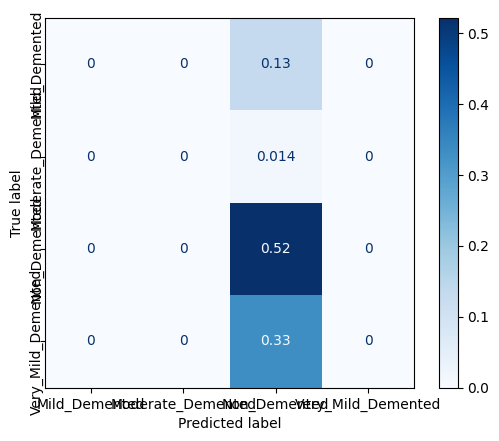

<Figure size 500x500 with 0 Axes>

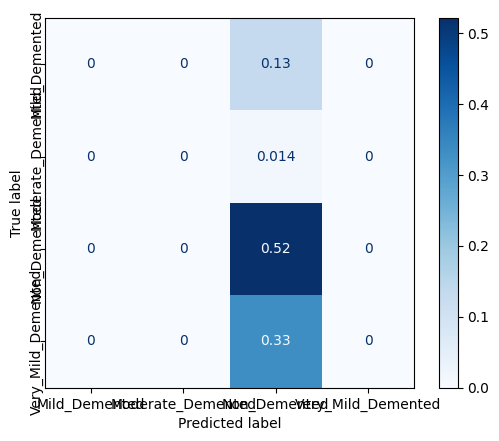

<Figure size 500x500 with 0 Axes>

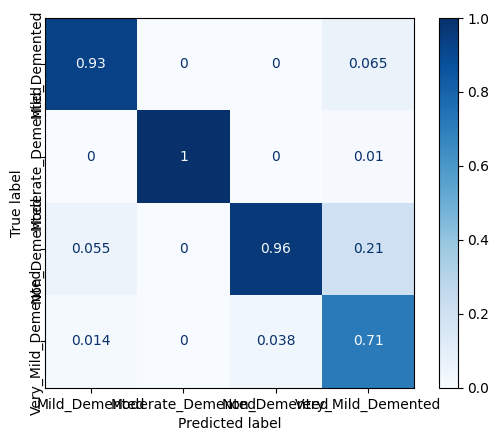

<Figure size 500x500 with 0 Axes>

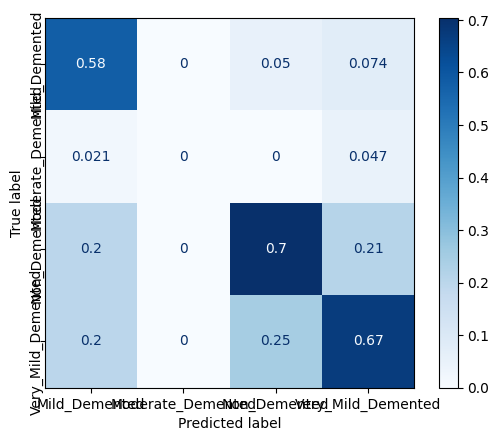

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r VGG16.zip ./*